In [1]:
from LRL import *

In [2]:
USE_CUDA

True

In [3]:
def make_env(seed):
    def _thunk():
        env = gym.make("BipedalWalker-v2")
        env.seed(seed)
        return env
    return _thunk

In [4]:
class Actor(nn.Module):
    def __init__(self, linear):
        super().__init__()
        self.layers = nn.Sequential(
                        linear(24 + 10, 128),
                        #linear(24, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU(),
                        linear(128, 4),
                        nn.Tanh()
                                   )
        
    def forward(self, x):
        noise = Tensor(x.shape[0], 10).normal_()
        return self.layers(torch.cat([x, noise], dim=1))
        #return self.layers(x)

In [5]:
class Critic(nn.Module):
    def __init__(self, linear):
        super().__init__()
        self.layers = nn.Sequential(
                        linear(28, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU(),
                        linear(128, 1)
                                   )
        
    def forward(self, x, a):
        return self.layers(torch.cat([x, a], dim=1))

In [6]:
class TwinReplayBufferAgent(Agent):
    __doc__ += Agent.__doc__
    PARAMS = Agent.PARAMS | {"replay_buffer_capacity"}
    
    def __init__(self, config):
        super().__init__(config)
        
        self.config.setdefault("replay_buffer_capacity", 100000)
        
        self.config.replay_buffer_nsteps = 1
        self.buffer = [[], []]
        self.pos = [0, 0]
    
    def memorize_transition(self, state, action, reward, next_state, done, i):        
        # preparing for concatenation into batch in future
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        # this turned out to be the quickest way of working with experience memory
        if len(self) < self.config.replay_buffer_capacity:
            self.buffer[i].append((state, action, reward, next_state, done))
        else:
            self.buffer[i][self.pos[i]] = (state, action, reward, next_state, done)
        
        self.pos[i] = (self.pos[i] + 1) % self.config.replay_buffer_capacity
    
    def memorize(self, state, action, reward, next_state, done):
        """
        Remember batch of transitions:
        input: state - numpy array, (num_envs x observation_shape)
        input: action - numpy array of ints or floats, (num_envs)
        input: reward - numpy array, (num_envs)
        input: next_state - numpy array, (num_envs x observation_shape)
        input: done - numpy array, 0 and 1, (num_envs)
        """
        
        for i, s, a, r, ns, d in zip(range(state.shape[0]), state, action, reward, next_state, done):
            self.memorize_transition(s, a, r, ns, d, i < self.env.num_envs // 2)
    
    def see(self, state, action, reward, next_state, done):
        self.memorize(state, action, reward, next_state, done)
        super().see(state, action, reward, next_state, done)
    
    def sample(self, batch_size, i):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer[i], batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done, np.ones((batch_size))
    
    def update_priorities(self, batch_priorities, i):
        pass
    
    def __len__(self):
        return len(self.buffer[0]) + len(self.buffer[1]) 

In [7]:
def TwinQAgent(parclass):
    class TwinQAgent(parclass):
        __doc__ += parclass.__doc__
        PARAMS = parclass.PARAMS | Head.PARAMS("Qnetwork") | {"QnetworkHead", "gamma", "batch_size", 
                                                              "replay_buffer_init", "optimize_iterations"} 

        def __init__(self, config):
            super().__init__(config)

            self.config.setdefault("QnetworkHead", Qnetwork)
            self.config.setdefault("gamma", 0.99)
            self.config.setdefault("batch_size", 32)
            self.config.setdefault("replay_buffer_init", 1000)
            self.config.setdefault("optimize_iterations", 1)

            assert self.config.replay_buffer_init >= self.config.batch_size, "Batch size must be smaller than replay_buffer_init!"
            assert self.config.gamma > 0 and self.config.gamma <= 1, "Gamma must lie in (0, 1]"

            self.q_net1 = self.config.QnetworkHead(self.config, "Qnetwork").to(device)
            self.q_net1.init_optimizer()
            self.q_net2 = self.config.QnetworkHead(self.config, "Qnetwork").to(device)
            self.q_net2.init_optimizer()
            self.optimize_iteration_charges = 0

            self.logger_labels["loss1"] = ("training iteration", "loss")
            self.logger_labels["loss2"] = ("training iteration", "loss")
            #self.log_net(self.q_net, "Qnetwork")

        def act(self, state, record=False):
            self.q_net1.eval()
            self.q_net2.eval()

            with torch.no_grad():
                a1 = self.q_net1.greedy(self.q_net1(Tensor(state[:self.env.num_envs // 2])))
                a2 = self.q_net2.greedy(self.q_net2(Tensor(state[self.env.num_envs // 2:])))

                return torch.cat([a1, a2], dim=0).cpu().numpy()

        def see(self, state, action, reward, next_state, done):
            super().see(state, action, reward, next_state, done)

            self.optimize_iteration_charges += self.config.optimize_iterations * self.env.num_envs
            while self.optimize_iteration_charges >= 1:
                self.optimize_iteration_charges -= 1

                if len(self) >= self.config.replay_buffer_init:
                    self.optimize_model()
                    
        def get_loss(self, y, guess):
            return (guess - y).pow(2)

        def get_transition_importance(self, loss_b):
            return loss_b**0.5

        def optimize_model(self):
            '''One step of Q-network optimization'''        
            self.batch1 = self.sample(self.config.batch_size, 0)
            state_b, action_b, reward_b, next_state_b, done_b, weights_b = self.batch1
            # TODO: weights logging?

            state_b      = Tensor(np.float32(state_b))
            next_state_b = Tensor(np.float32(next_state_b))
            action_b     = self.ActionTensor(action_b)
            reward_b     = Tensor(np.float32(reward_b))
            done_b       = Tensor(np.float32(done_b))
            weights_b    = Tensor(weights_b)

            # optimizing forward pass through net!
            self.q_net1.train()
            output = self.q_net1(torch.cat([state_b, next_state_b], dim=0))
            self.state_q, self.next_state_q = torch.split(output, self.config.batch_size, dim=0)

            # getting q values for state and next state
            q_values = self.q_net1.gather(self.state_q, action_b)
            with torch.no_grad():
                next_q_values = self.q_net1.value(self.next_state_q)
                target_q_values = reward_b + (self.config.gamma**self.config.replay_buffer_nsteps) * \
                                              next_q_values * (1 - done_b)

            # getting loss and updating transition importances
            loss_b = self.get_loss(target_q_values, q_values)
            self.update_priorities(self.get_transition_importance(loss_b).detach().cpu().numpy(), 0)

            # making optimization step
            loss = (loss_b * weights_b).mean()
            self.logger["loss1"].append(loss.detach().cpu().numpy())

            self.q_net1.optimize(loss)
            
            '''One step of Q-network optimization'''        
            self.batch2 = self.sample(self.config.batch_size, 1)
            state_b, action_b, reward_b, next_state_b, done_b, weights_b = self.batch2
            # TODO: weights logging?

            state_b      = Tensor(np.float32(state_b))
            next_state_b = Tensor(np.float32(next_state_b))
            action_b     = self.ActionTensor(action_b)
            reward_b     = Tensor(np.float32(reward_b))
            done_b       = Tensor(np.float32(done_b))
            weights_b    = Tensor(weights_b)

            # optimizing forward pass through net!
            self.q_net2.train()
            output = self.q_net2(torch.cat([state_b, next_state_b], dim=0))
            self.state_q, self.next_state_q = torch.split(output, self.config.batch_size, dim=0)

            # getting q values for state and next state
            q_values = self.q_net2.gather(self.state_q, action_b)
            with torch.no_grad():
                next_q_values = self.q_net2.value(self.next_state_q)
                target_q_values = reward_b + (self.config.gamma**self.config.replay_buffer_nsteps) * \
                                              next_q_values * (1 - done_b)

            # getting loss and updating transition importances
            loss_b = self.get_loss(target_q_values, q_values)
            self.update_priorities(self.get_transition_importance(loss_b).detach().cpu().numpy(), 1)

            # making optimization step
            loss = (loss_b * weights_b).mean()
            self.logger["loss2"].append(loss.detach().cpu().numpy())

            self.q_net2.optimize(loss)

        def show_record(self):
            show_frames_and_distribution(self.record["frames"], np.array(self.record["qualities"]), "Qualities", np.arange(self.config["num_actions"]))

        def load(self, name, *args, **kwargs):
            super().load(name, *args, **kwargs)
            self.q_net.load_state_dict(torch.load(name + "-qnet"))

        def save(self, name, *args, **kwargs):
            super().save(name, *args, **kwargs)
            torch.save(self.q_net.state_dict(), name + "-qnet")
    return TwinQAgent

In [8]:
def TwinDDPG_QAgent(parclass):
    class TwinDDPG_QAgent(TwinQAgent(parclass)):
        __doc__ += TwinQAgent(parclass).__doc__
        PARAMS = TwinQAgent(parclass).PARAMS | Head.PARAMS("Actor") 

        def __init__(self, config):
            config.setdefault("QnetworkHead", DDPG_Critic)        
            assert issubclass(config["QnetworkHead"], DDPG_Critic), "DDPG requires QnetworkHead to be inherited from DDPG_Head class"         
            super().__init__(config)

            self.config.setdefault("ActorHead", DDPG_Actor)
            assert issubclass(self.config["ActorHead"], DDPG_Actor), "DDPG requires ActorHead to be inherited from DDPG_Actor class"         

            self.actor1 = self.config.ActorHead(self.config, "Actor").to(device)
            self.actor1.init_optimizer()
            self.q_net1.actor = self.actor1
            
            self.actor2 = self.config.ActorHead(self.config, "Actor").to(device)
            self.actor2.init_optimizer()
            self.q_net2.actor = self.actor2
            
            self.myR = np.zeros((self.env.num_envs), dtype=np.float32)
            self.logger_labels["actor1_rewards"] = ("episode", "actor_rewards")
            self.logger_labels["actor2_rewards"] = ("episode", "actor_rewards")            
            self.logger["actor1_rewards"].append(-100)
            self.logger["actor2_rewards"].append(-100)
            
            self.logger_labels["actor1_loss"] = ("training iteration", "actor_loss")
            self.logger_labels["actor2_loss"] = ("training iteration", "actor_loss")

        def act(self, state, record=False):
            self.actor1.eval()
            self.actor2.eval()
            return super().act(state, record)
        
        def see(self, state, action, reward, next_state, done):
            super().see(state, action, reward, next_state, done)

            self.myR += reward
            for i in range(self.env.num_envs):
                if done[i]:
                    if i < self.env.num_envs // 2:
                        self.logger["actor1_rewards"].append(self.myR[i])
                        self.logger["actor2_rewards"].append(self.logger["actor2_rewards"][-1])
                    else:
                        self.logger["actor2_rewards"].append(self.myR[i])
                        self.logger["actor1_rewards"].append(self.logger["actor1_rewards"][-1])
                    self.myR[i] = 0

        def optimize_model(self):
            self.actor1.train()
            self.actor2.train()

            # Basic QAgent just optimizes critic!
            super().optimize_model()

            # Now we need actor optimization. We need only batch of states for that.
            state_b = Tensor(np.float32(self.batch1[0]))
            weights_b = Tensor(self.batch1[-1])

            loss_b = -self.q_net1.value(state_b)        
            loss = (loss_b * weights_b).mean()
            self.logger["actor1_loss"].append(loss.detach().cpu().numpy())

            self.actor1.optimize(loss)
            
            # Now we need actor optimization. We need only batch of states for that.
            state_b = Tensor(np.float32(self.batch2[0]))
            weights_b = Tensor(self.batch2[-1])

            loss_b = -self.q_net2.value(state_b)        
            loss = (loss_b * weights_b).mean()
            self.logger["actor2_loss"].append(loss.detach().cpu().numpy())

            self.actor2.optimize(loss) 

        def show_record(self):
            show_frames(self.record["frames"])
    return TwinDDPG_QAgent

In [9]:
config = {
    "make_env": make_env,
    "threads": 16,
    "optimize_iterations": 1 / 16.,
    "Actor_FeatureExtractor": Actor,
    "Qnetwork_FeatureExtractor": Critic,
    "Actor_optimizer_args": {"lr": 3e-4},
    "Qnetwork_optimizer_args": {"lr": 1e-4}
}

In [10]:
agent = TwinDDPG_QAgent(TwinReplayBufferAgent)(config)

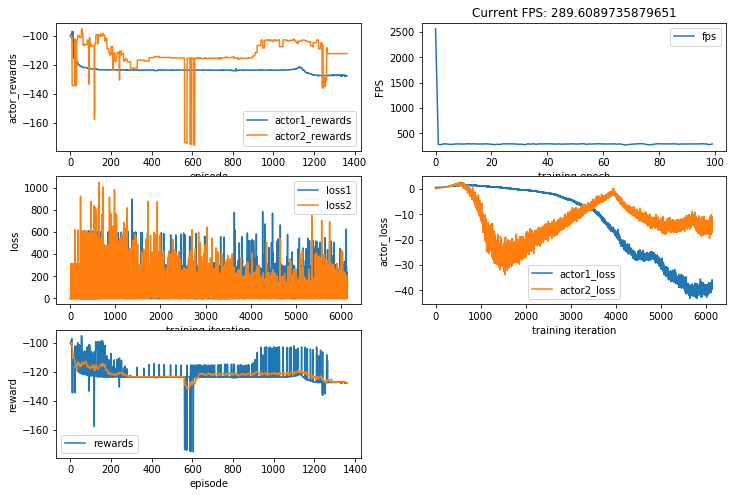

TypeError: list indices must be integers or slices, not list

In [11]:
%%time

for i in range(100000):
    agent.learn(1000)
    plot_durations(agent, 25)    

print('Complete')
plt.show()


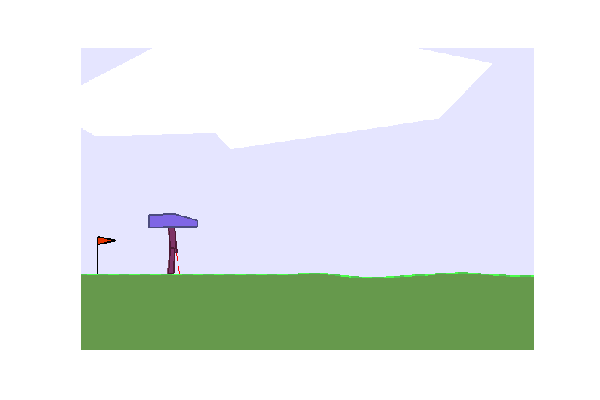
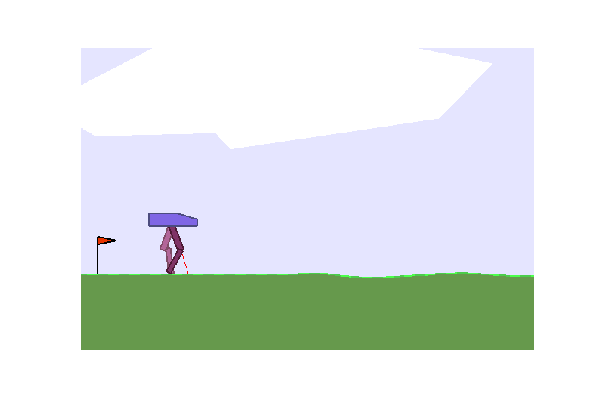
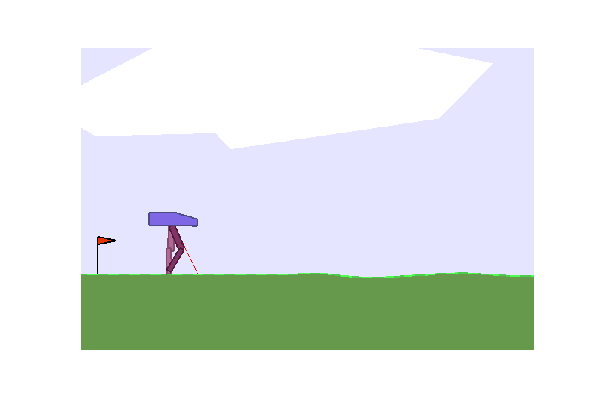
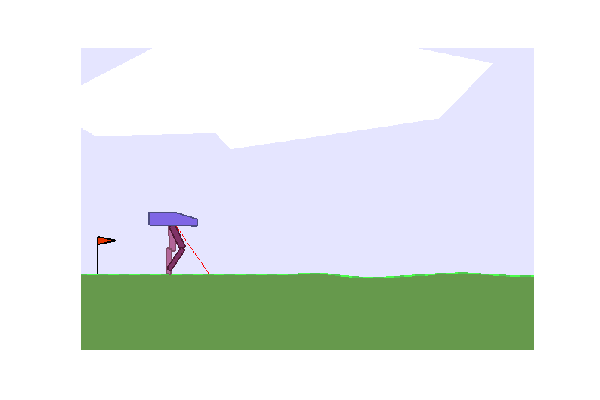
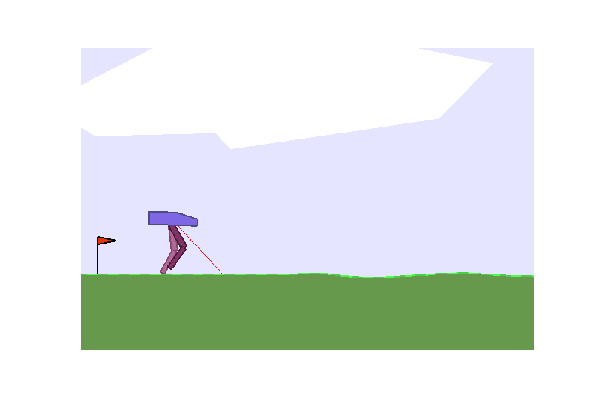
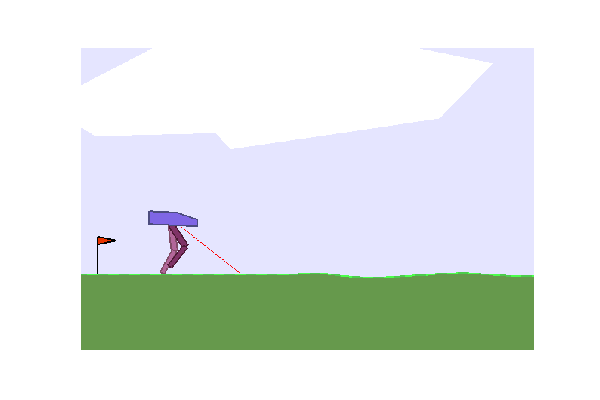
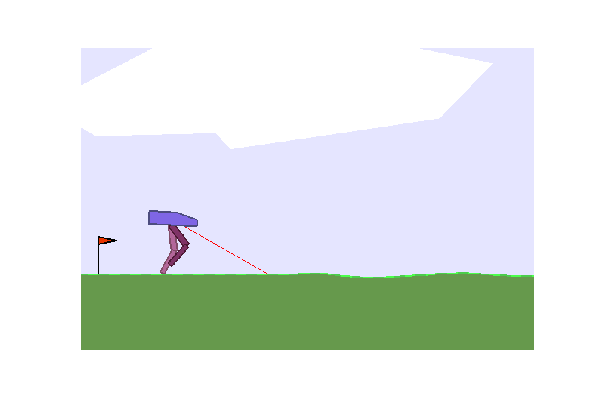
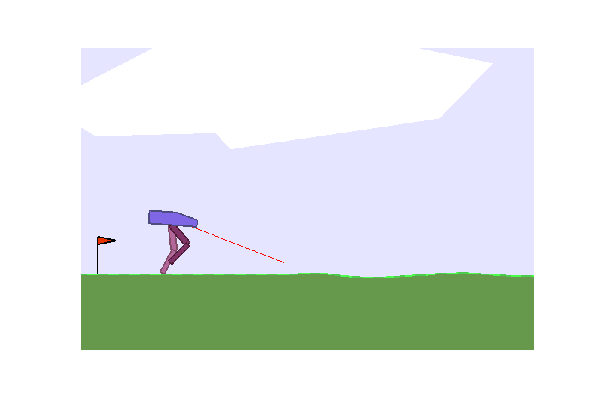
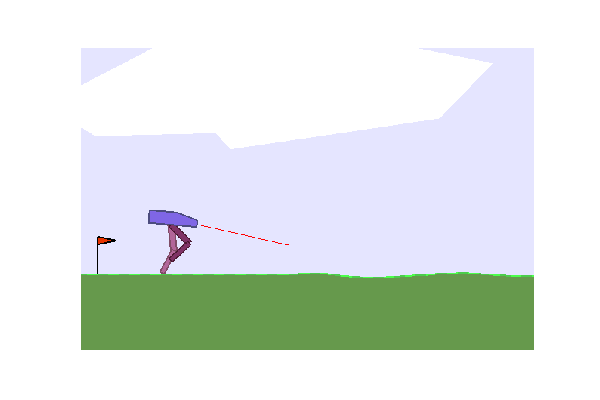
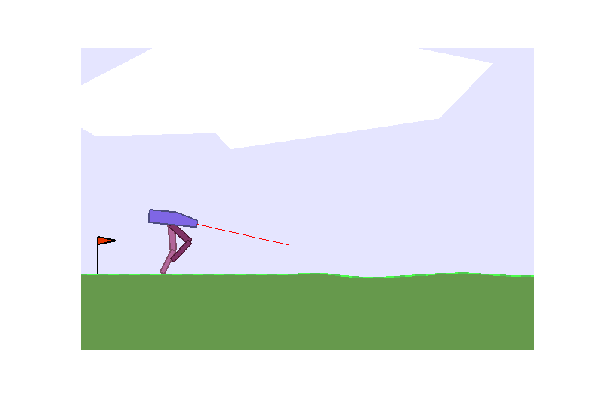
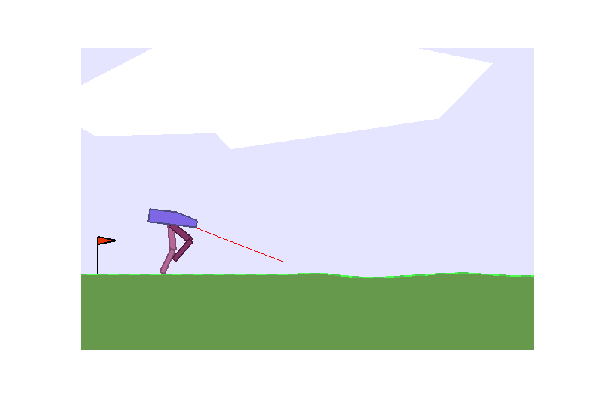
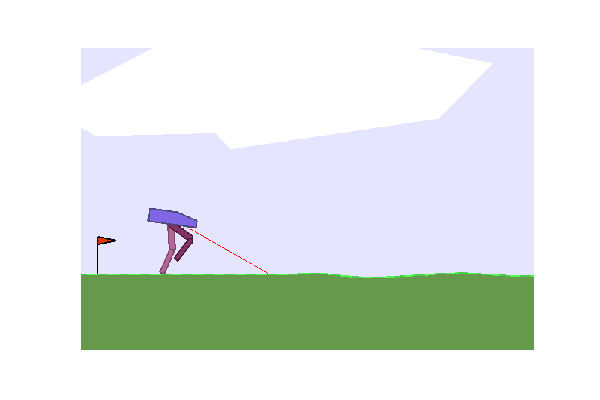
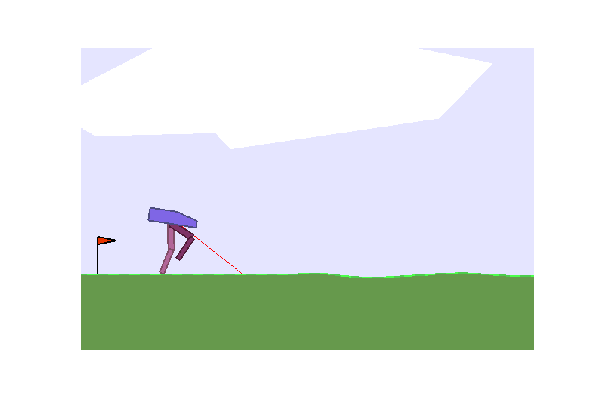
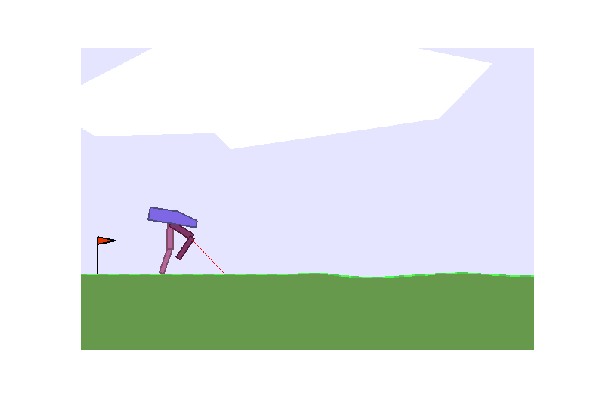
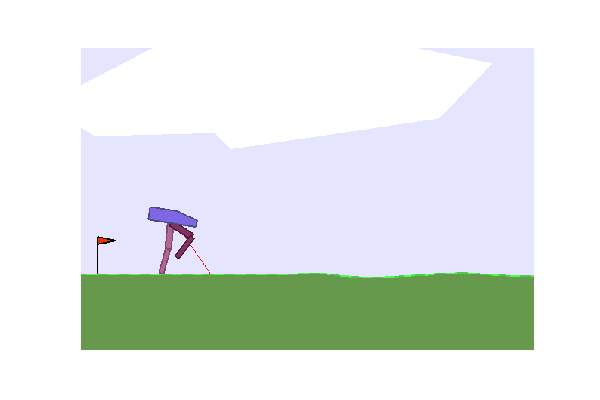
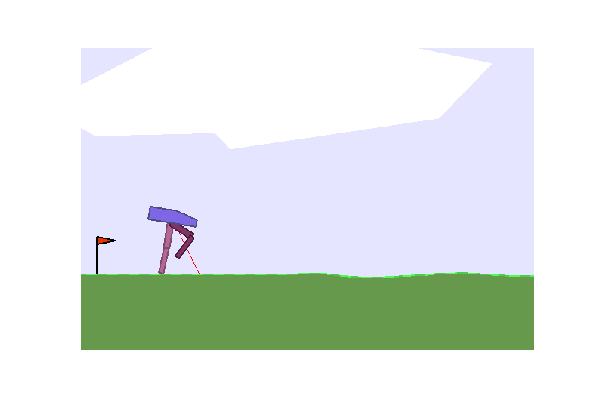
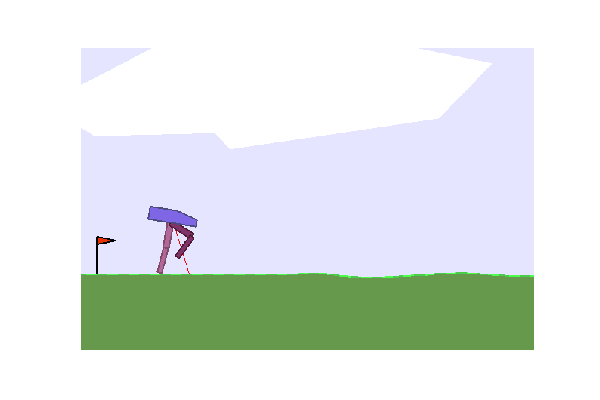
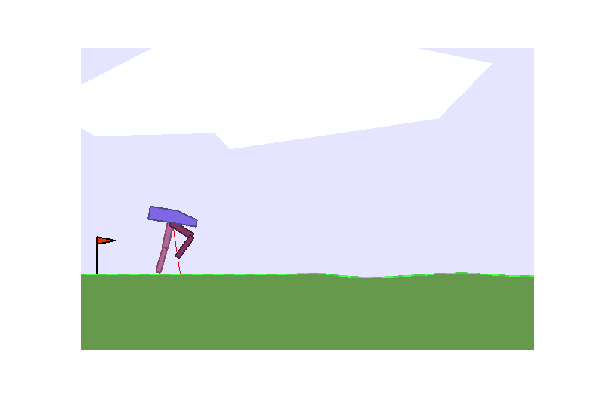
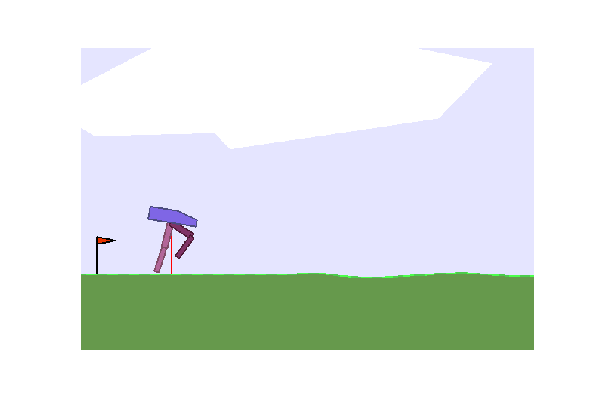
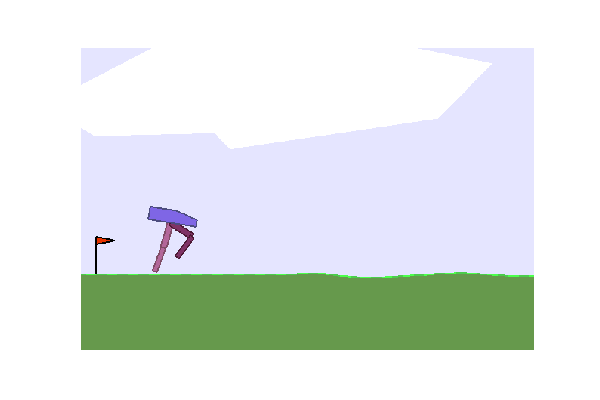
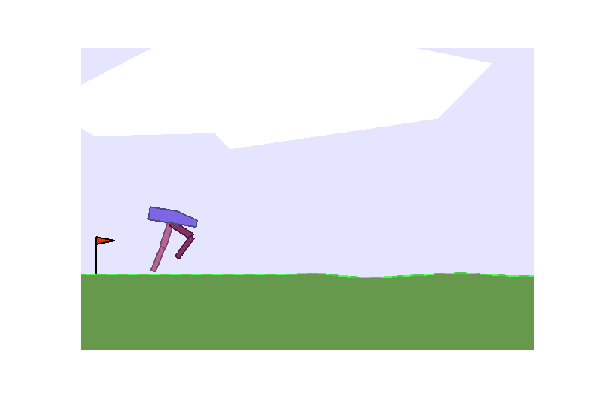
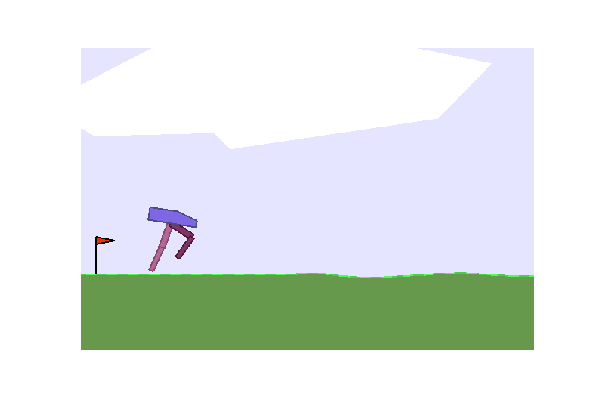
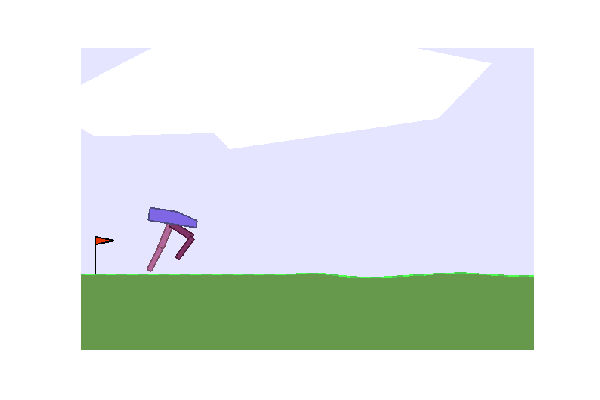
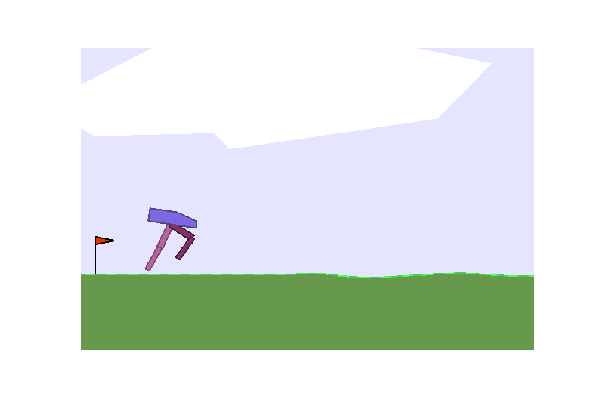
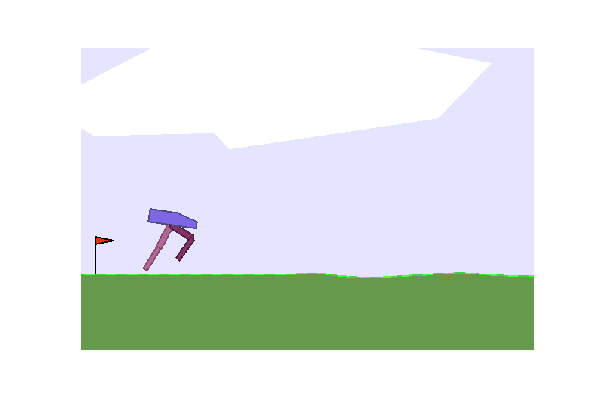
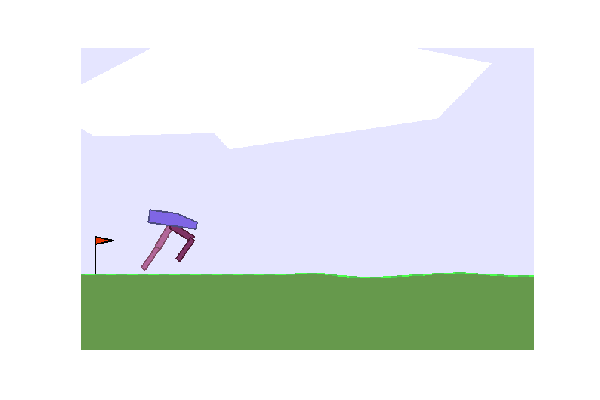
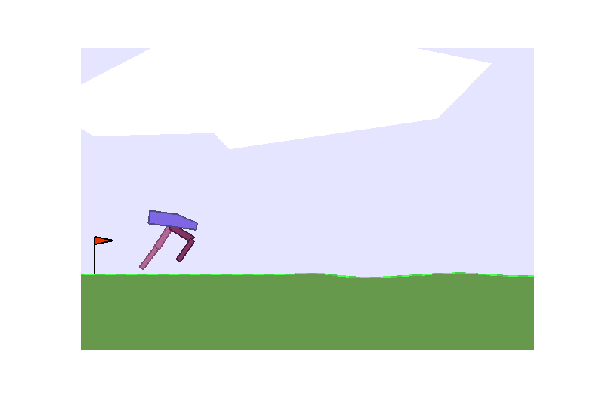
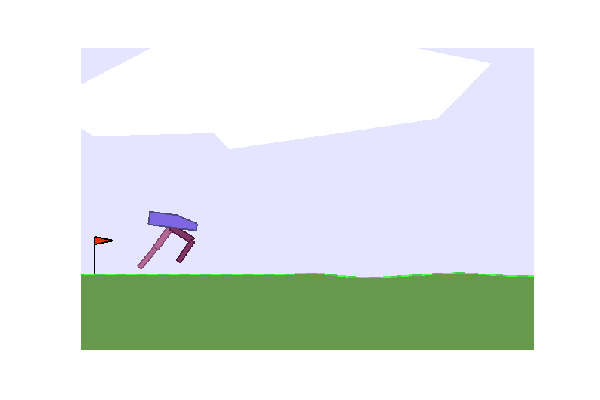
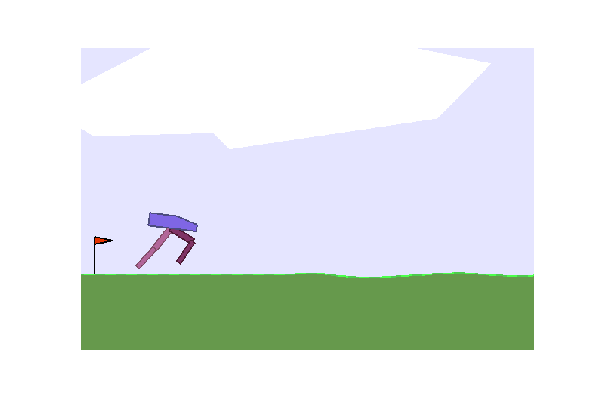
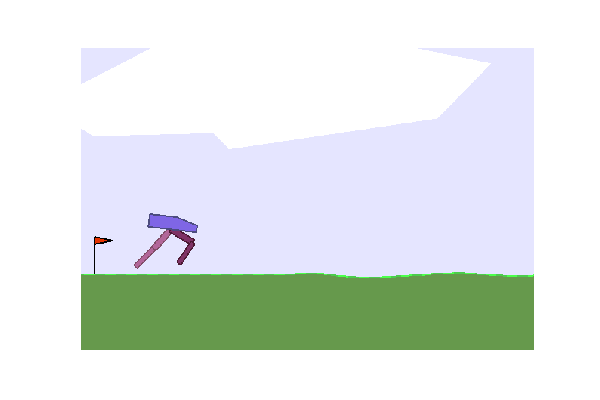
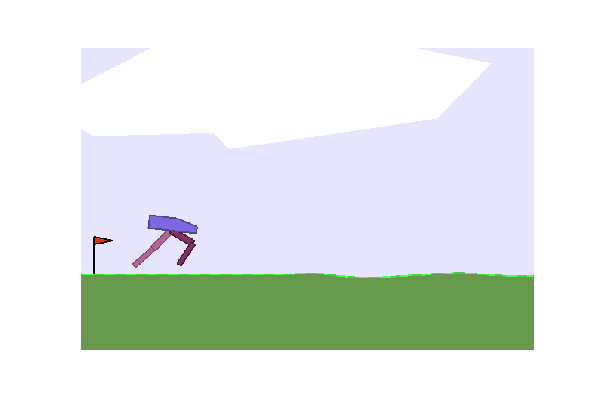
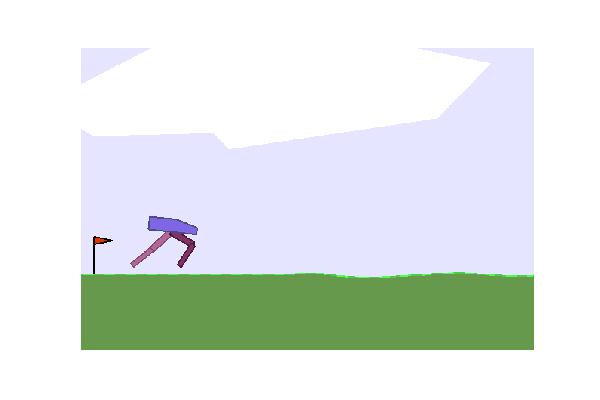
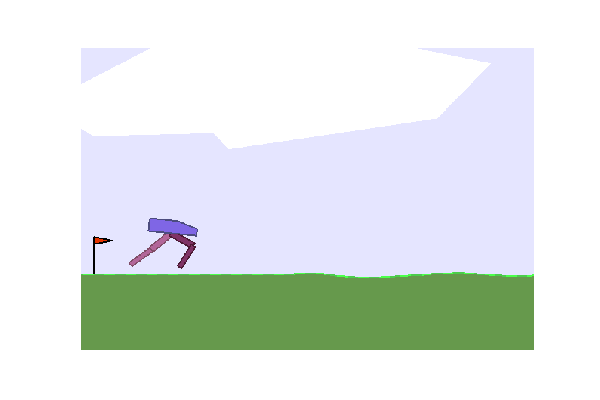
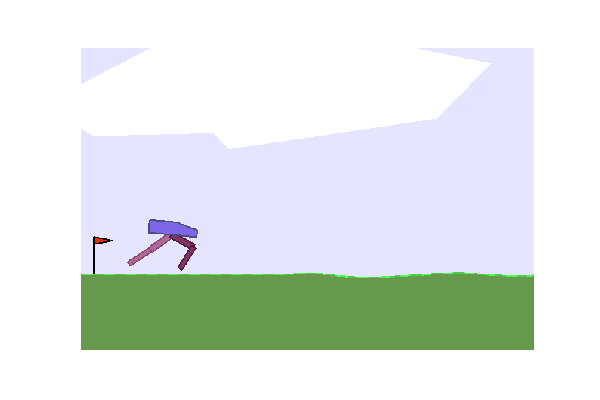
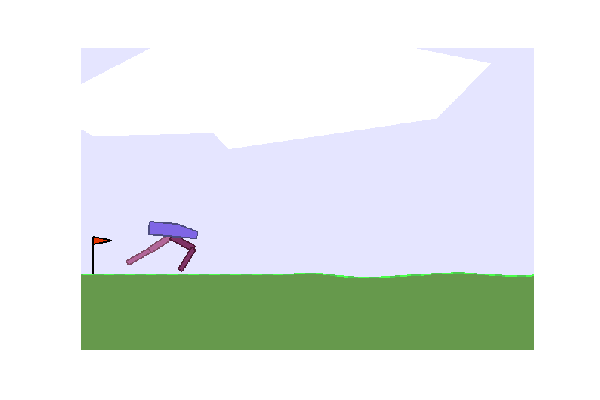
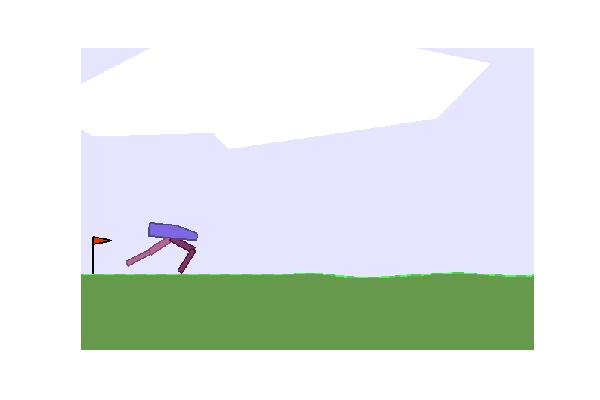
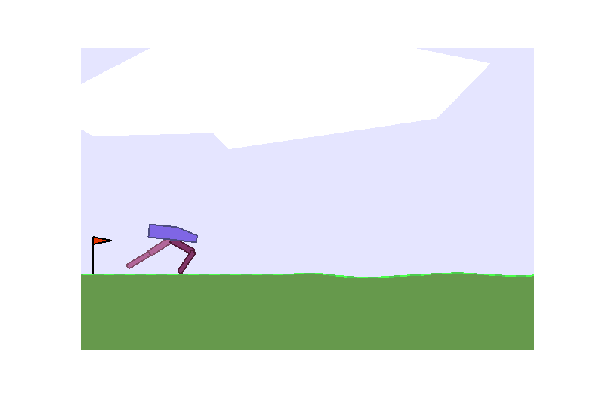
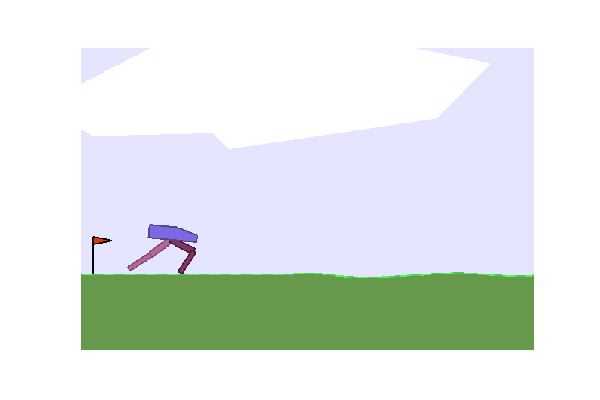
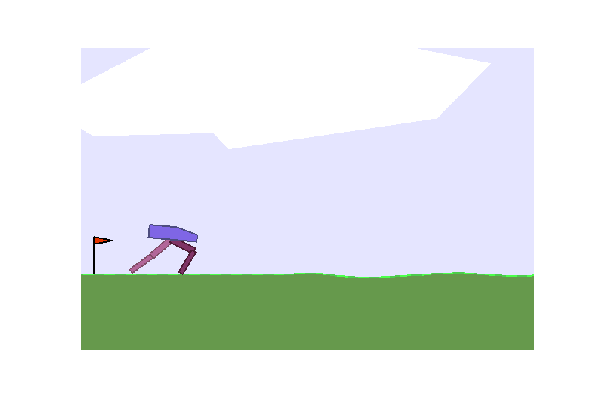
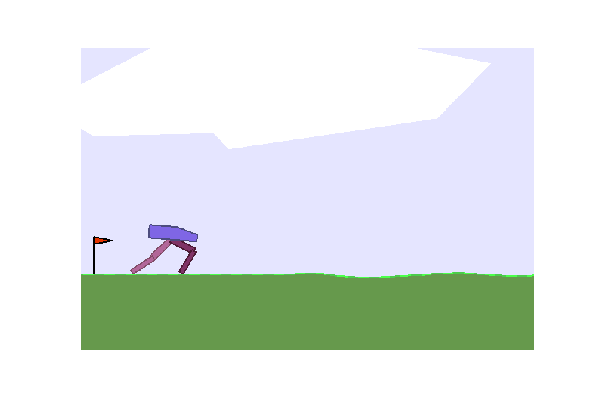
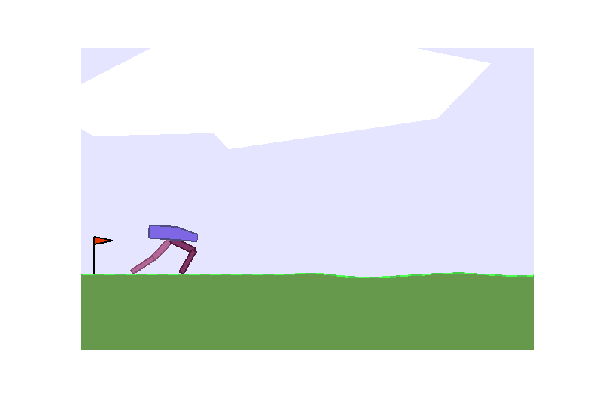
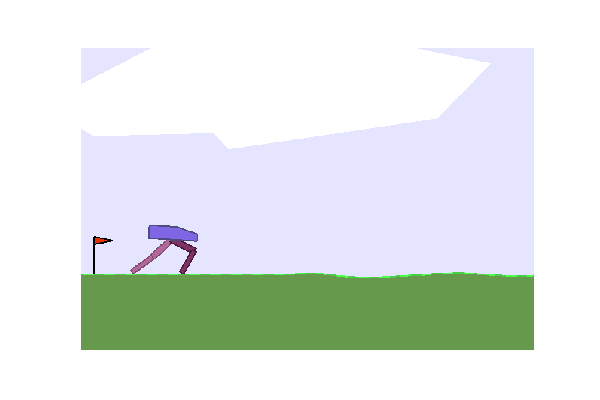
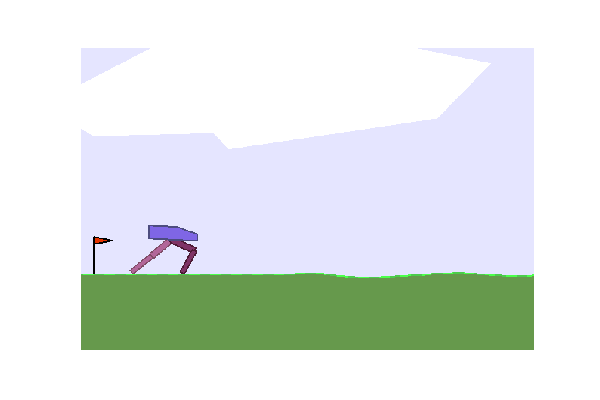
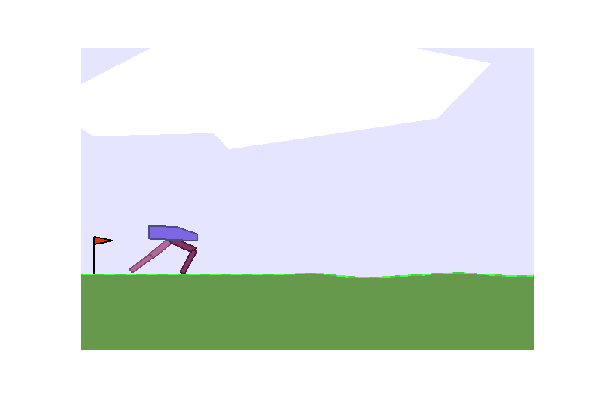
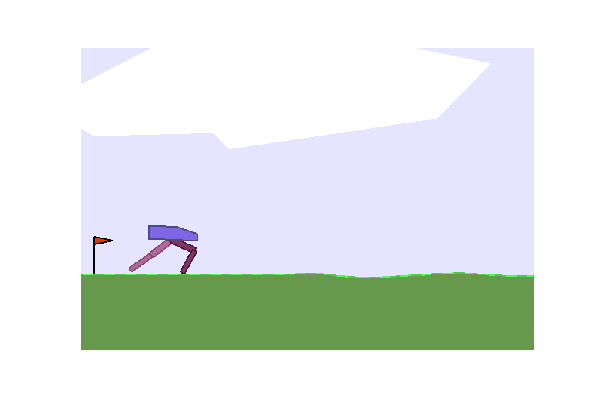
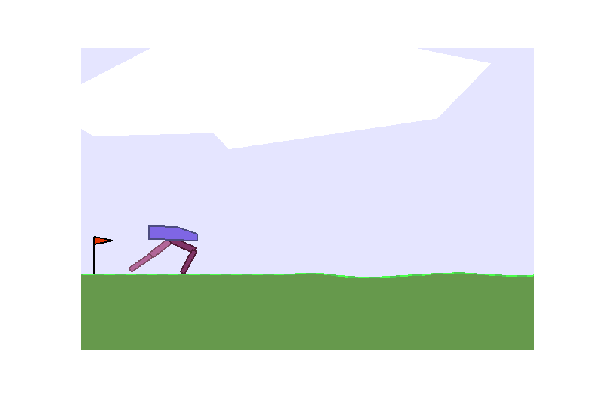
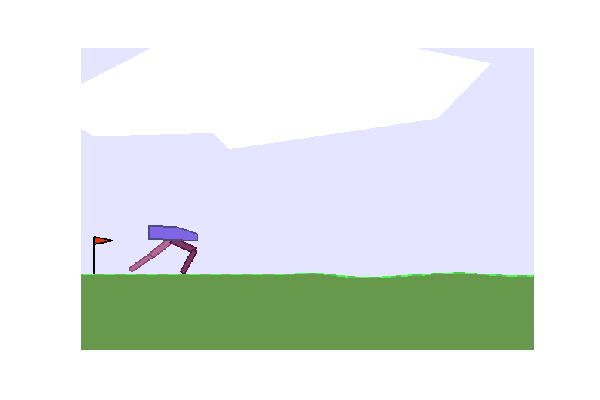
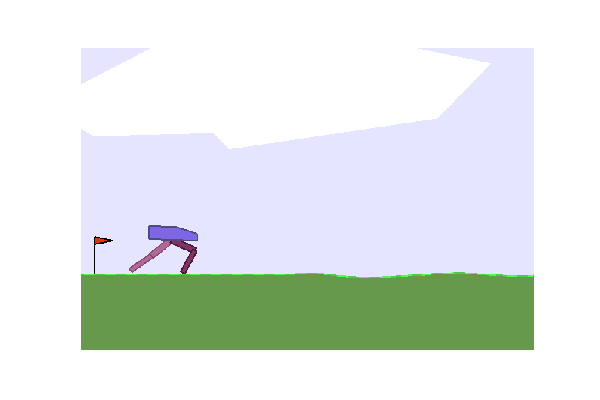
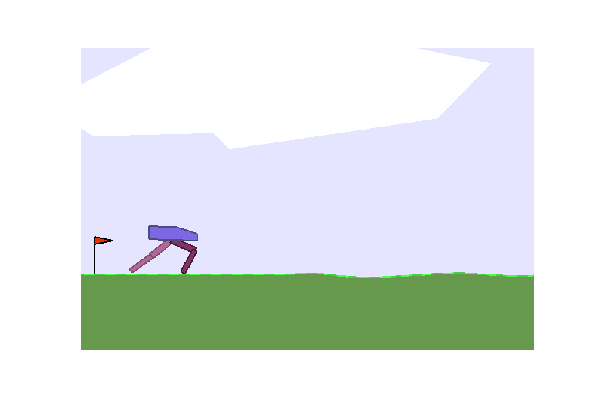
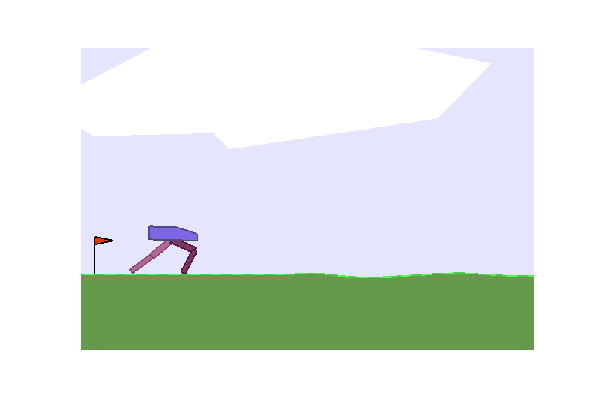
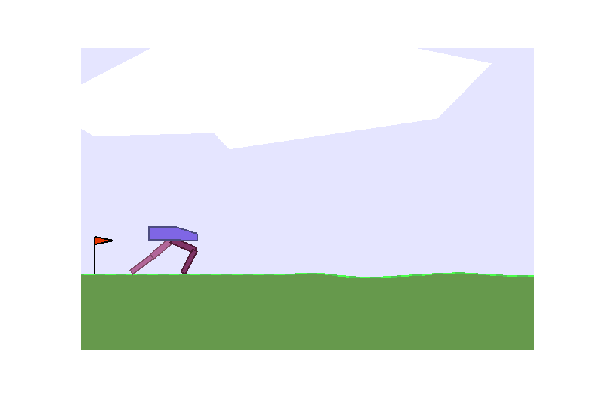
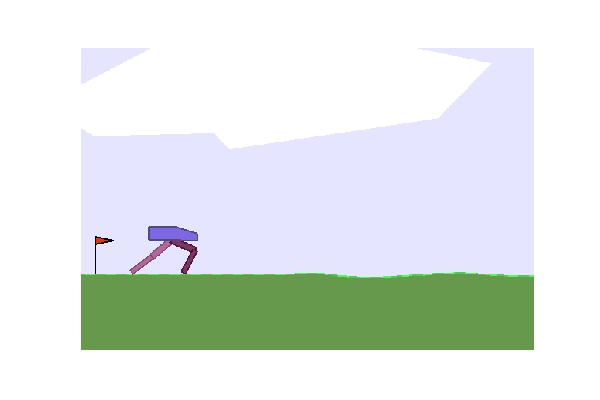
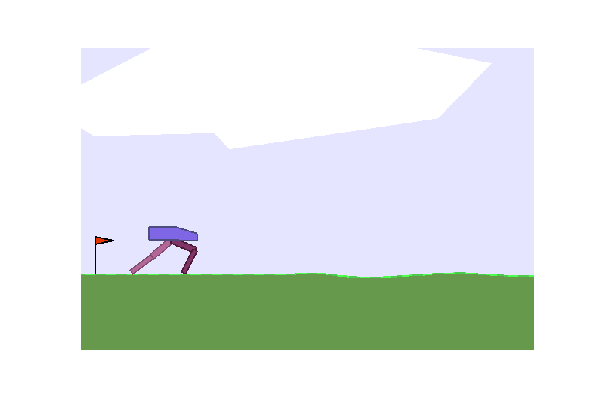
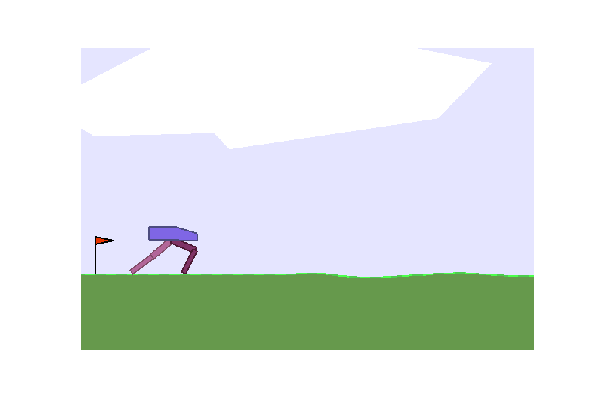
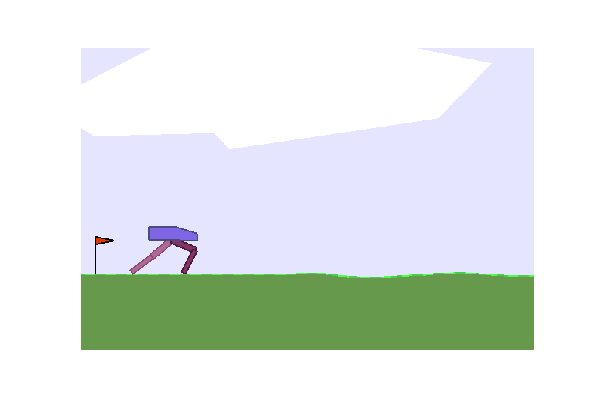
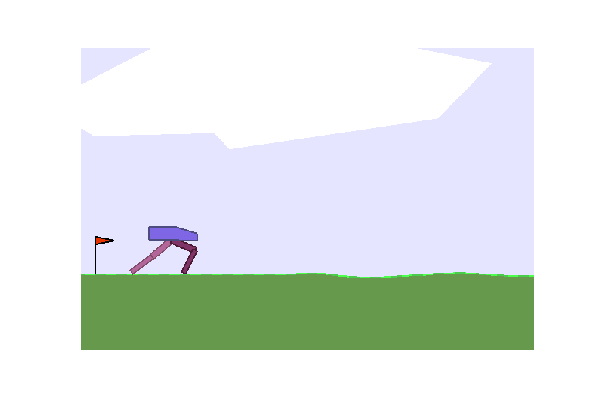
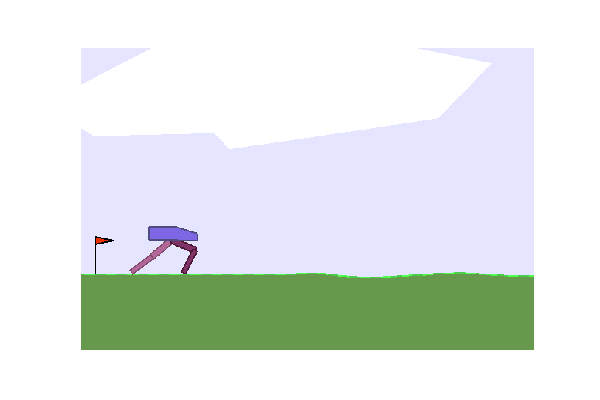
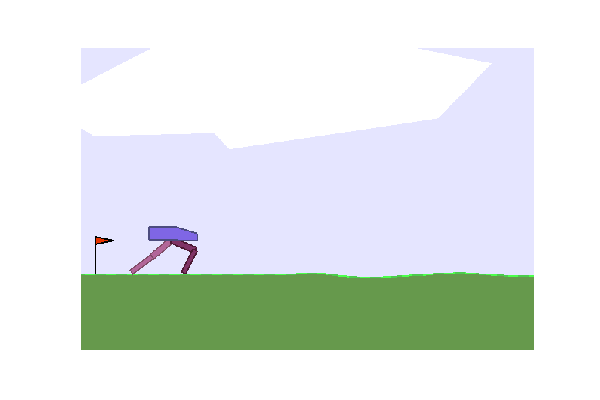
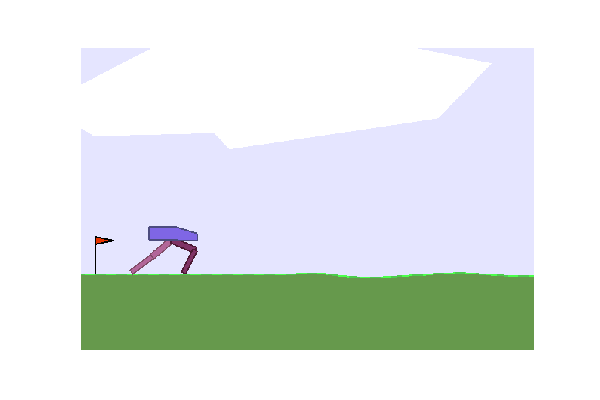
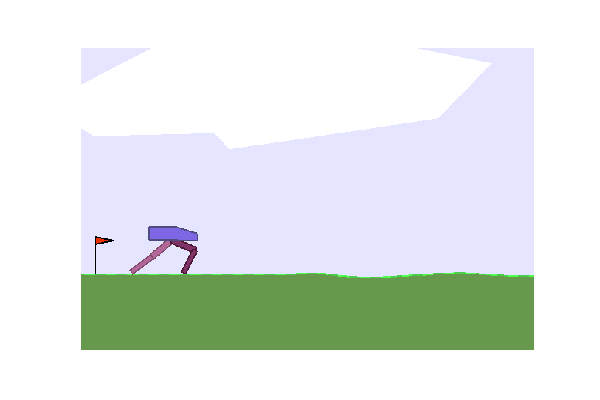
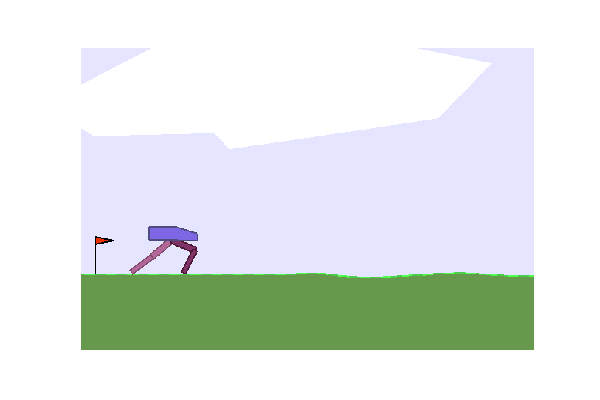
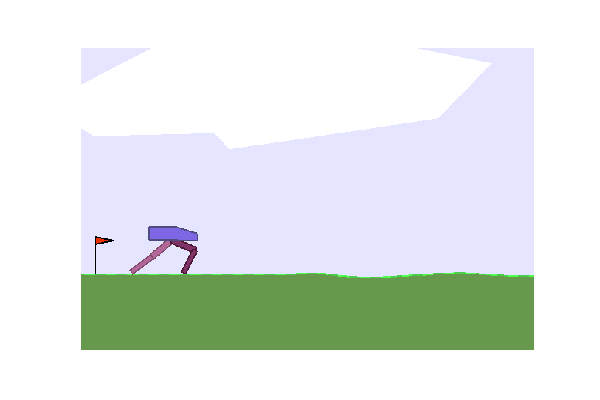
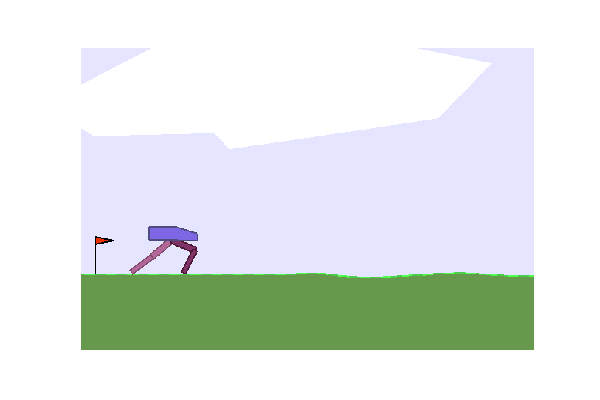
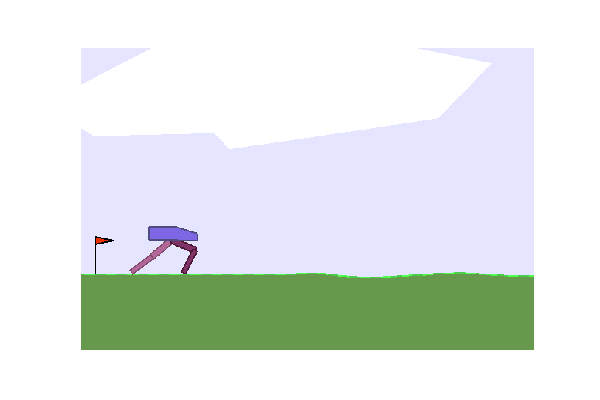
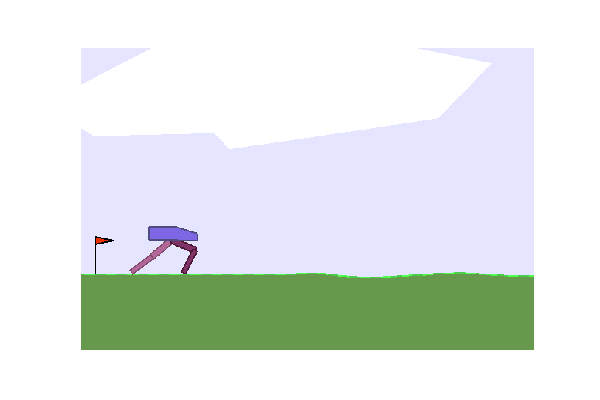
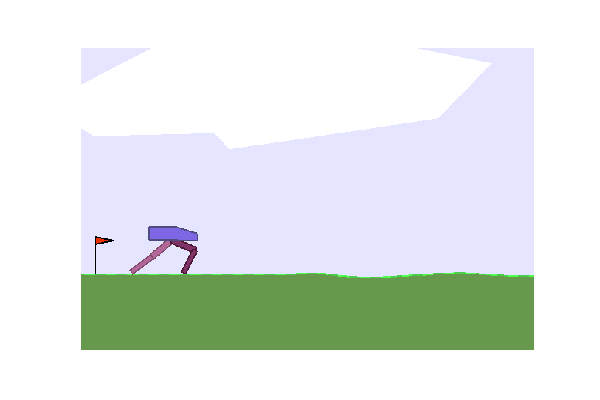
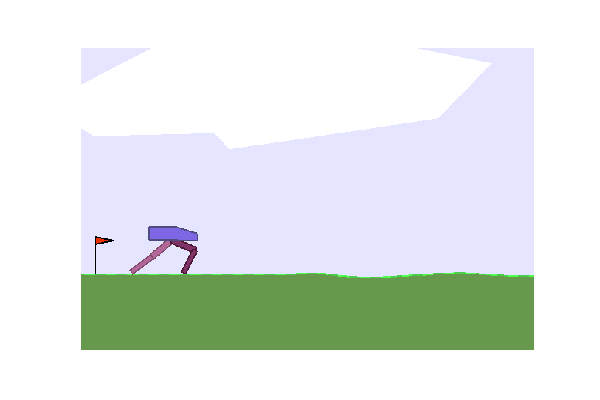
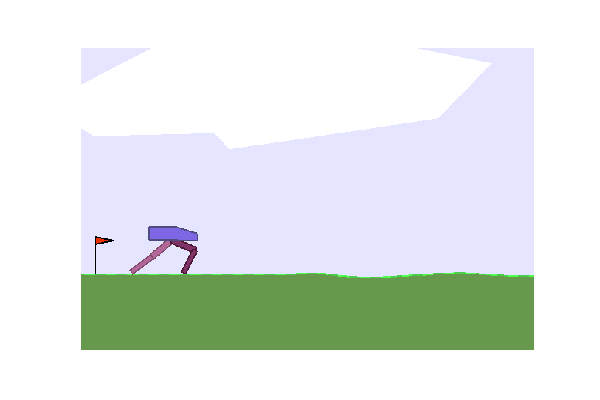
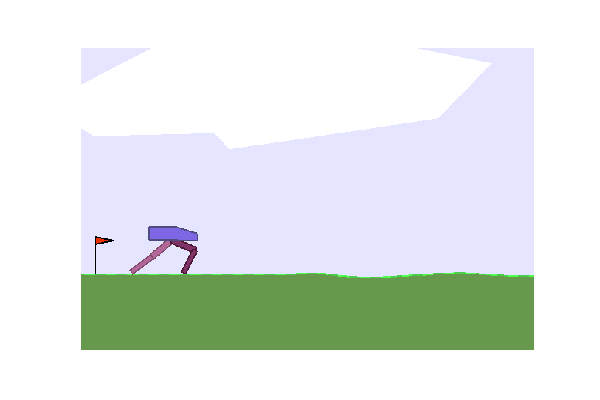
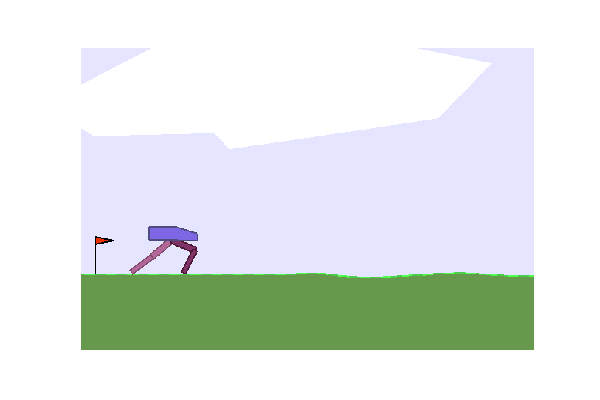
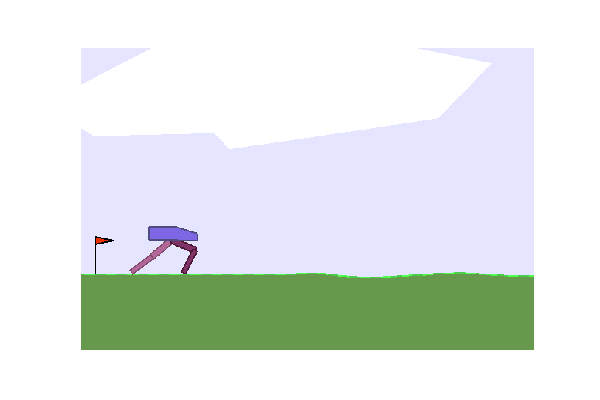
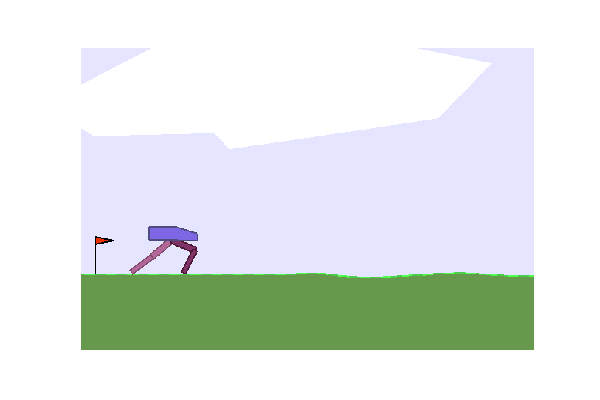
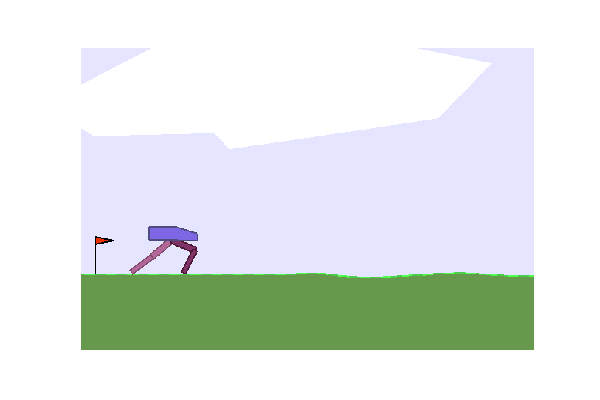
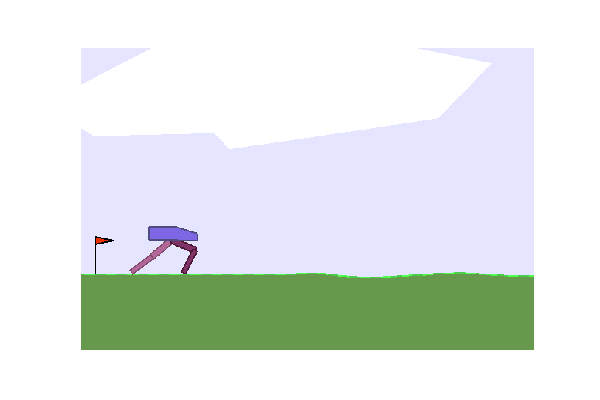
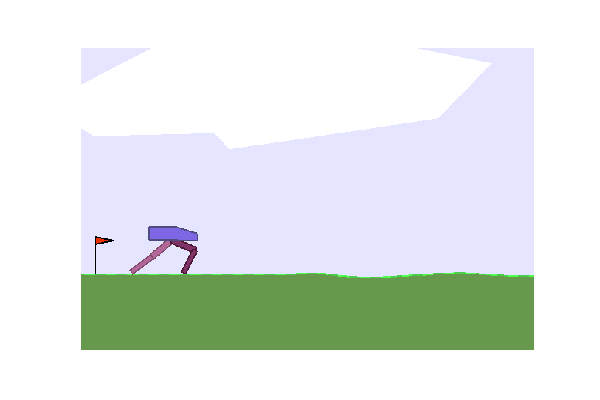
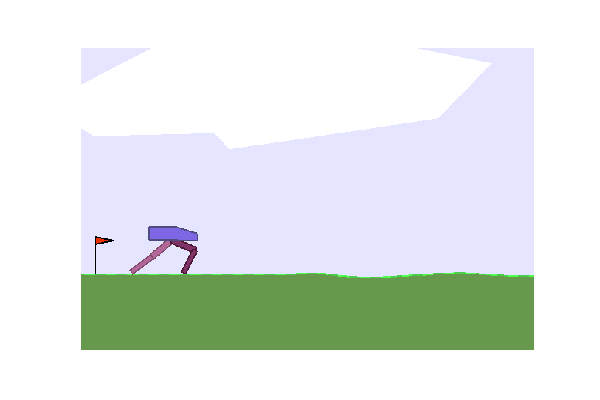
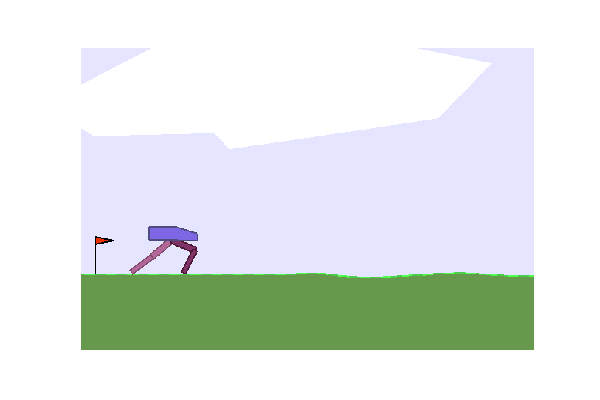
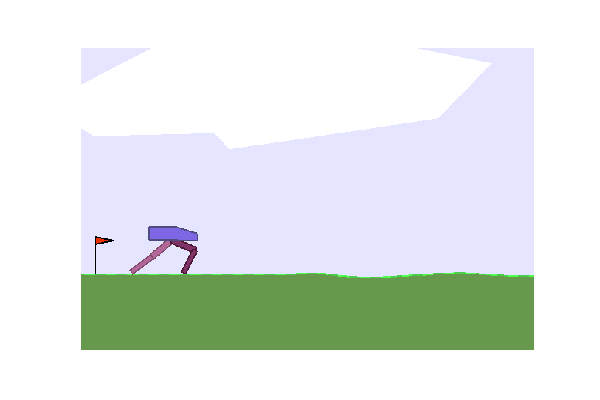
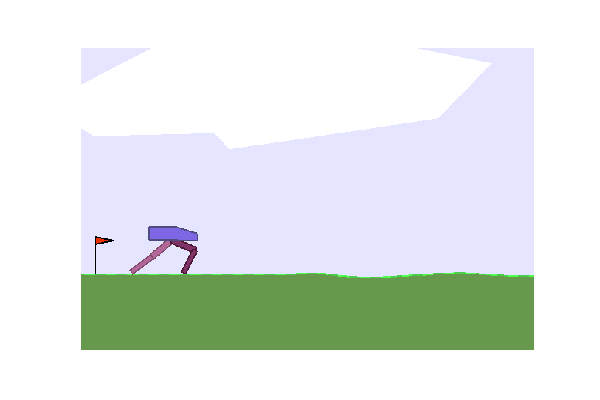
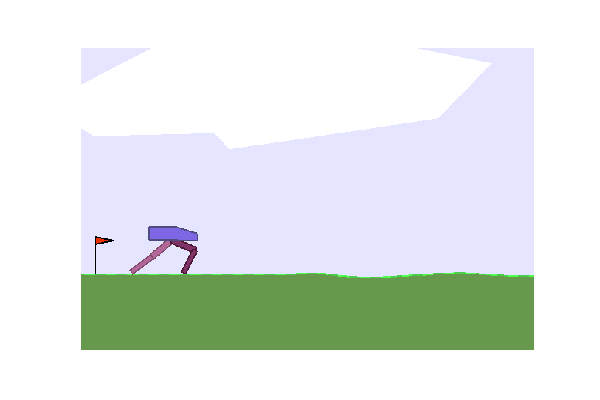
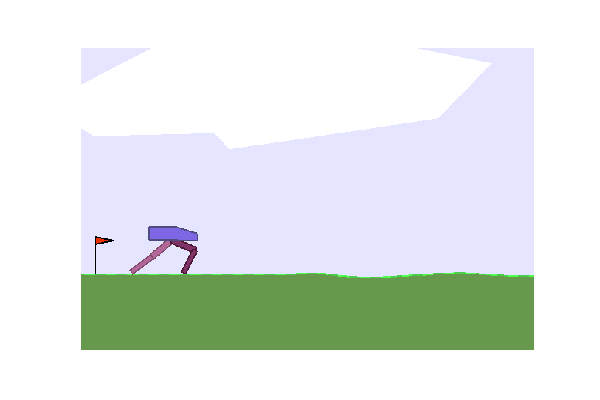
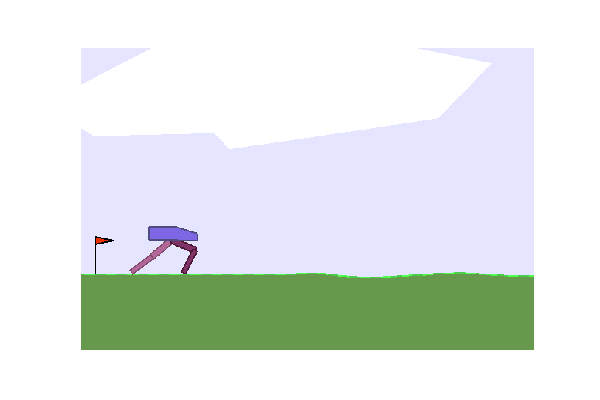
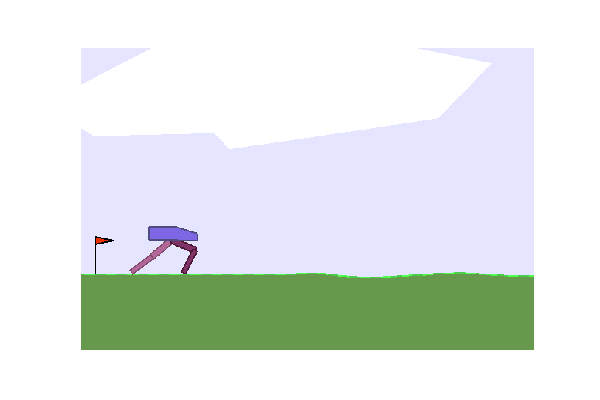
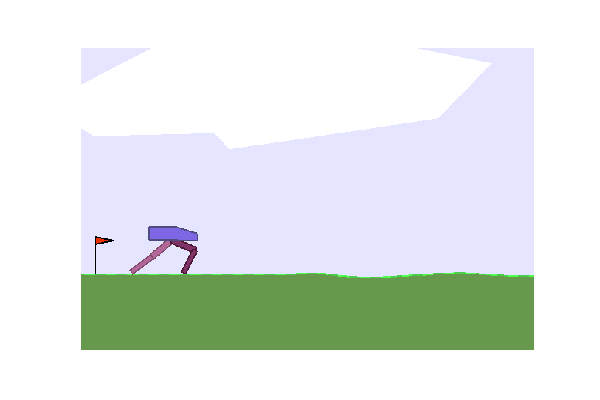
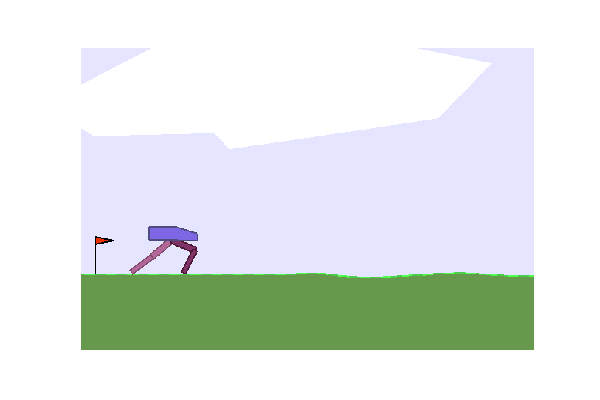
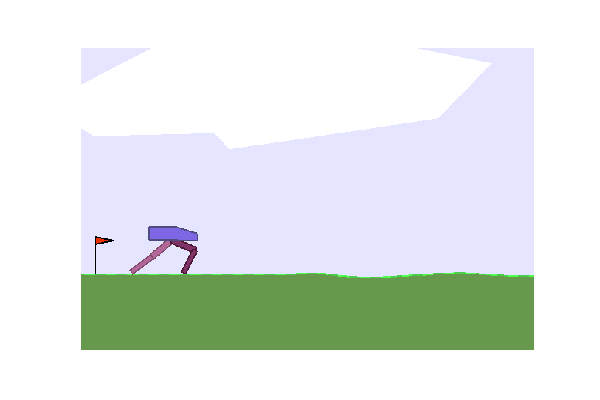
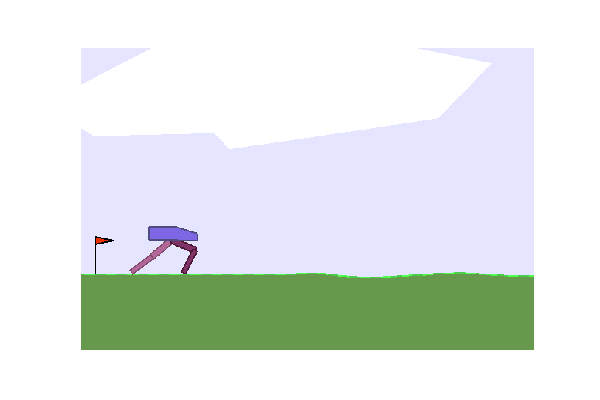
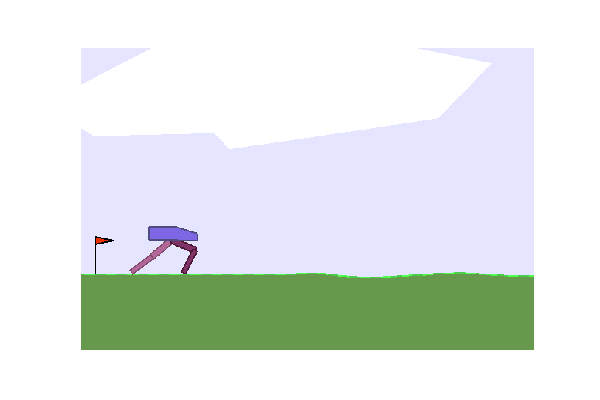
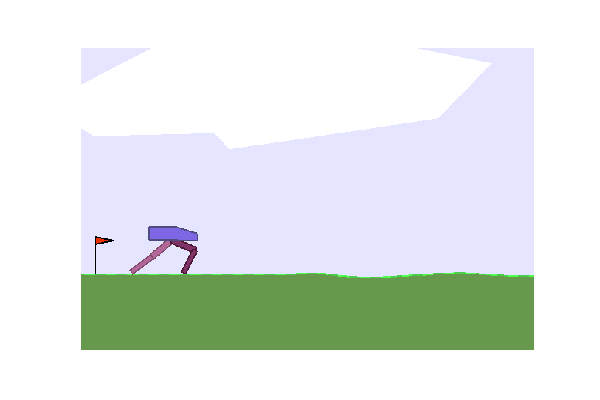
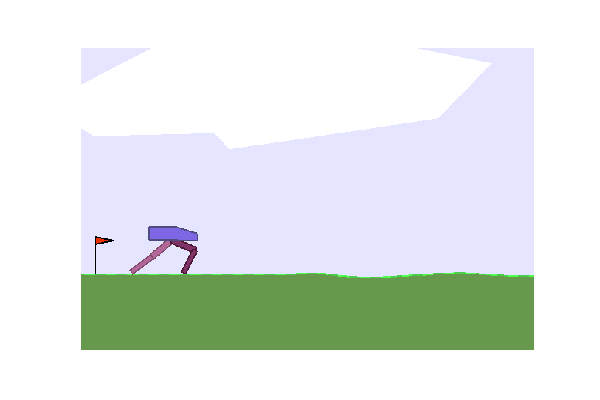
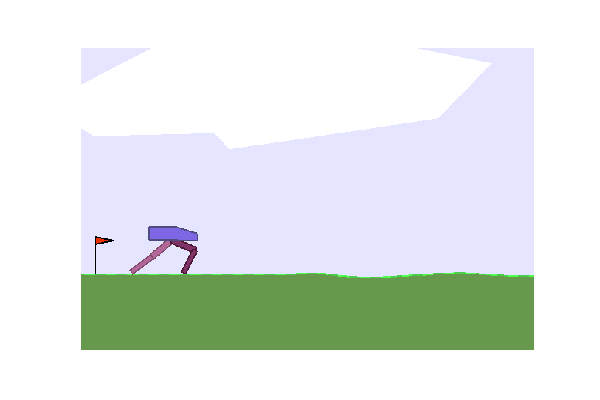
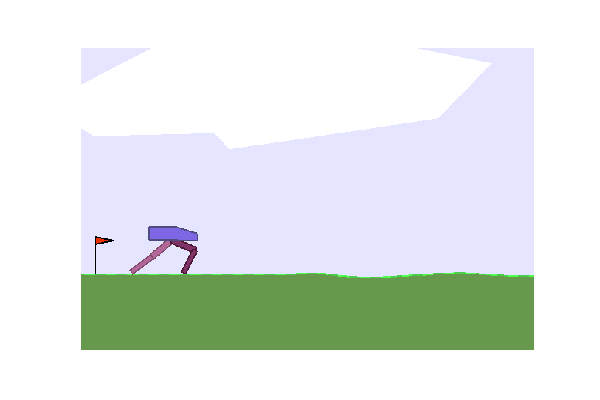
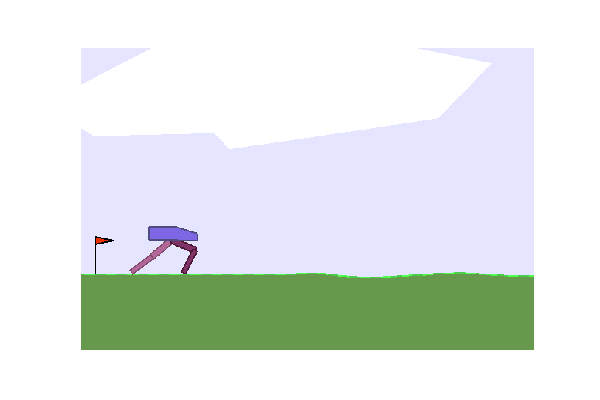
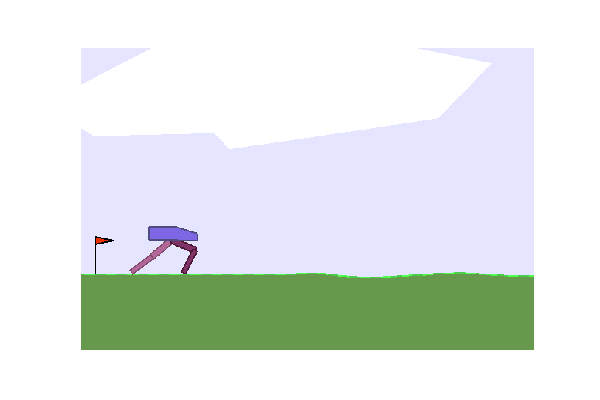
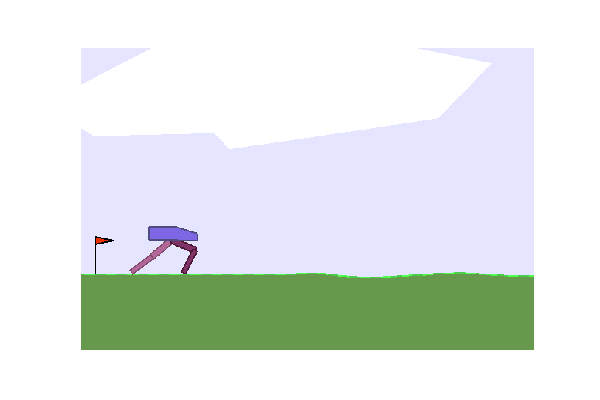
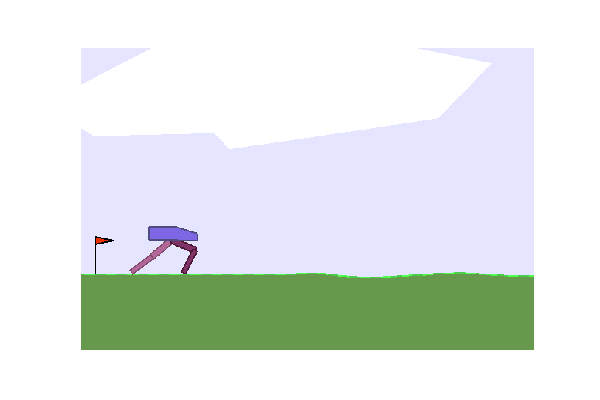
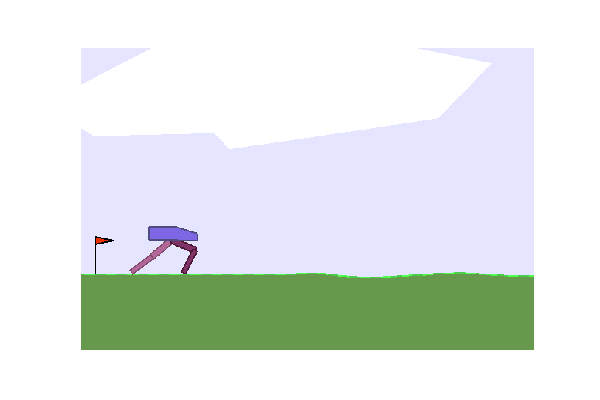
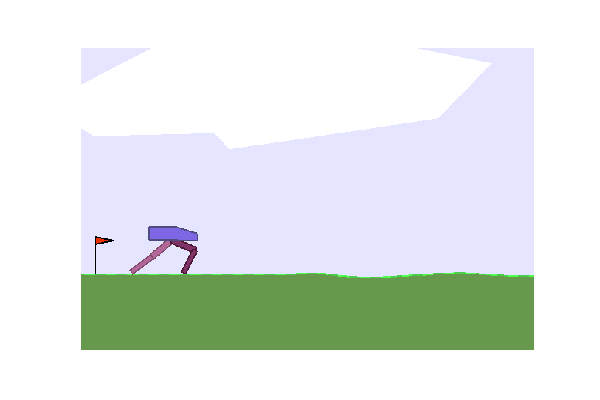
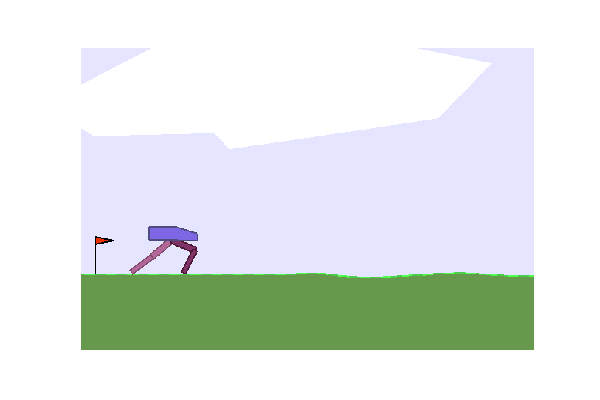
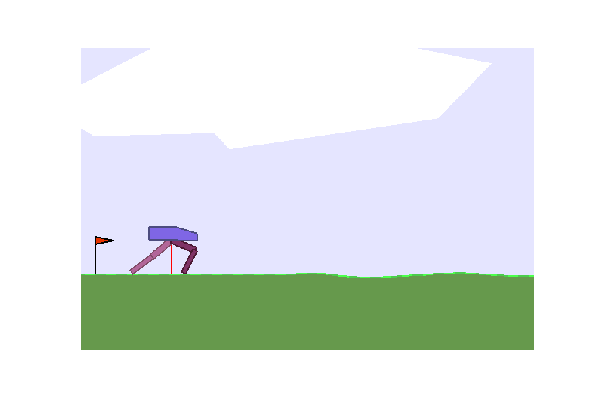
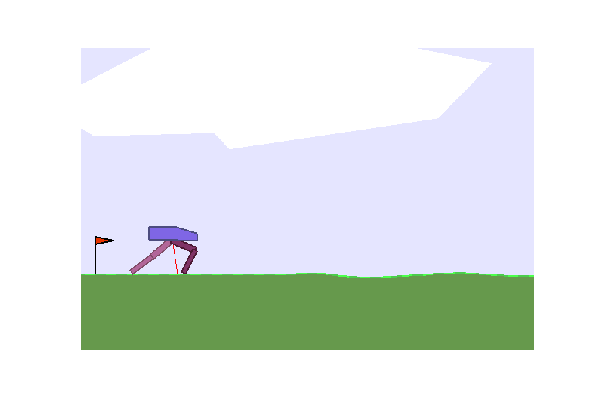
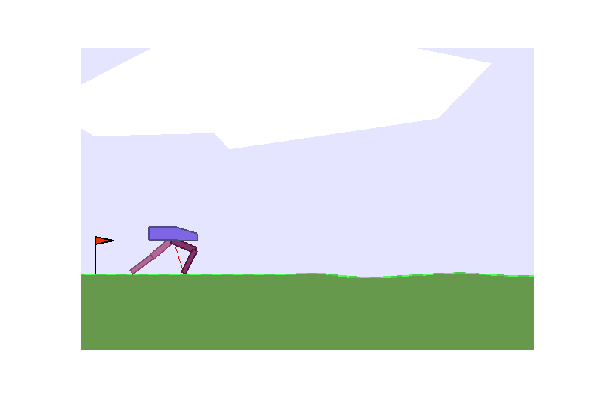
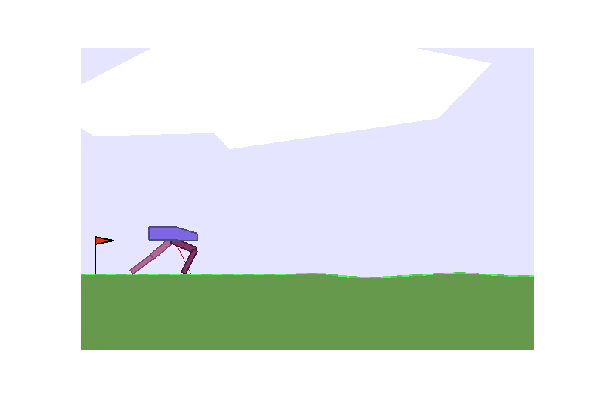
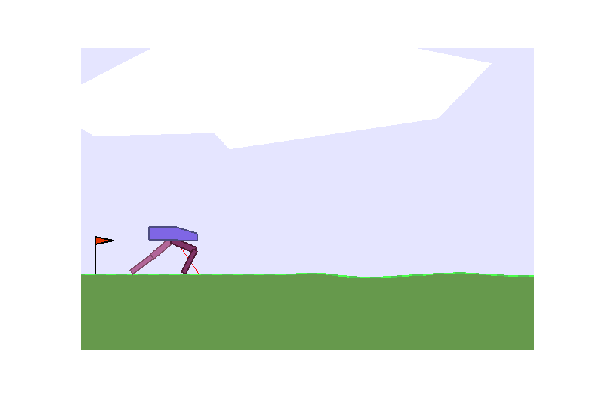
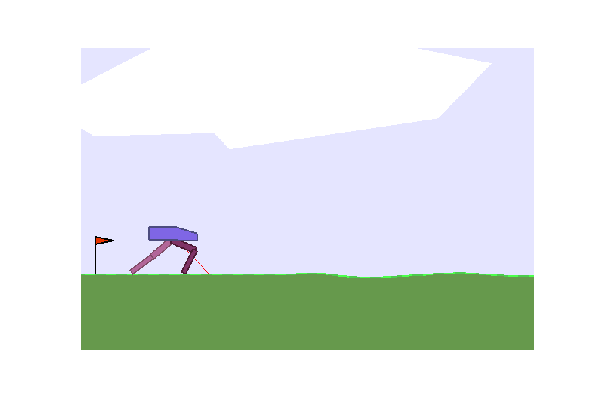
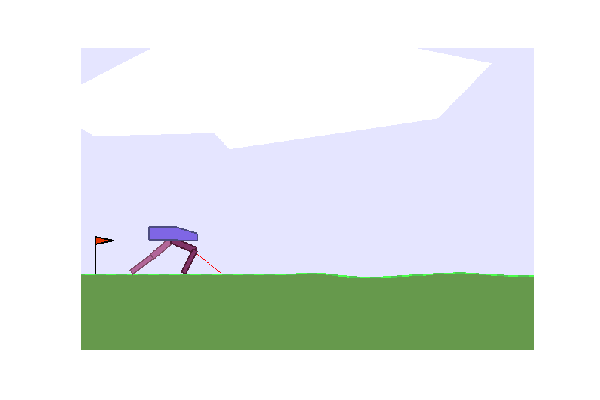
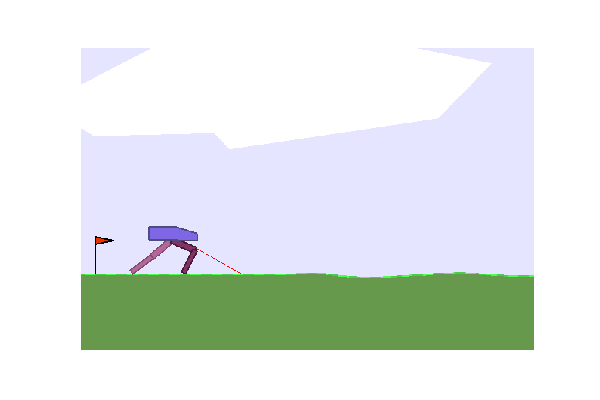
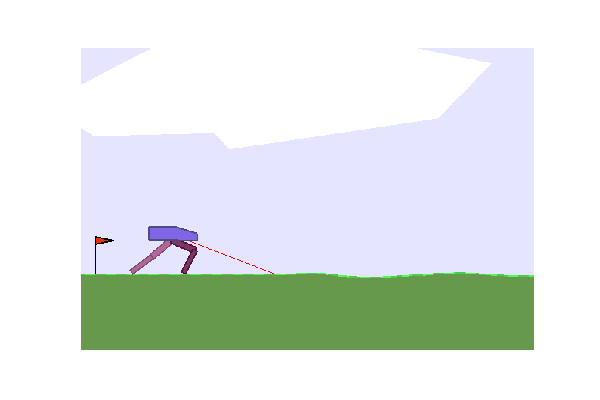
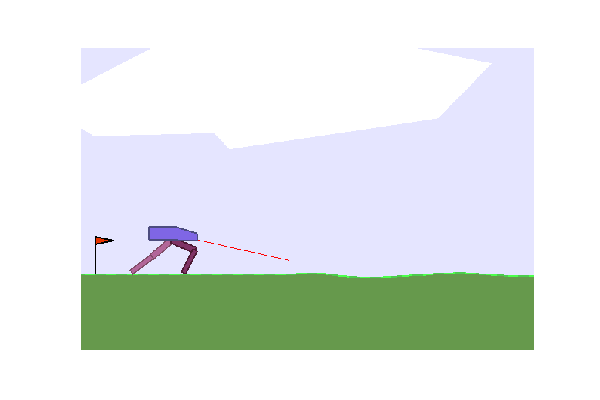
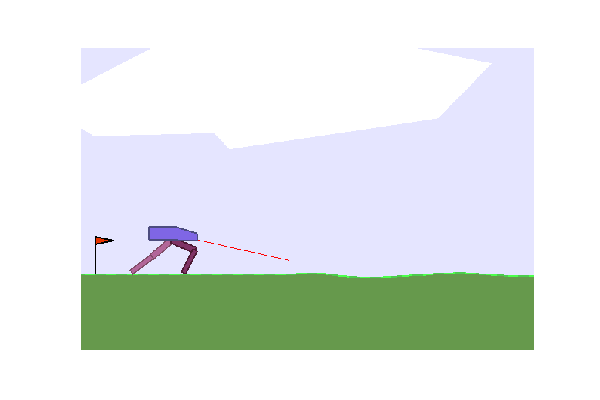
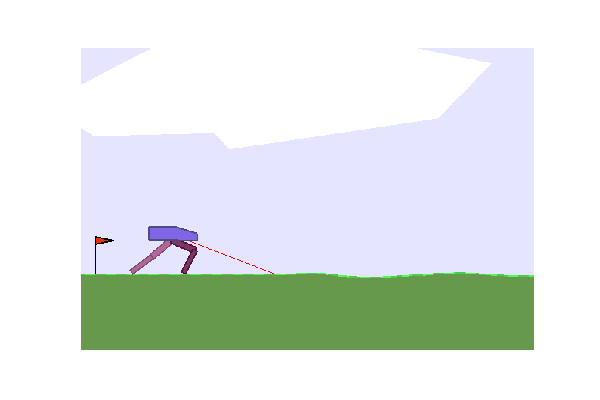
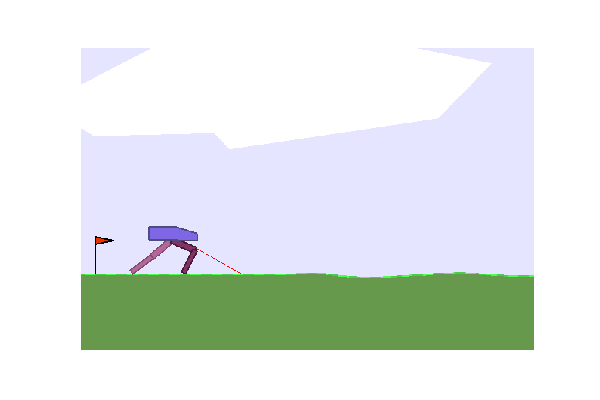
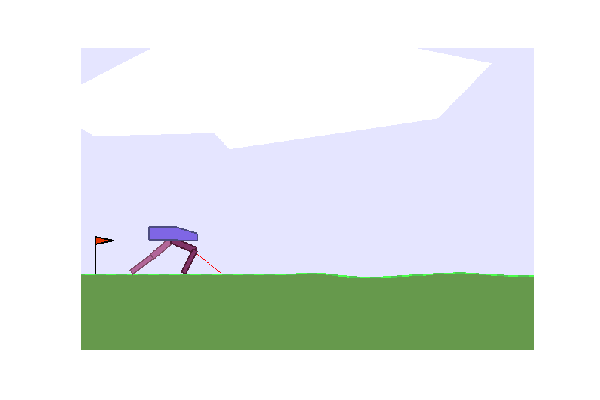
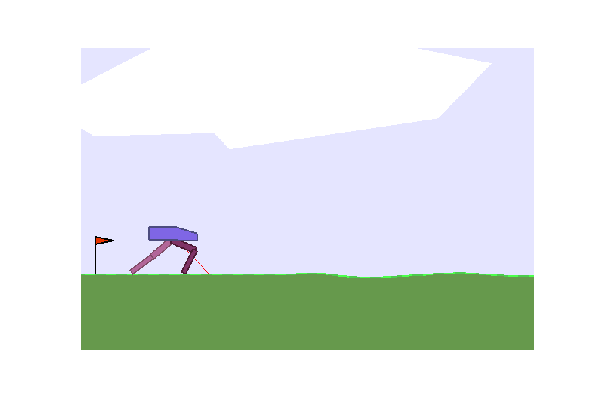
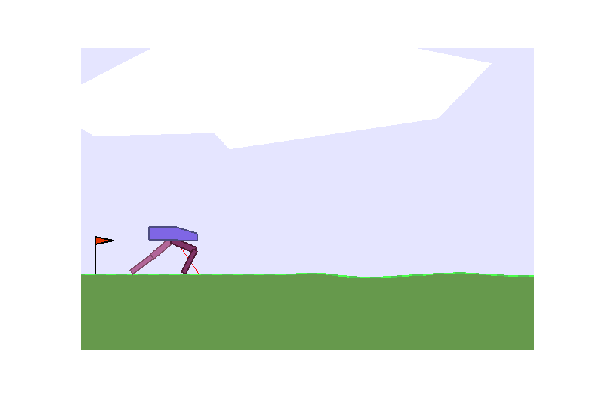
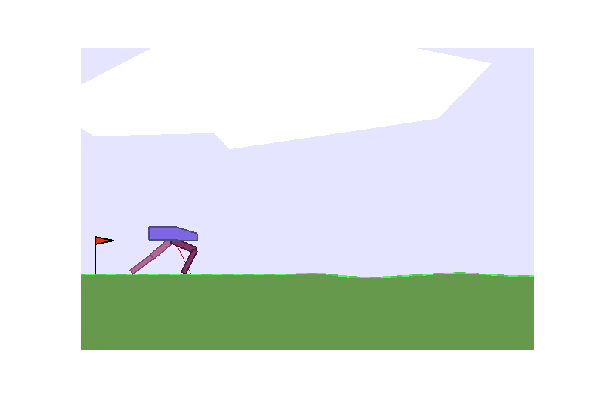
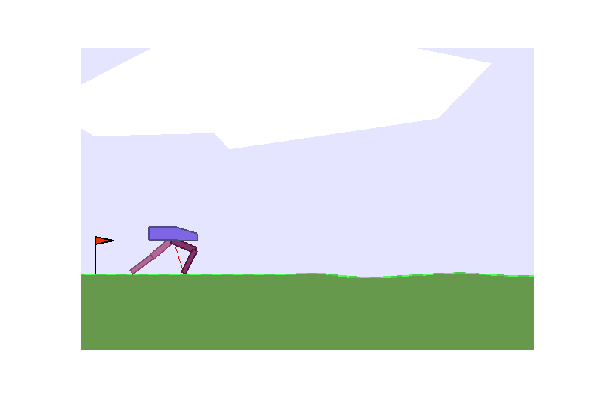
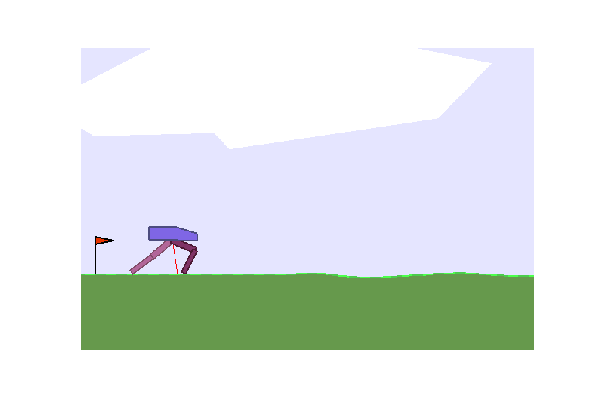
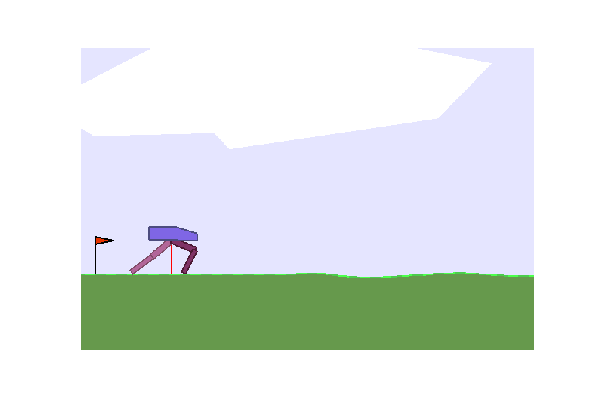
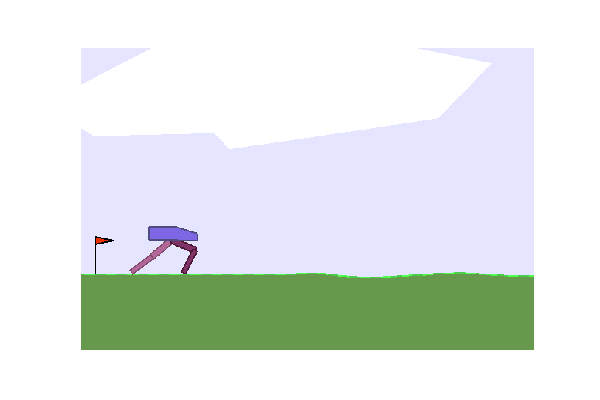
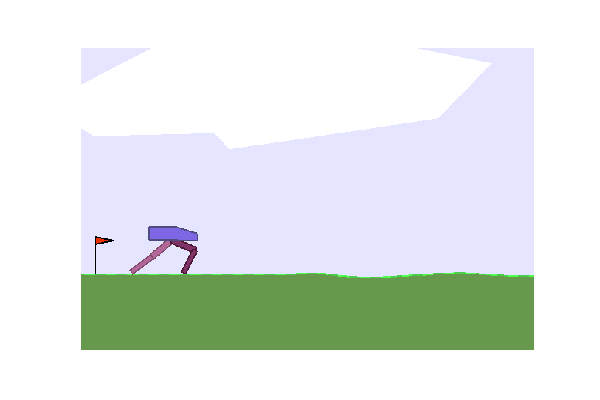
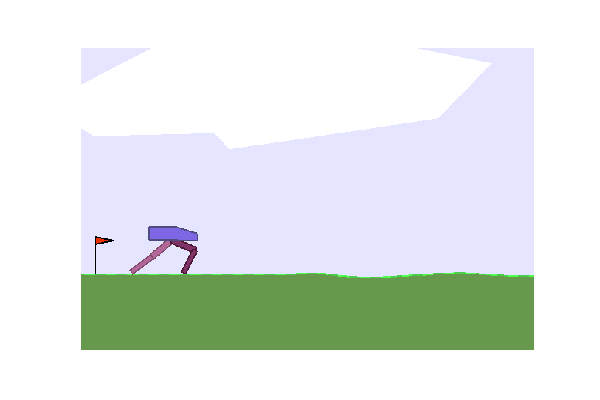
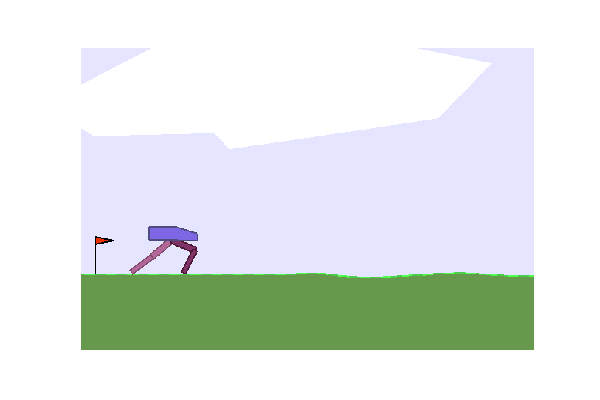
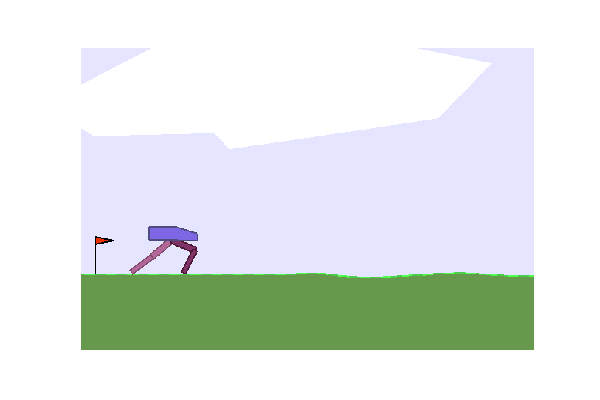
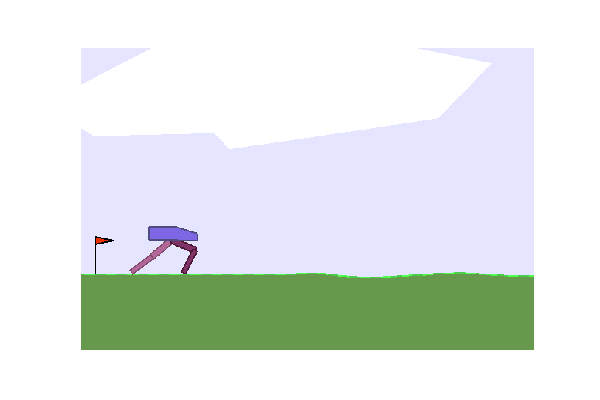
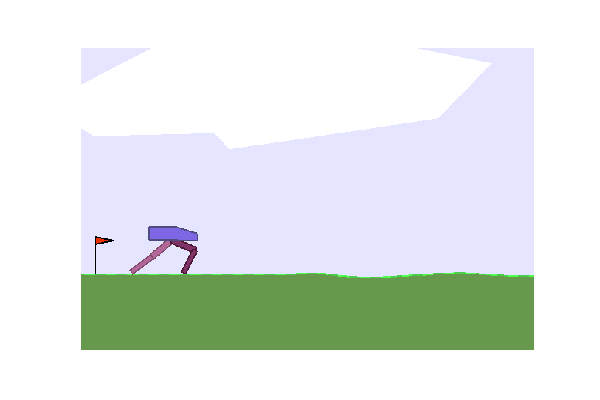
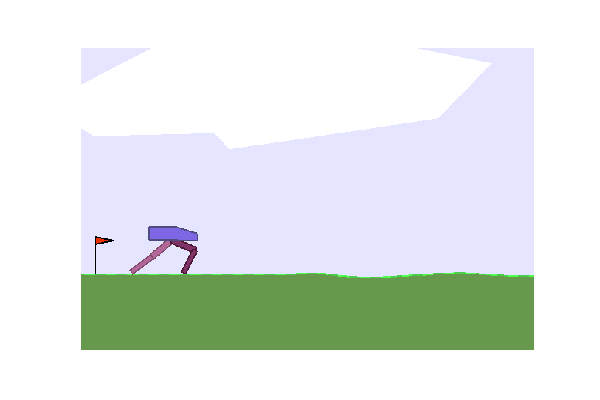
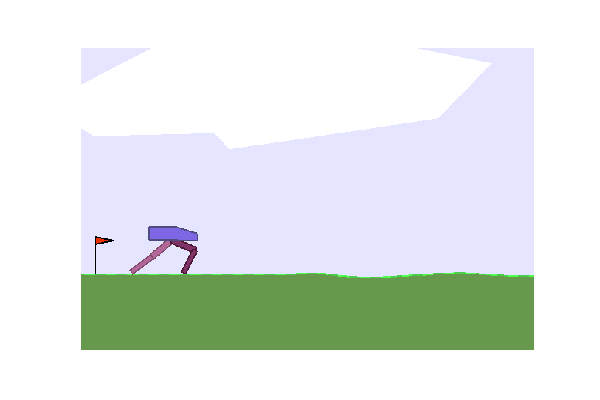
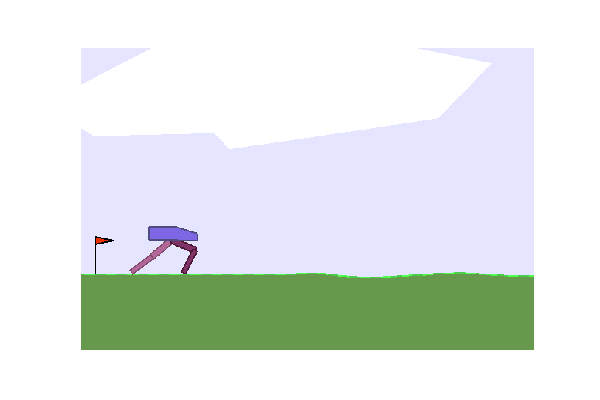
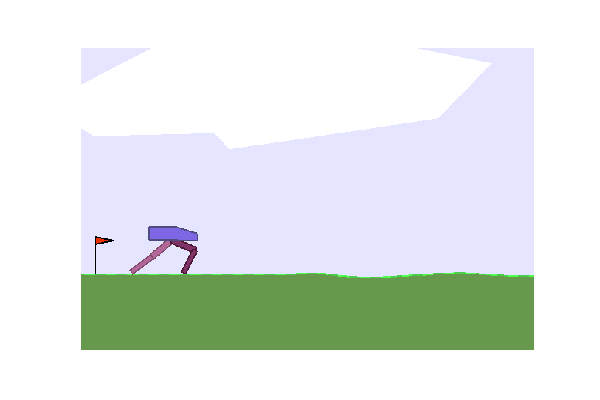
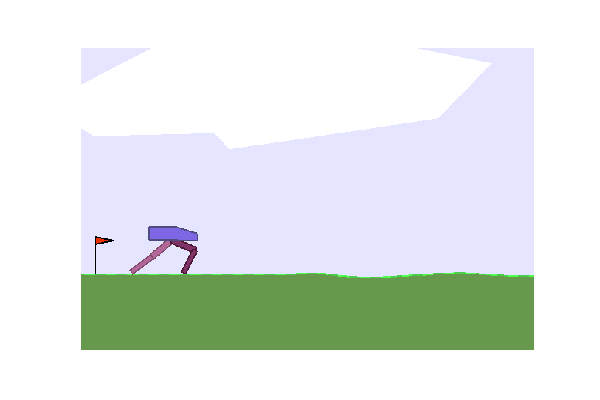
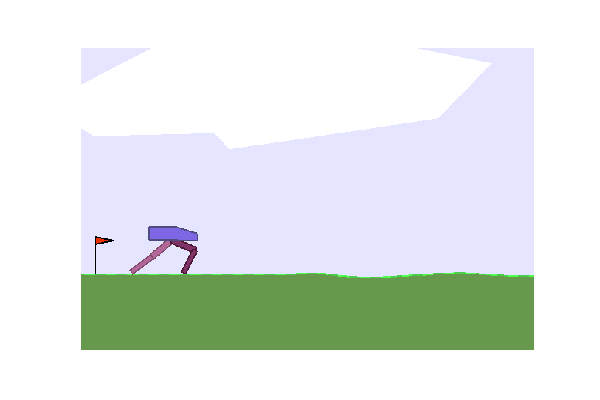
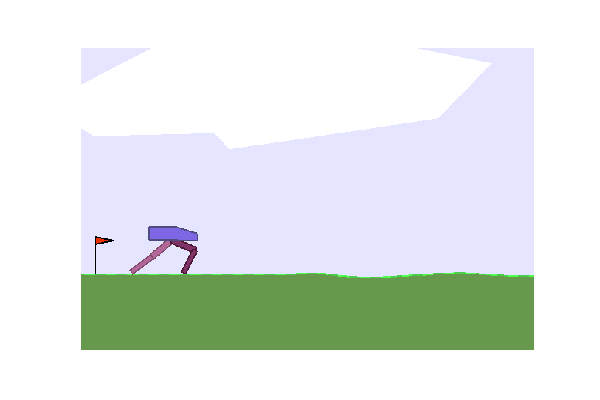
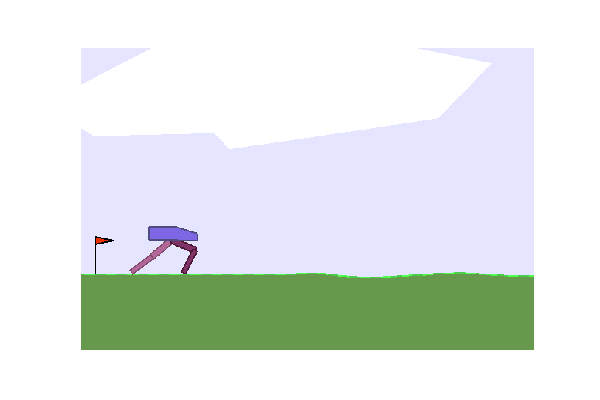
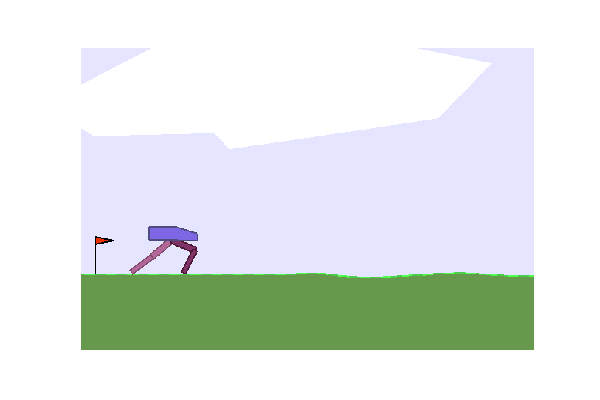
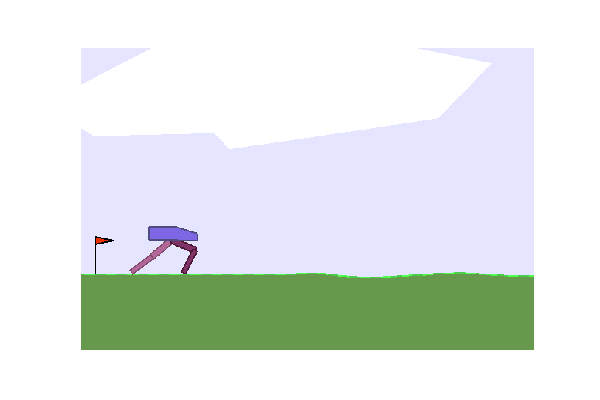
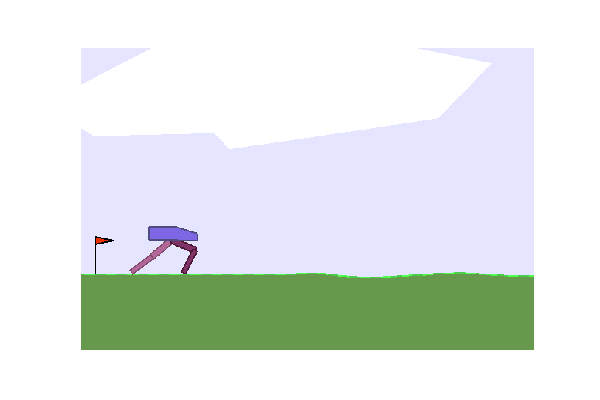
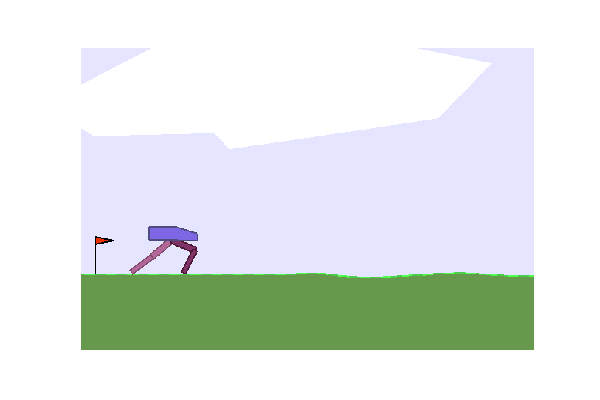
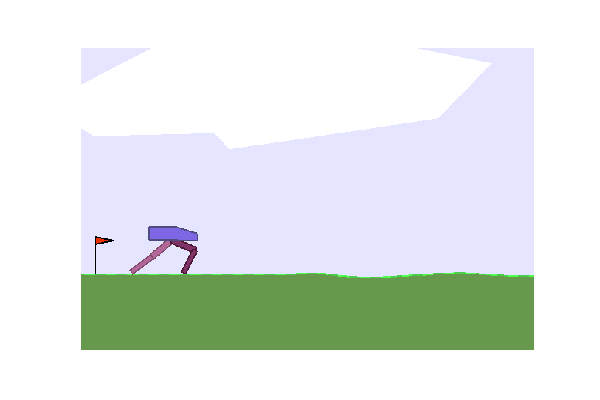
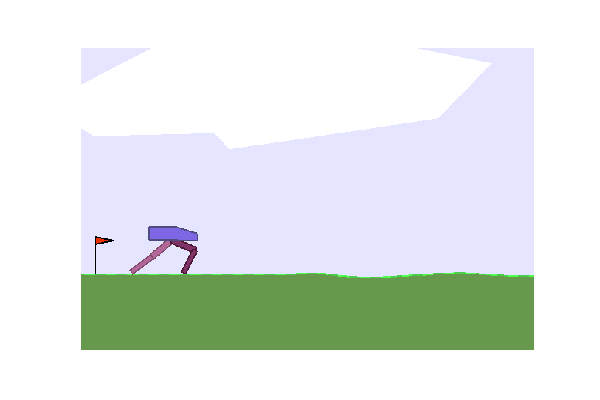
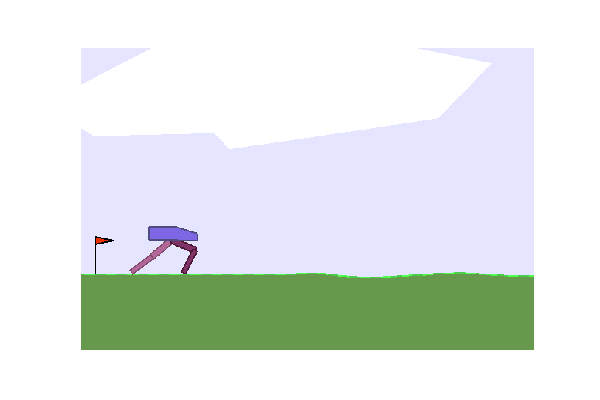
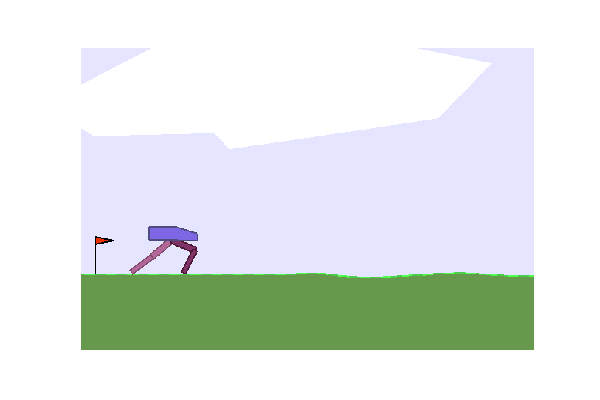
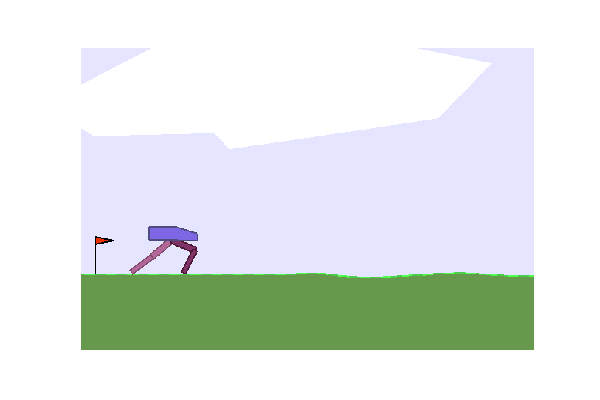
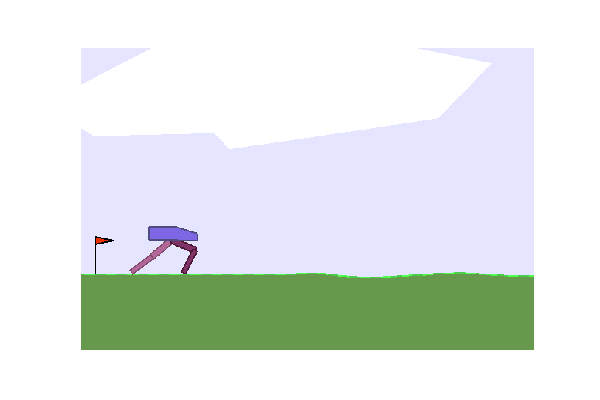
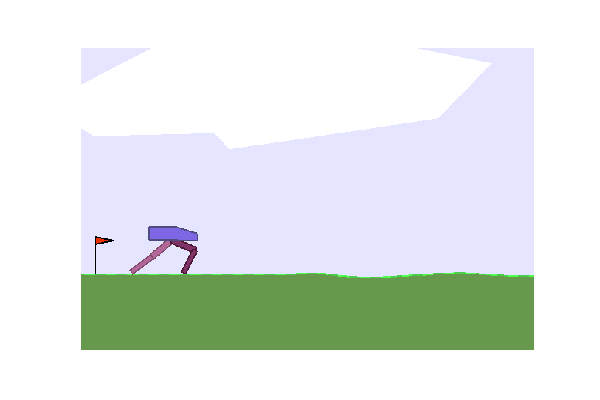
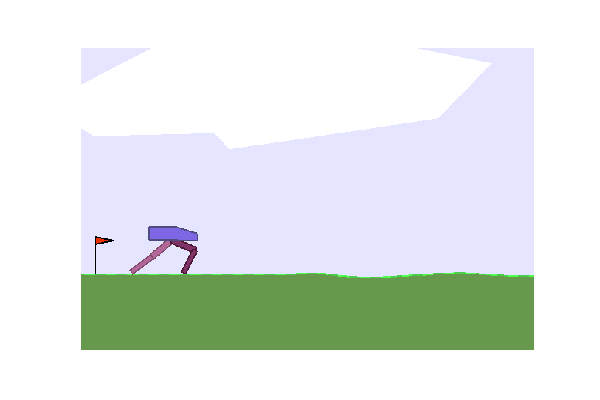
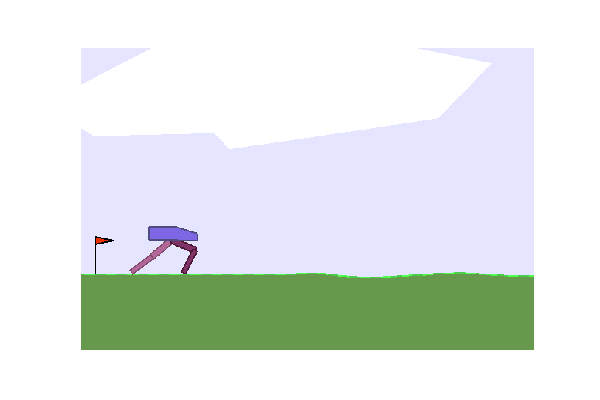
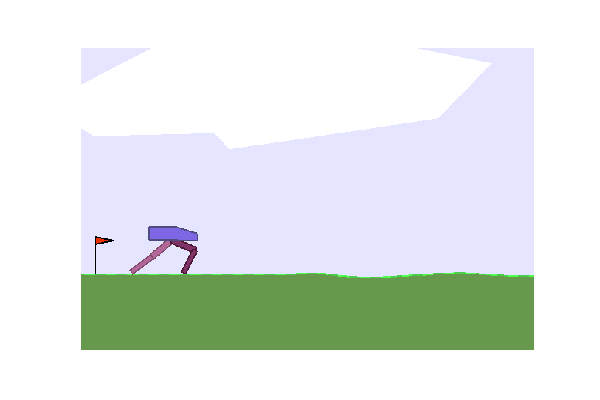
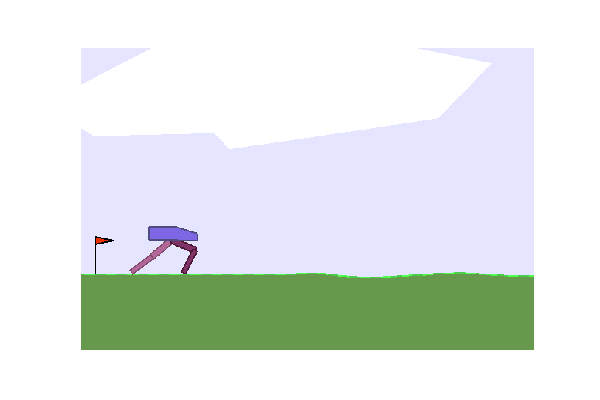
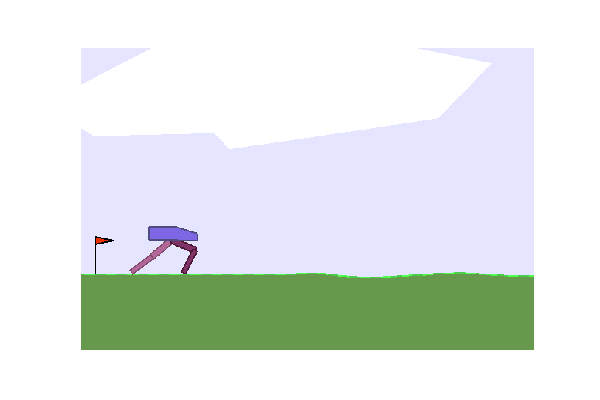
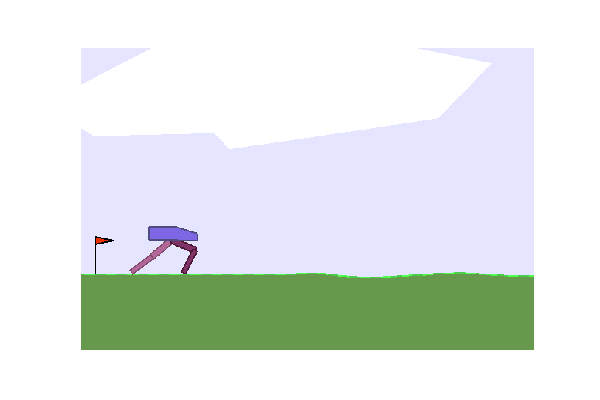
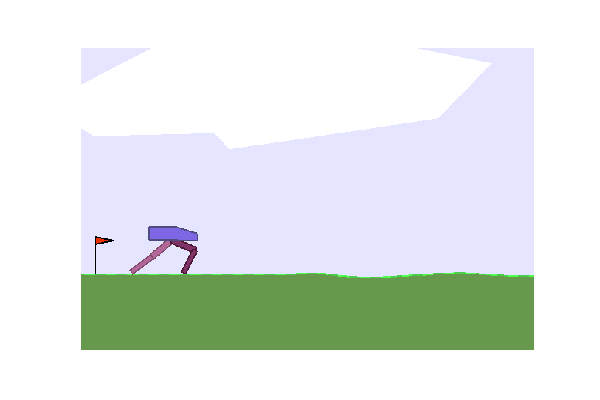
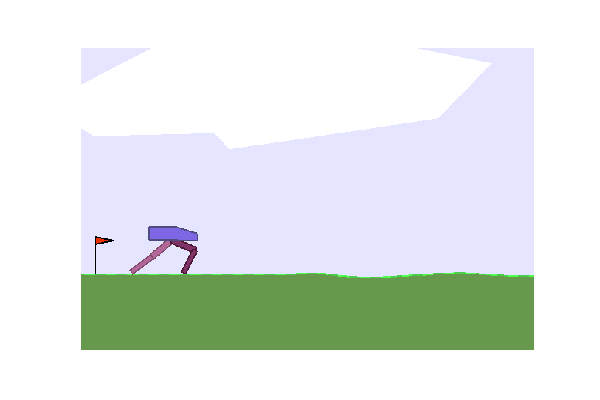
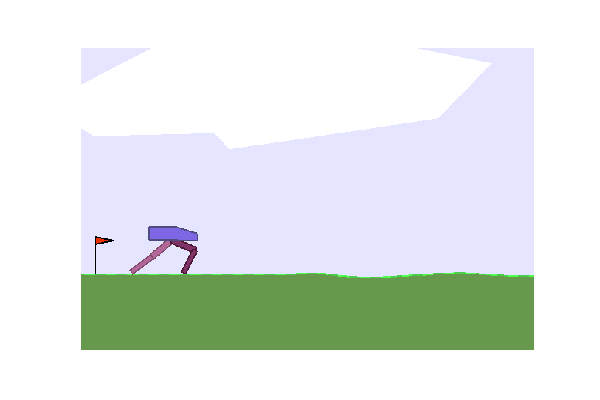
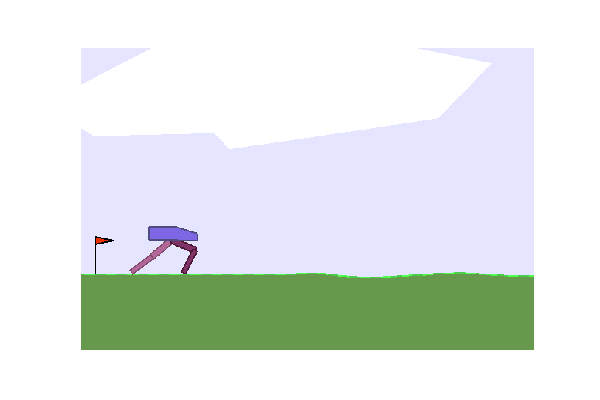
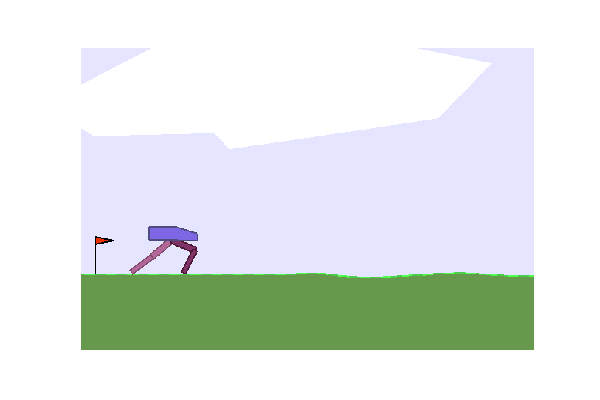
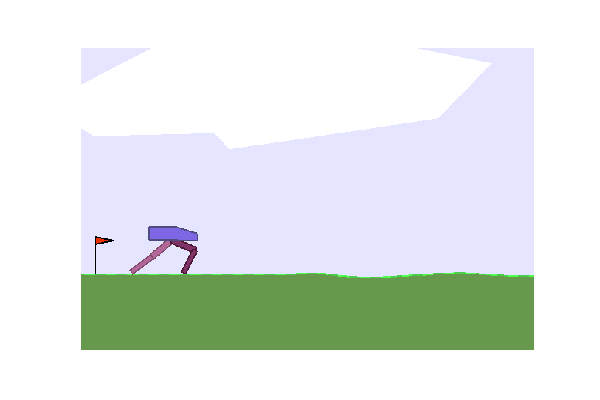
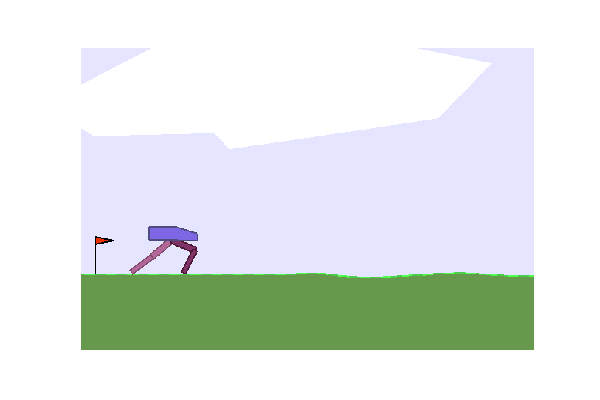
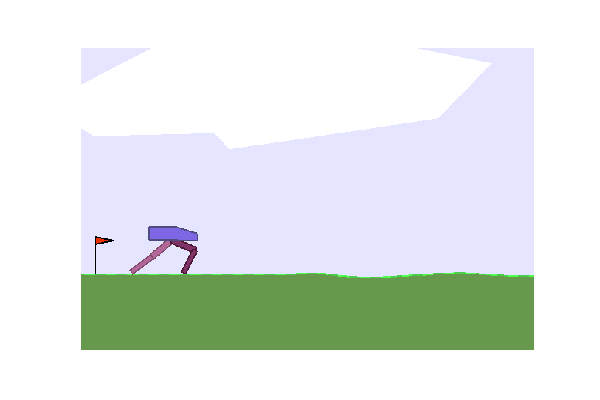
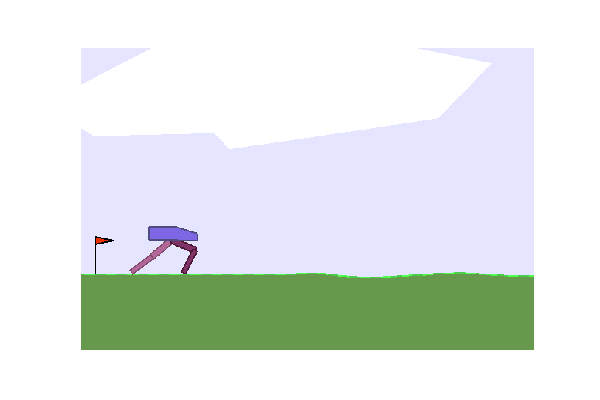
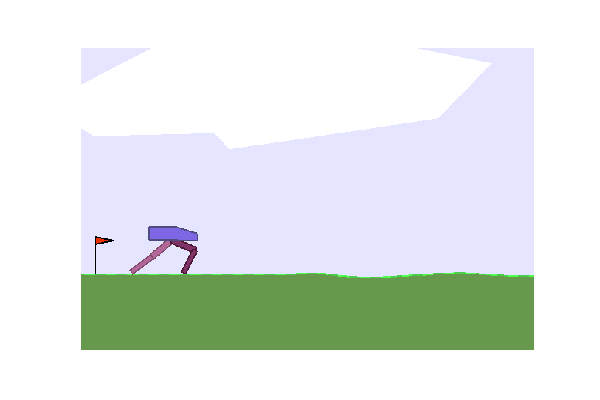
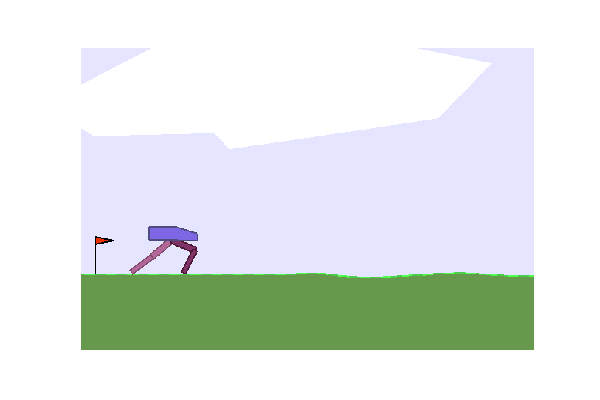
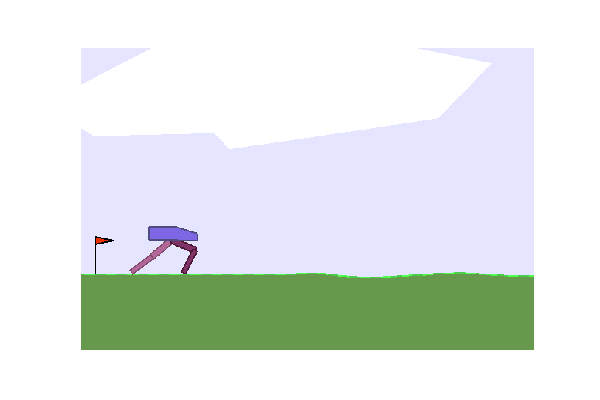
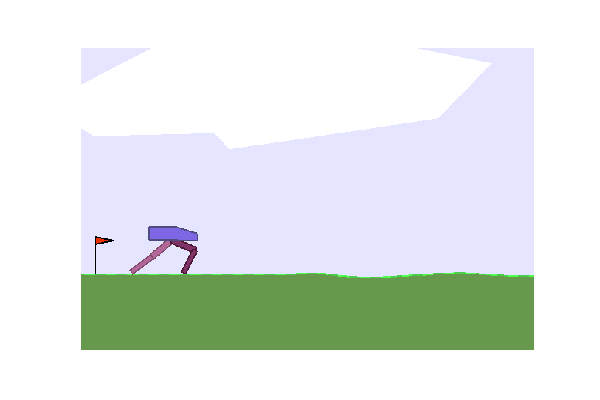
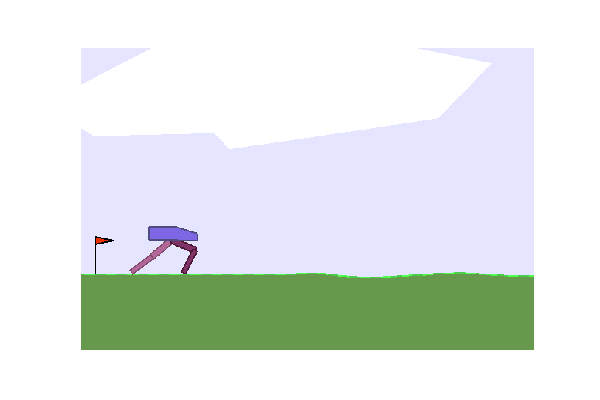
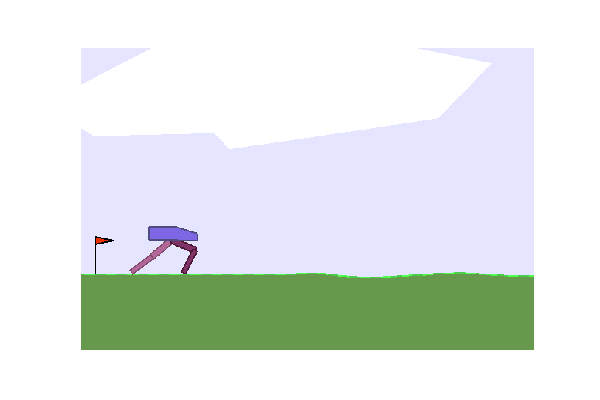
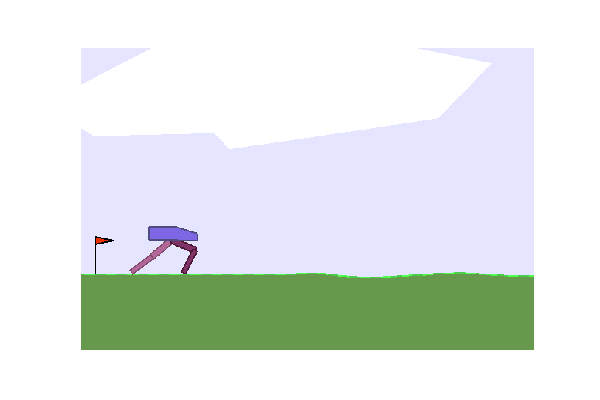
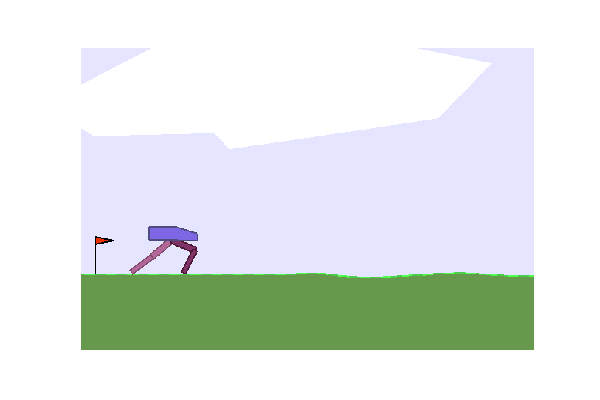
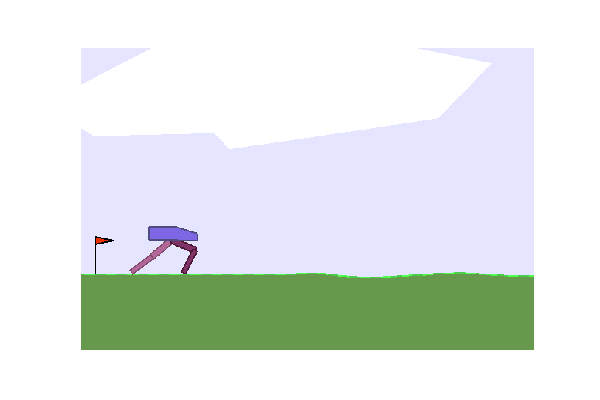
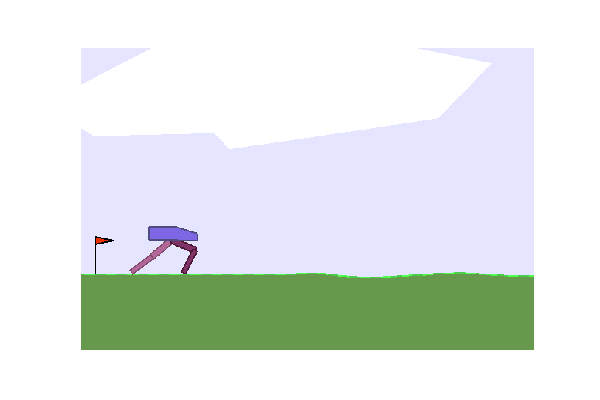
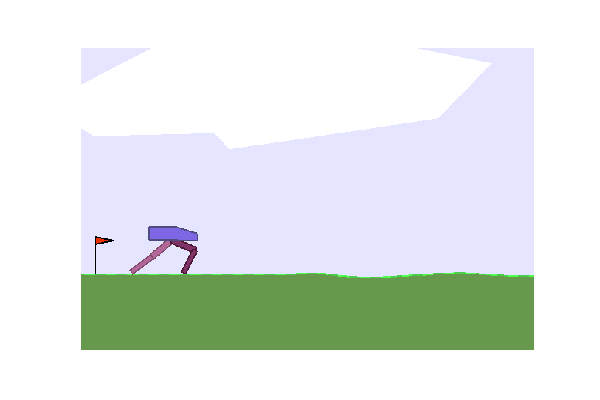
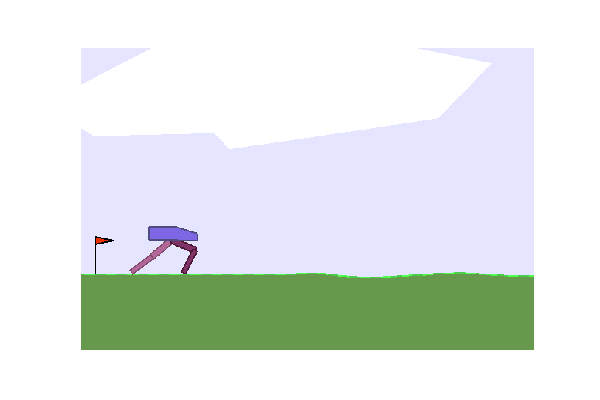
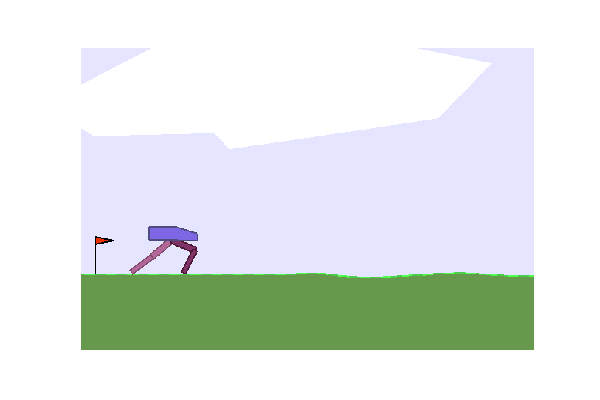
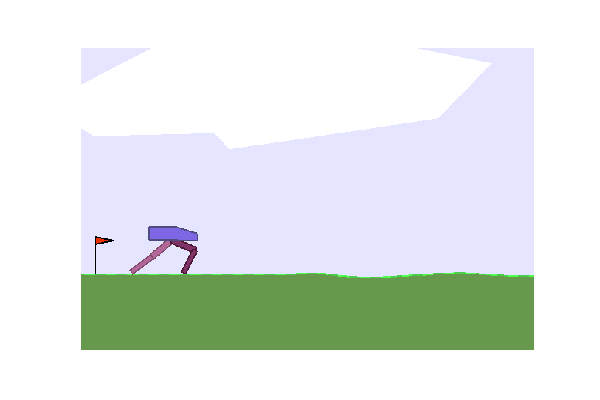
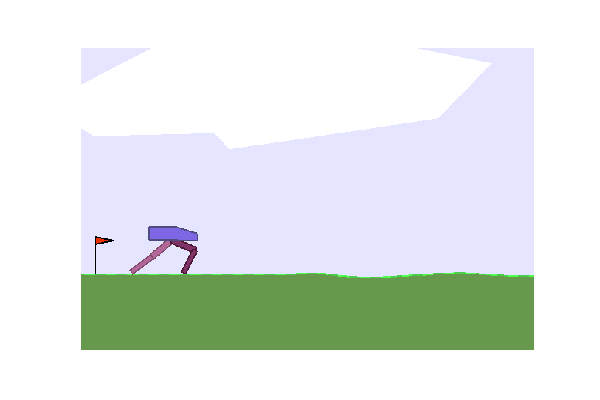
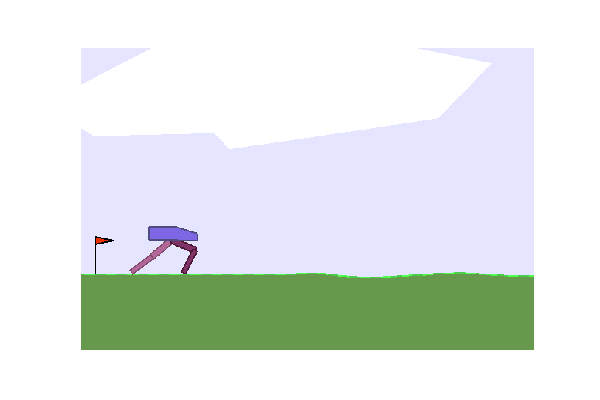
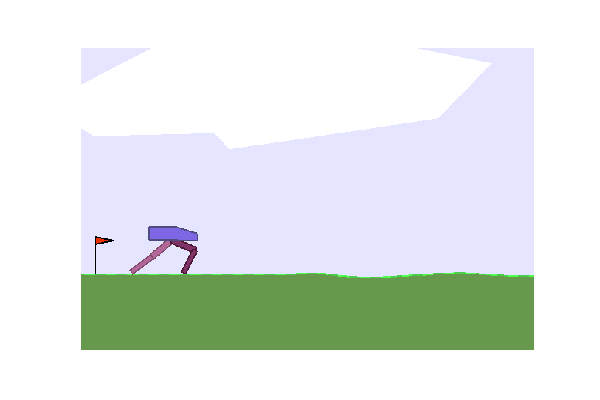
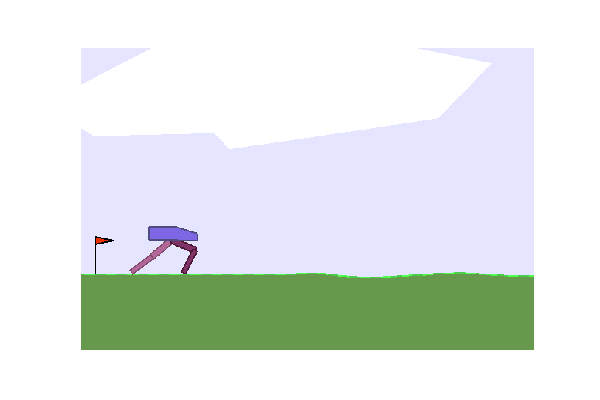
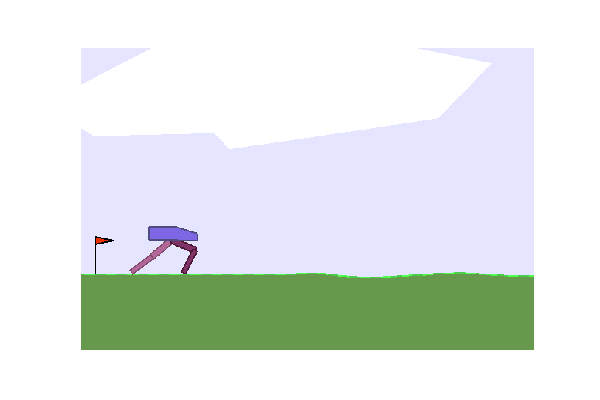
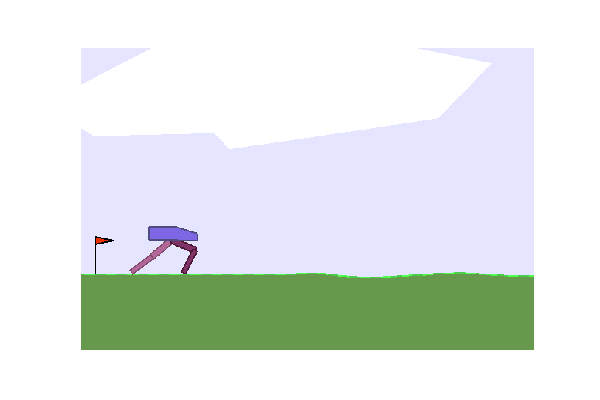
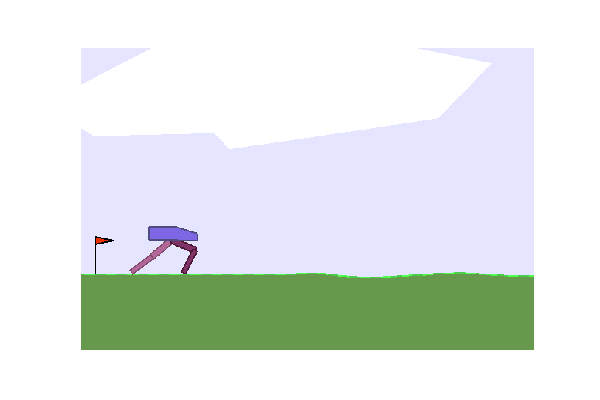
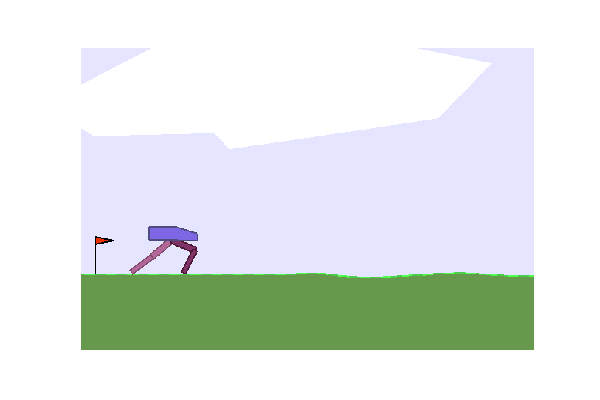
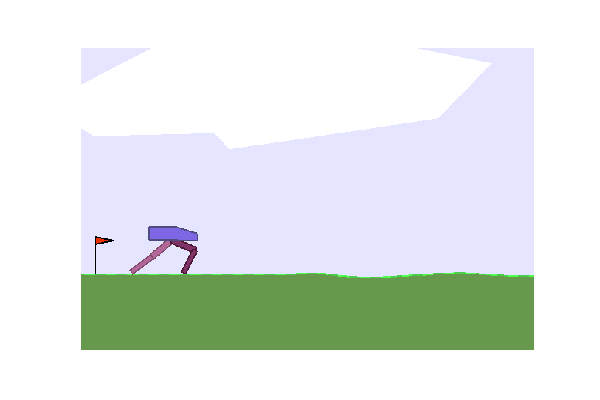
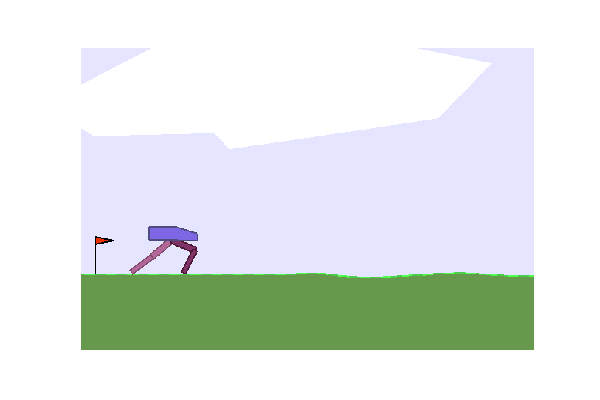
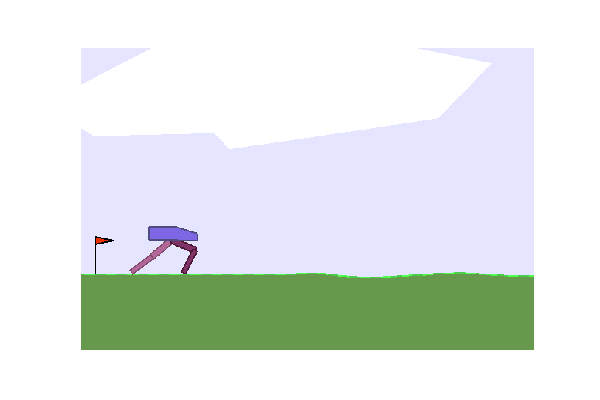
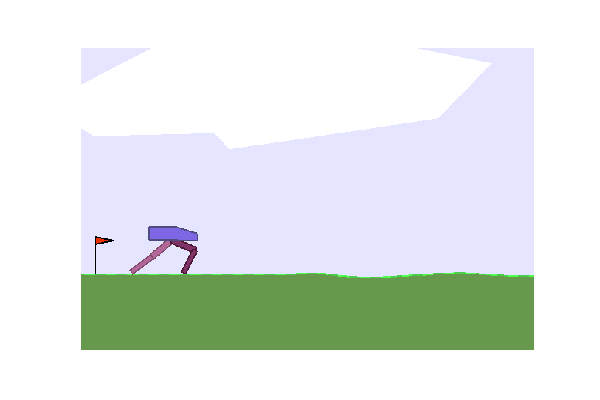
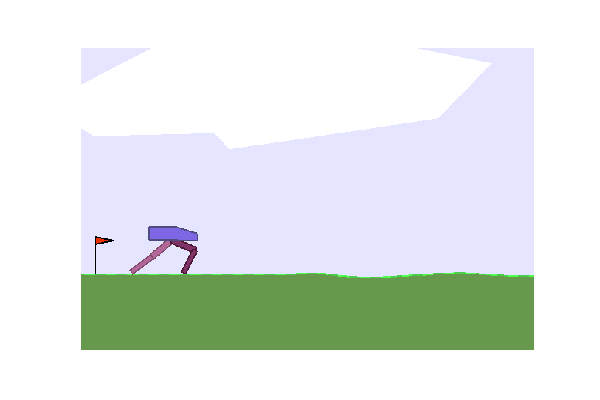
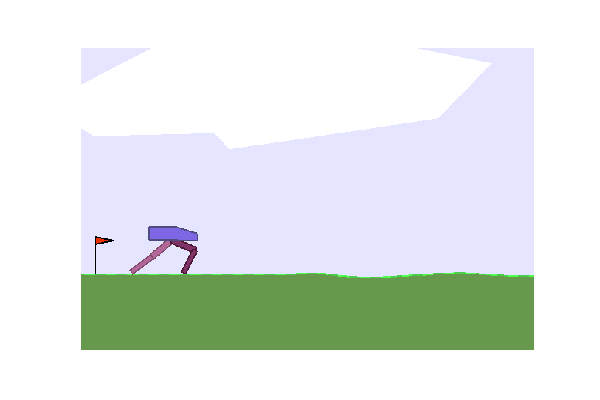
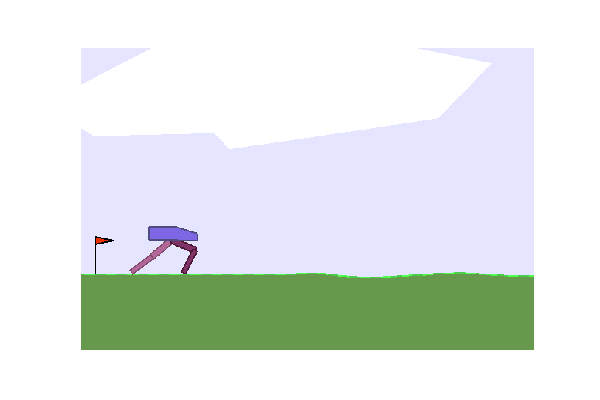
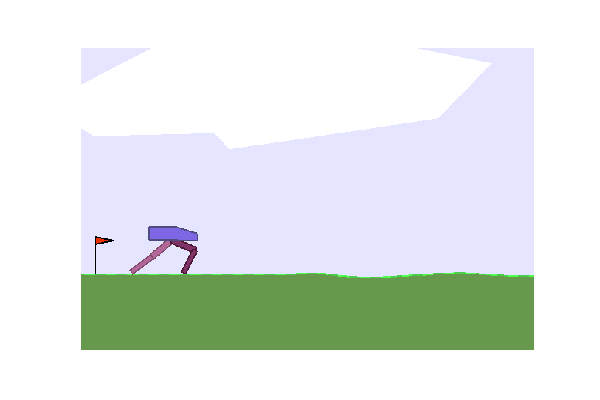
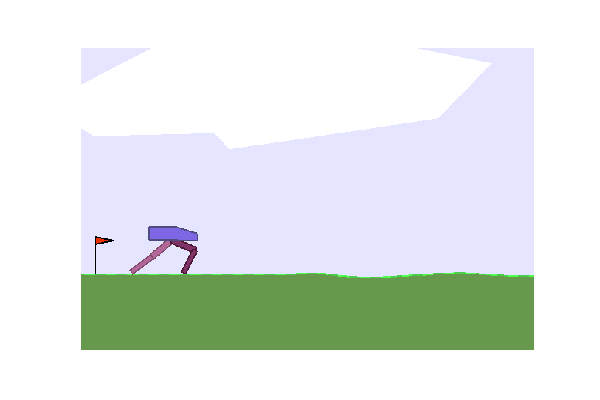
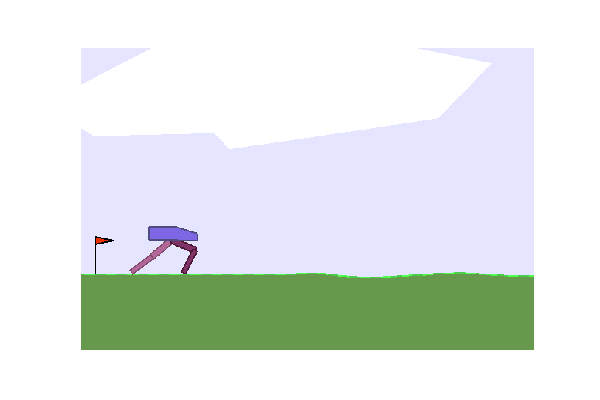
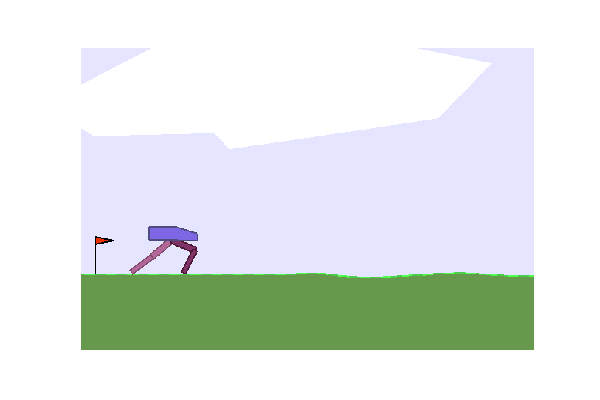
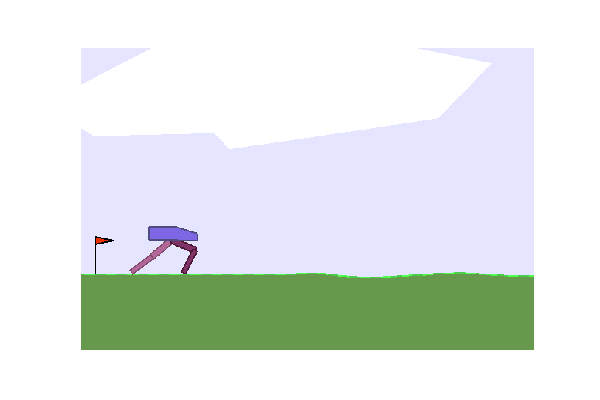
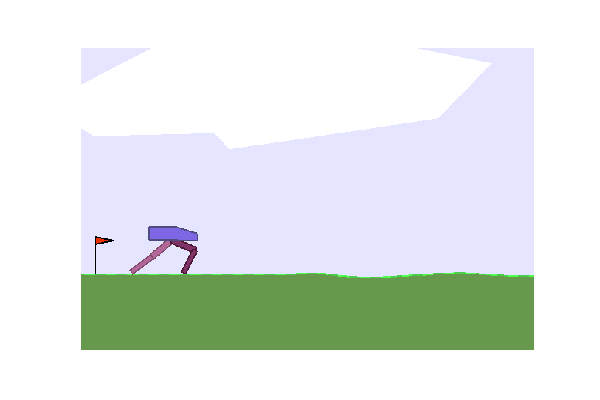
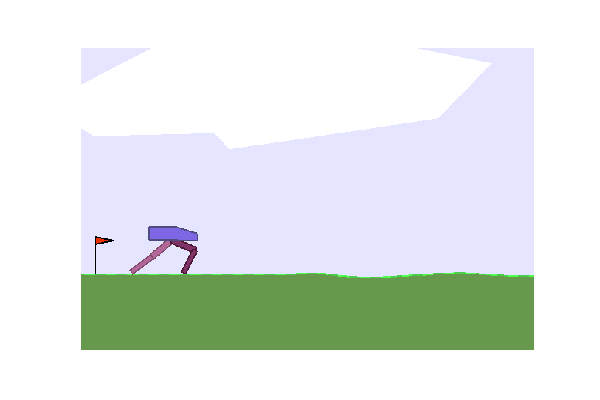
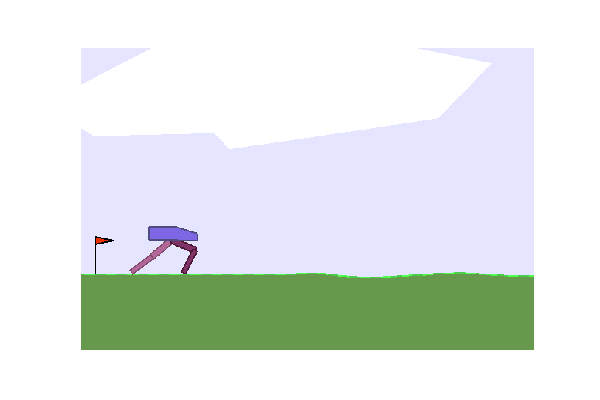
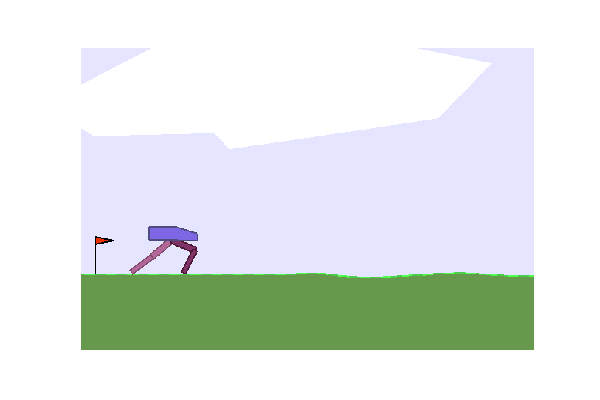
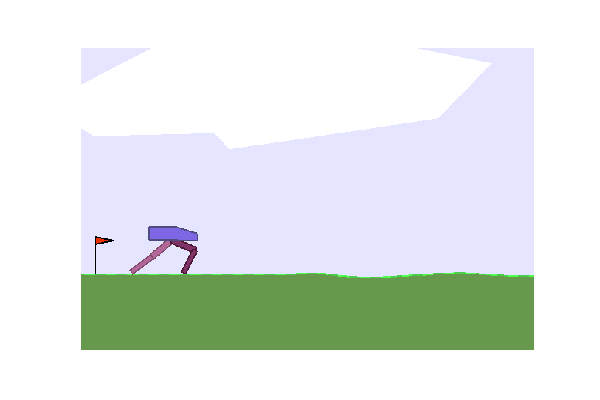
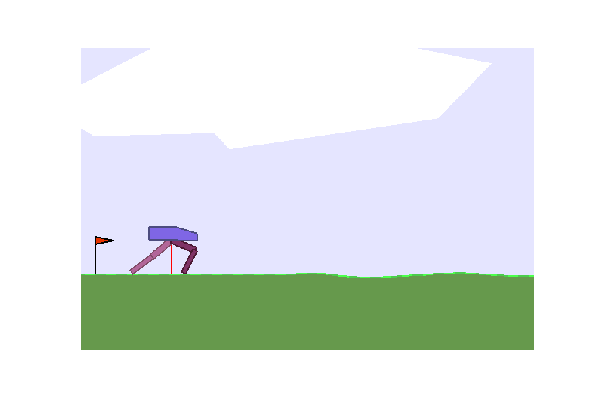
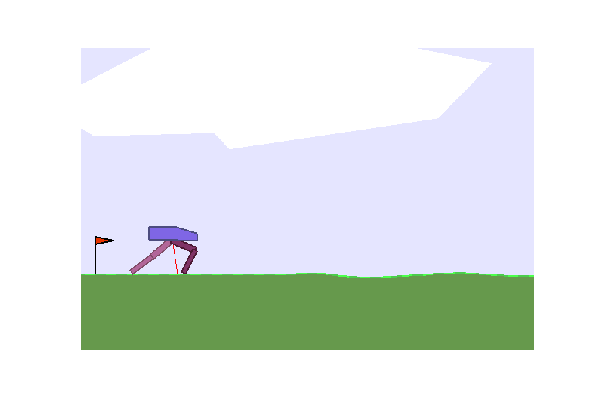
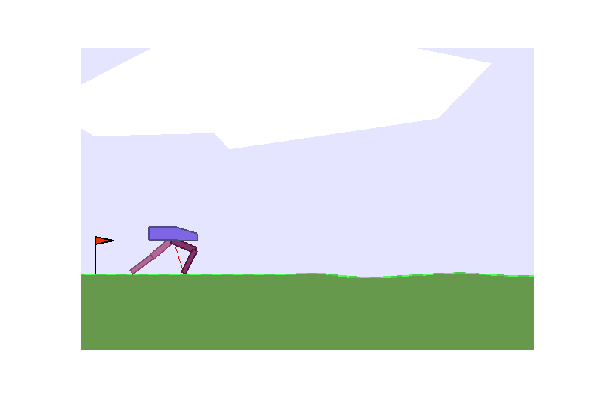
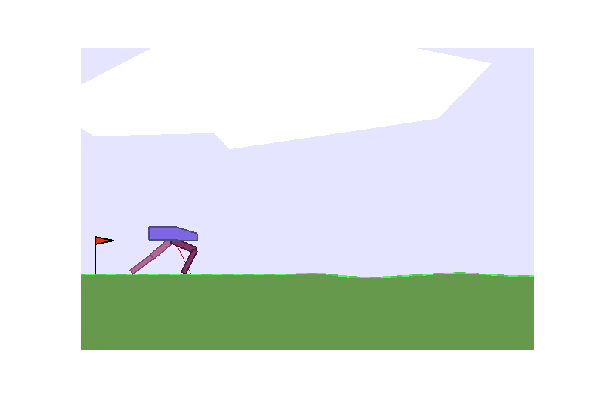
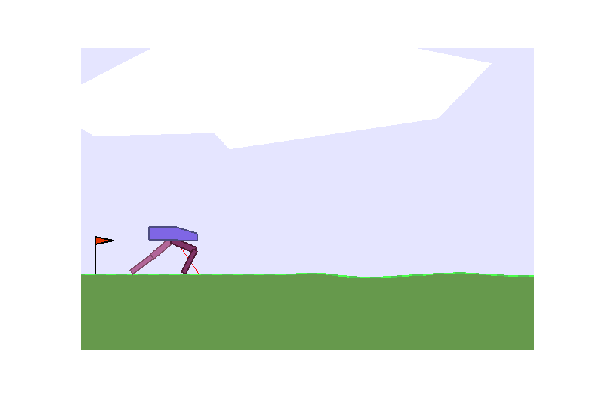
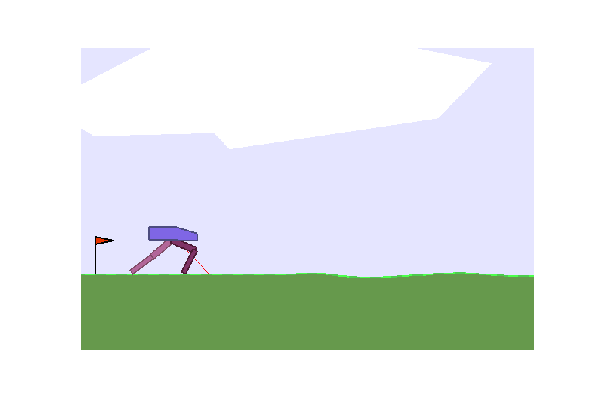
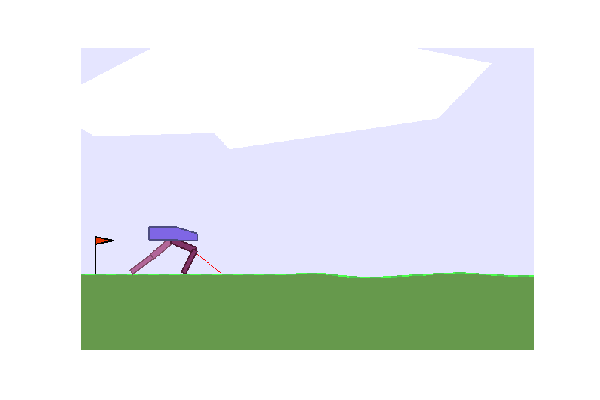
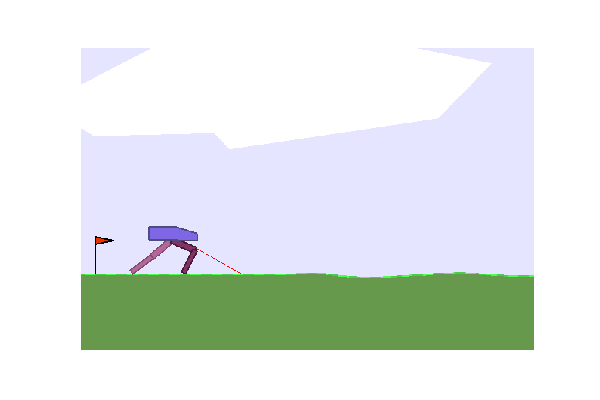
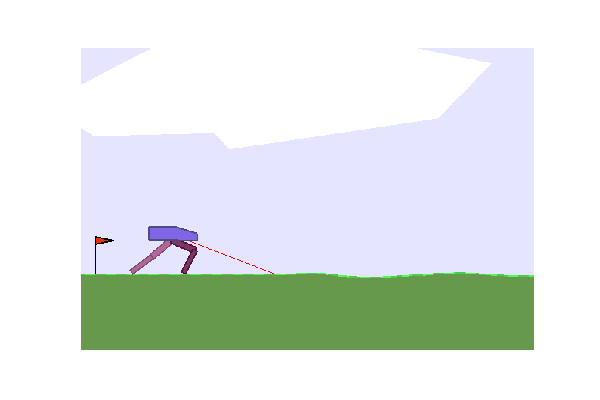
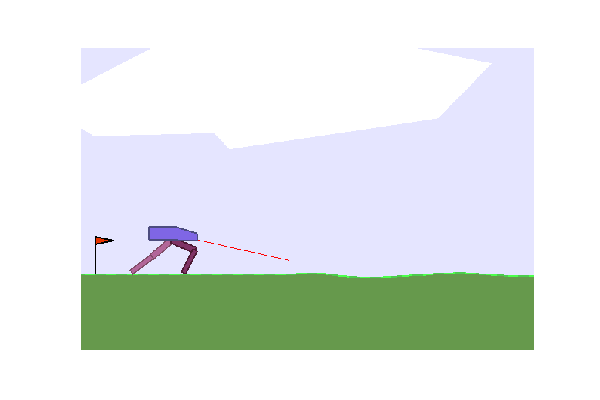
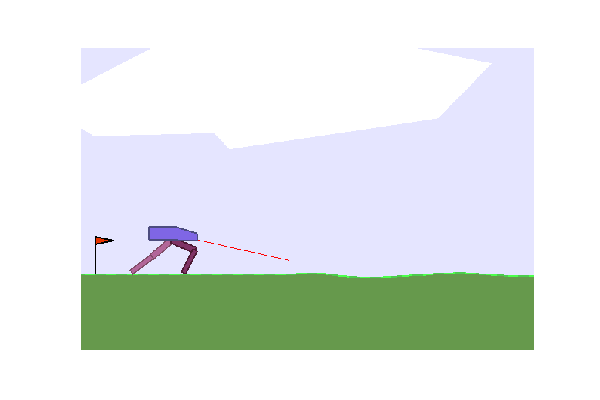
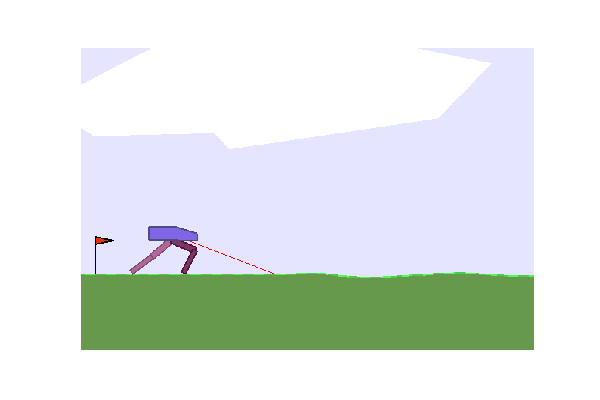
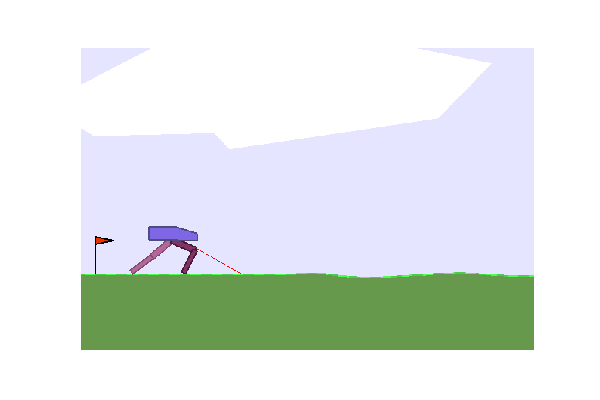
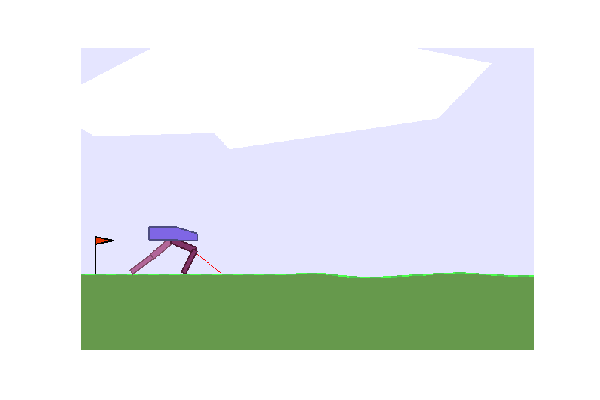
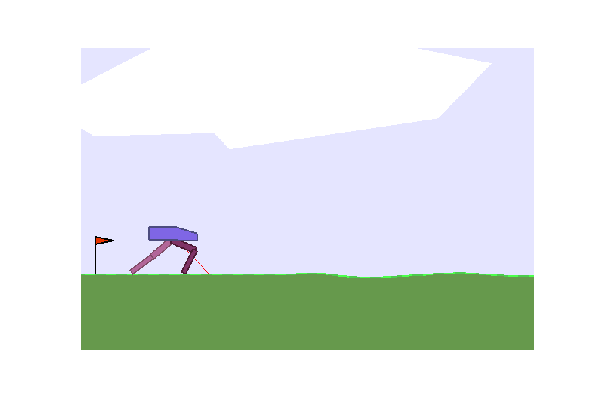
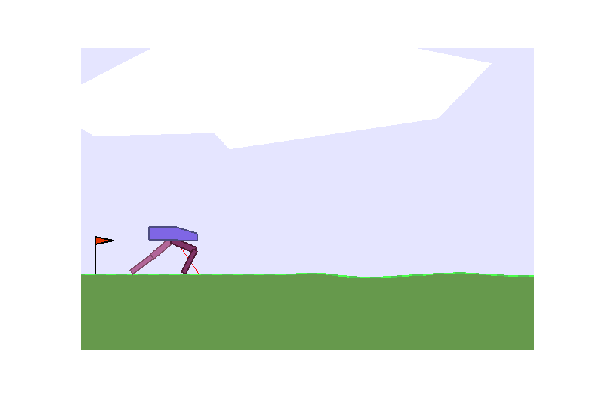
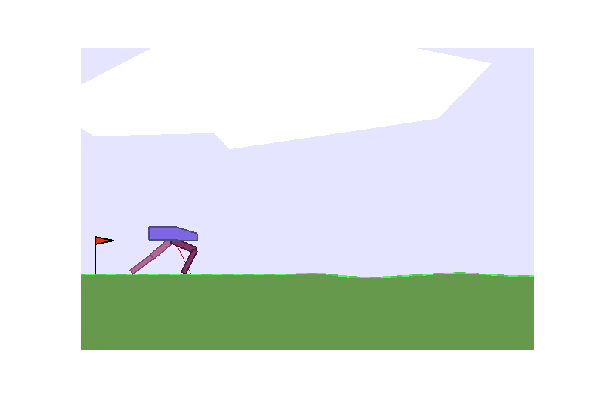
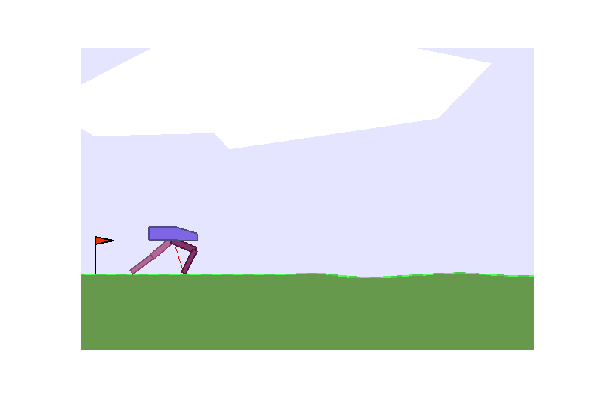
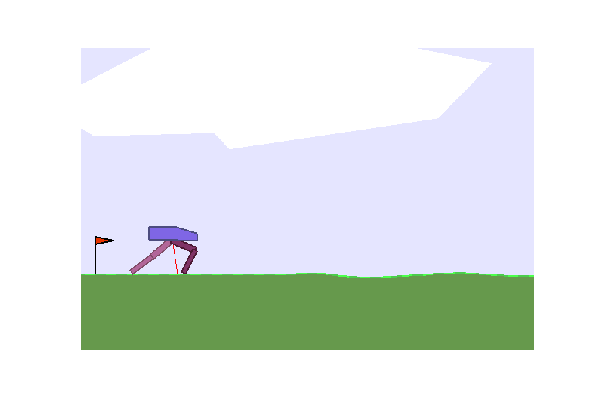
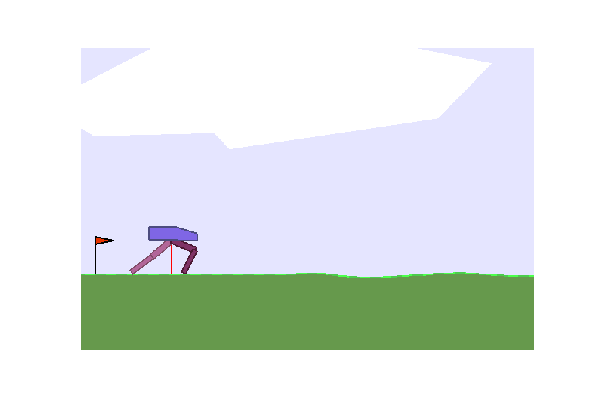
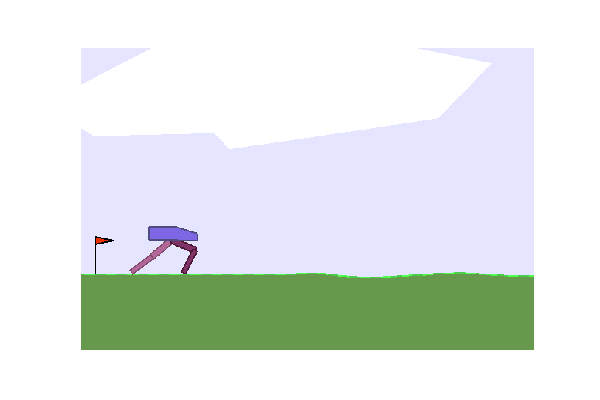
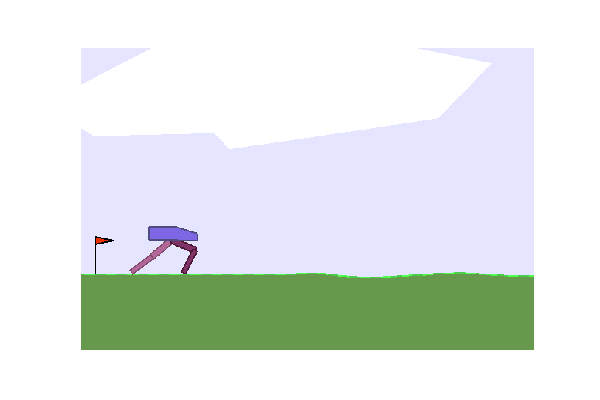
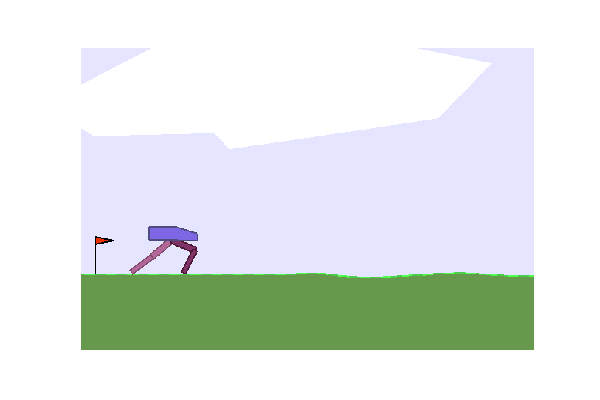
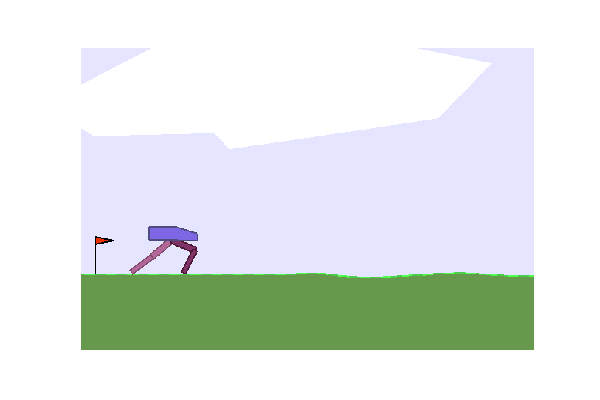
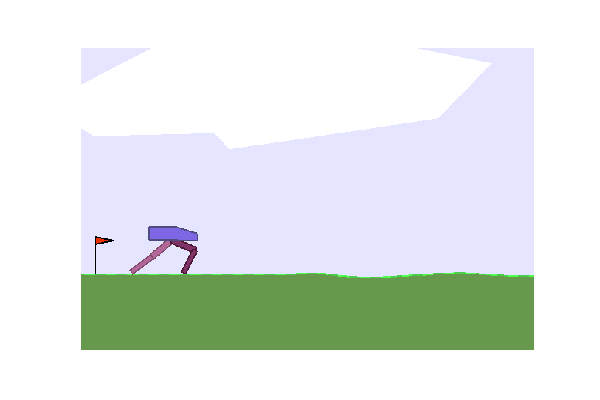
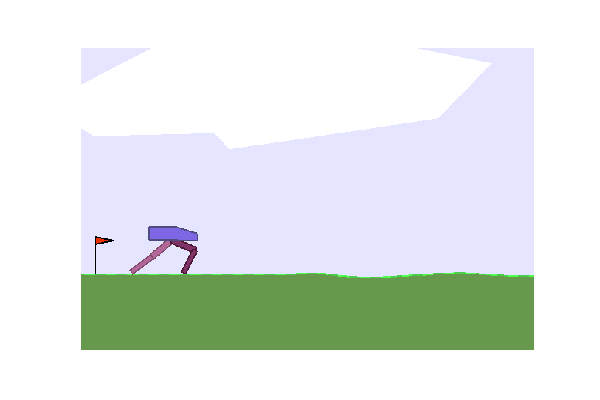
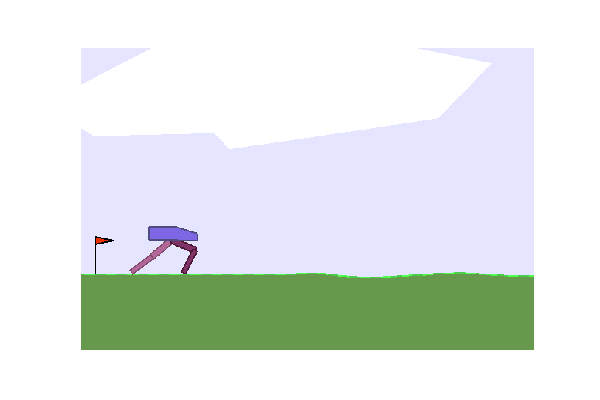
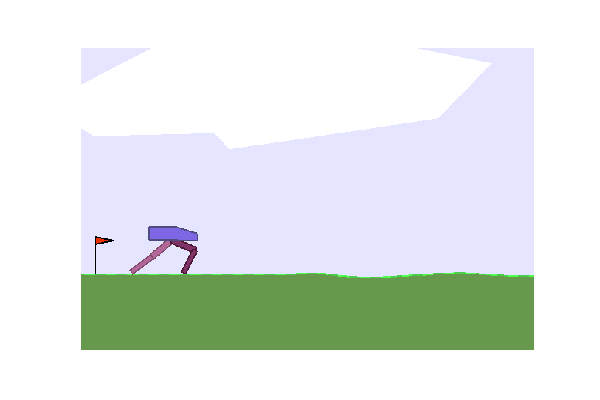
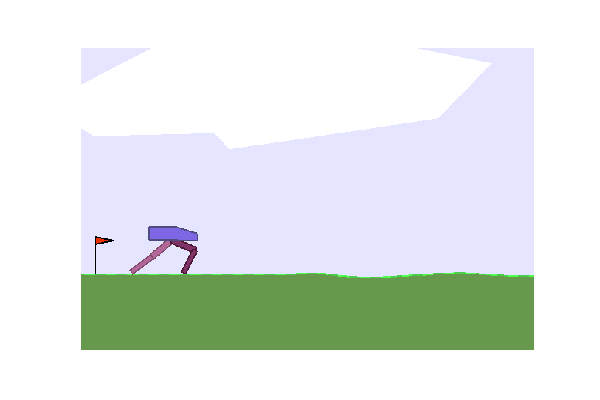
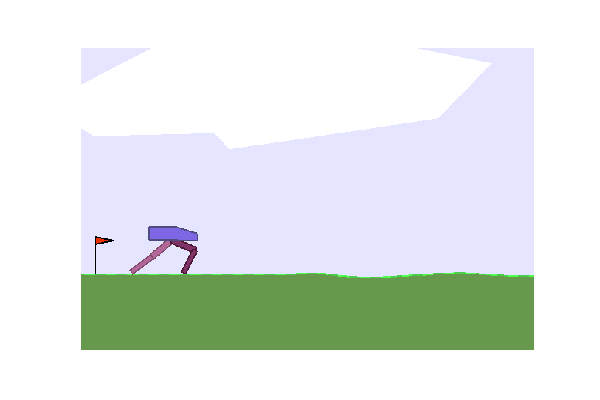
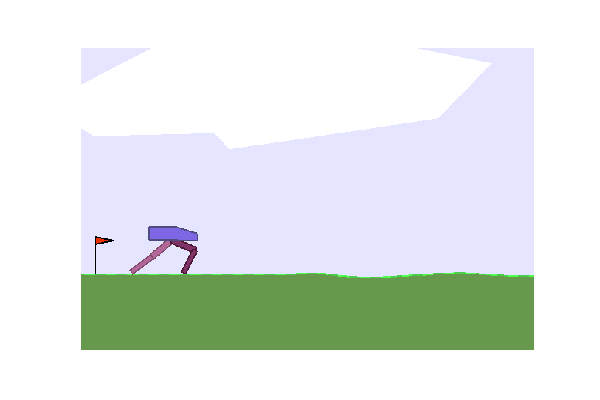
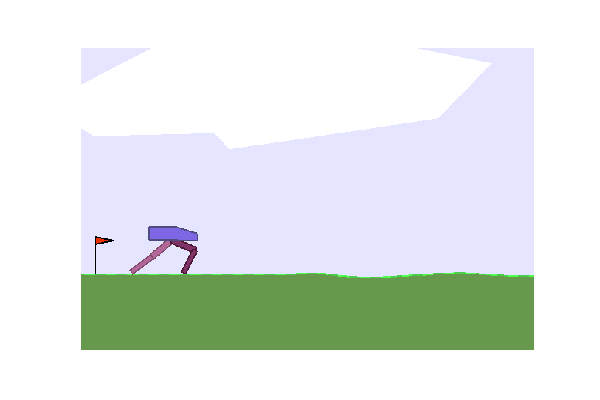
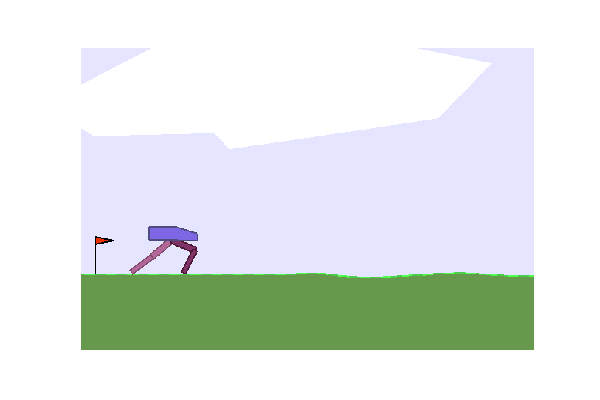
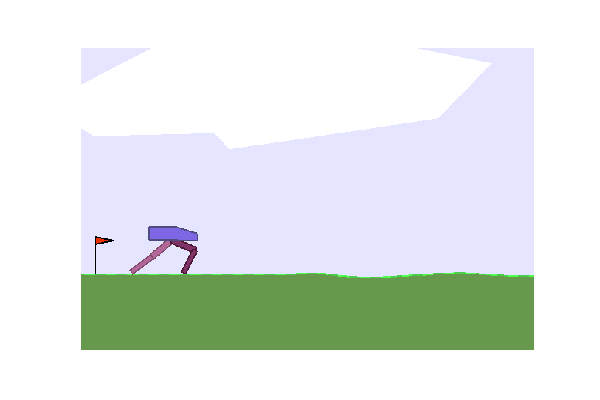
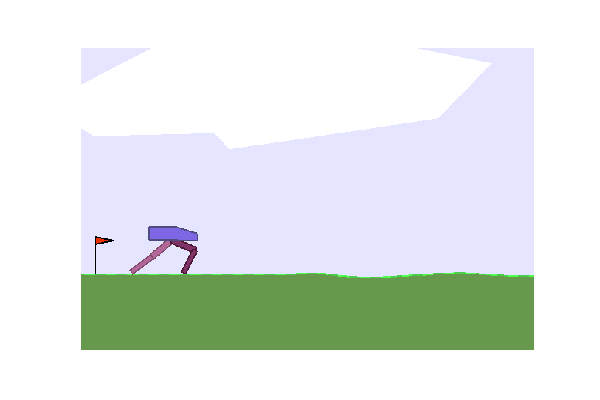
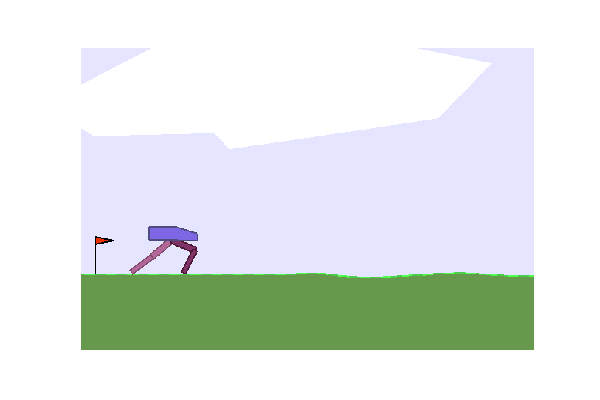
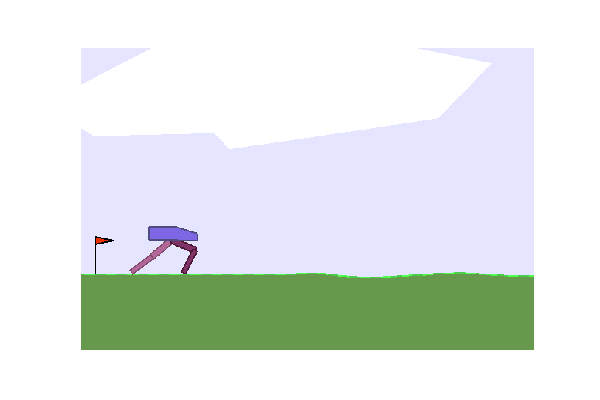
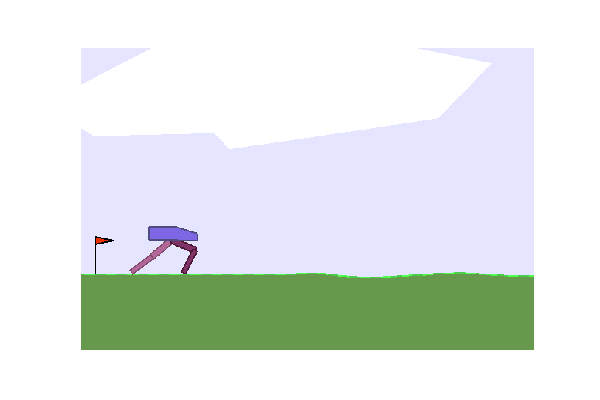
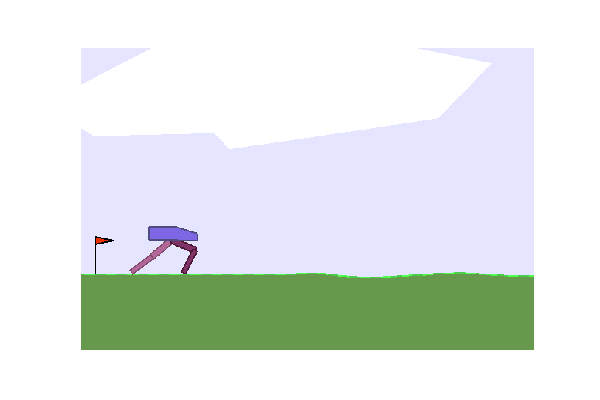
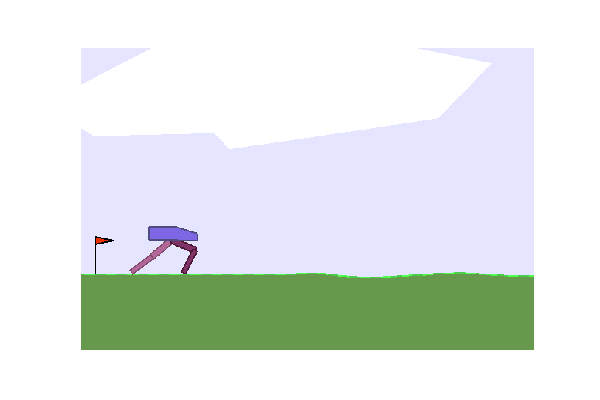
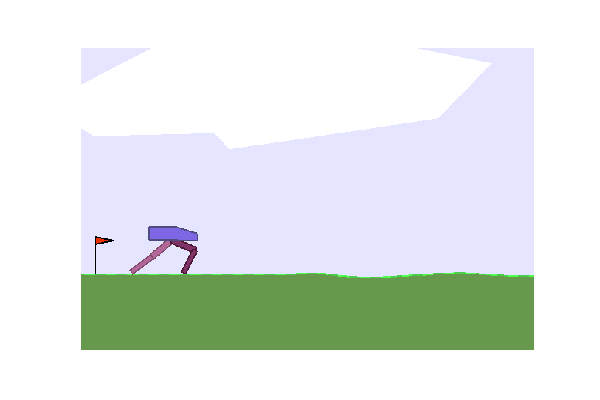
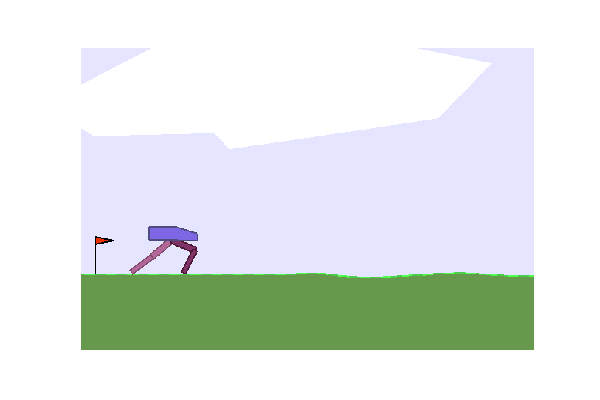
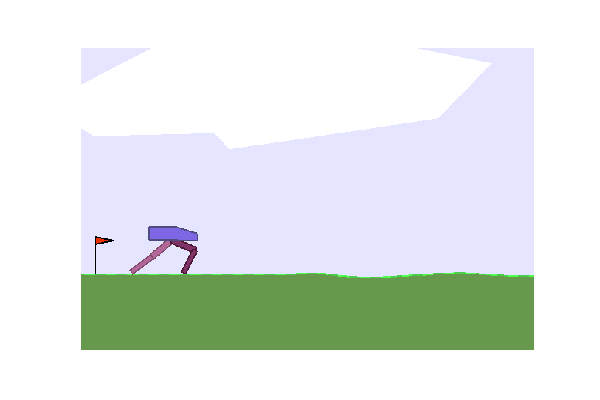
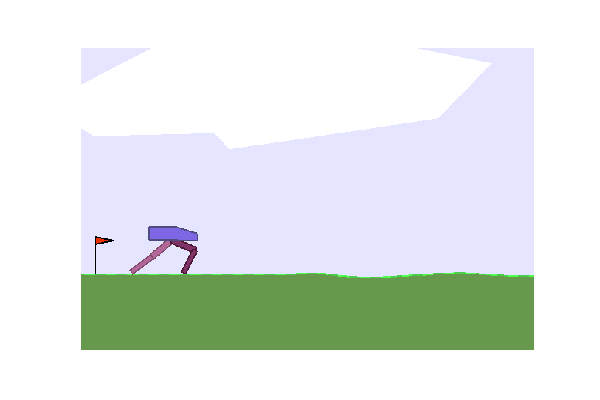
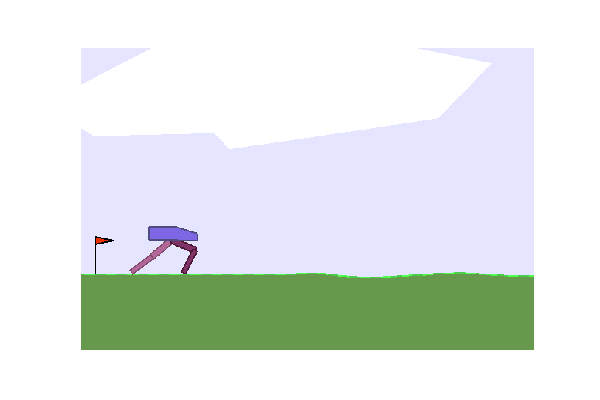
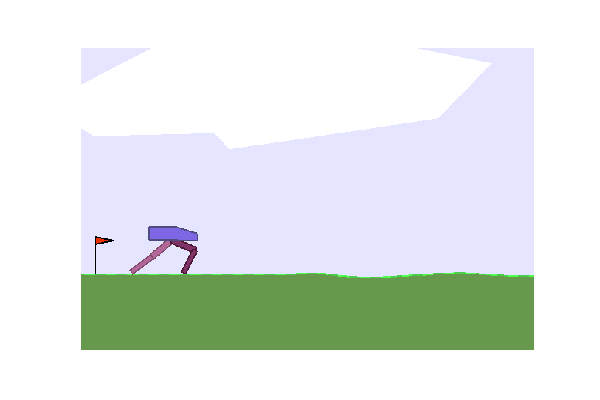
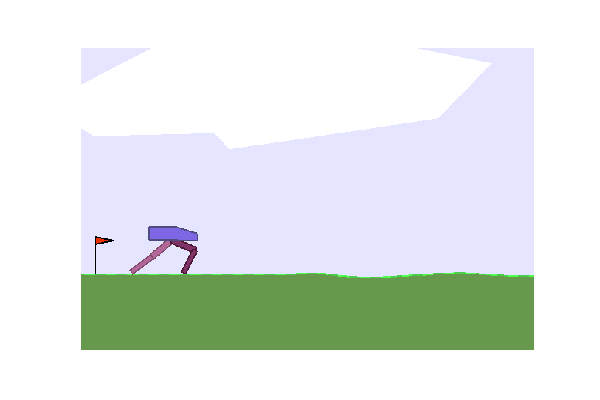
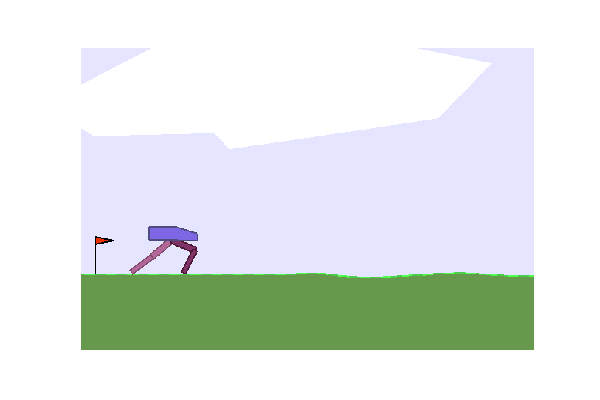
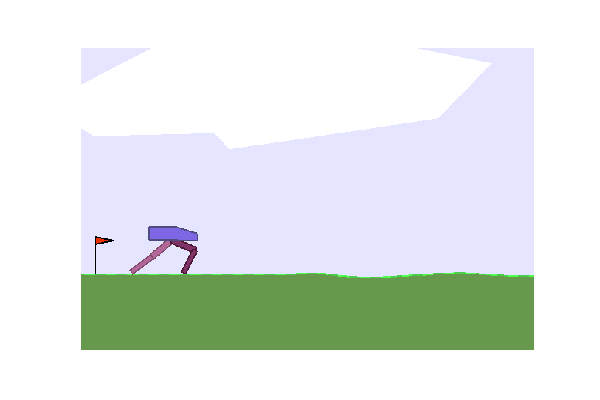
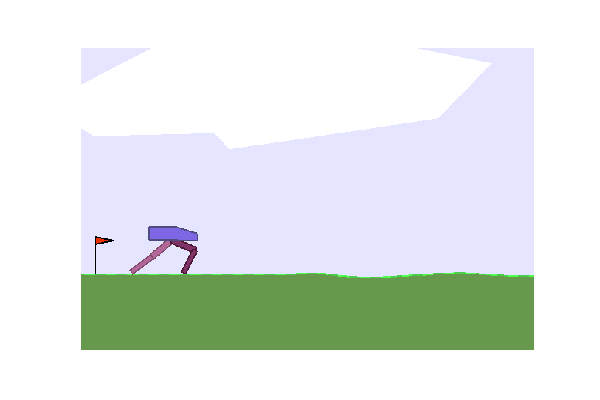
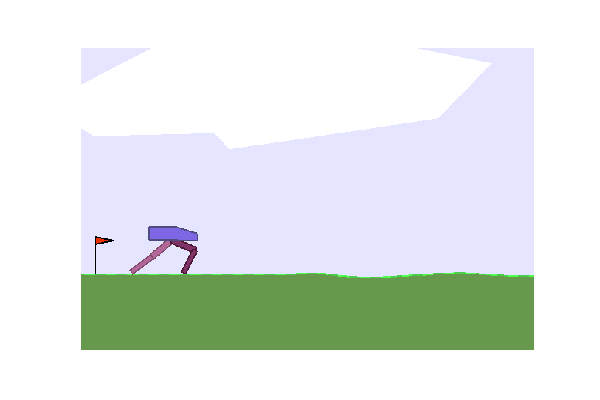
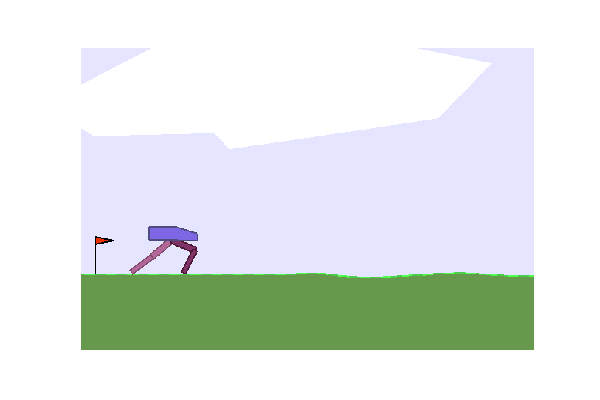
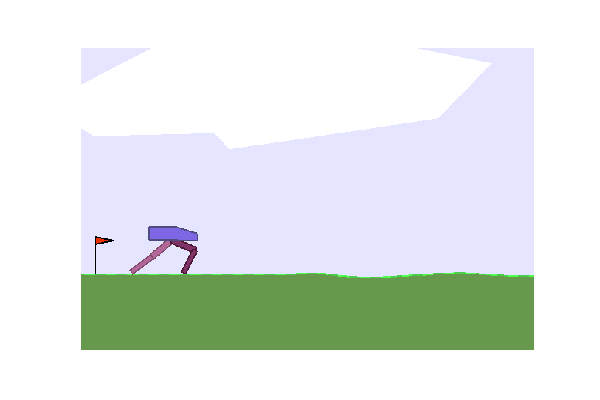
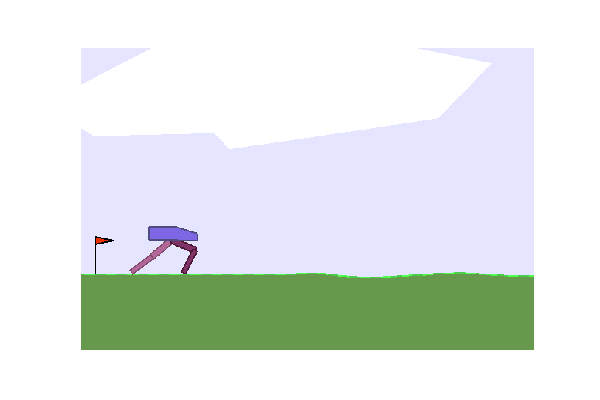
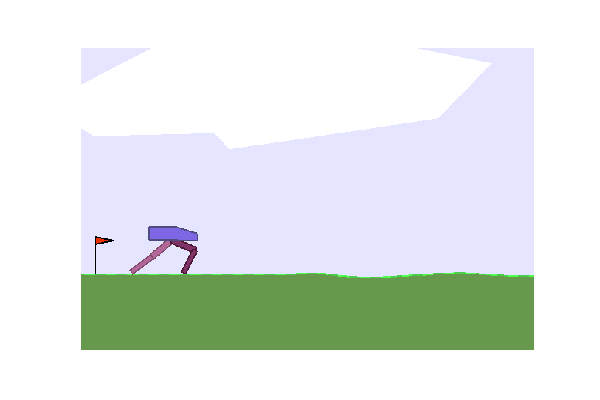
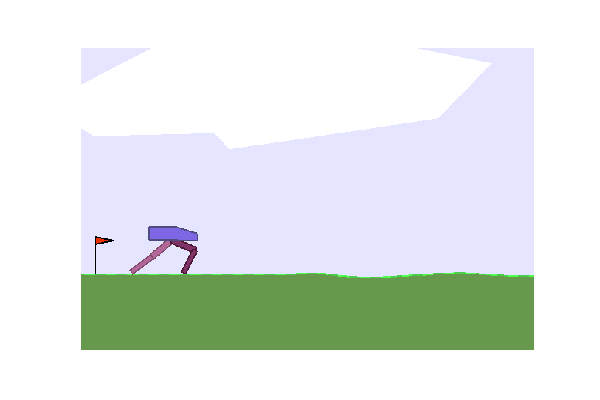
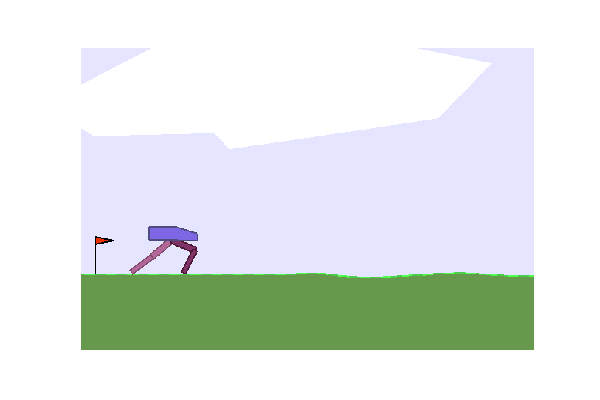
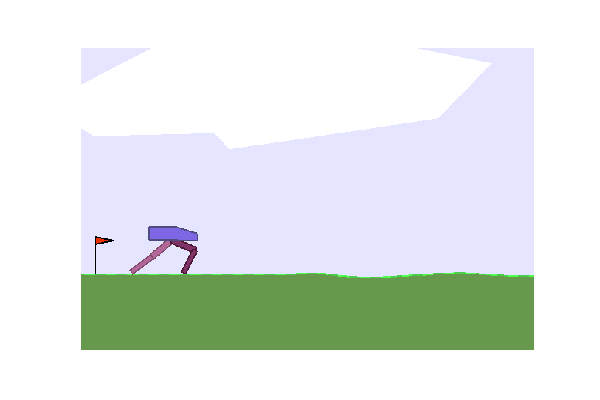
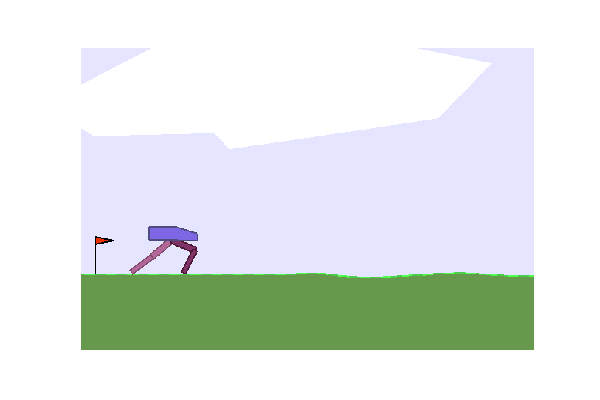
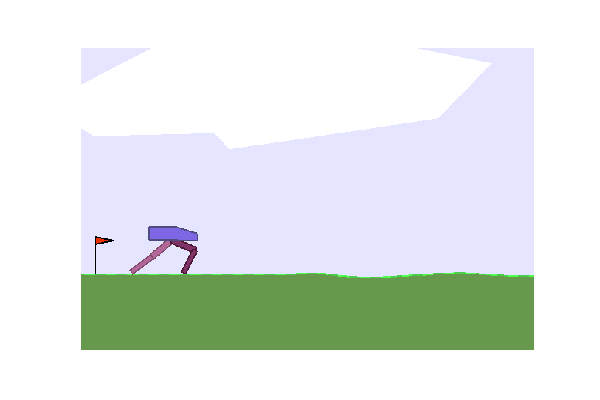
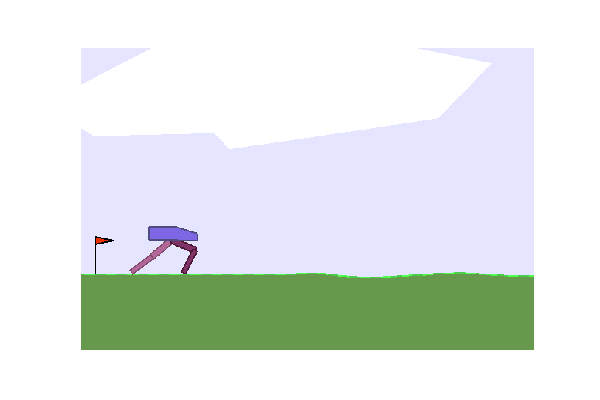
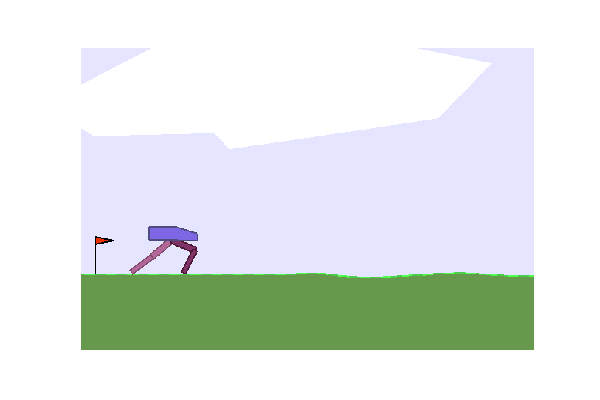
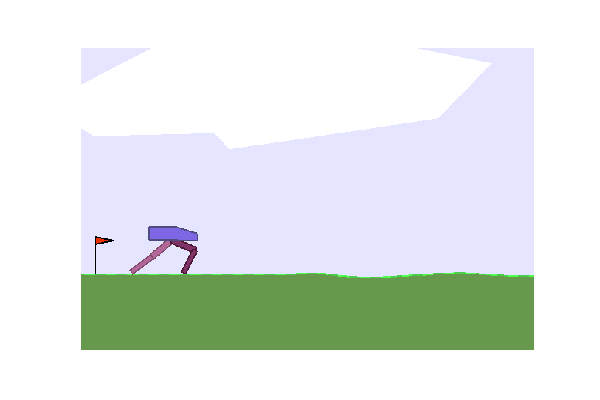
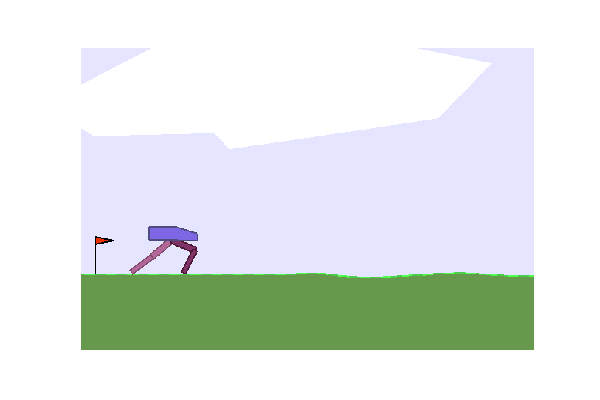
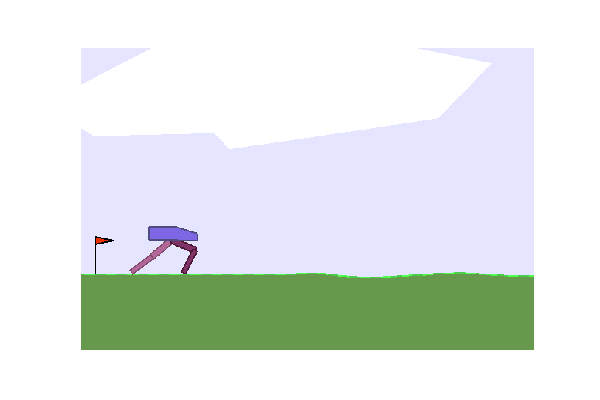
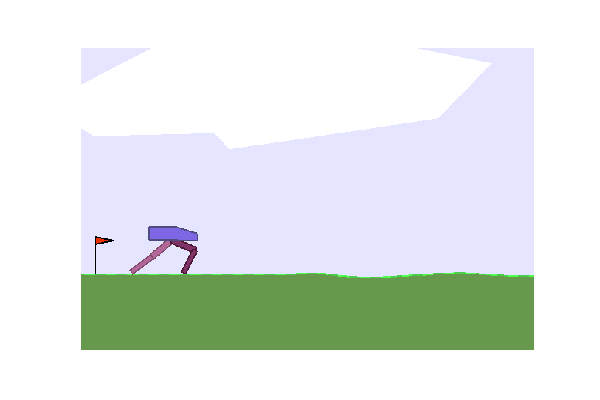
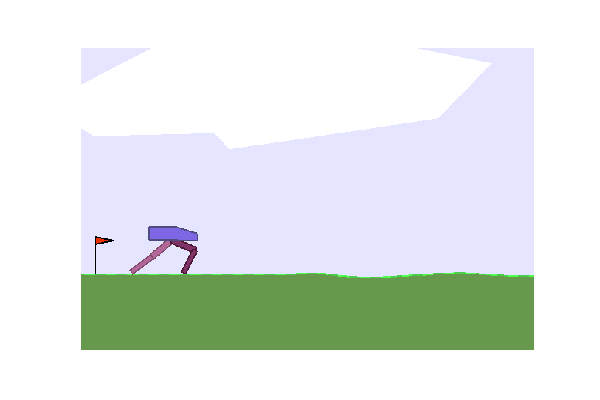
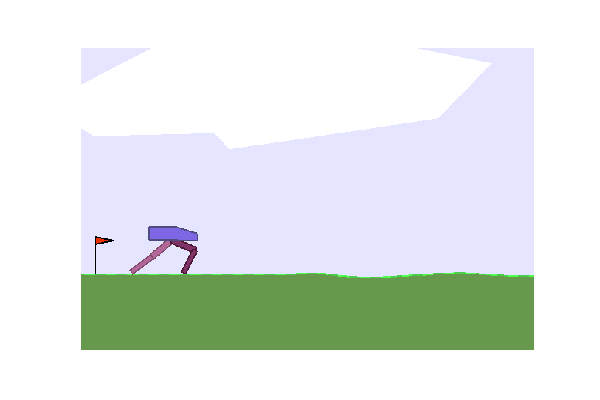
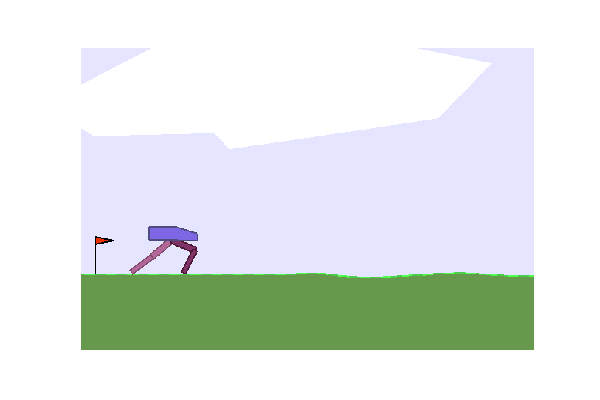
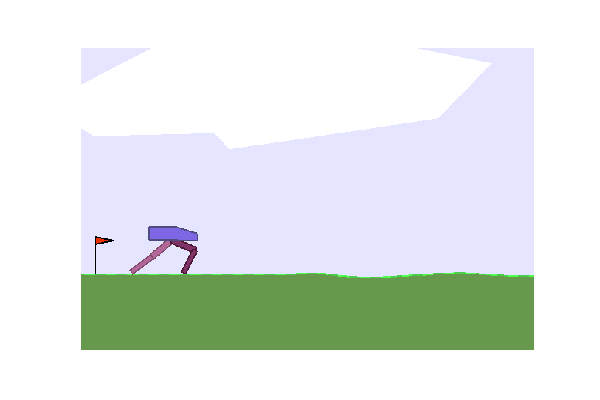
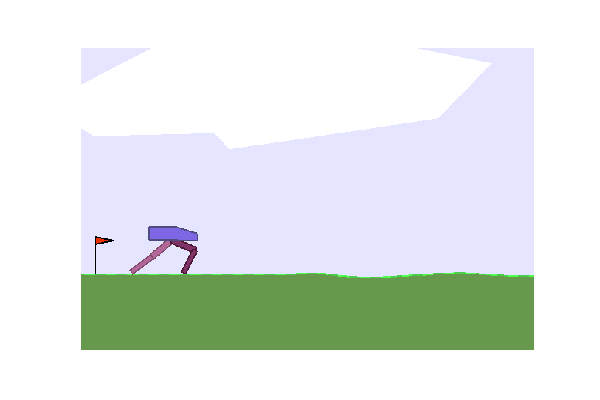
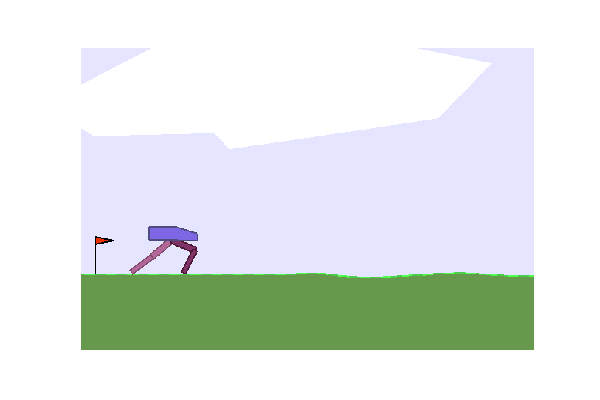
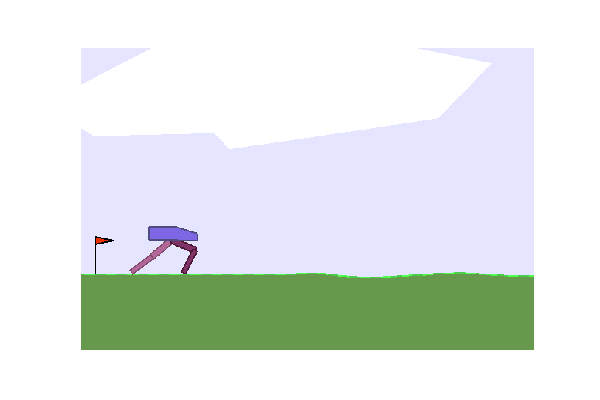
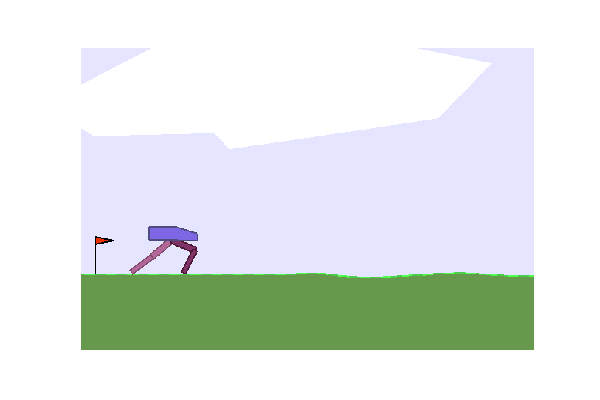
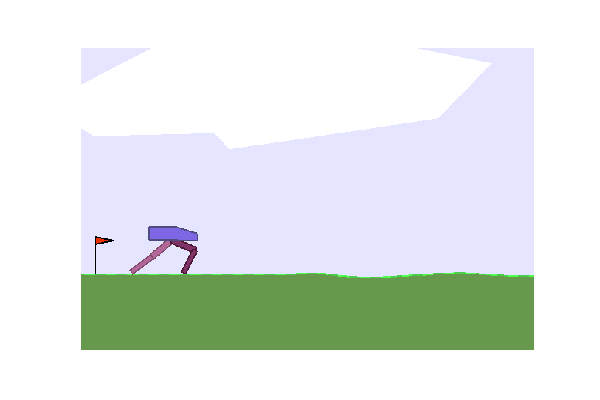
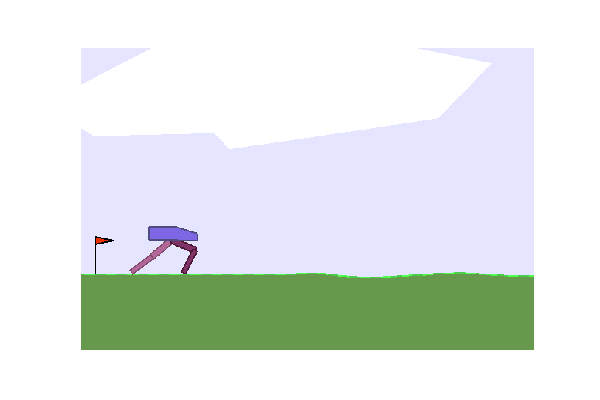
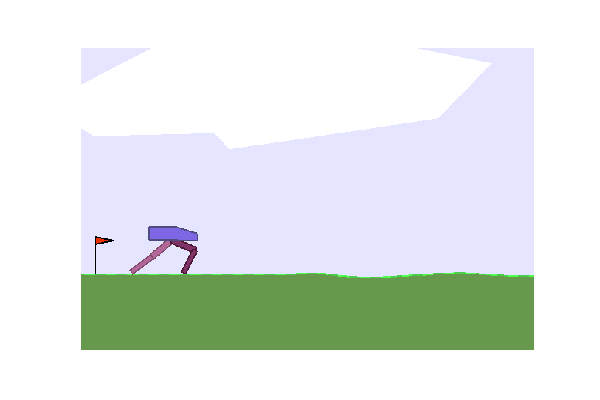
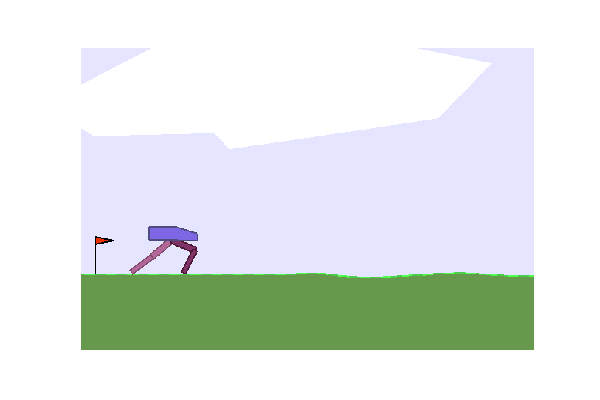
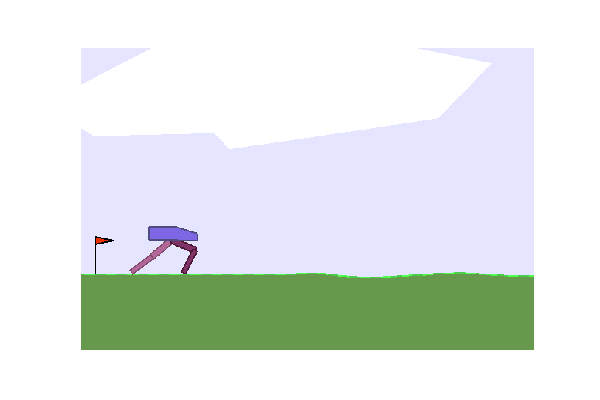
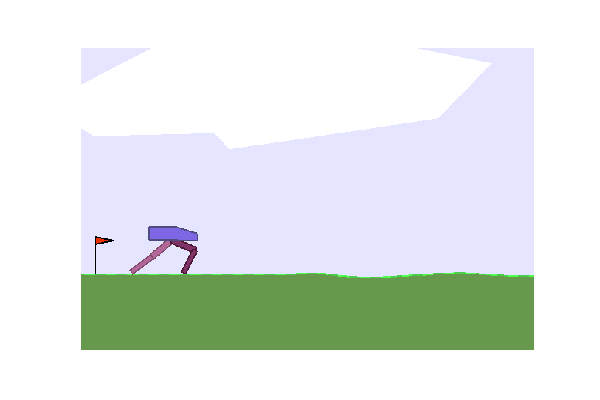
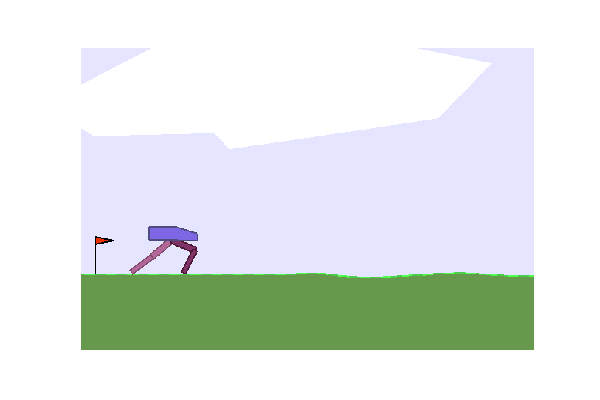
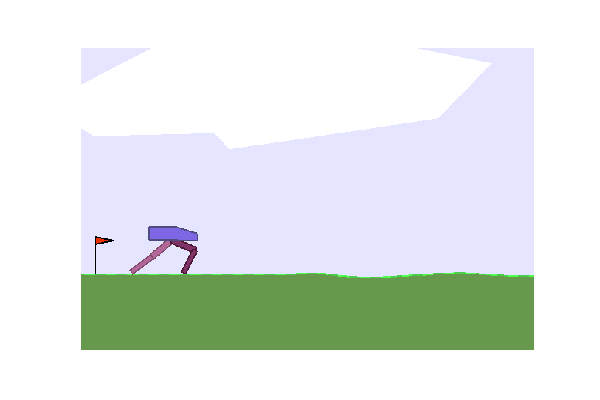
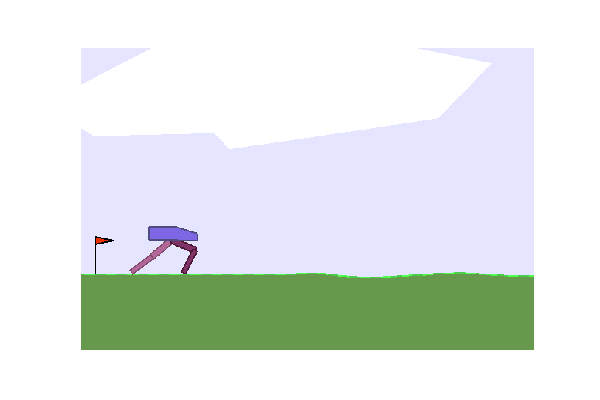
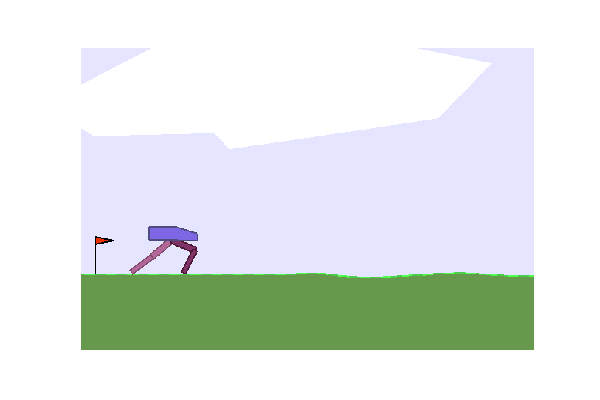
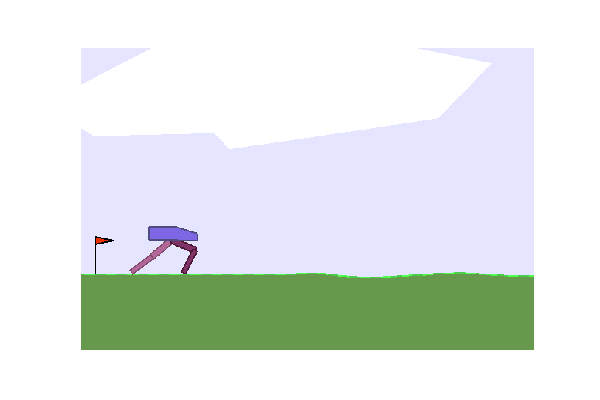
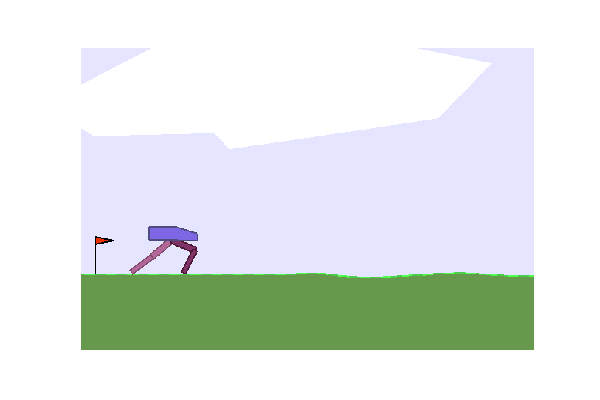
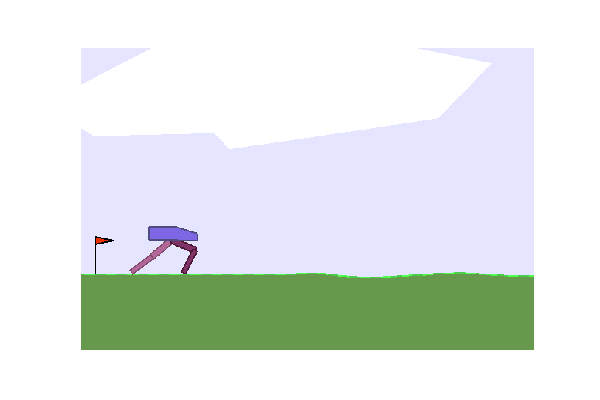
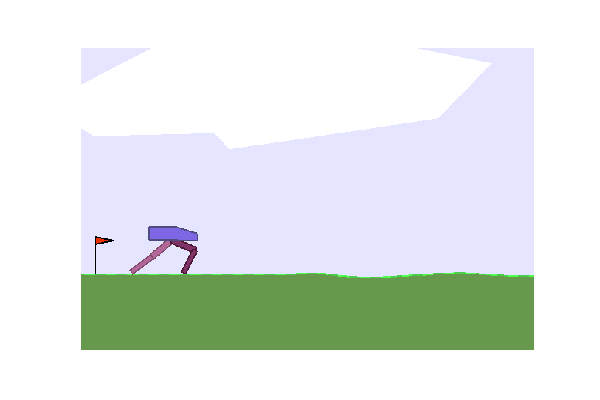
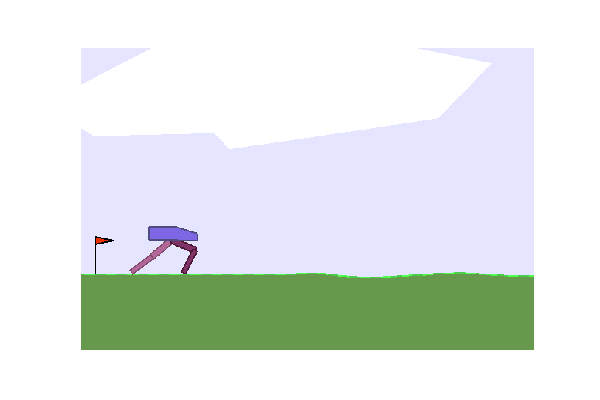
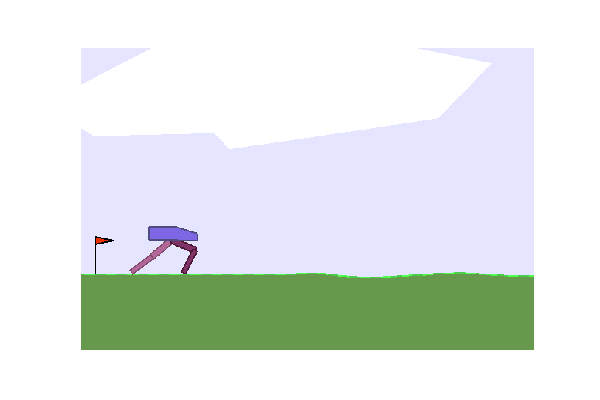
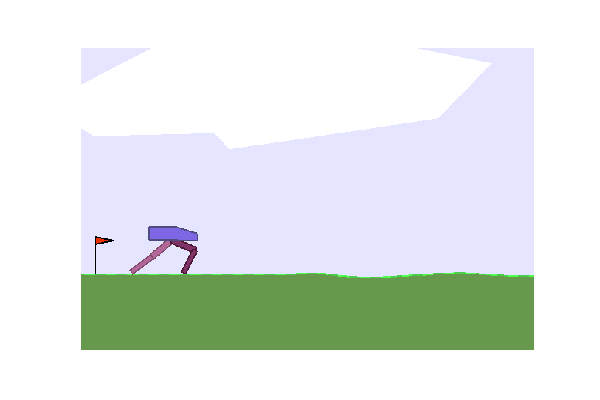
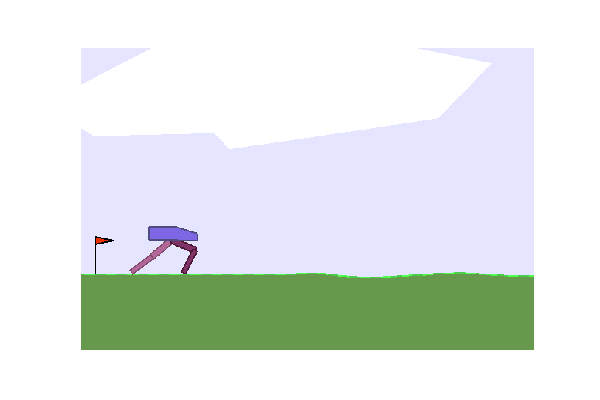
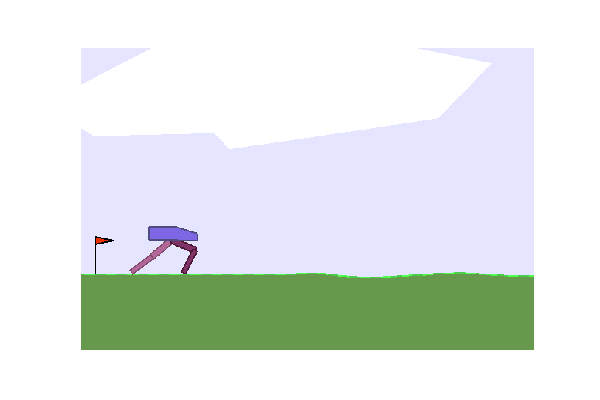
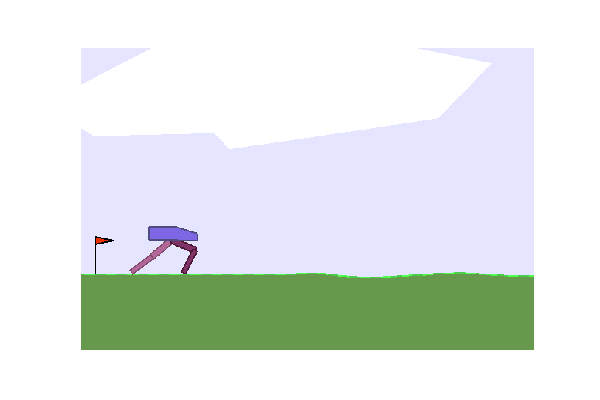
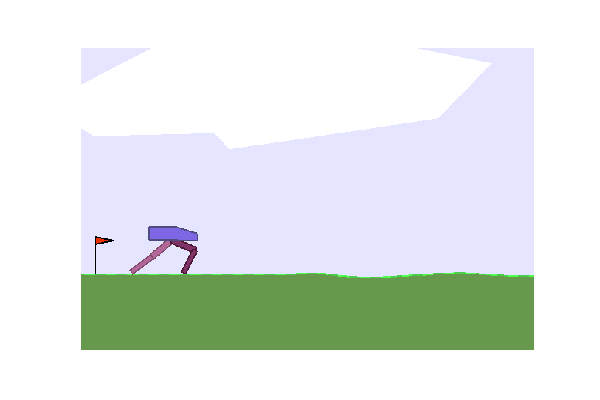
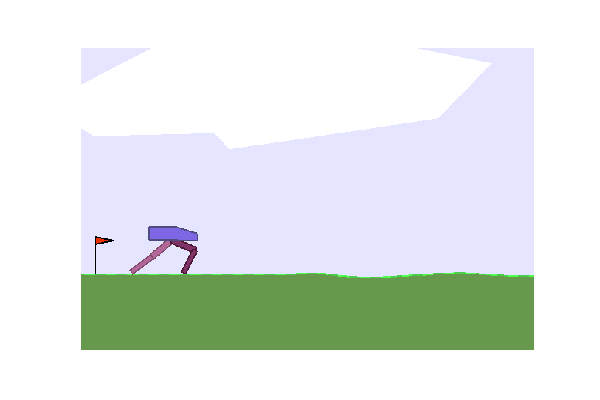
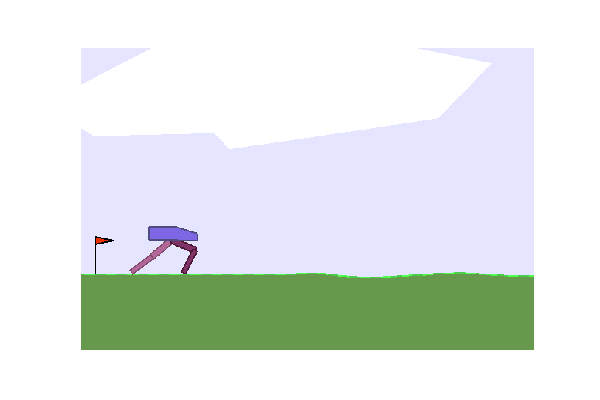
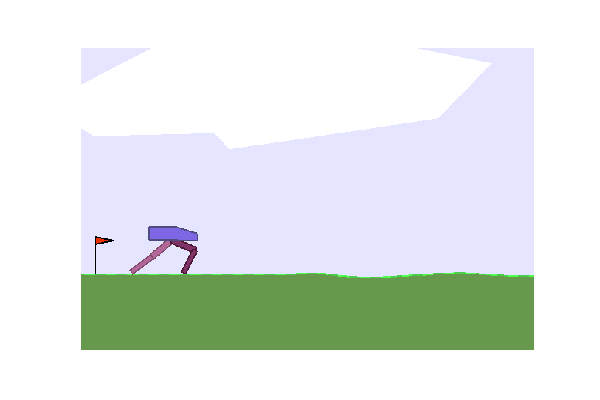
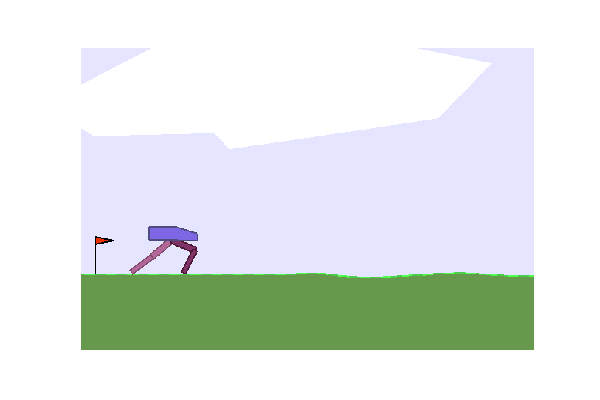
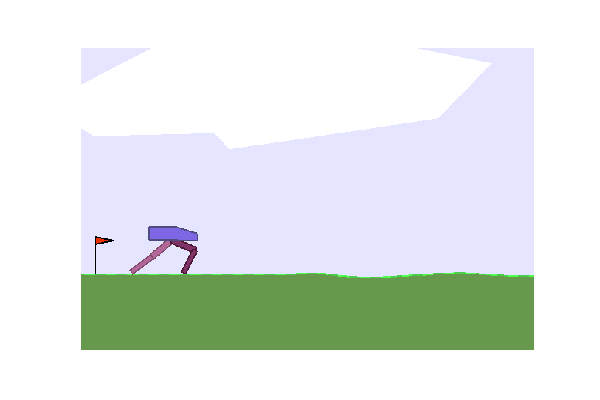
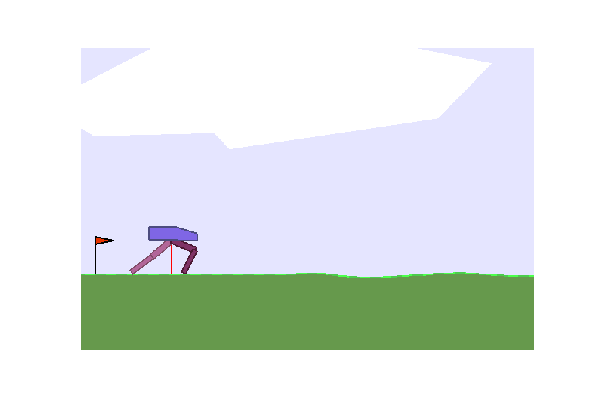
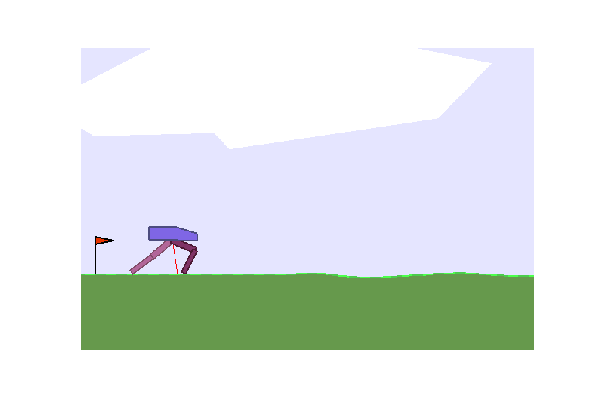
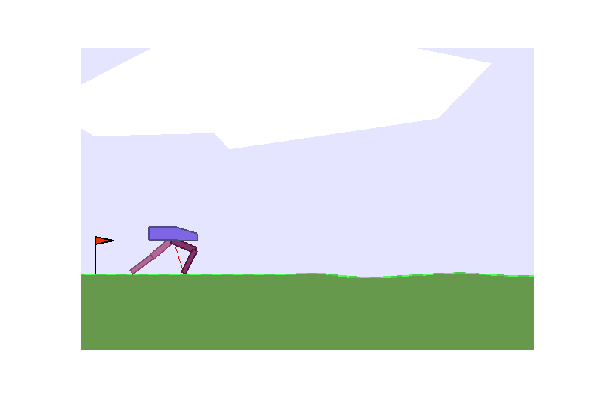
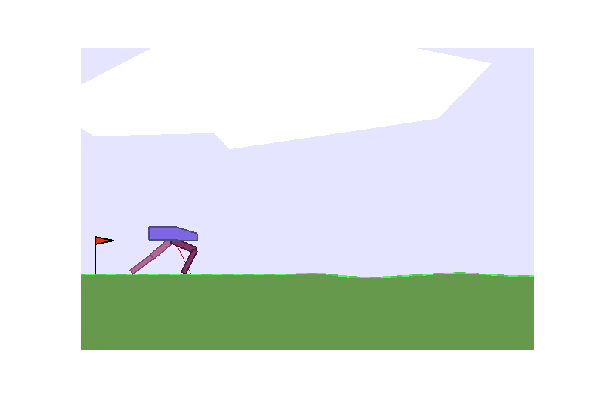
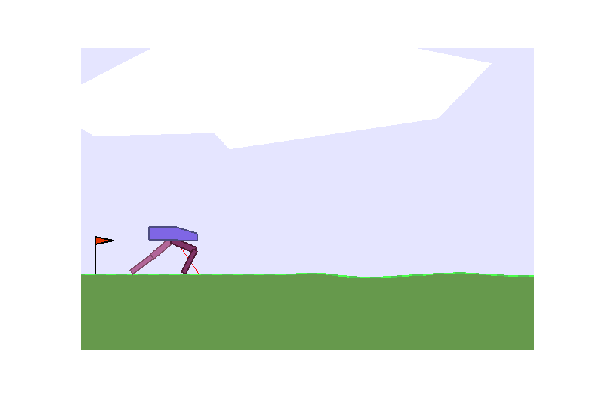
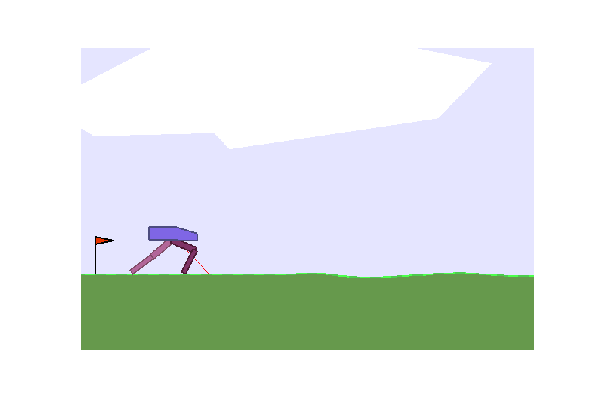
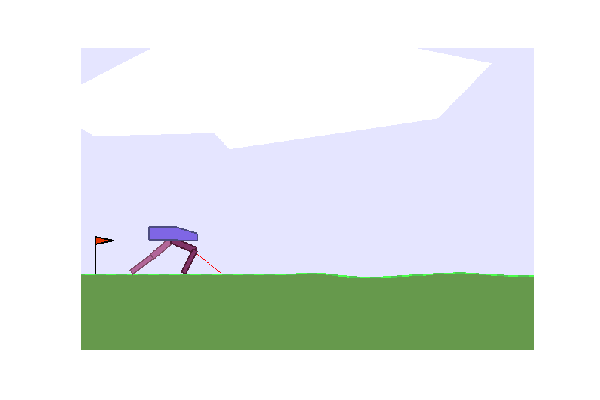
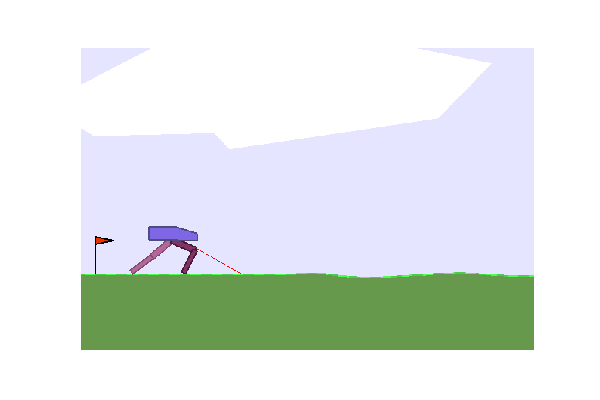
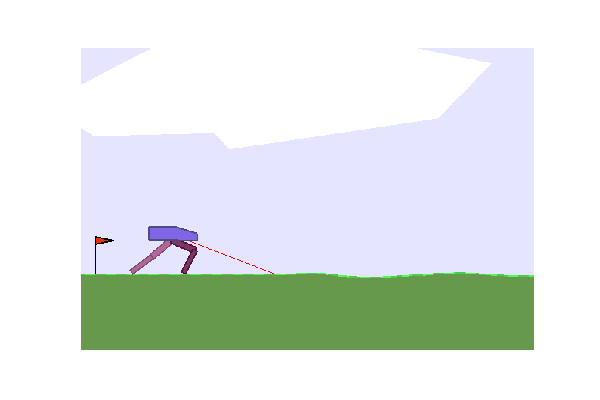
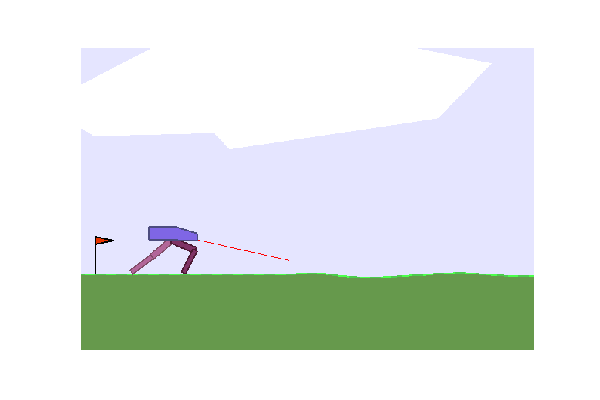
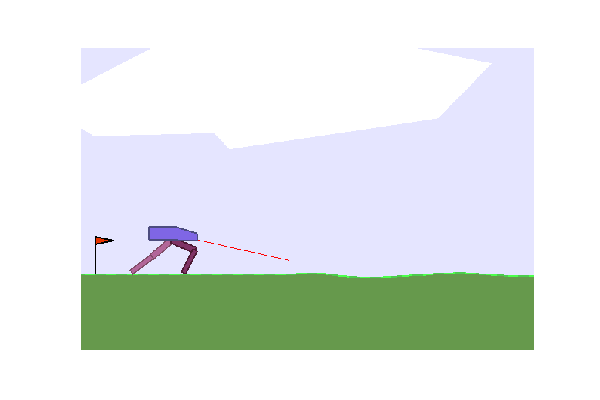
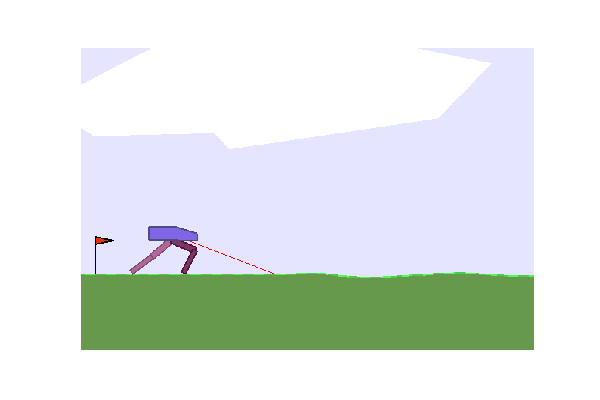
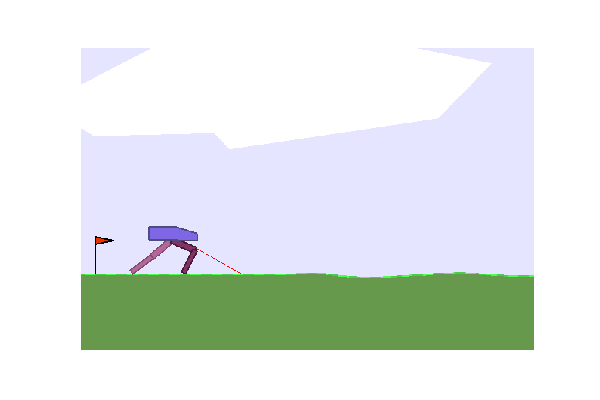
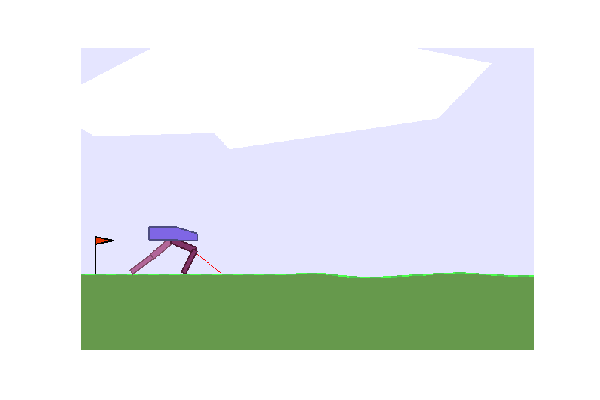
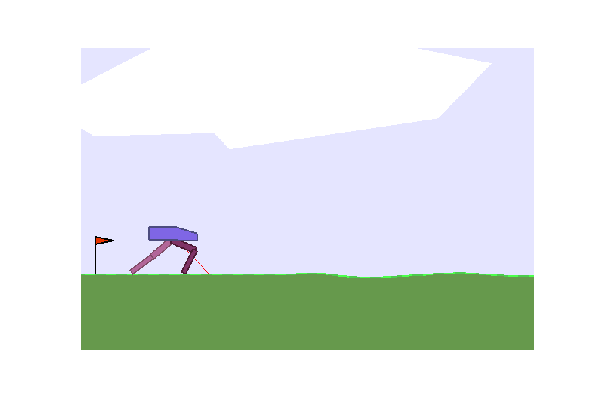
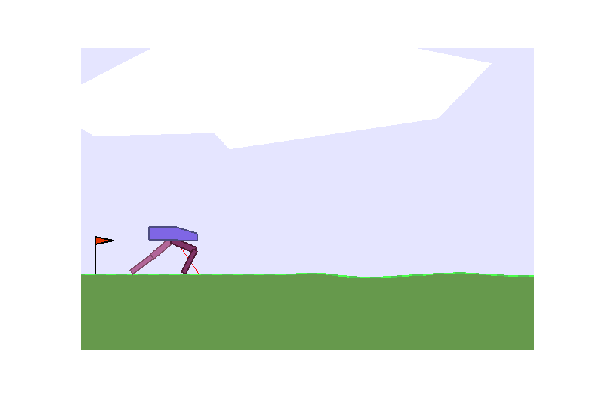
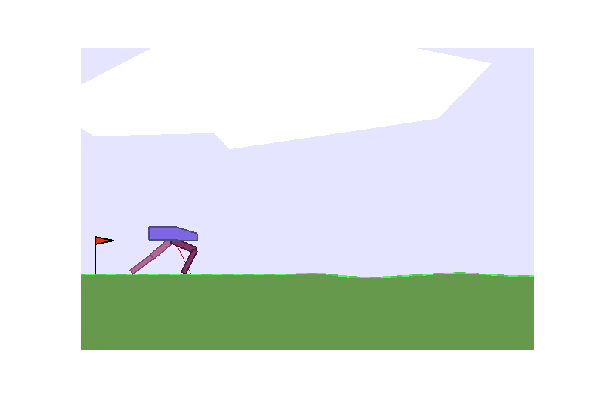
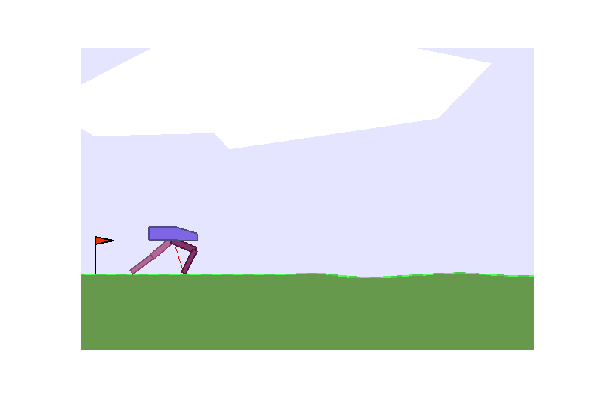
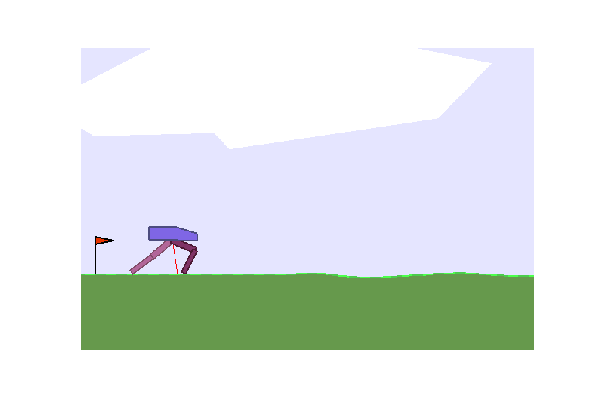
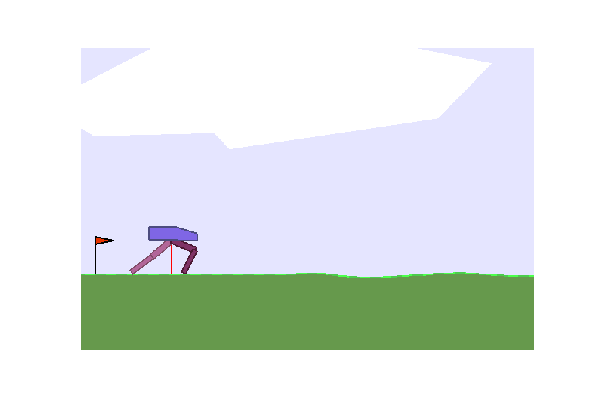
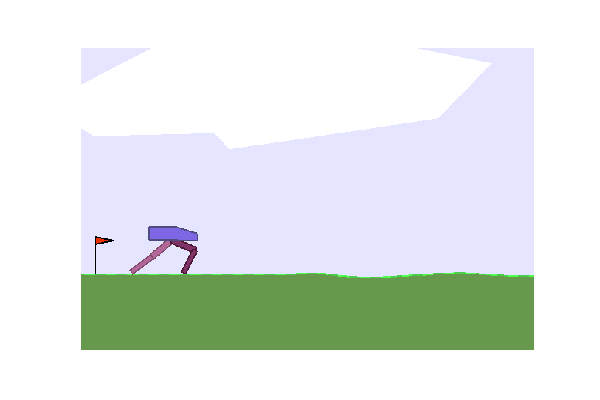
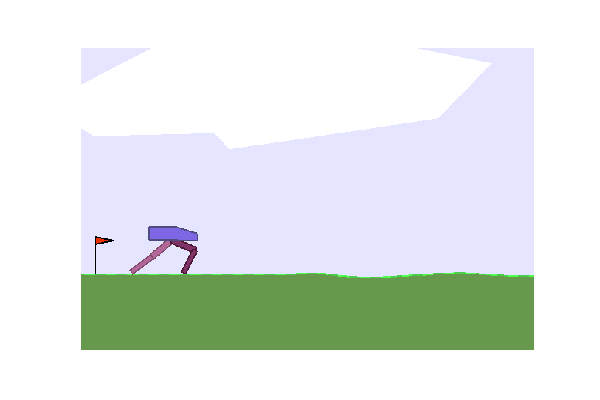
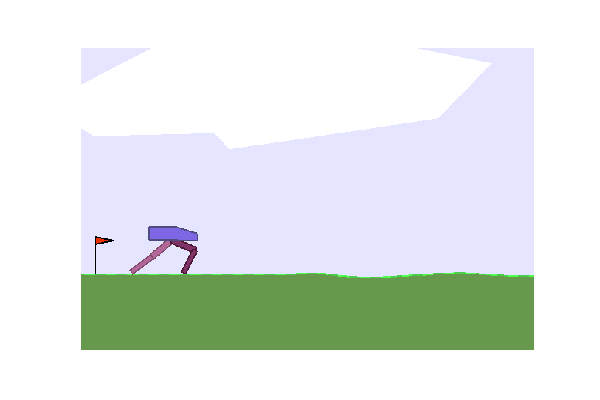
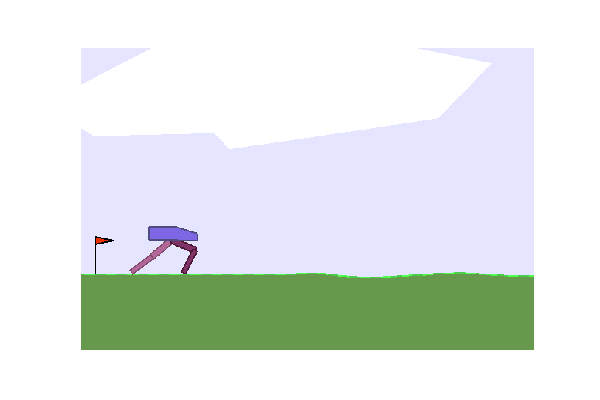
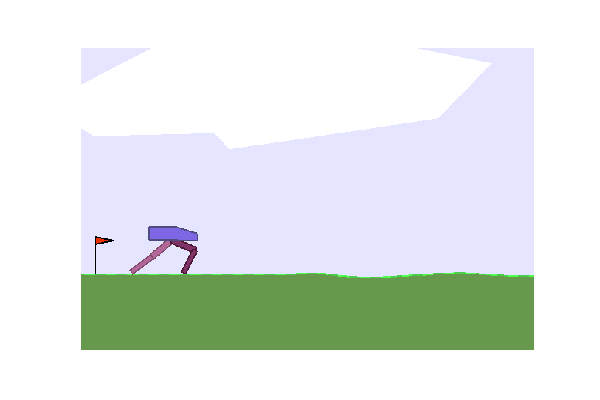
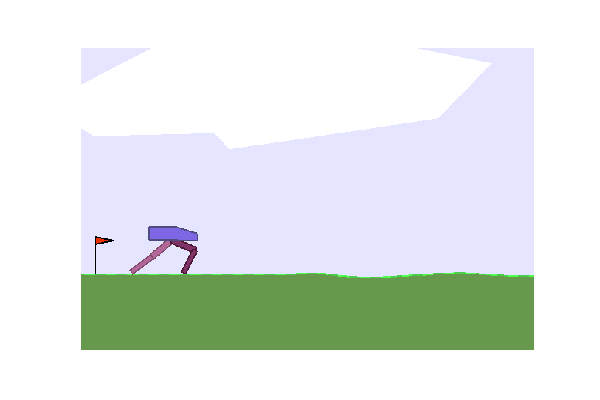
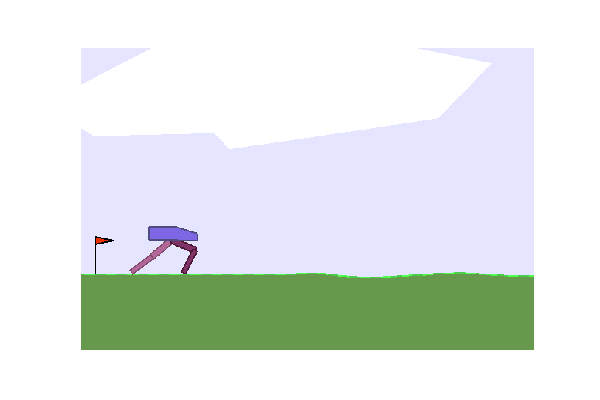
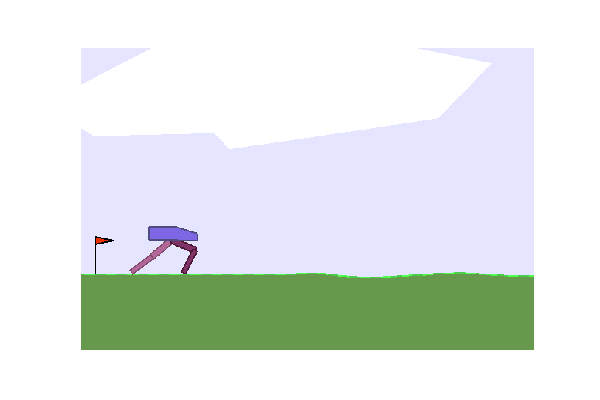
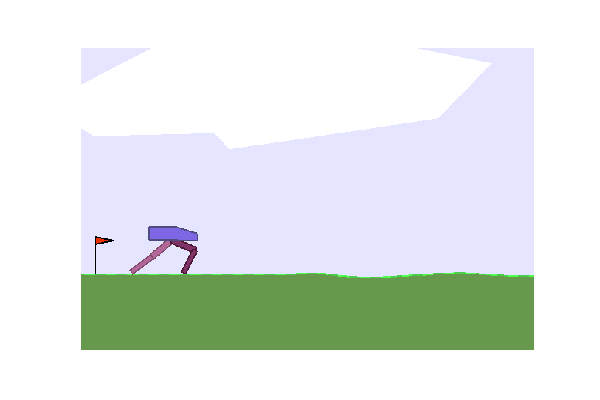
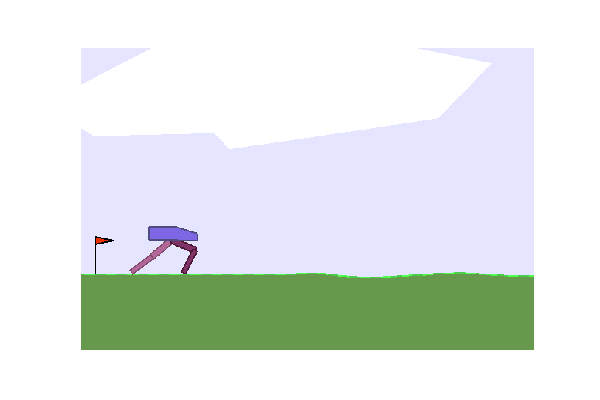
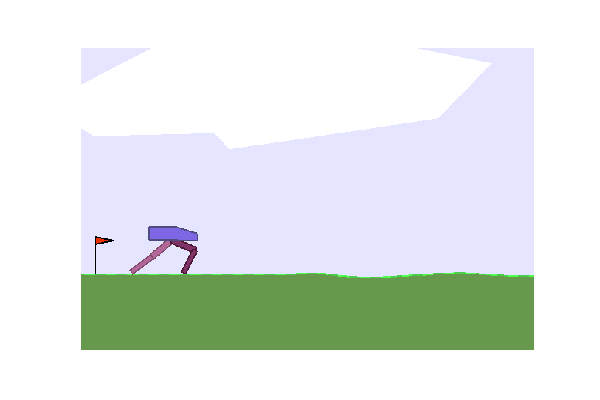
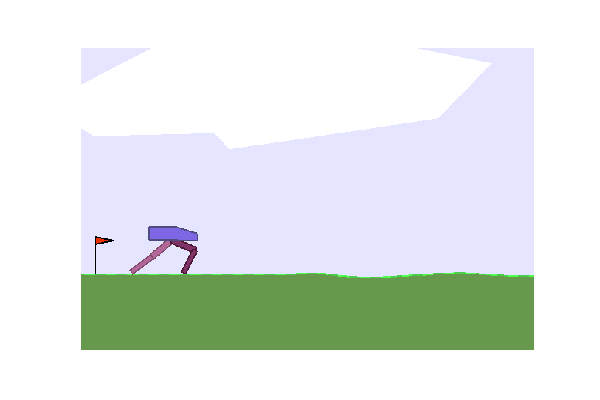
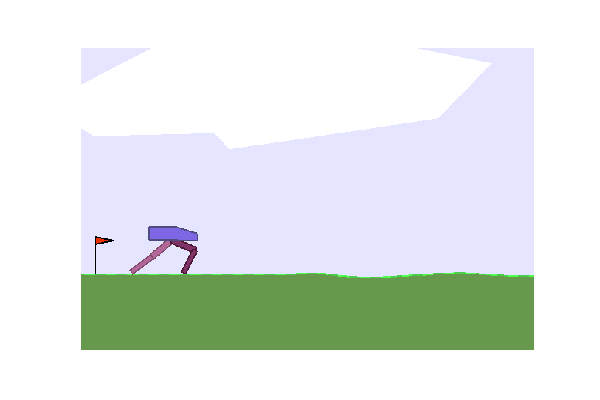
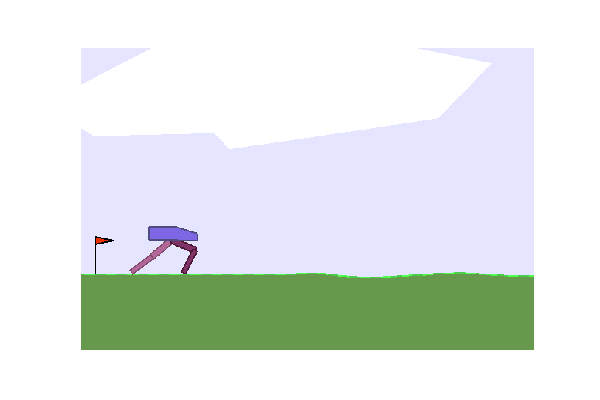
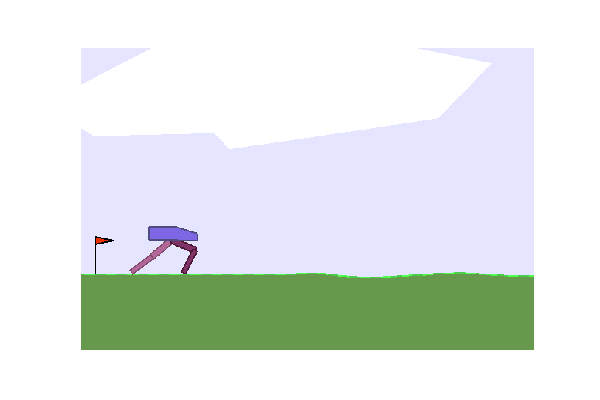
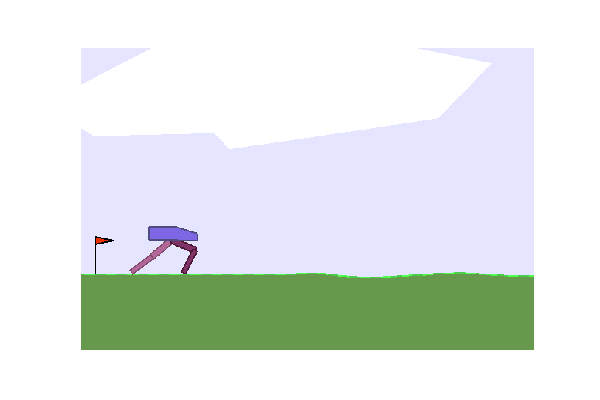
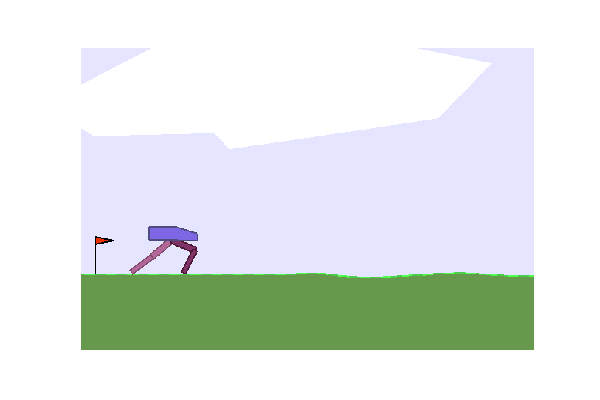
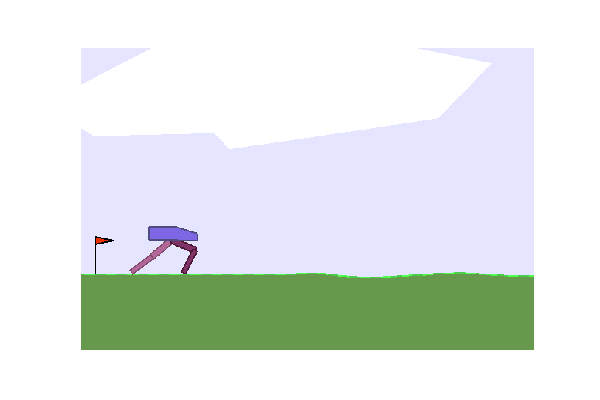
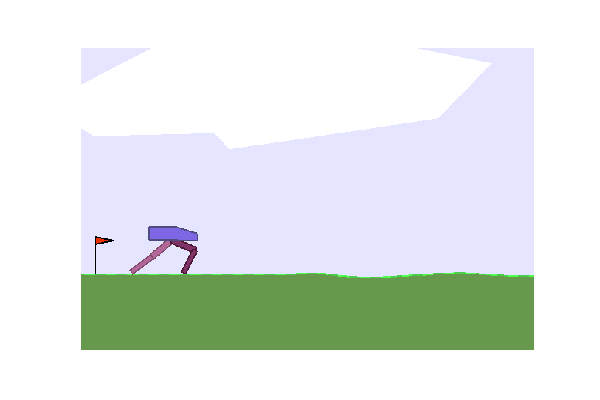
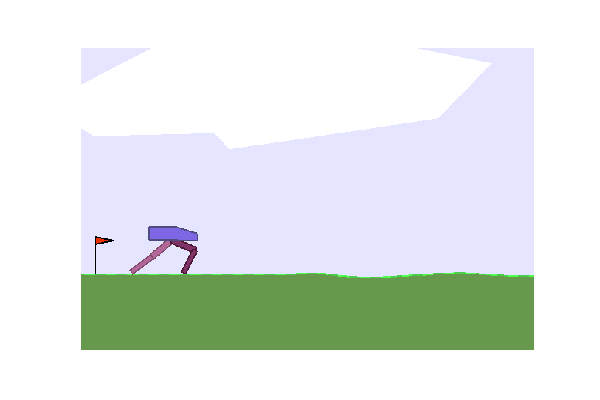
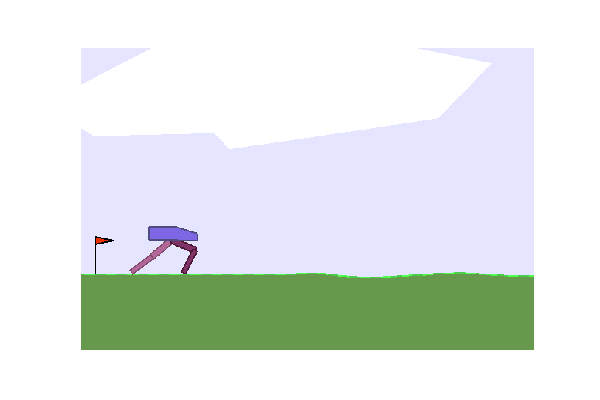
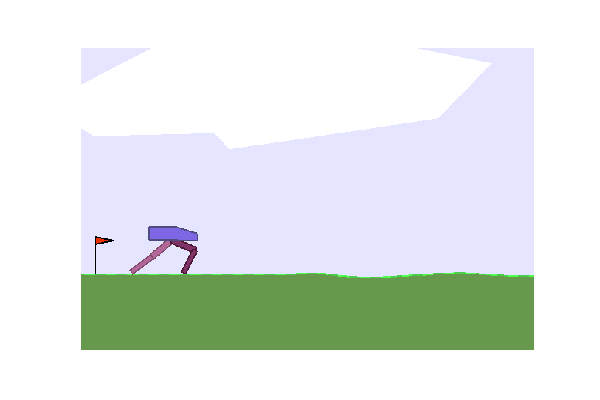
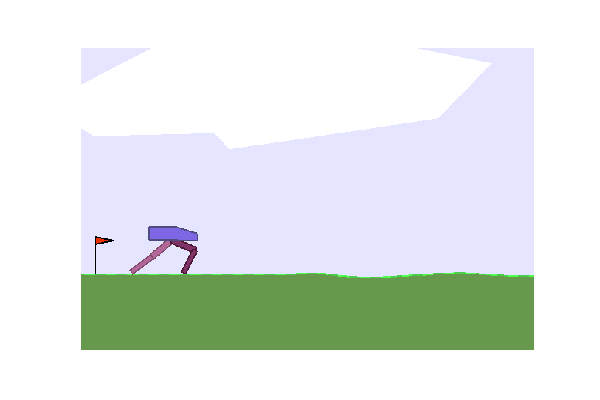
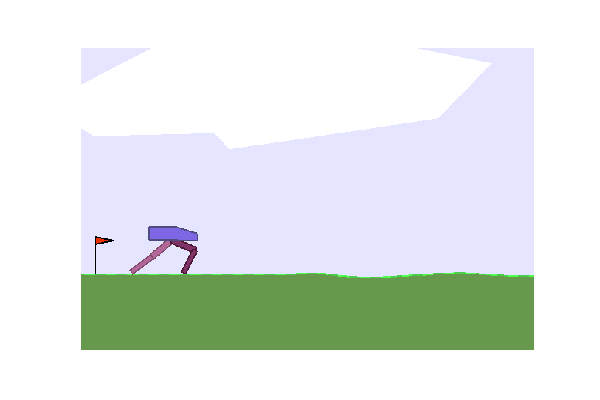
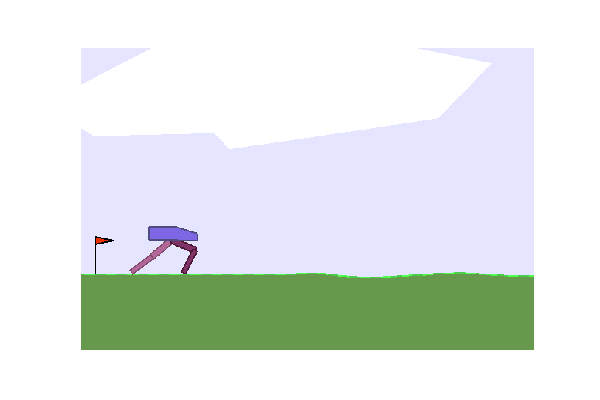
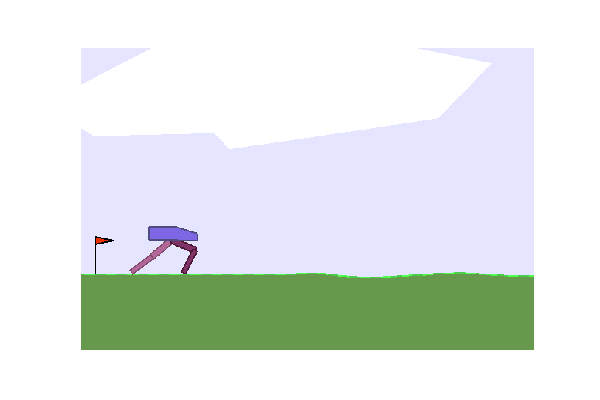
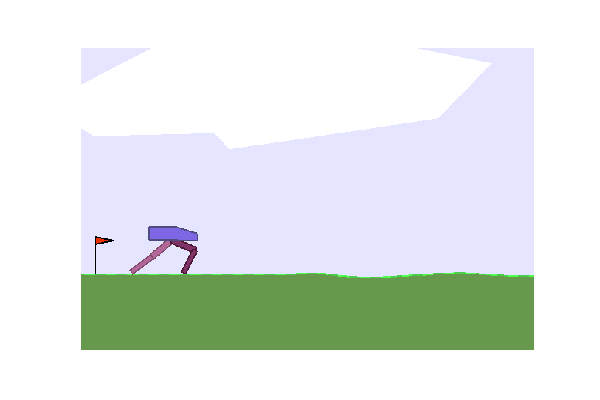
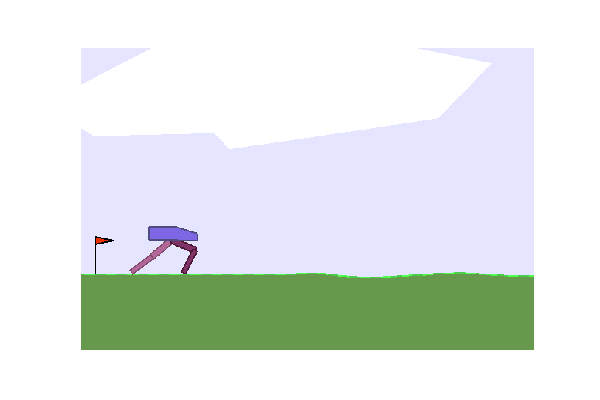
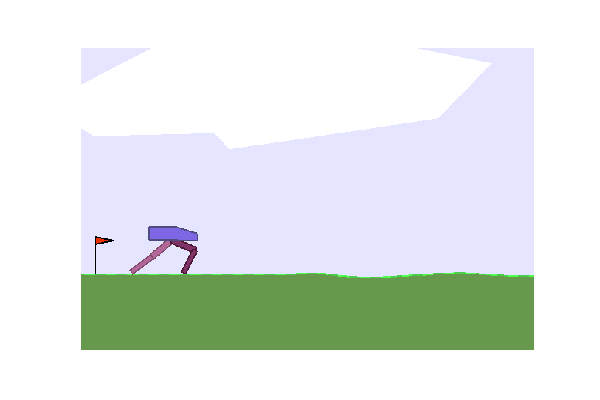
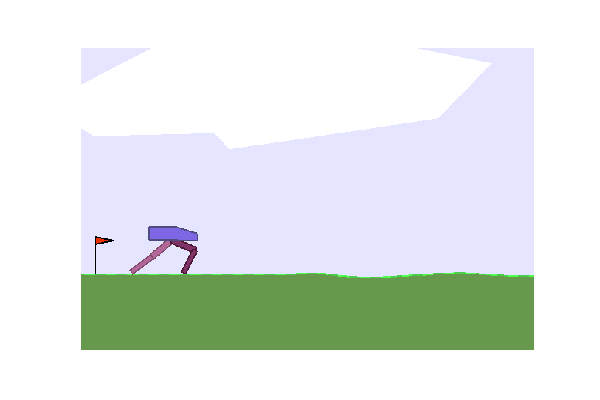
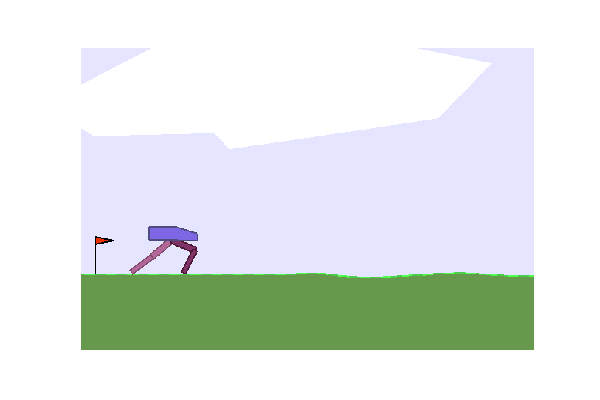
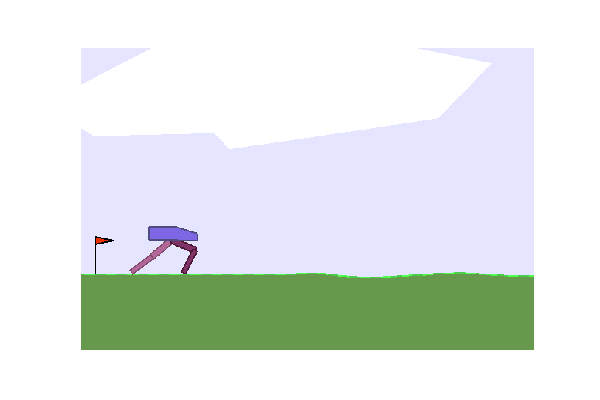
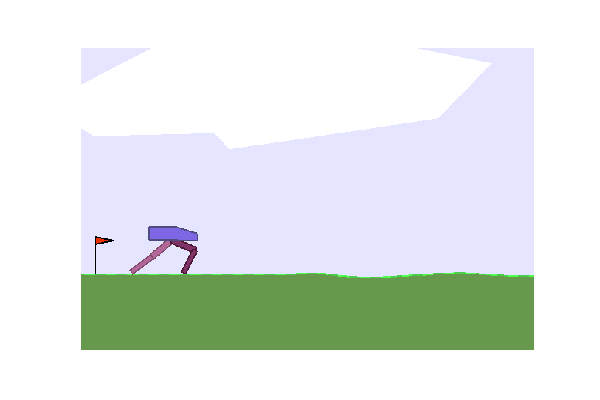
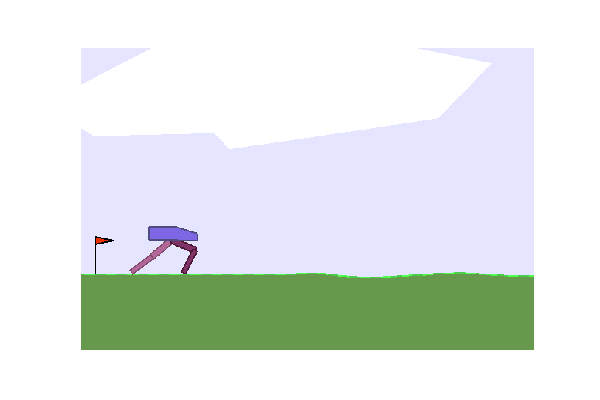
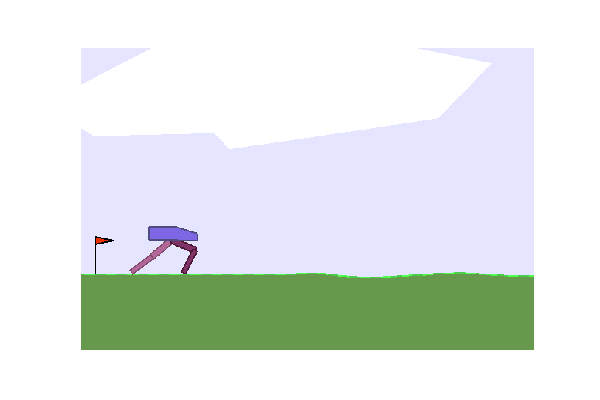
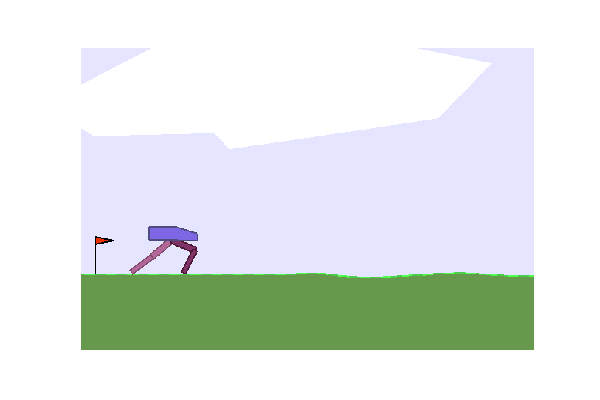
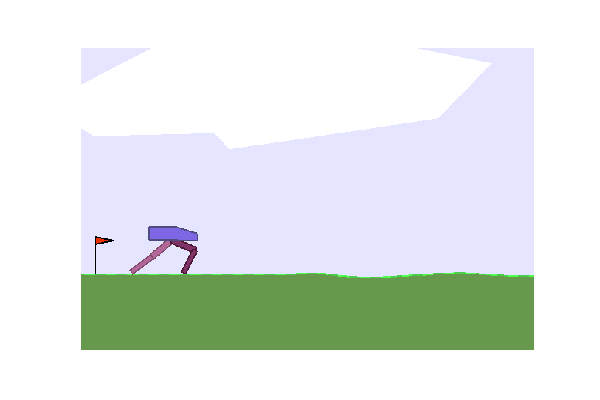
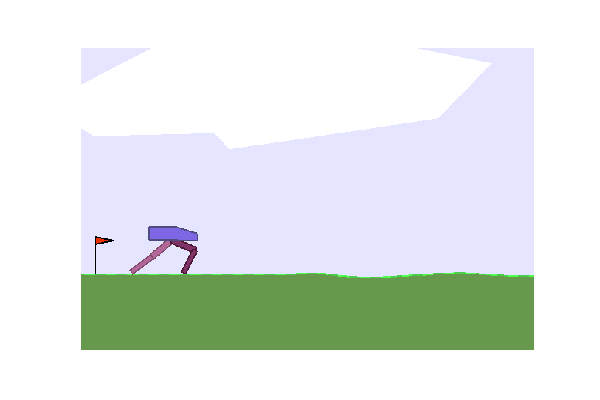
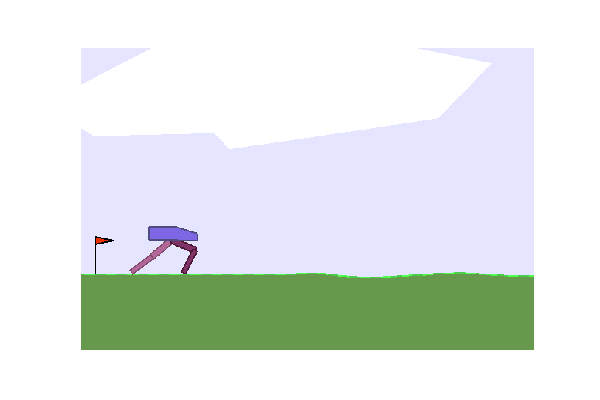
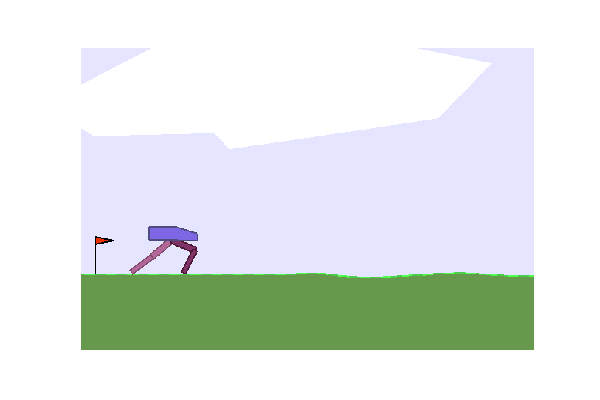
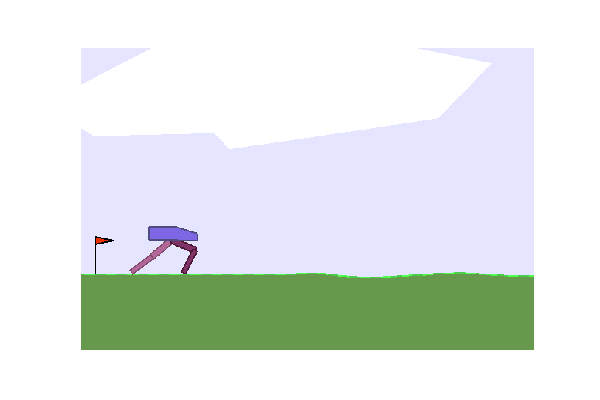
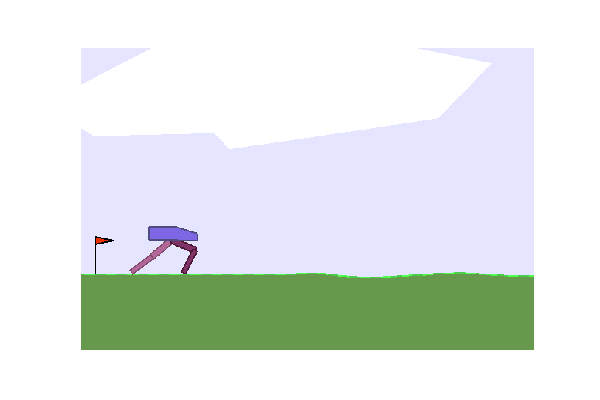
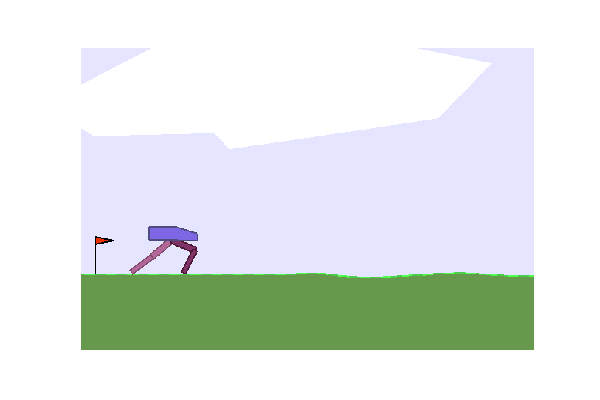
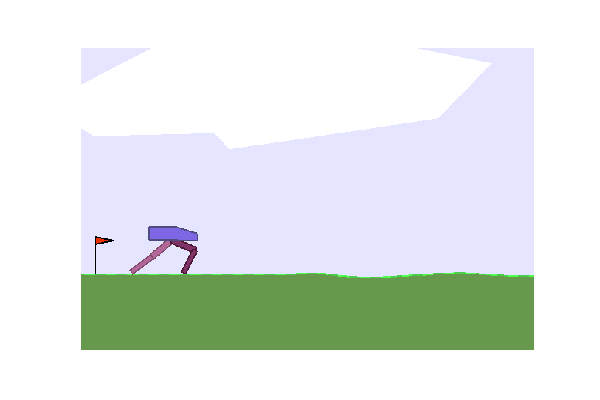
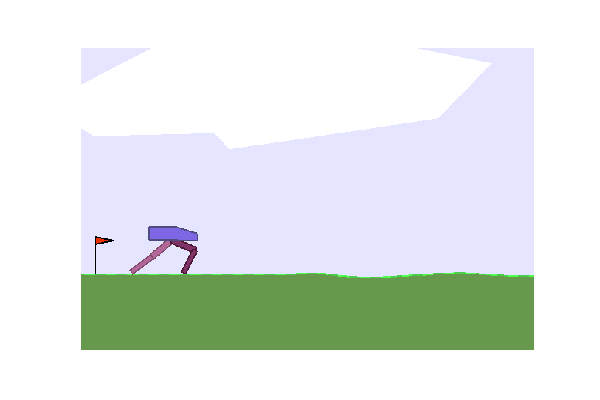
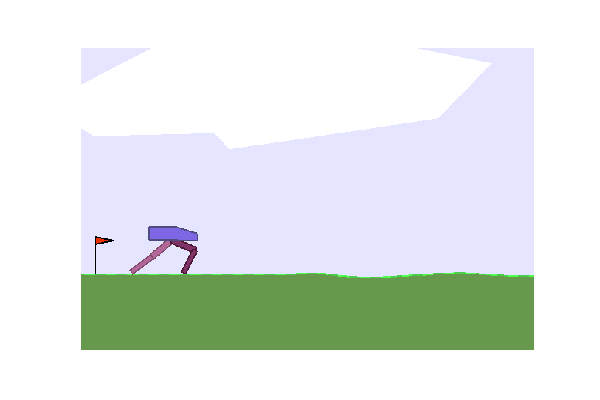
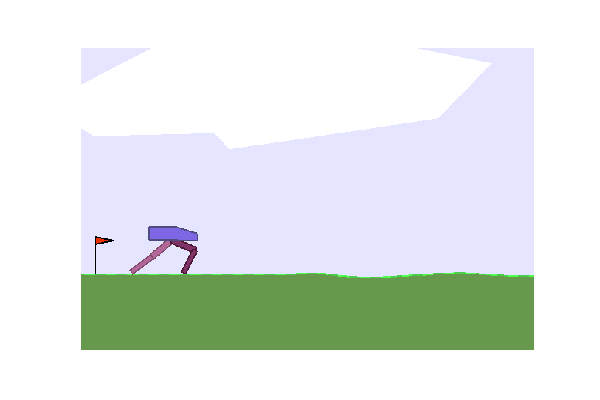
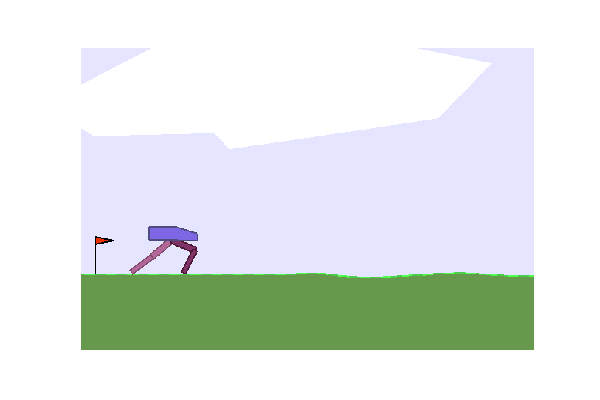
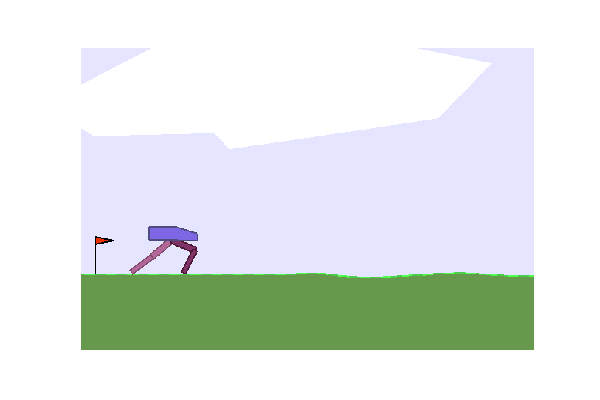
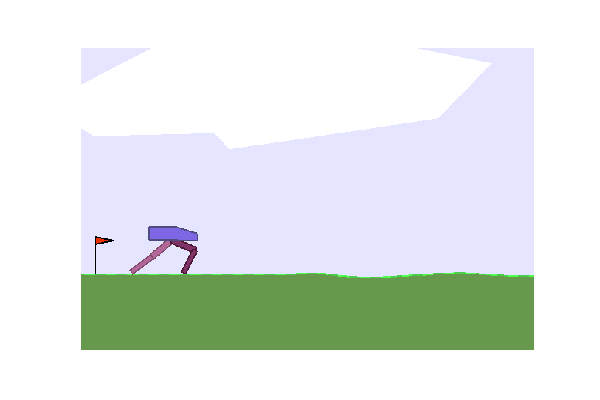
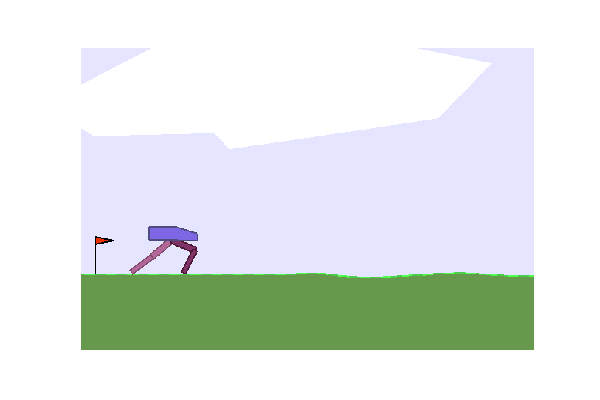
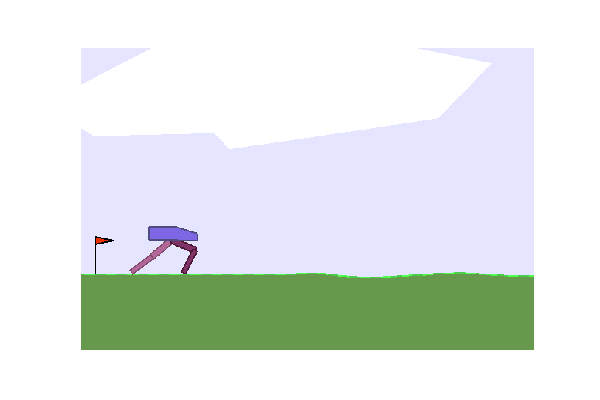
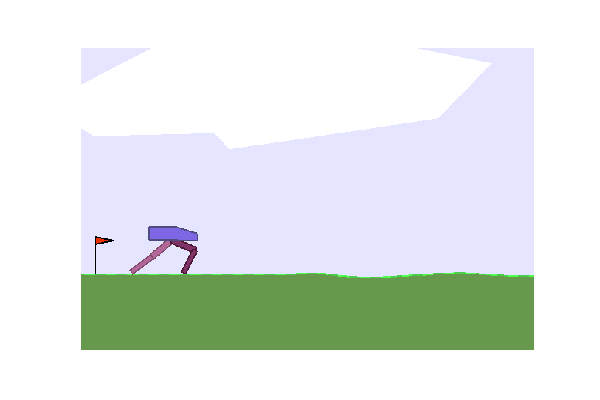
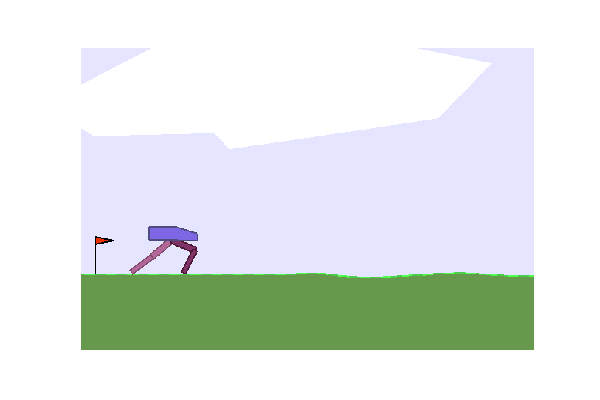
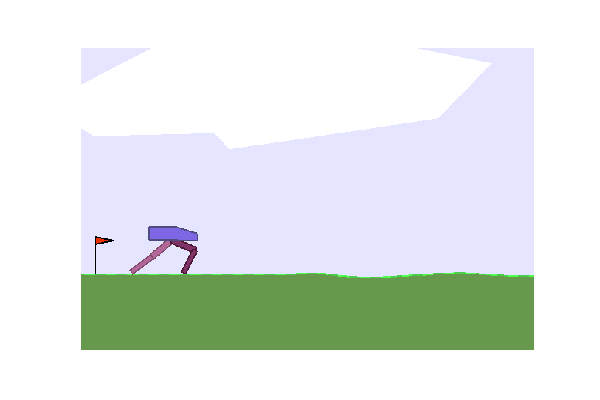
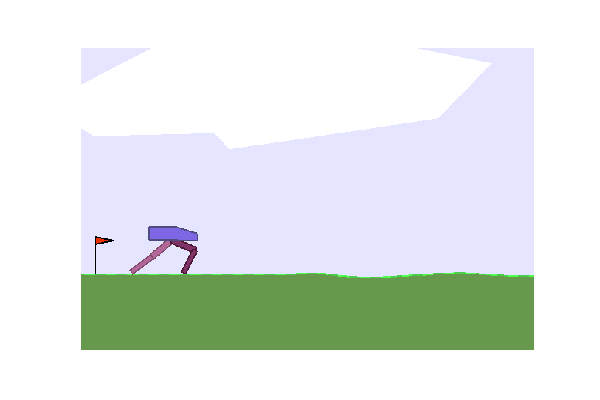
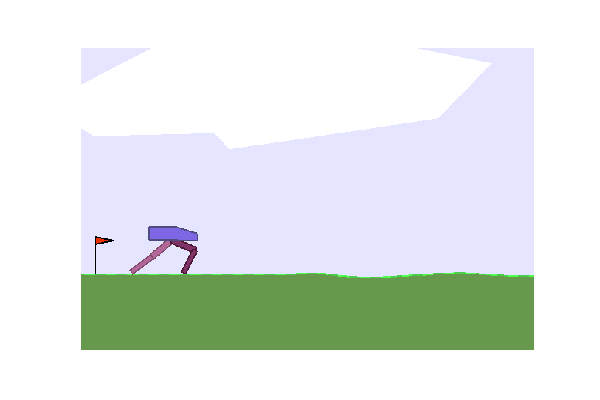
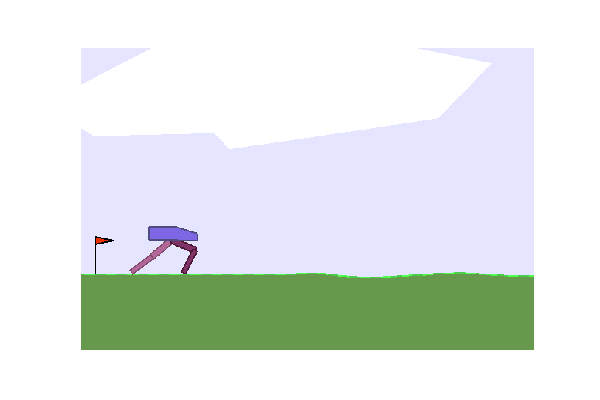
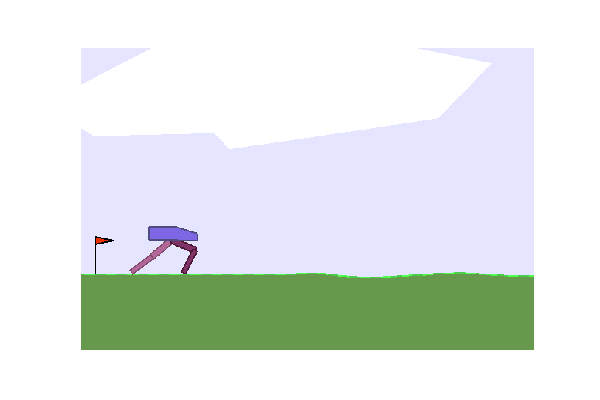
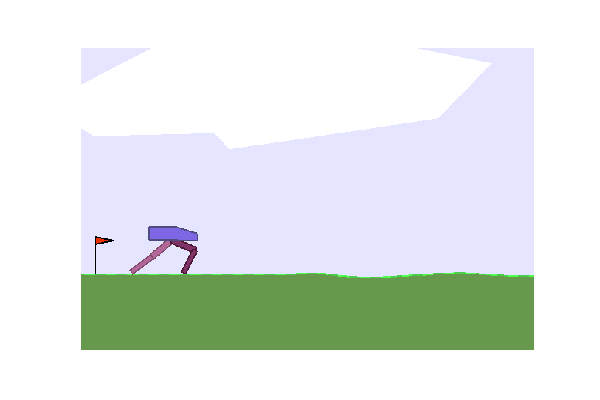
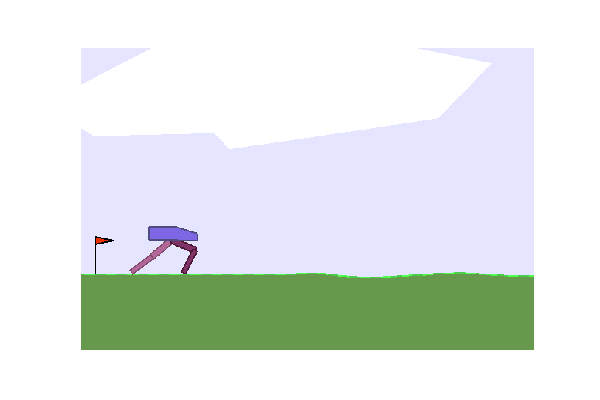
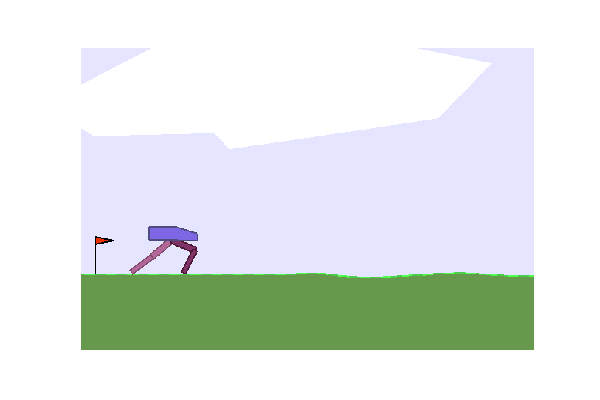
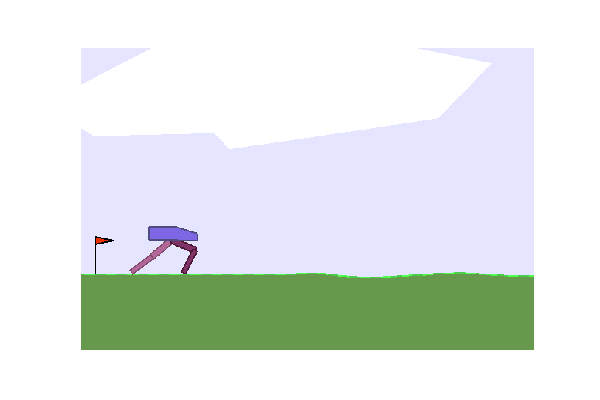
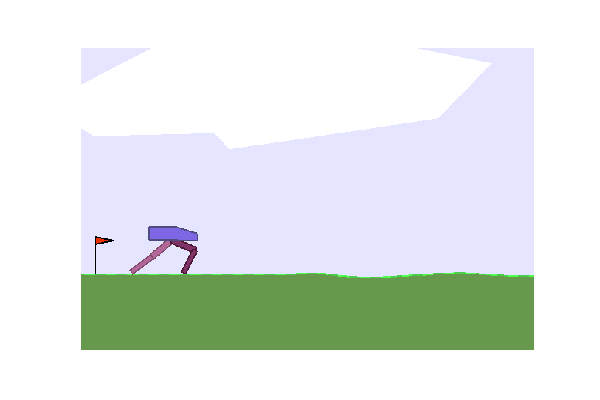
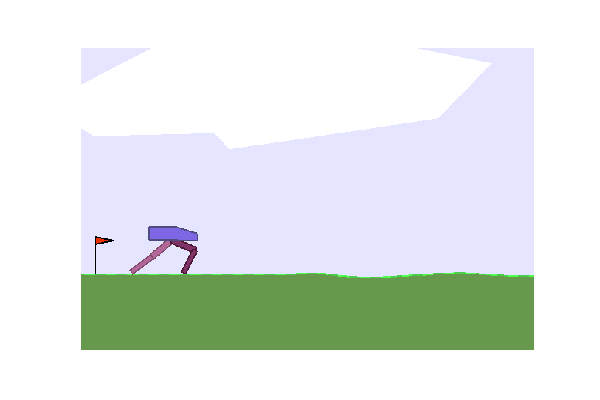
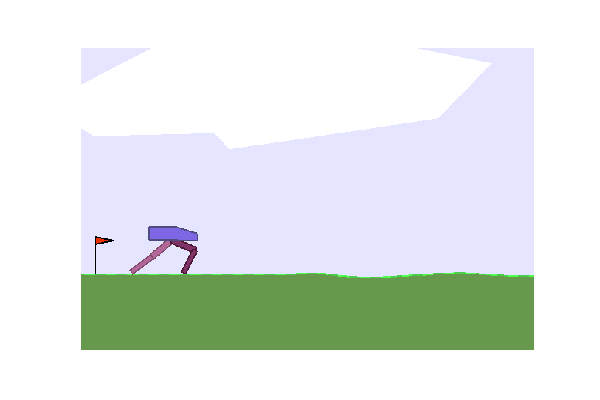
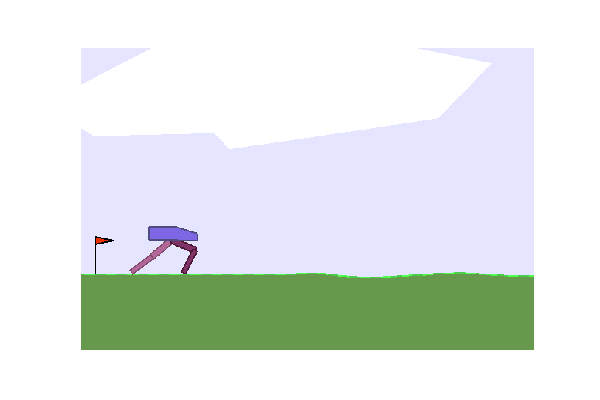
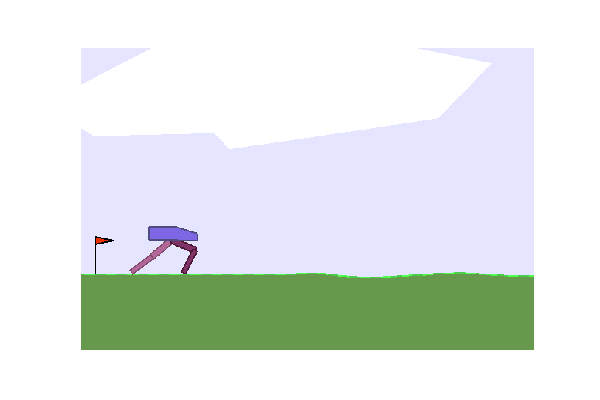
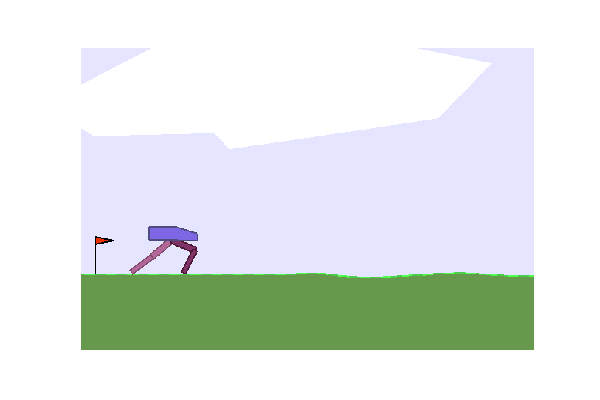
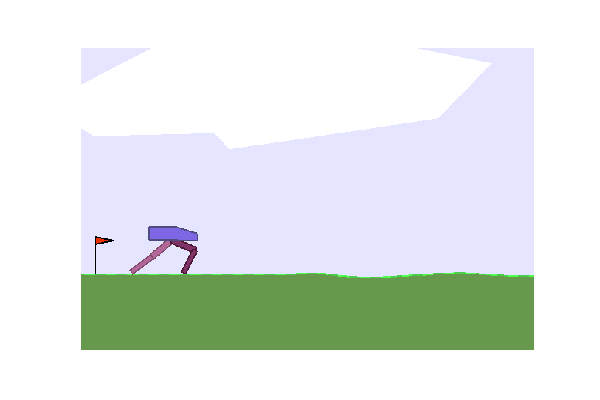
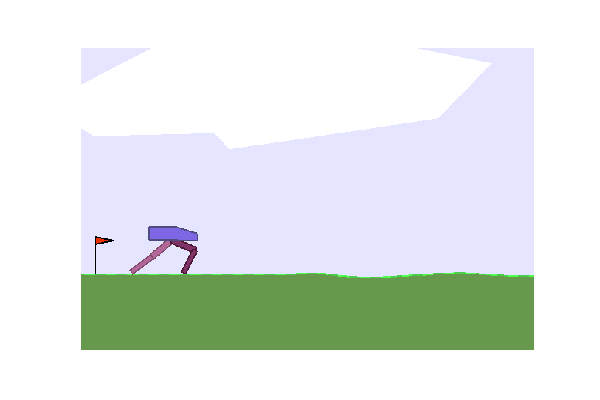
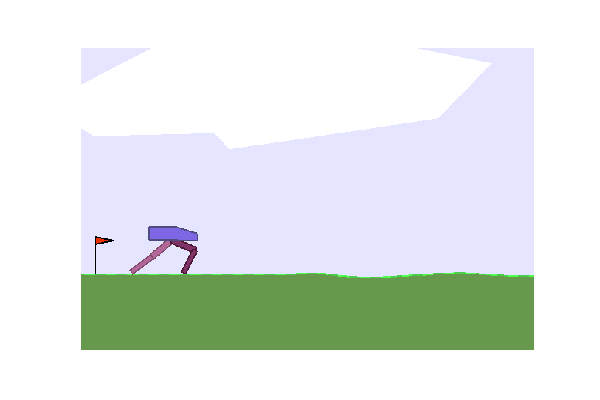
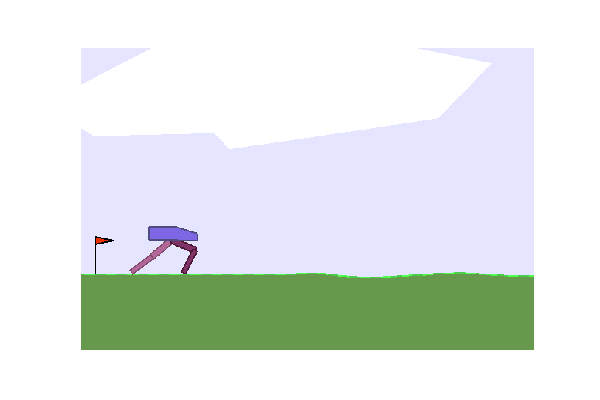
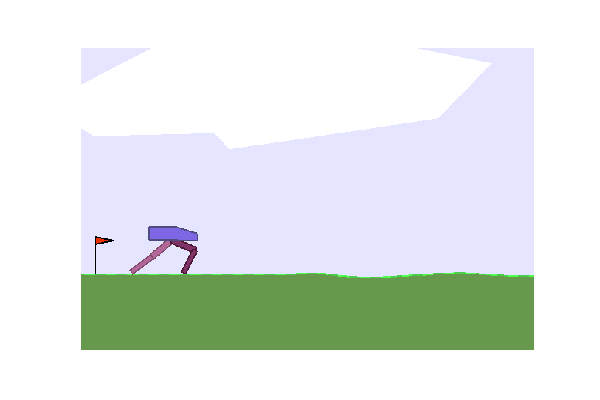
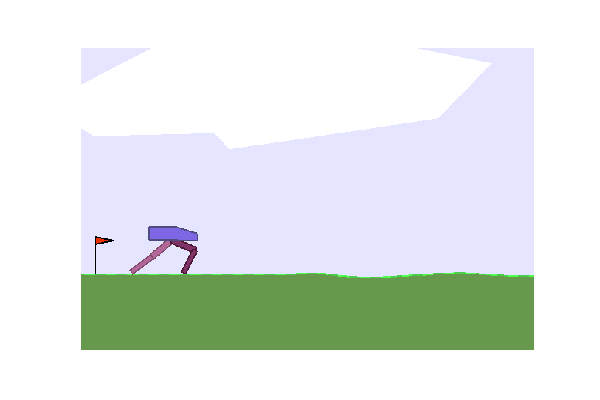
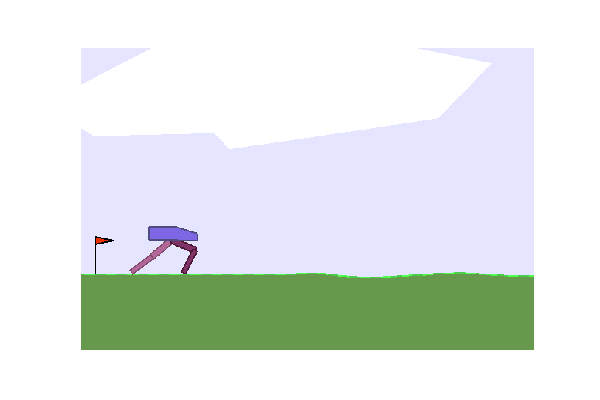
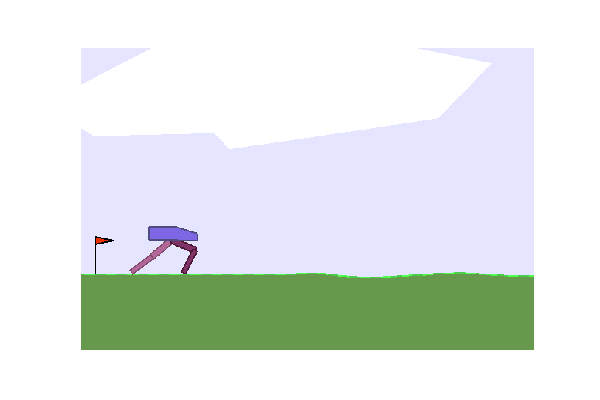
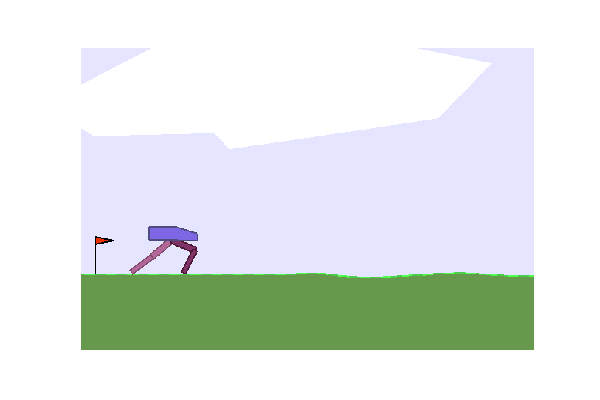
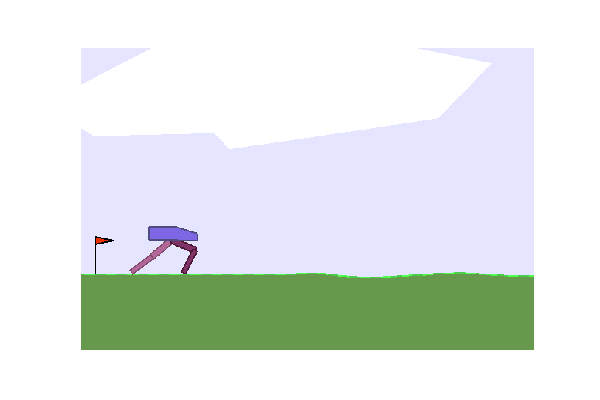
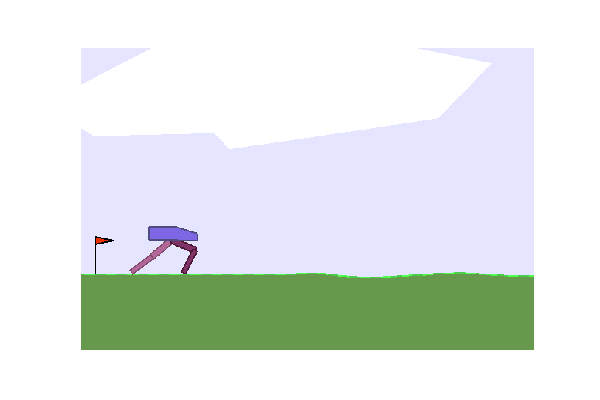
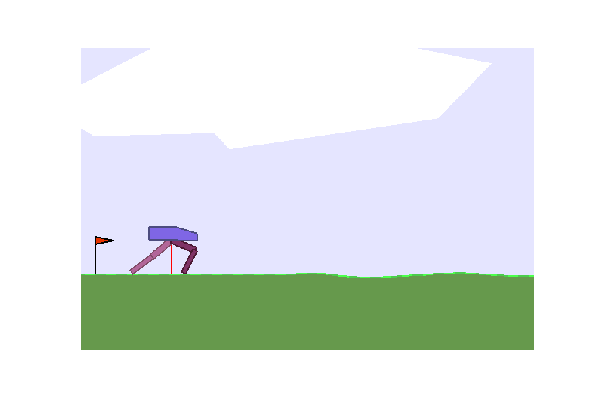
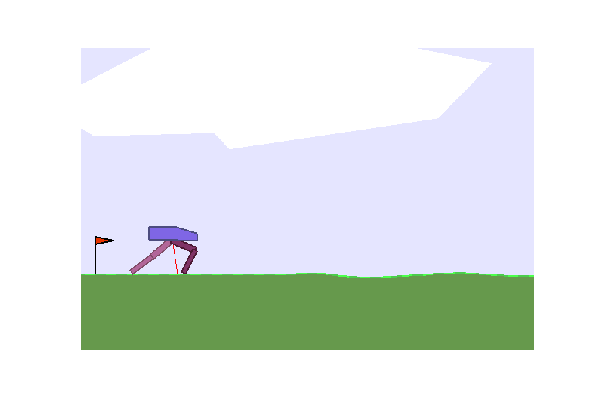
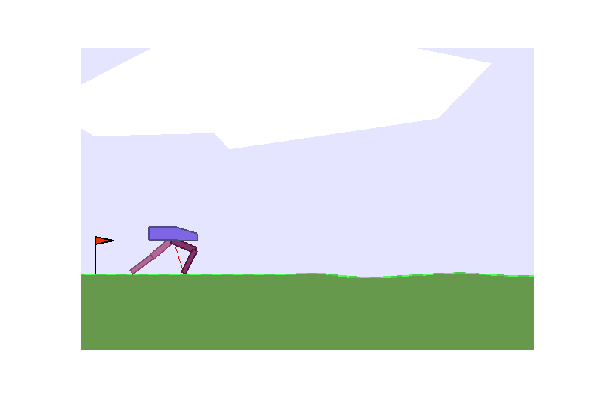
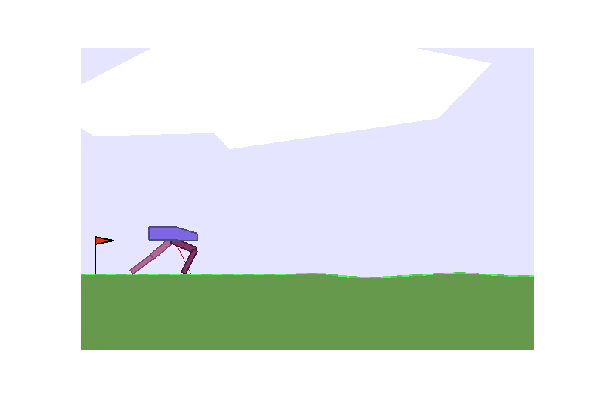
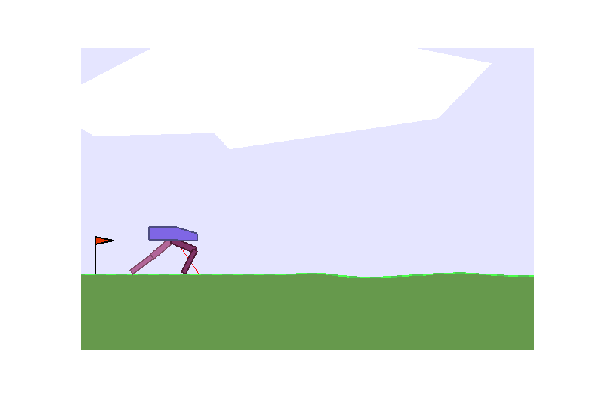
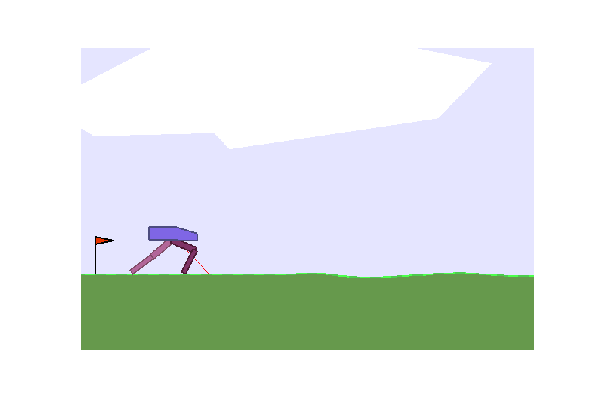
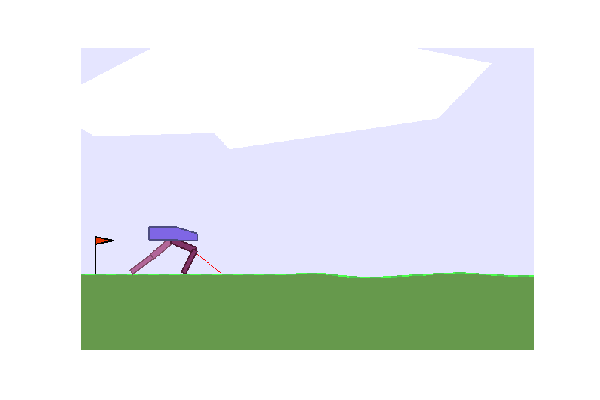
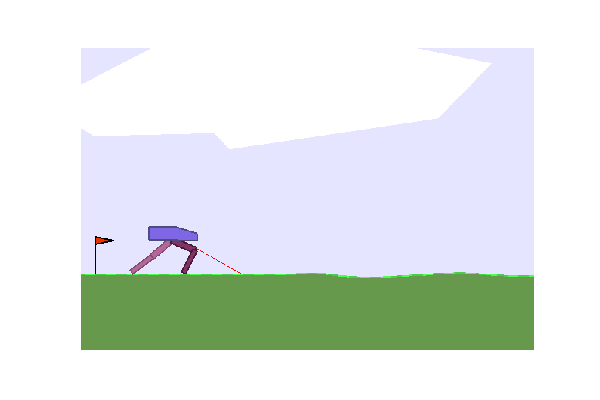
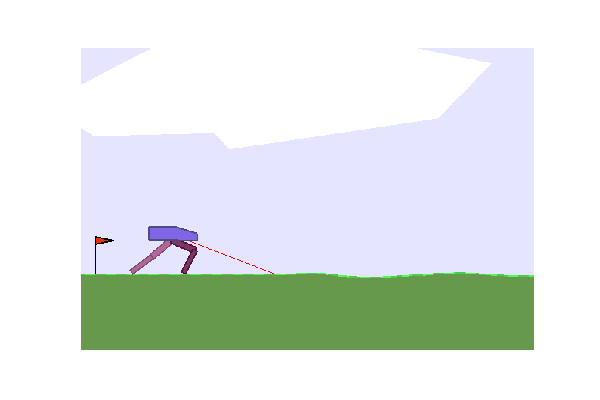
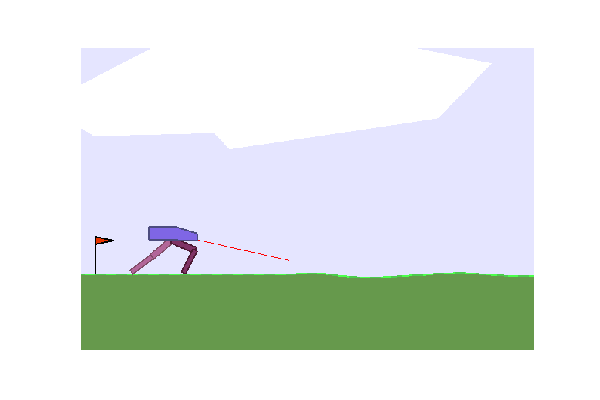
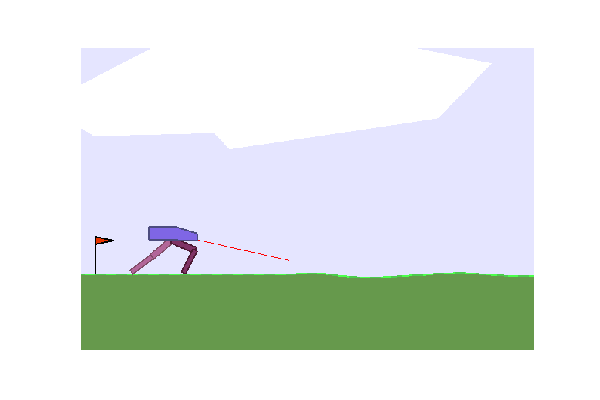
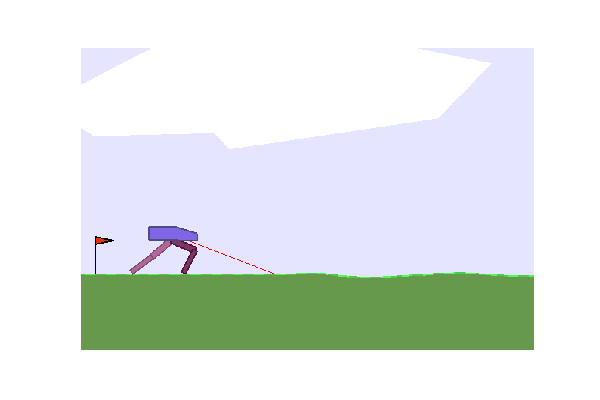
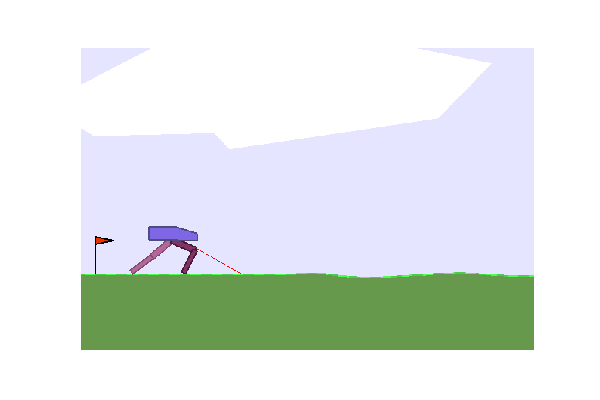
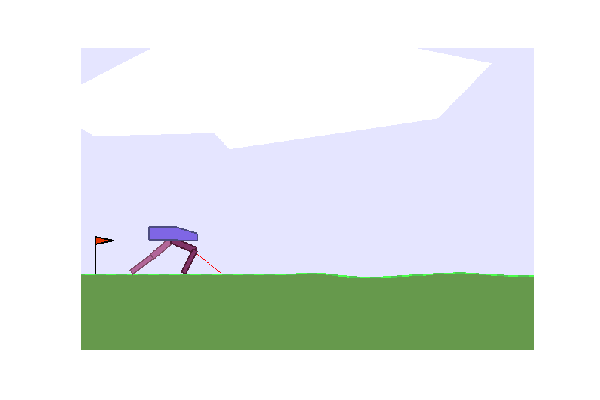
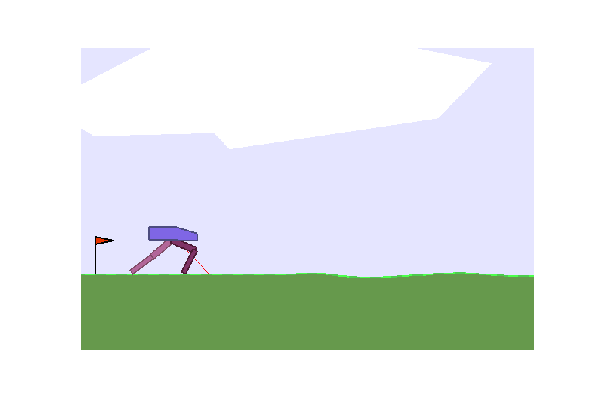
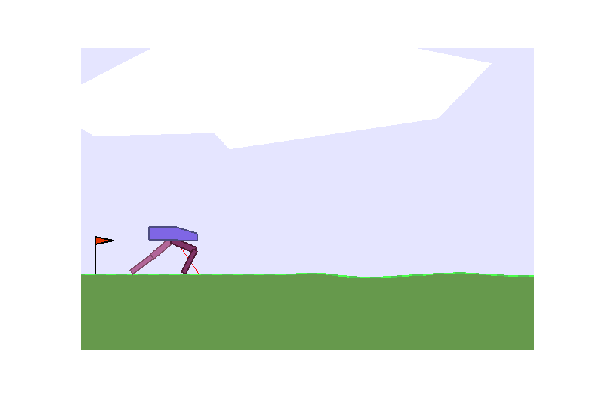
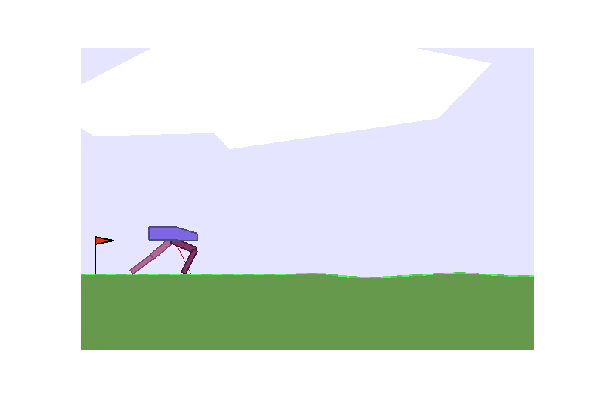
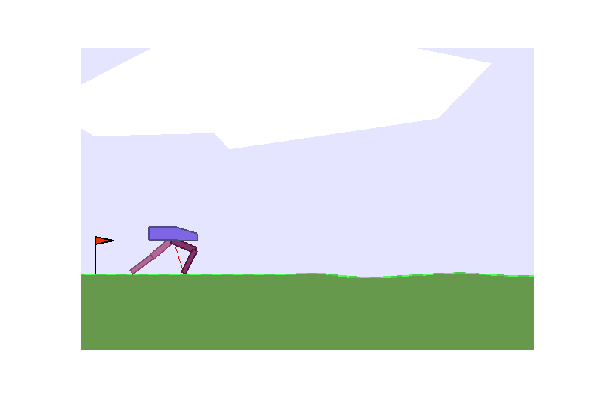
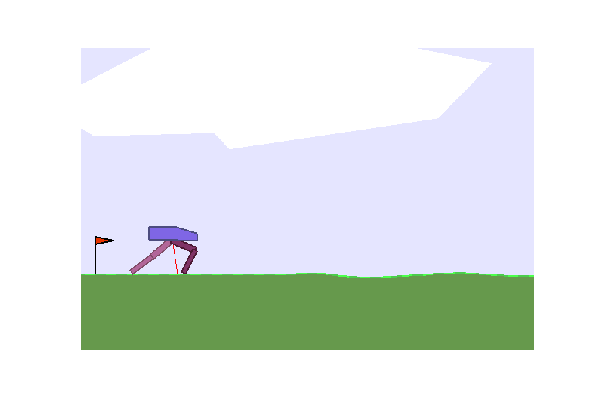
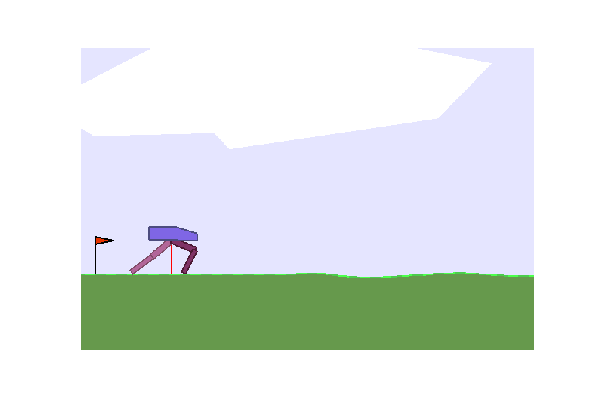
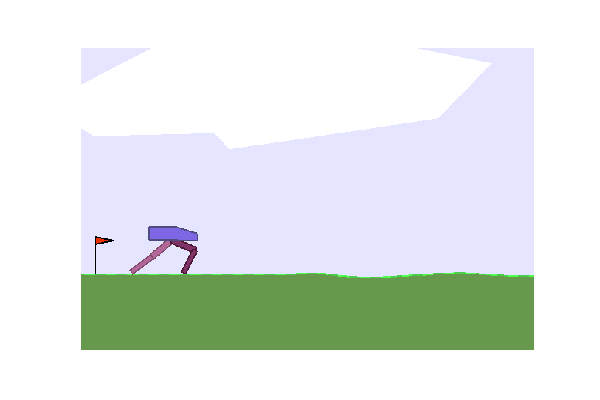
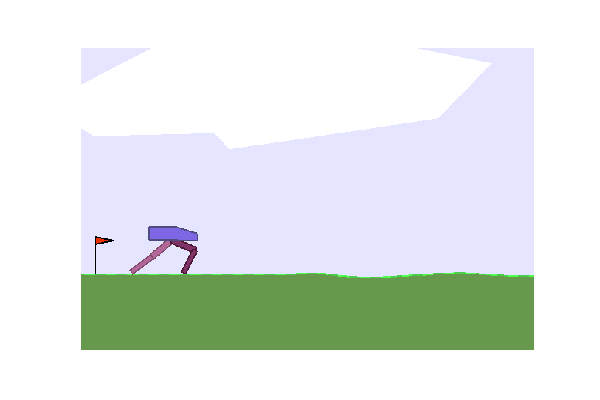
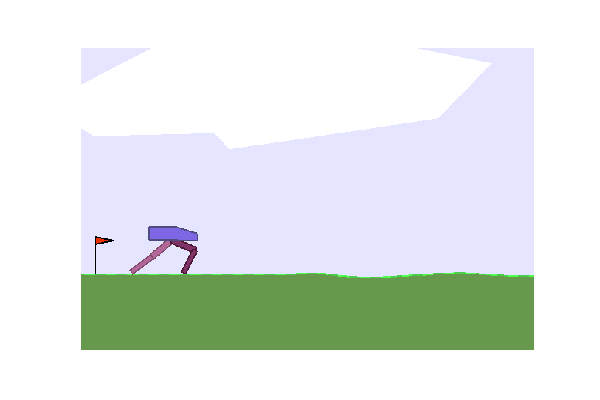
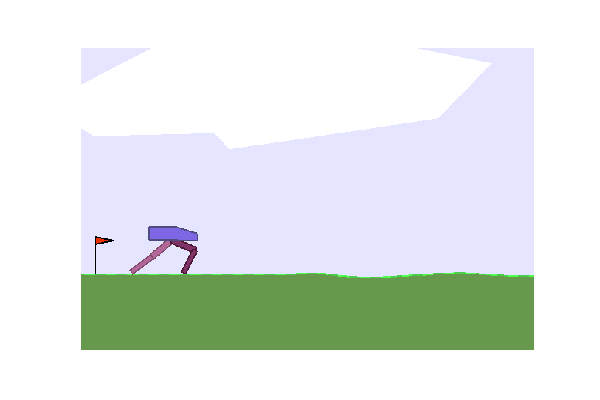
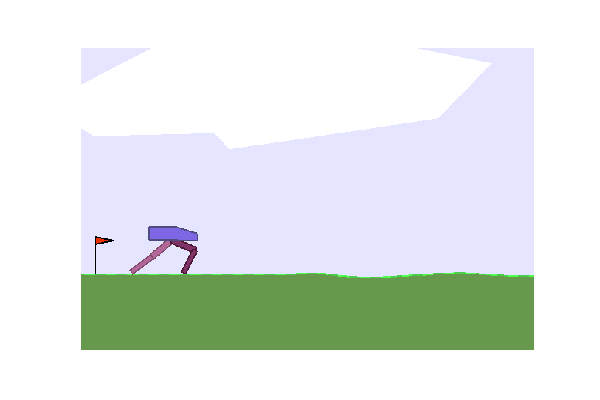
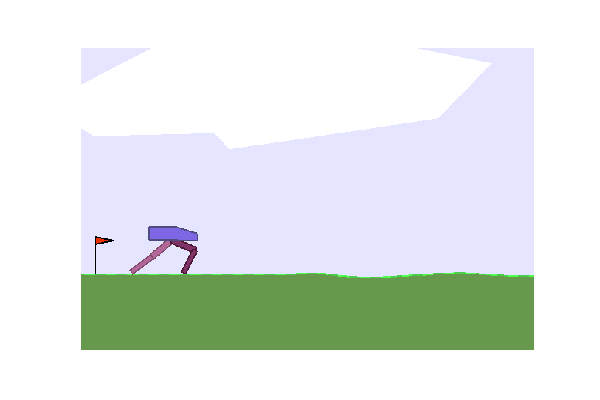
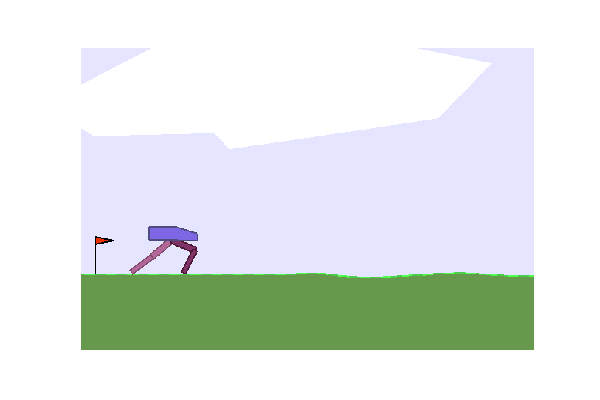
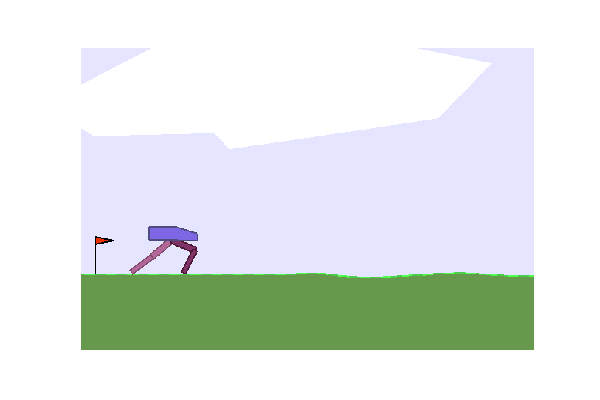
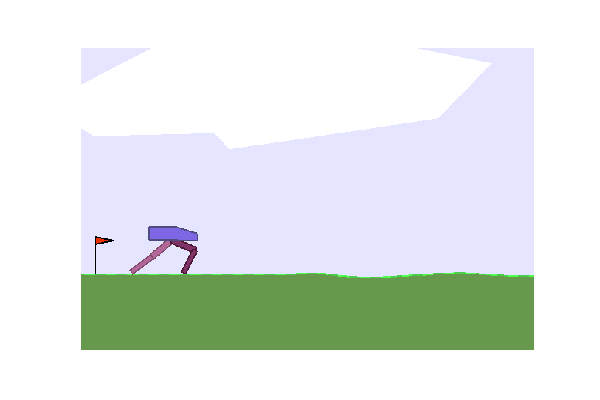
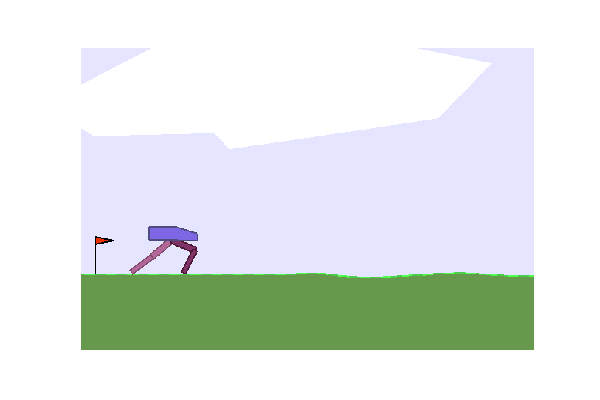
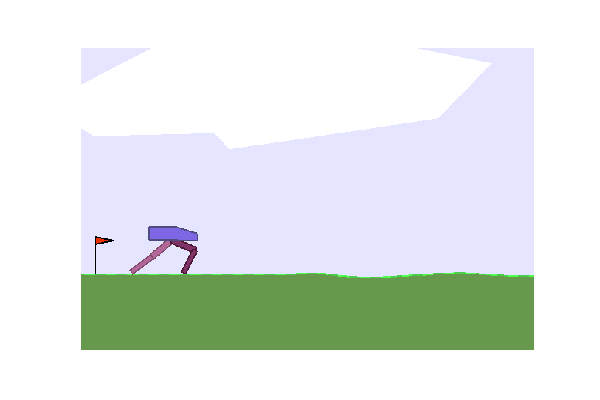
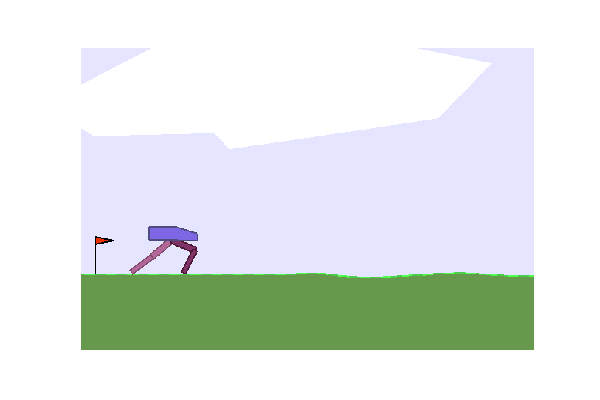
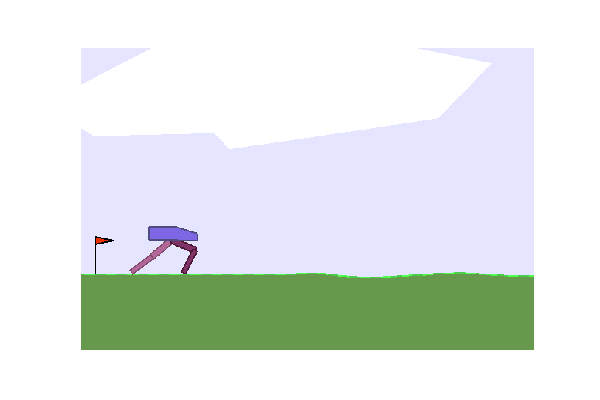
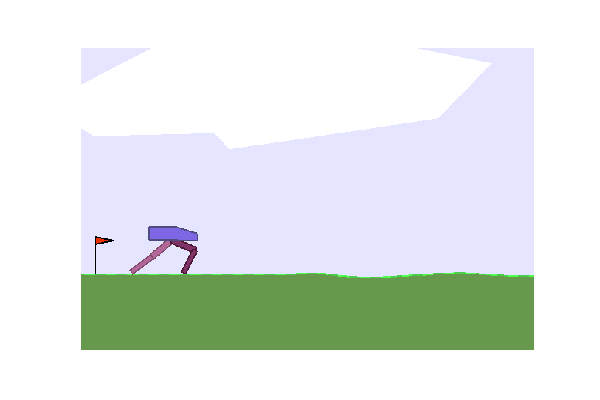
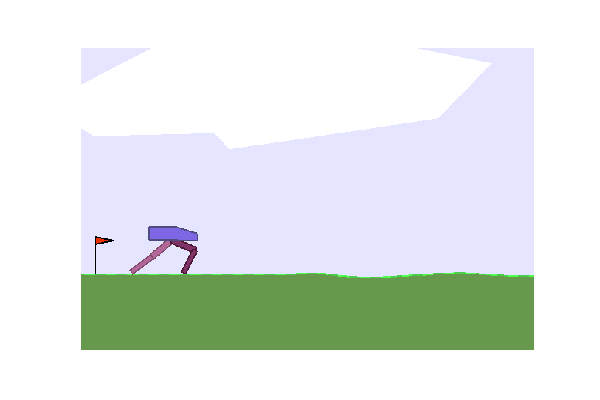
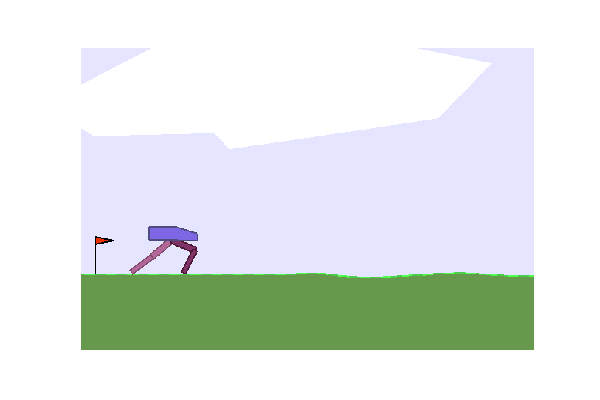
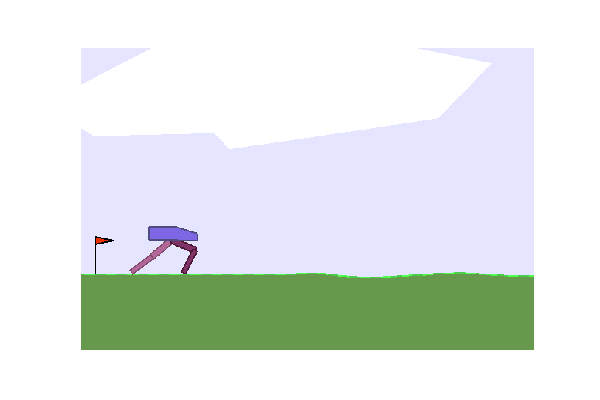
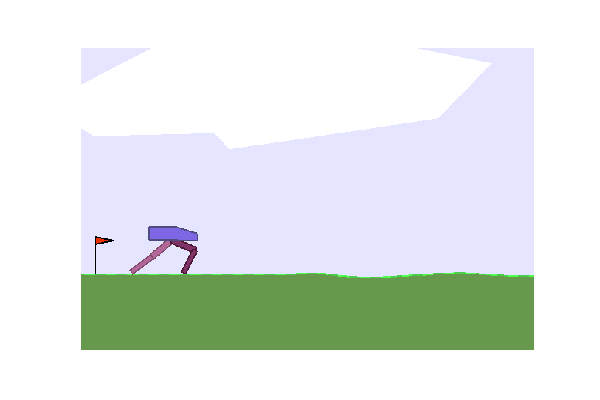
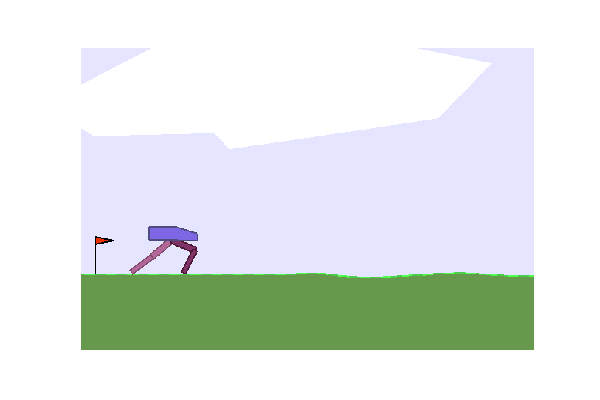
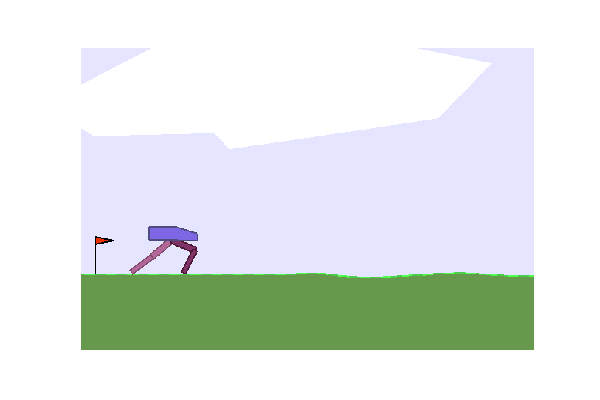
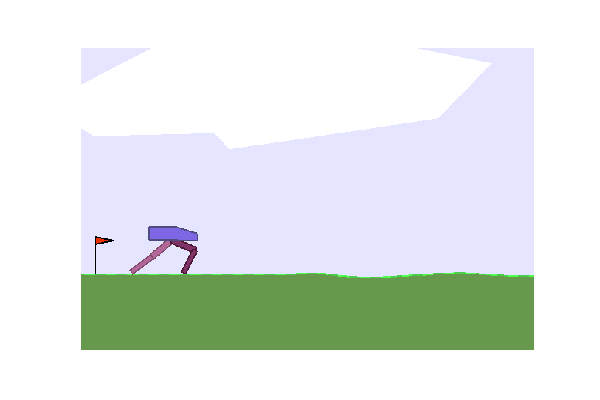
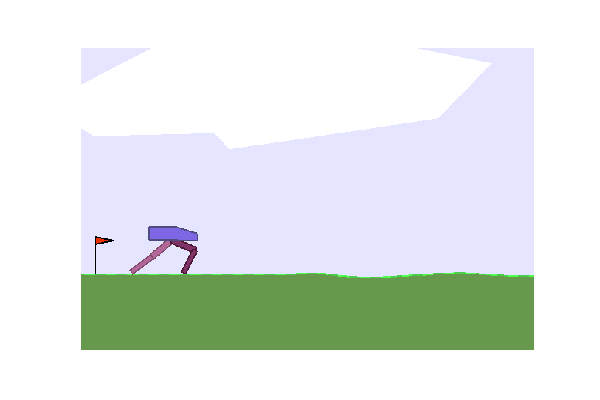
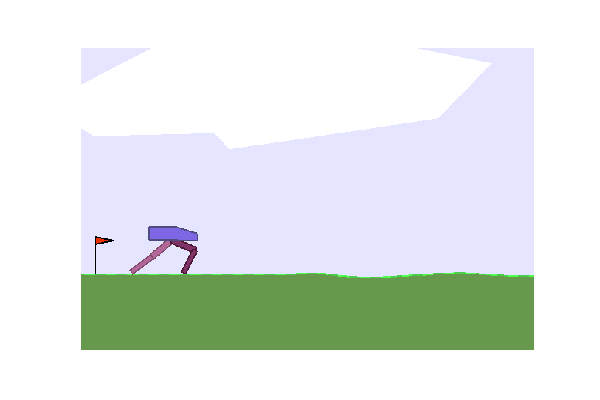
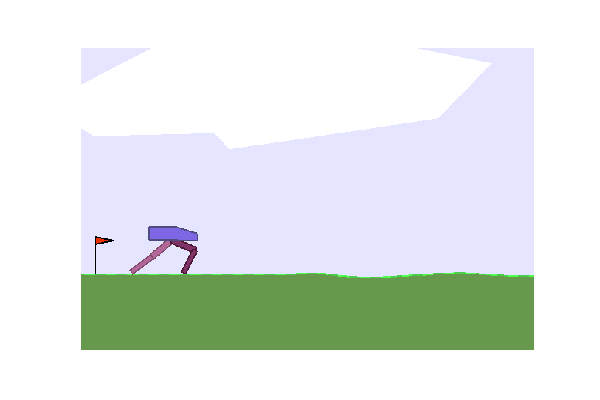
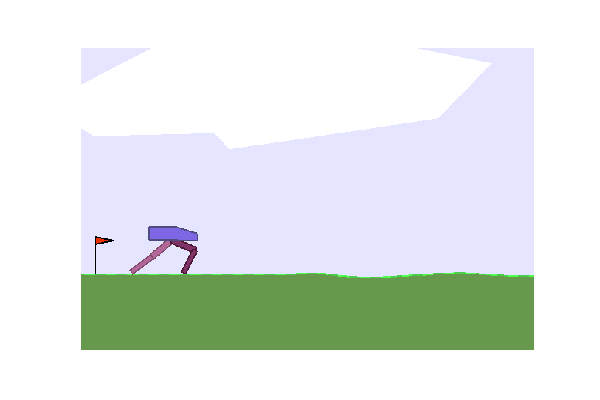
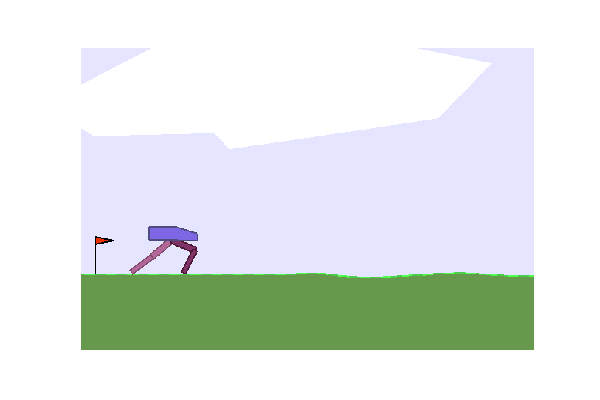
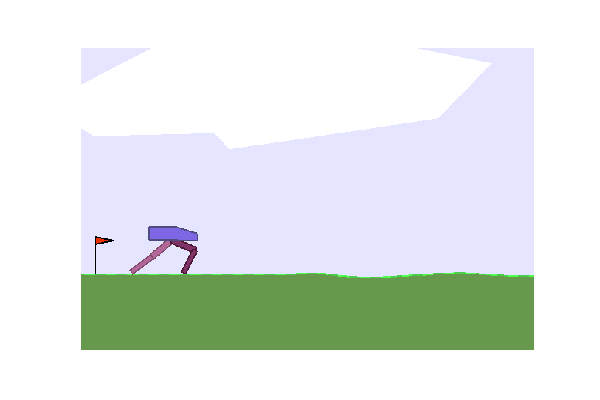
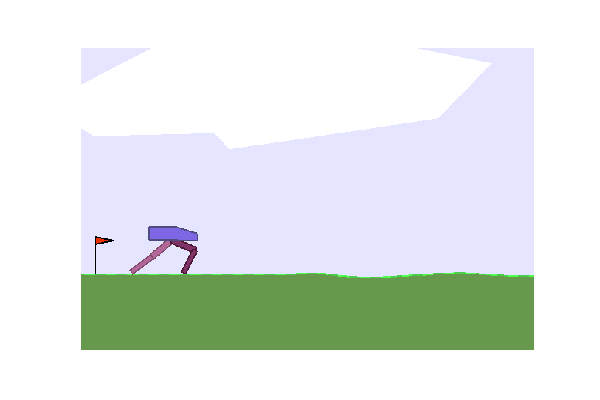
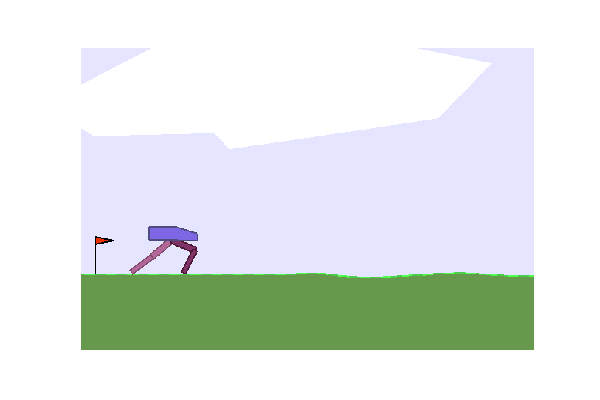
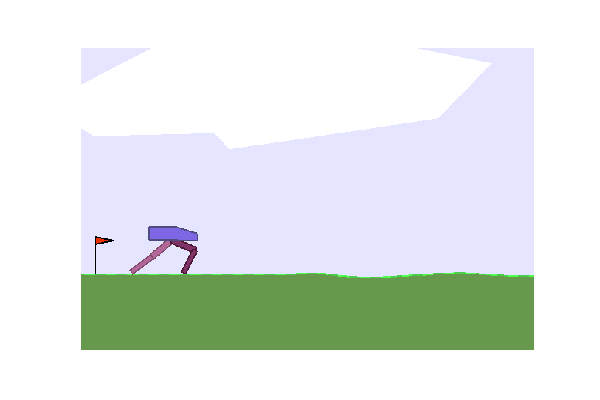
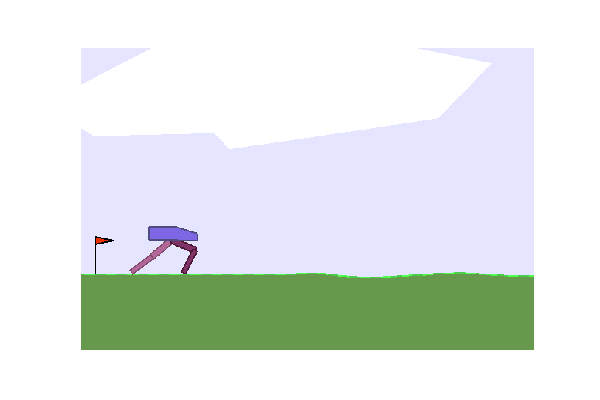
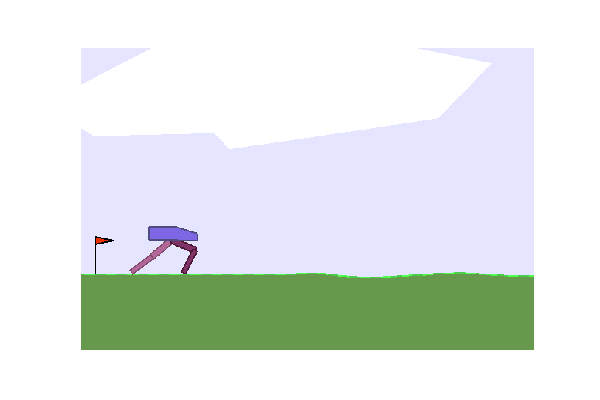
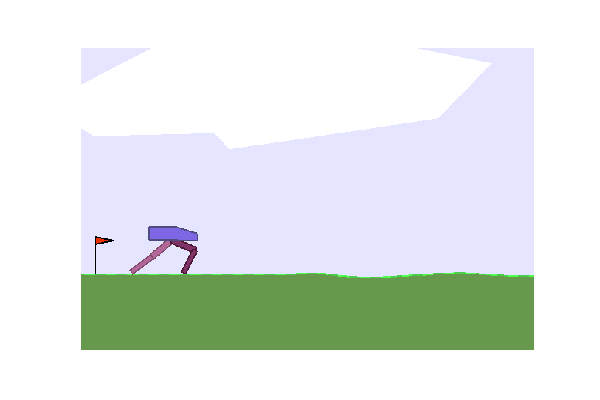
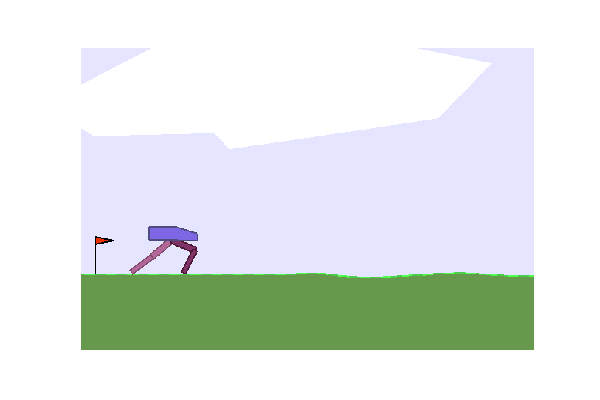
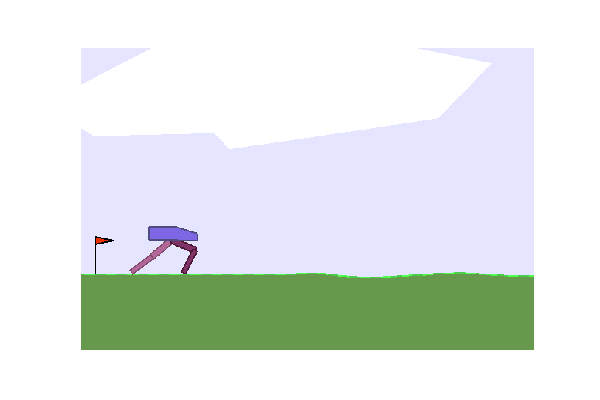
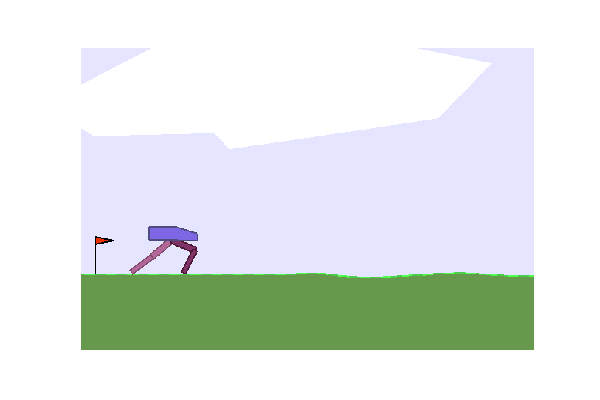
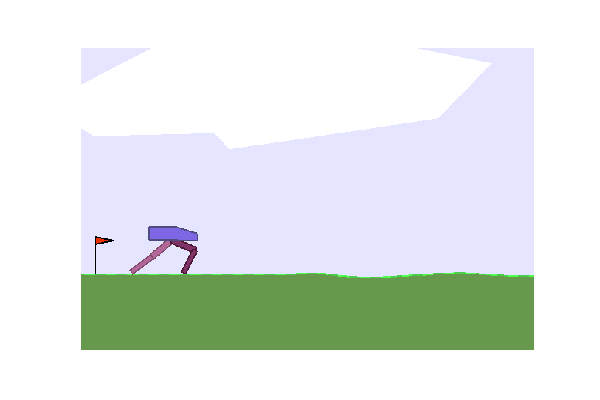
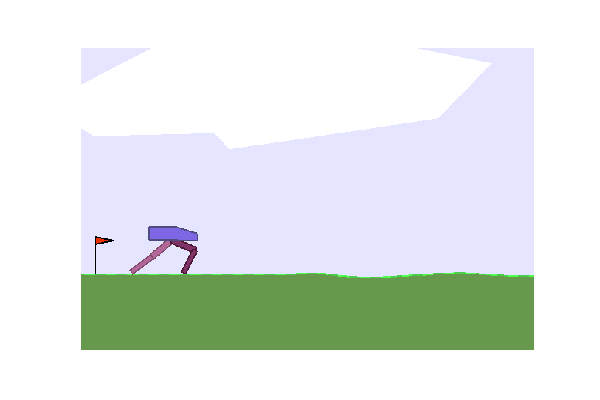
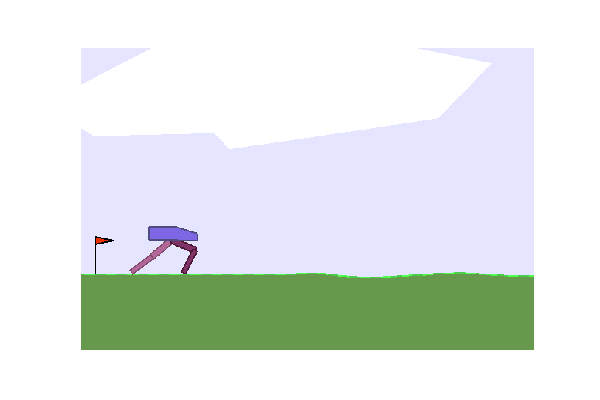
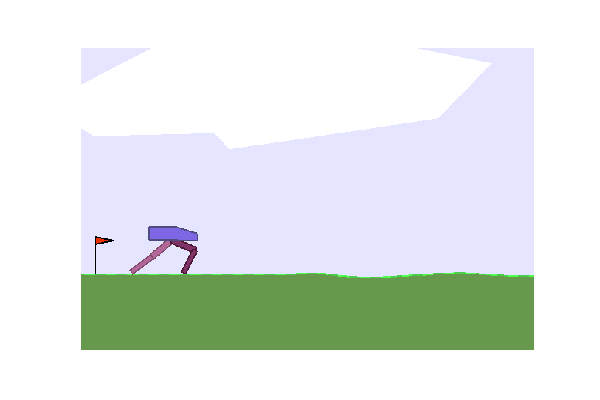
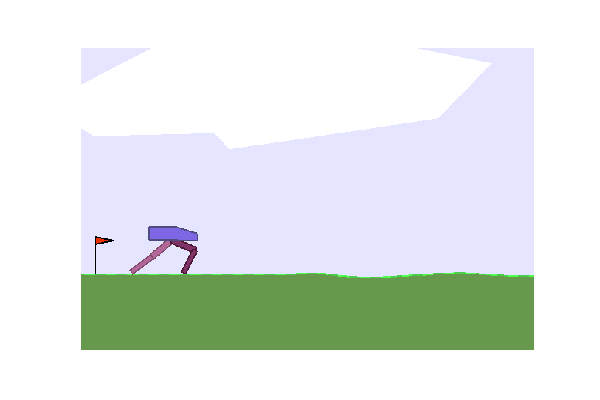
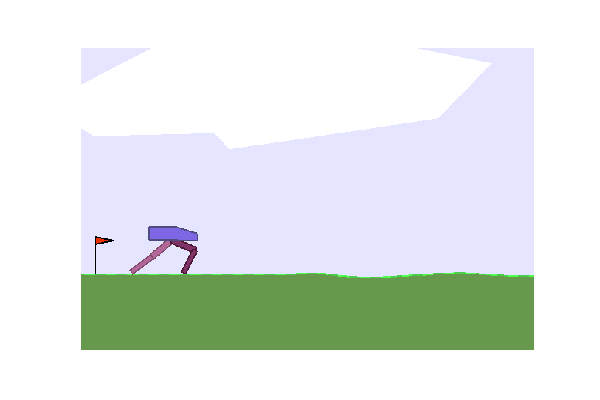
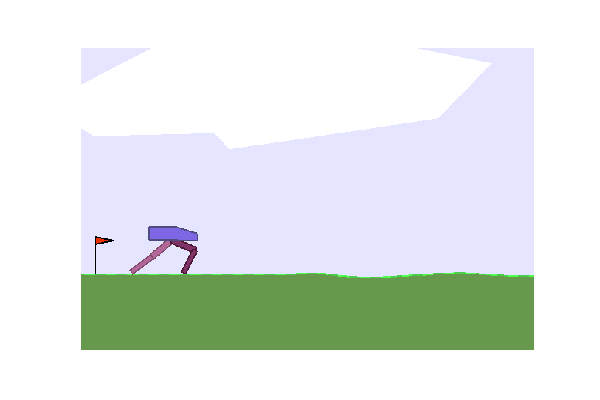
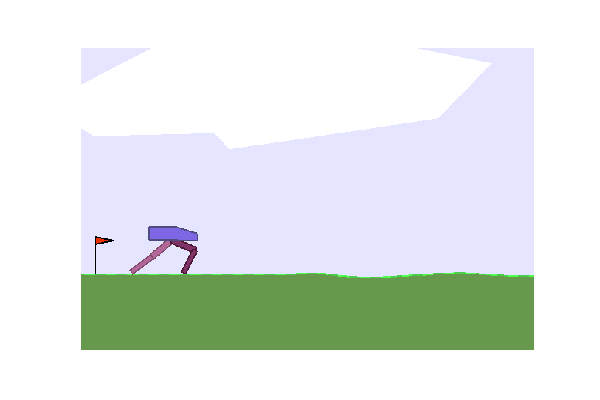
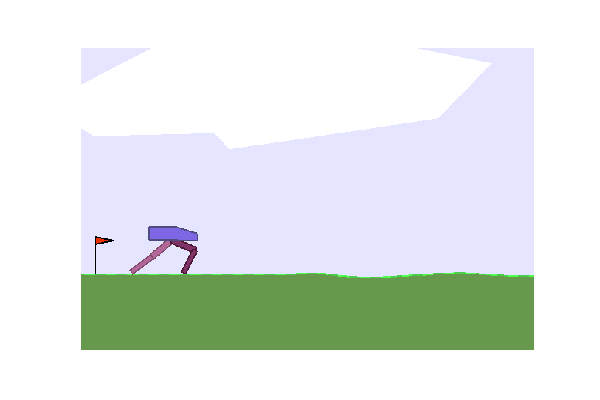
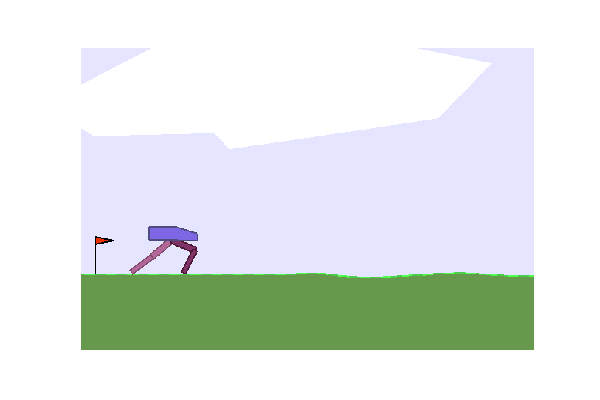
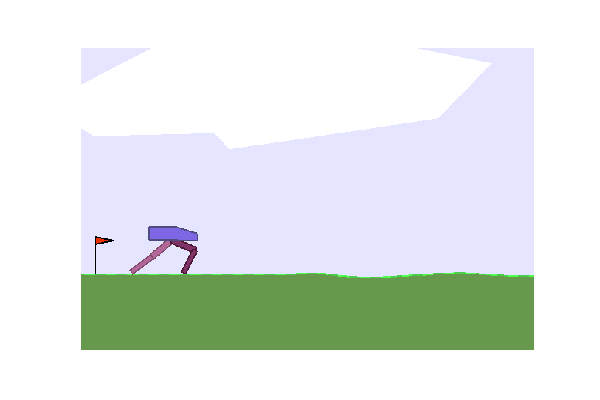
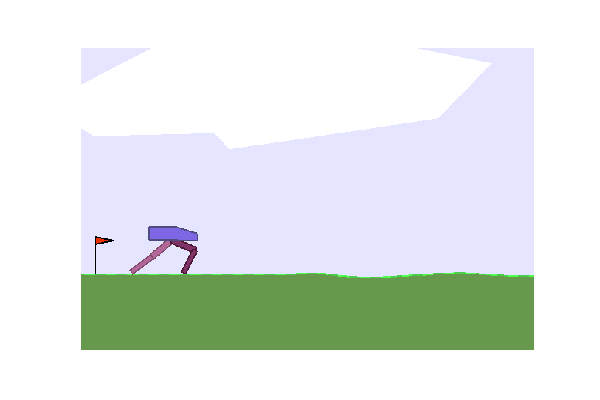
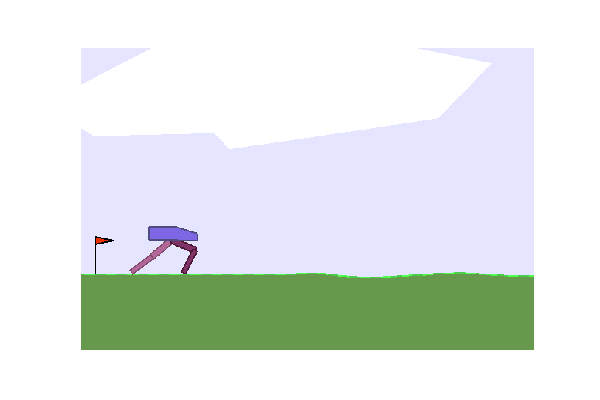
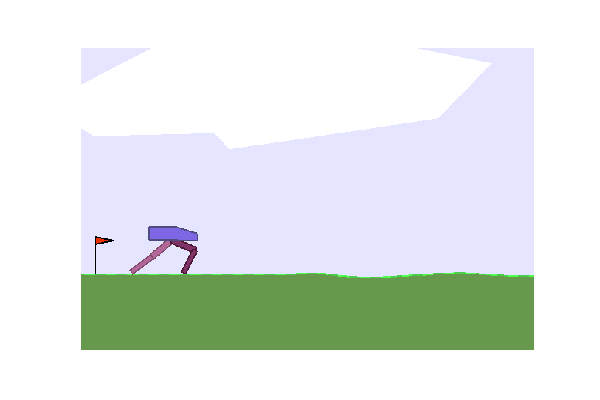
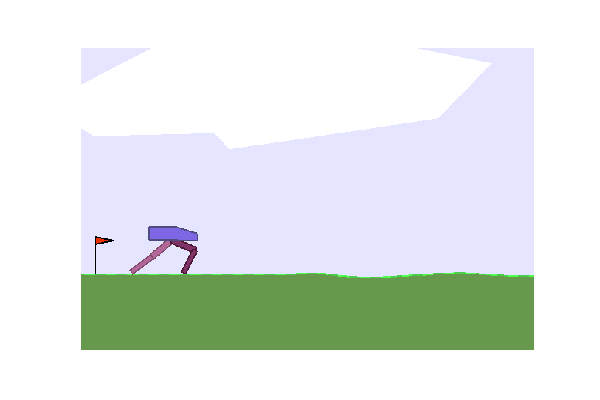
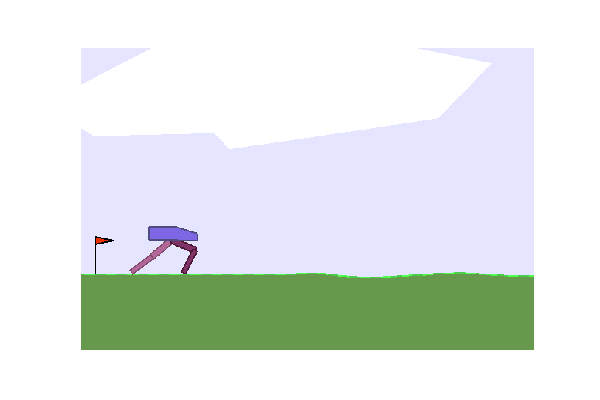
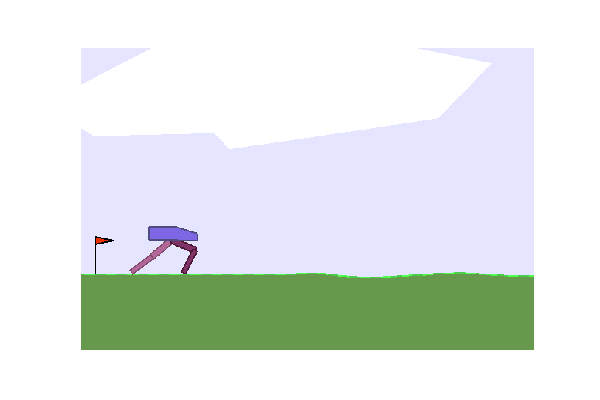
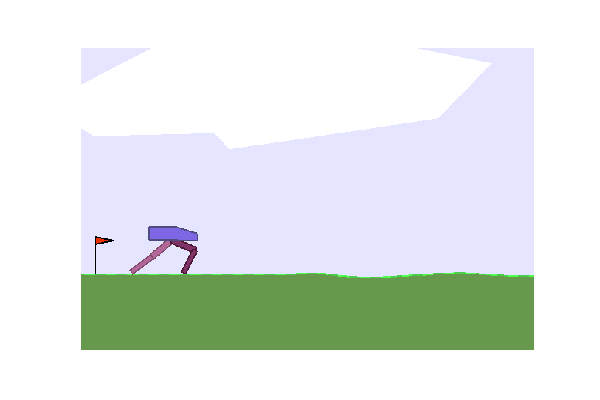
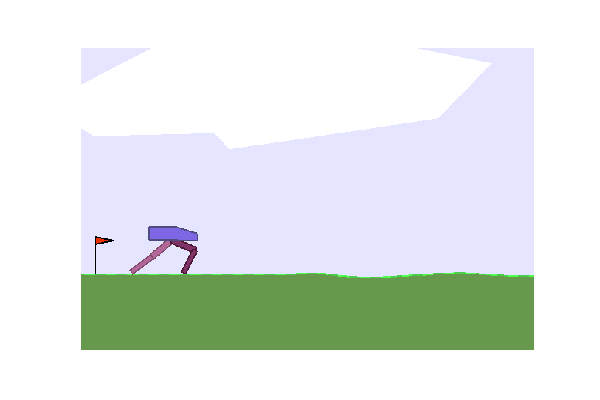
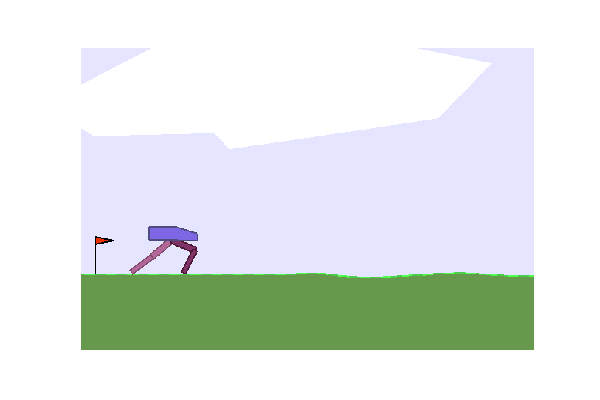
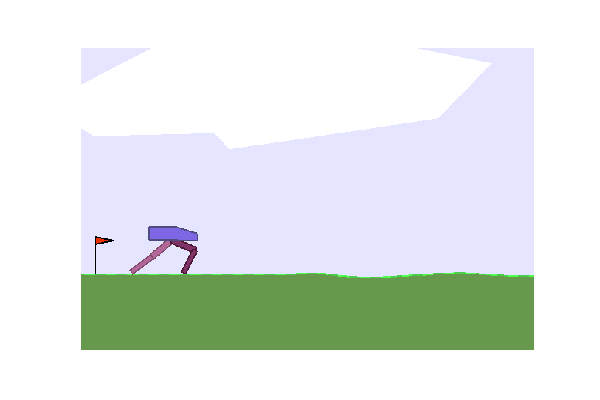
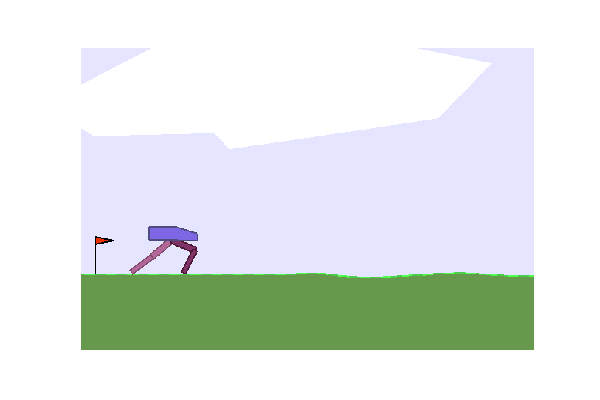
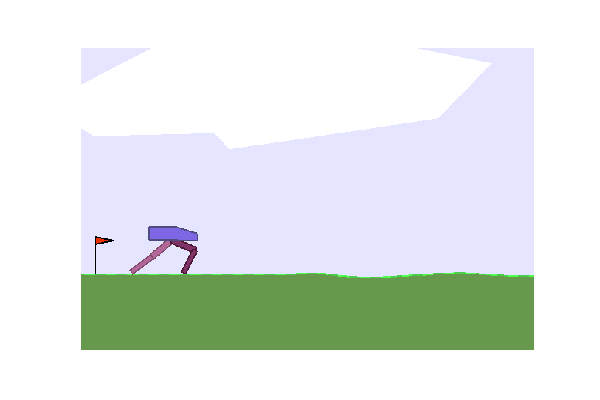
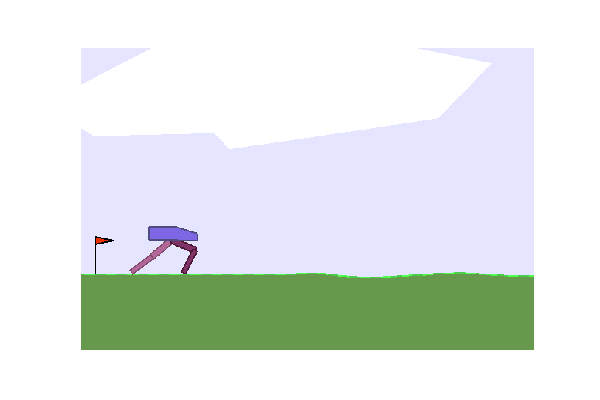
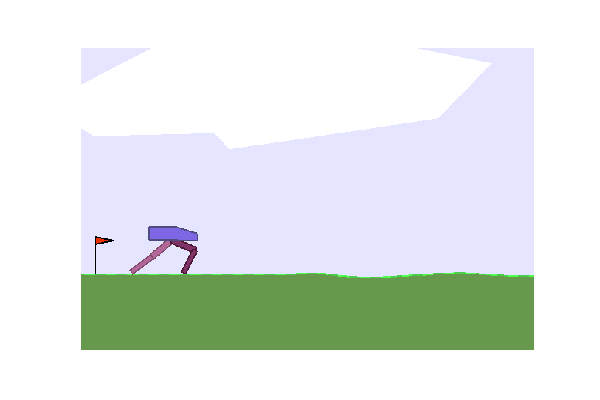
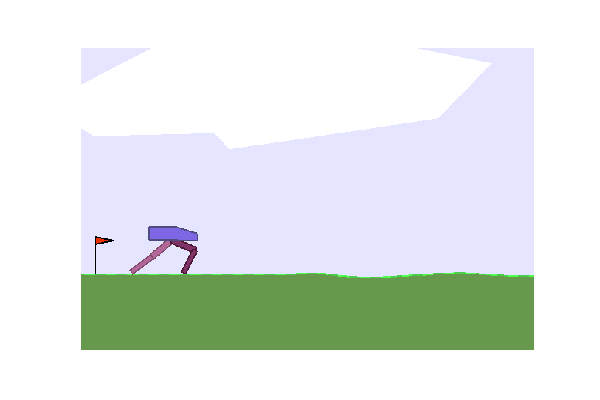
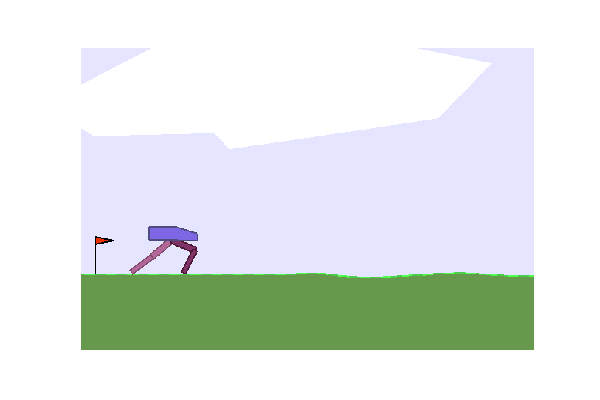
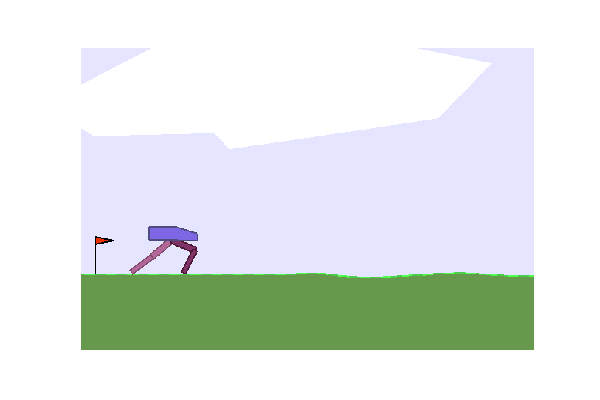
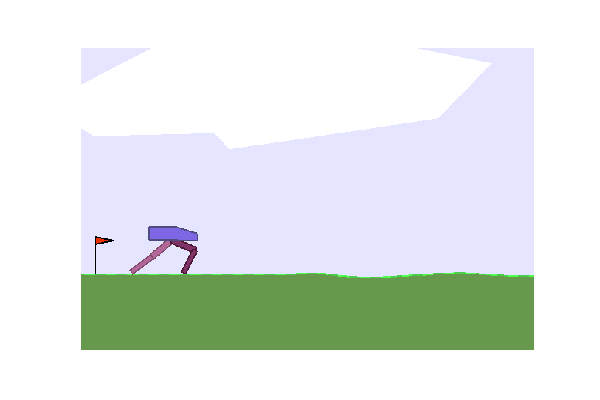
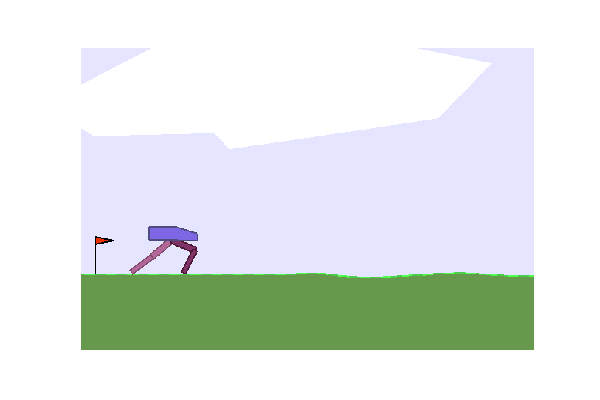
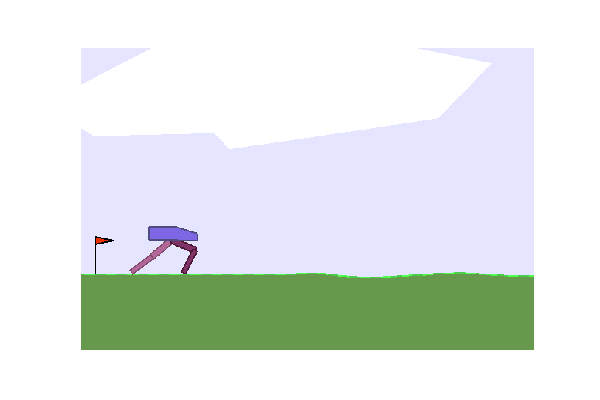
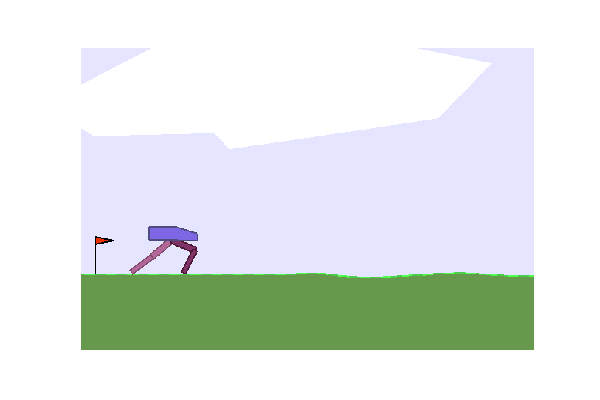
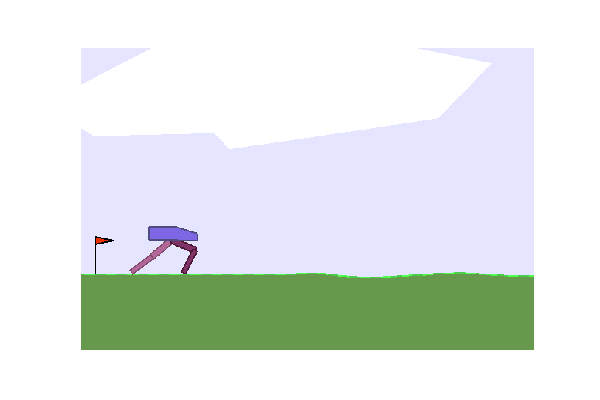
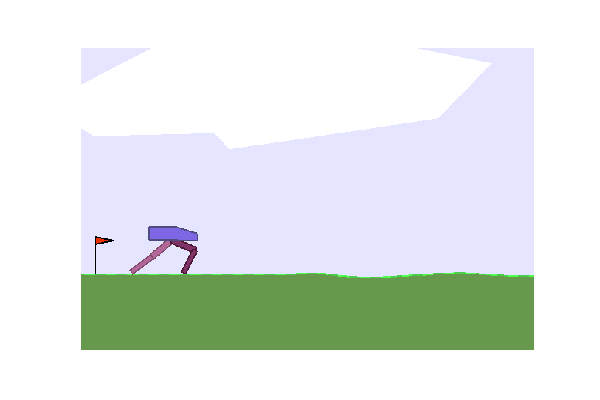
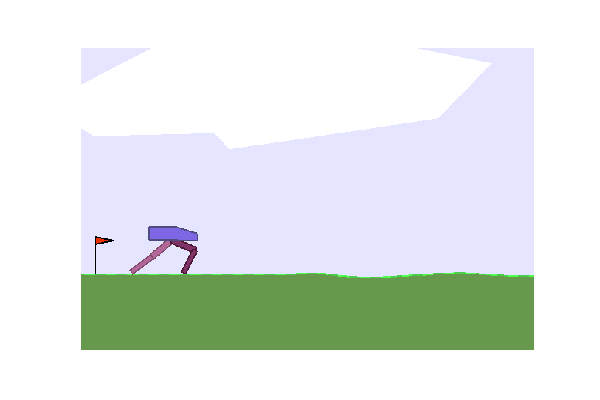
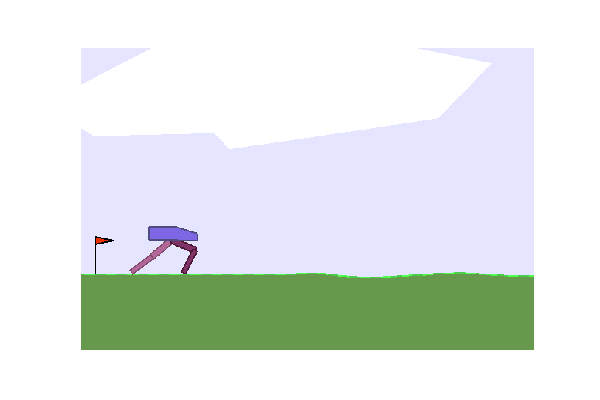
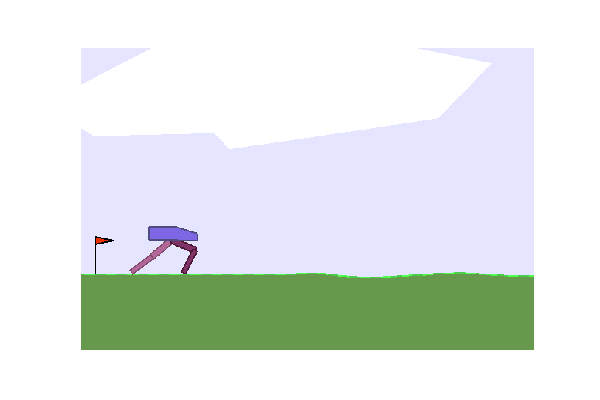
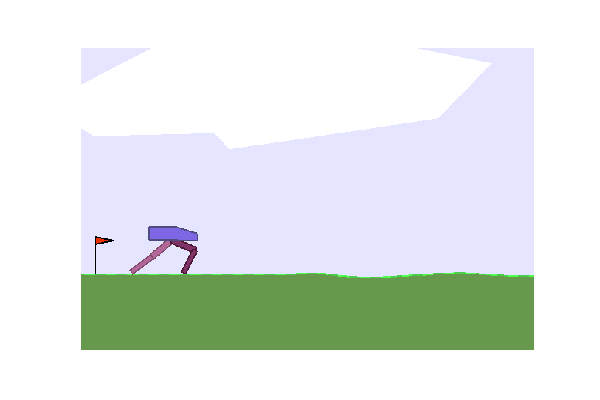
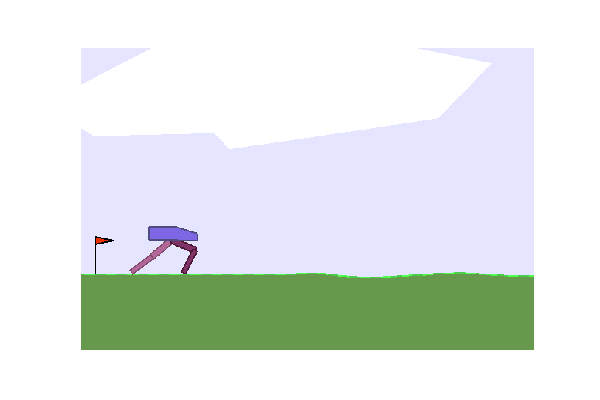
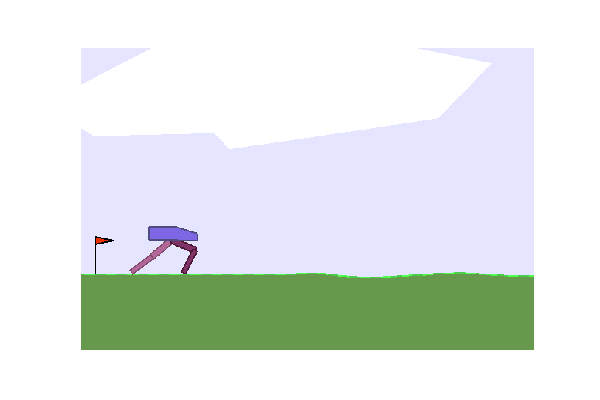
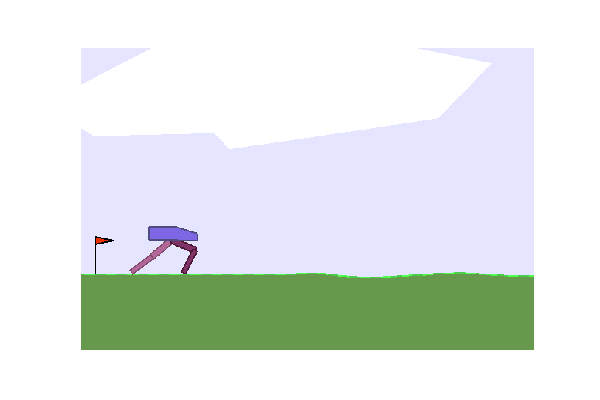
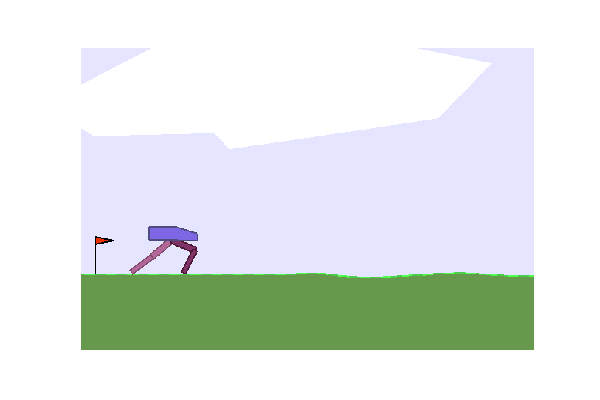
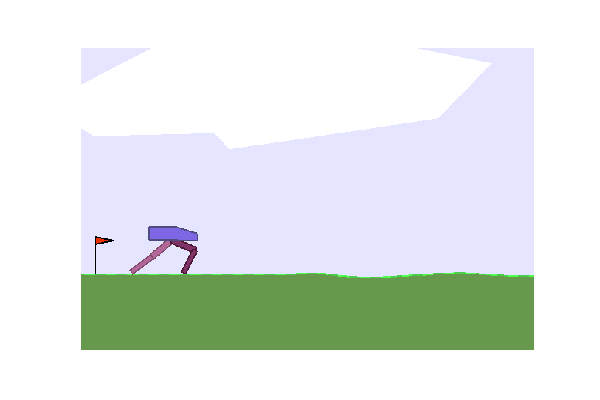
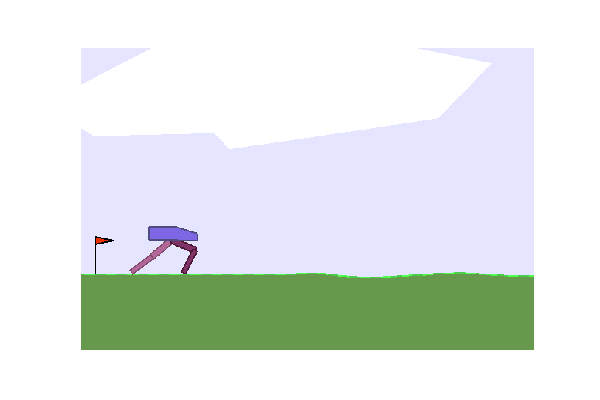
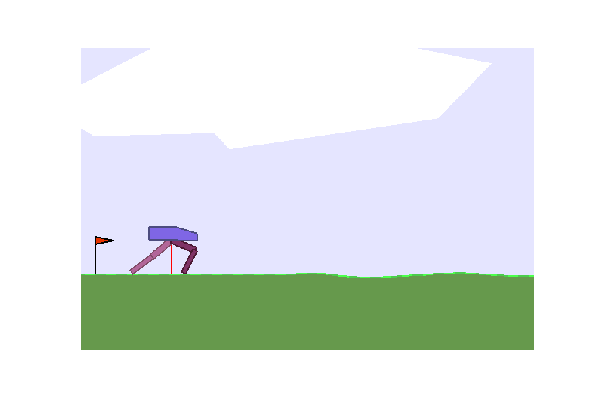
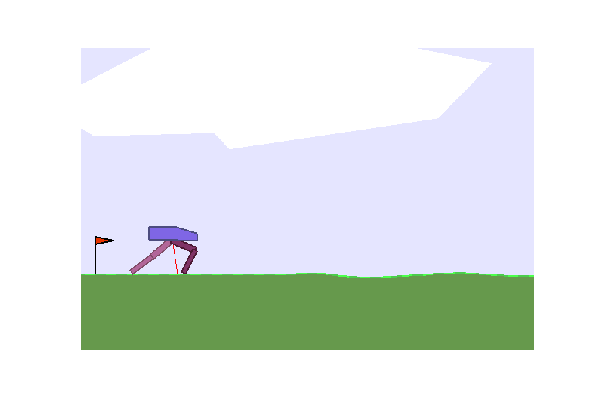
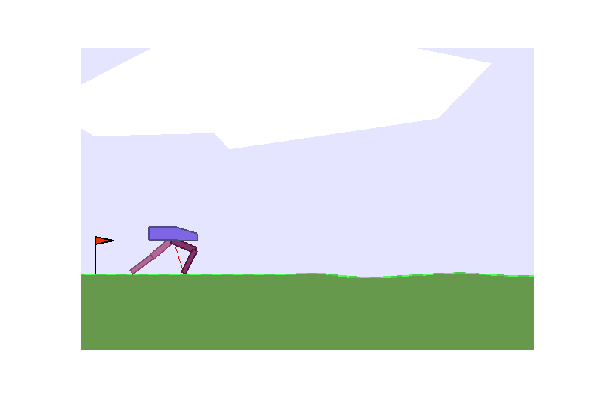
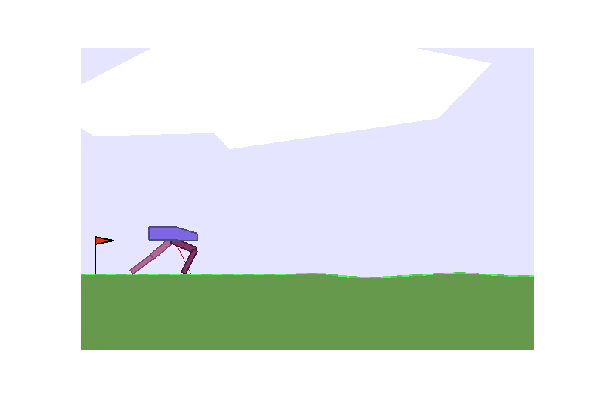
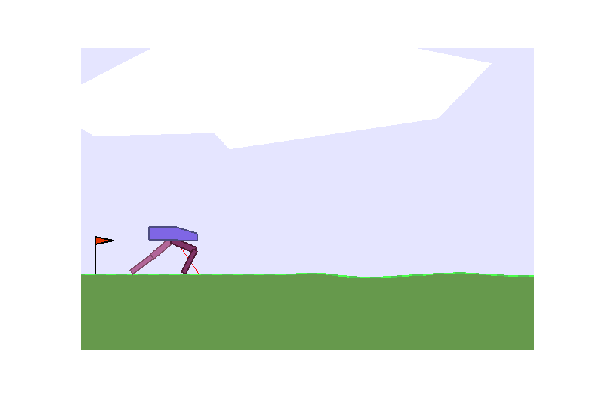
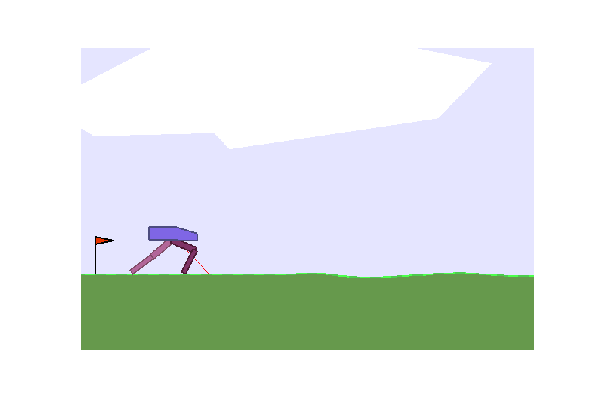
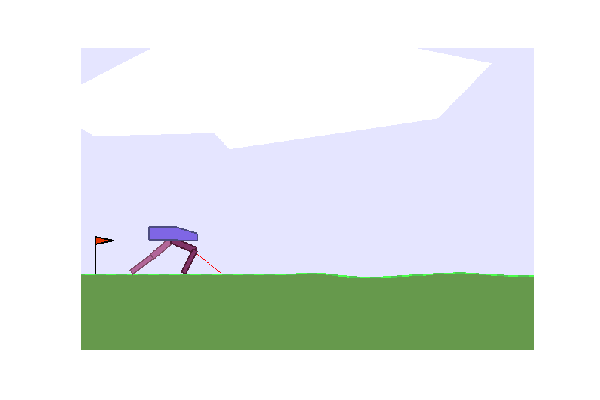
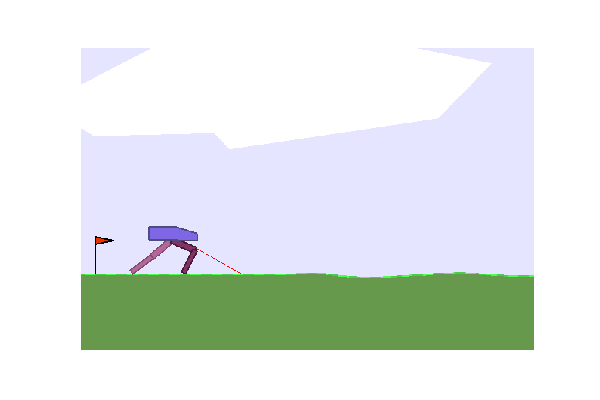
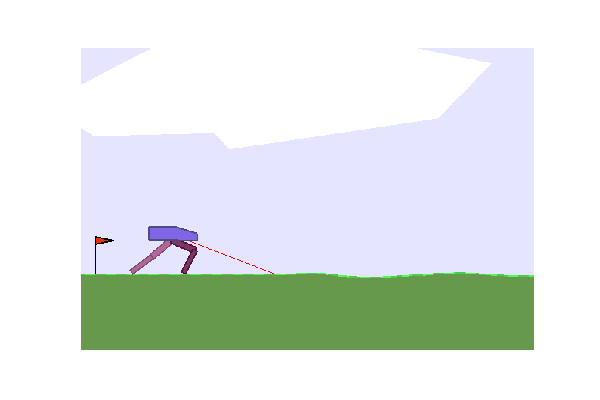
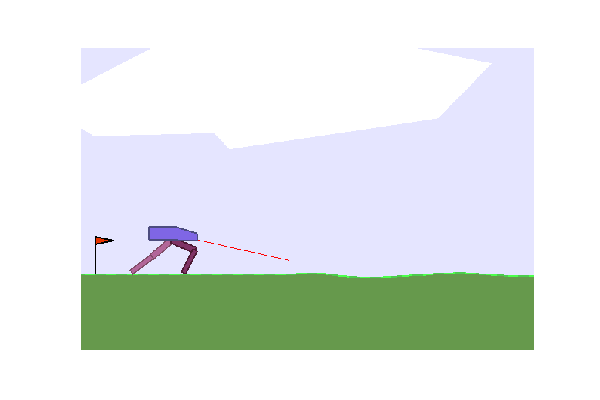
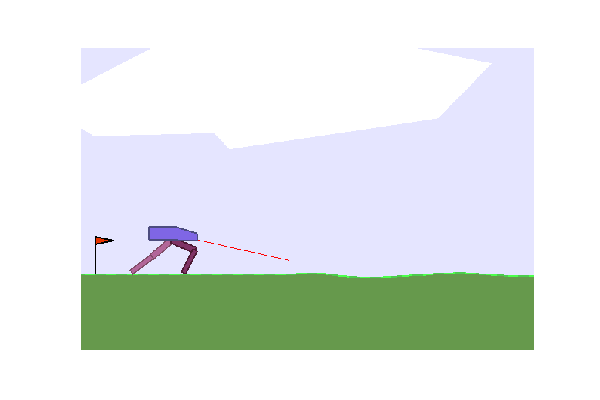
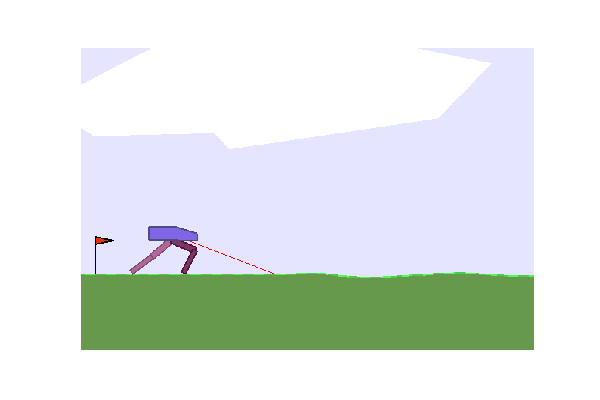
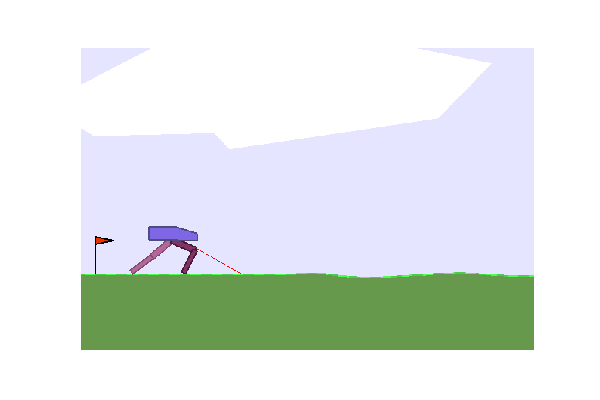
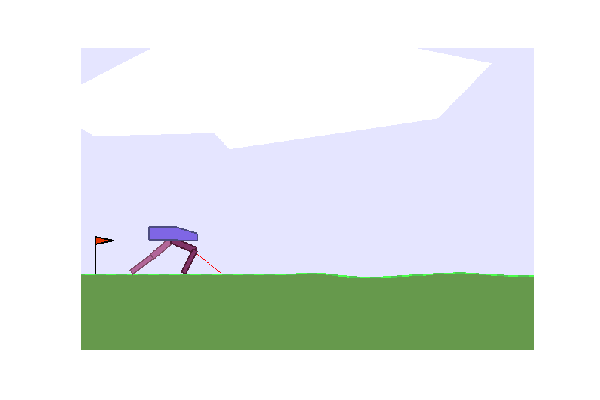
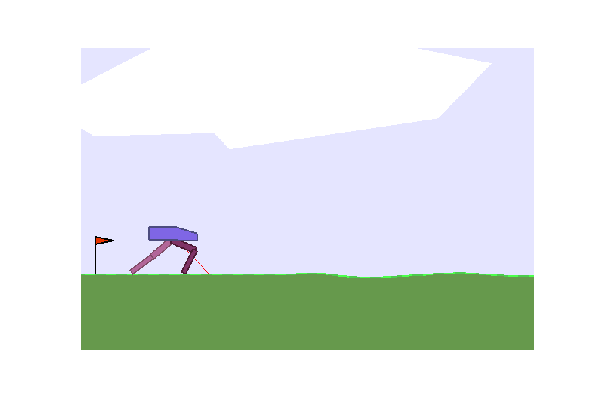
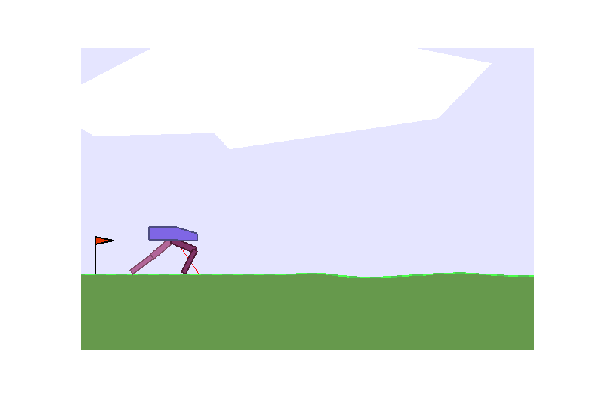
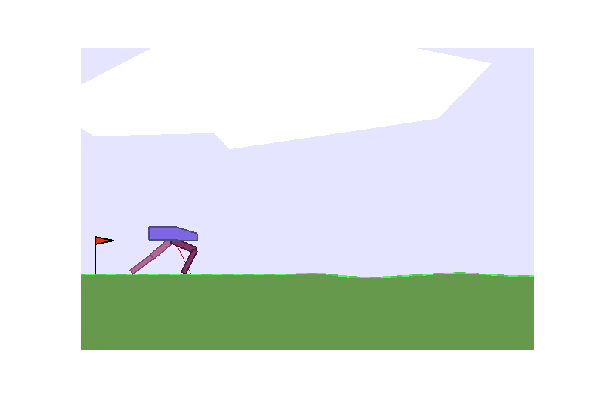
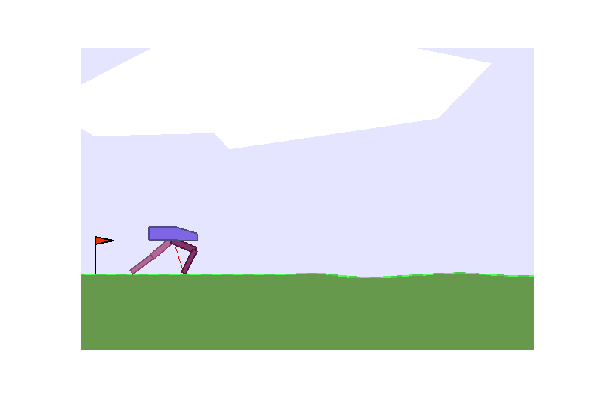
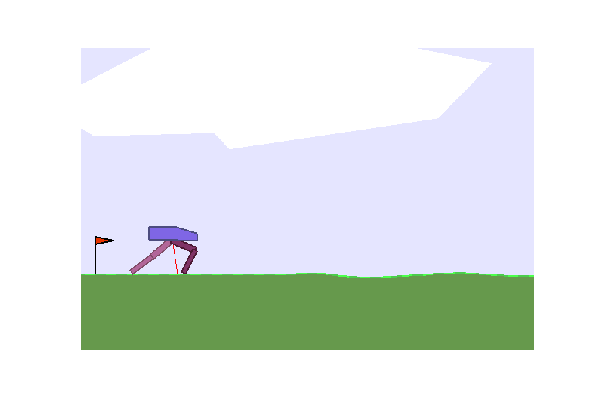
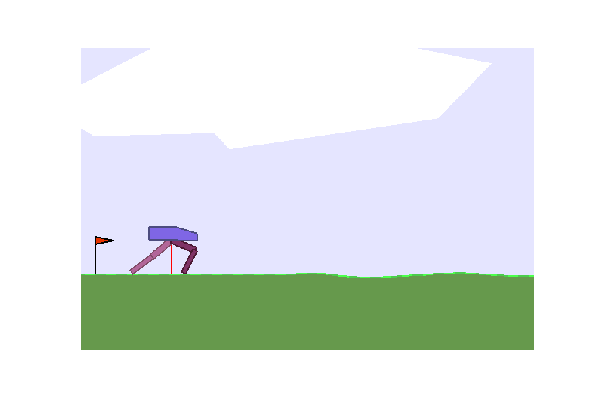
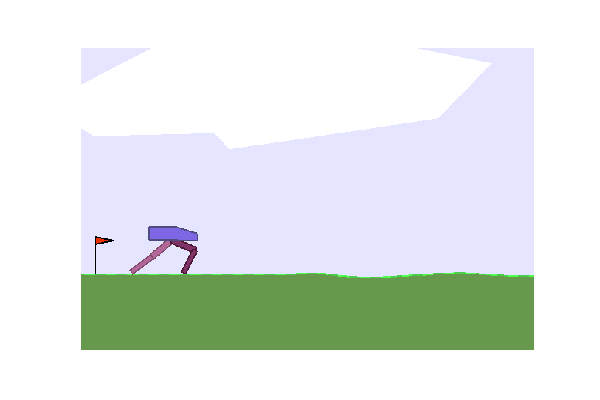
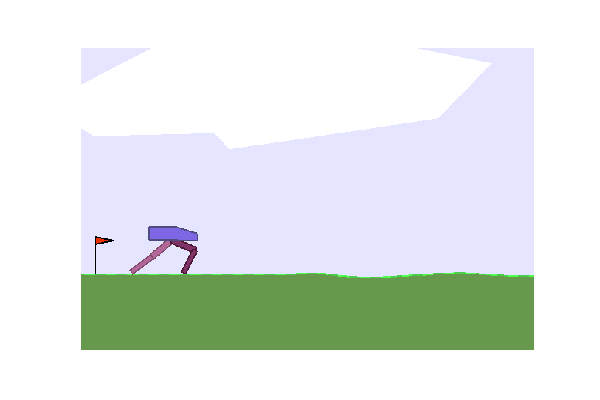
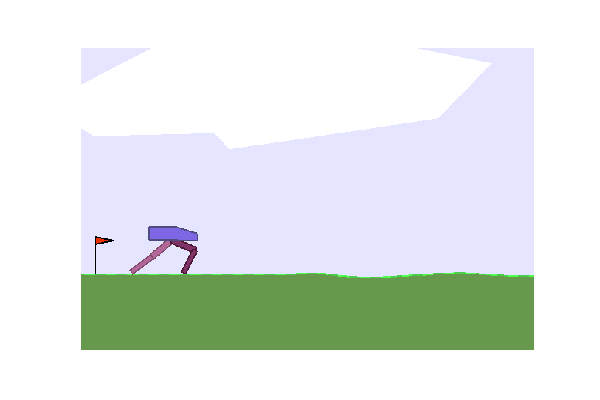
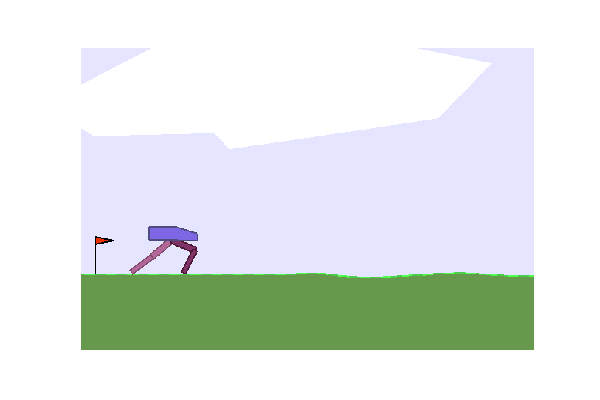
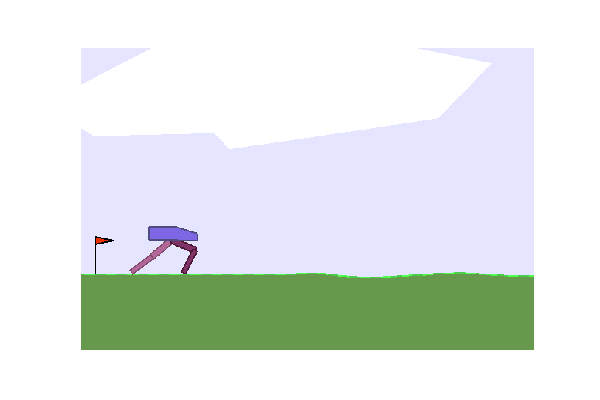
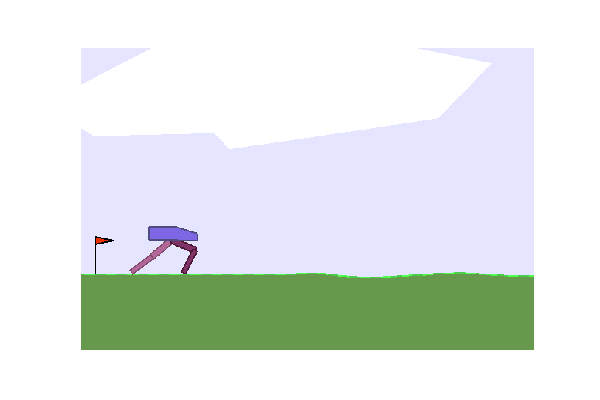
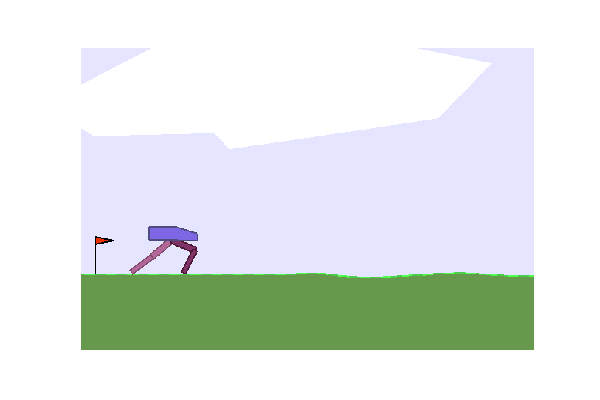
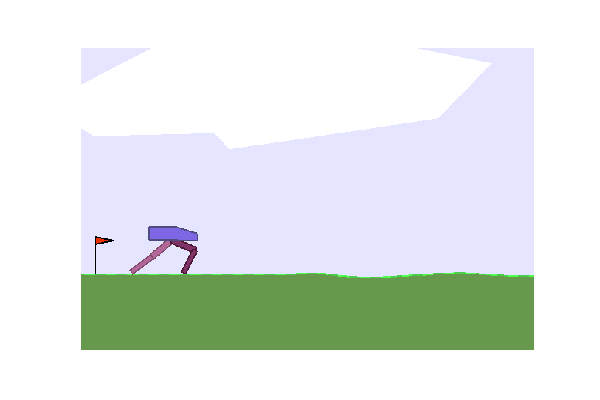
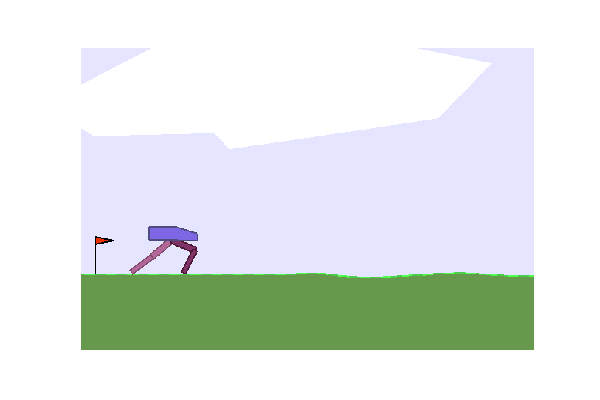
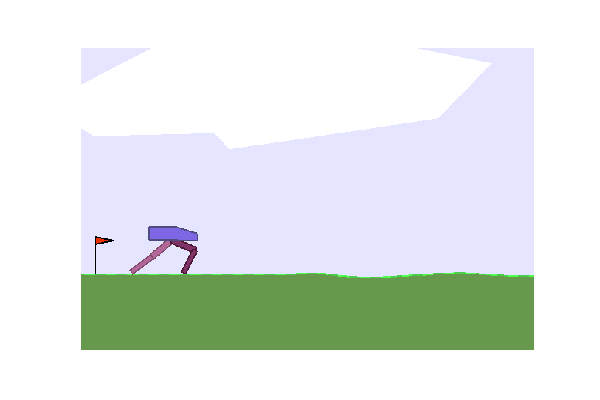
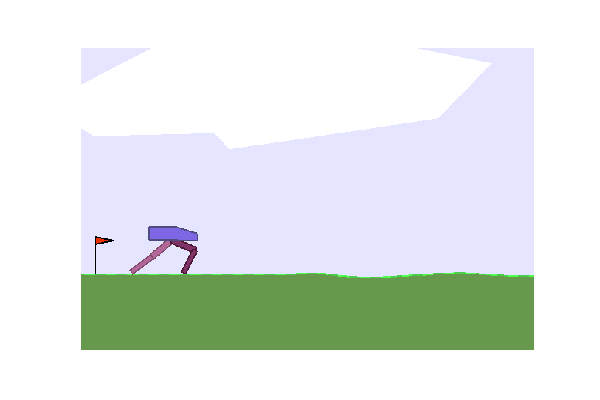
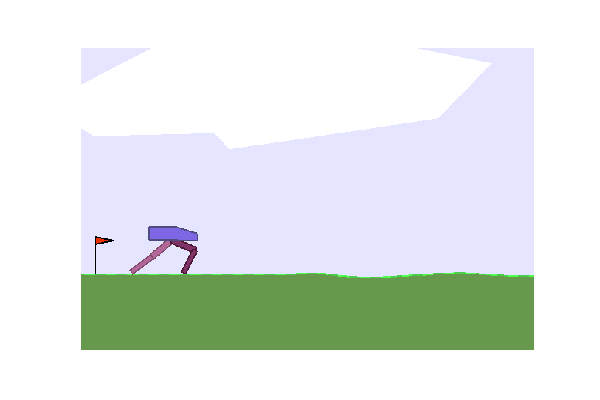
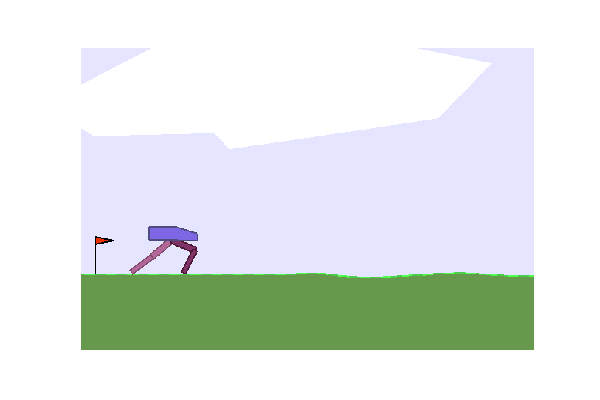
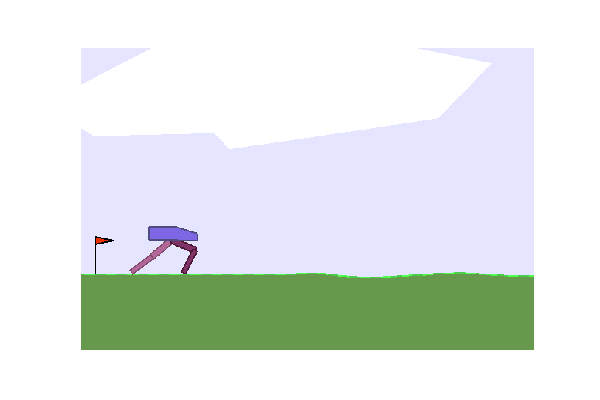
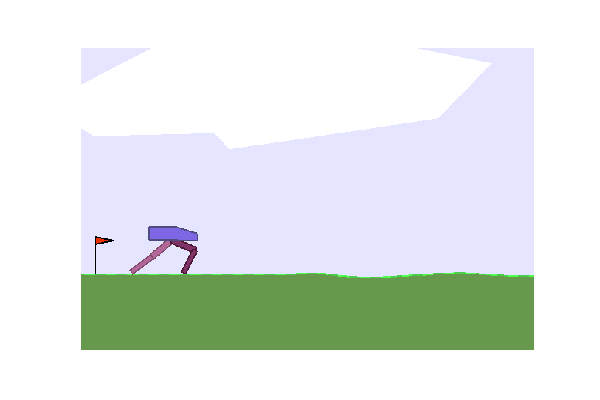
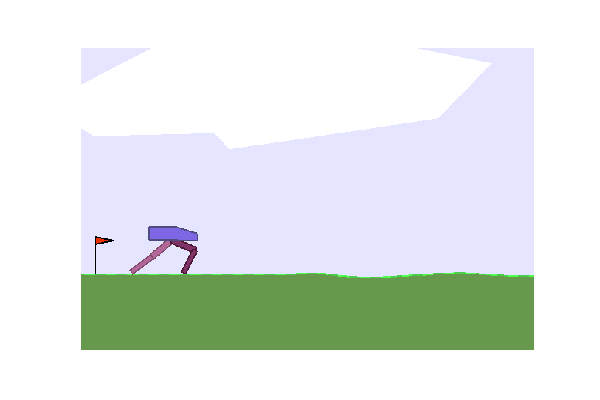
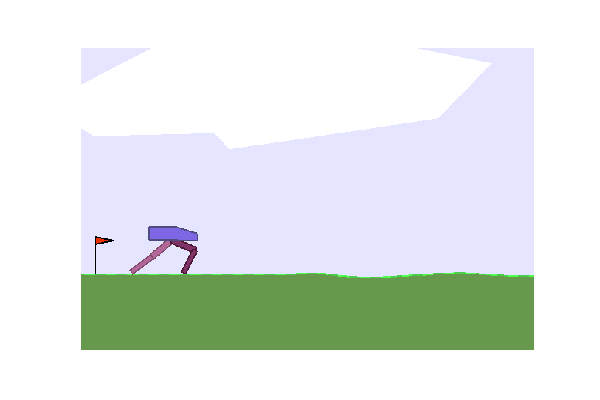
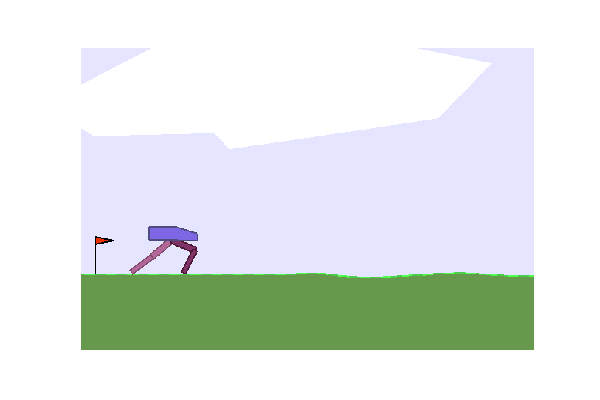
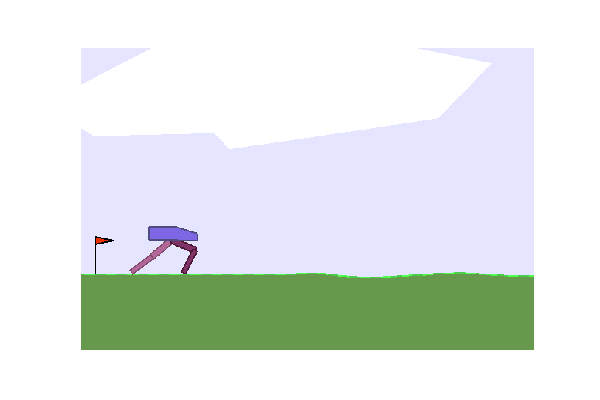
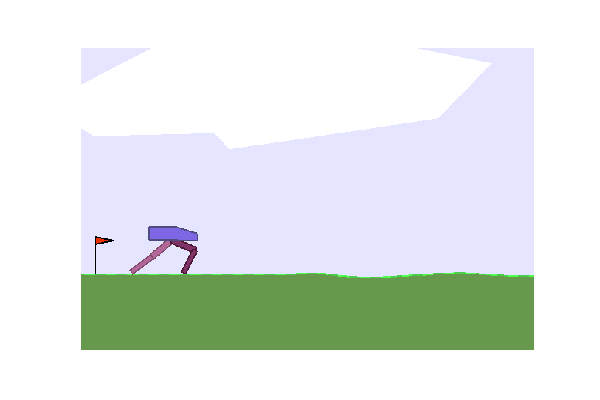
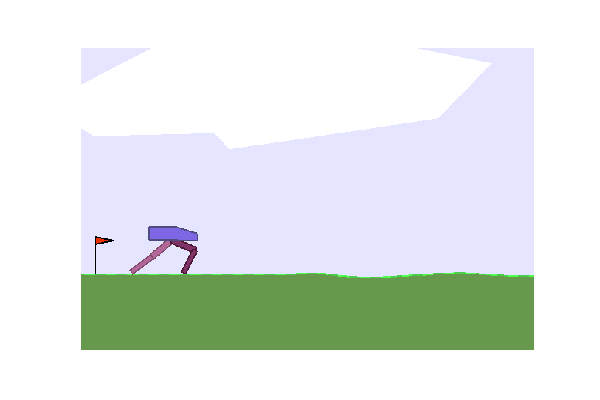
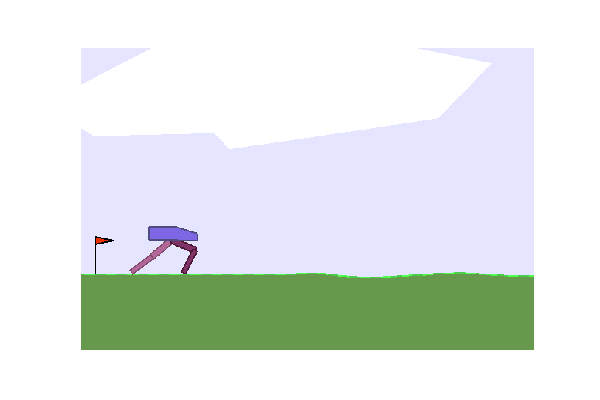
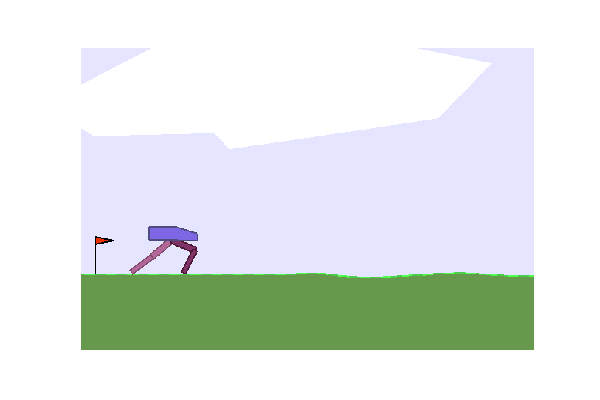
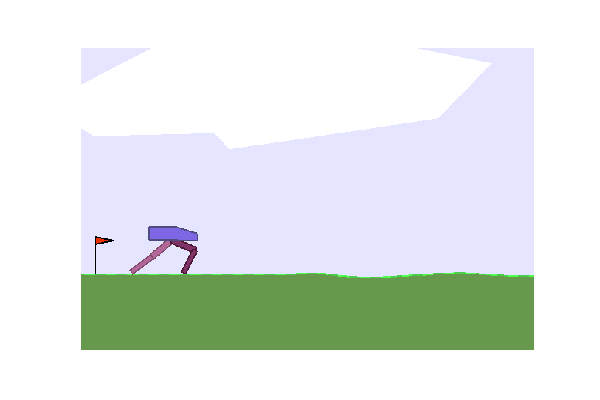
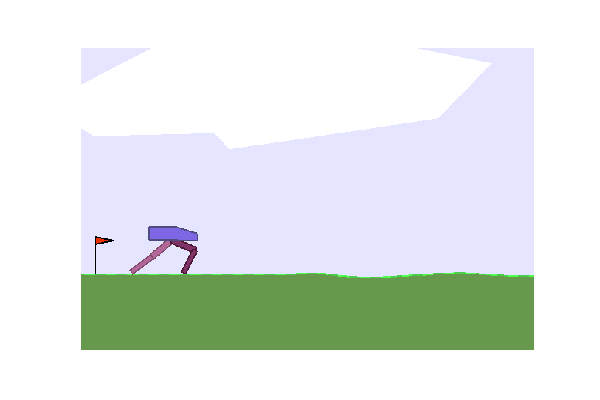
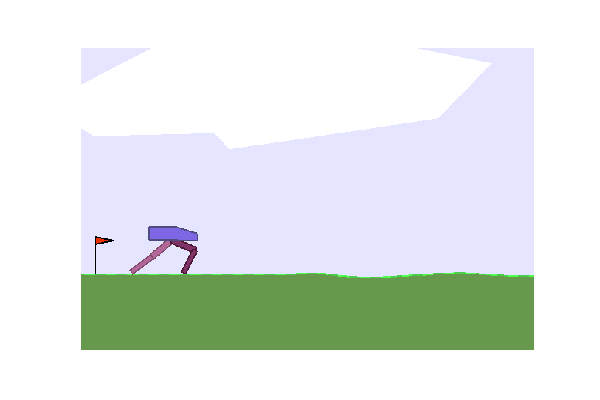
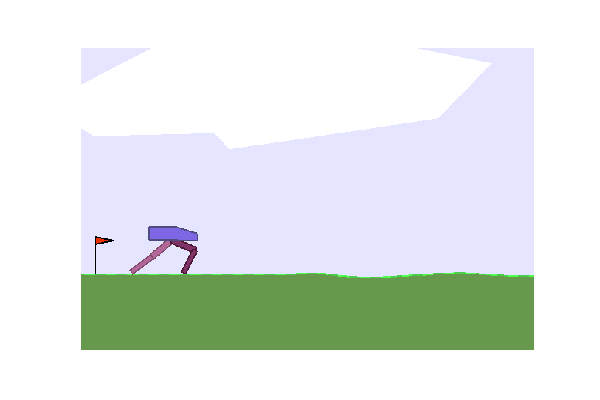
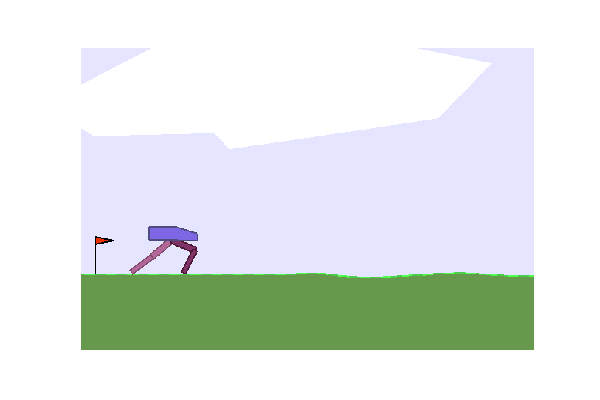
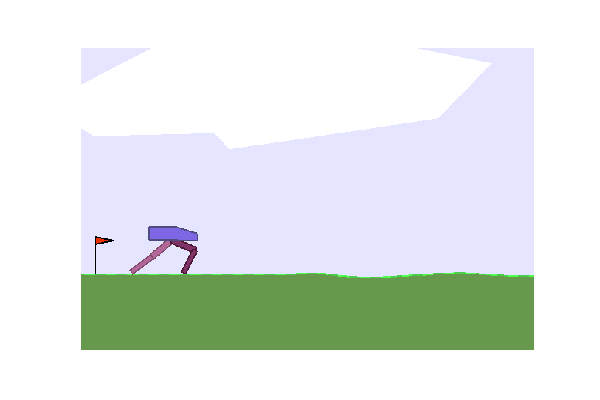
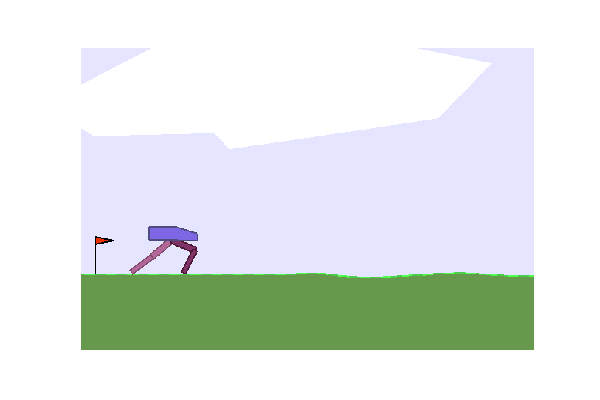
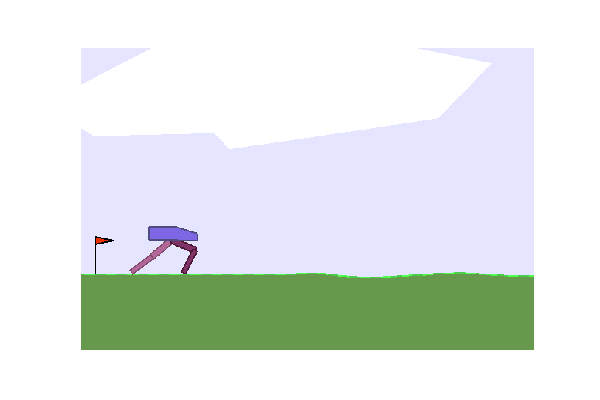
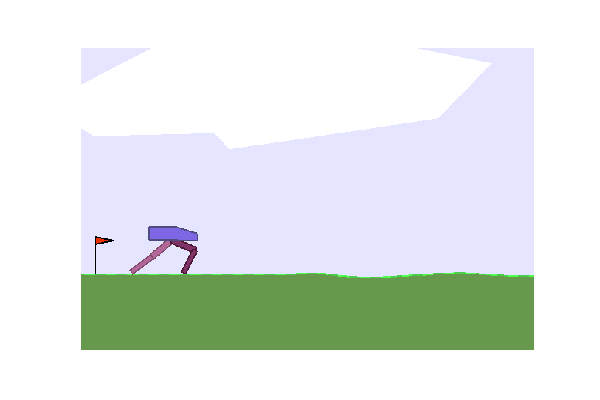
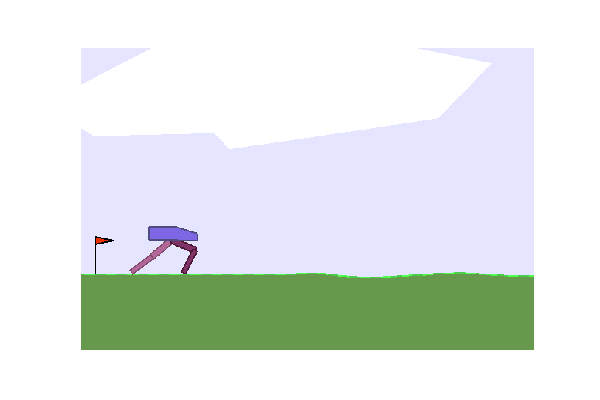
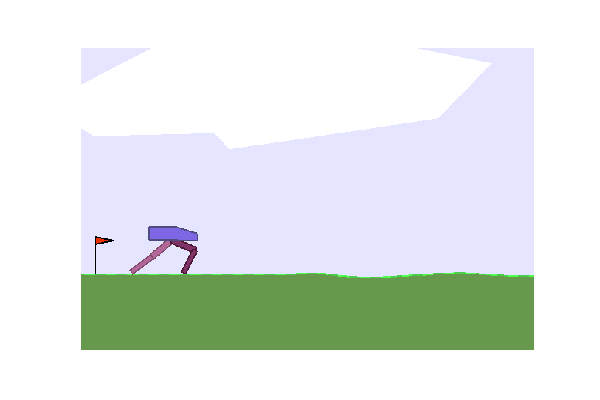
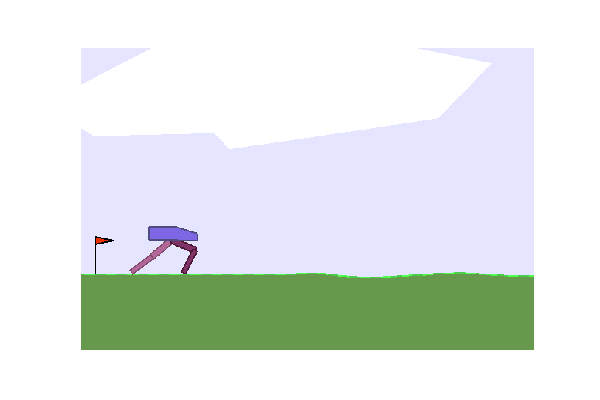
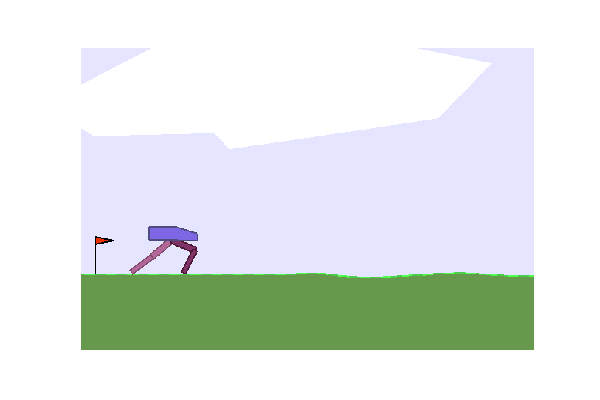
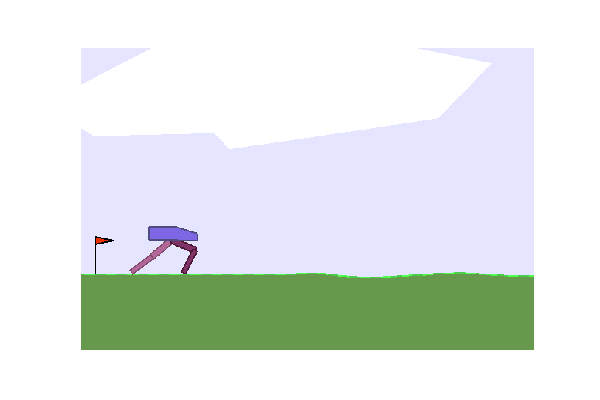
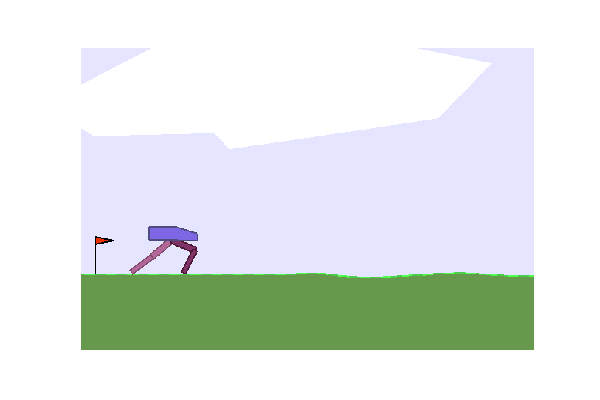
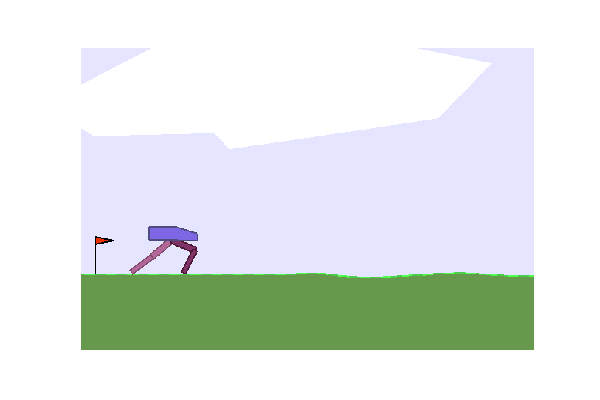
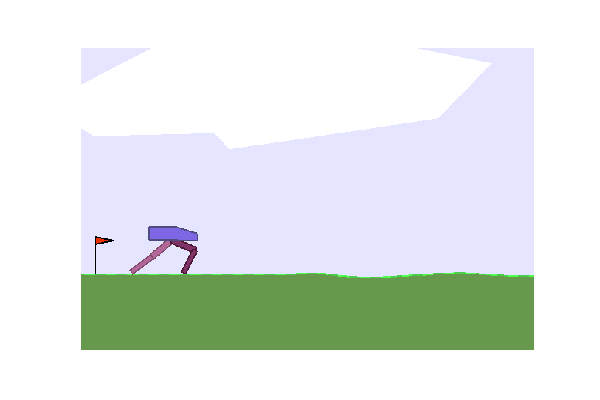
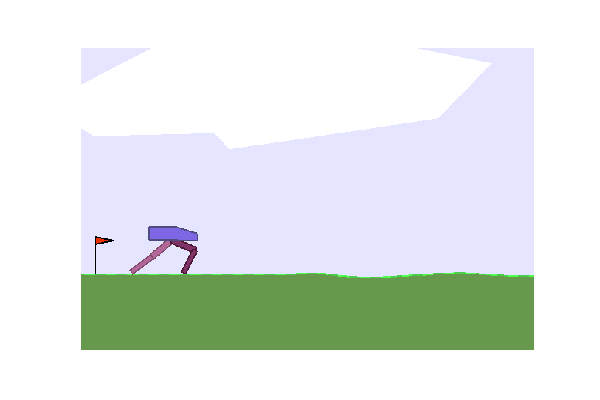
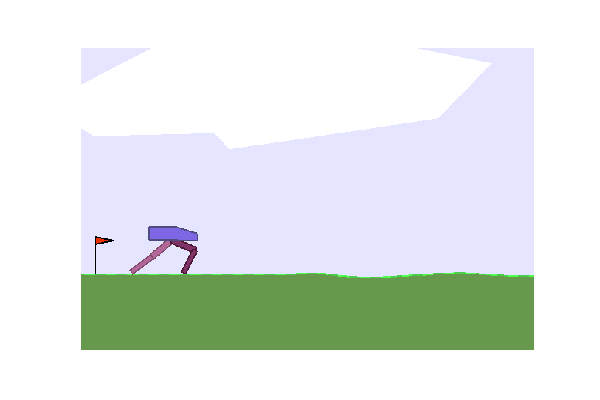
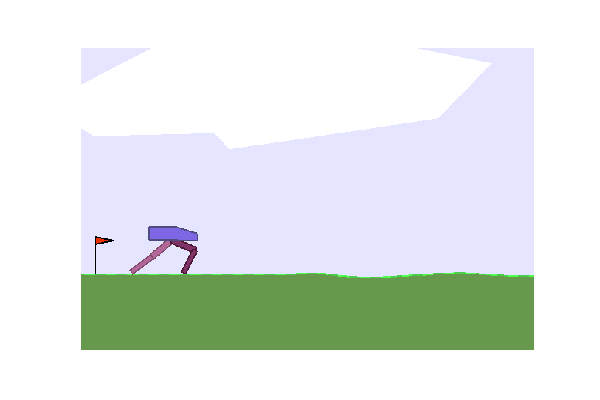
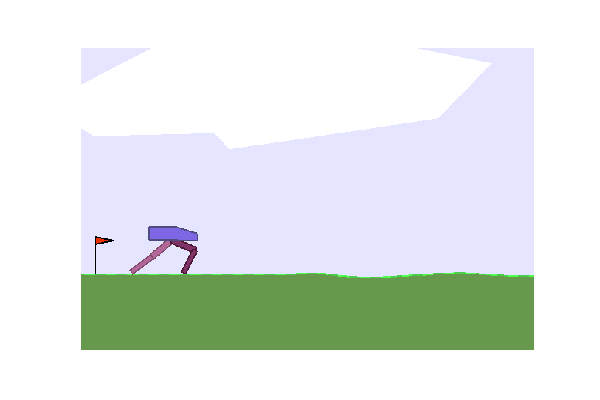
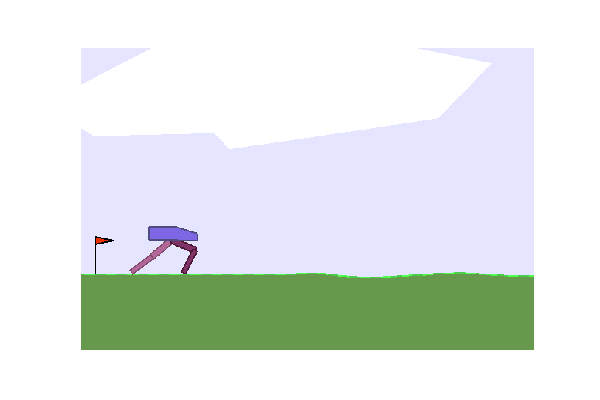
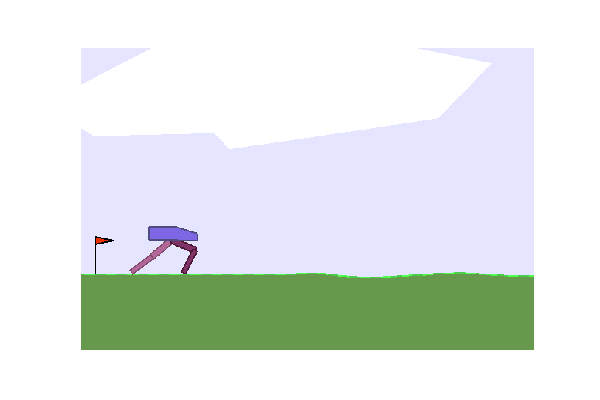
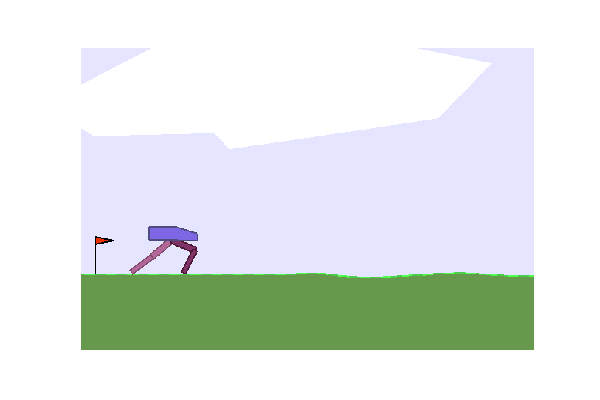
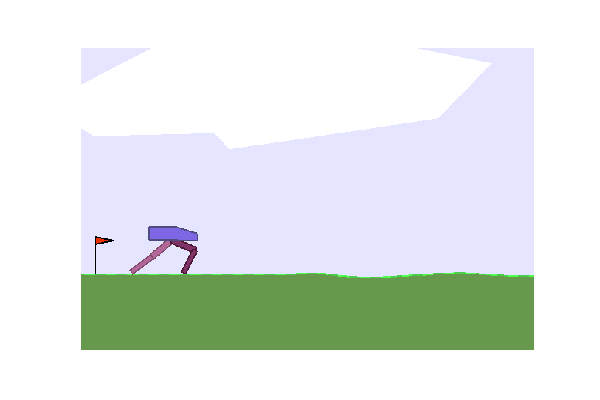
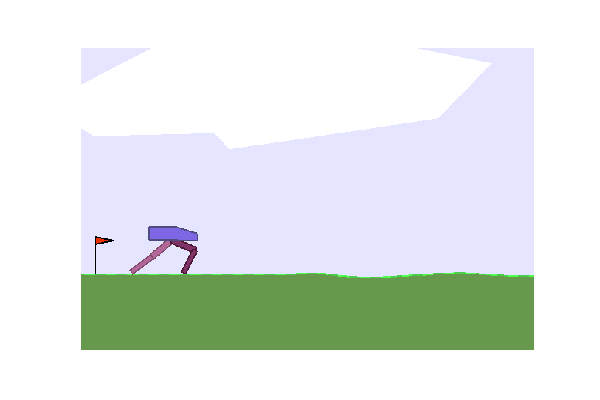
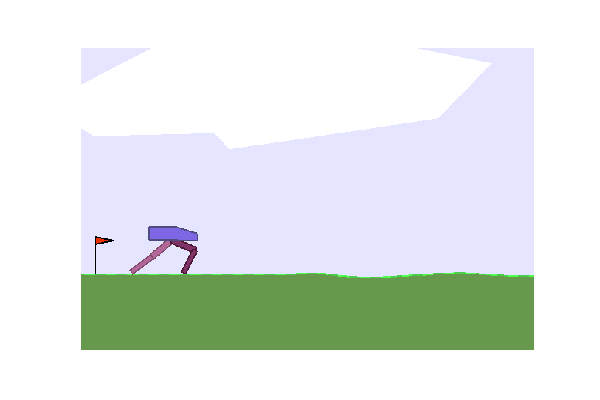
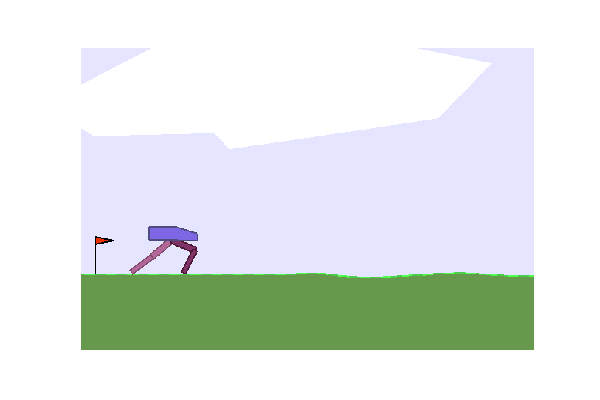
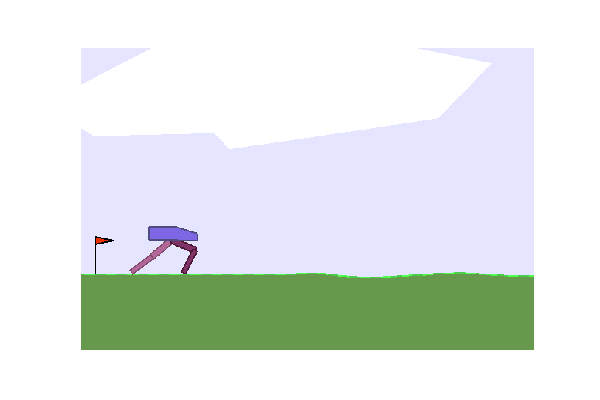
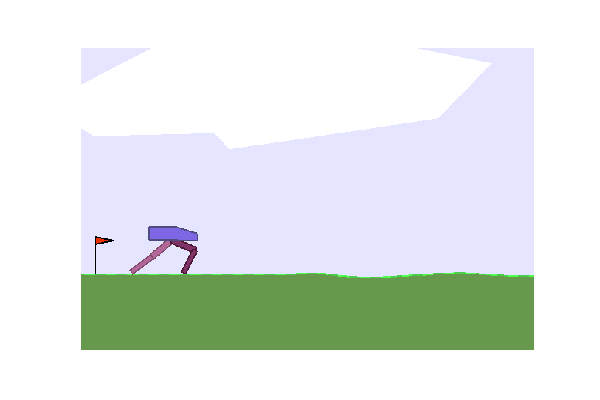
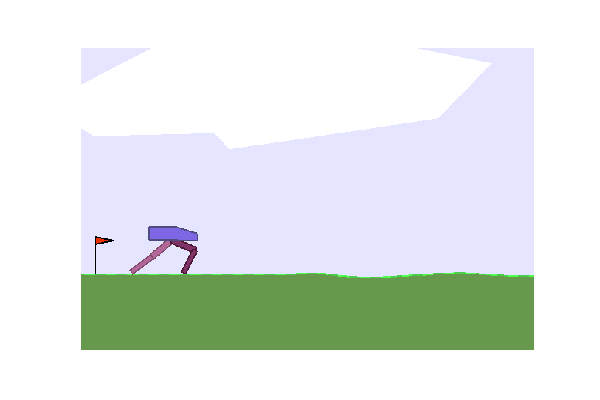
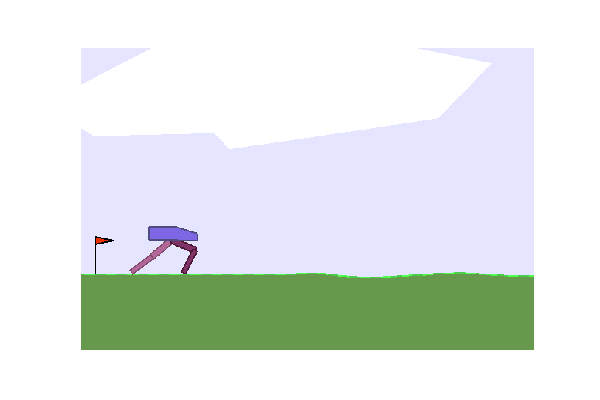
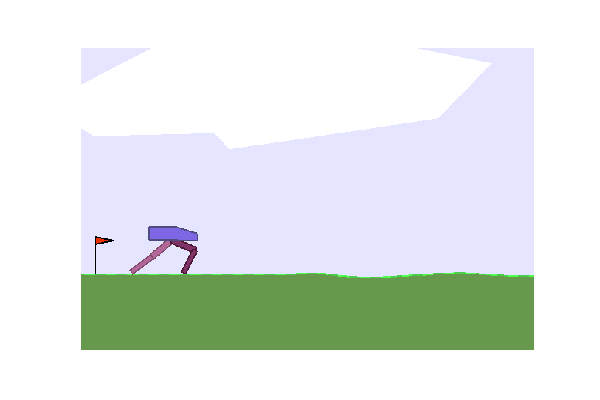
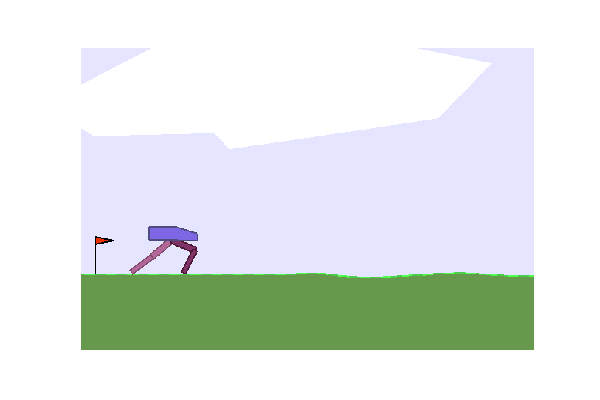
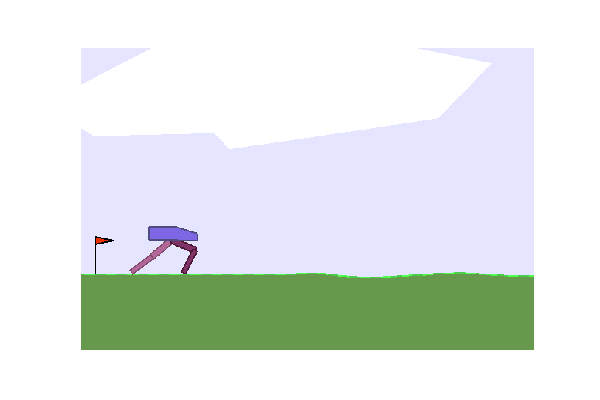
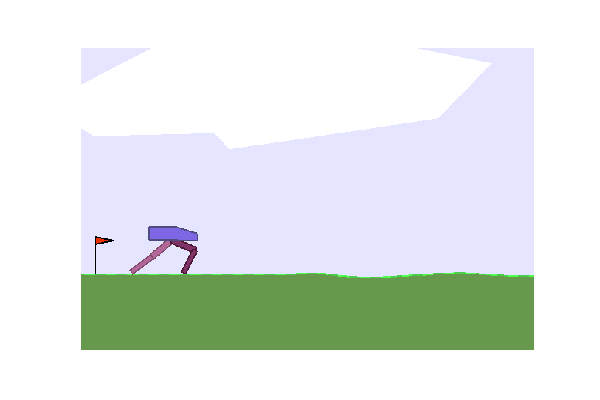
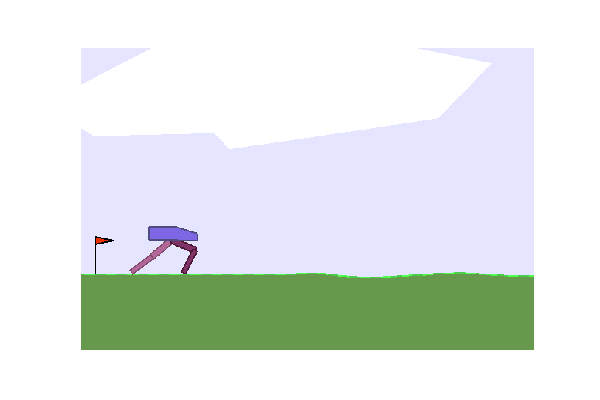
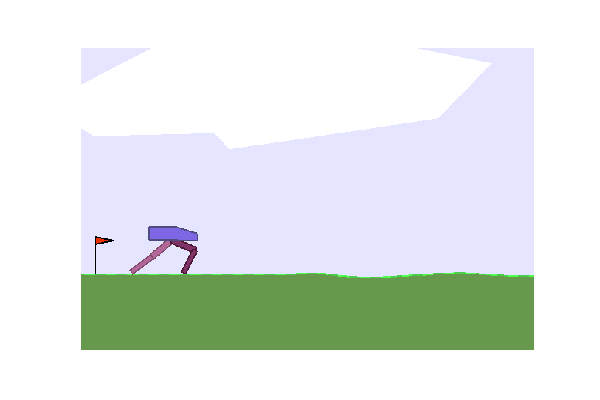
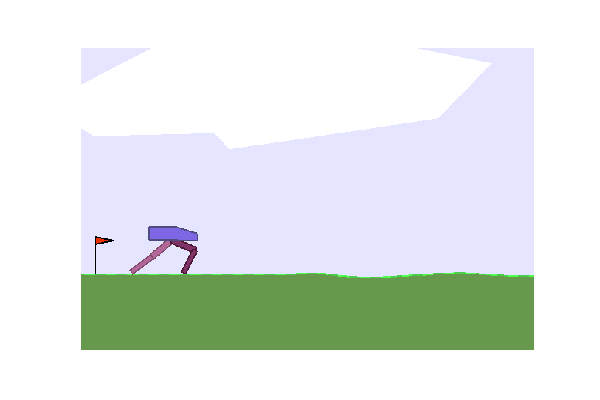
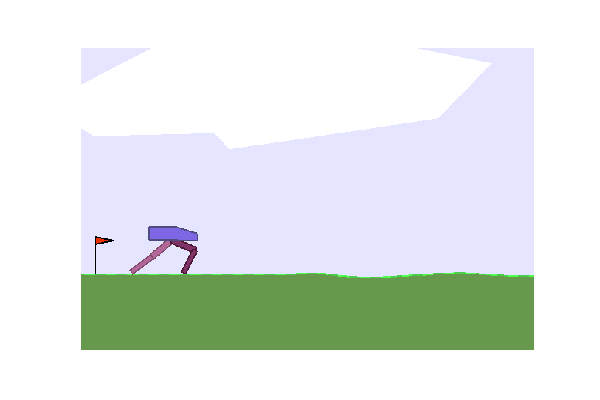
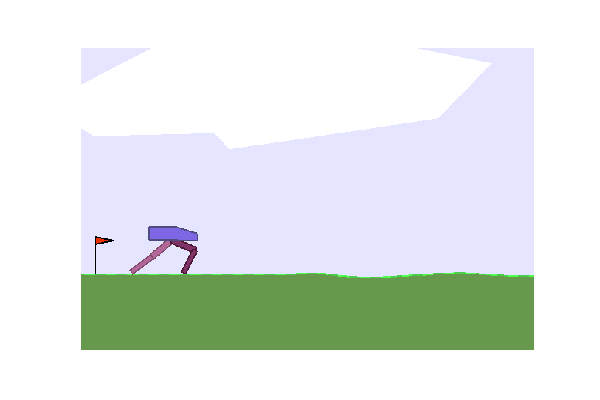
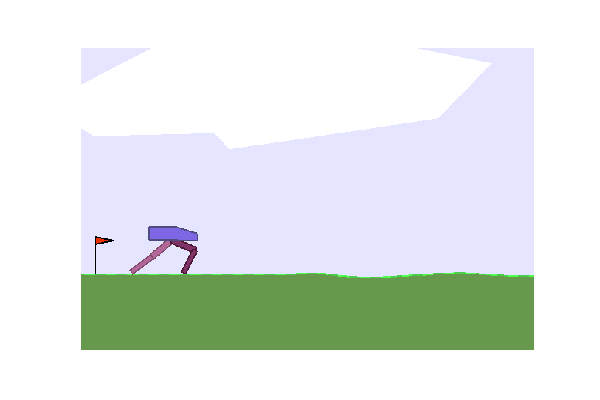
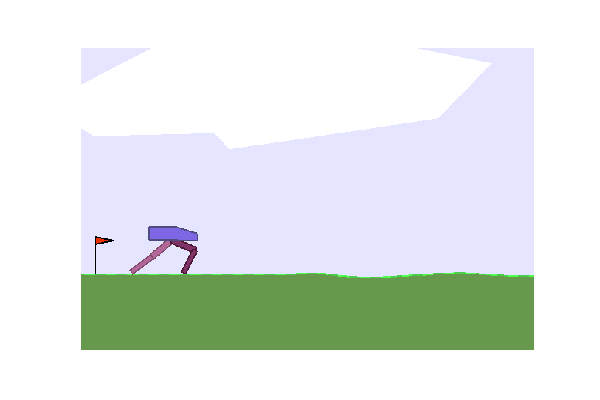
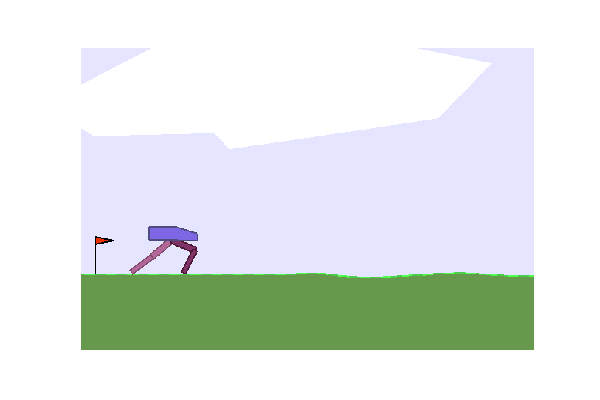
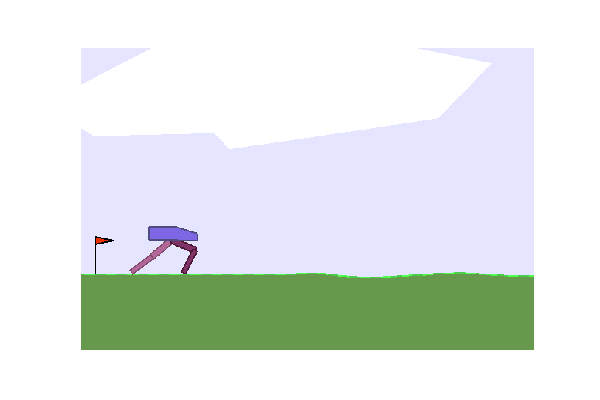
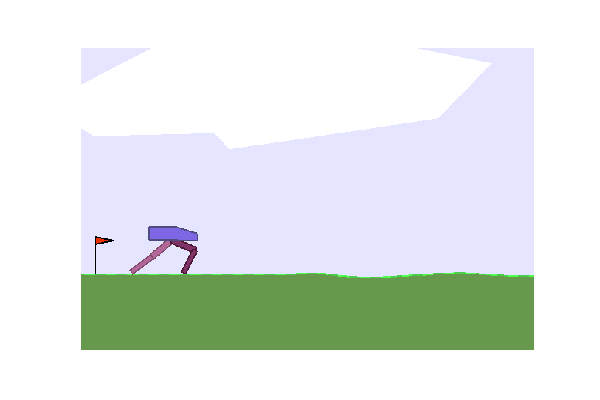
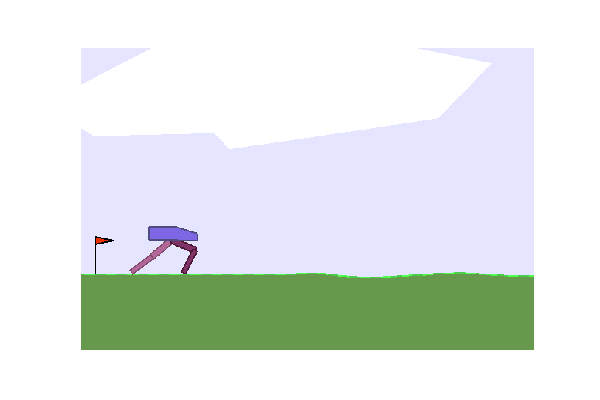
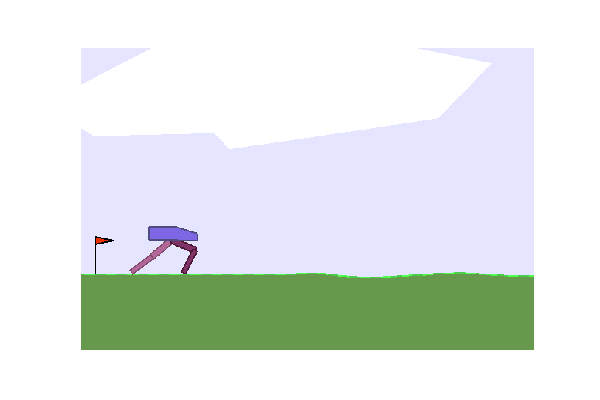
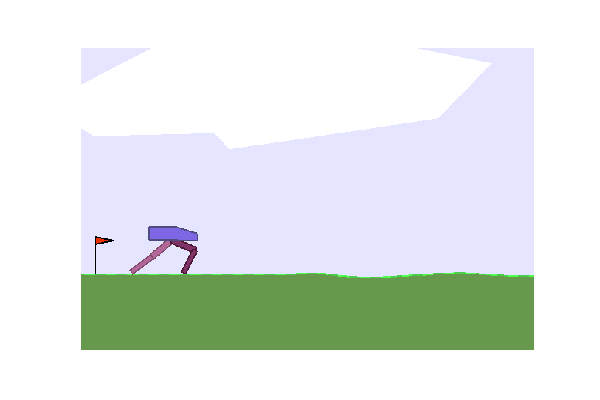
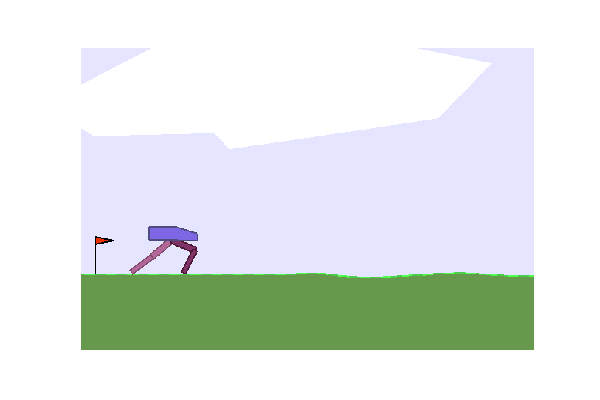
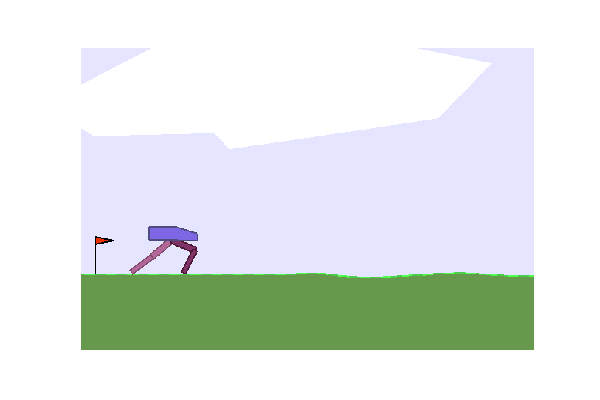
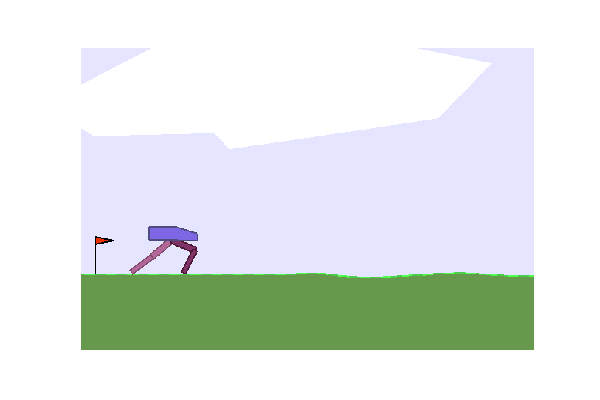
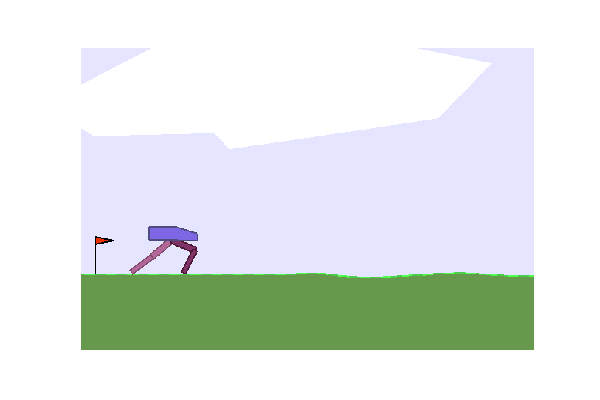
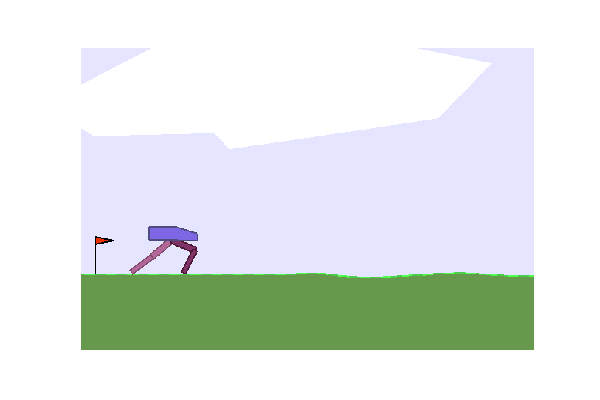
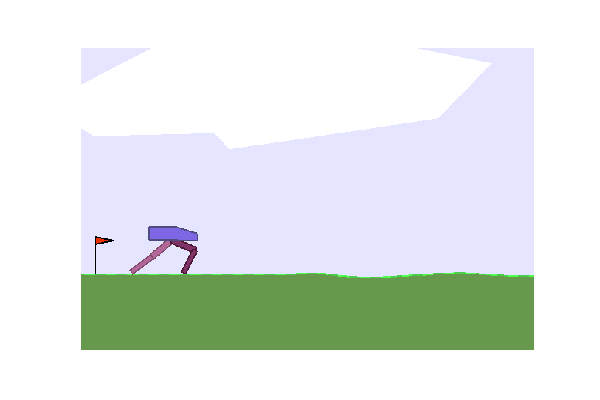
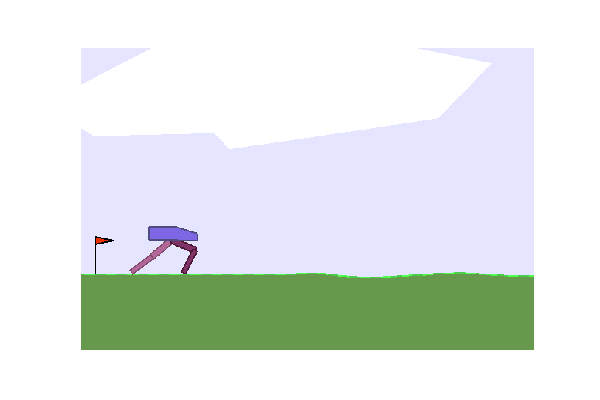
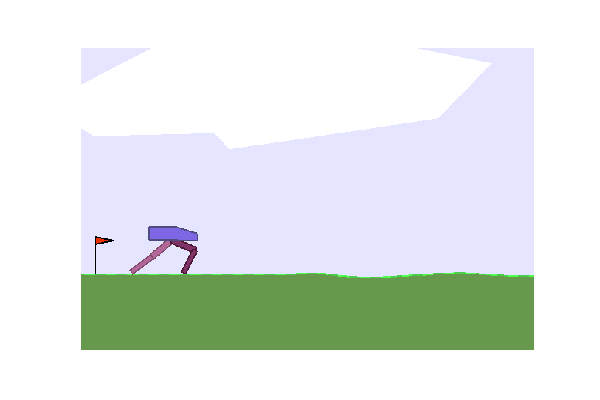
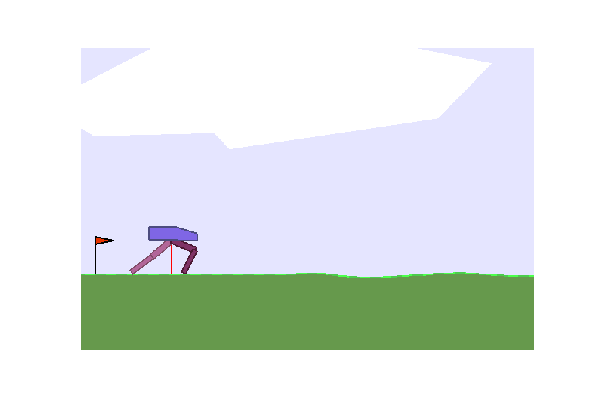
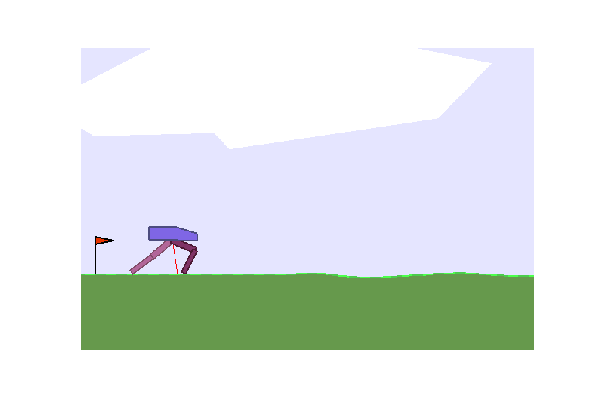
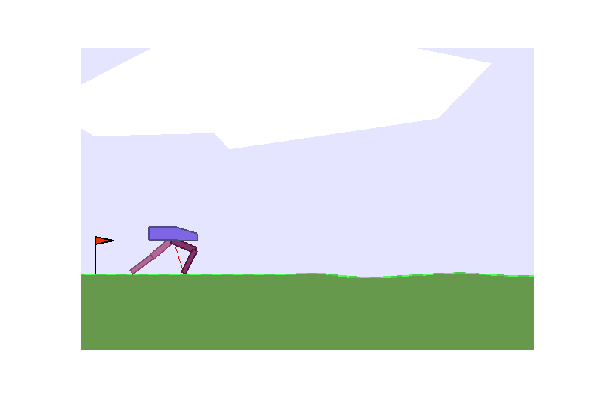
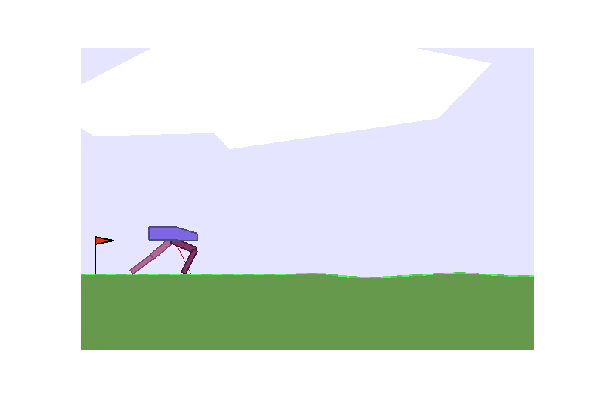
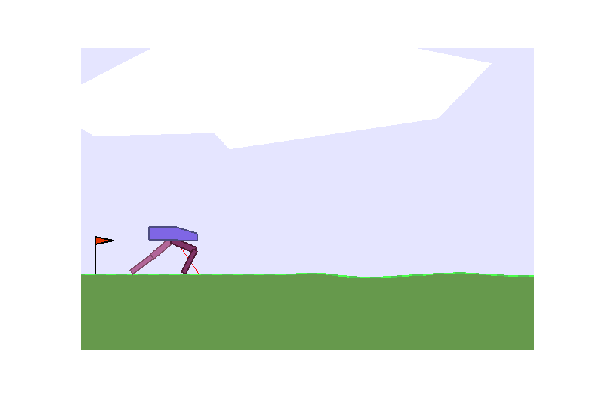
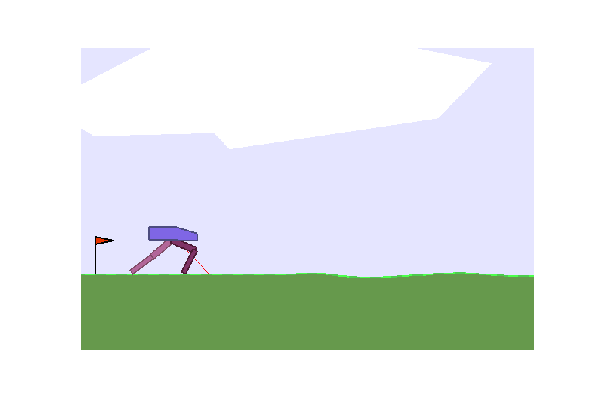
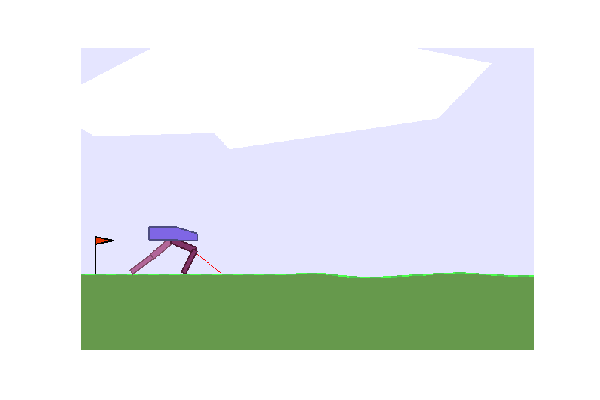
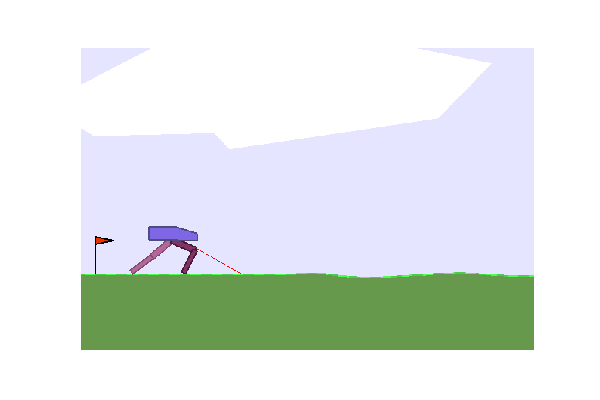
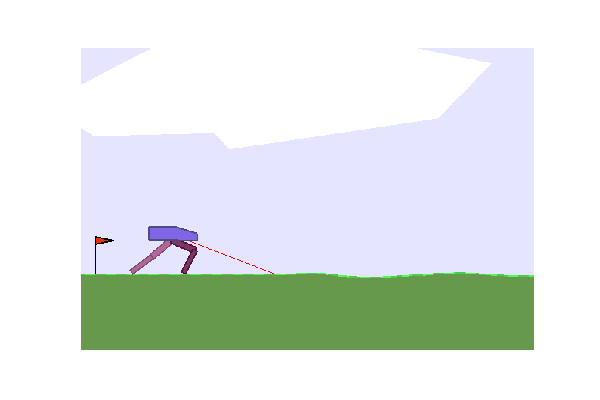
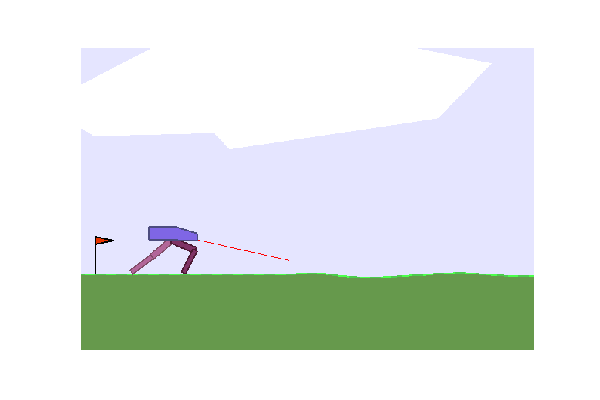
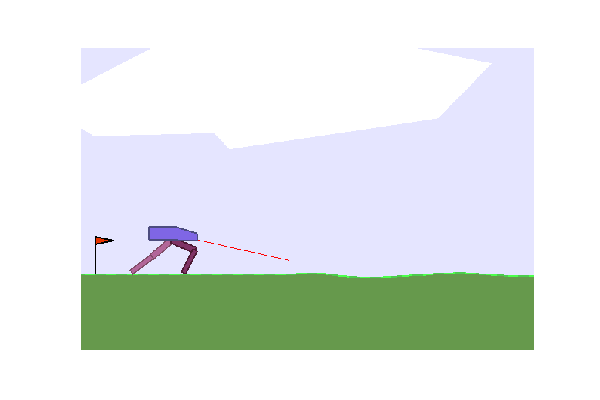
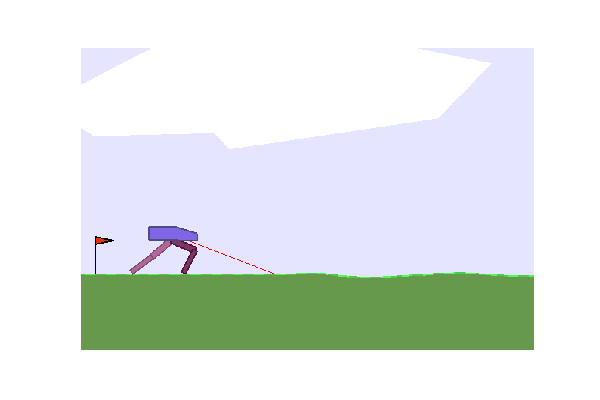
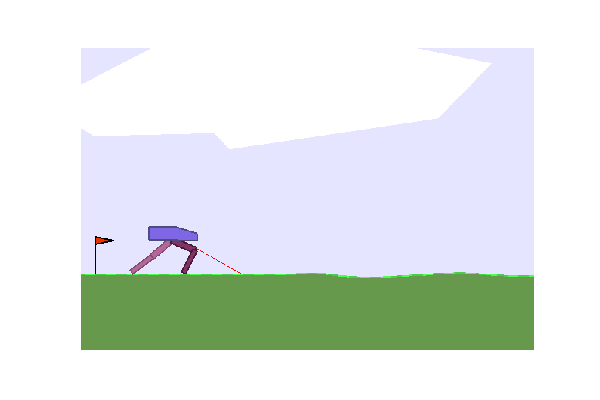
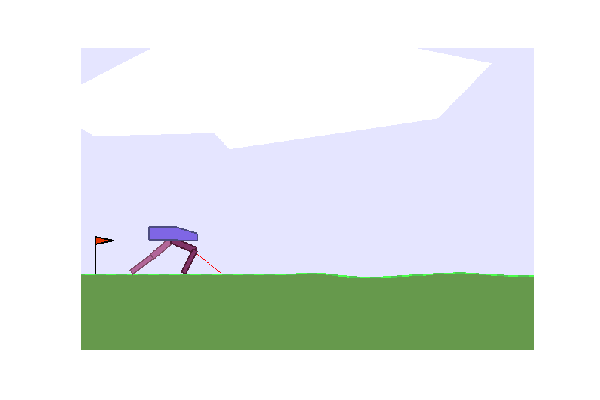
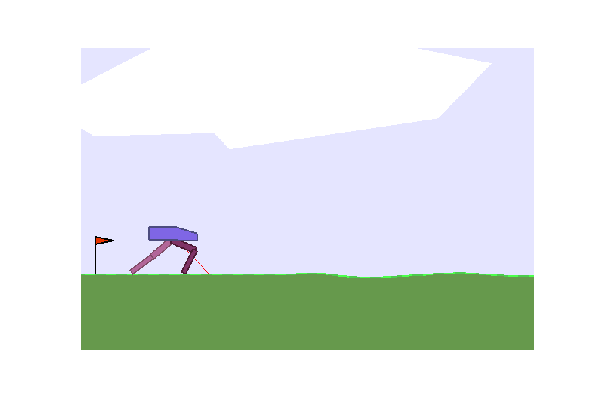
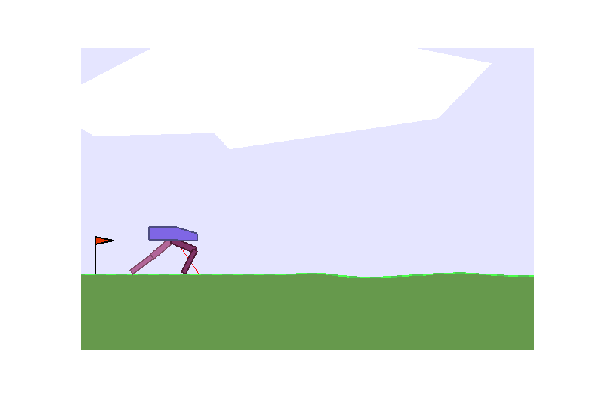
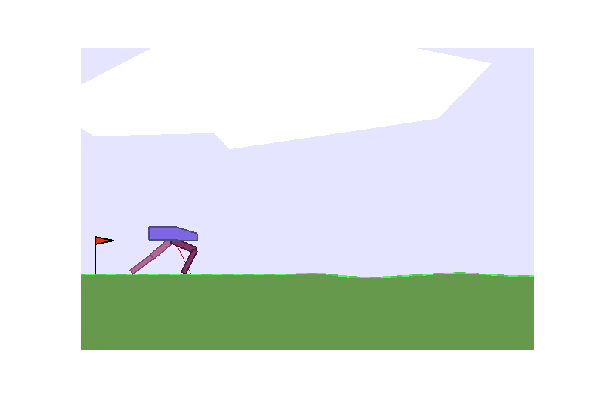
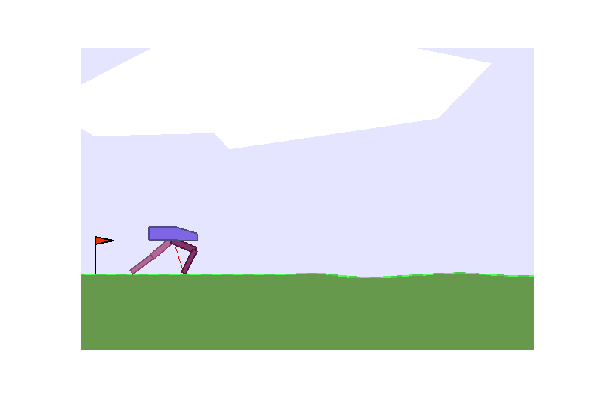
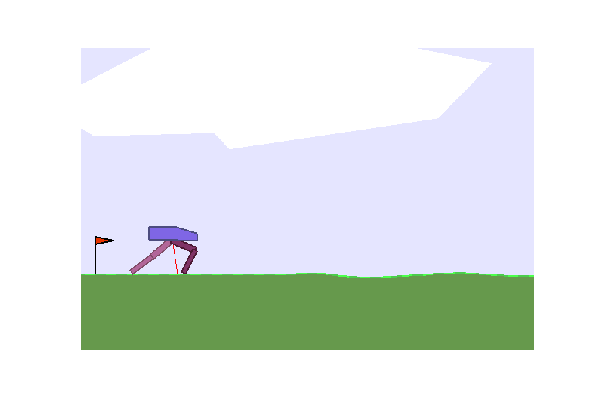
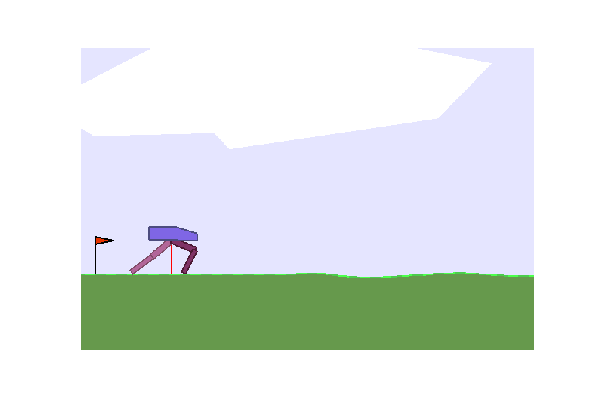
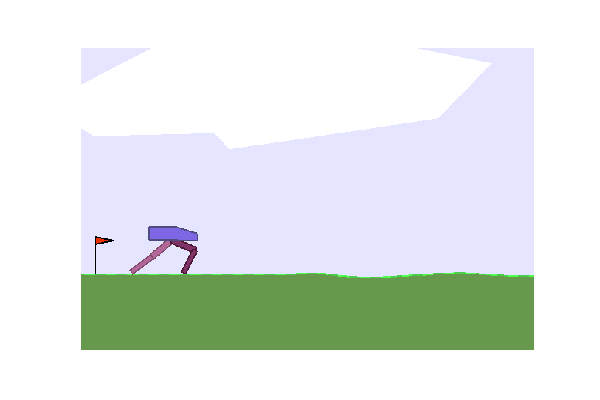
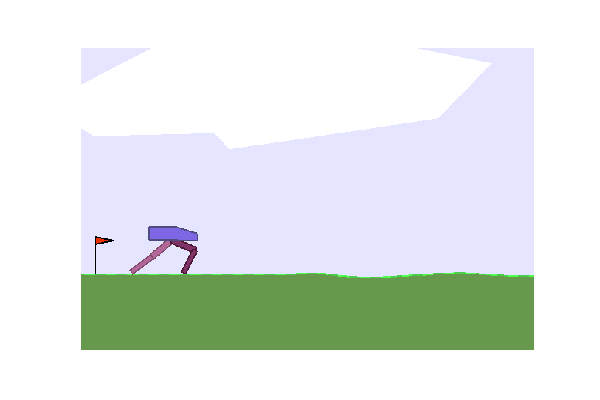
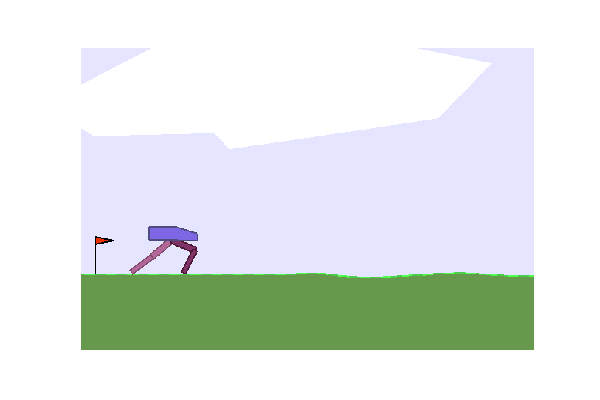
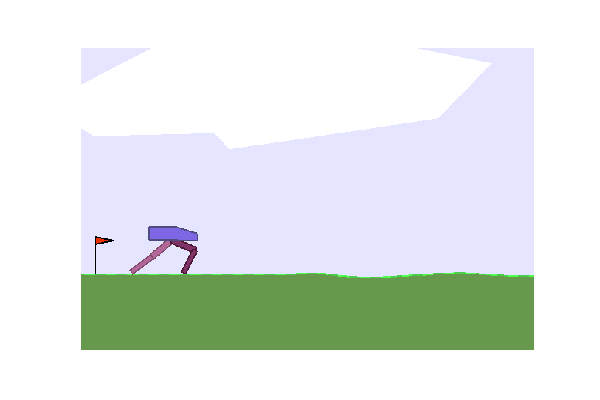
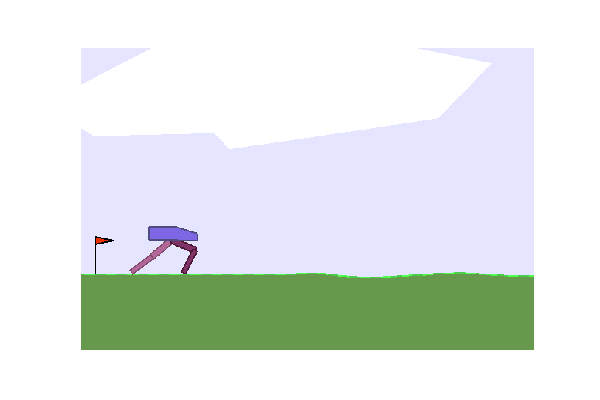
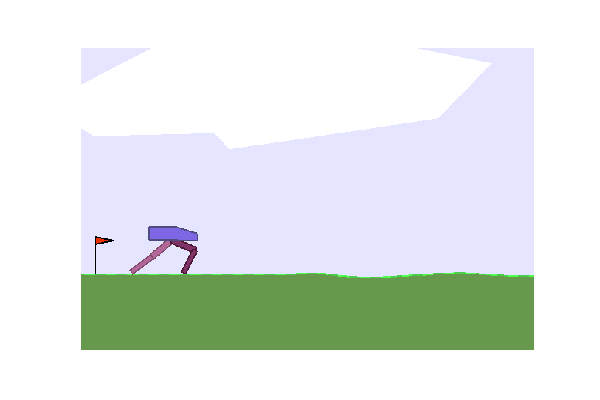
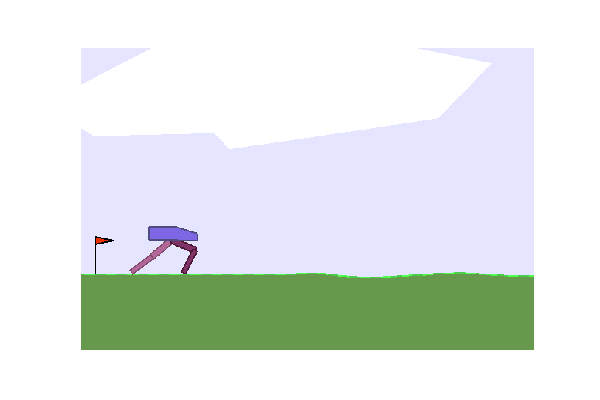
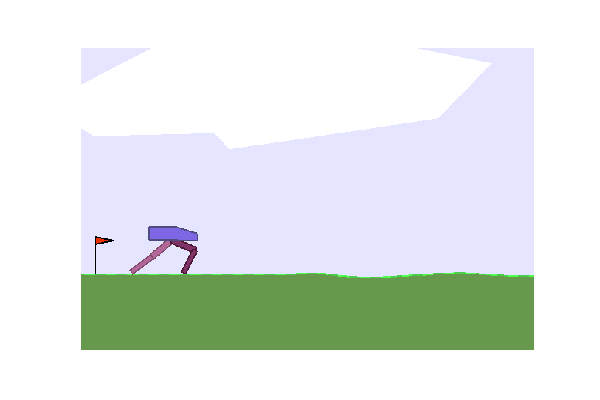
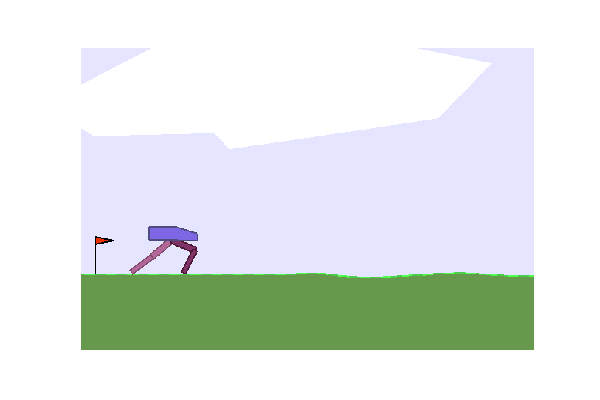
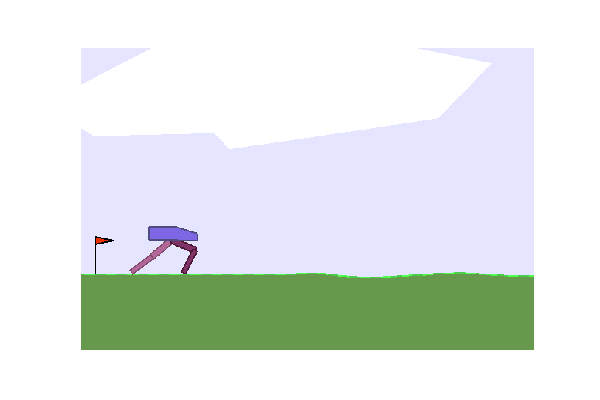
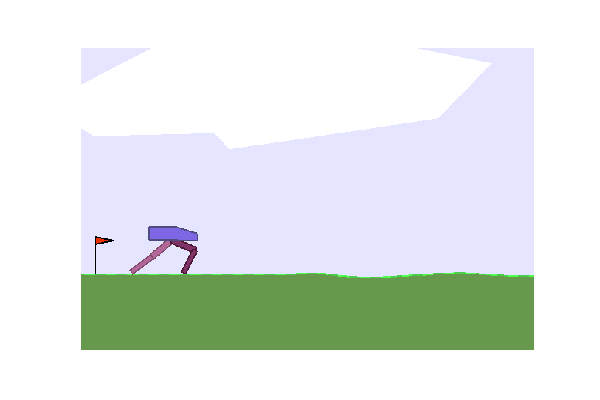
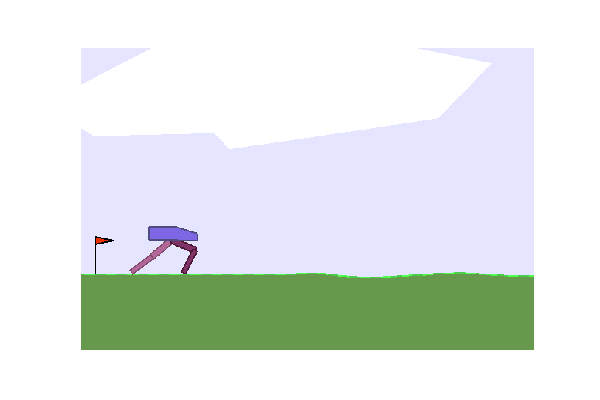
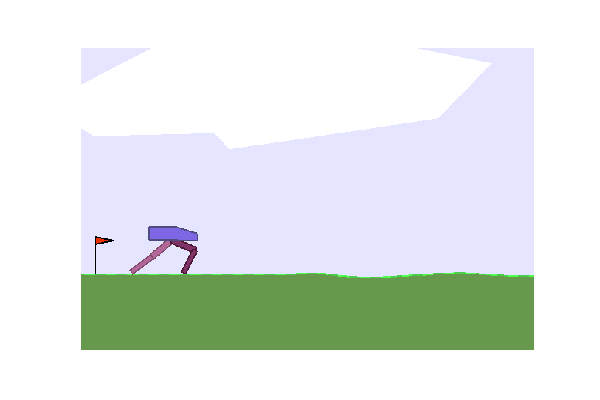
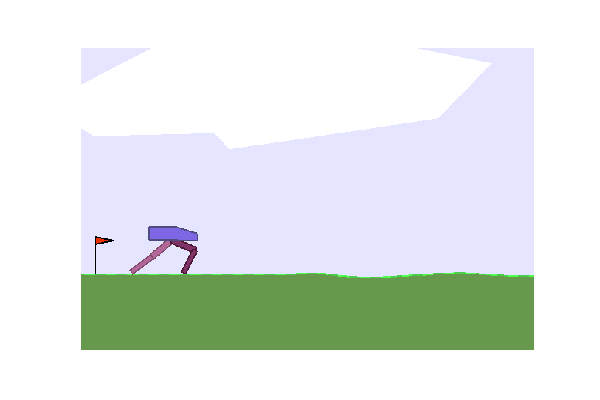
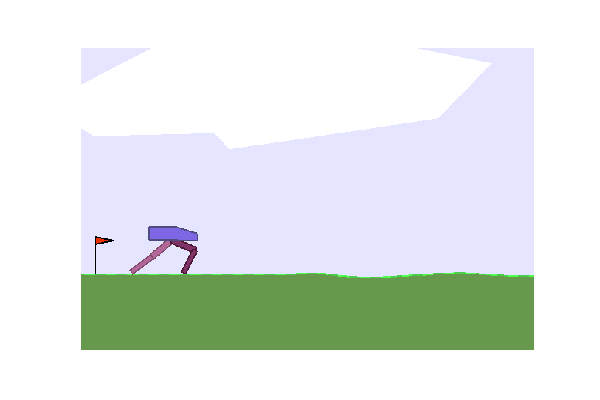
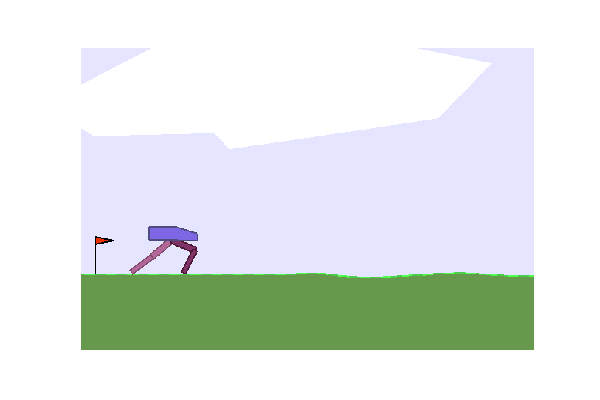
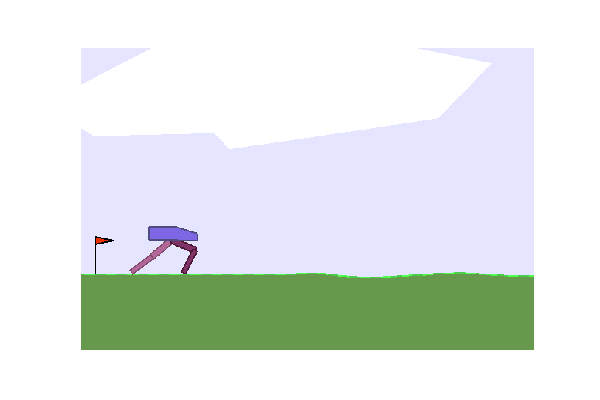
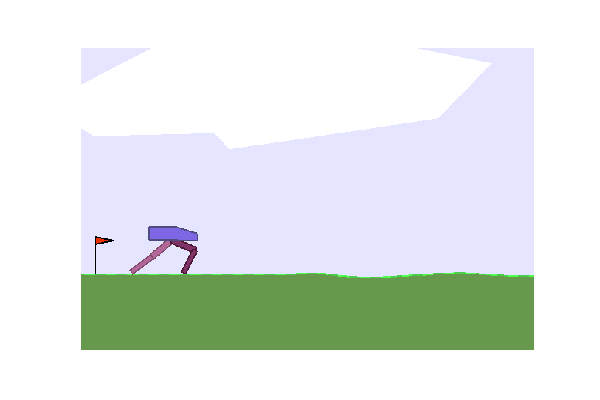
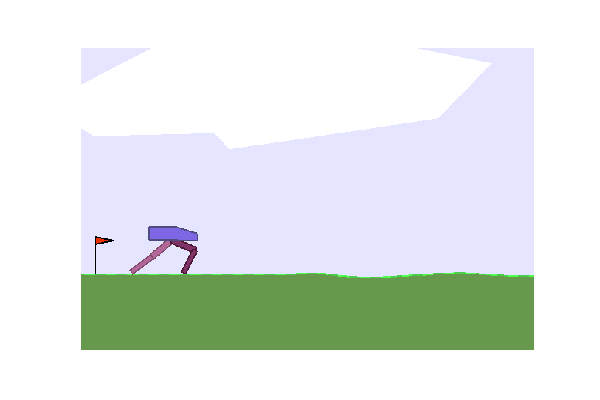
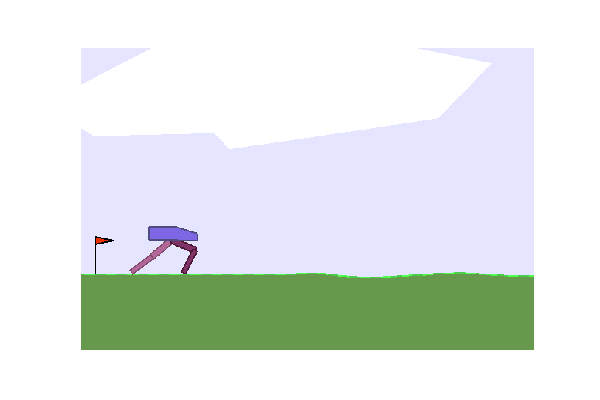
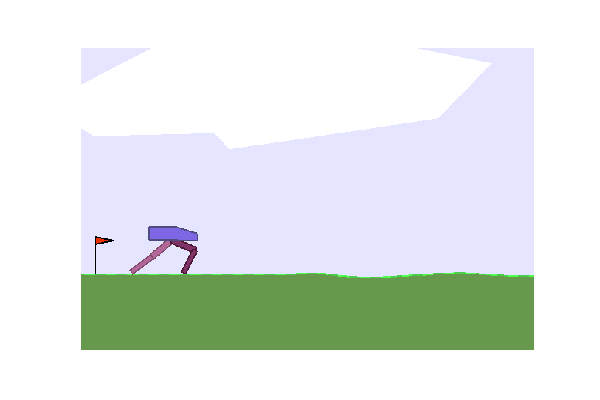
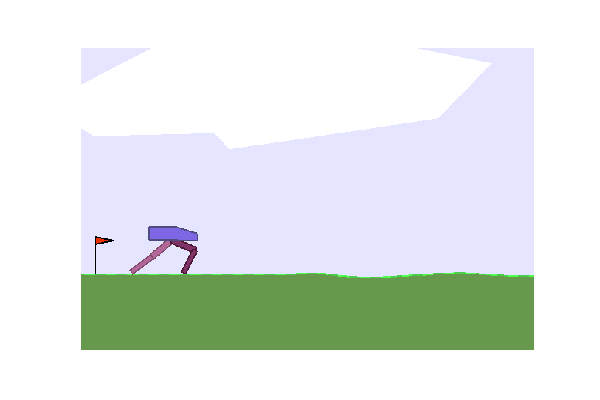
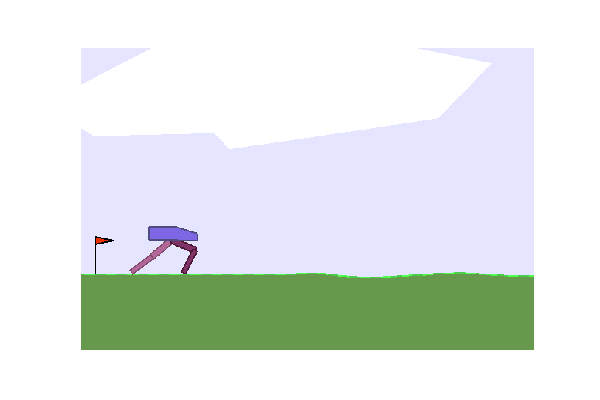
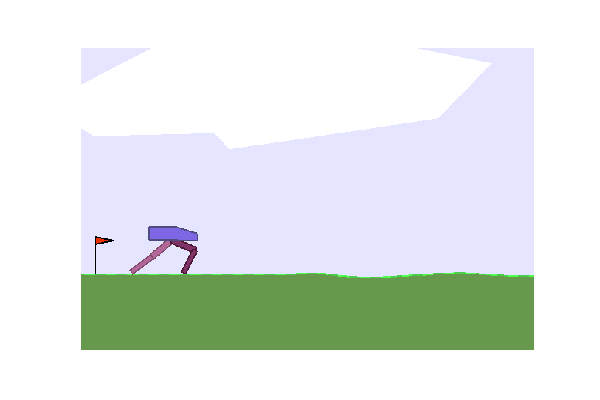
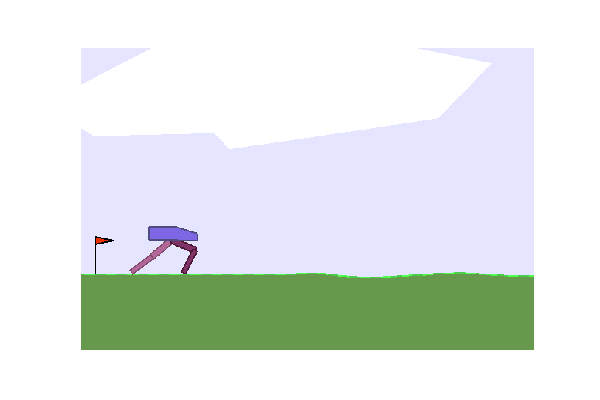
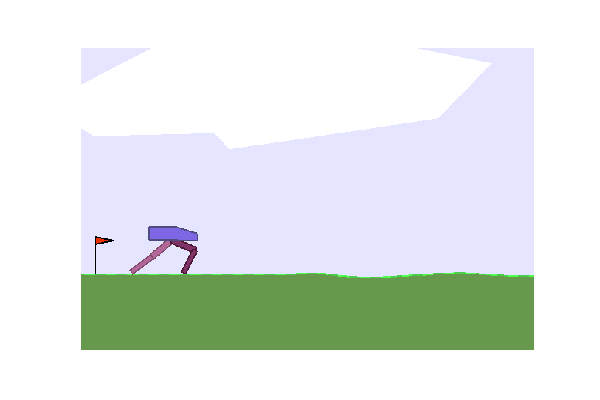
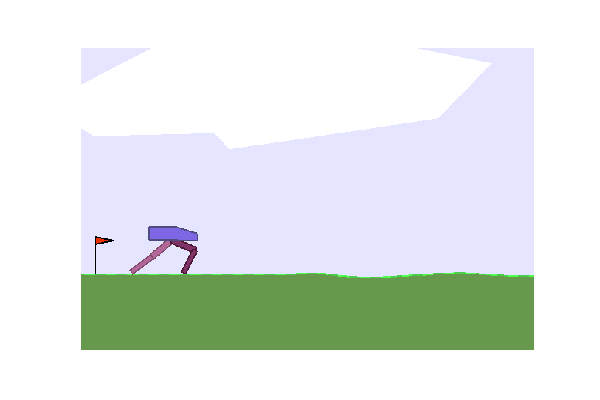
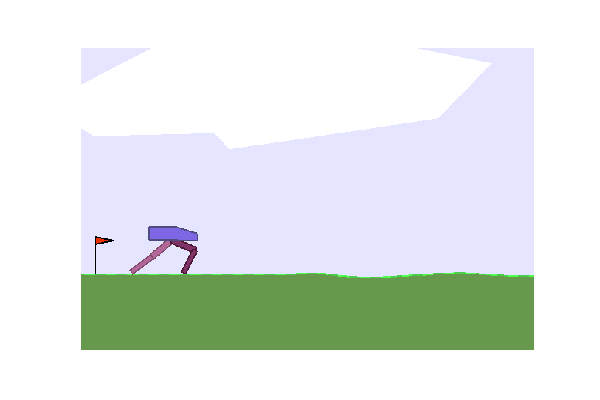
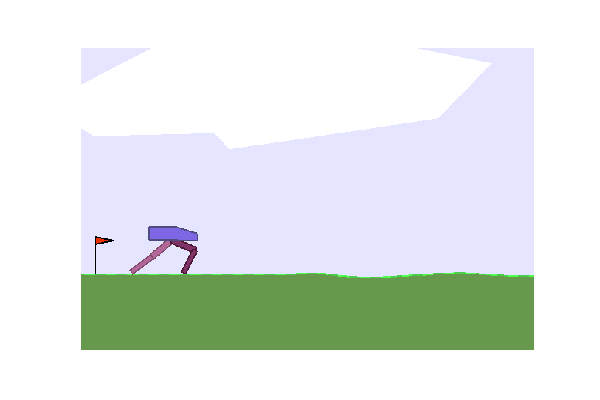
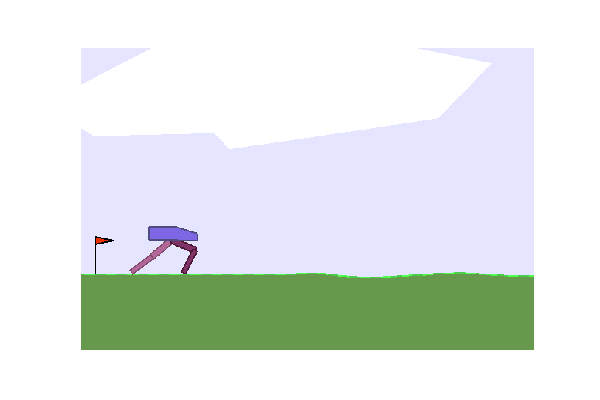
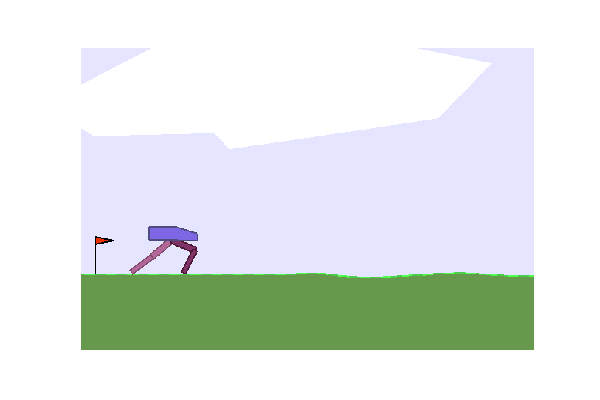
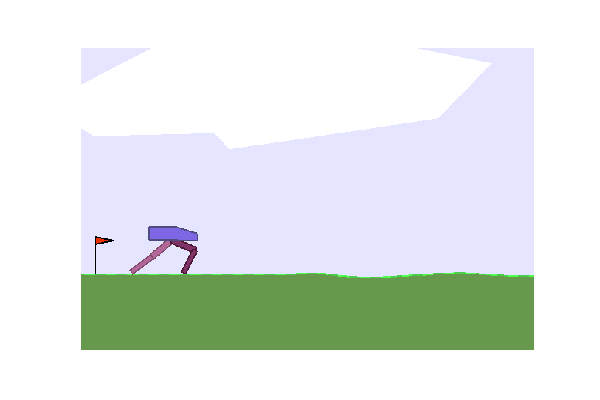
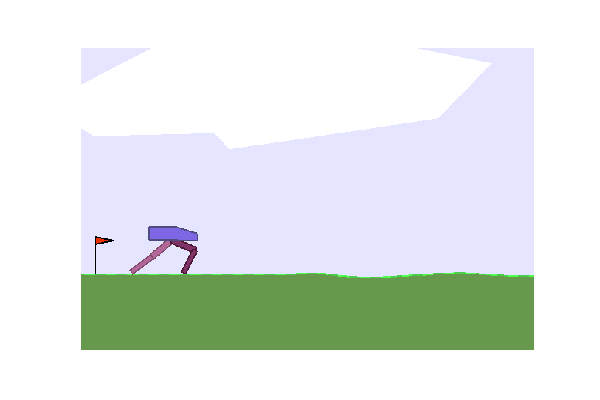
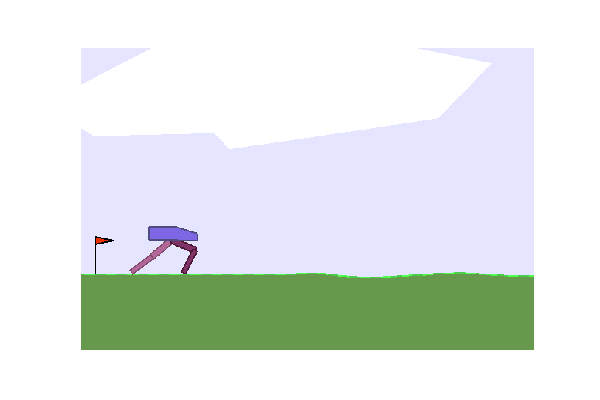
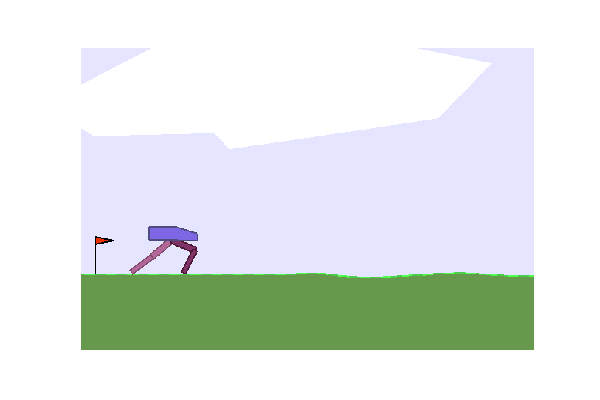
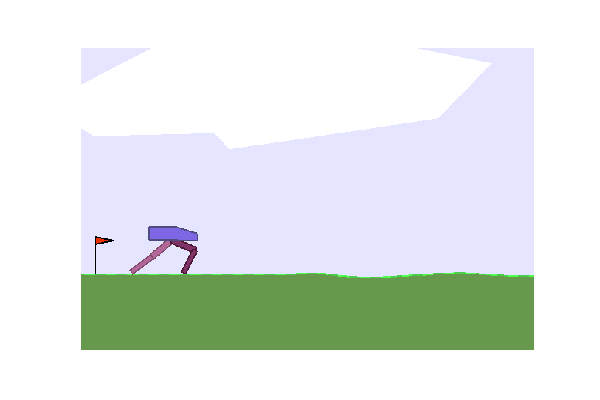
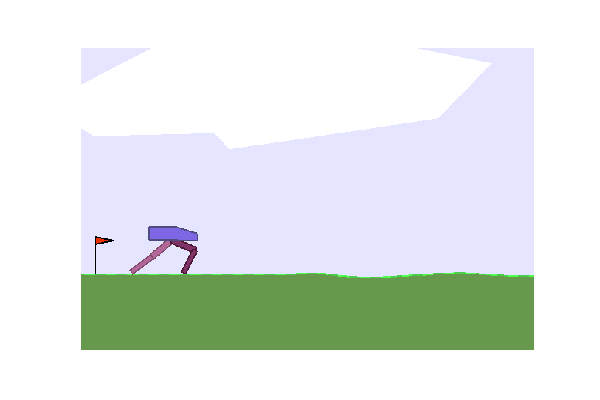
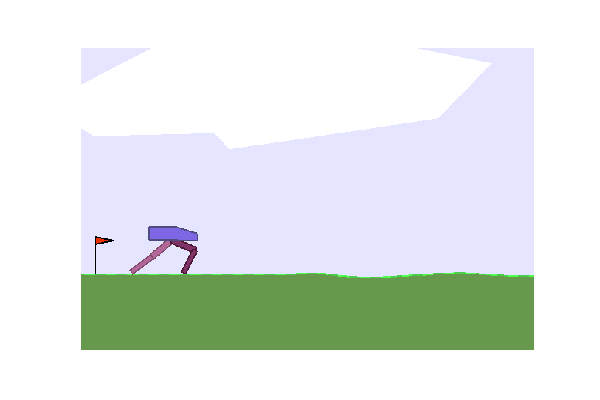
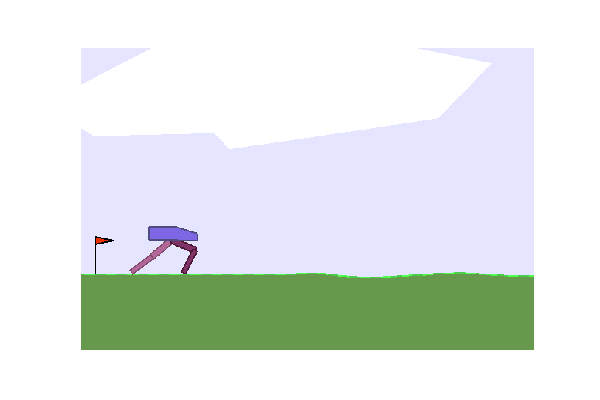
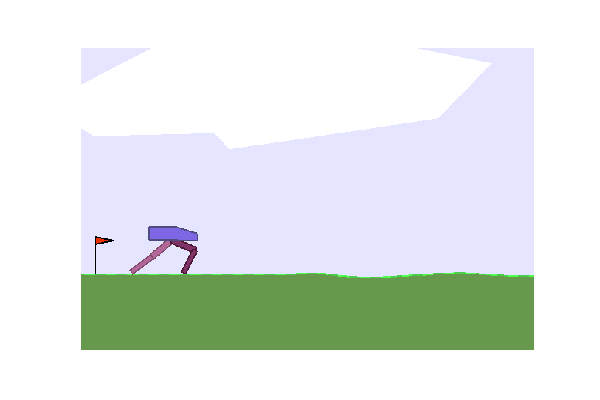
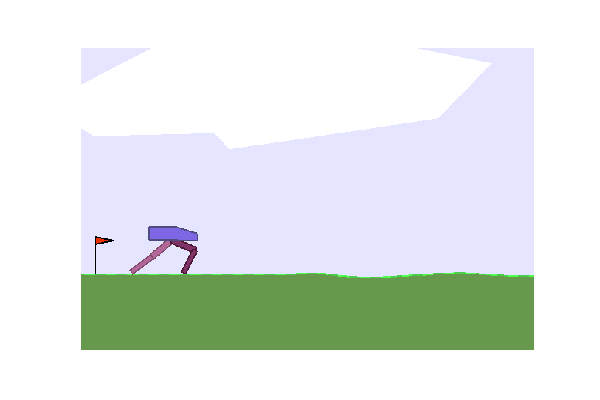
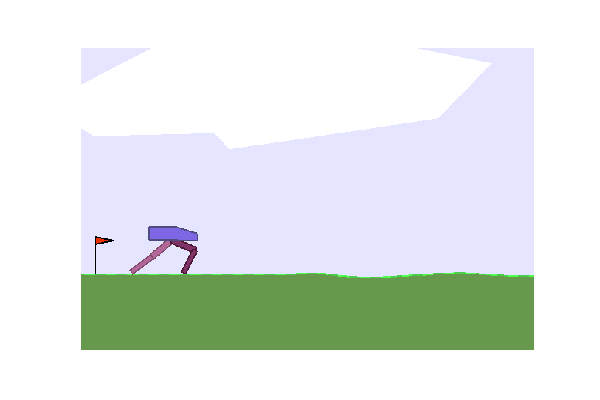
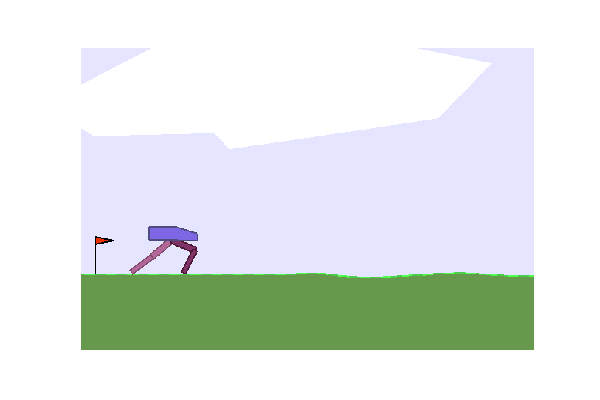
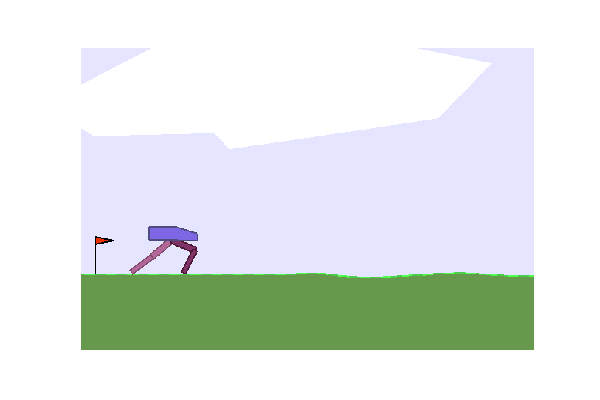
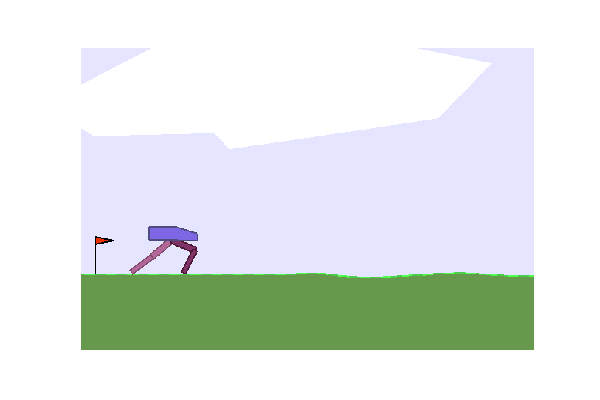
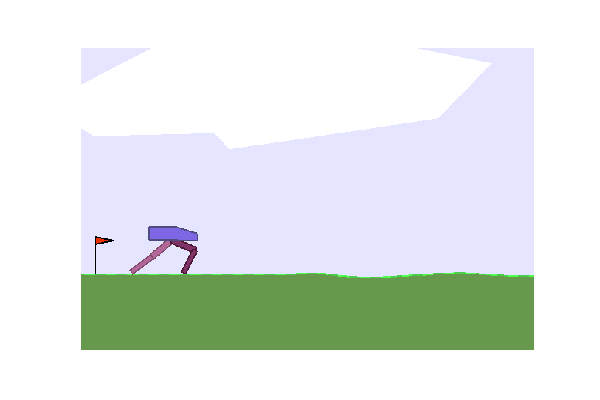
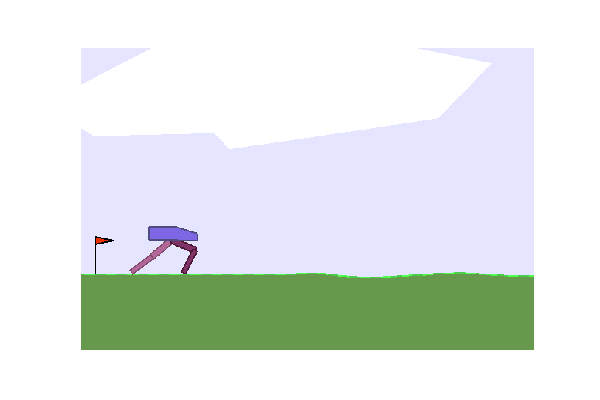
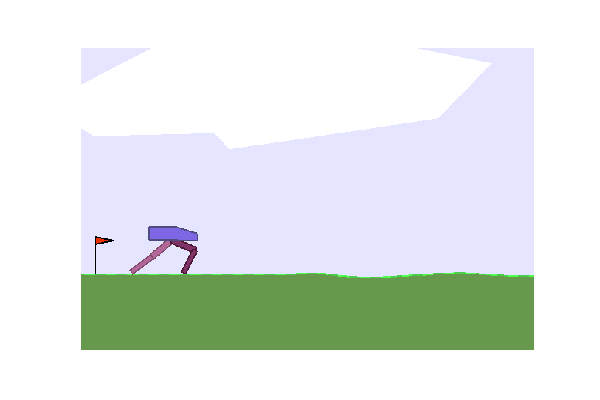
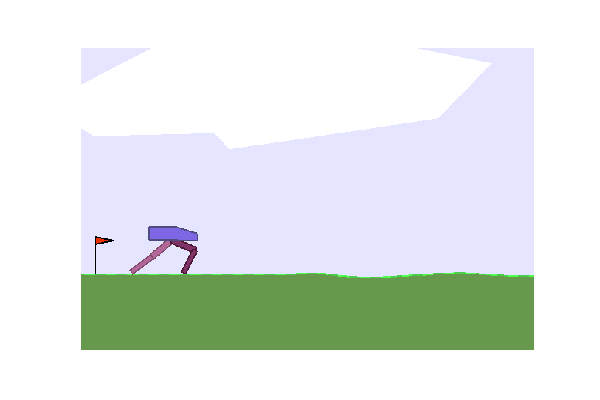
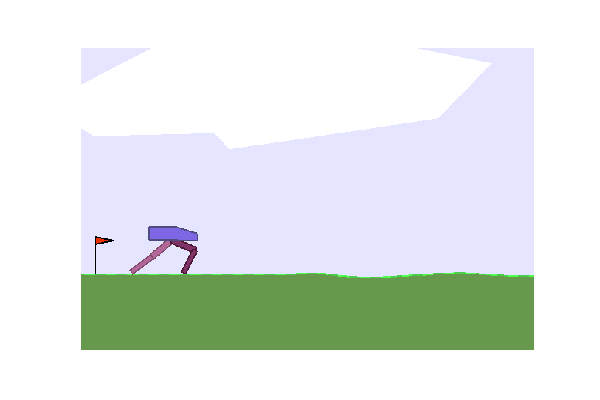
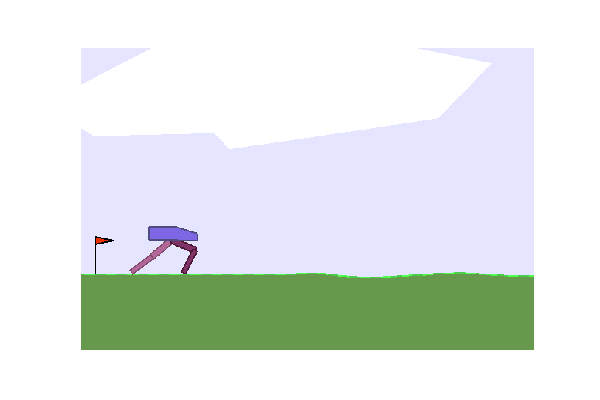
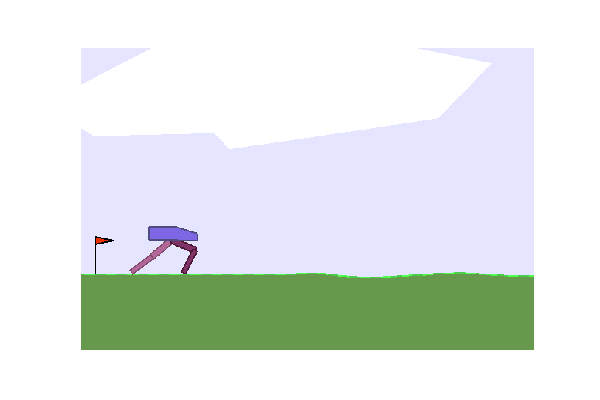
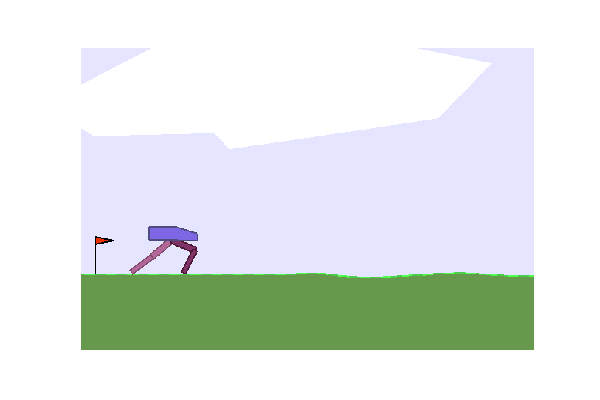
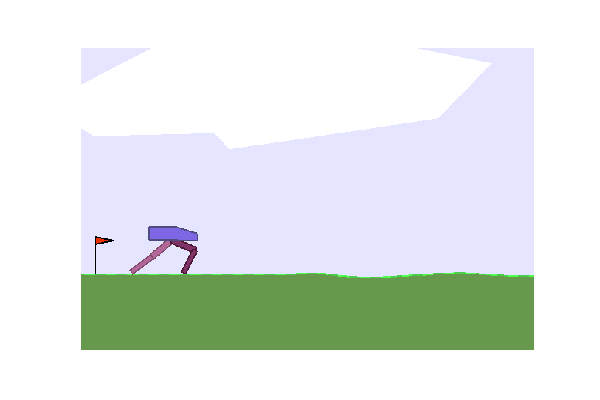
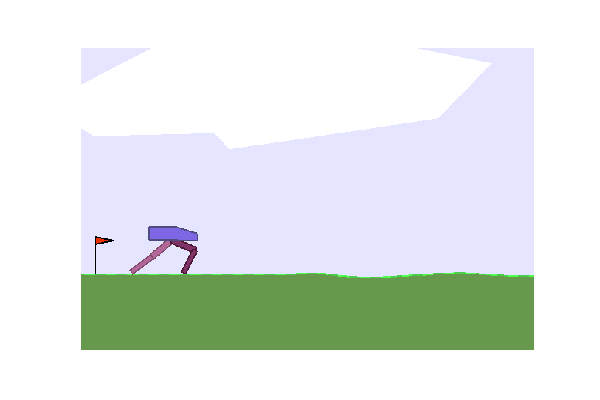
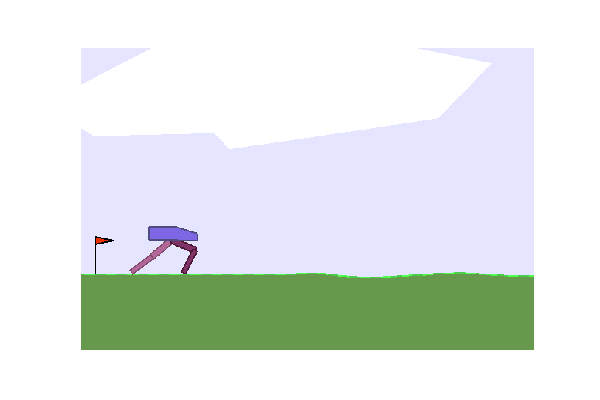
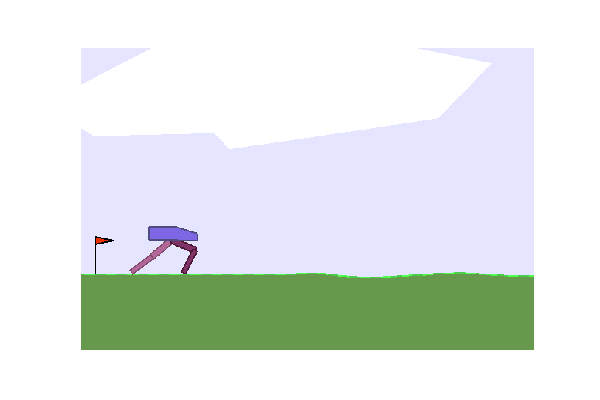
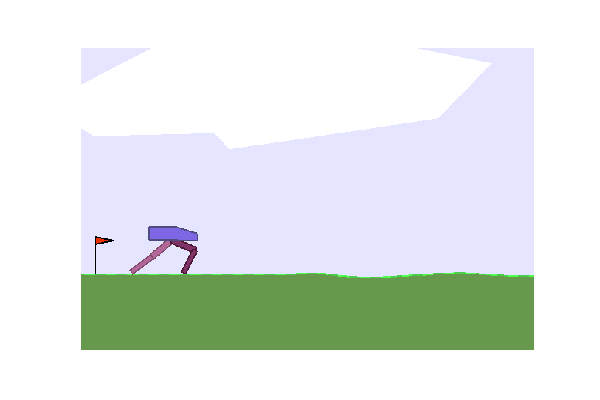
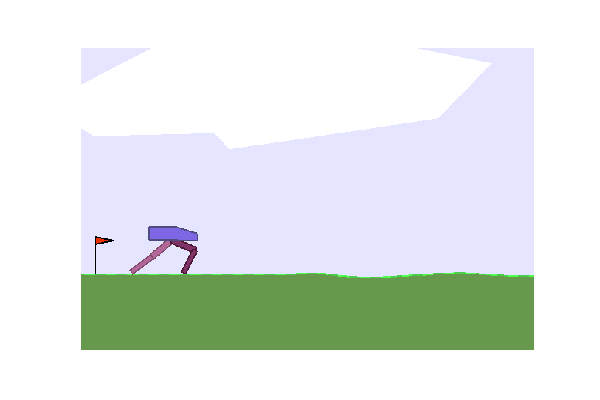
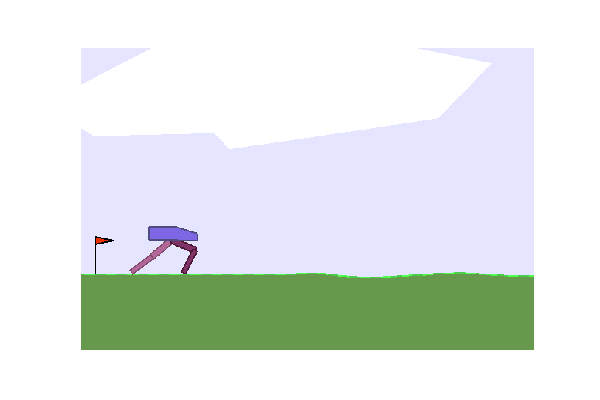
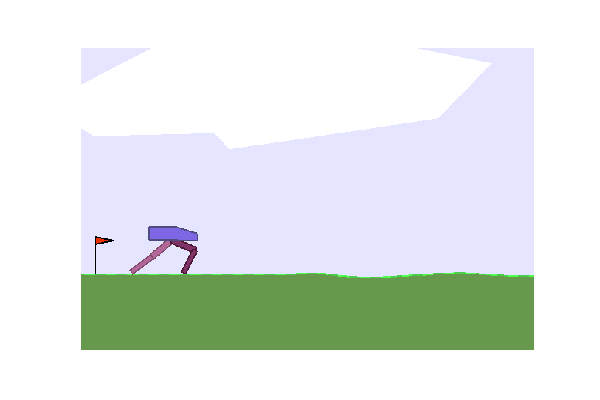
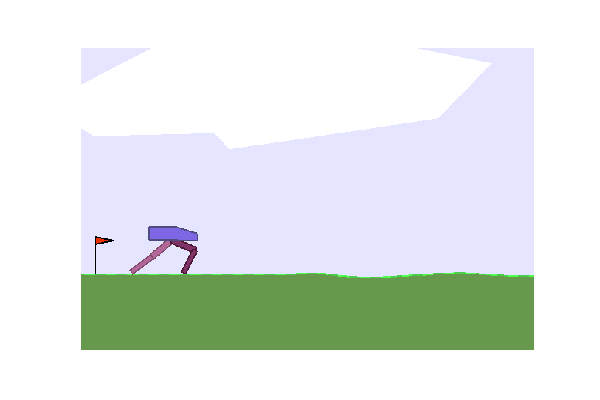
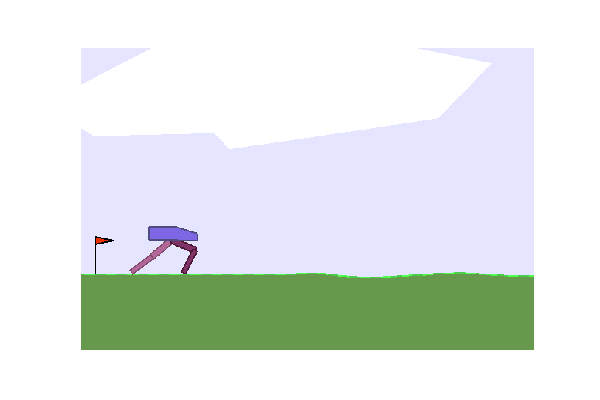
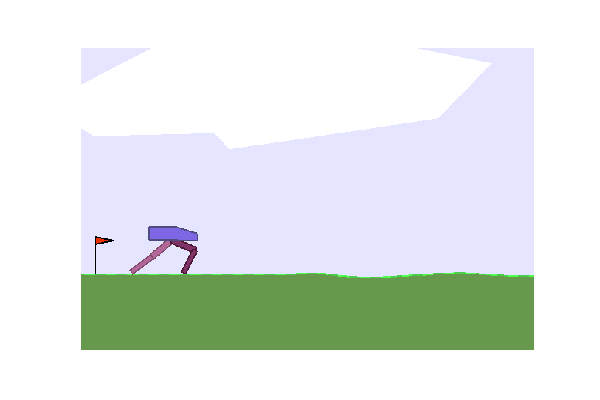
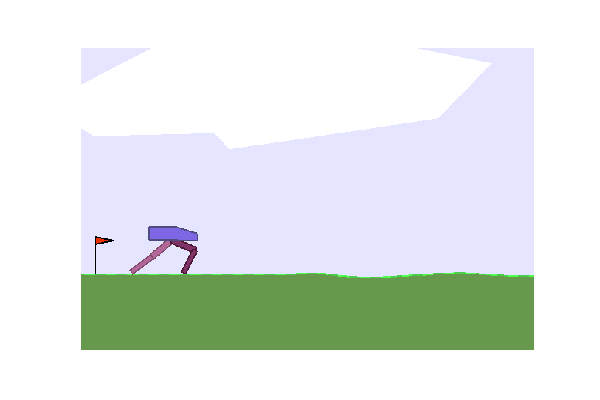
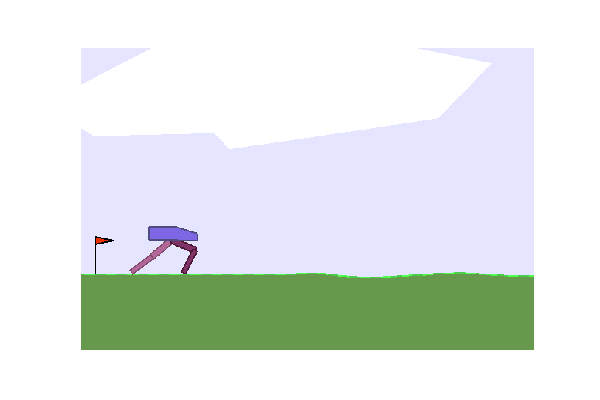
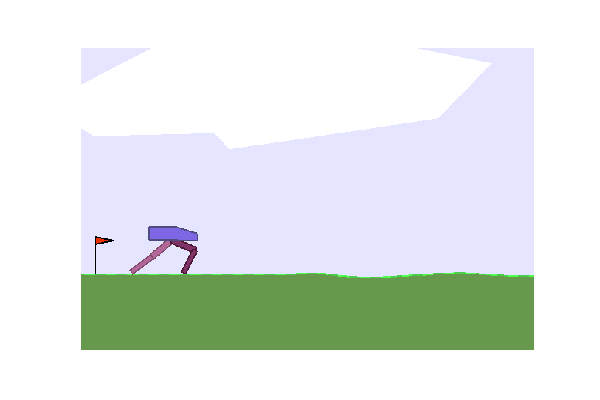
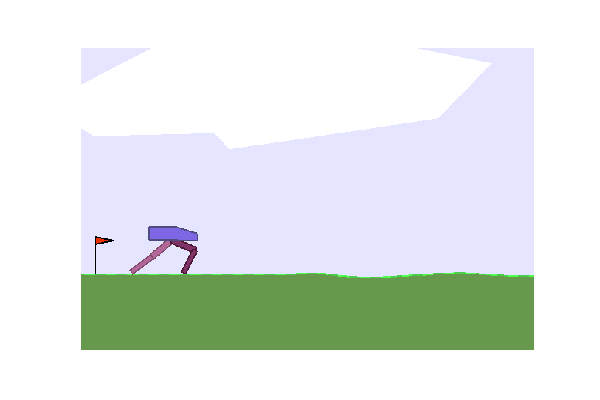
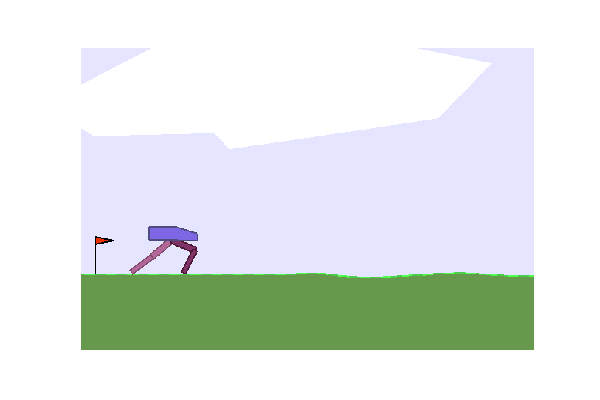
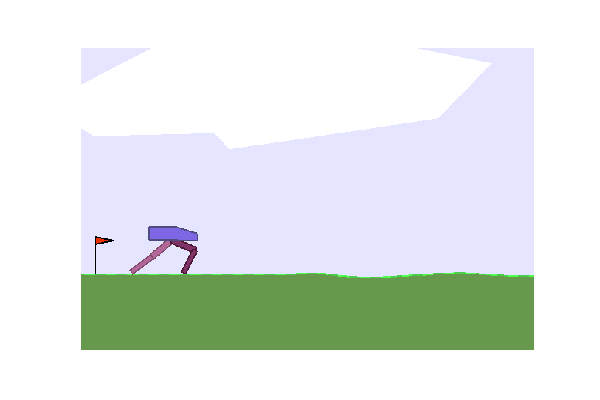
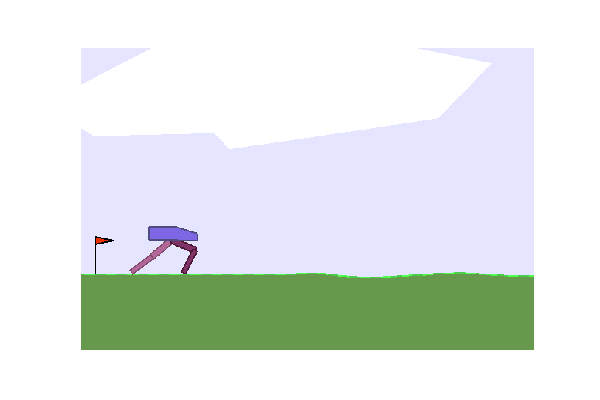
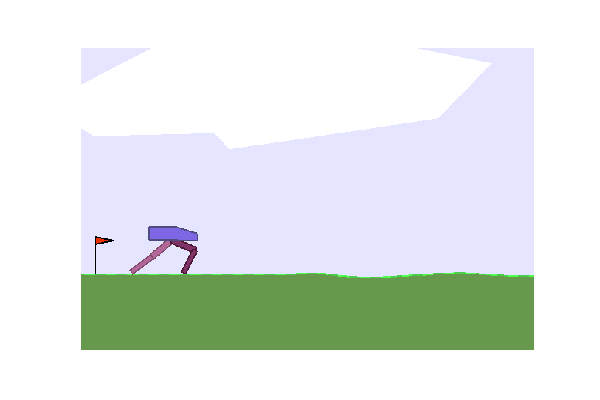
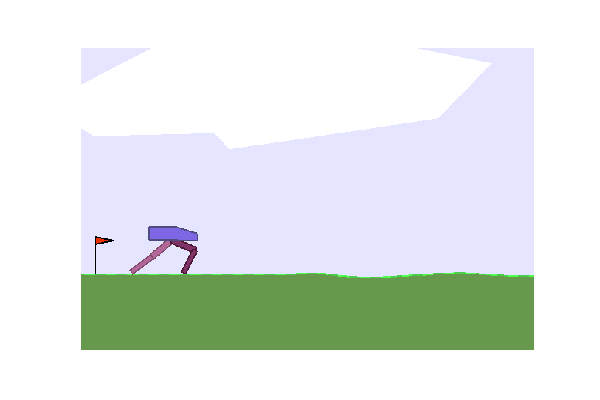
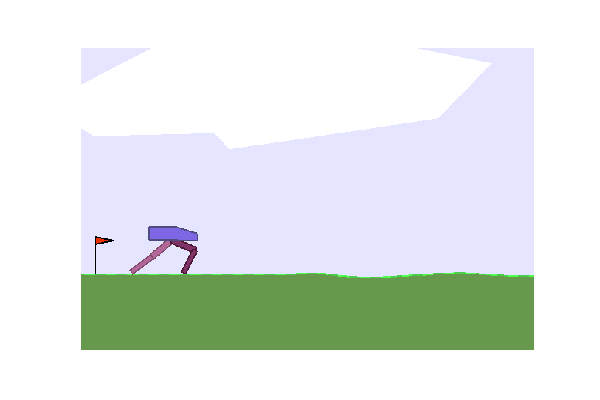
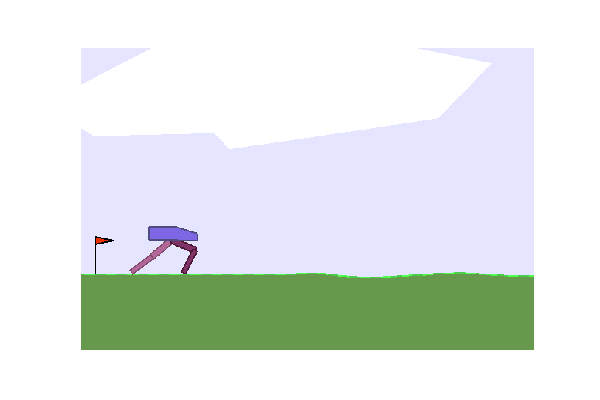
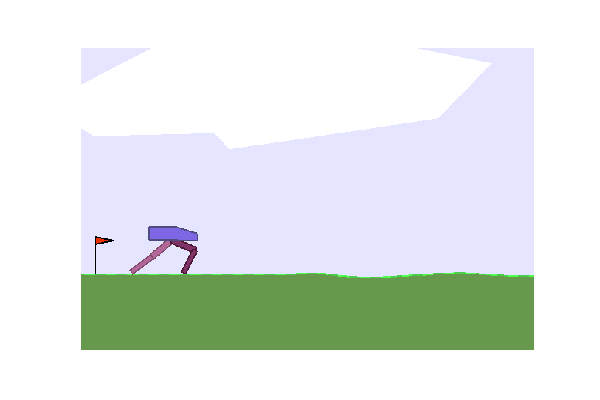
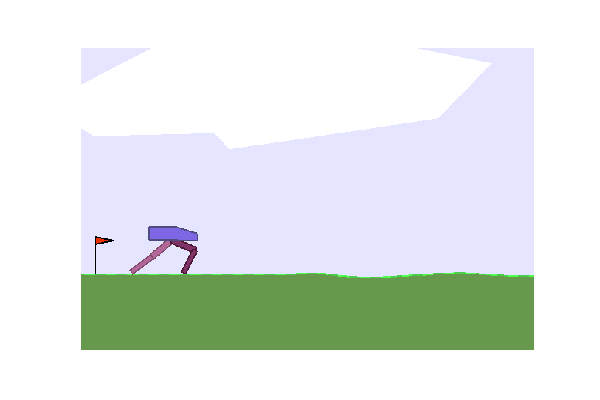
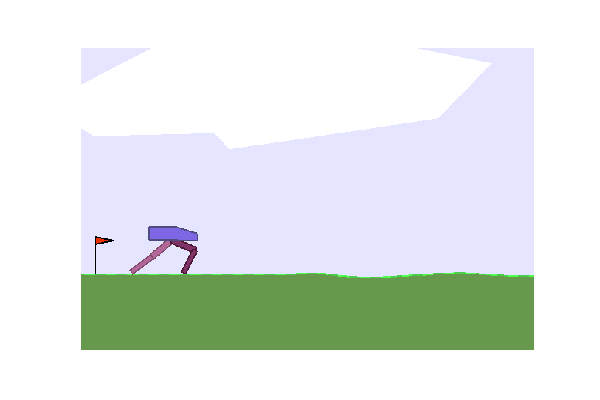
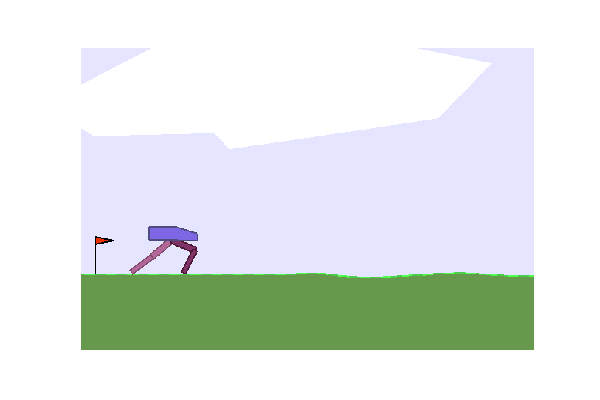
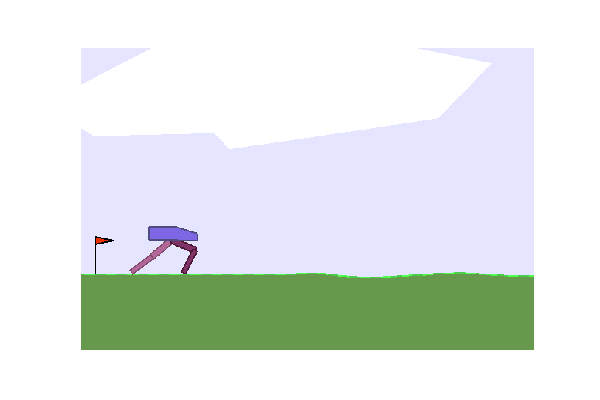
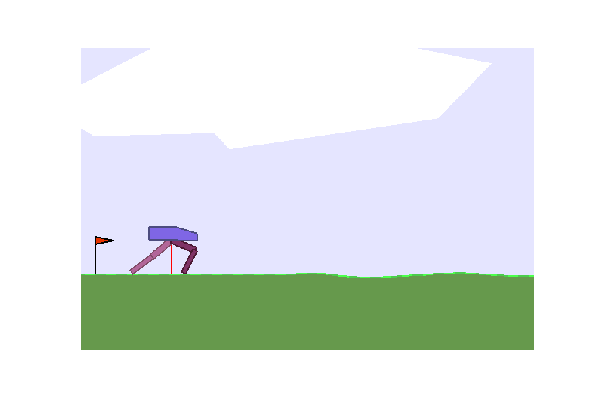
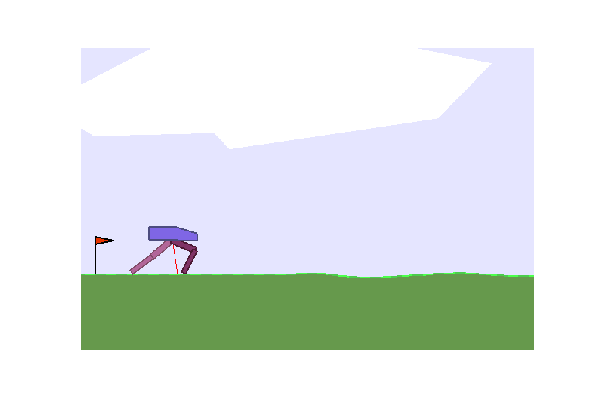
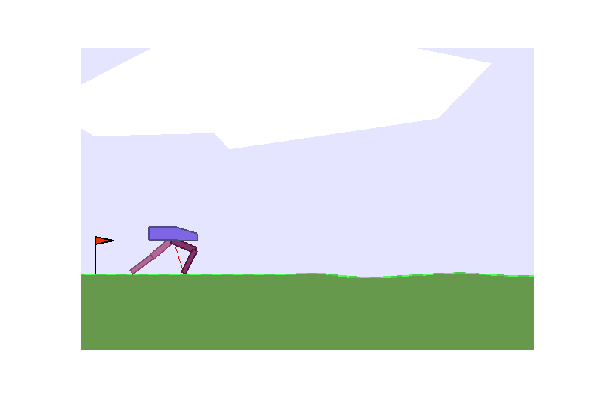
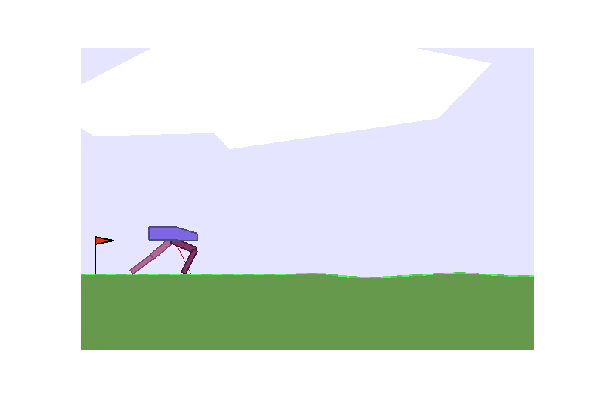
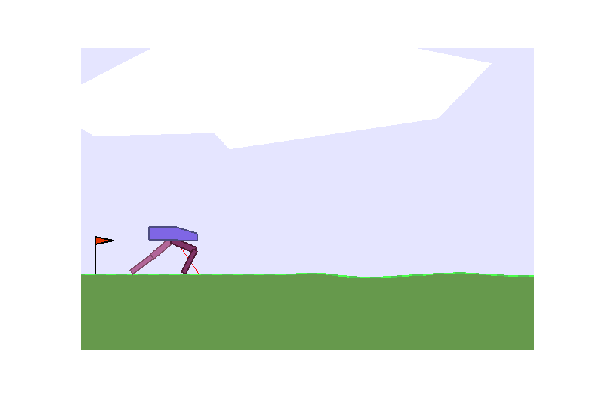
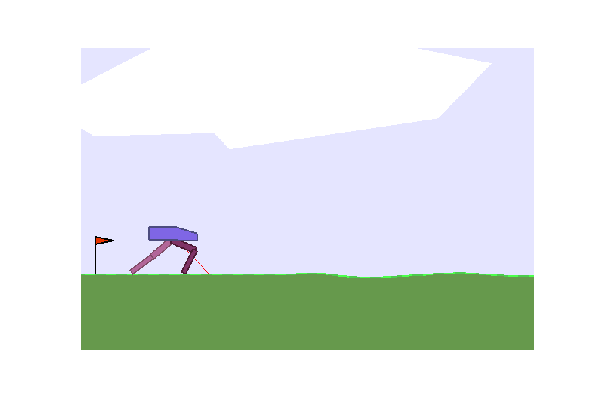
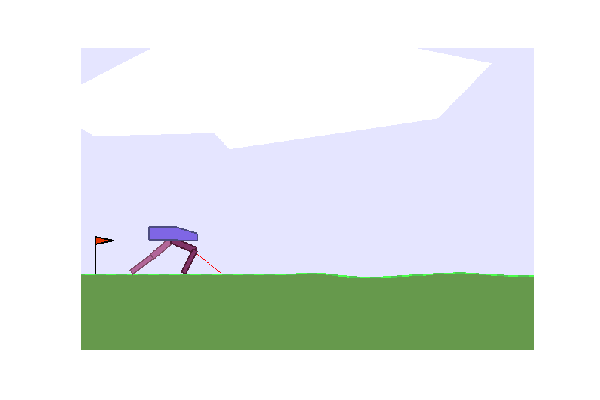
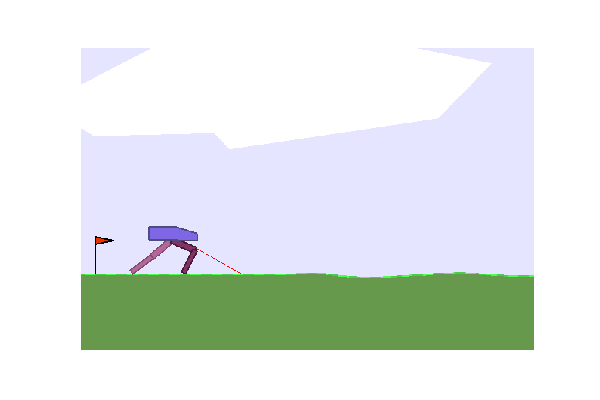
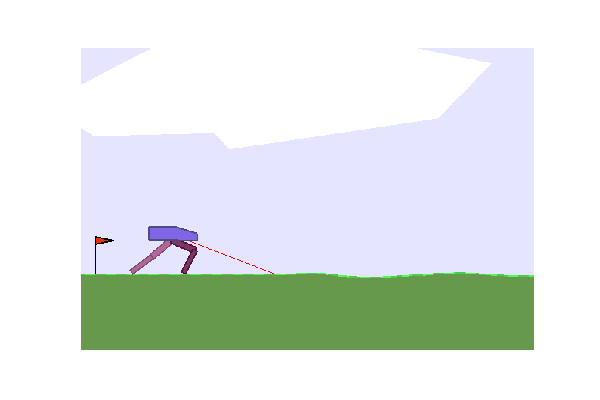
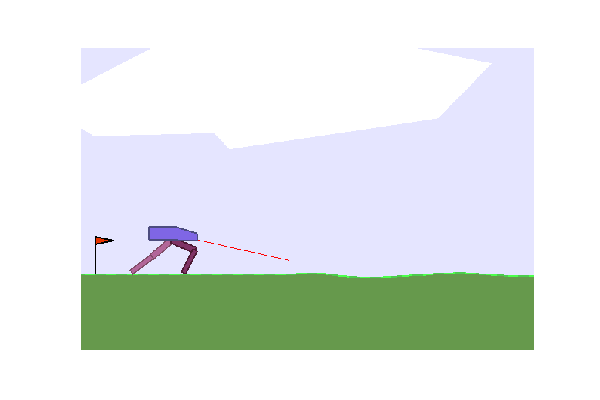
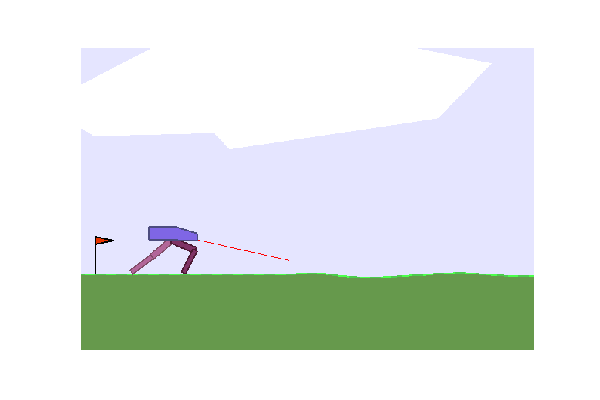
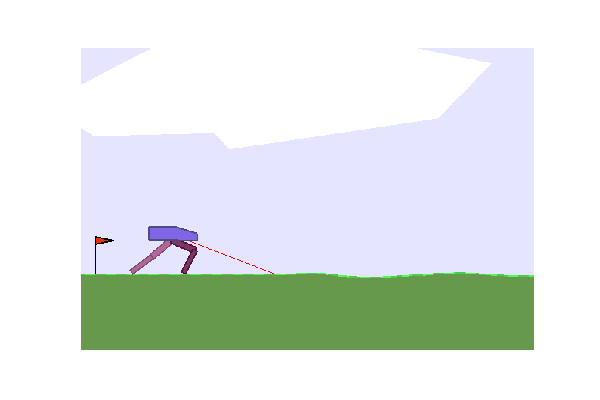
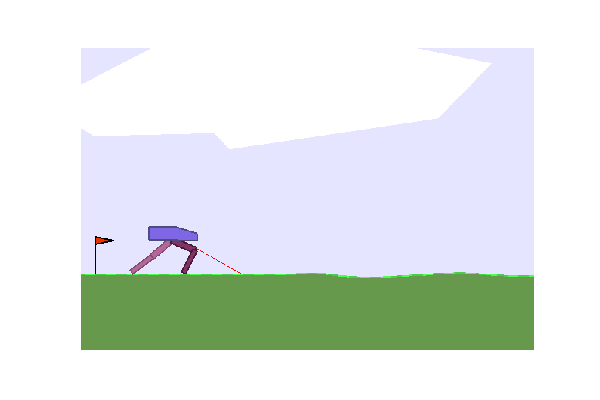
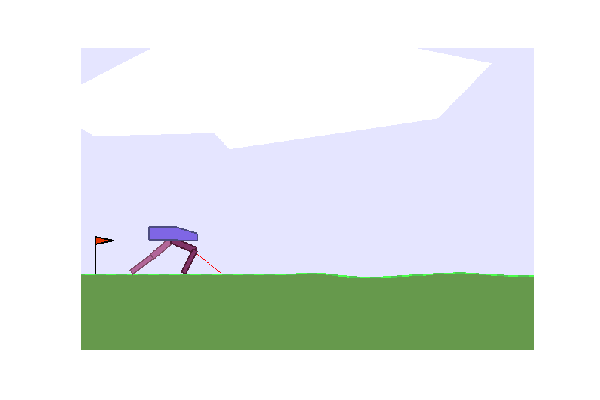
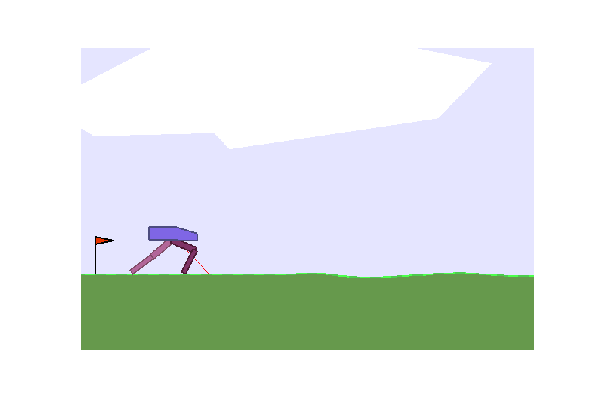
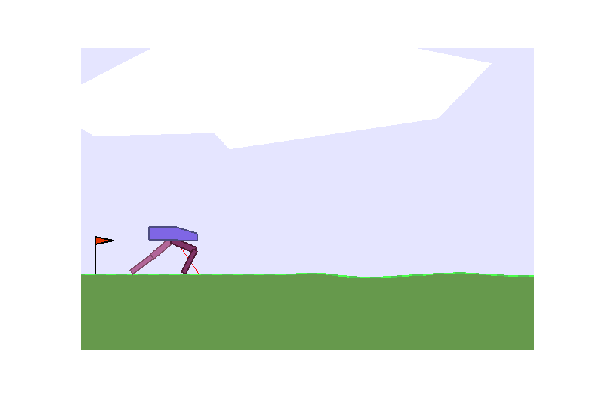
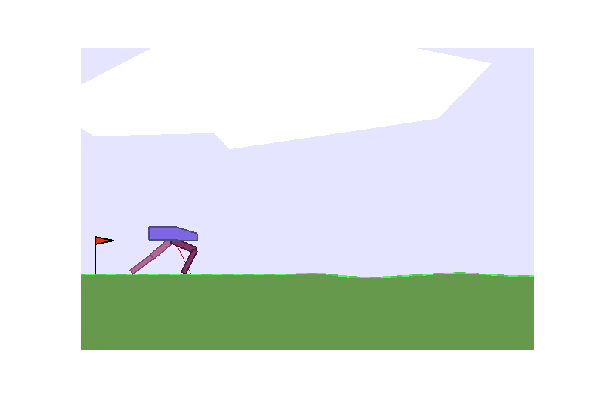
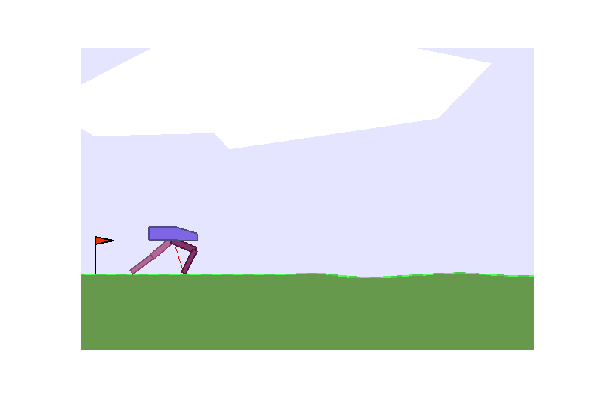
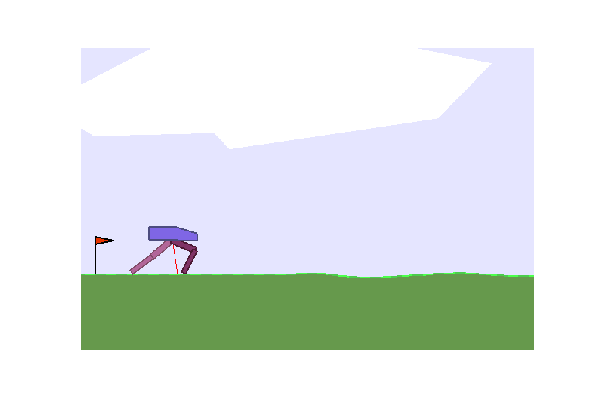
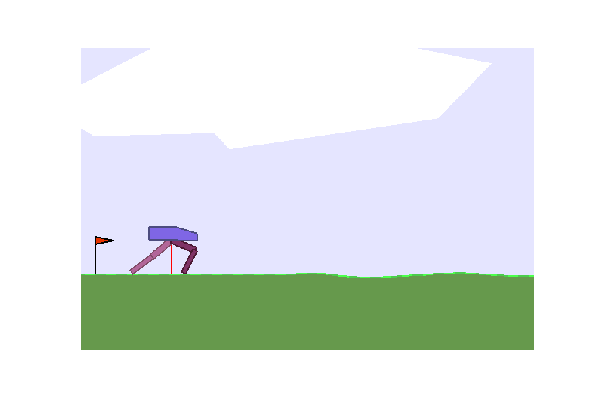
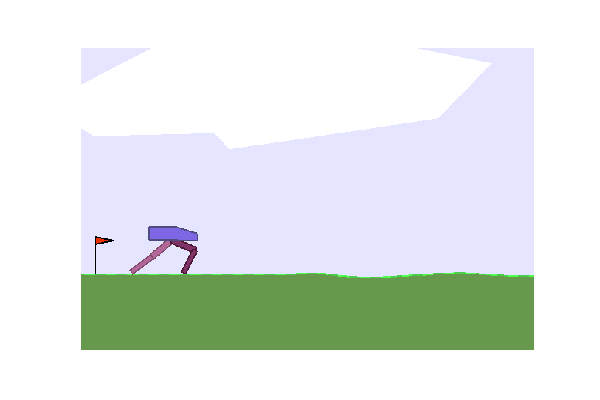
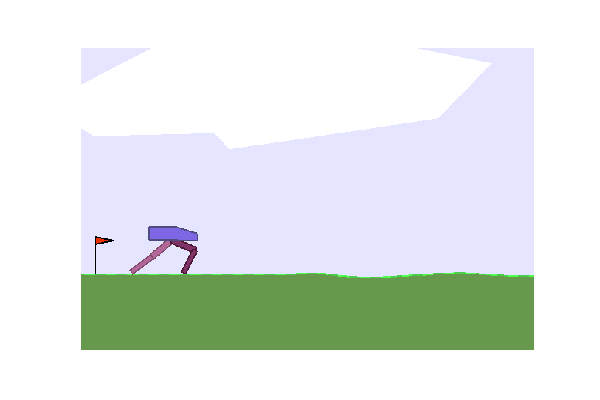
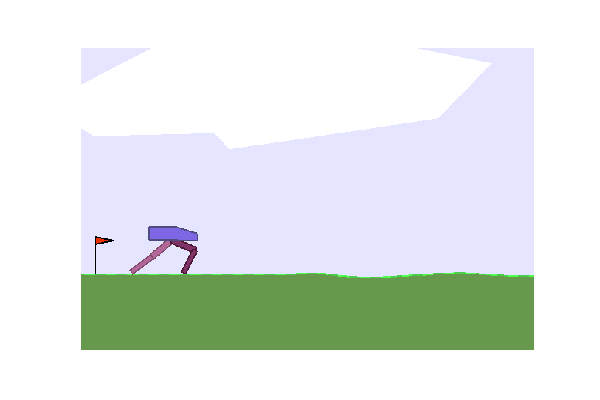
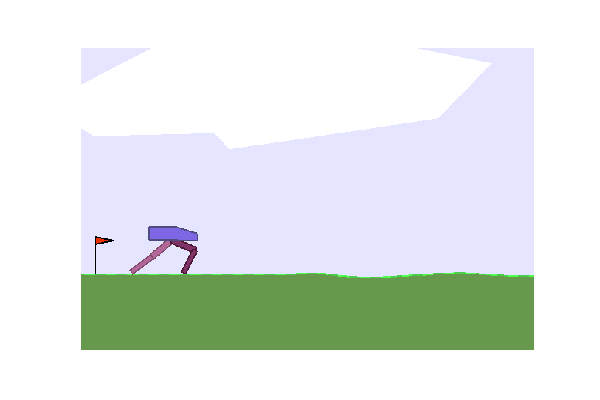
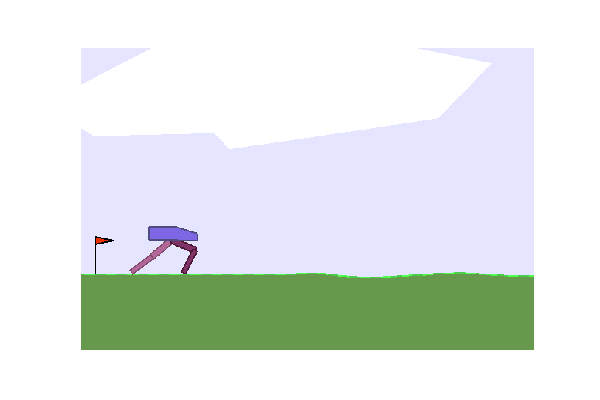
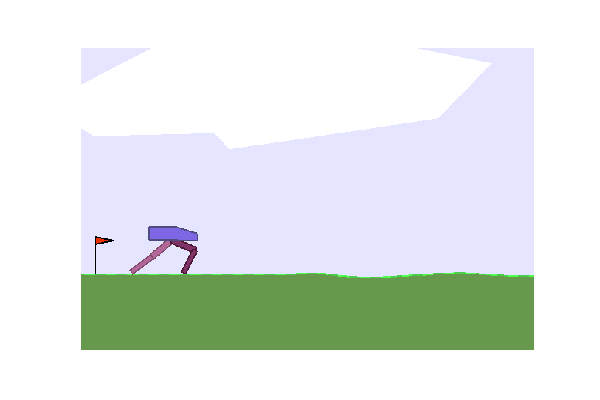
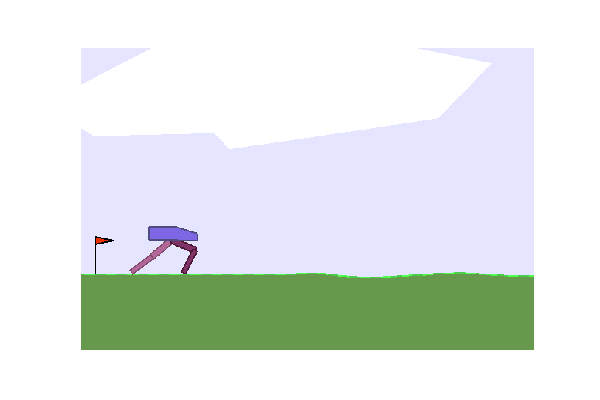
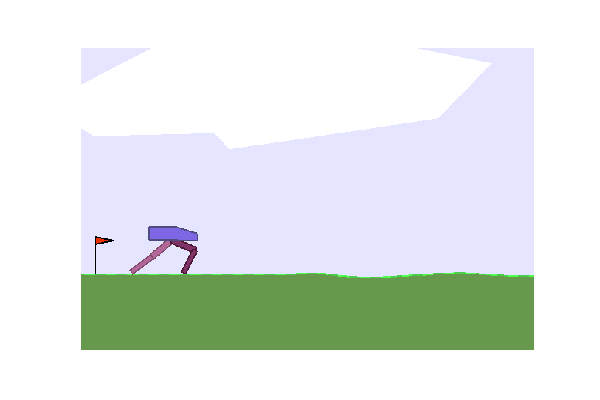
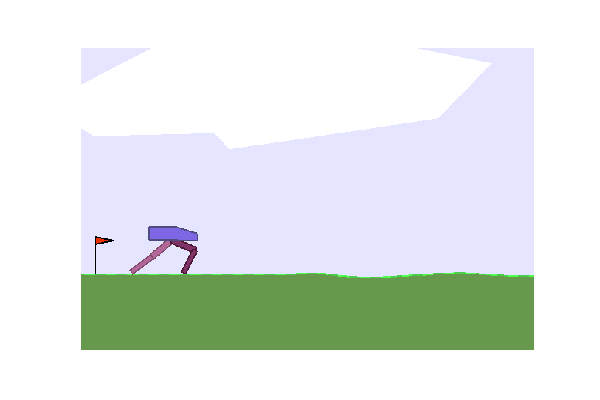
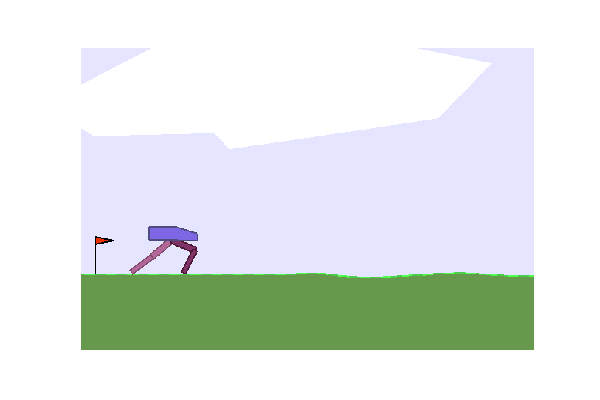
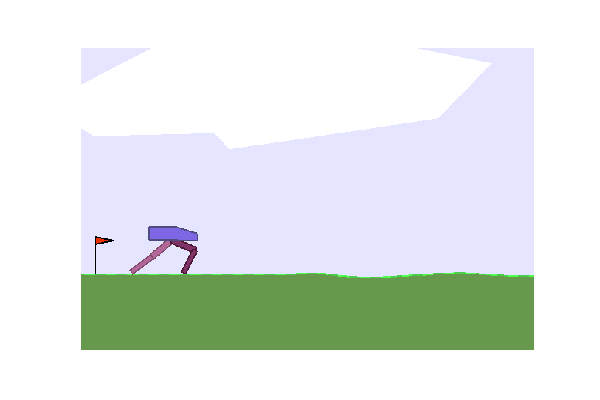
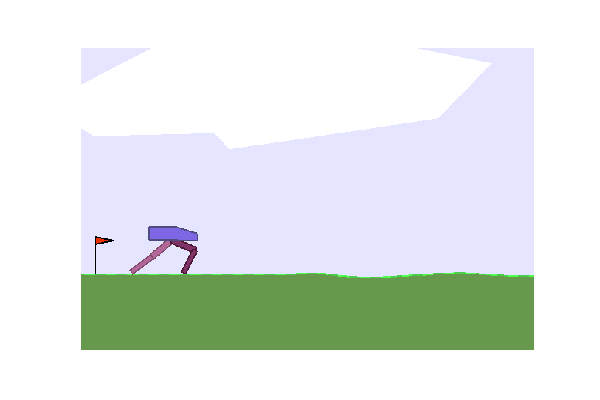
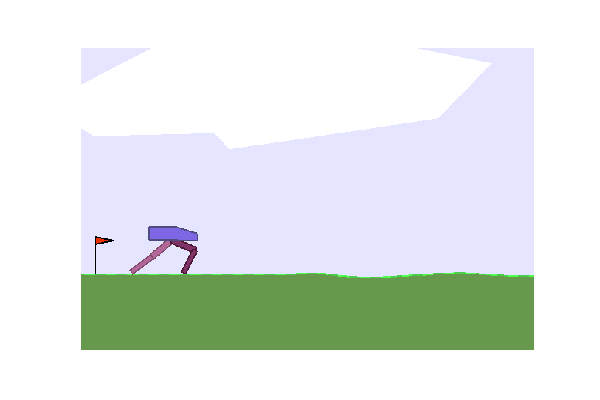
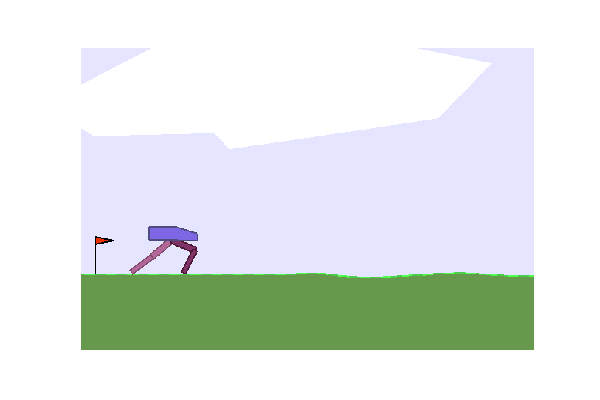
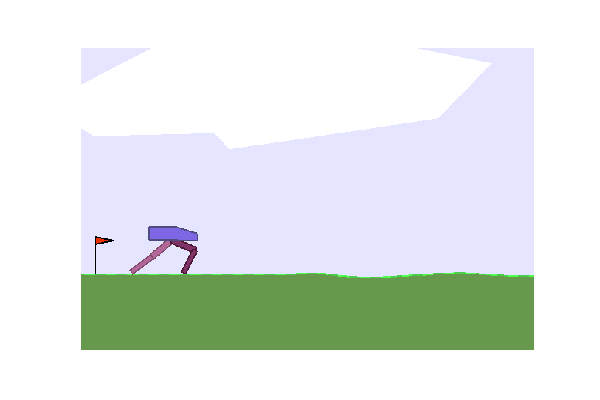
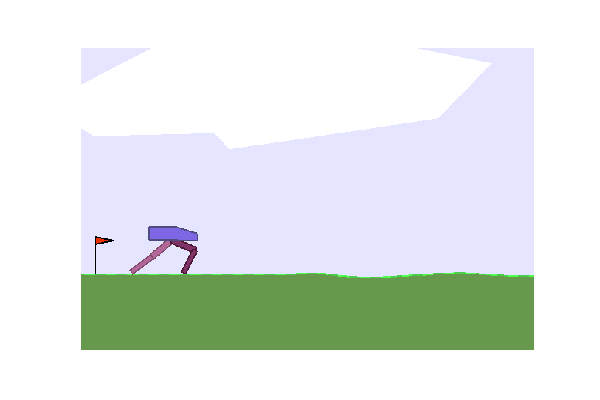
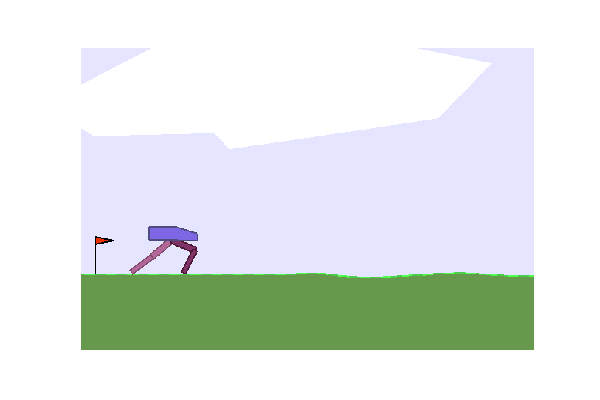
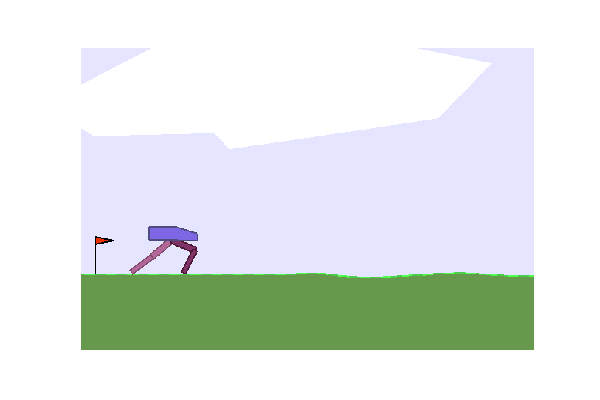
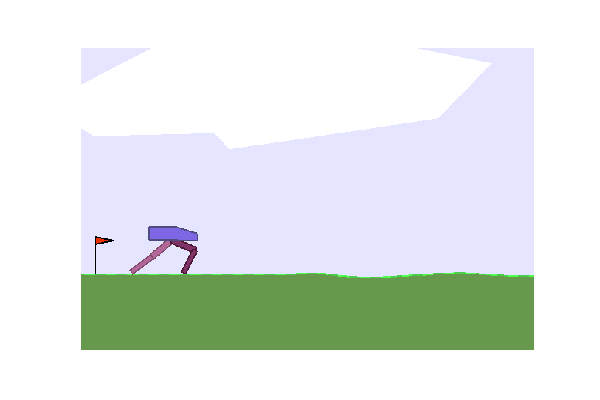
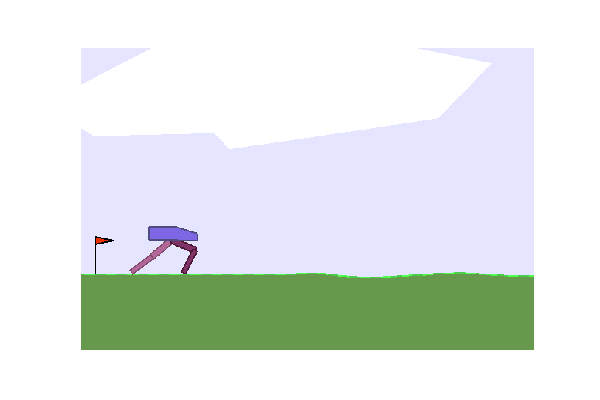
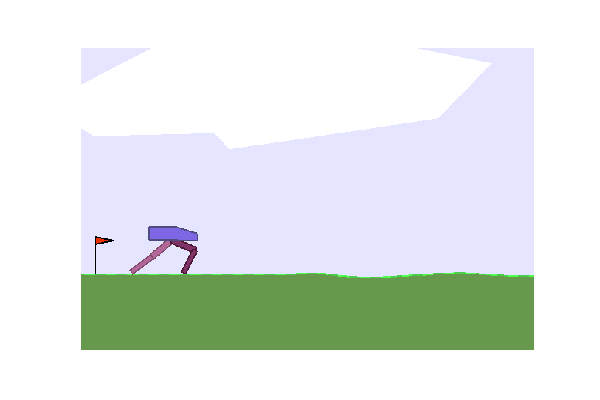
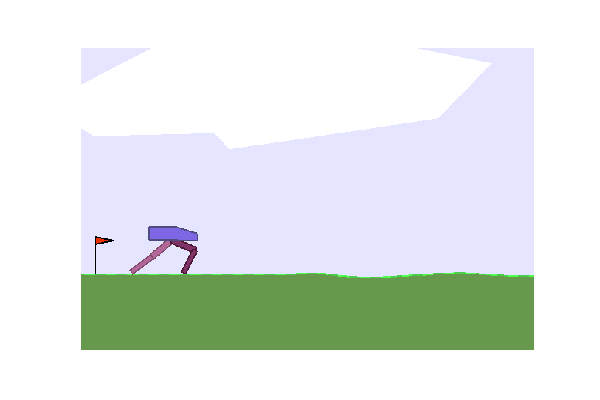
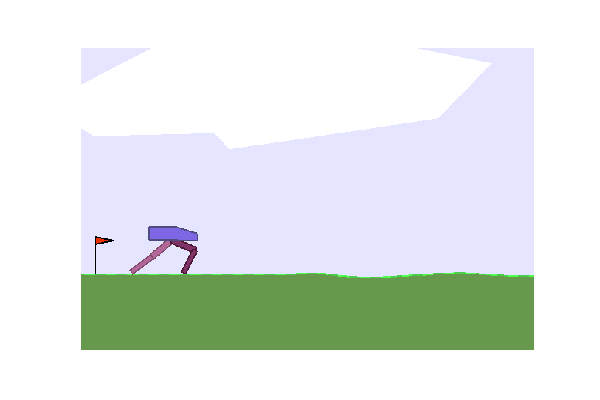
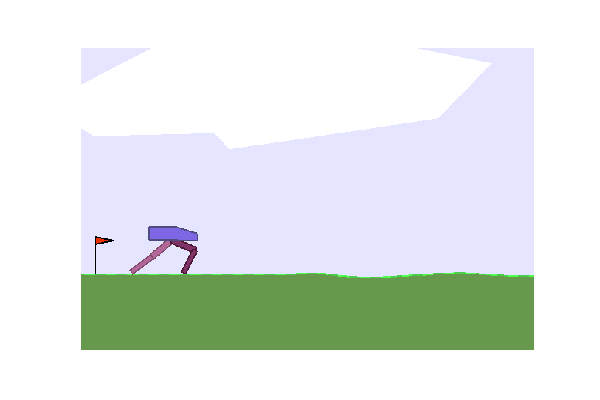
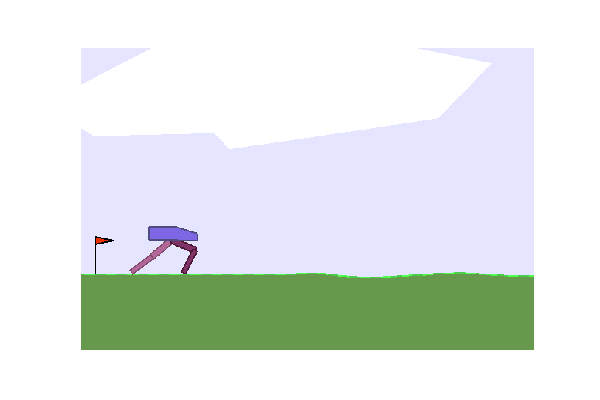
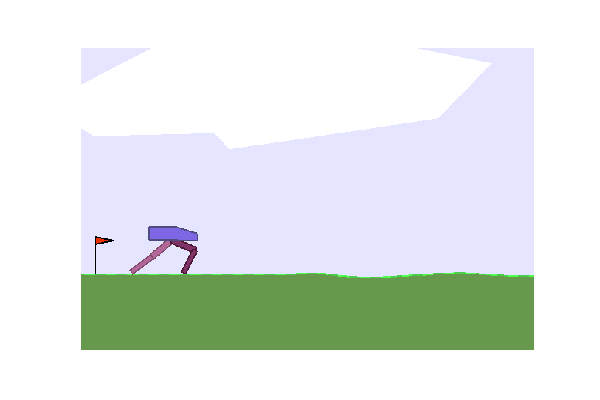
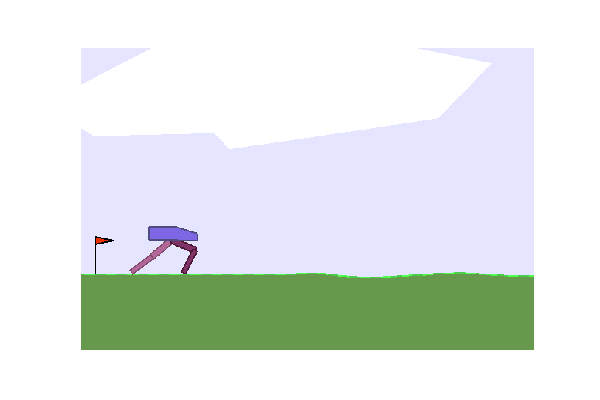
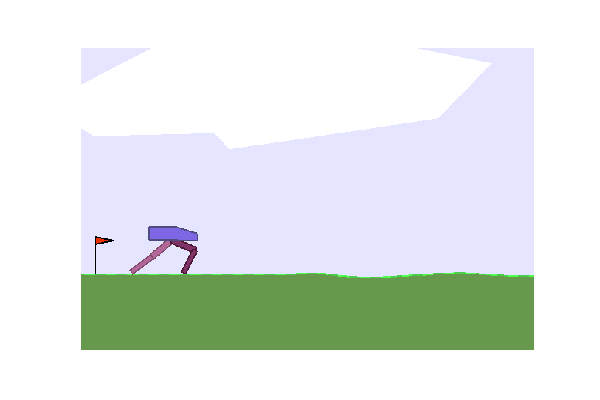
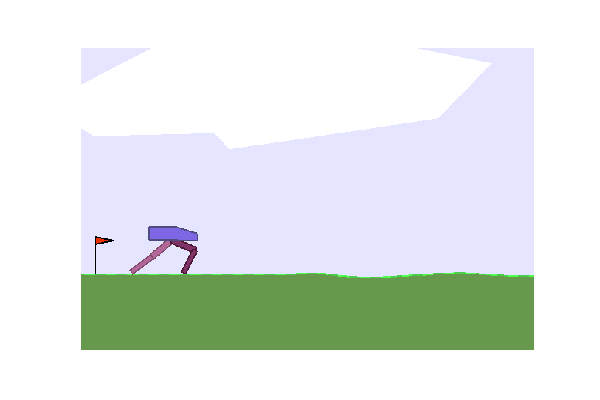
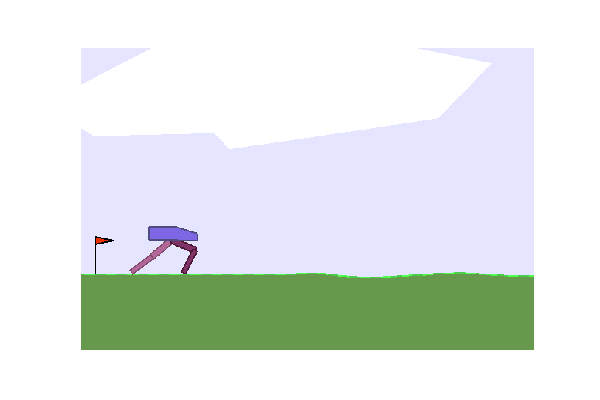
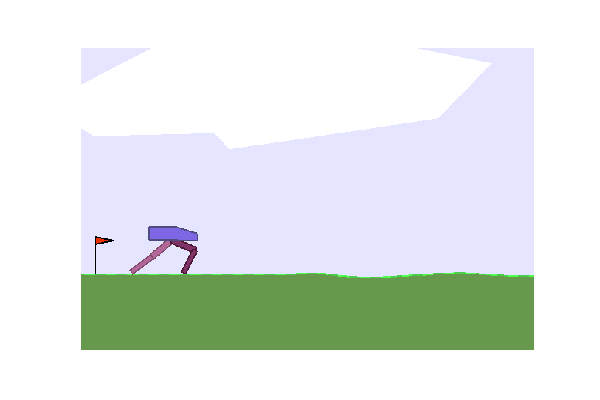
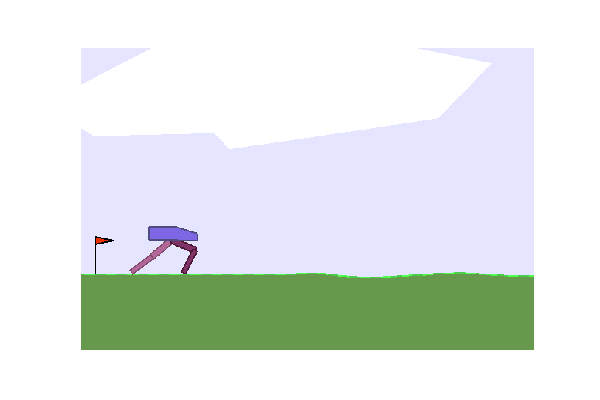
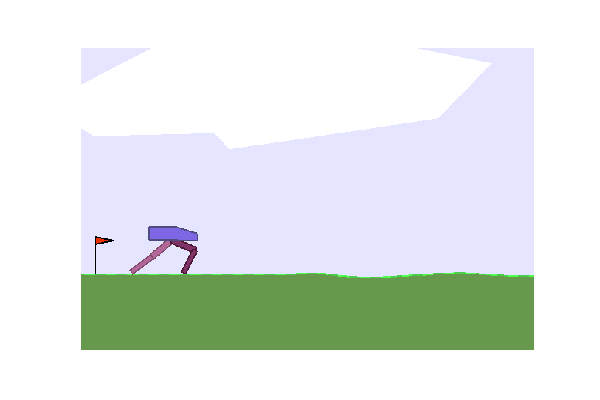
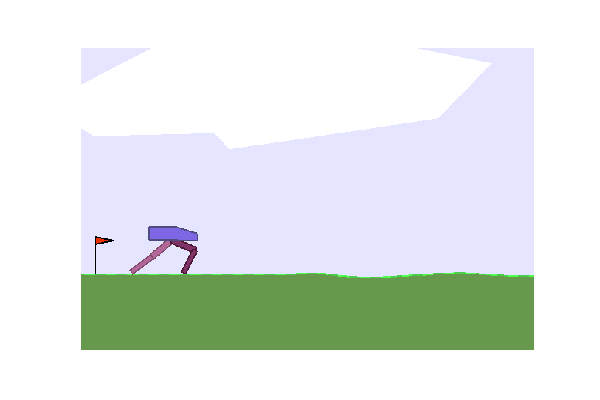
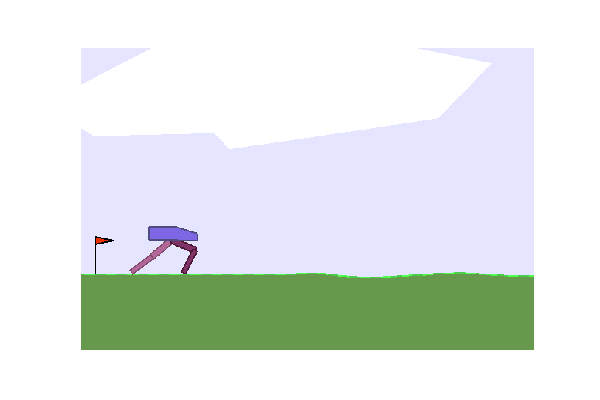
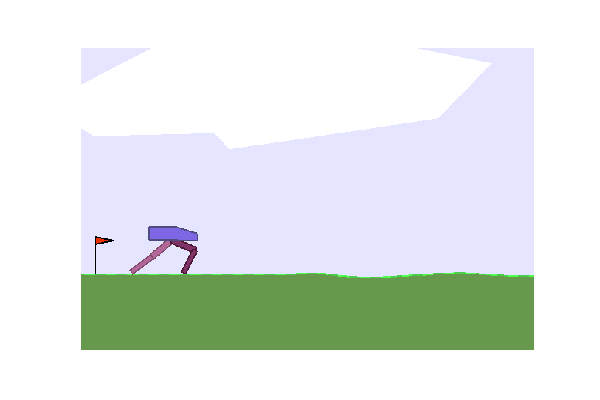
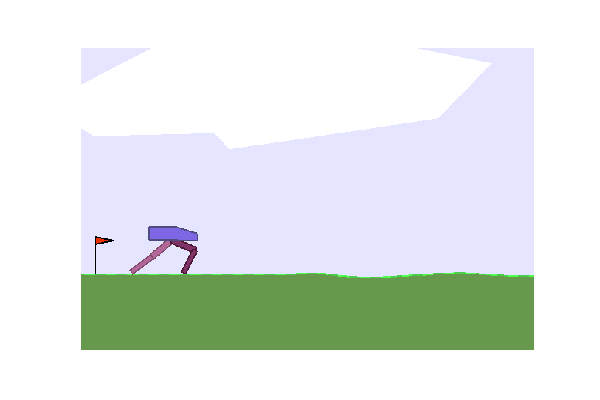
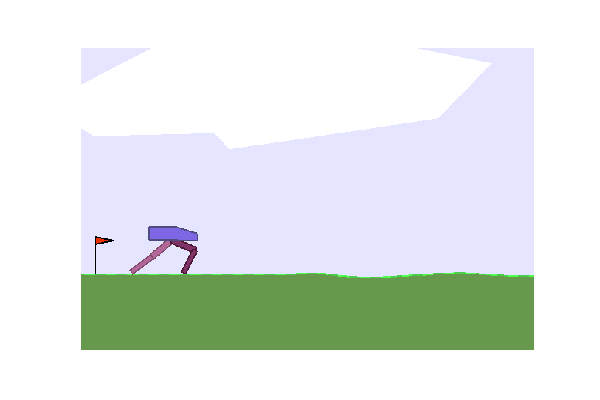
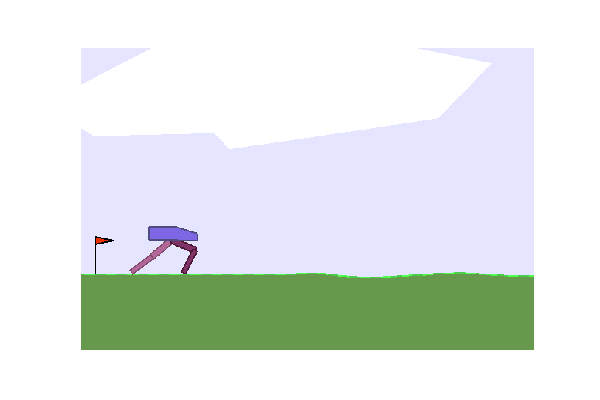
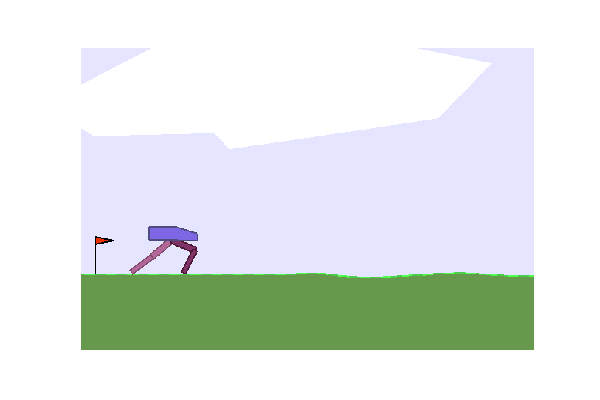
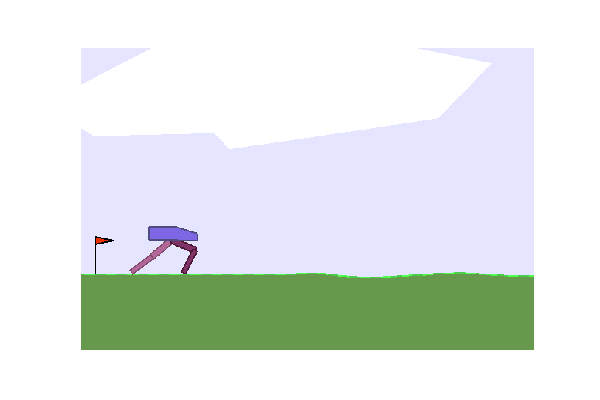
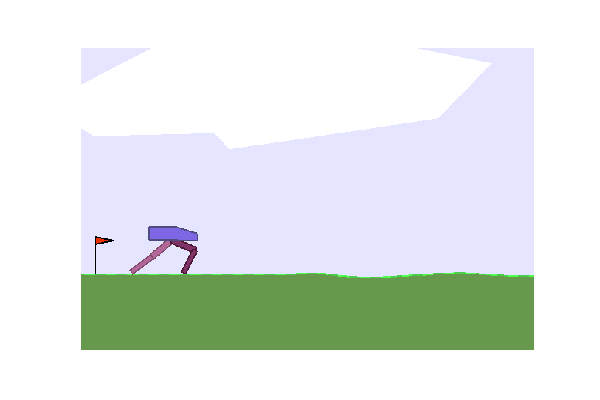
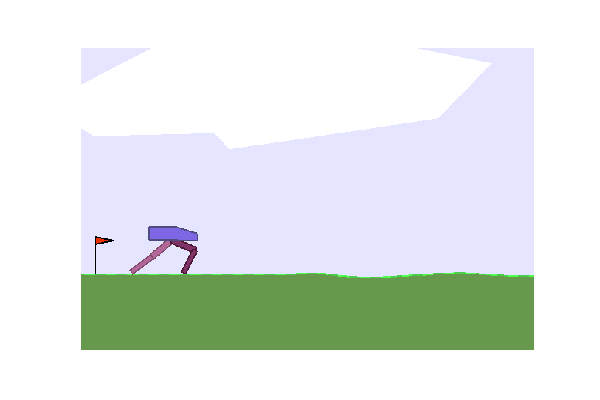
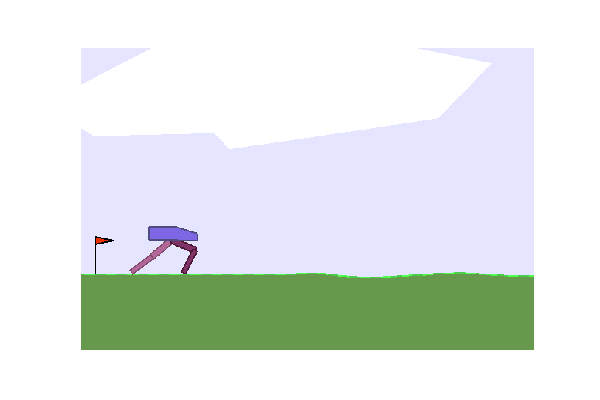
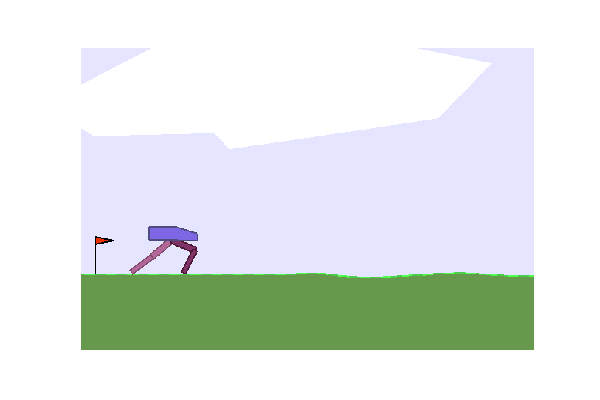
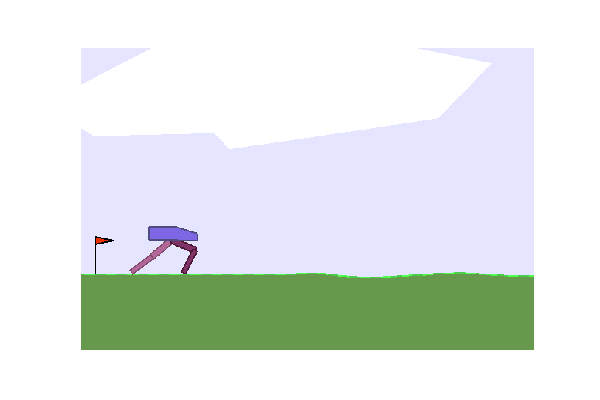
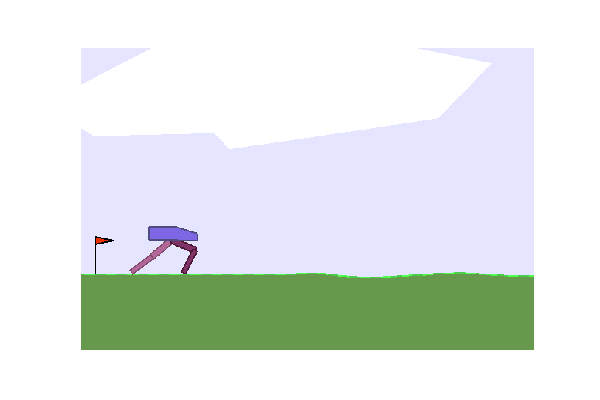
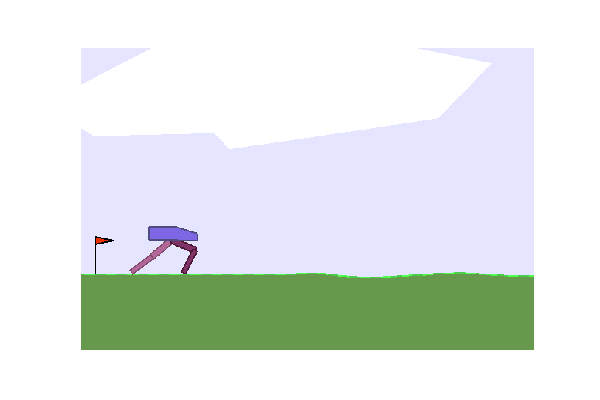
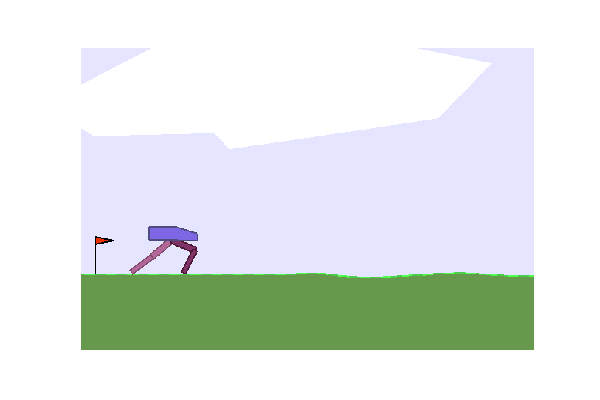
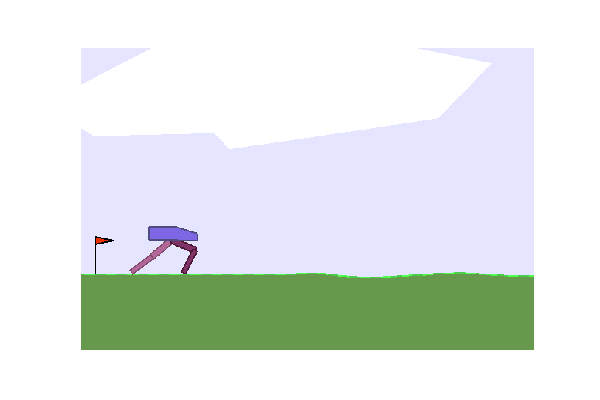
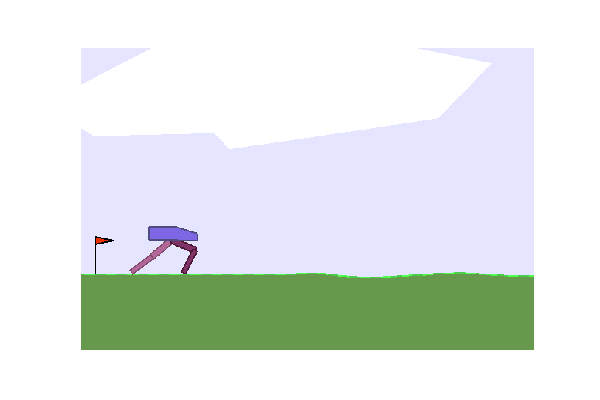
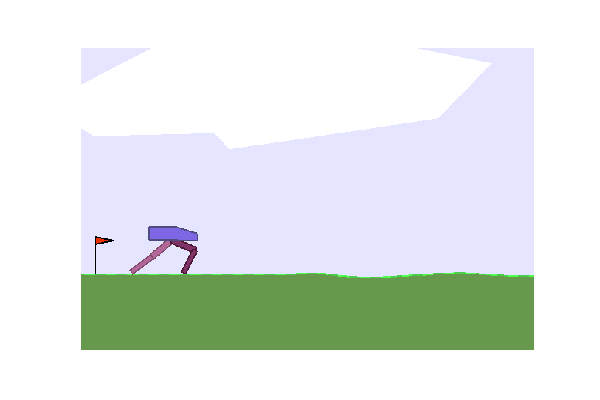
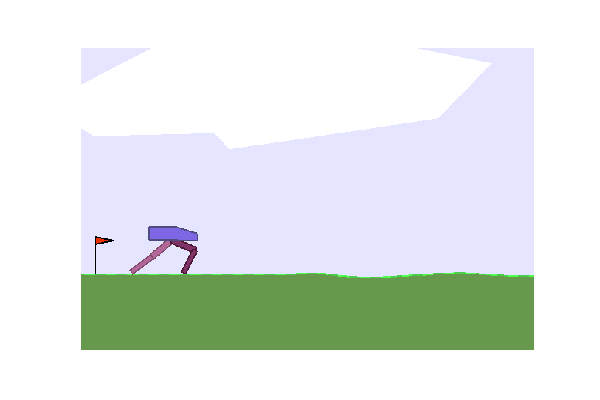
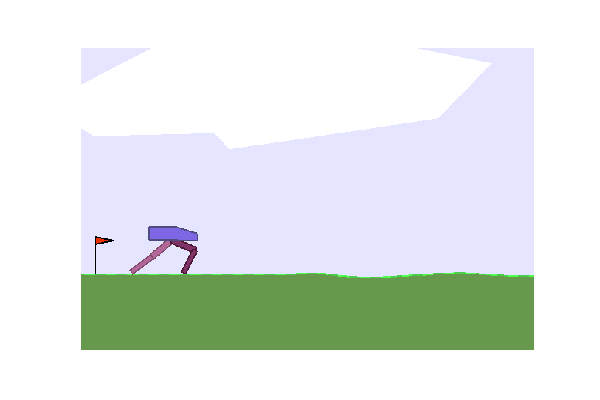
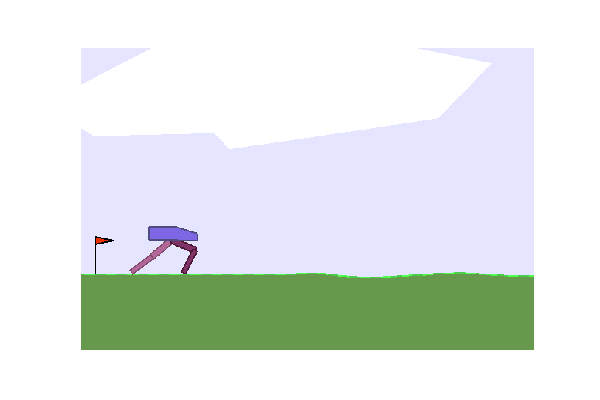
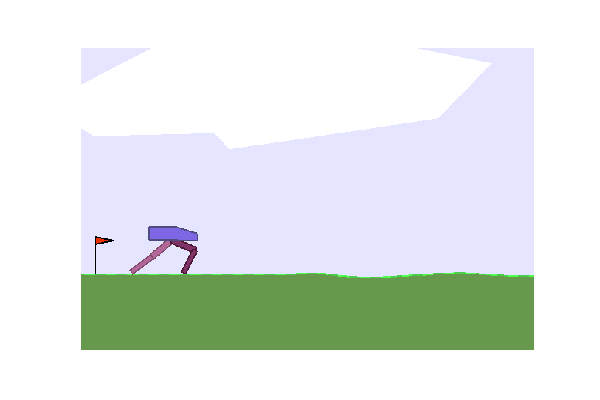
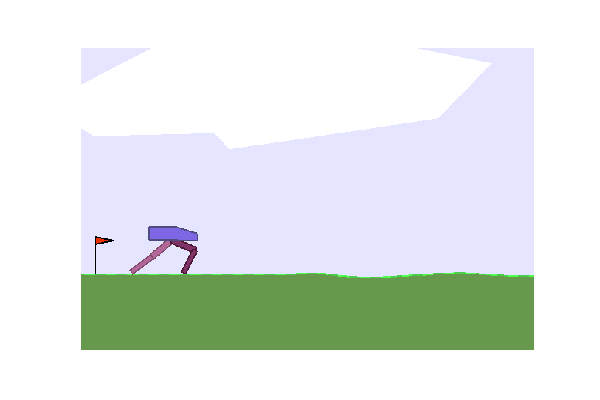
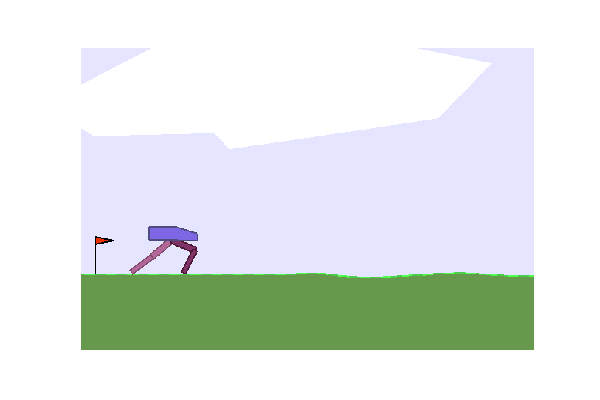
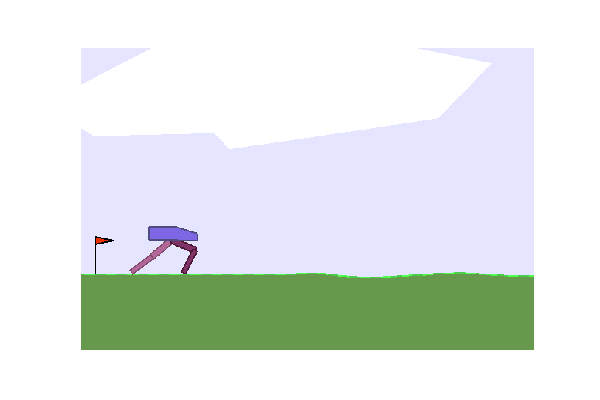
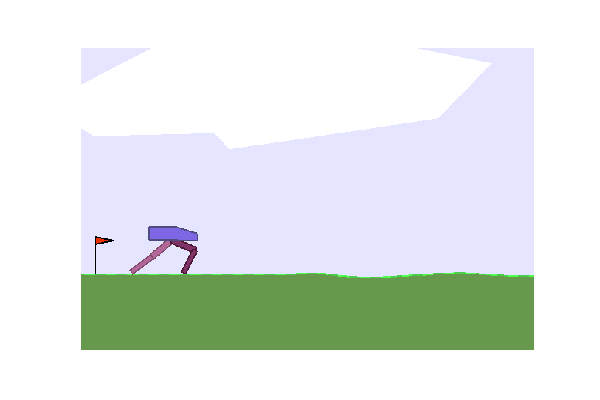
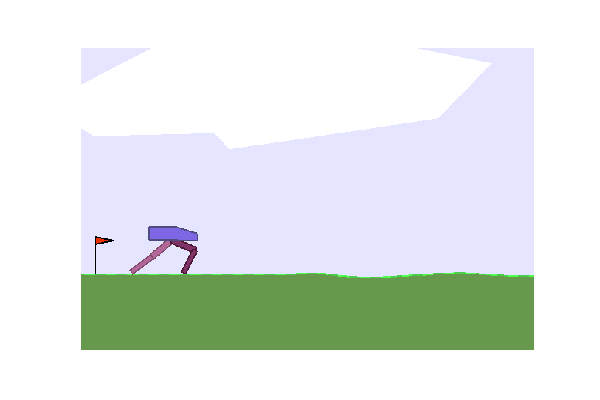
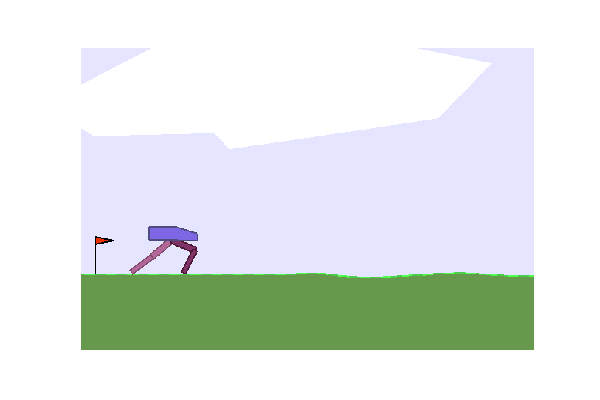
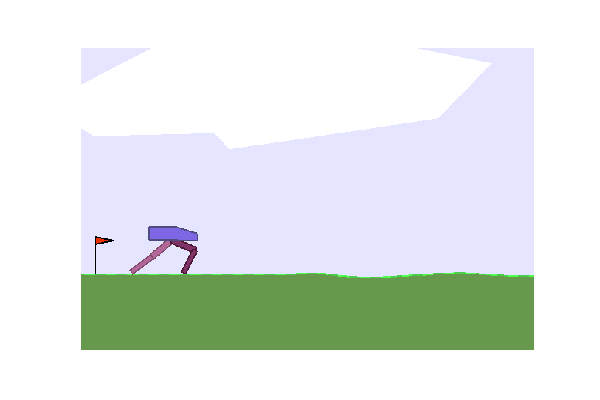
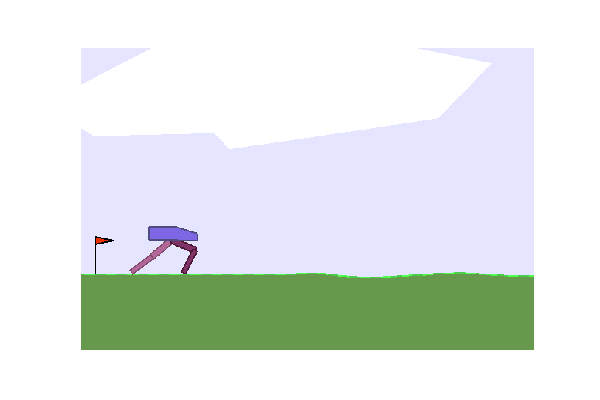
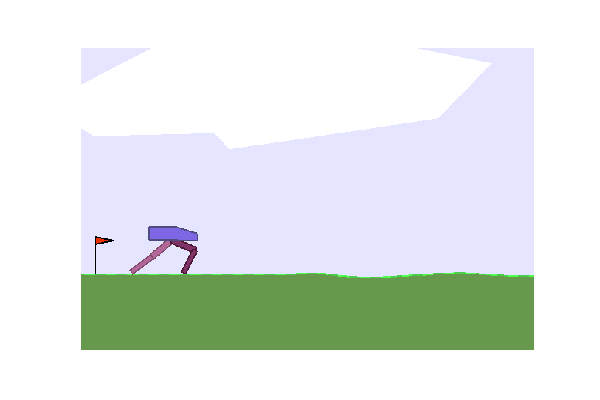
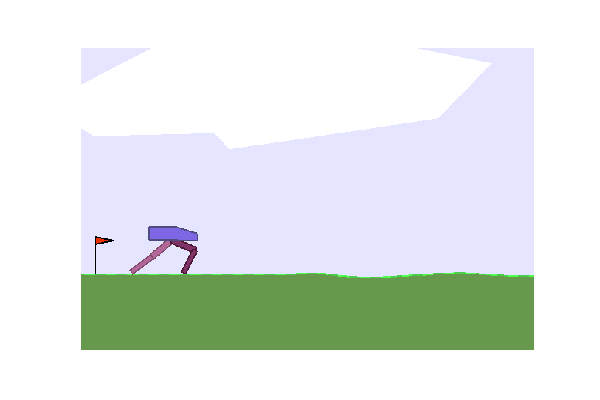
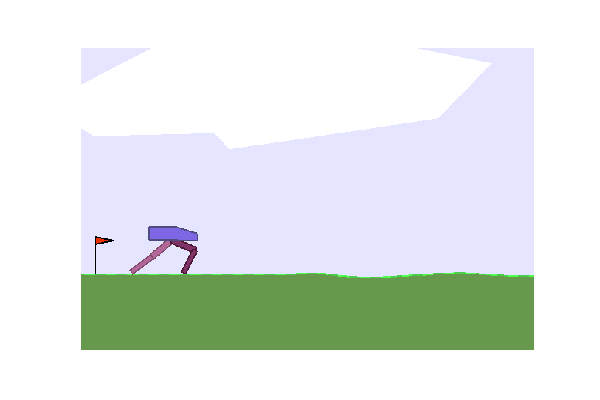
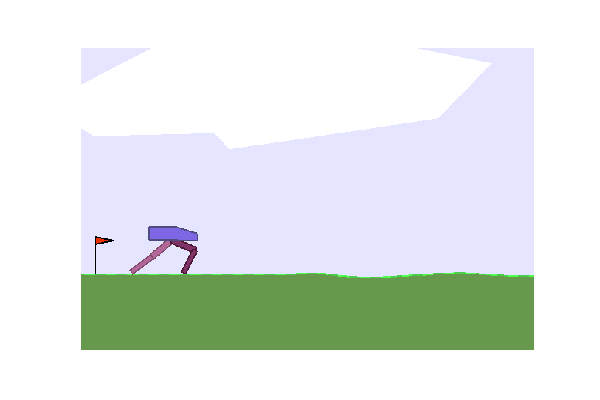
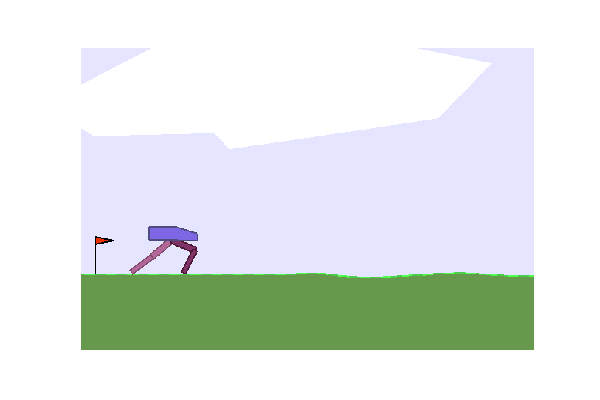
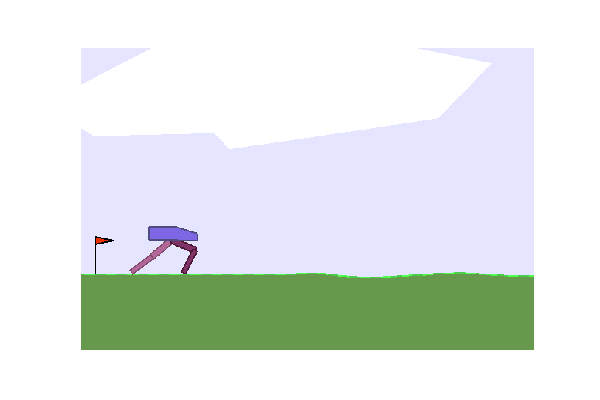
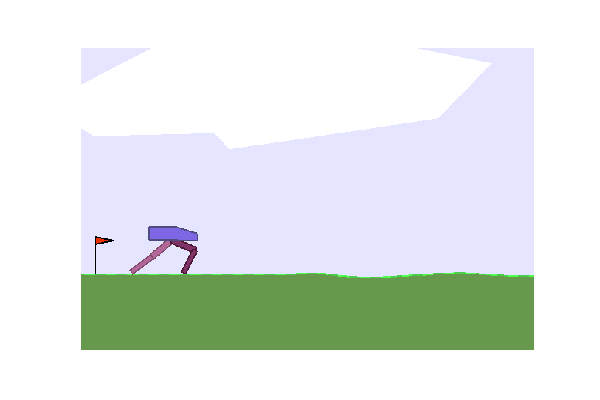
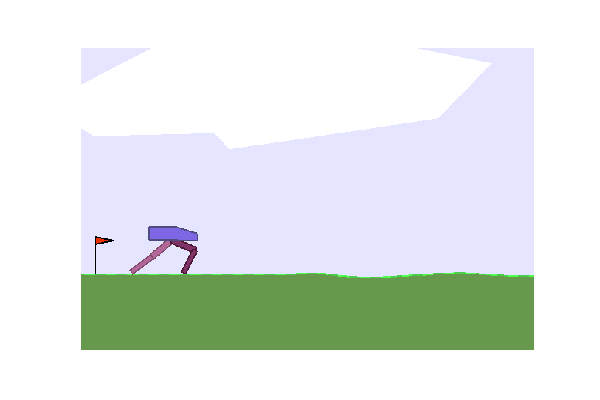
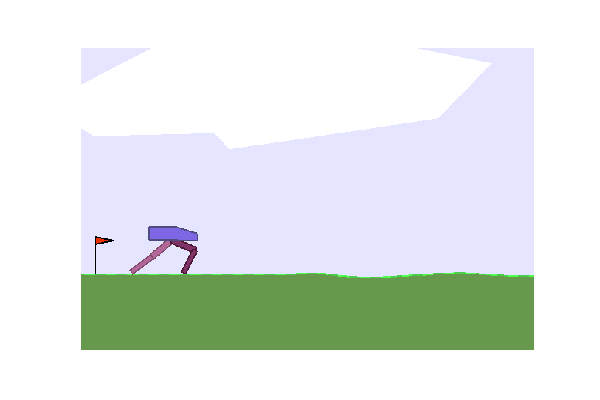
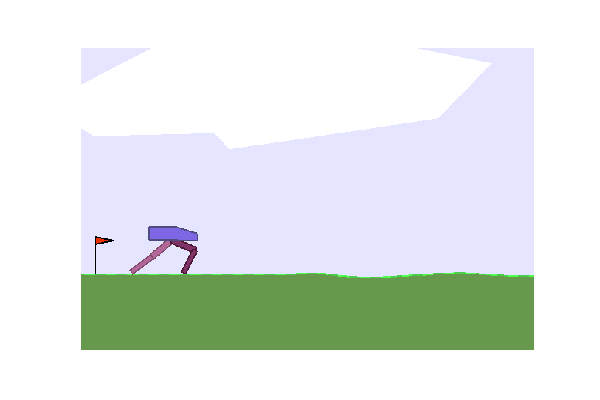
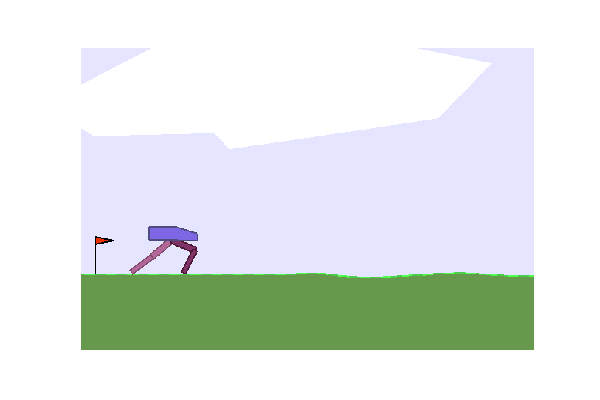
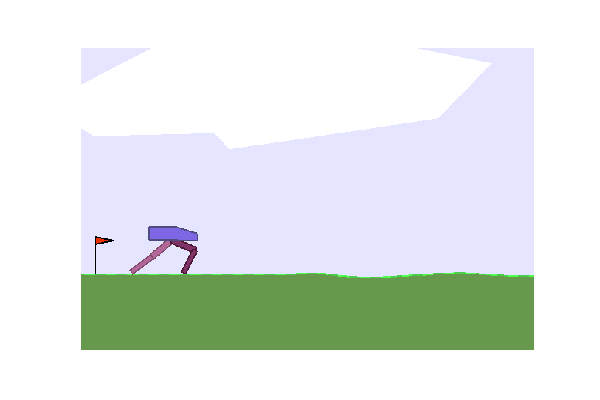
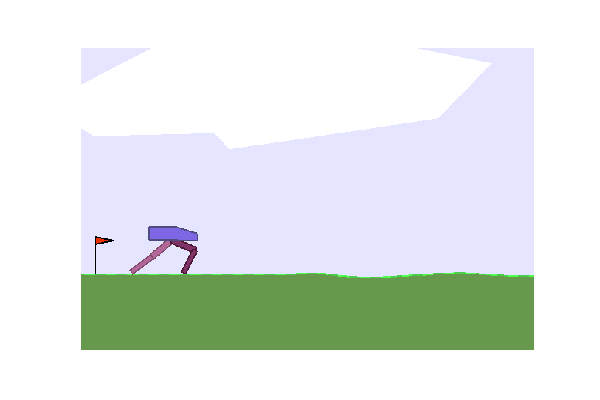
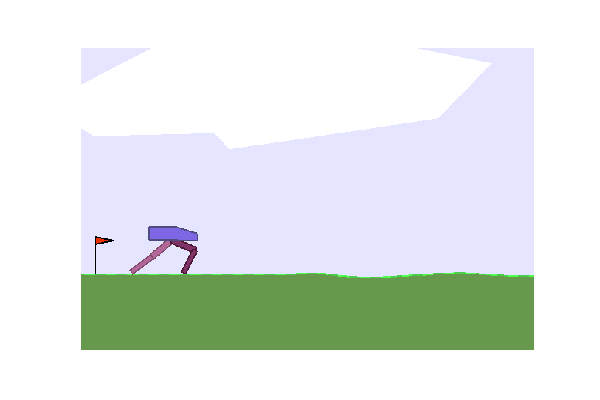
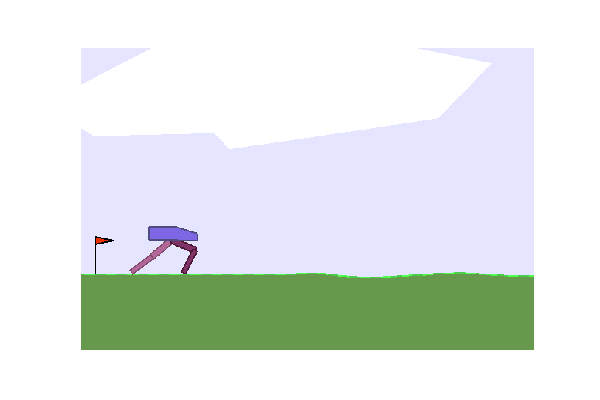
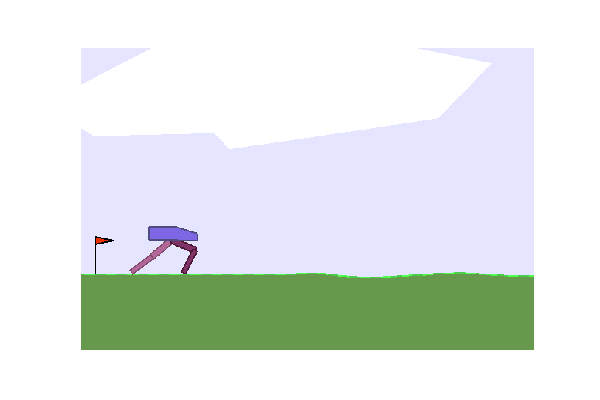
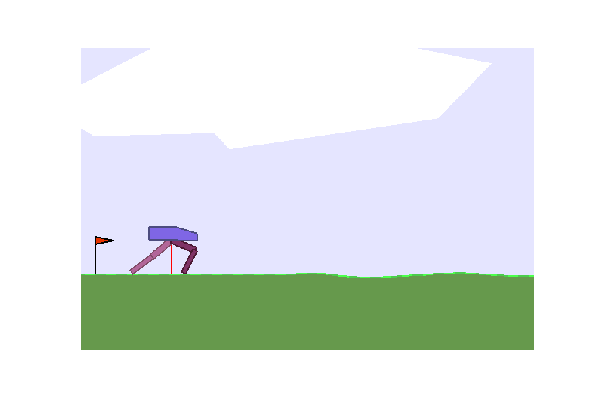
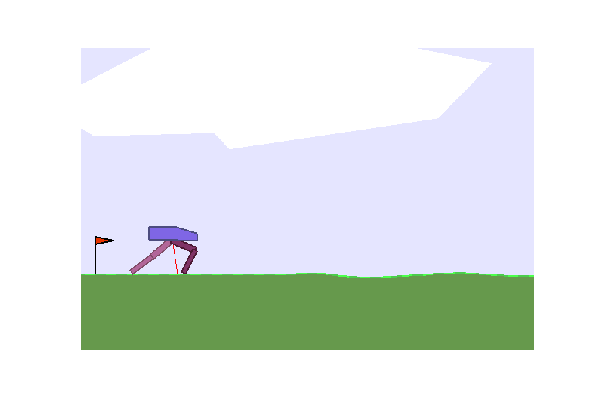
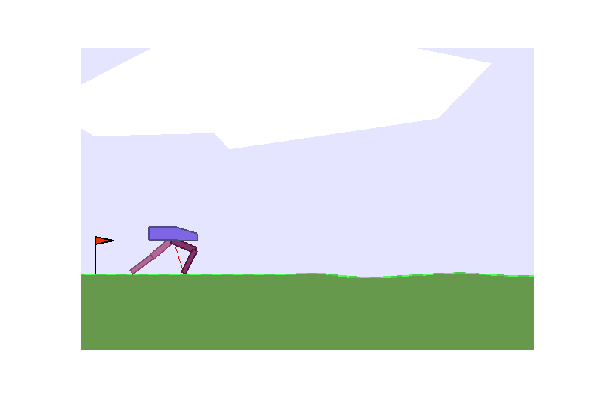
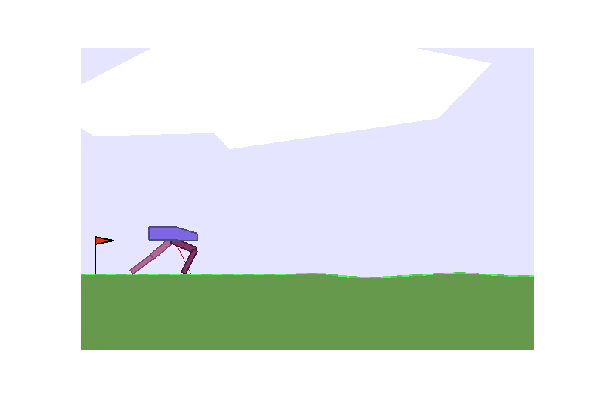
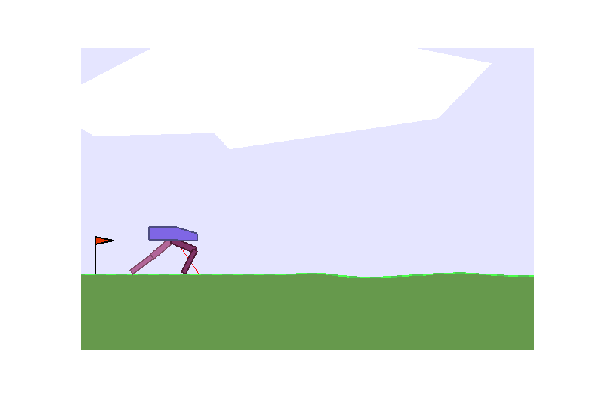
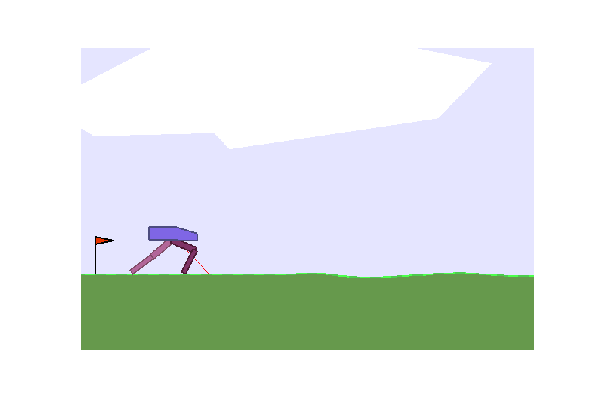
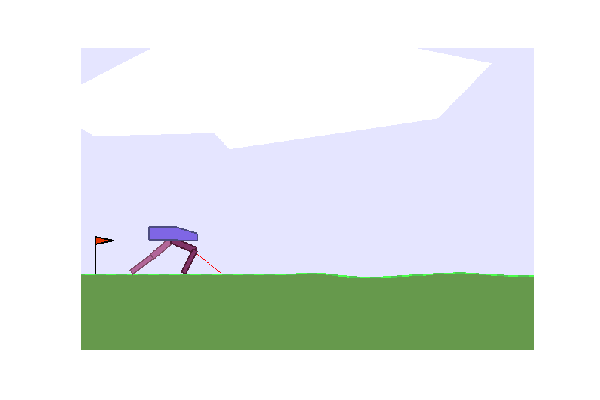
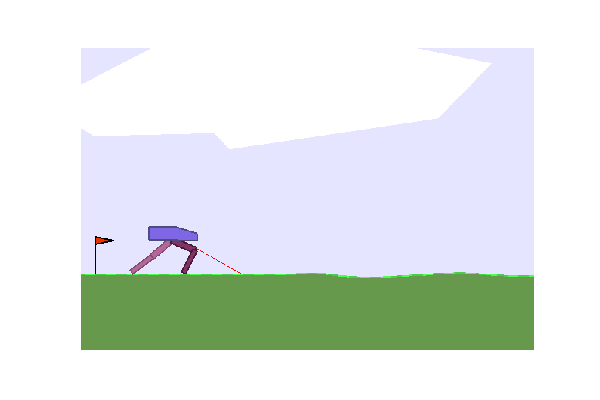
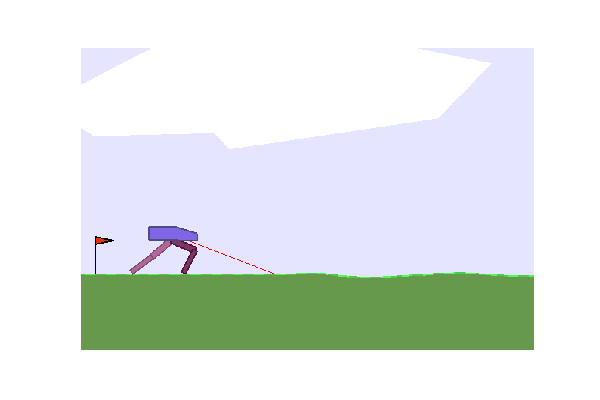
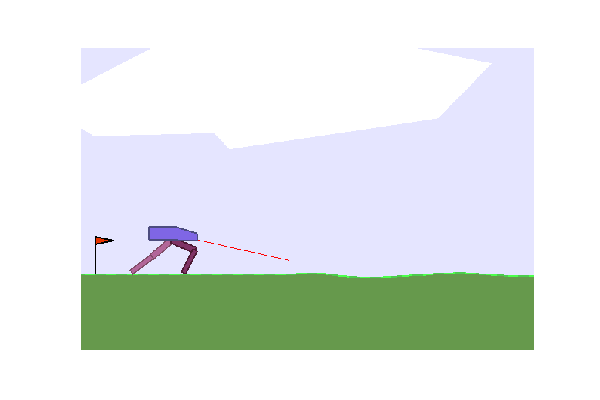
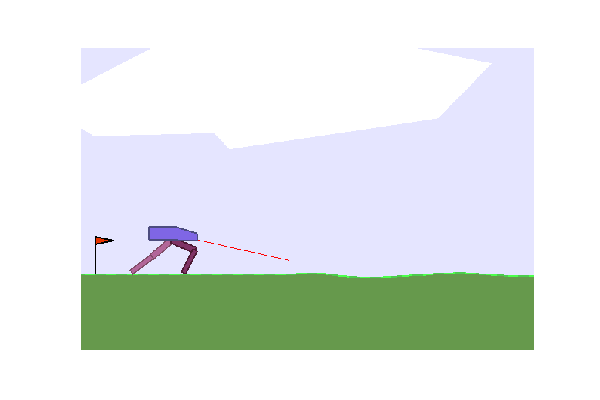
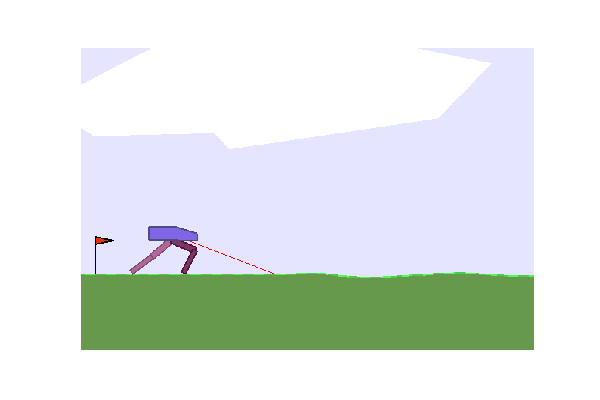
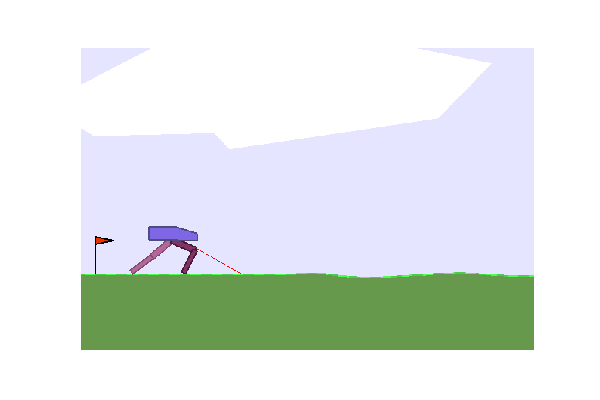
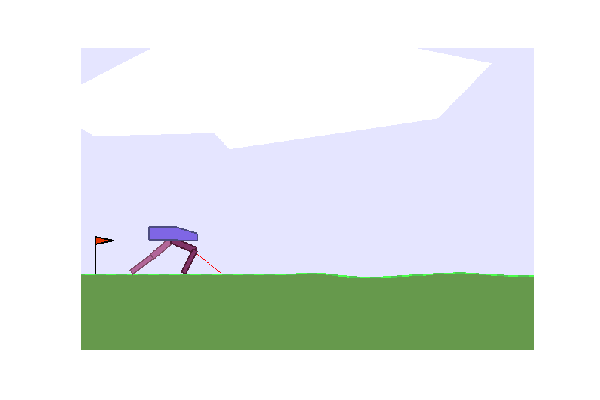
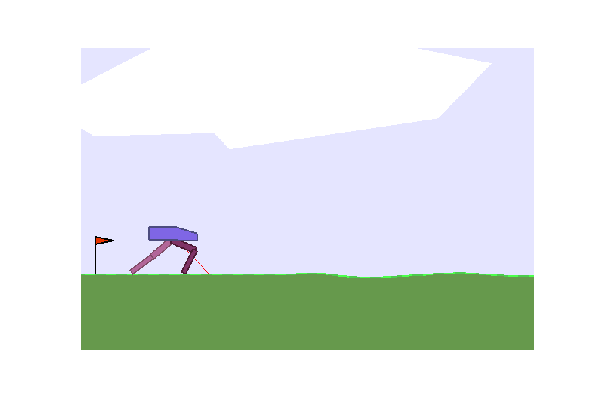
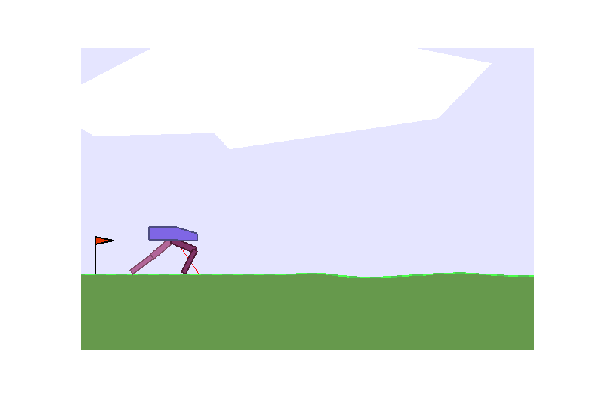
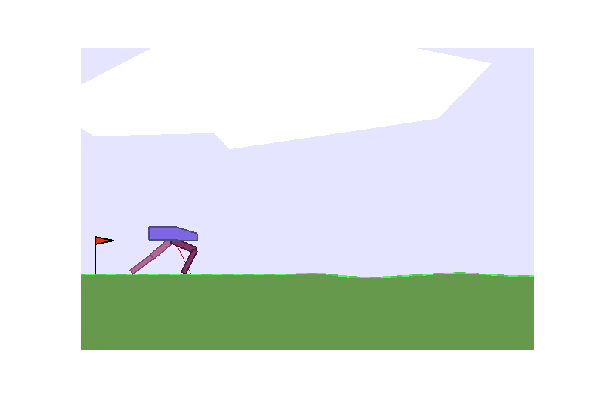
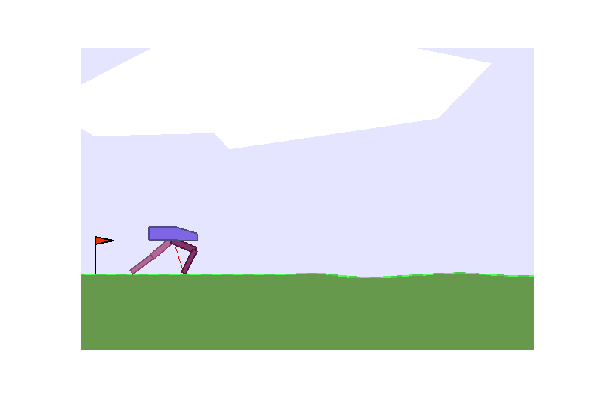
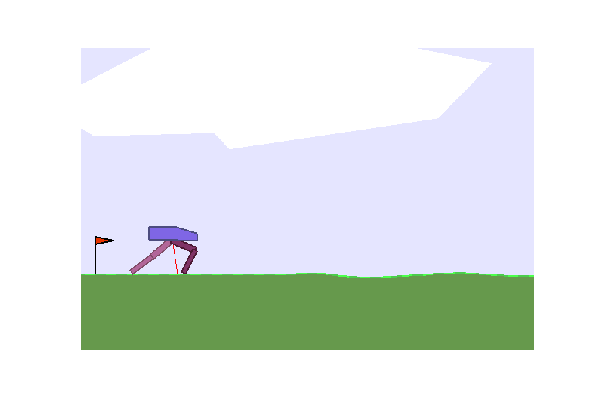
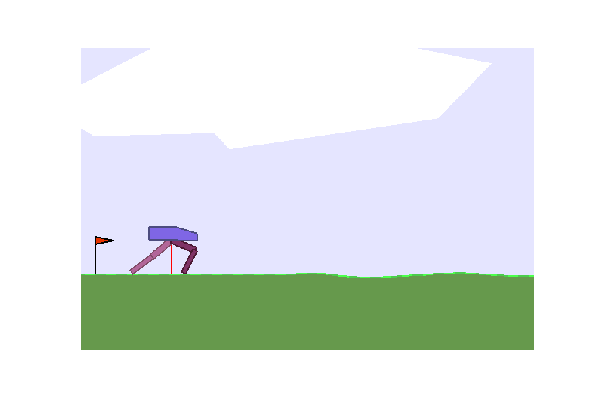
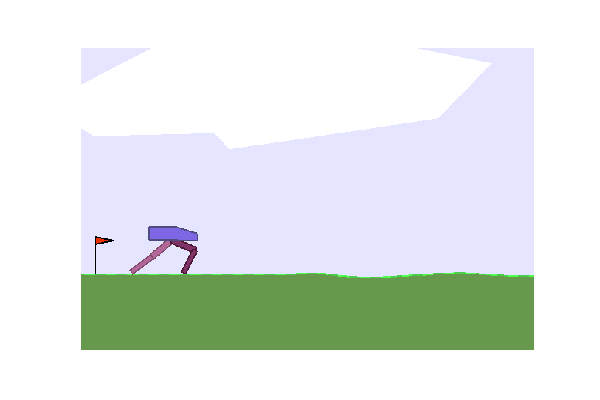
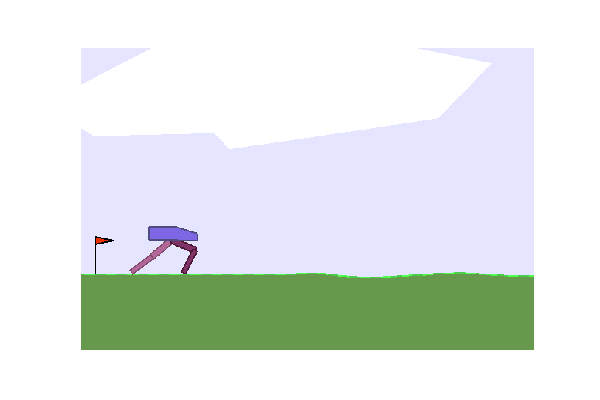
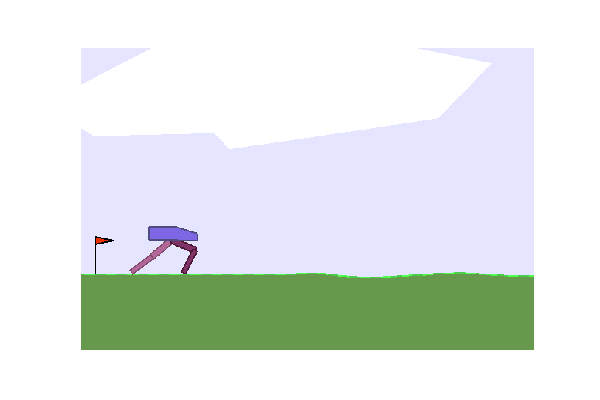
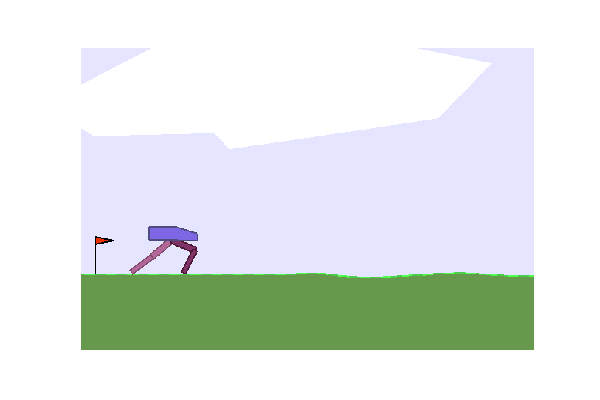
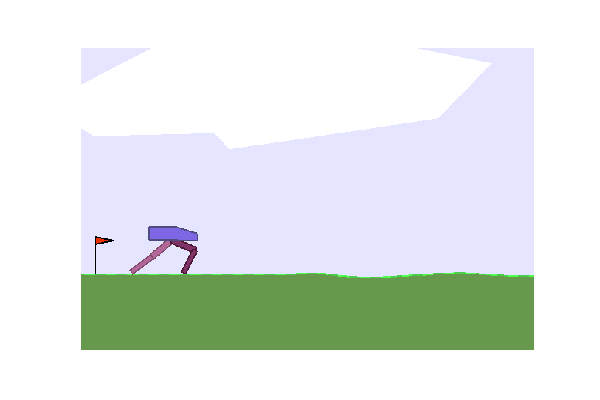
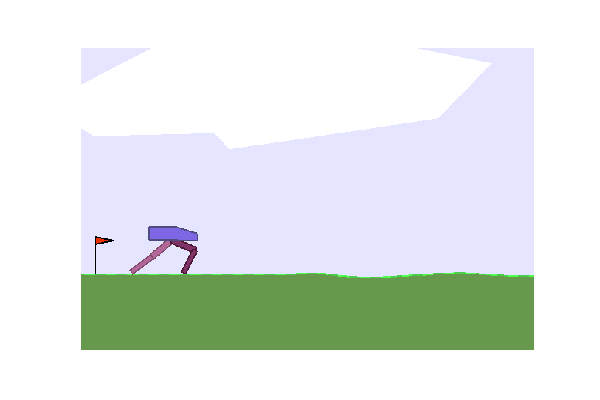
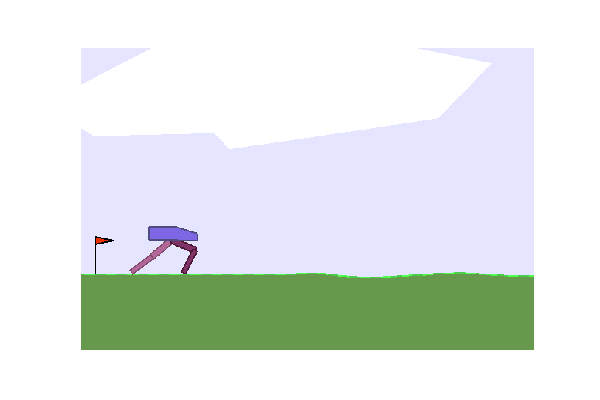
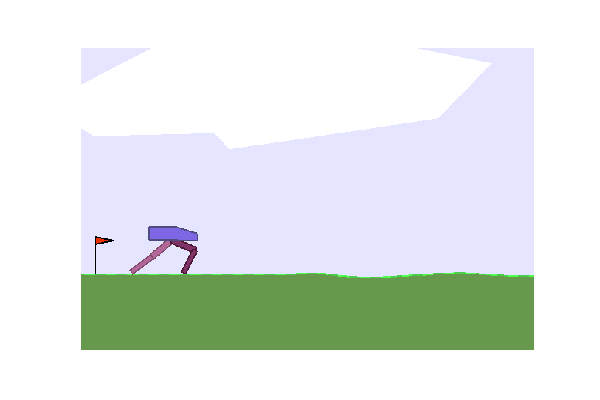
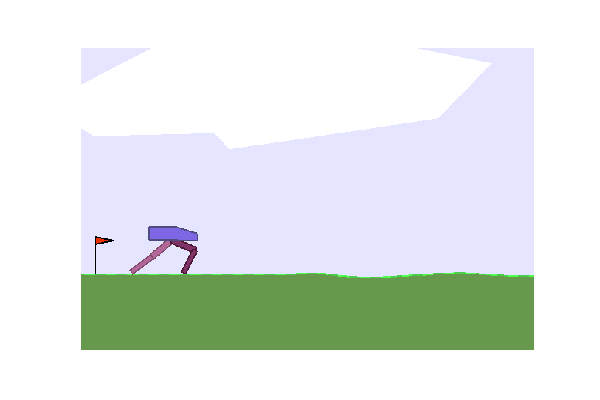
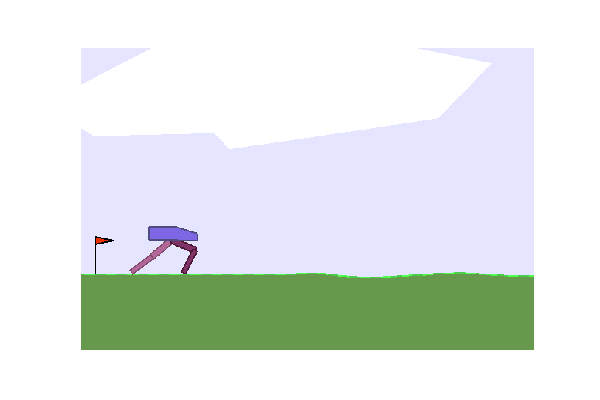
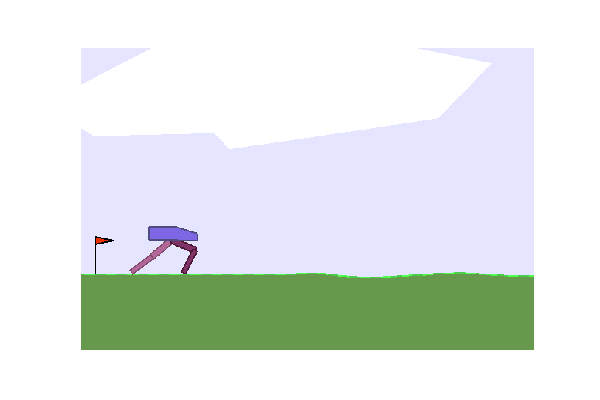
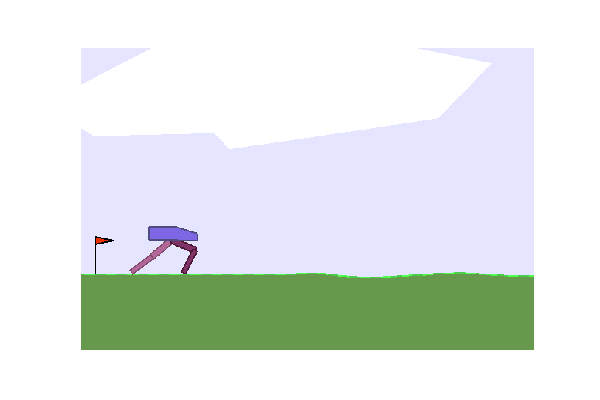
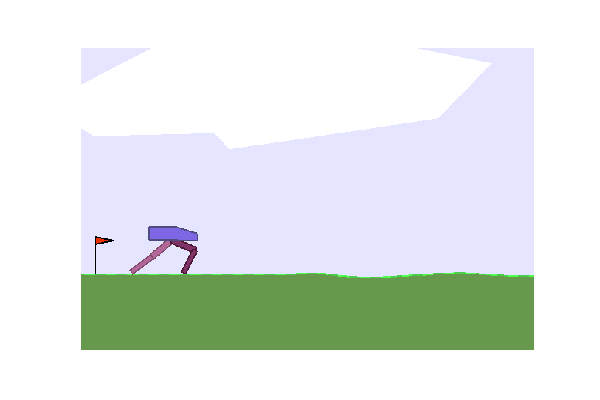
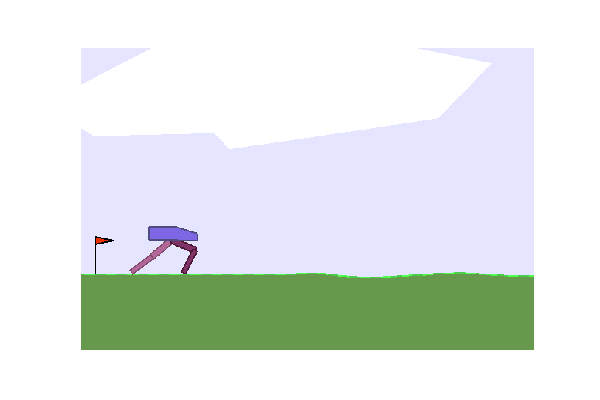
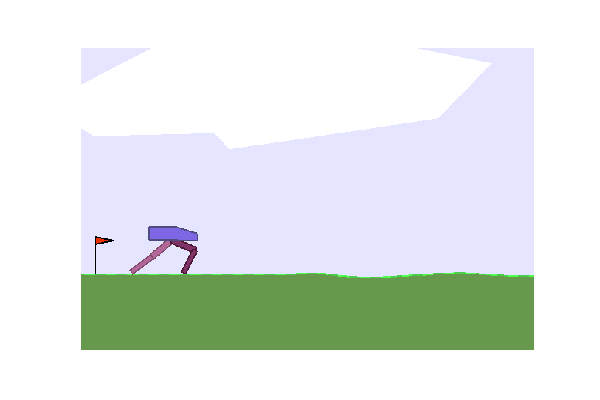
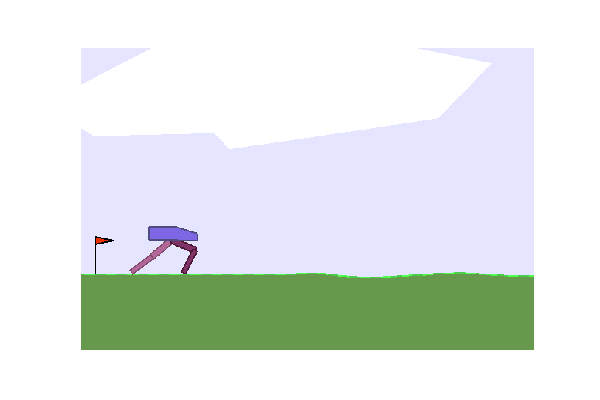
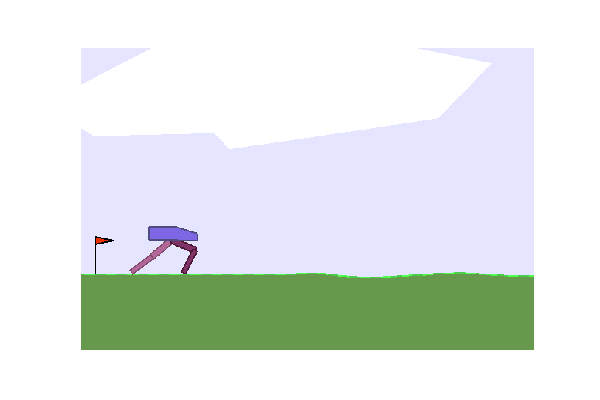
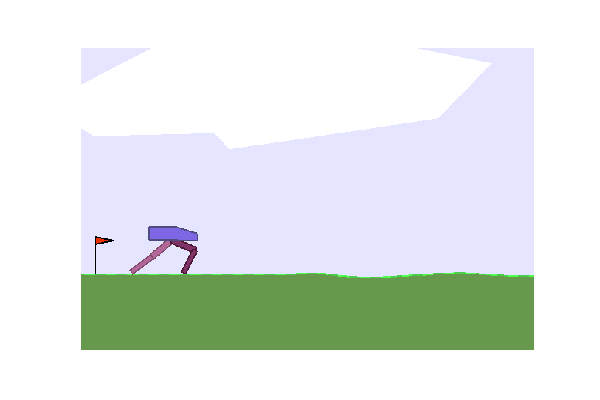
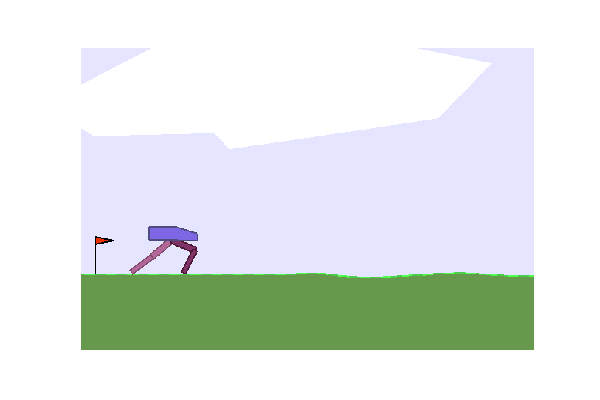
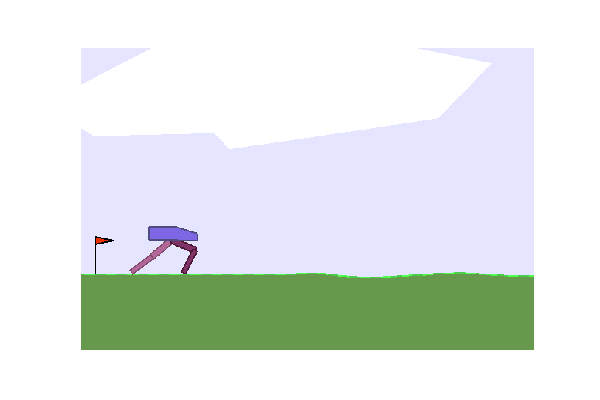
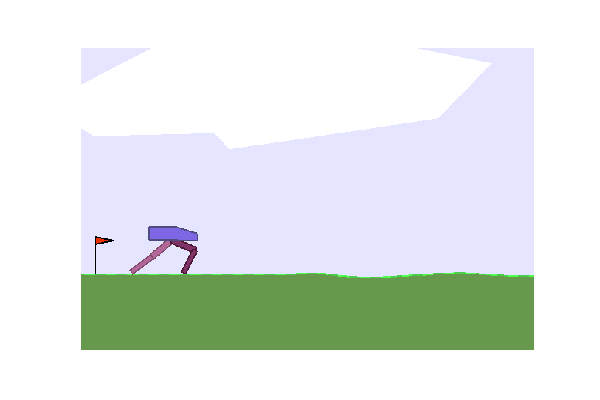
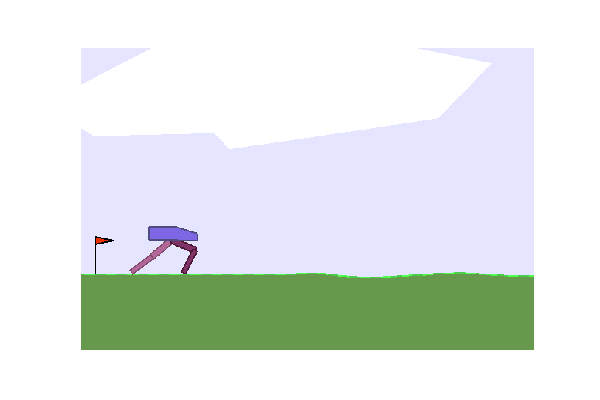
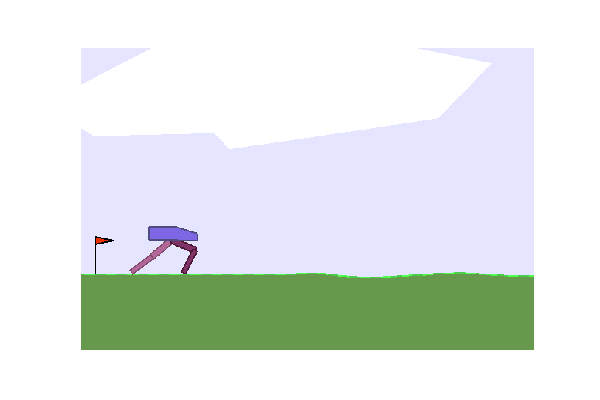
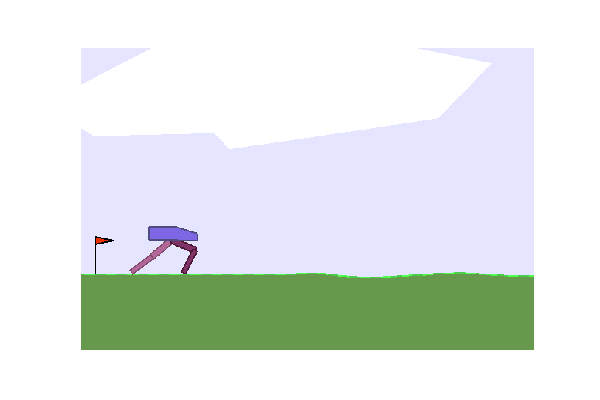
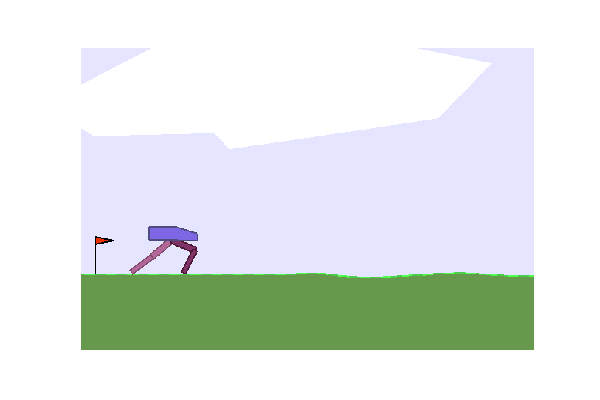
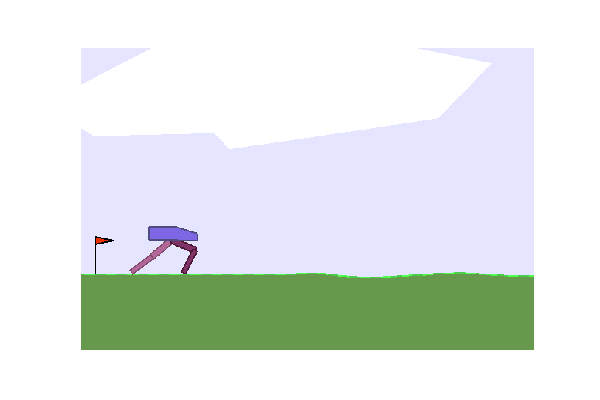
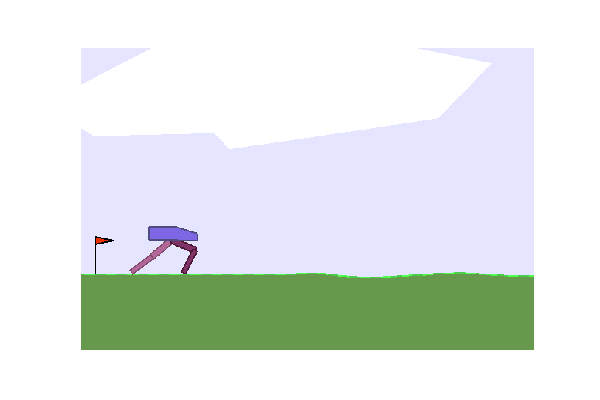
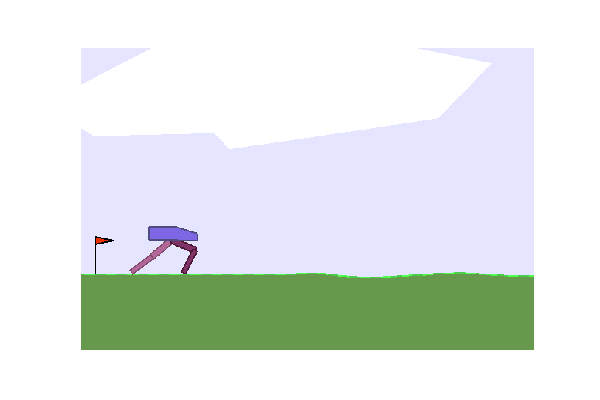
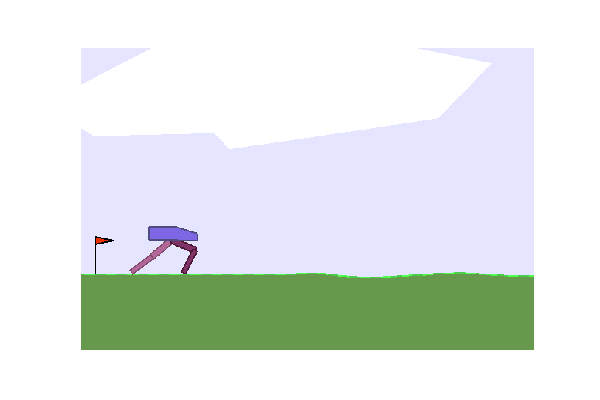
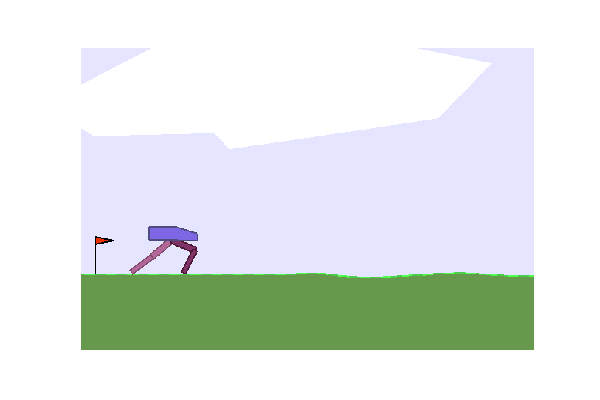
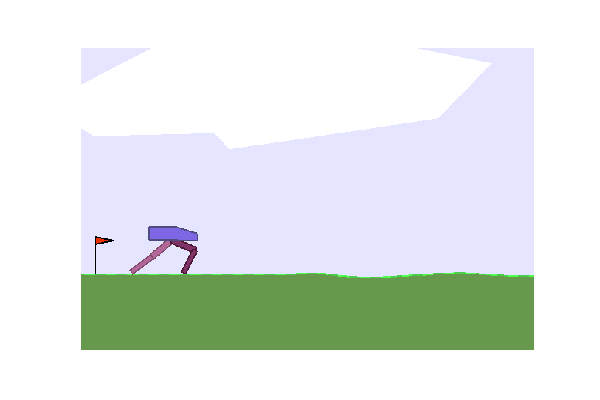
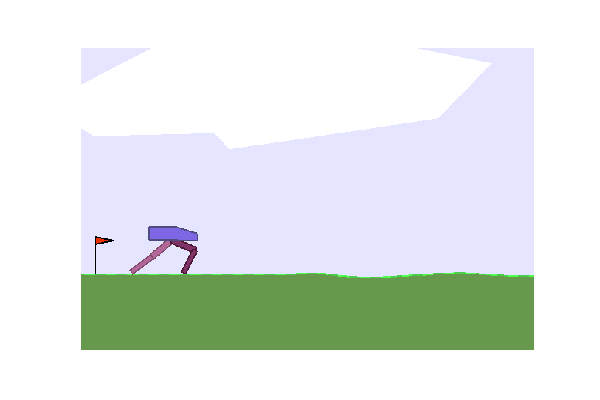
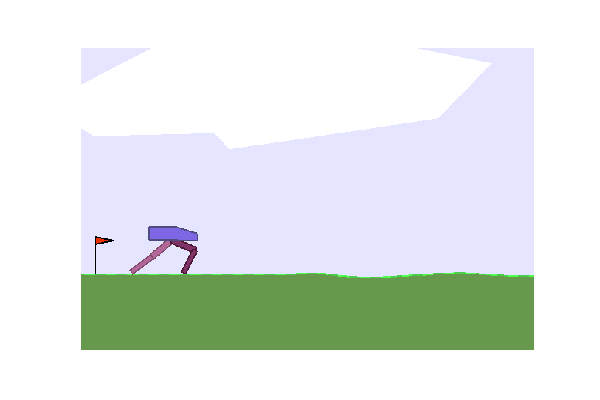
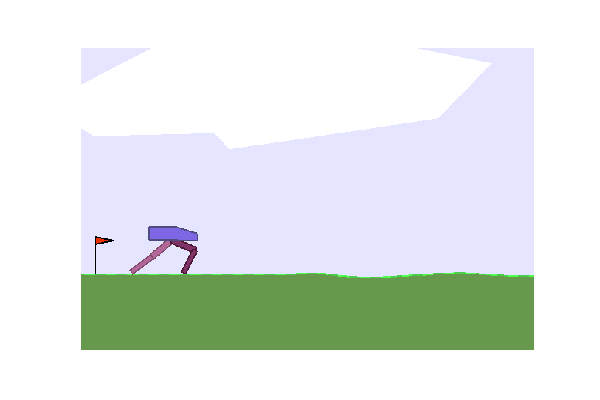
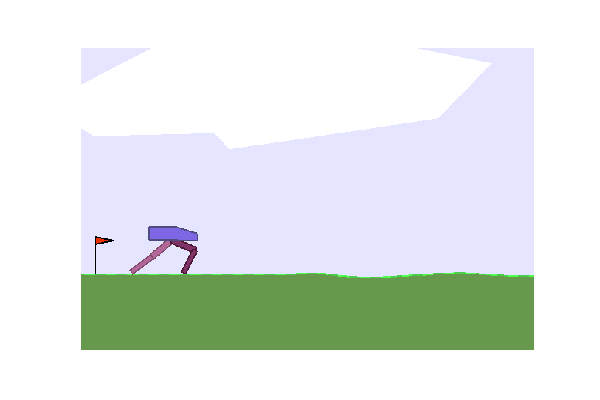
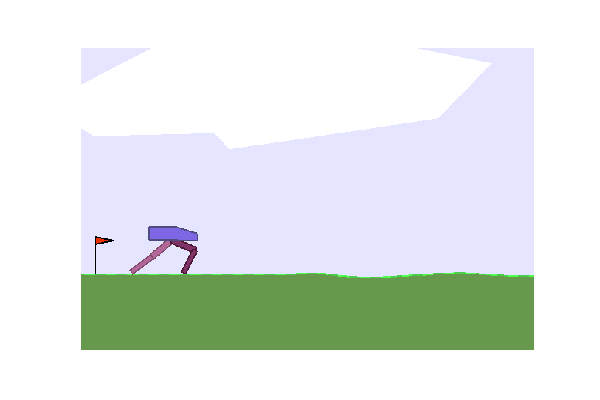
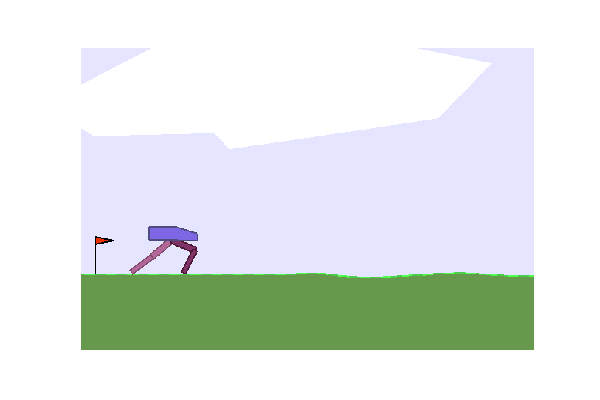
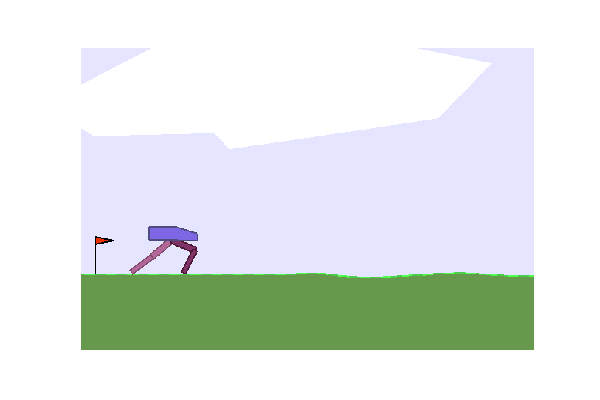
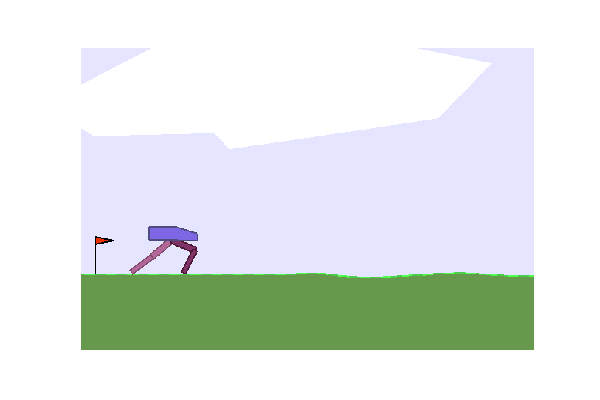
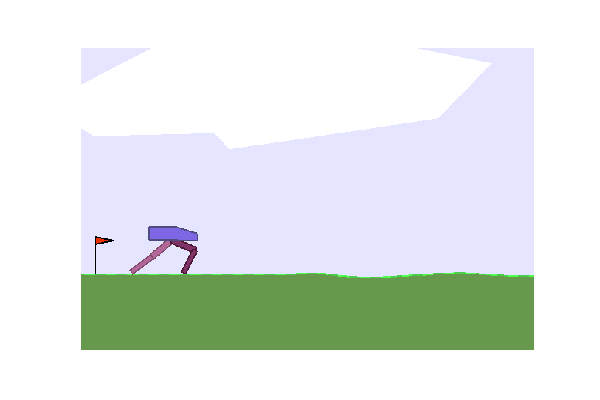
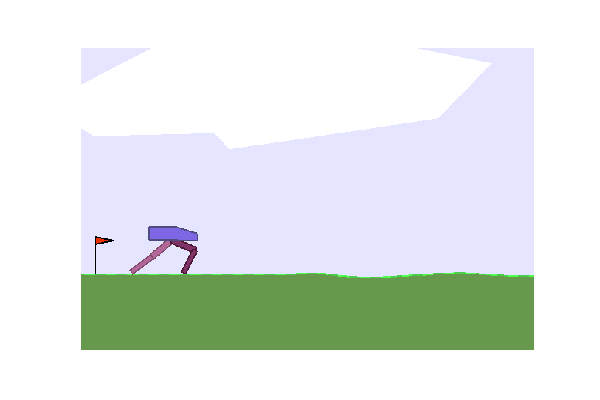
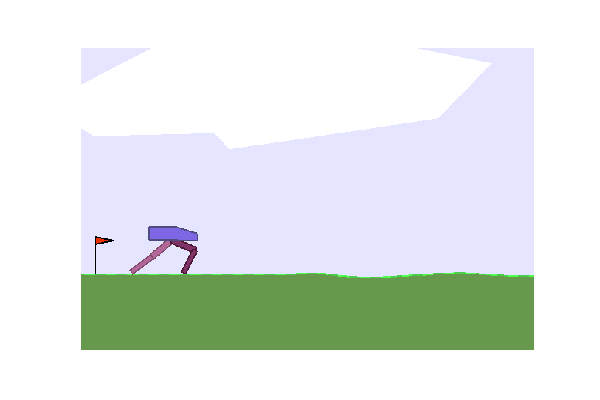
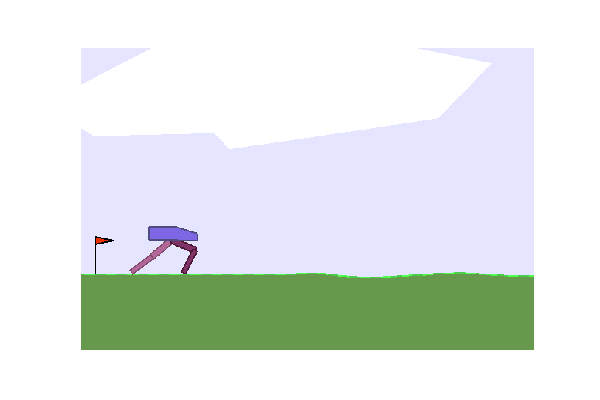
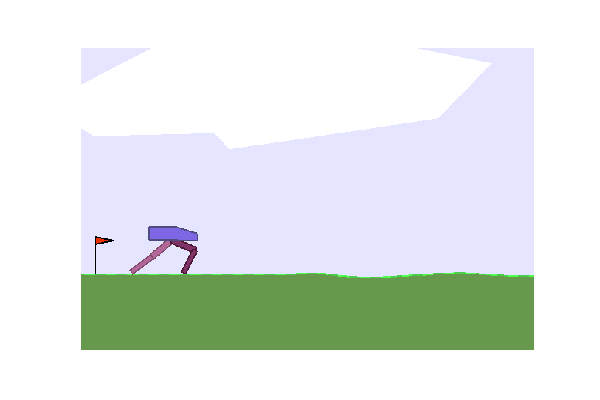
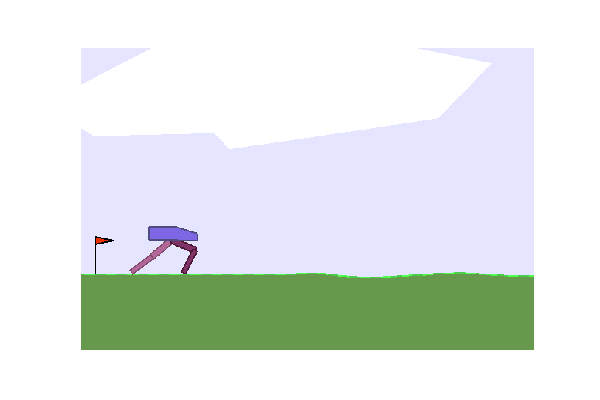
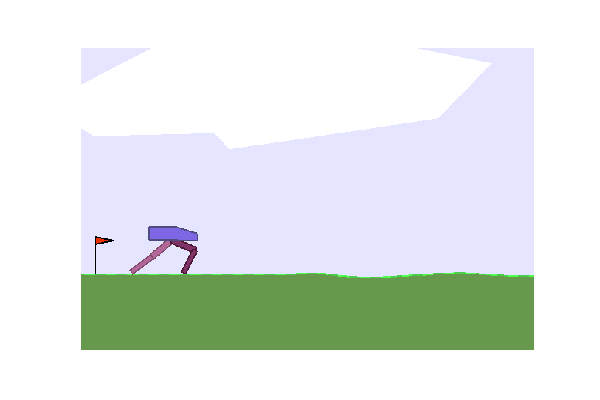
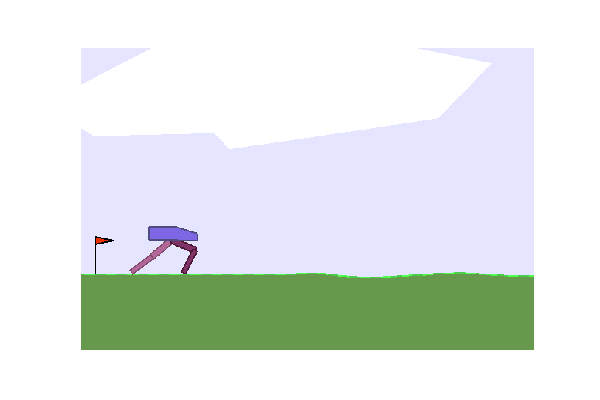
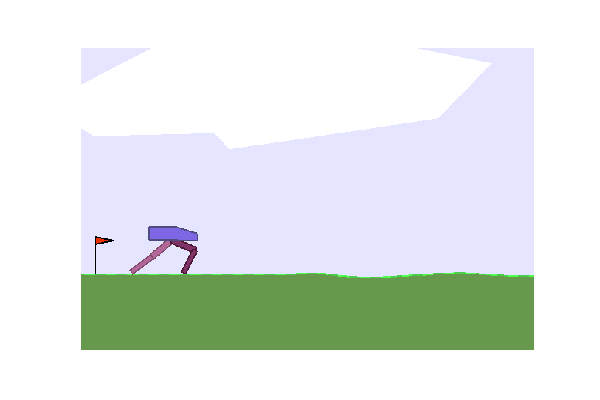
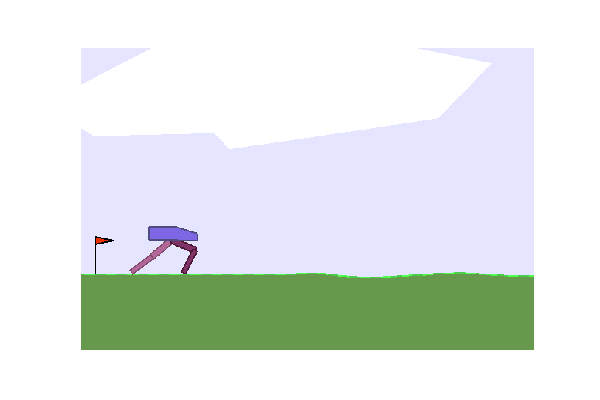
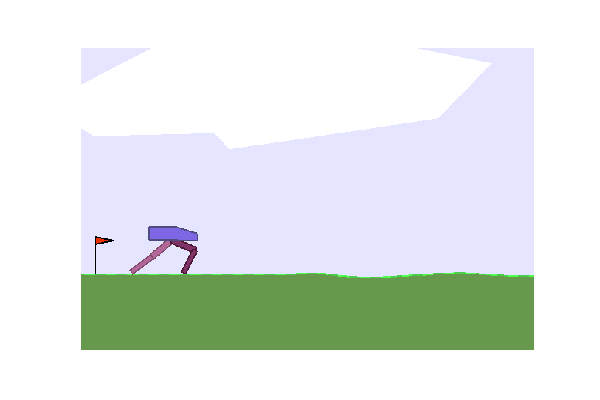
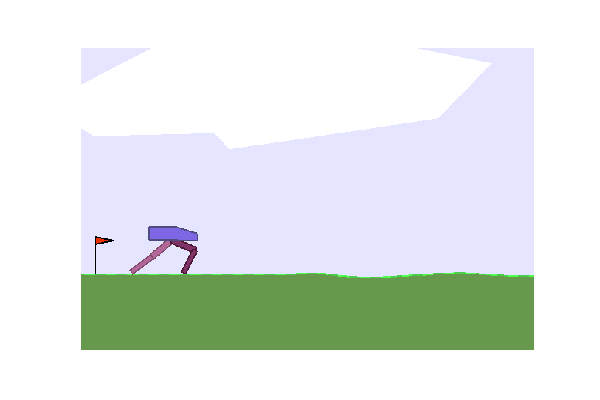
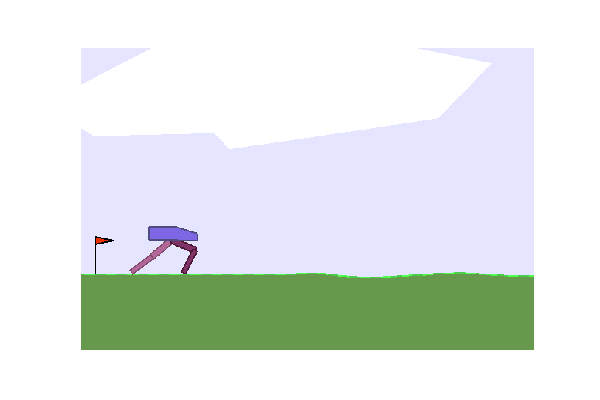
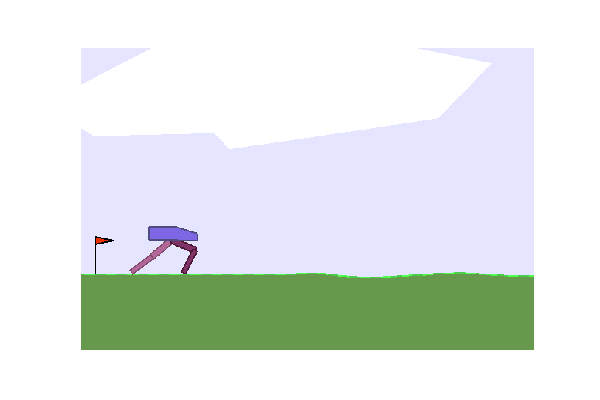
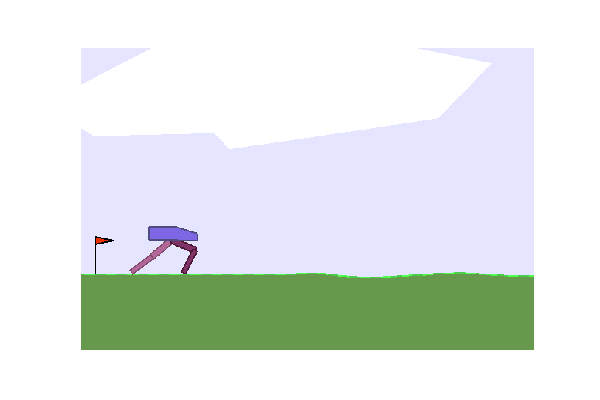
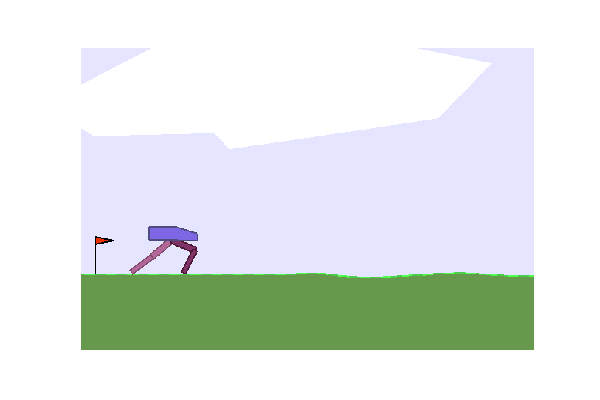
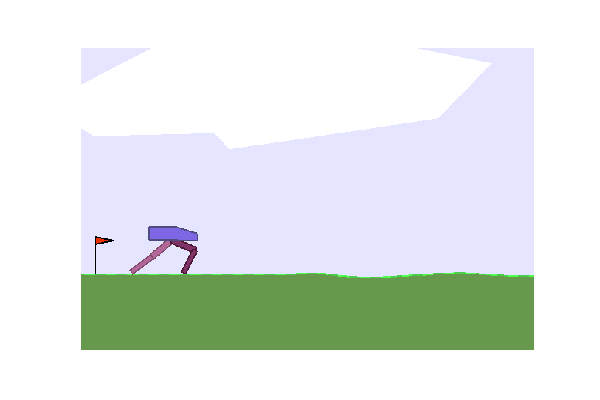
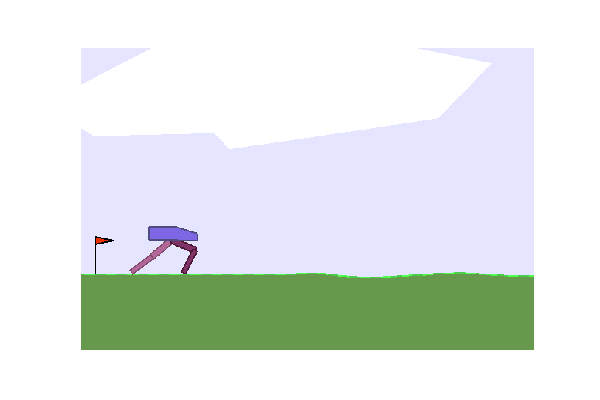
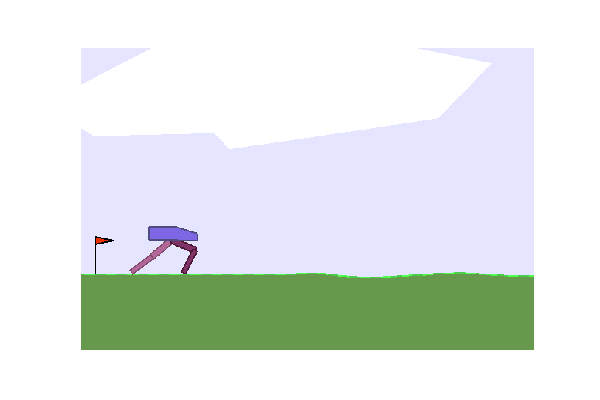
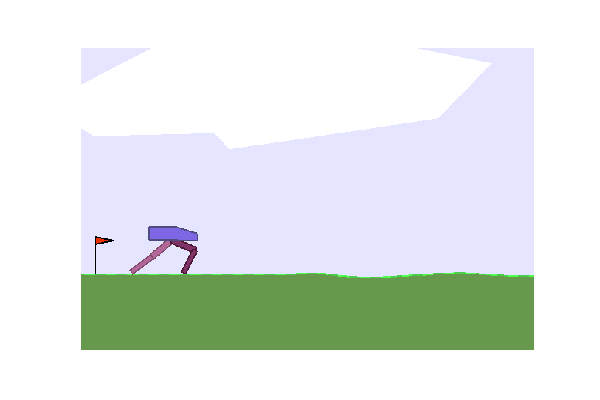
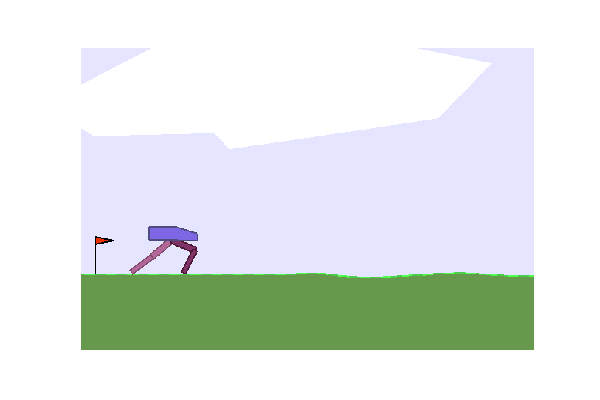
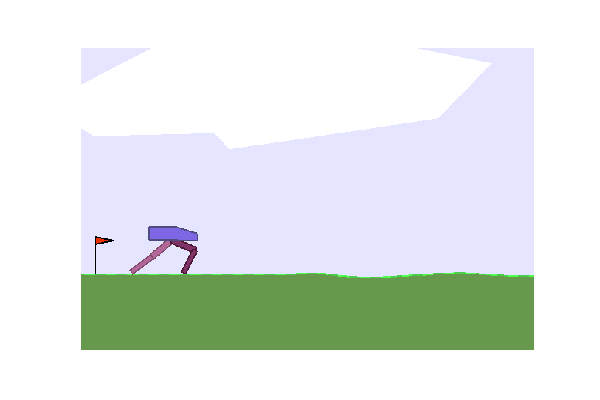
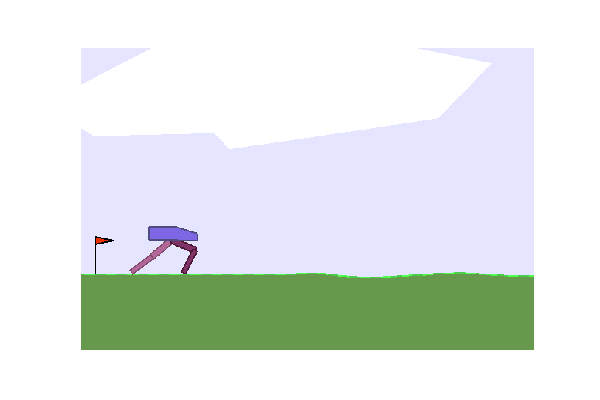
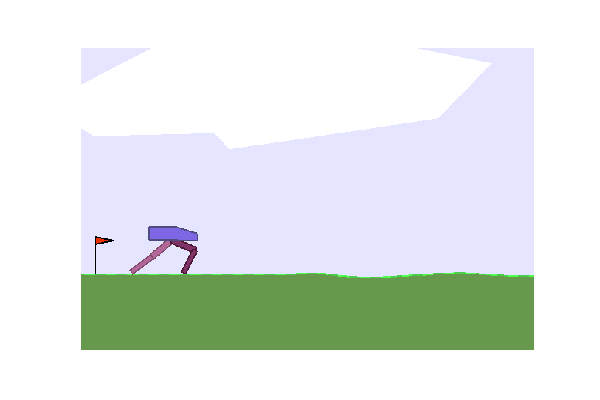
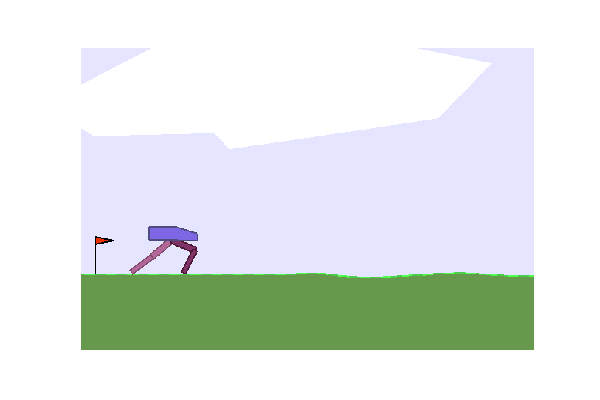
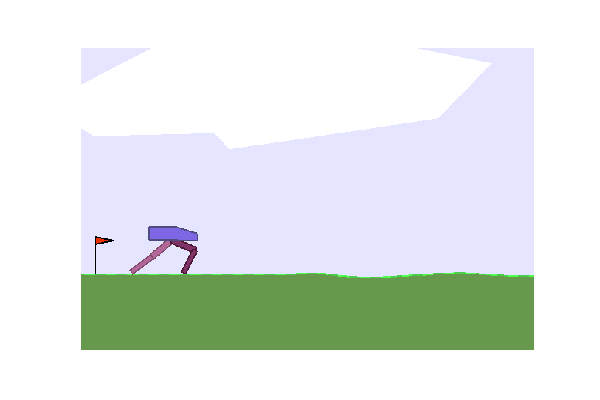
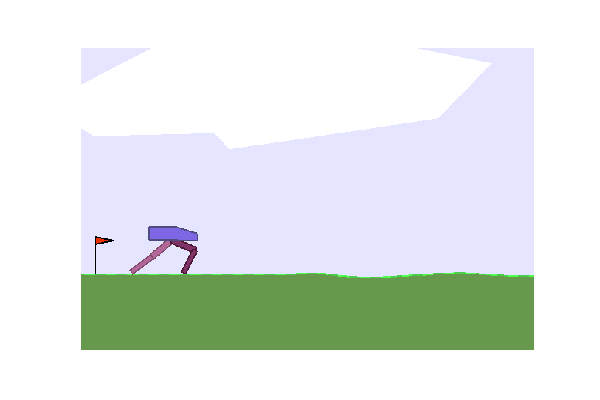
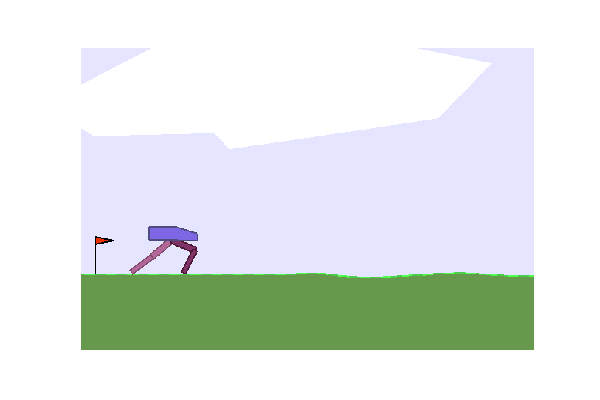
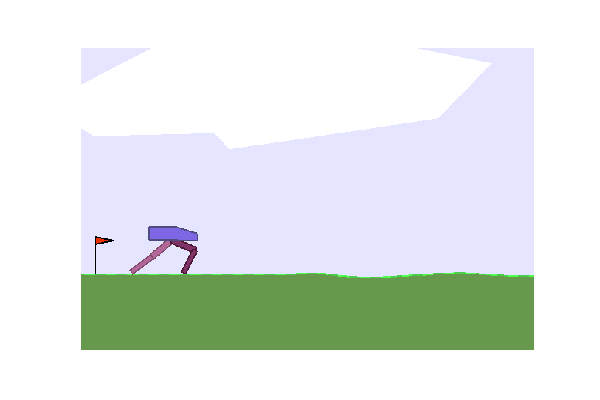
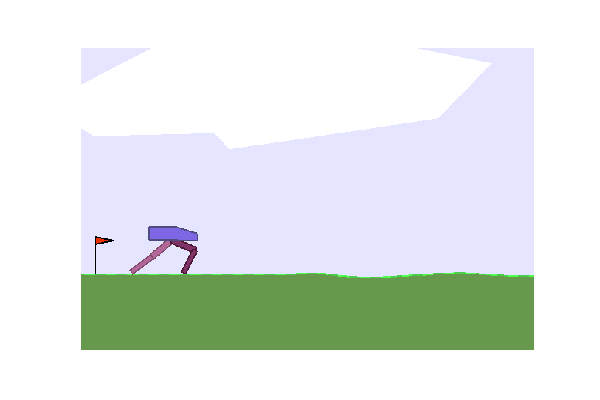
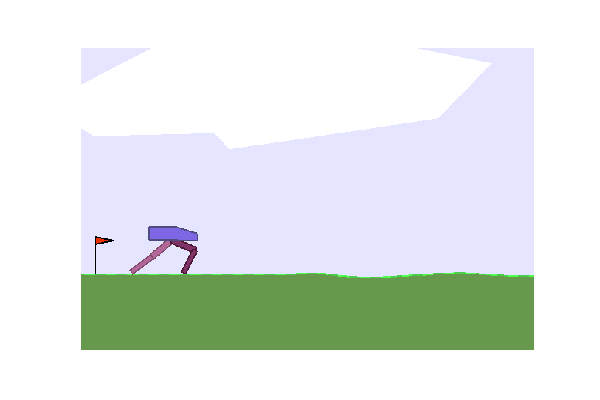
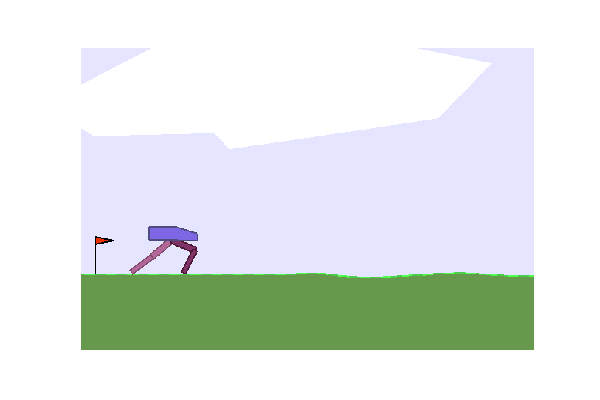
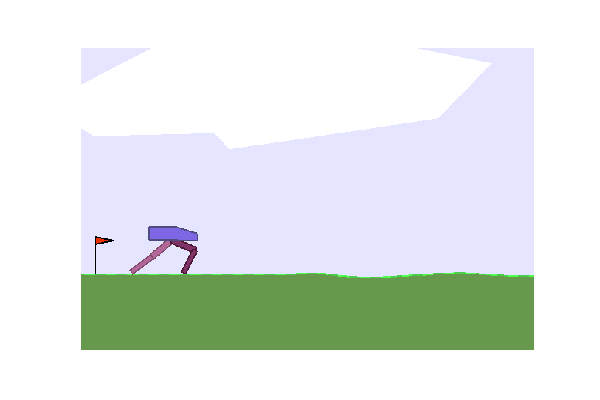
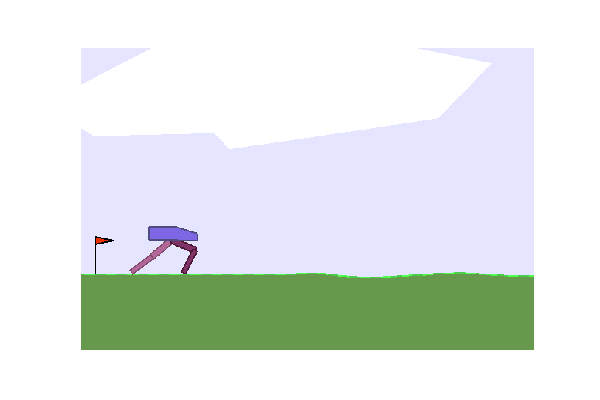
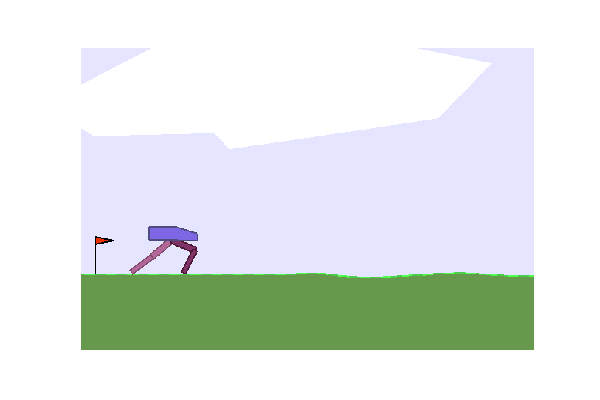
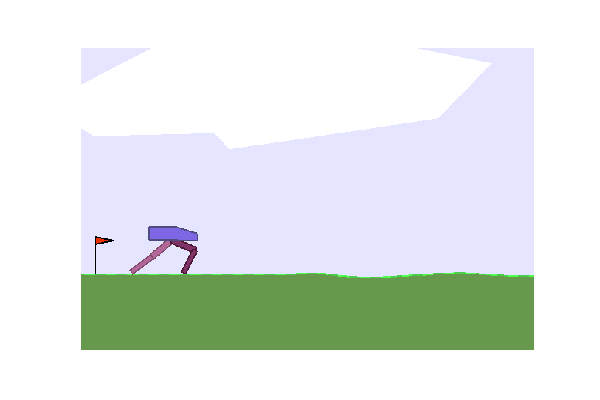
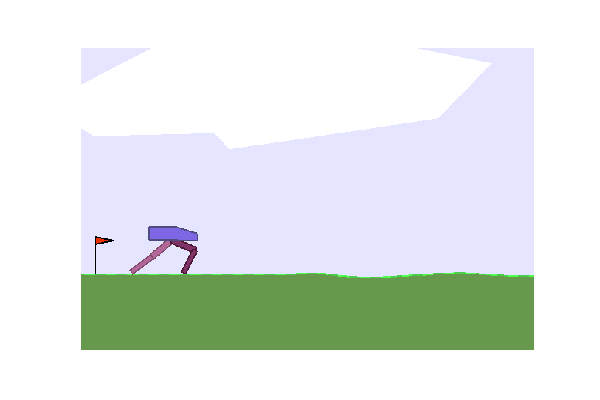
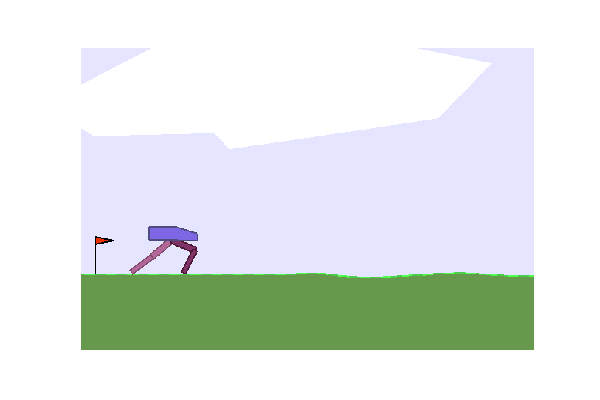
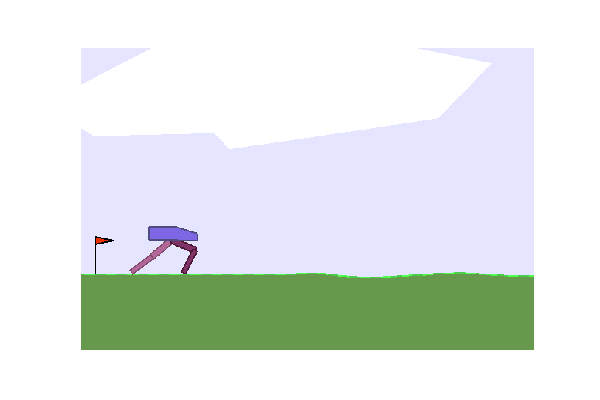
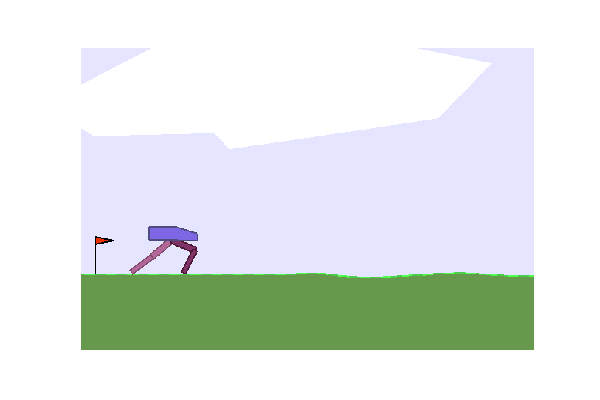
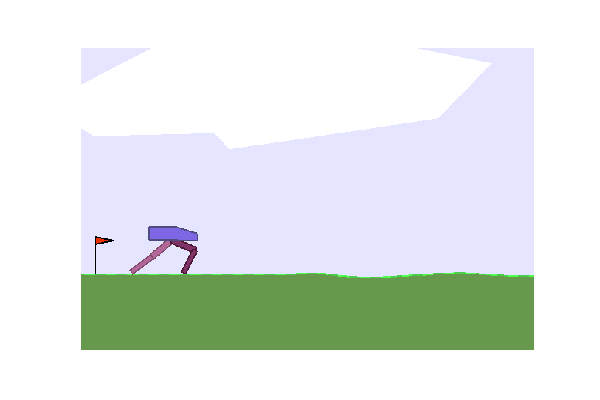
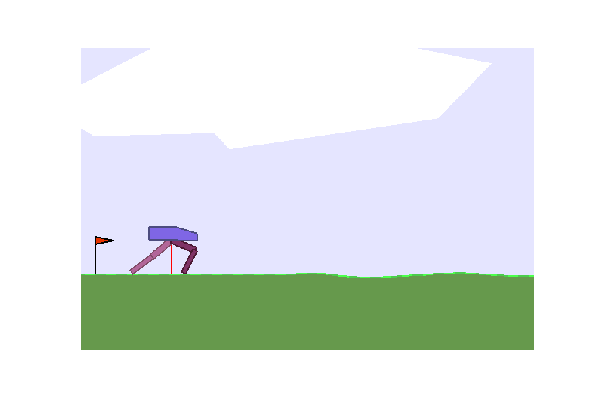
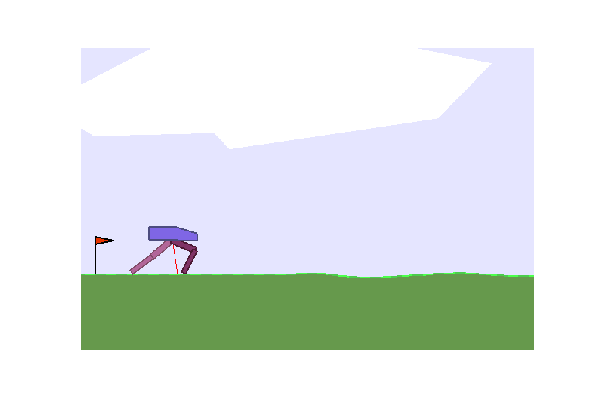
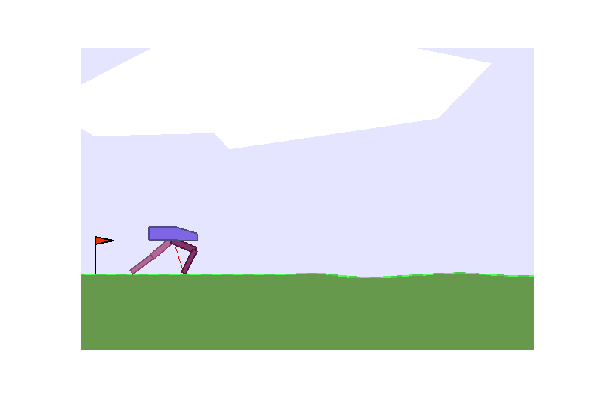
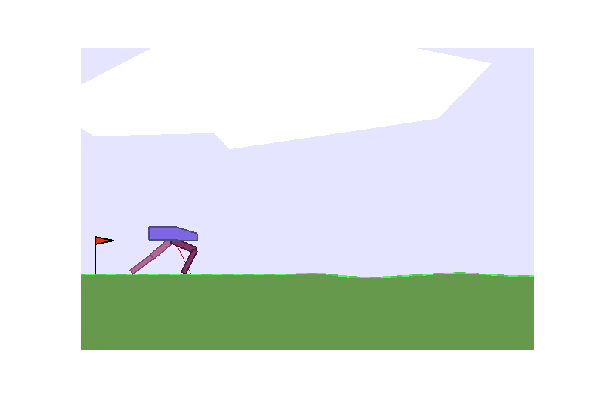
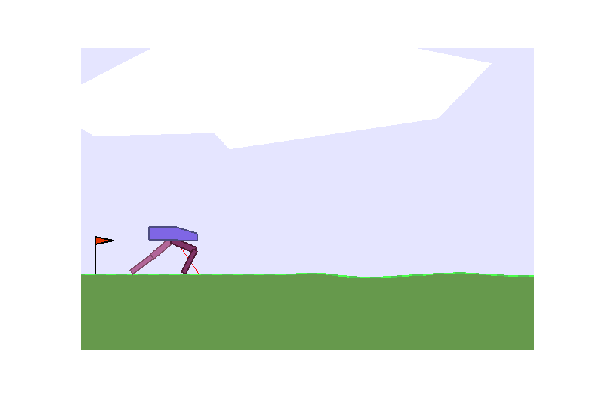
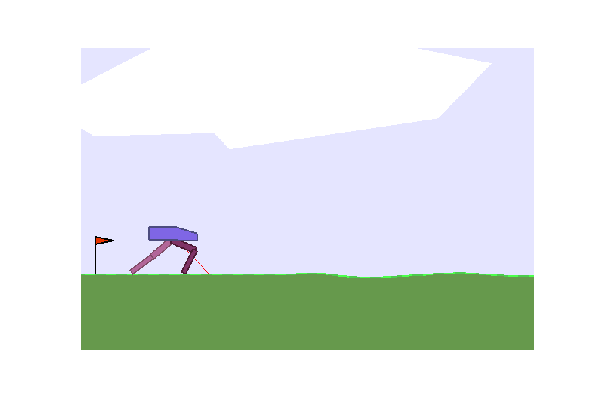
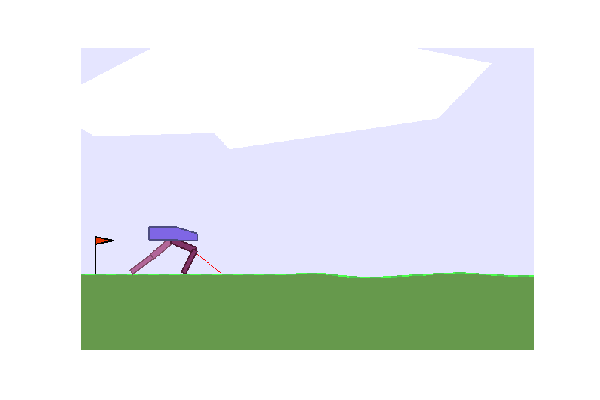
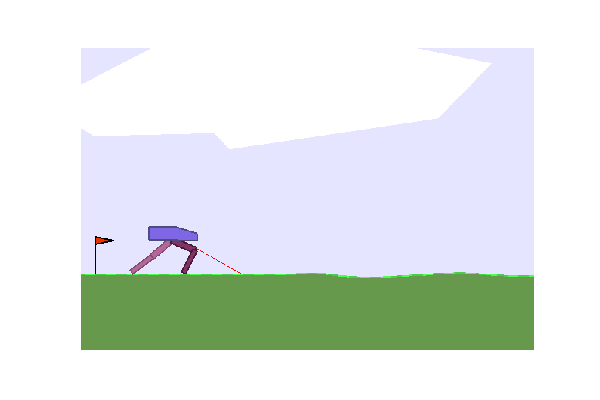
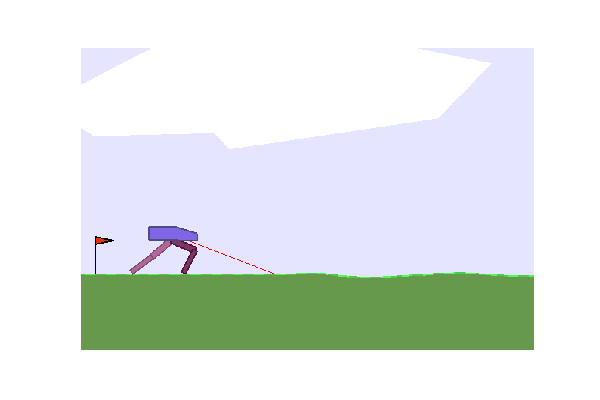
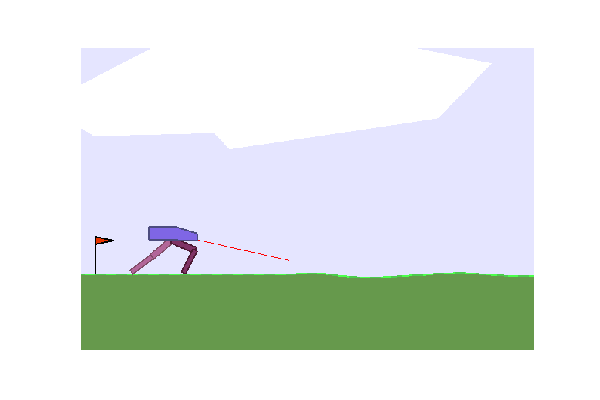
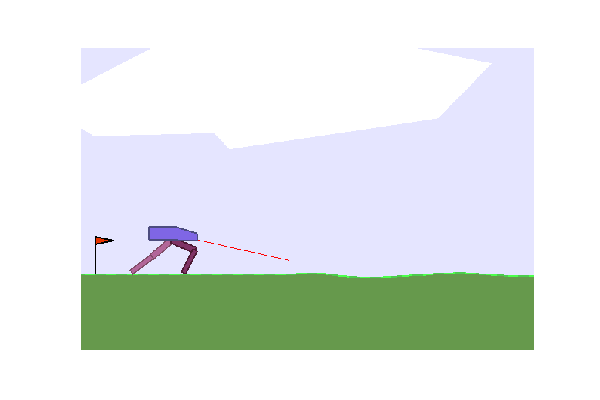
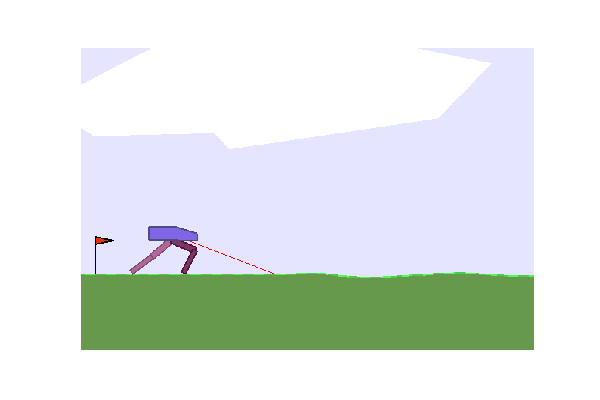
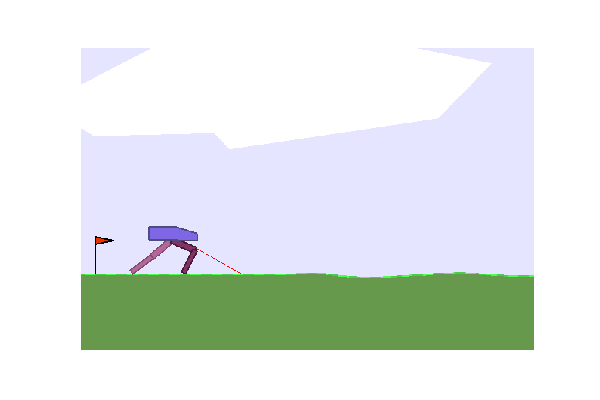
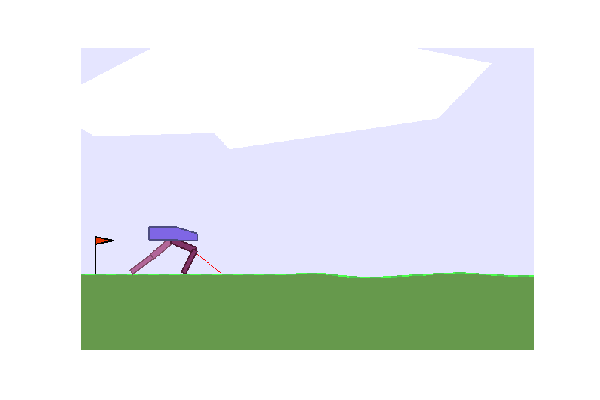
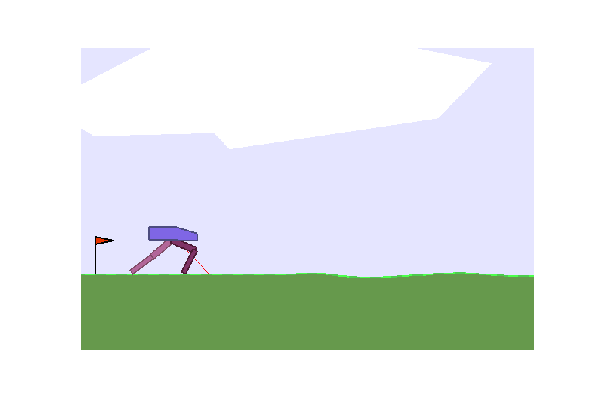
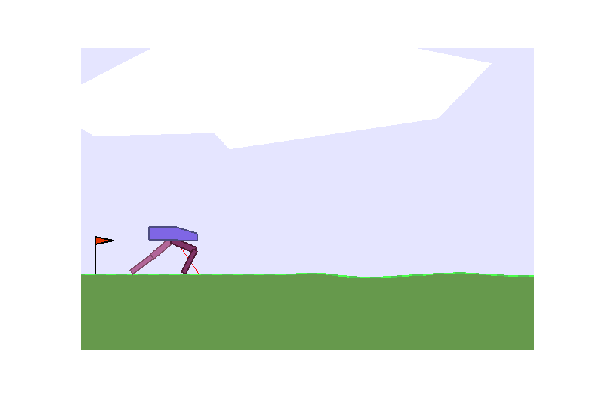
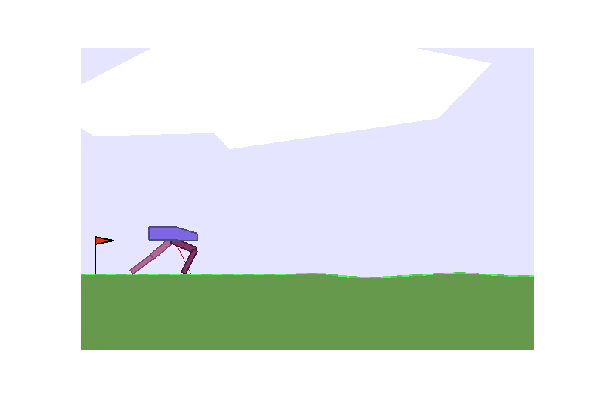
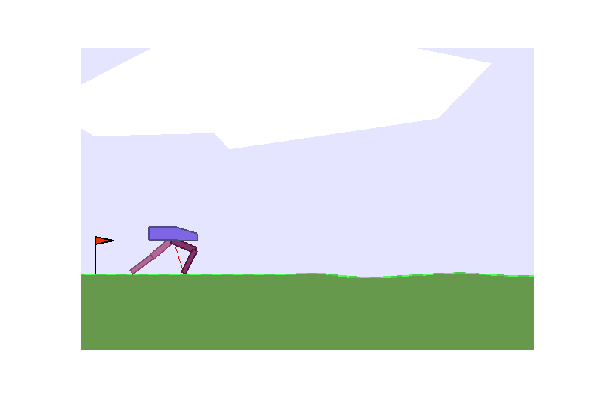
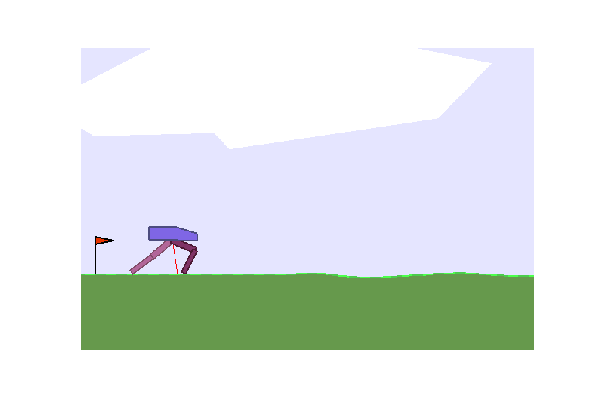
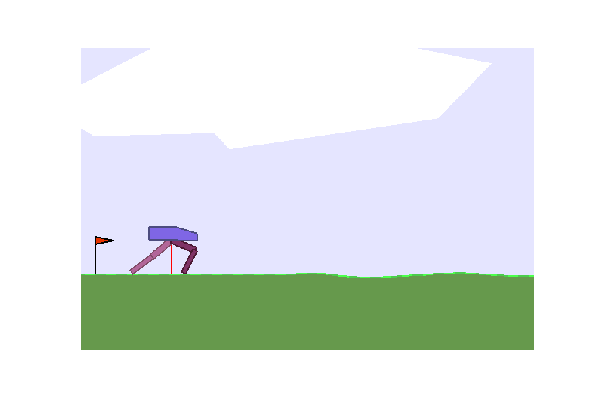
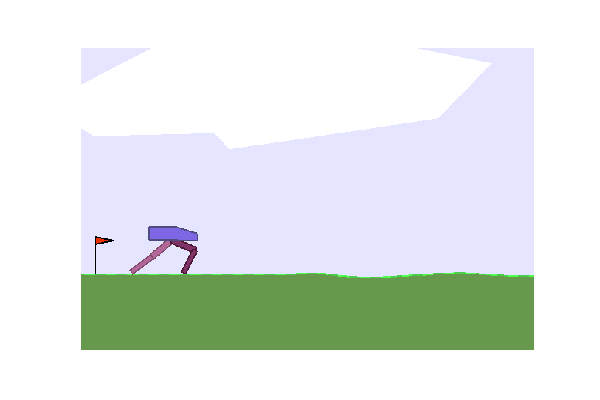
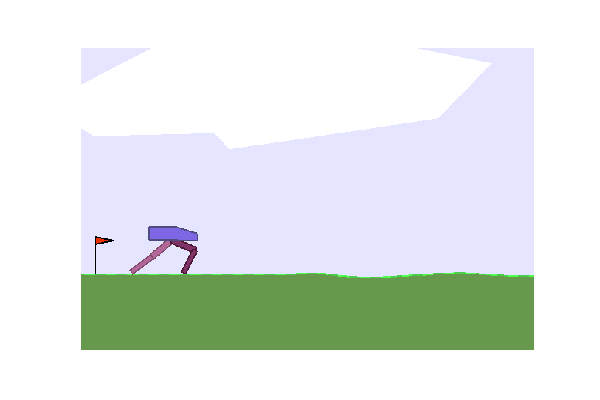
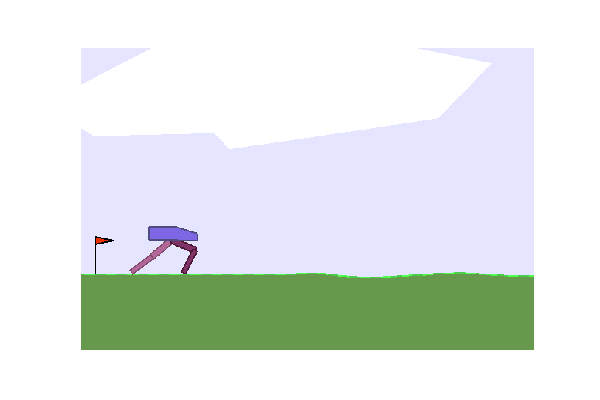
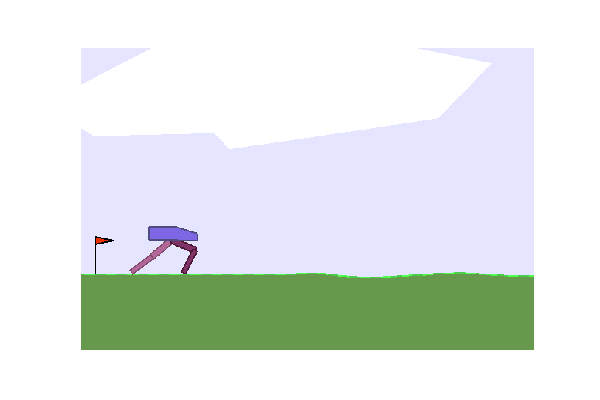
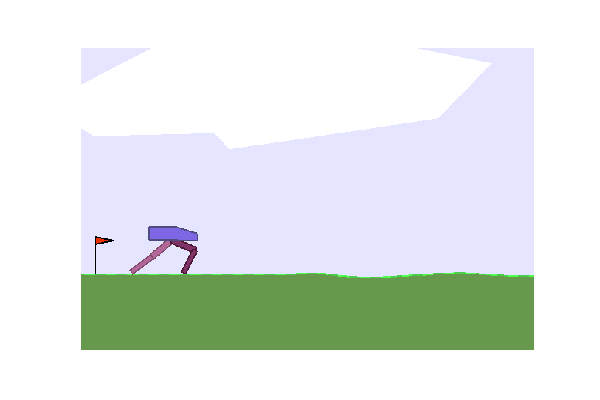
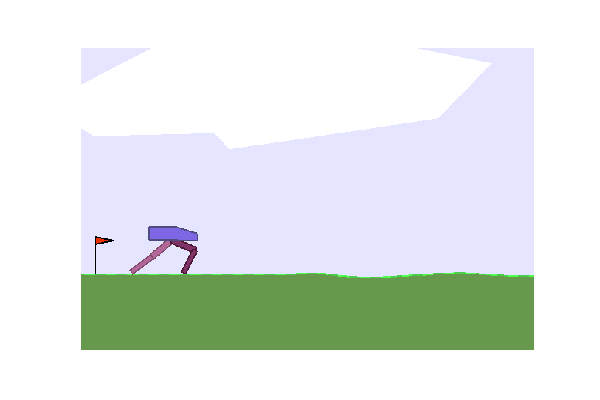
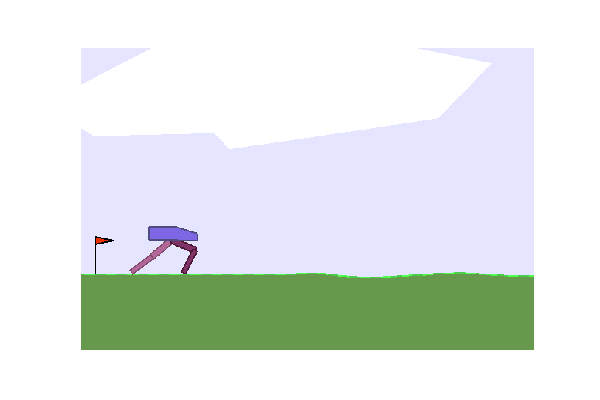
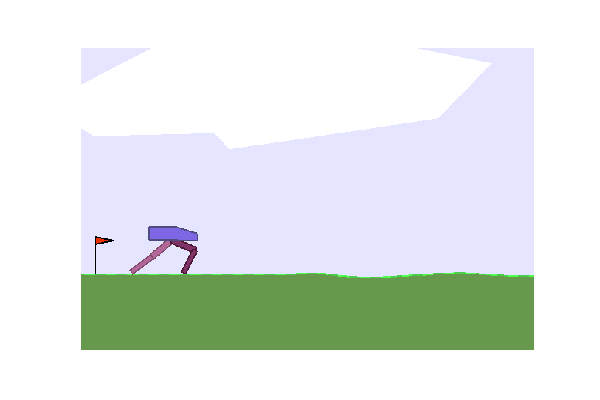
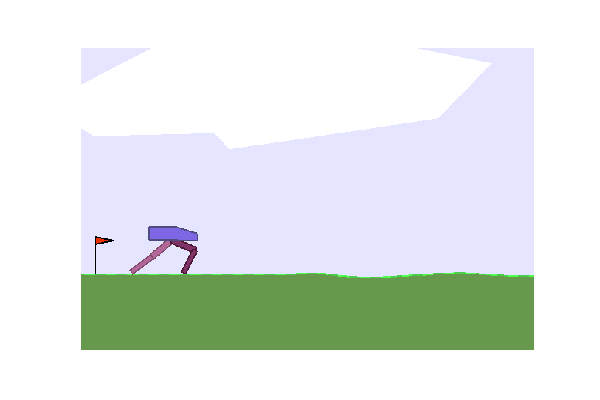
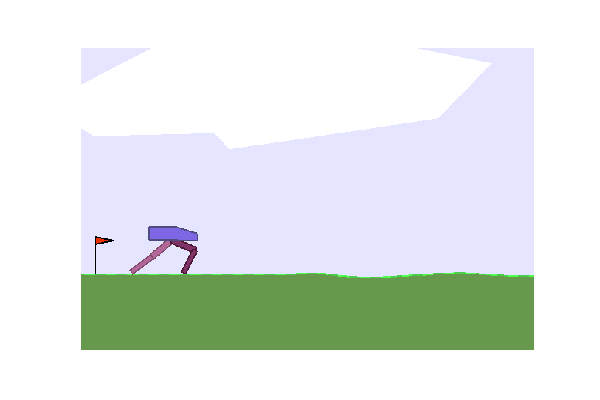
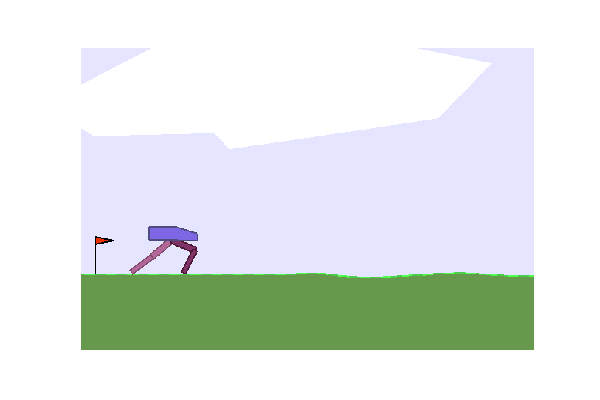
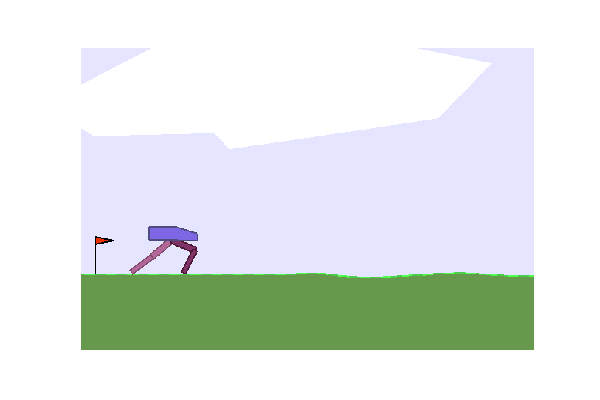
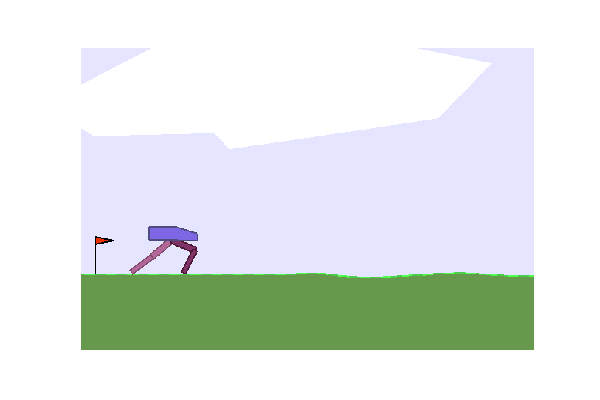
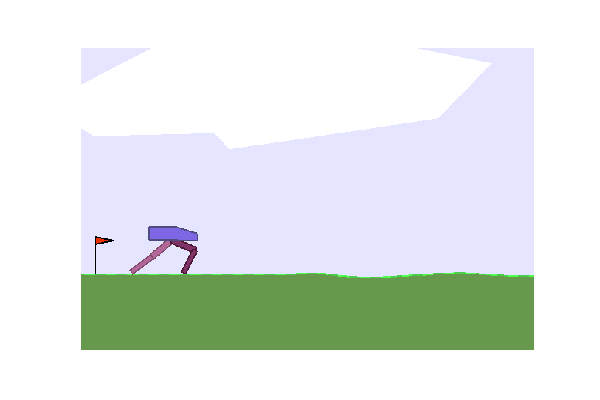
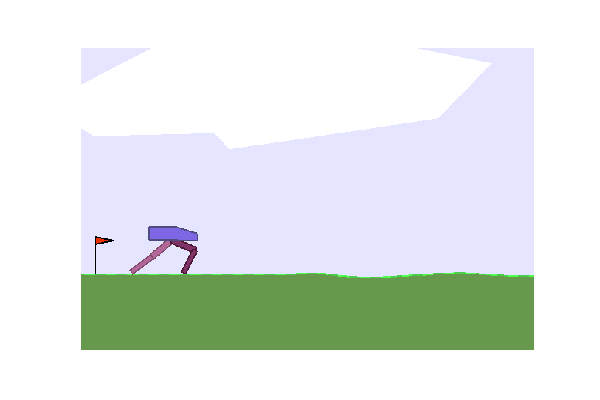
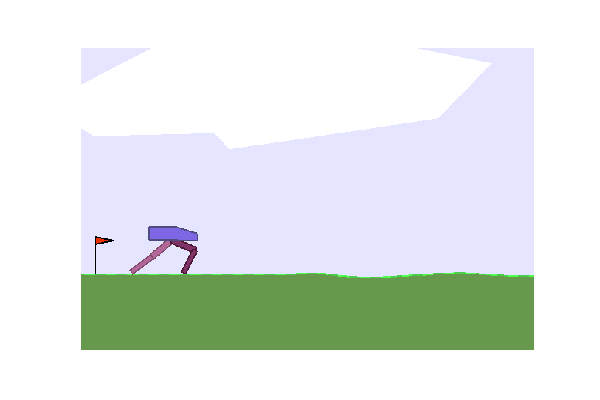
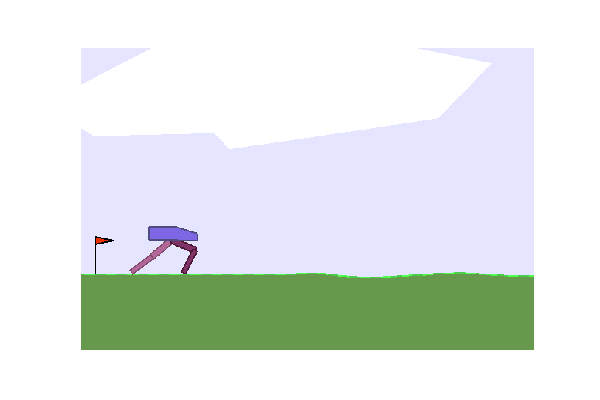
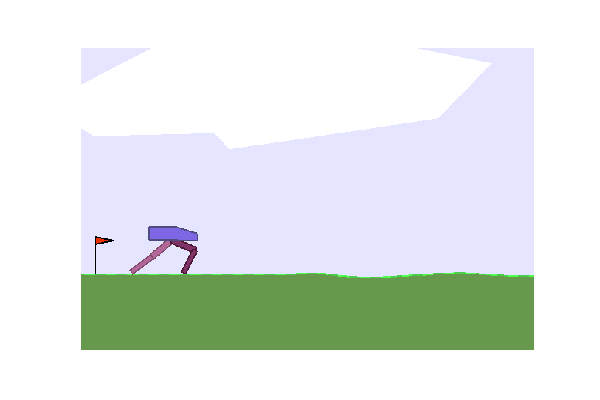
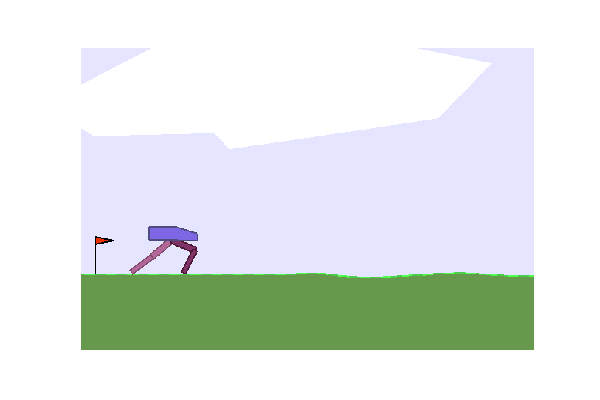
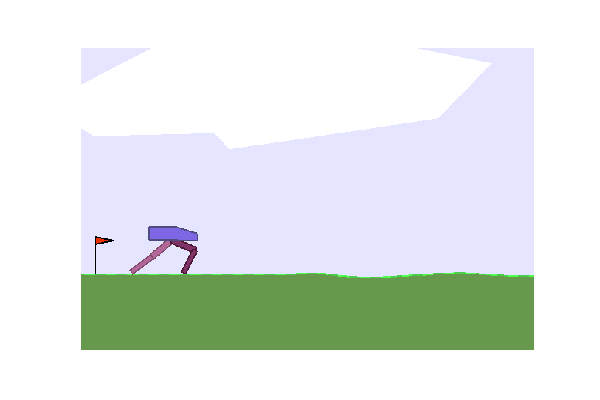
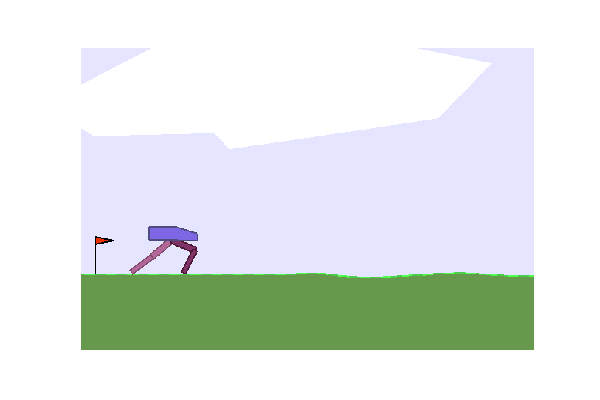
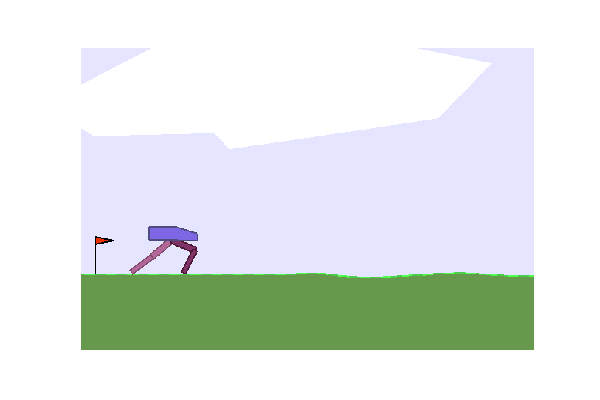
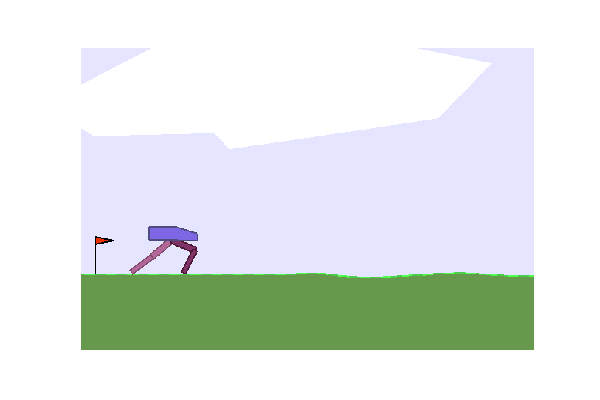
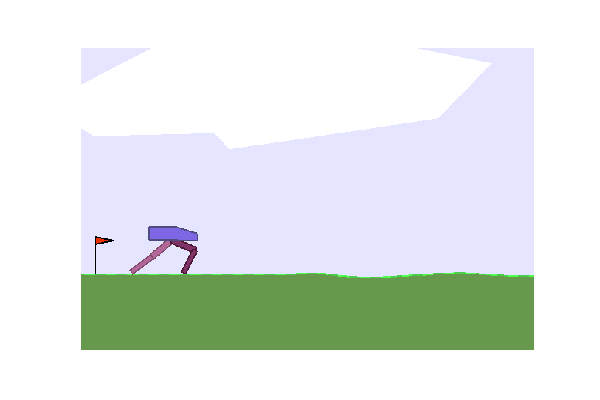
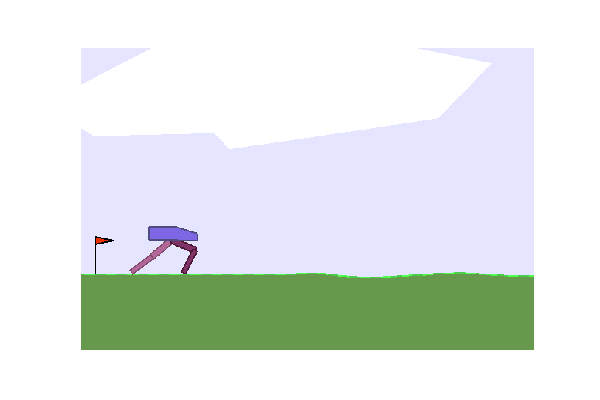
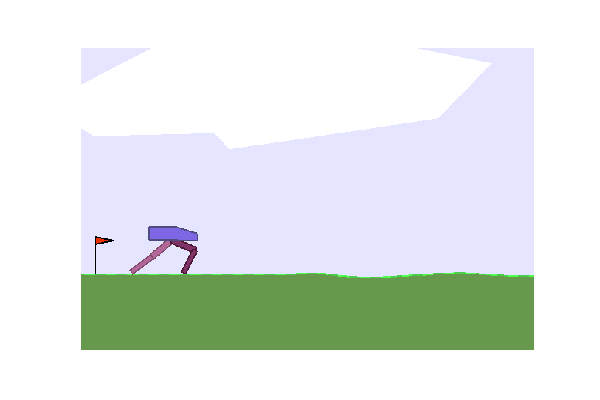
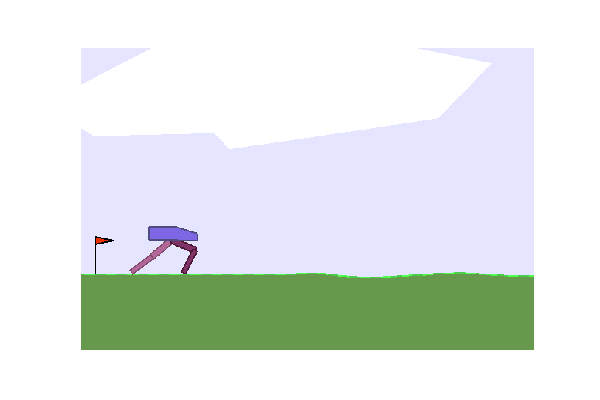
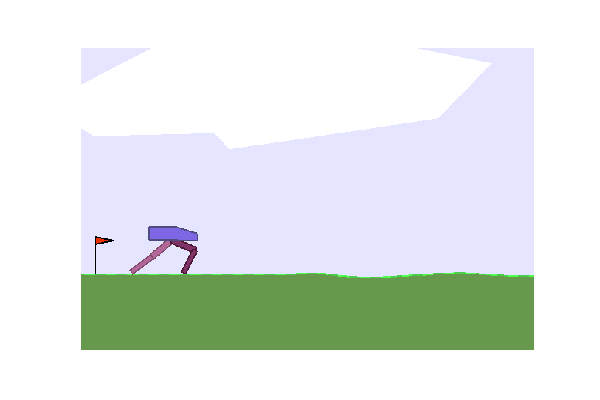
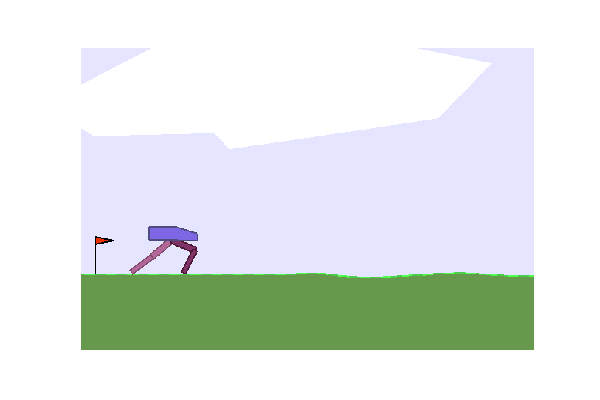
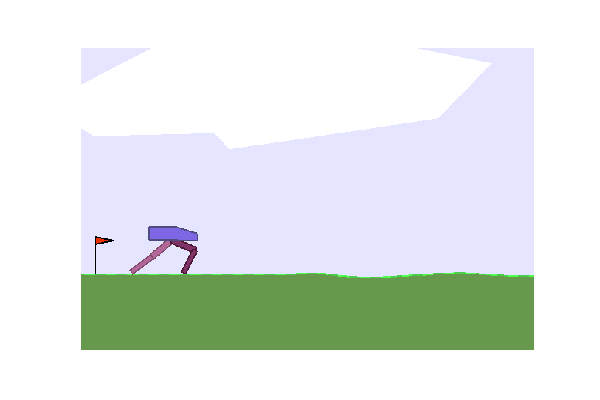
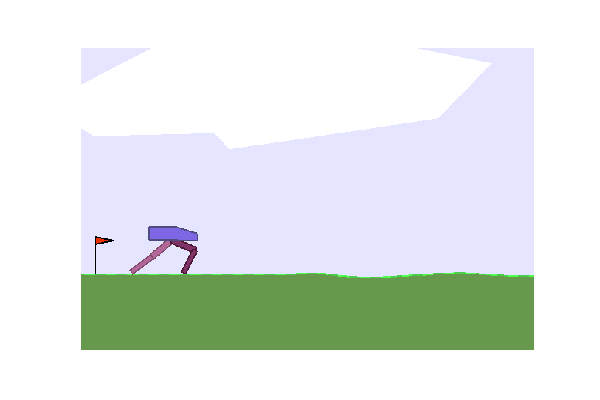
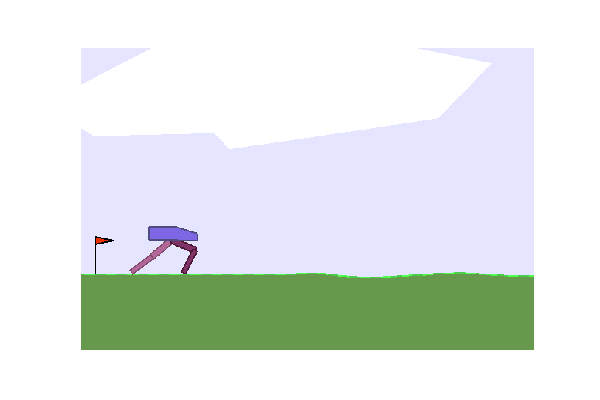
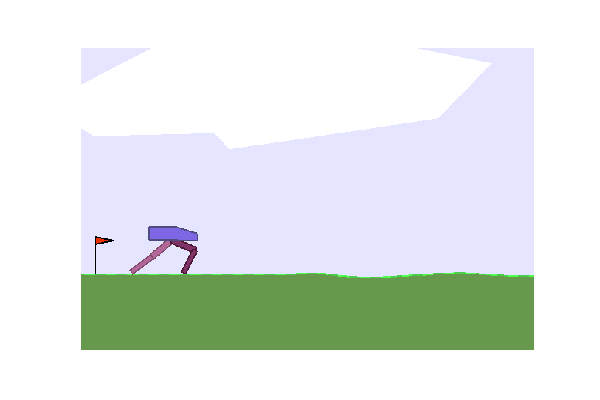
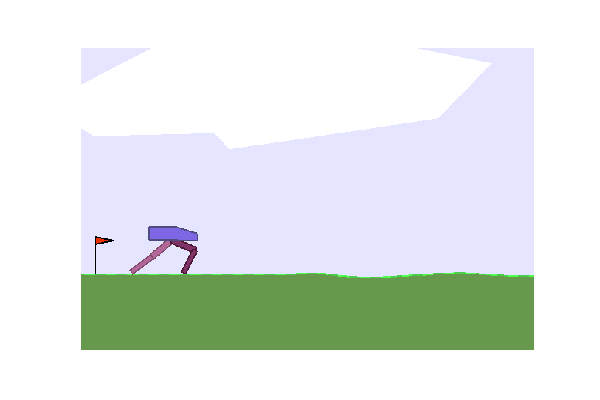
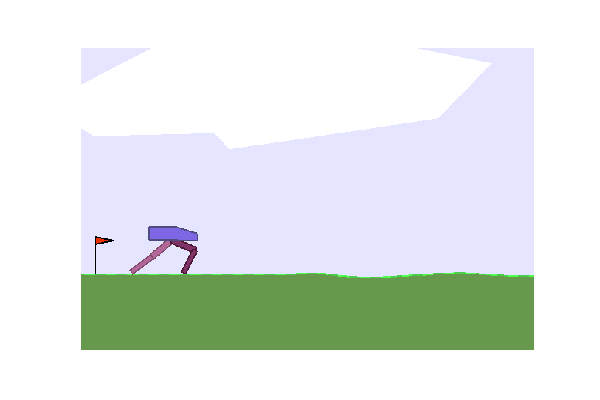
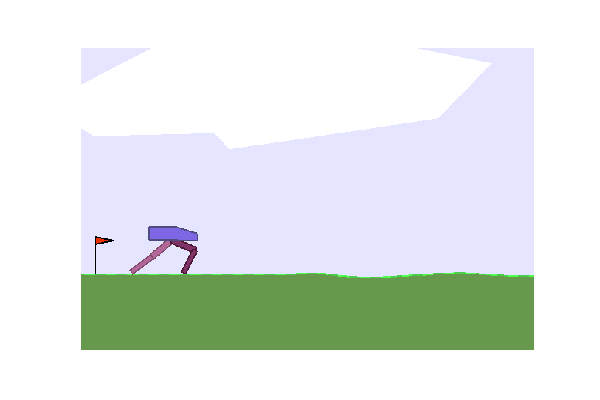
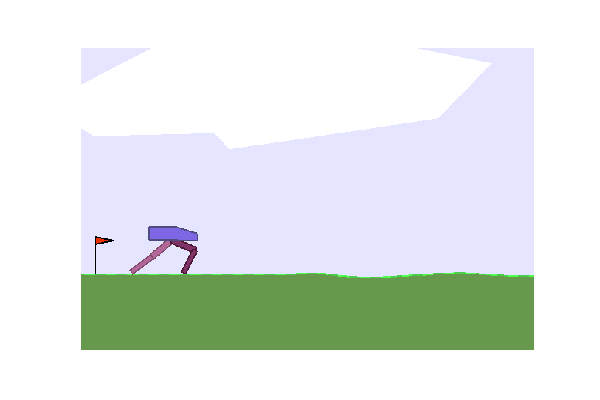
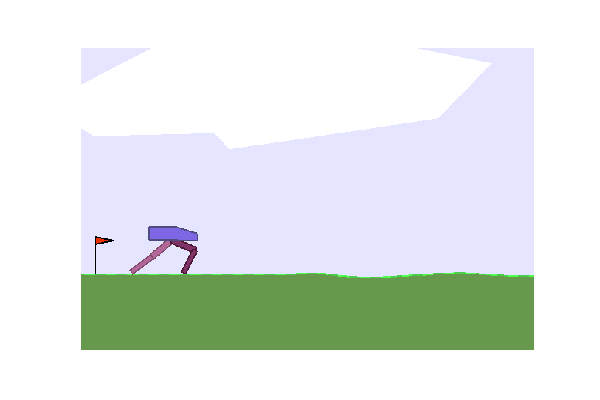
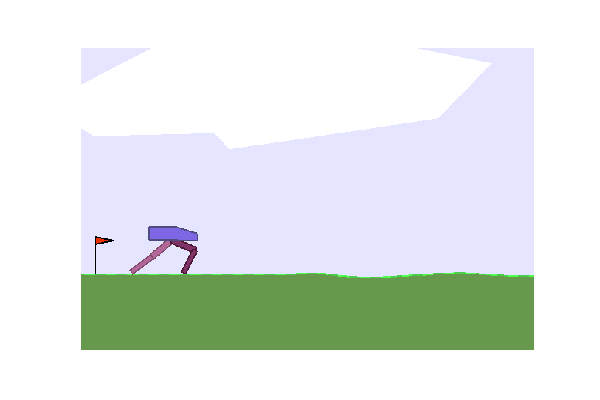
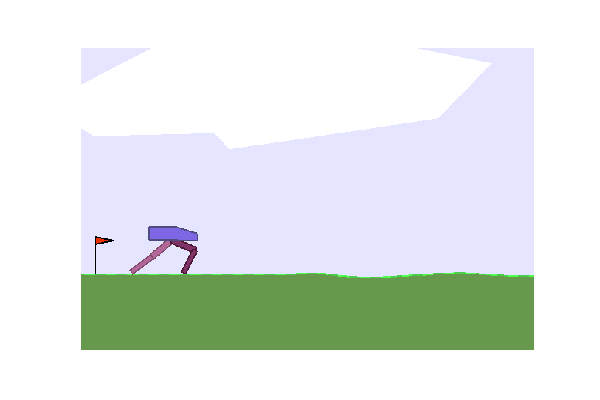
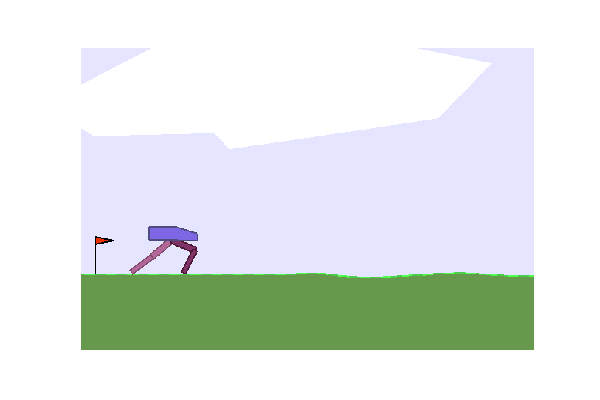
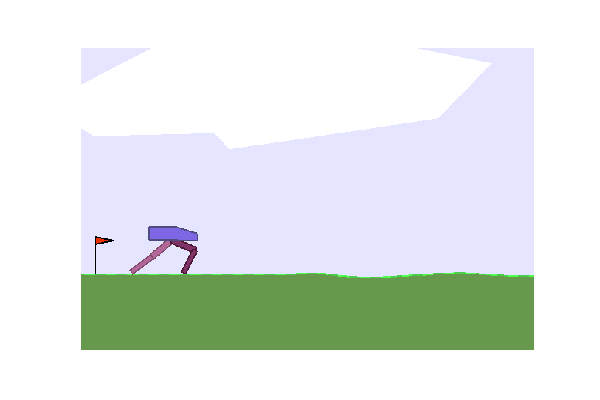
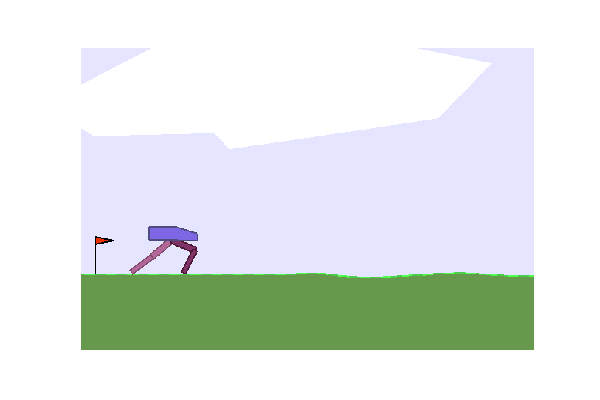
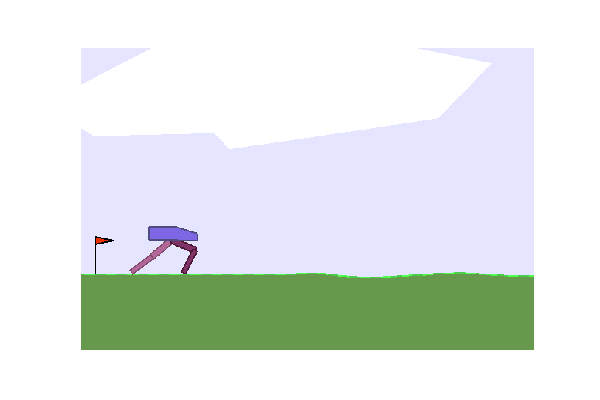
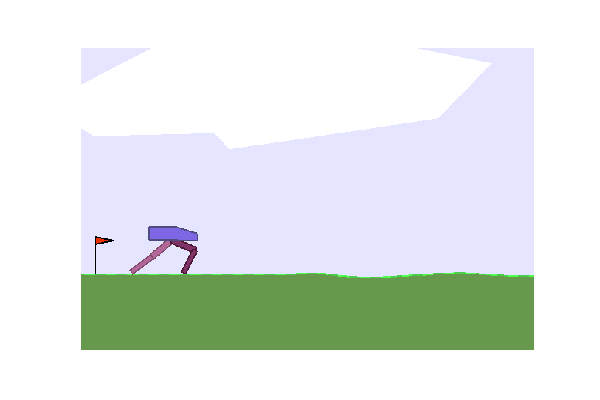
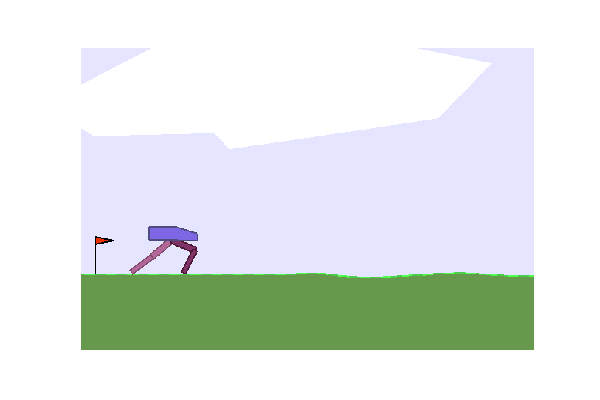
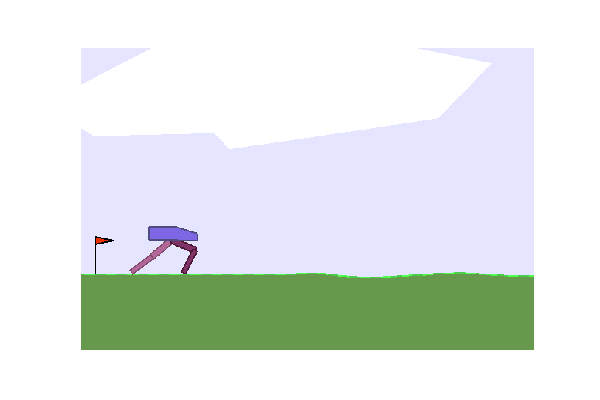
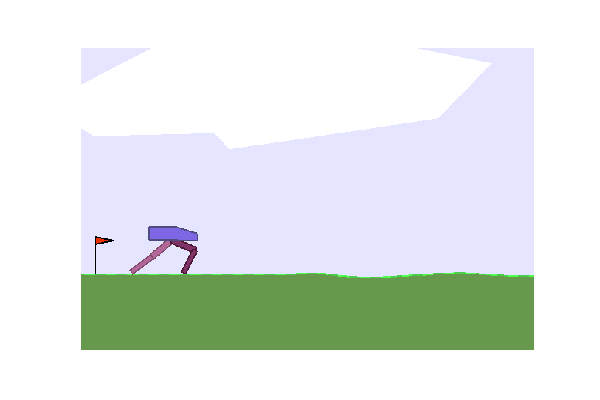
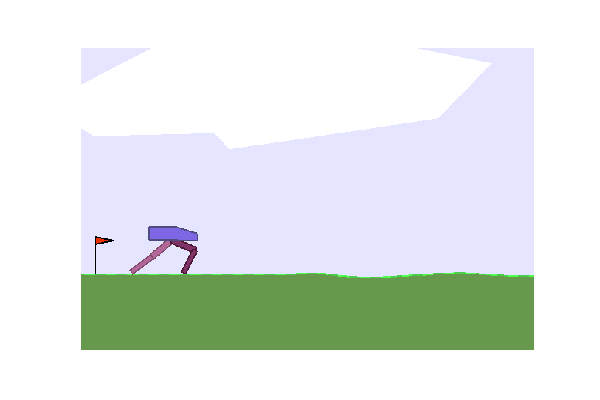
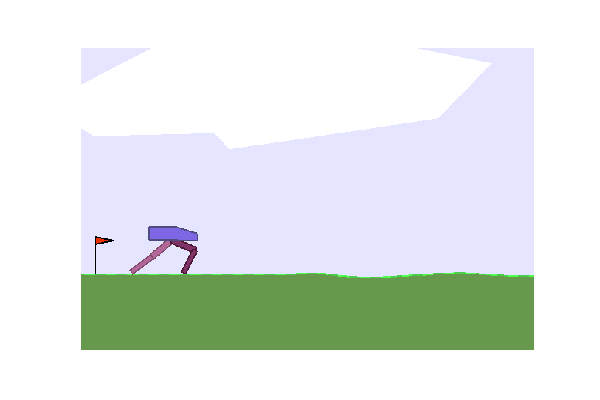
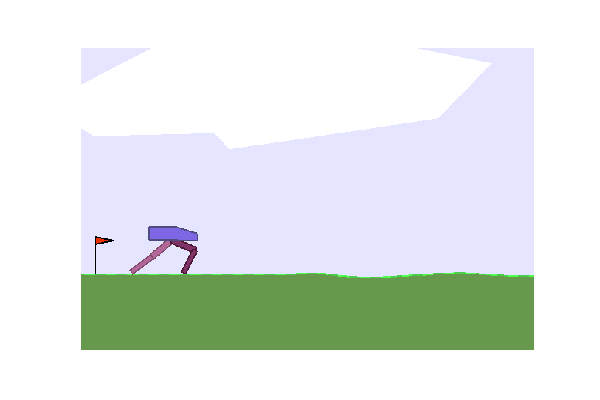
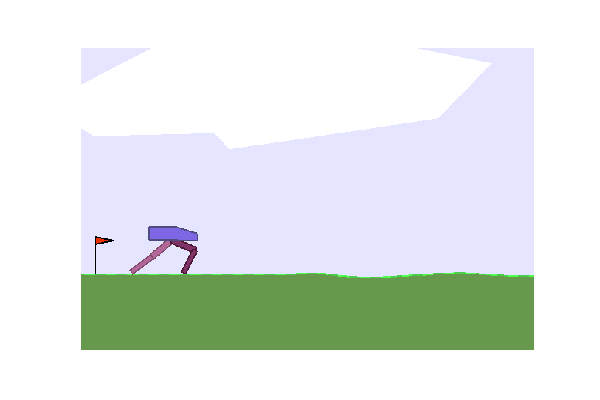
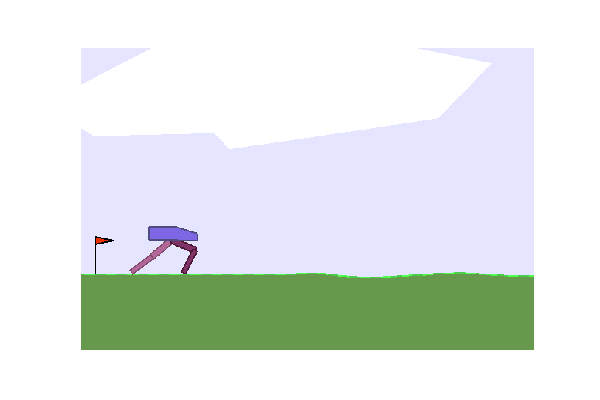
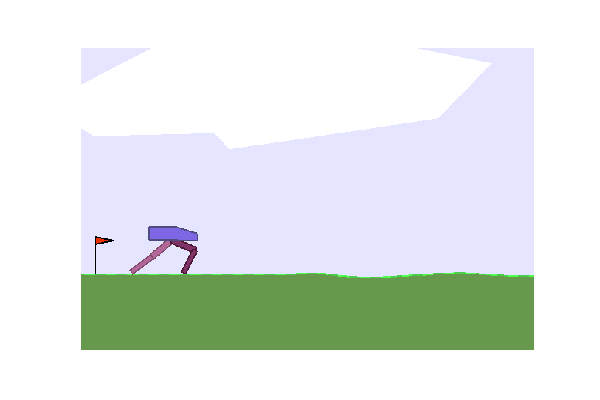
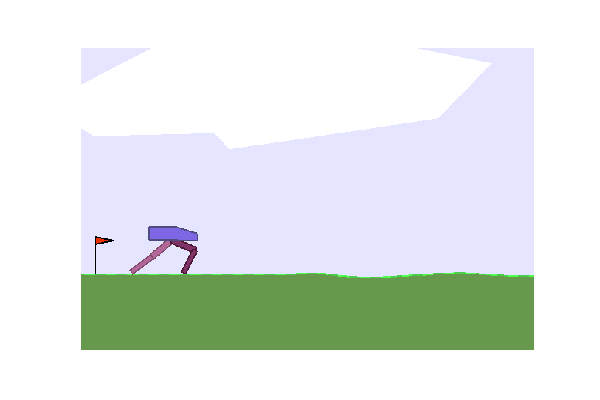
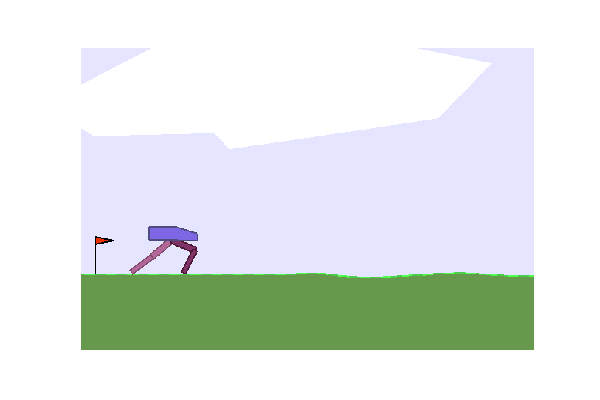
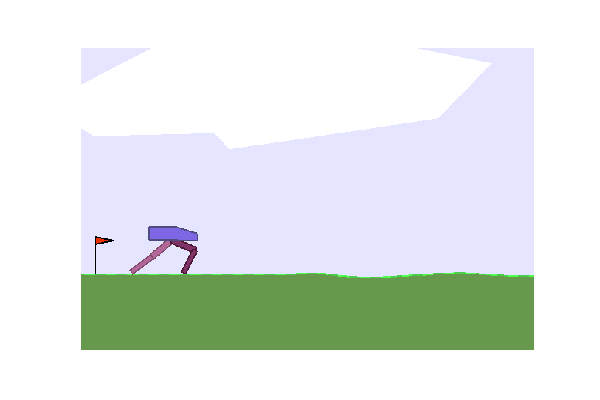
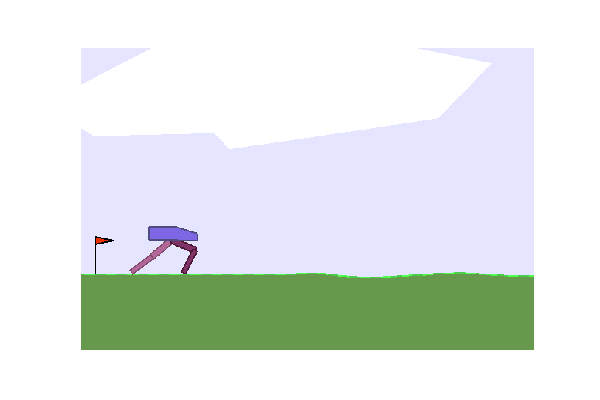
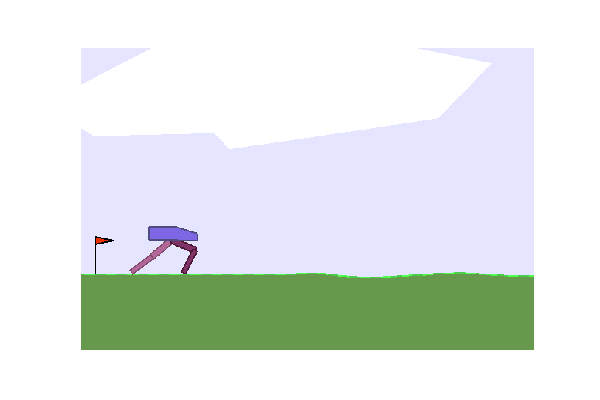
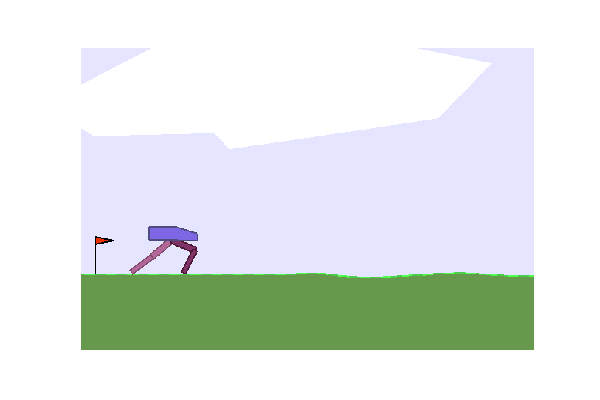
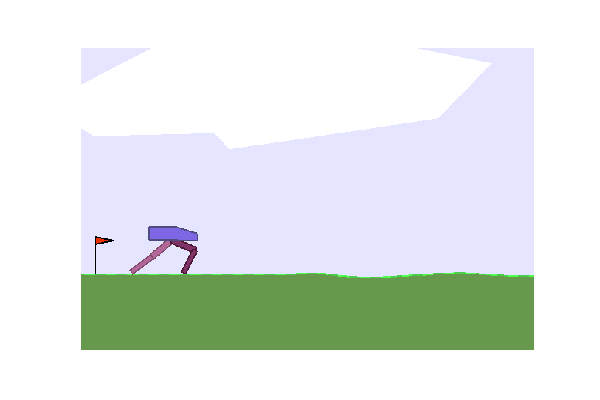
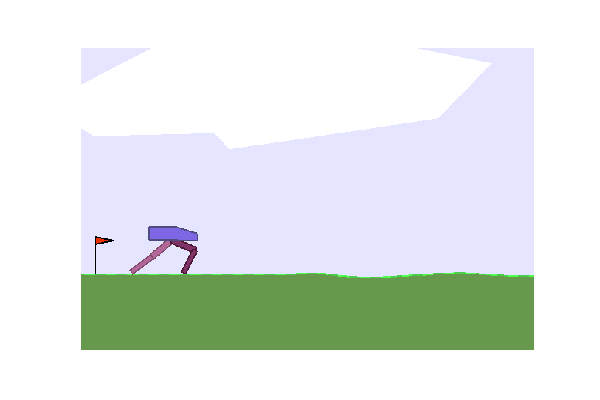
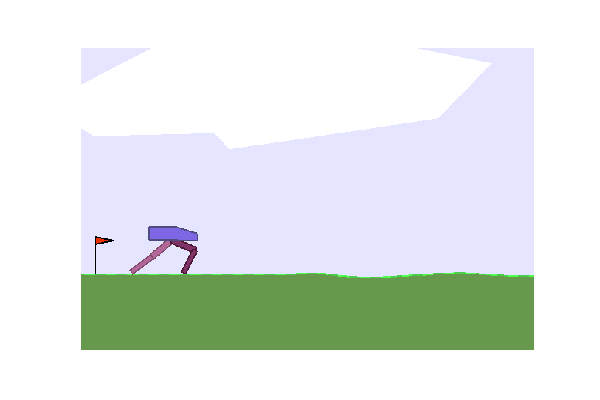
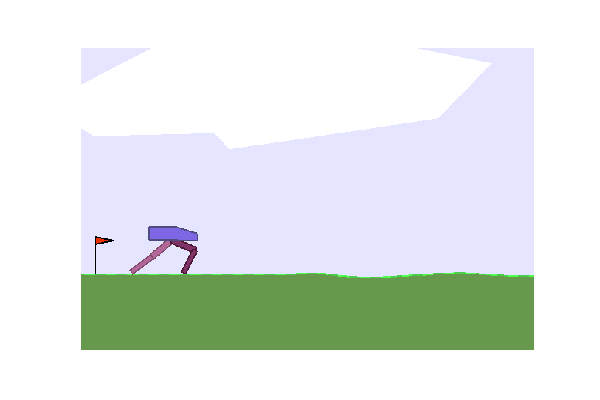
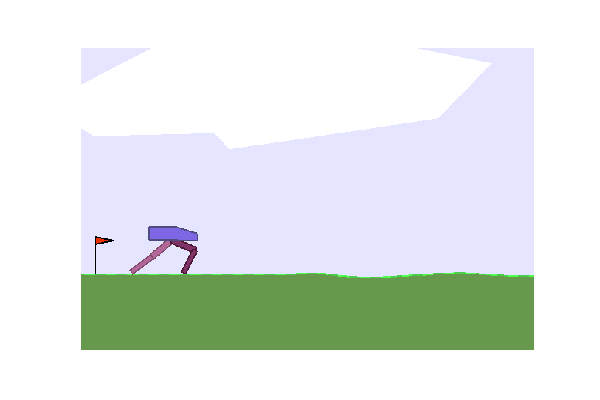
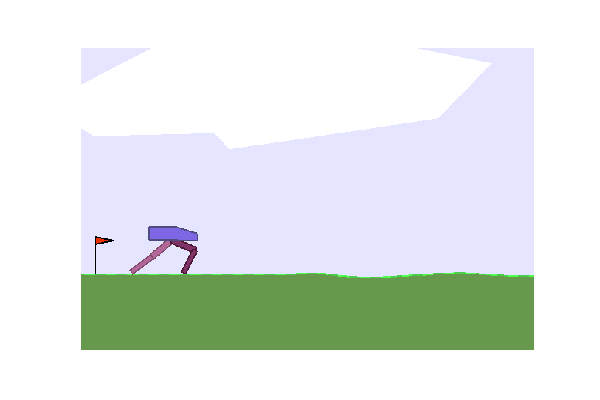
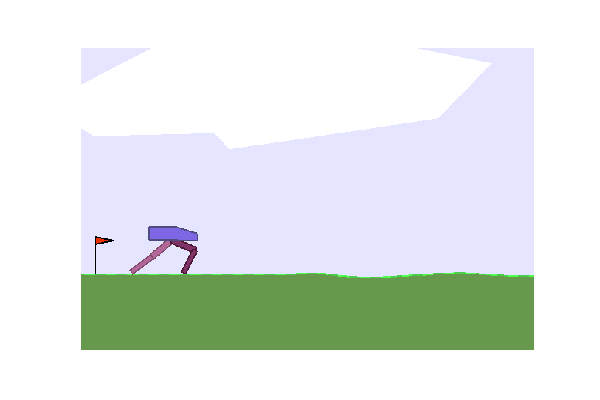
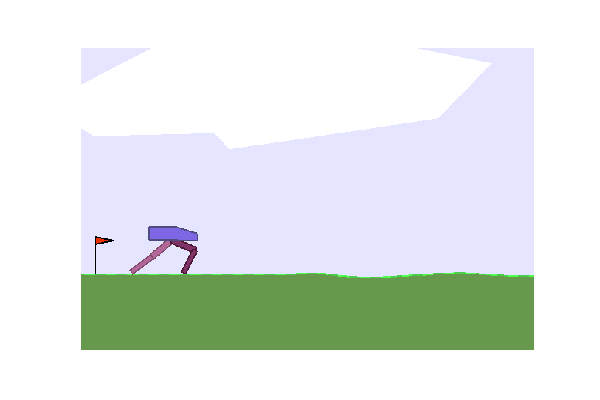
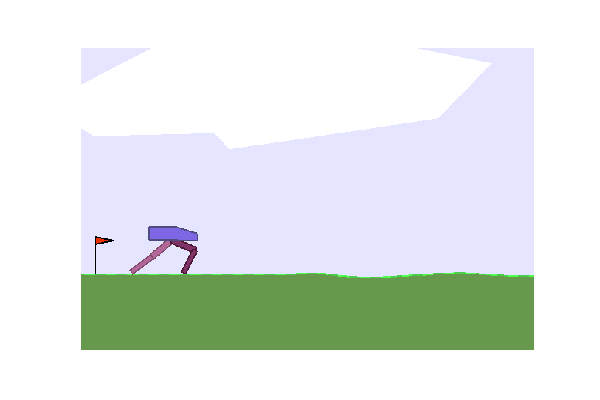
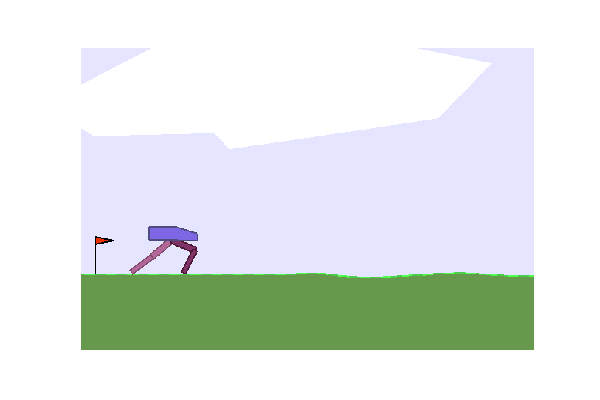
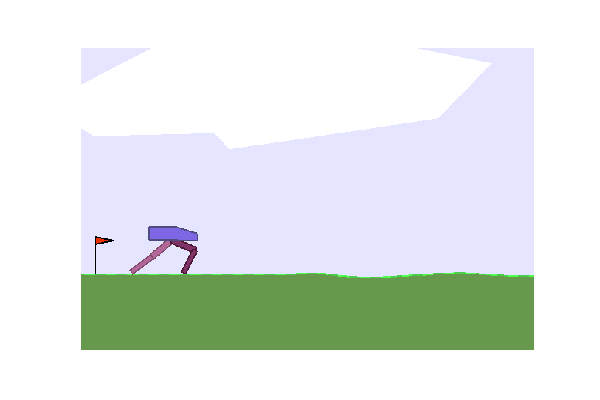
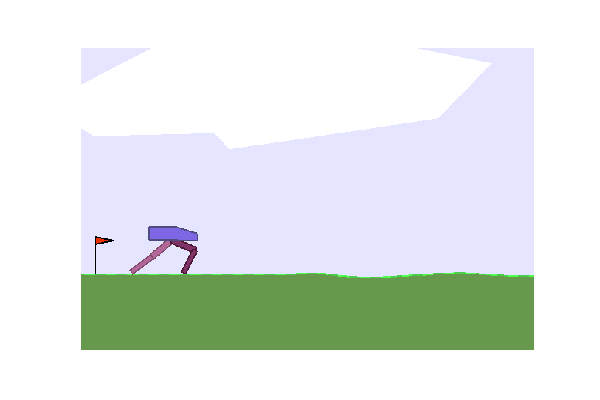
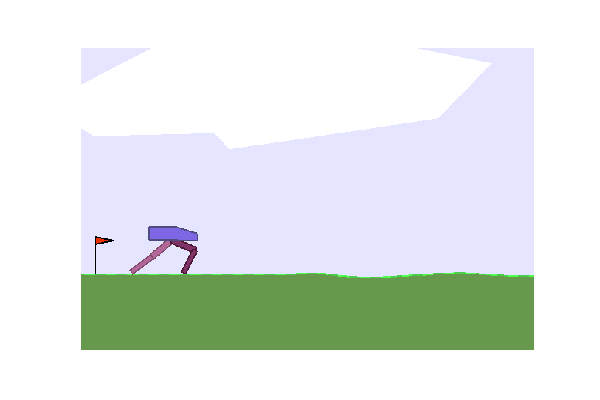
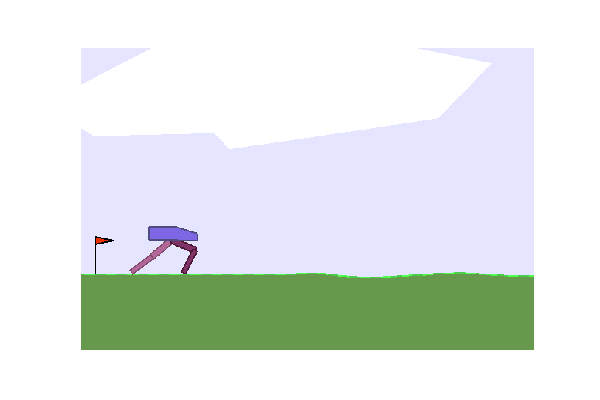
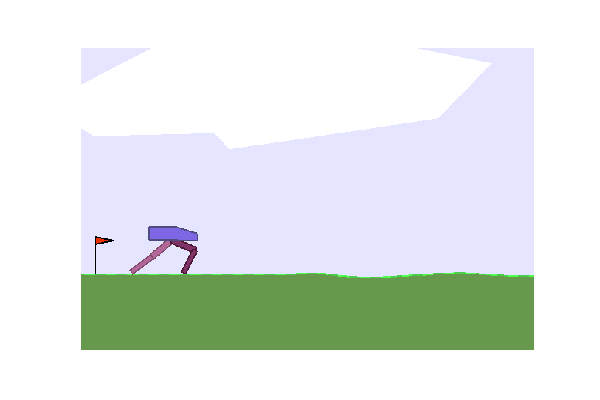
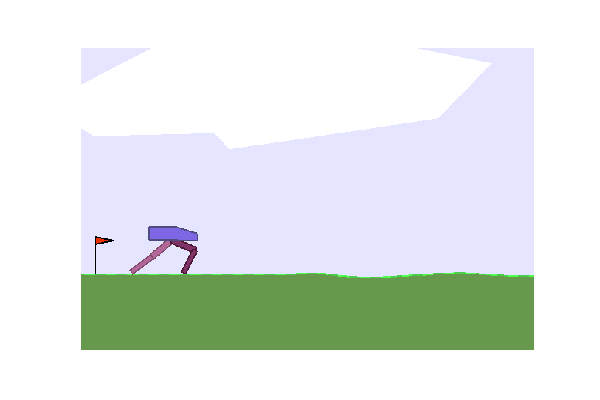
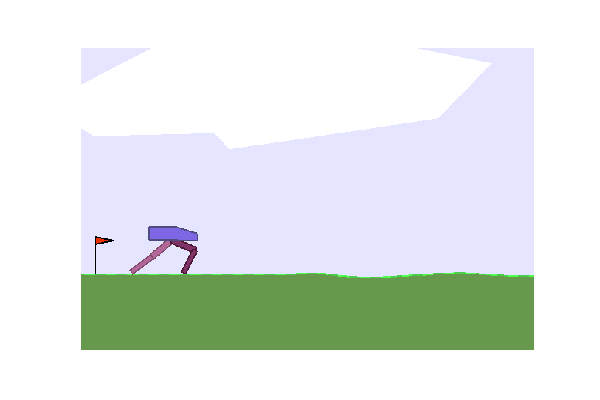
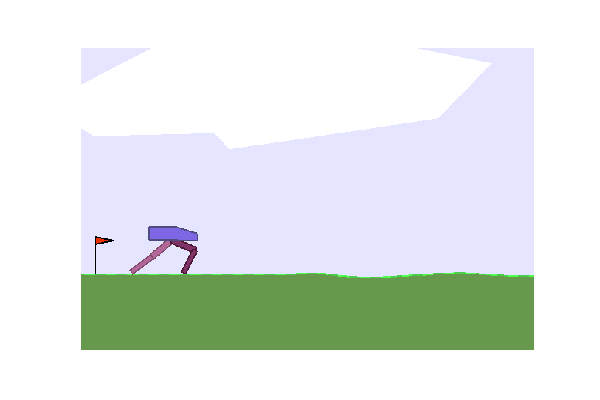
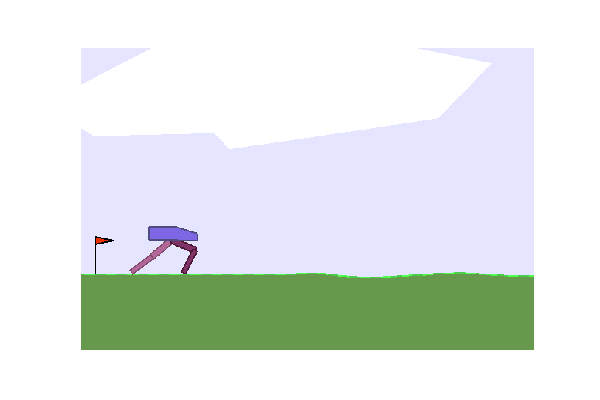
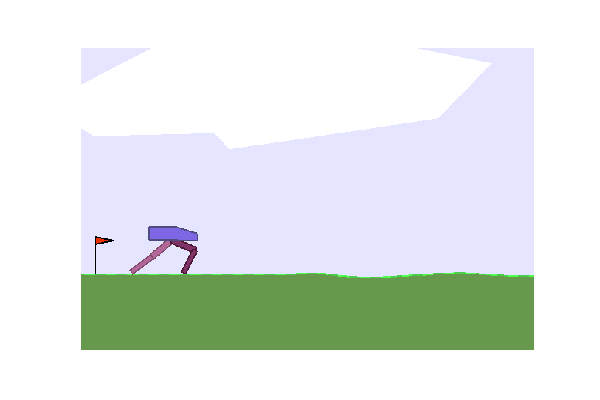
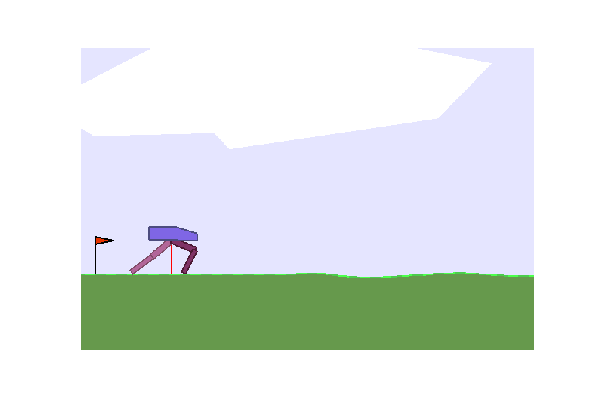
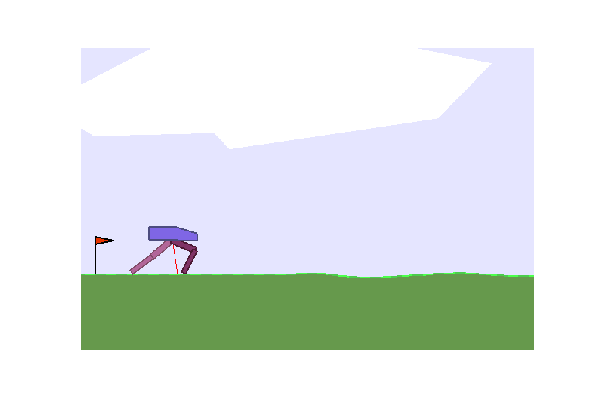
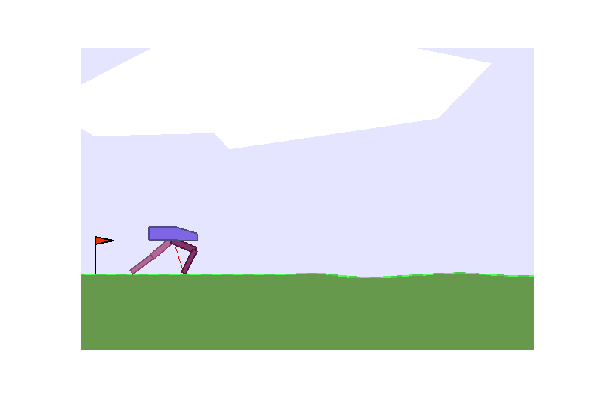
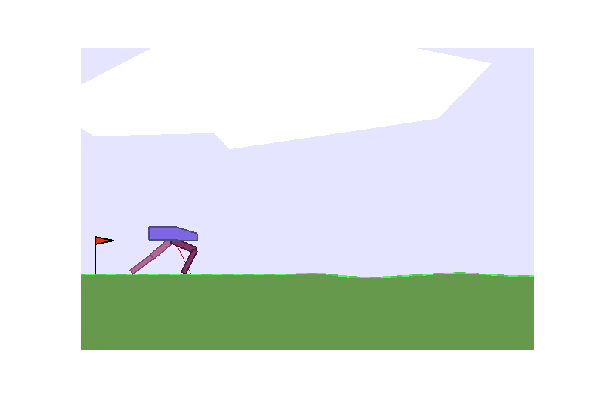
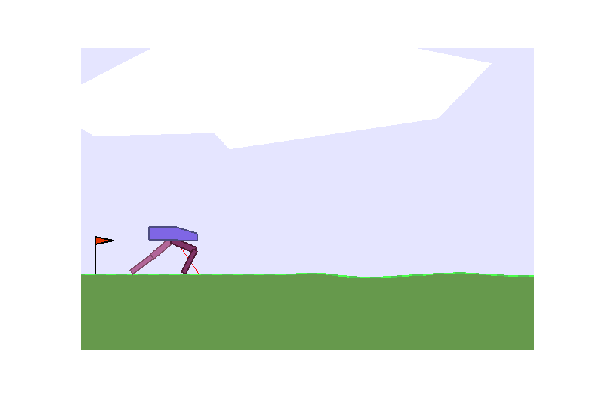
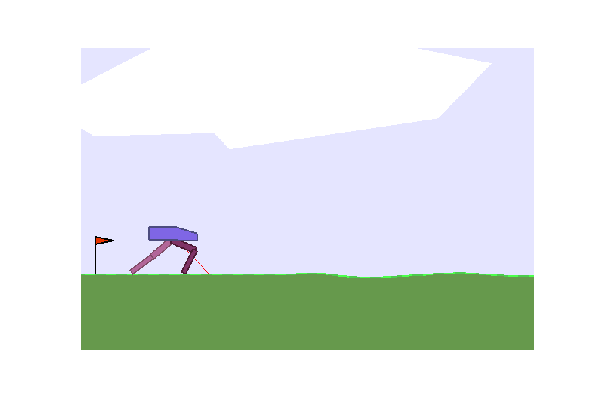
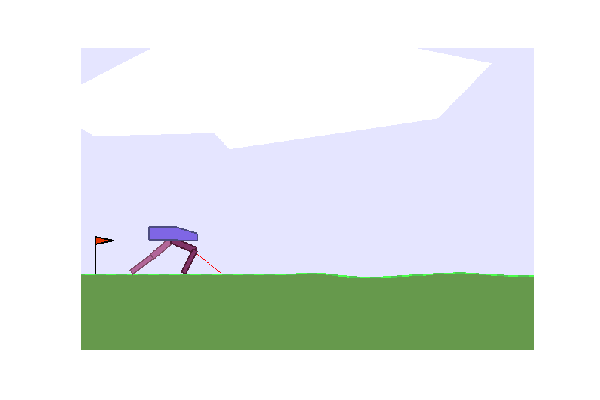
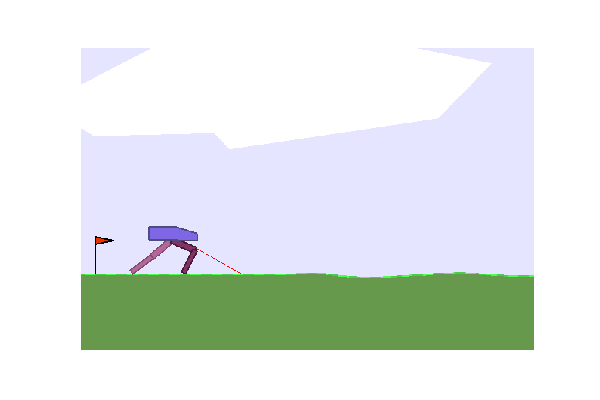
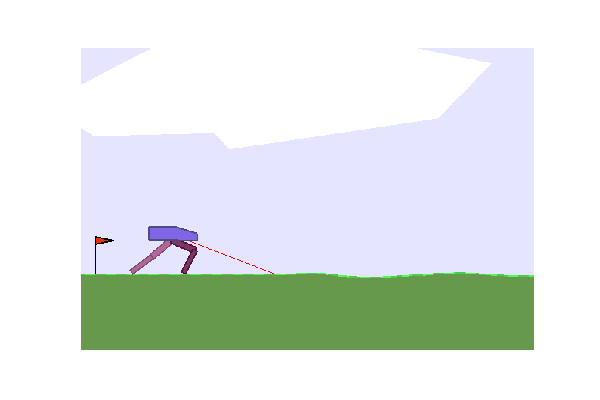
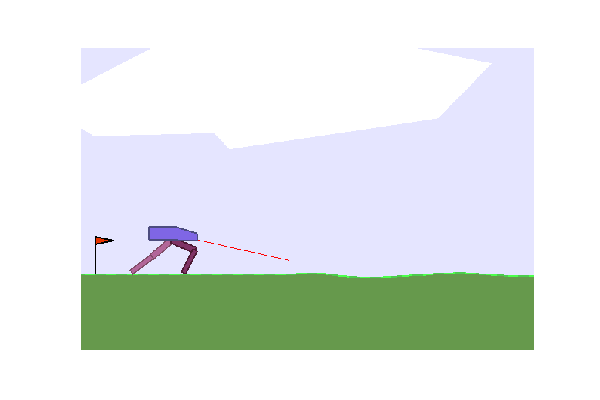
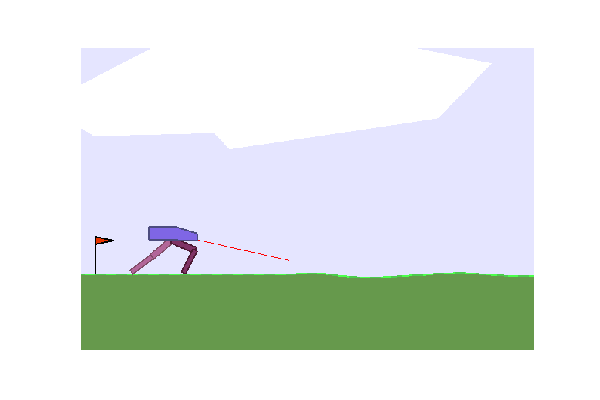
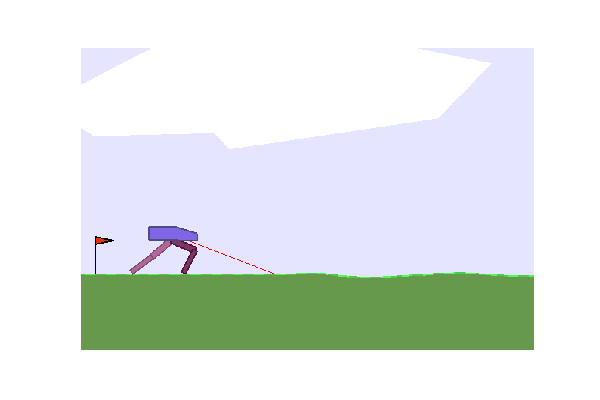
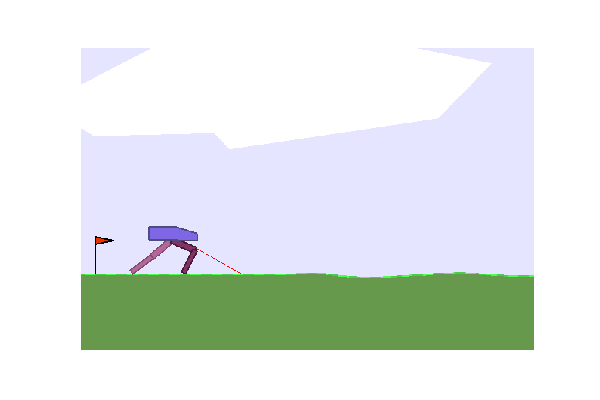
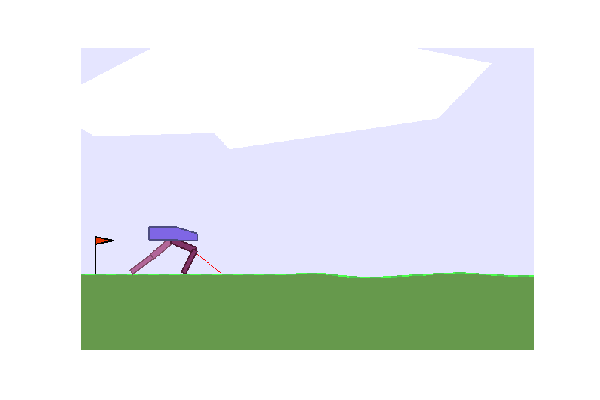
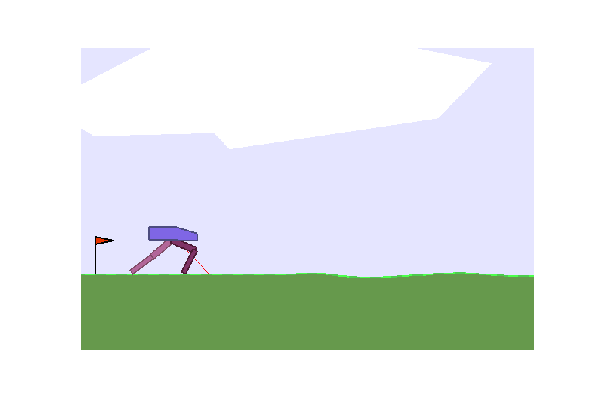
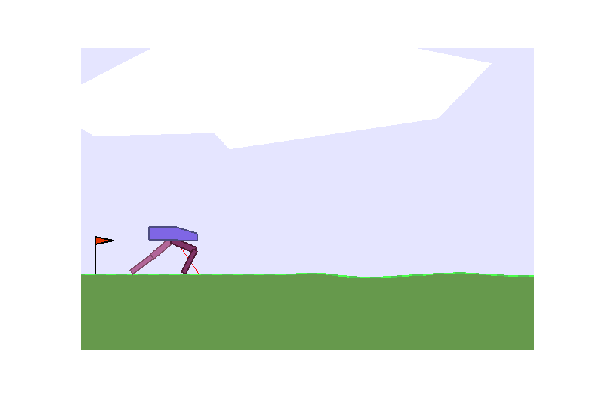
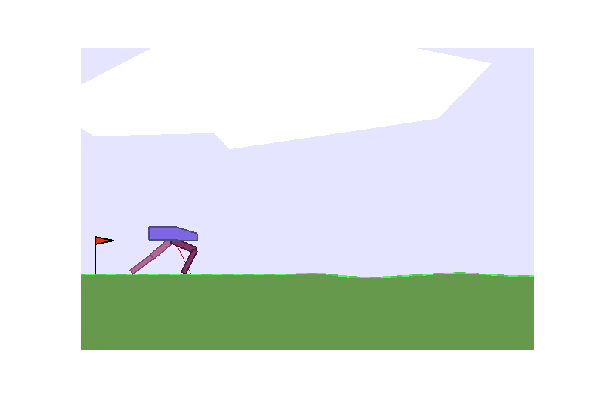
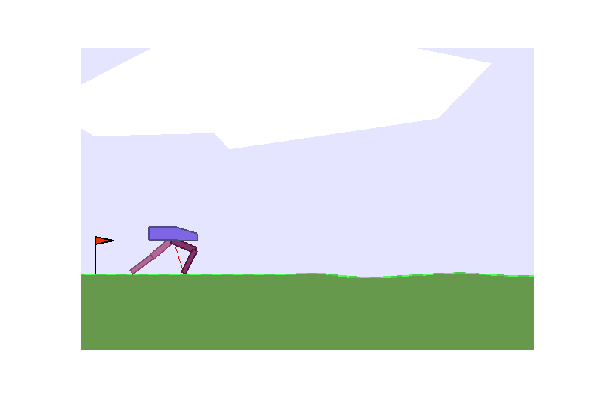
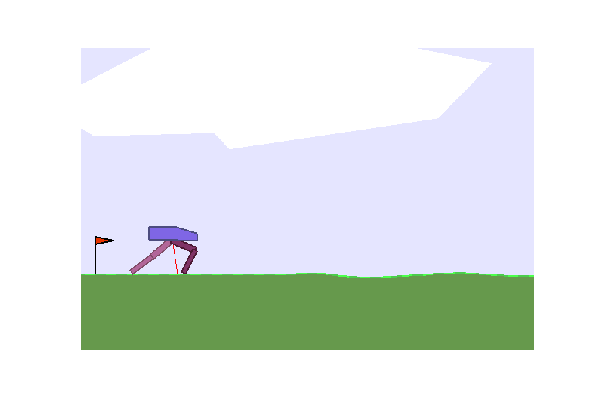
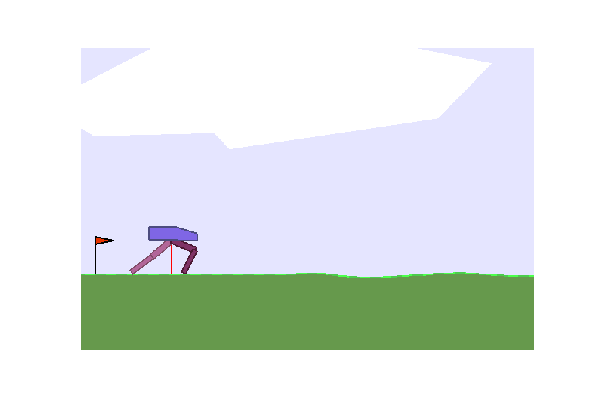
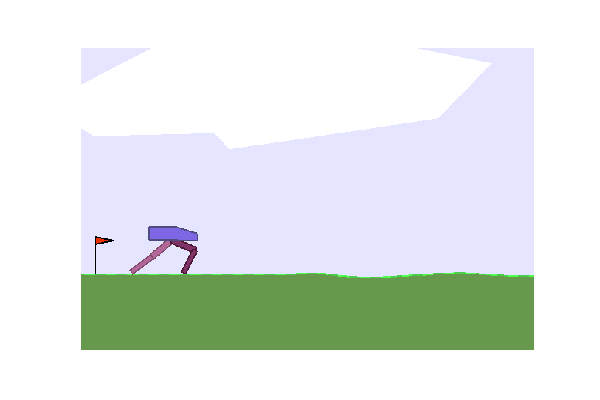
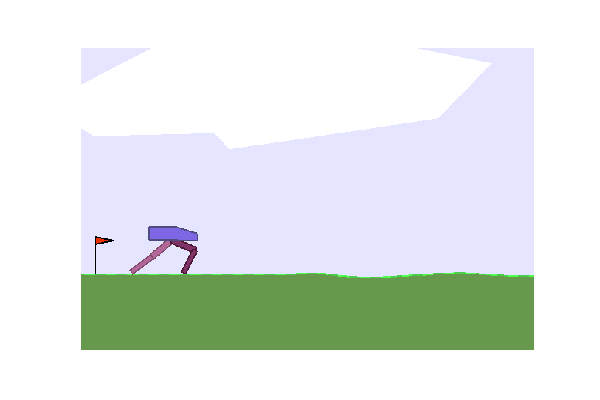
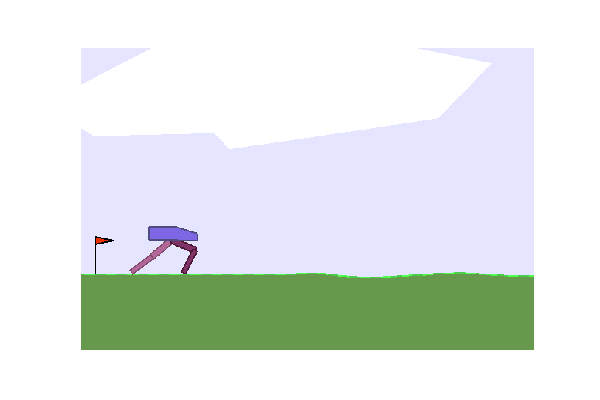
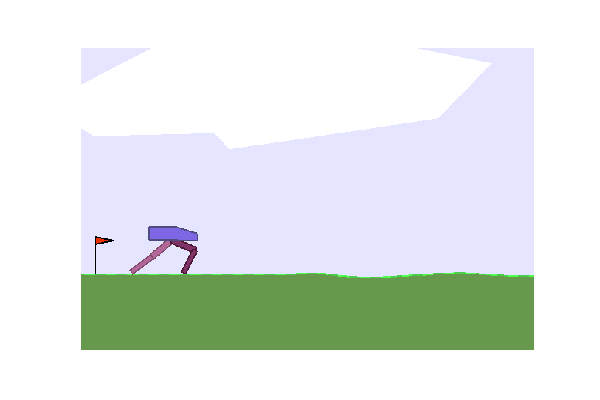
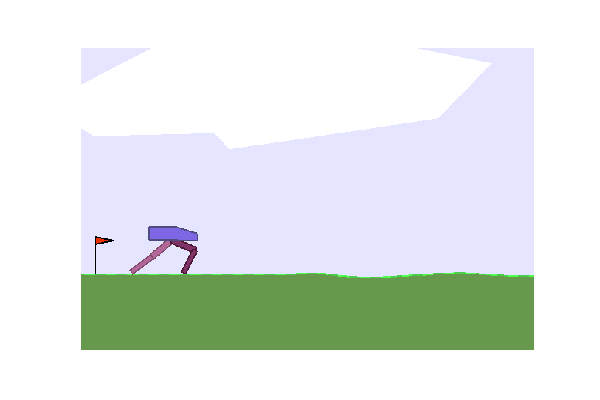
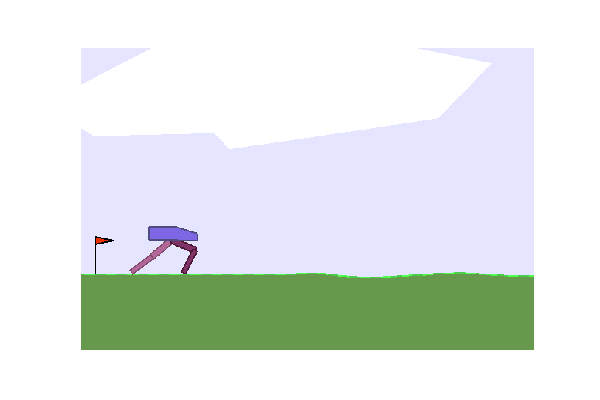
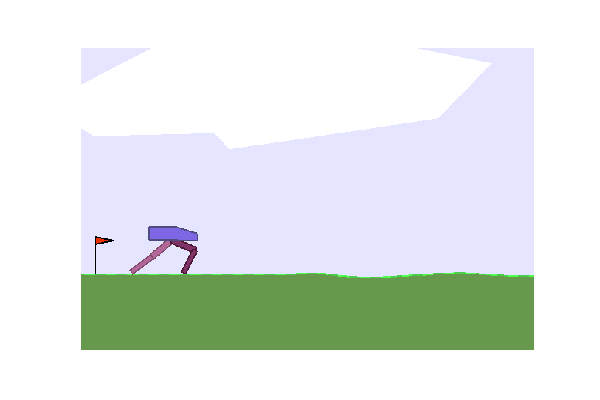
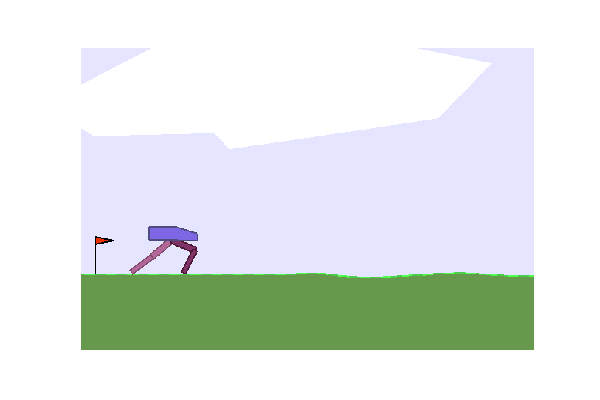
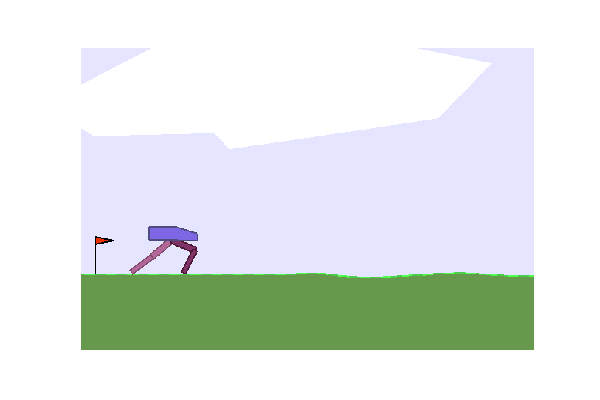
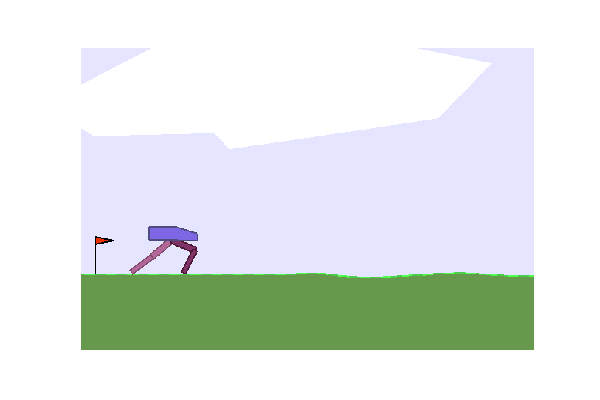
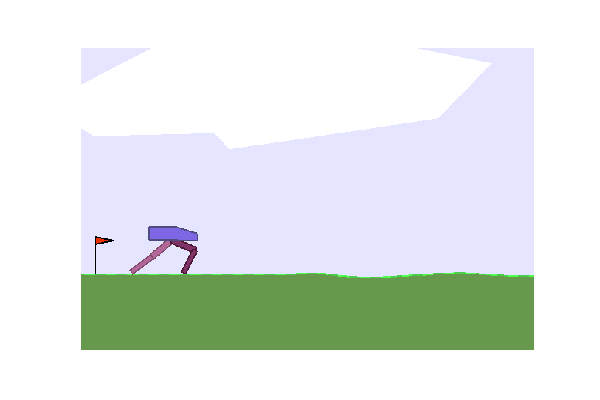
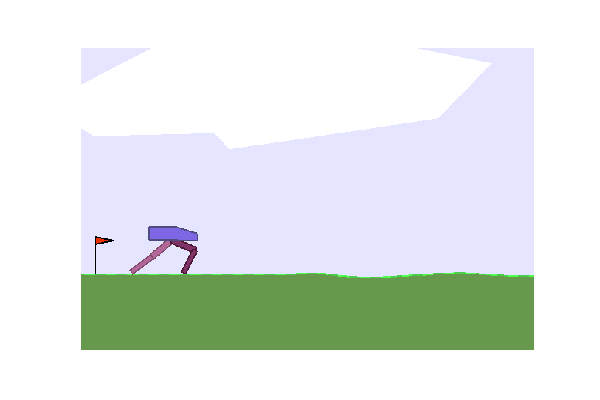
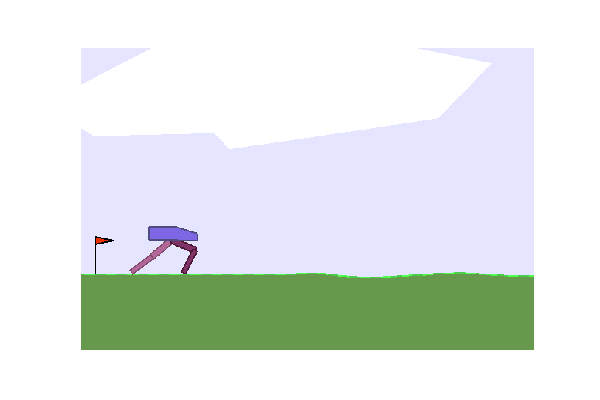
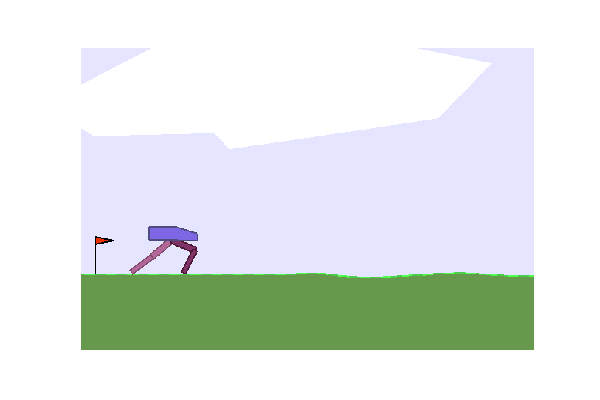
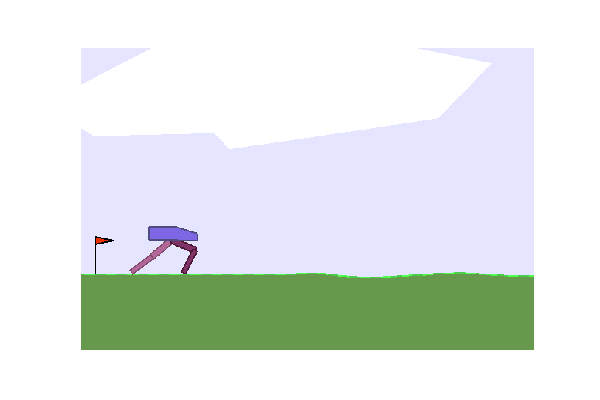
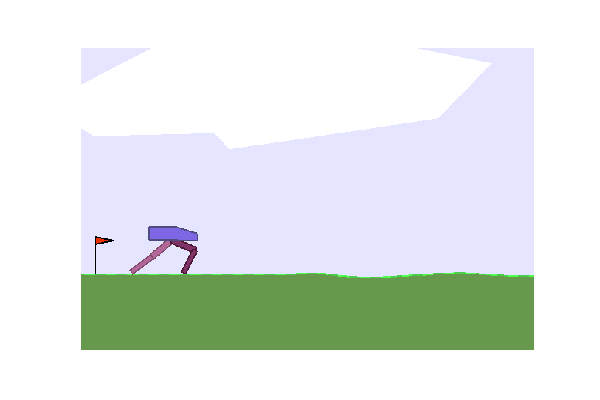
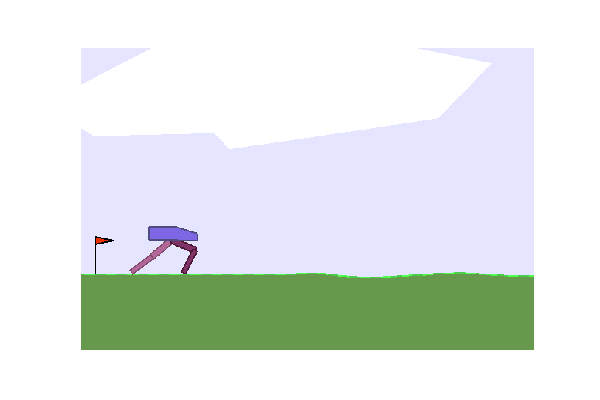
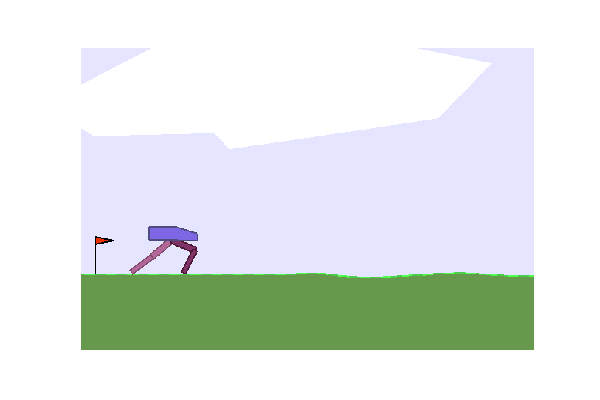
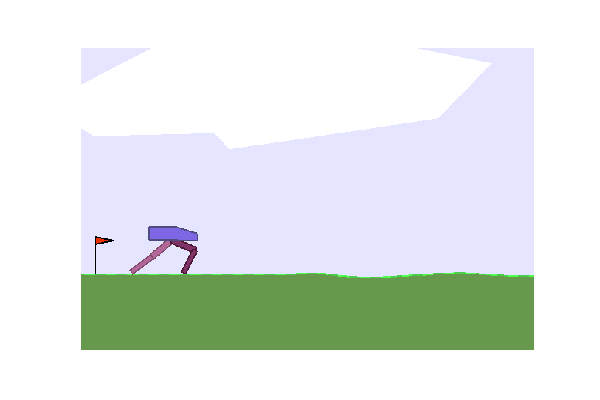
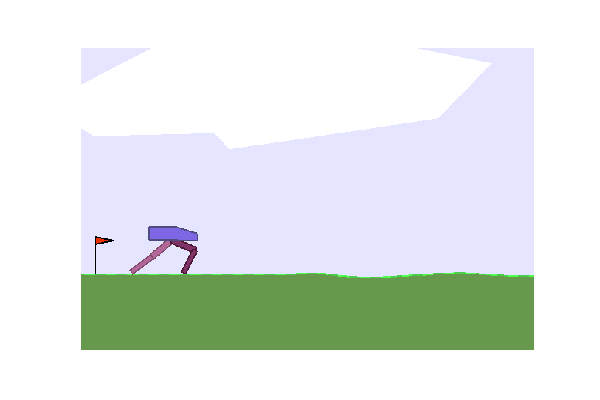
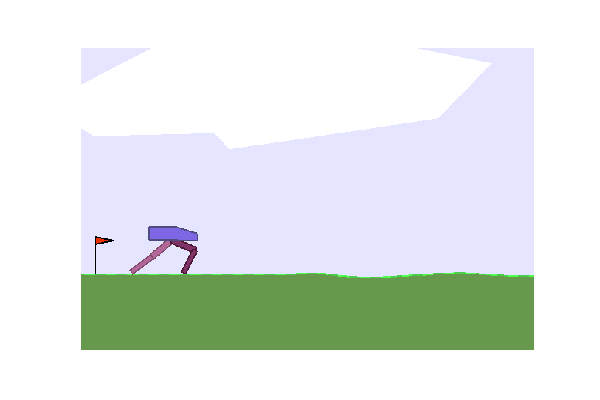
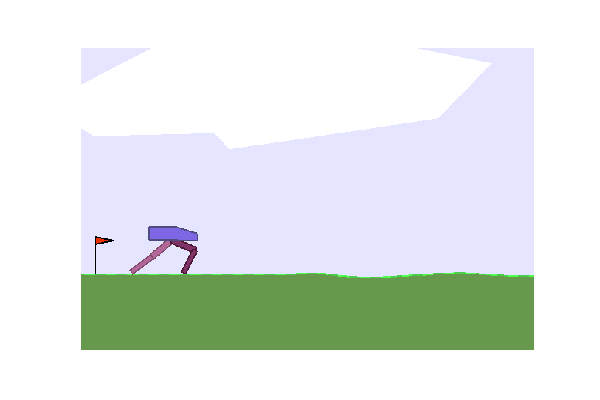
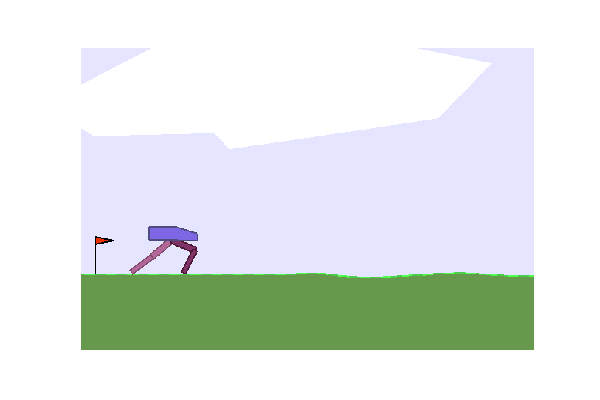
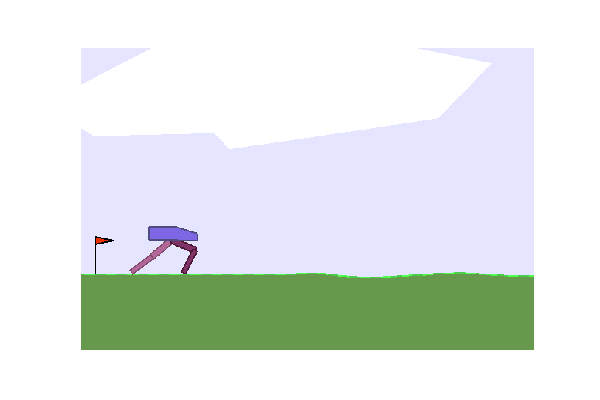
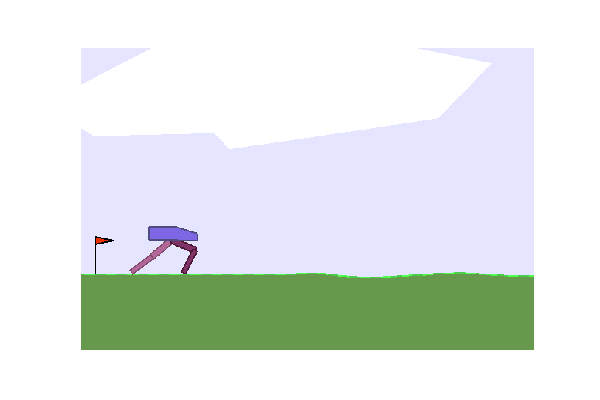
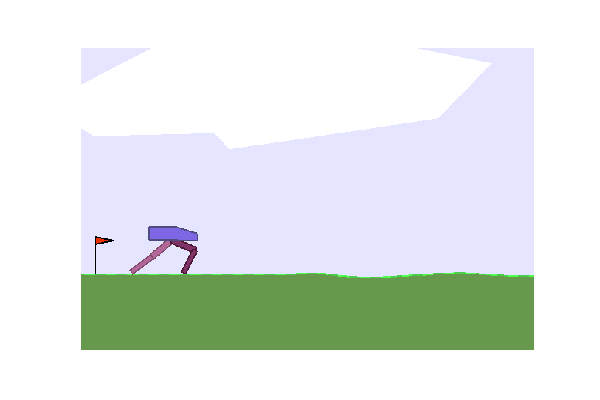
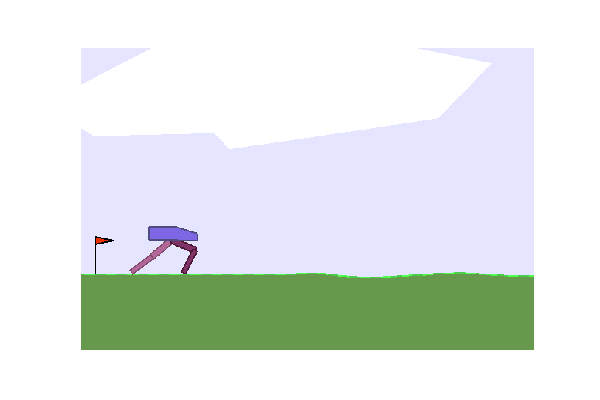
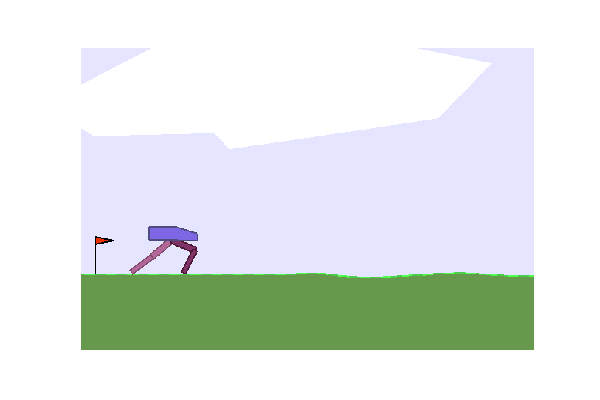
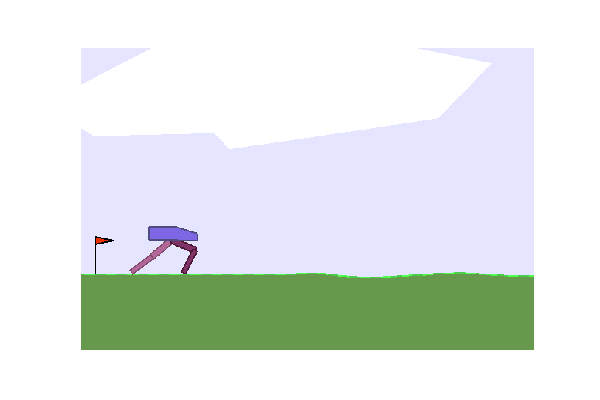
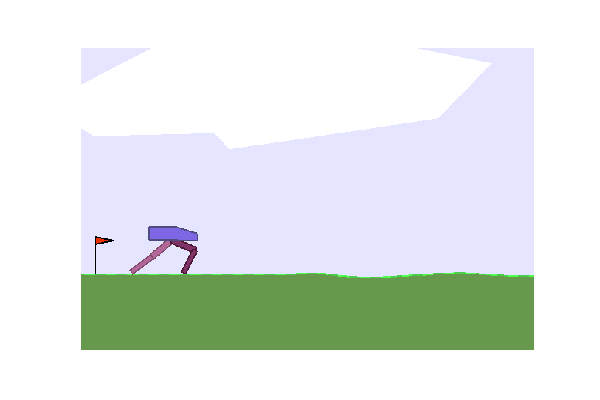
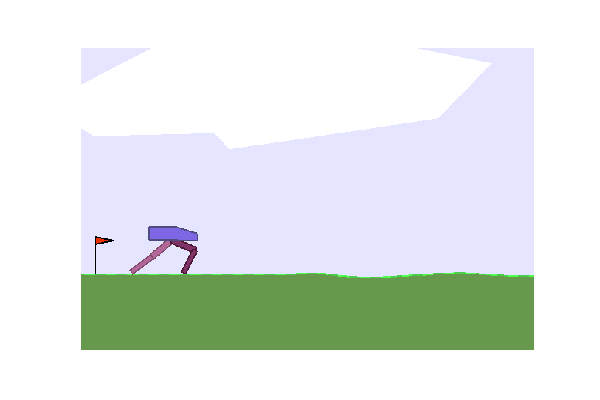
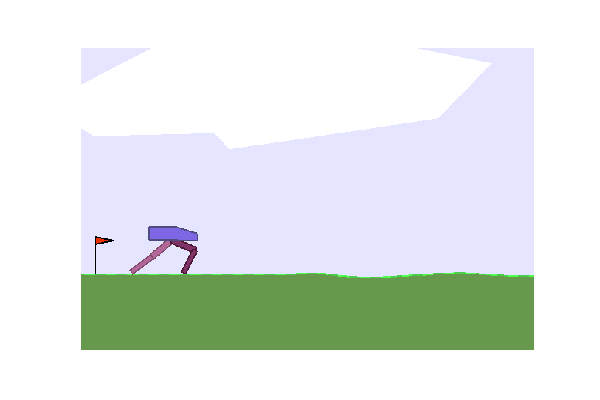
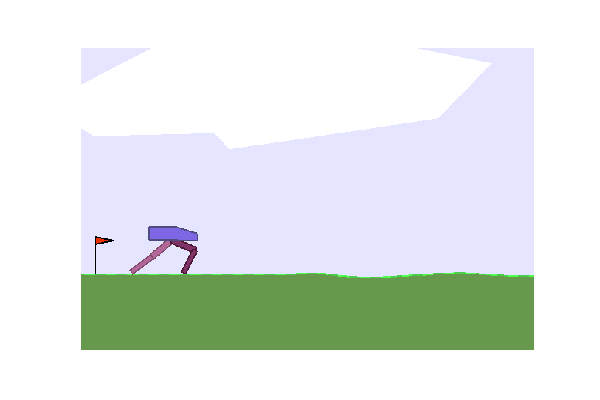
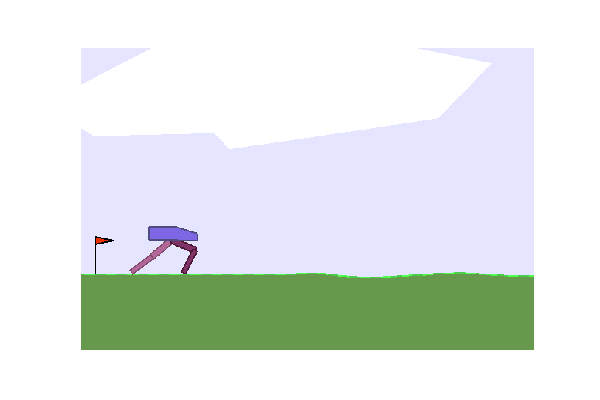
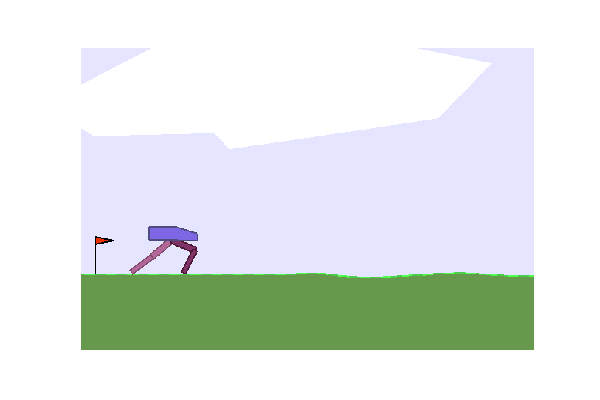
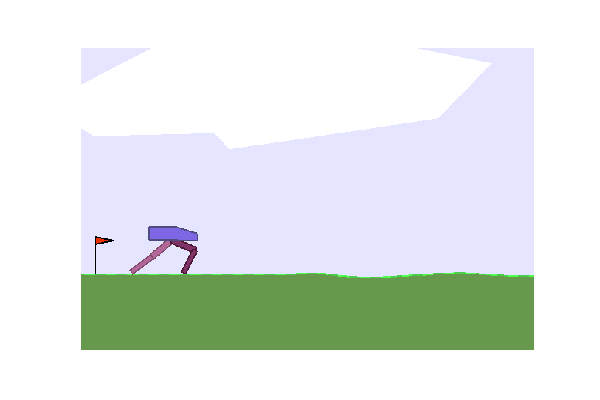
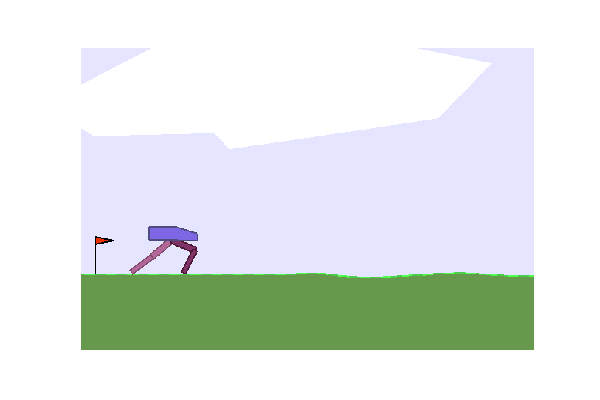
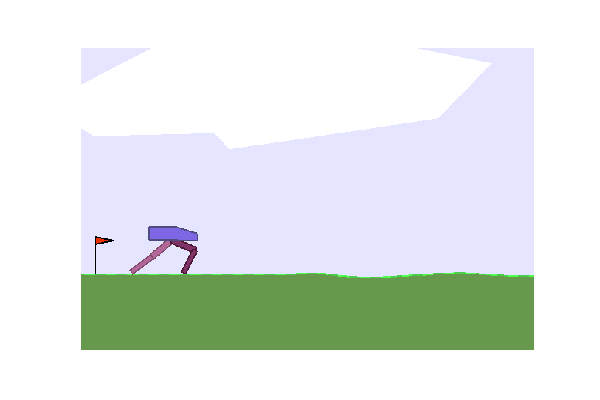
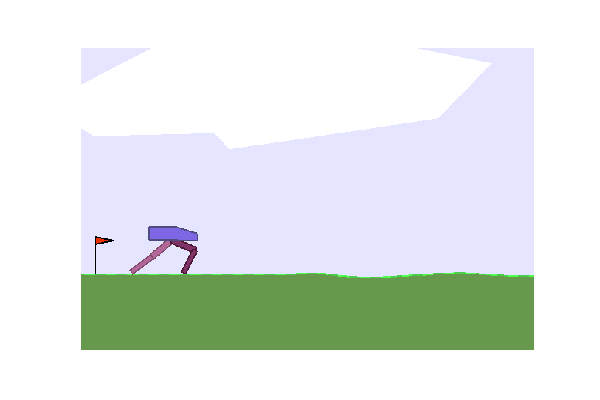
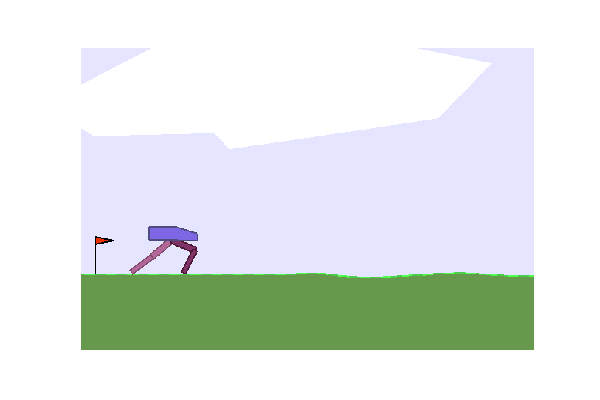
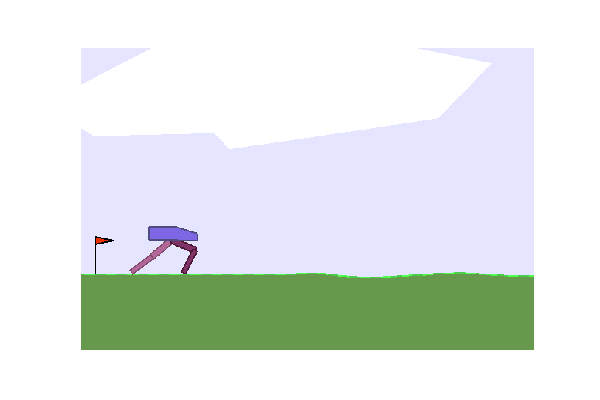
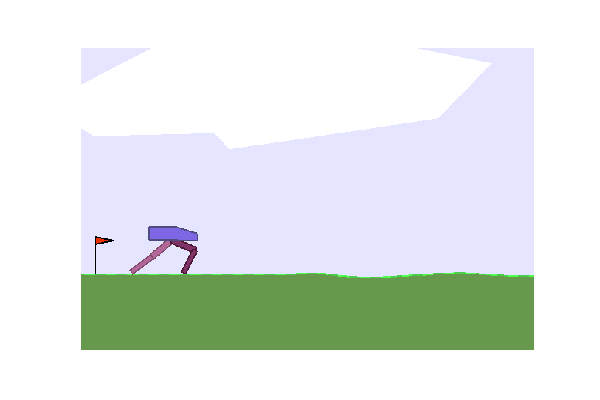
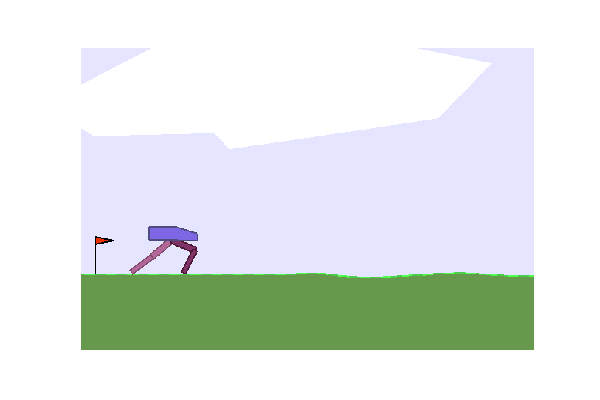
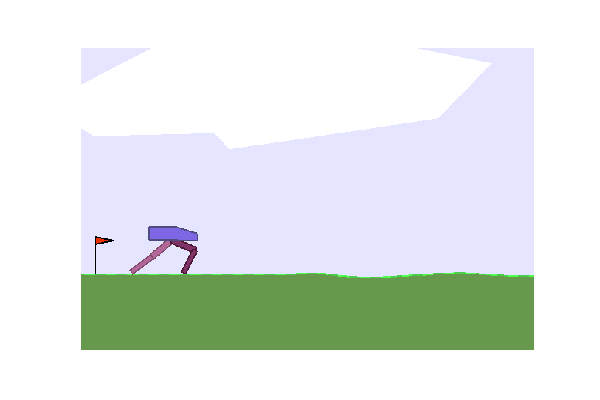
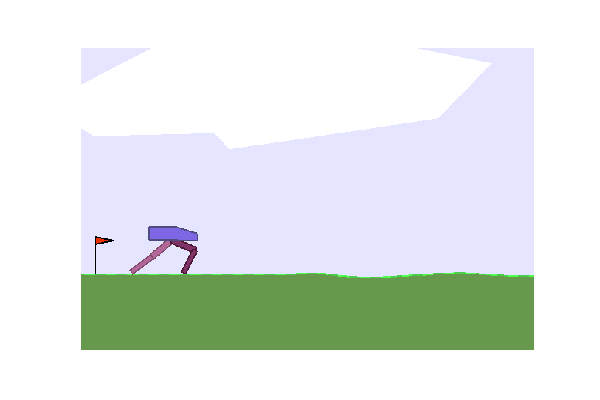
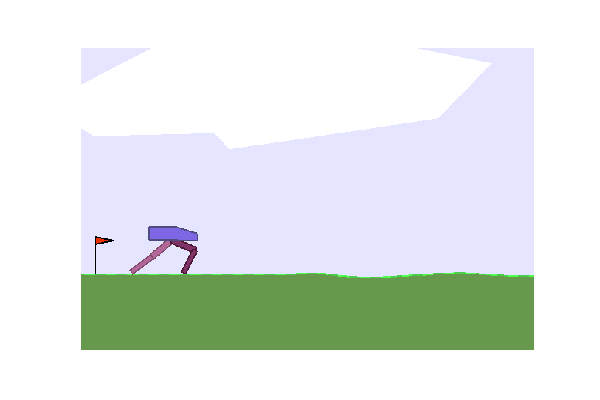
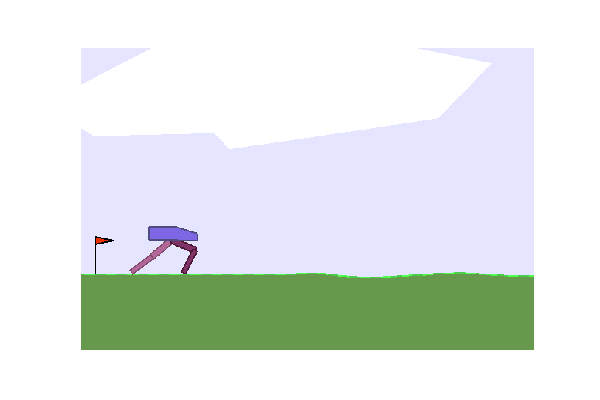
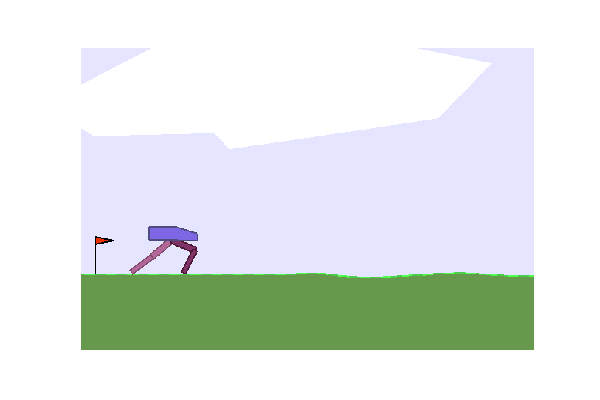
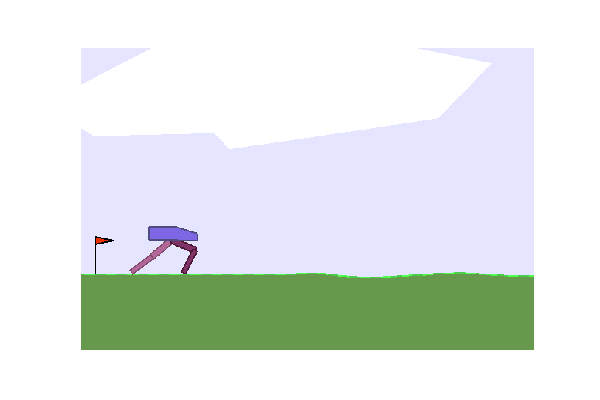
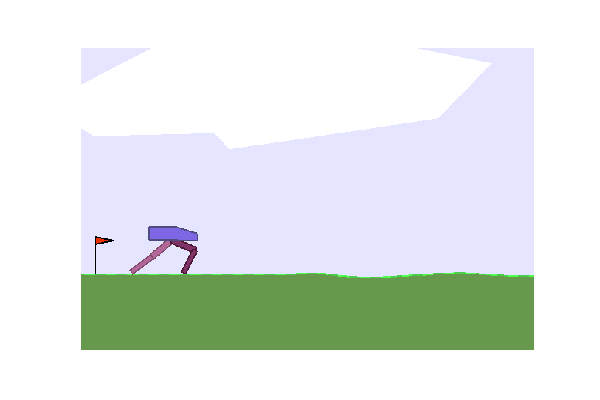
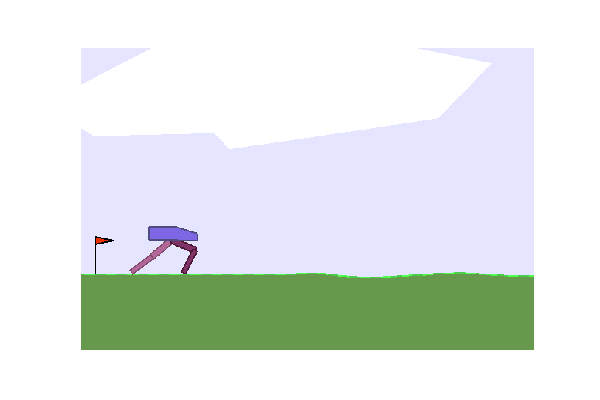
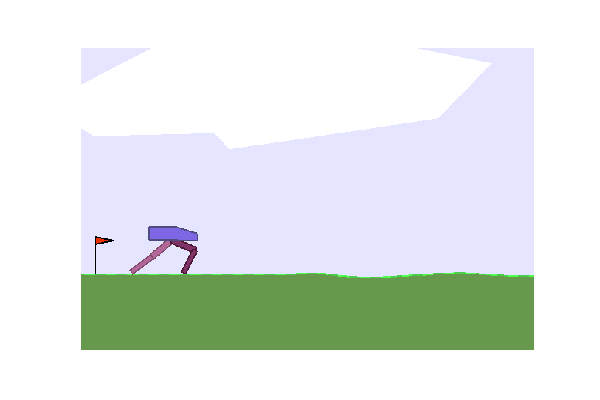
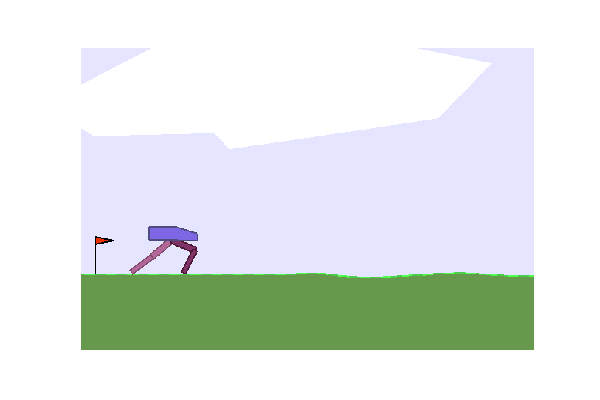
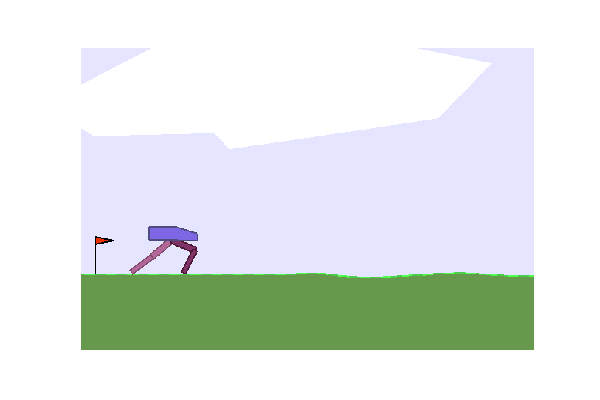
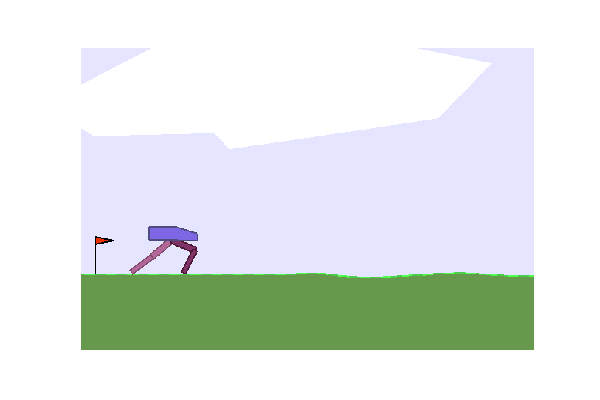
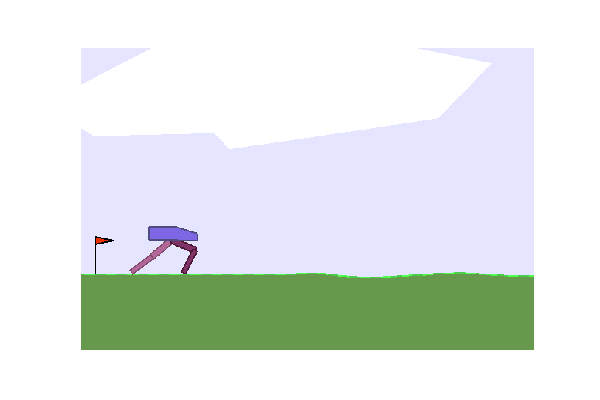
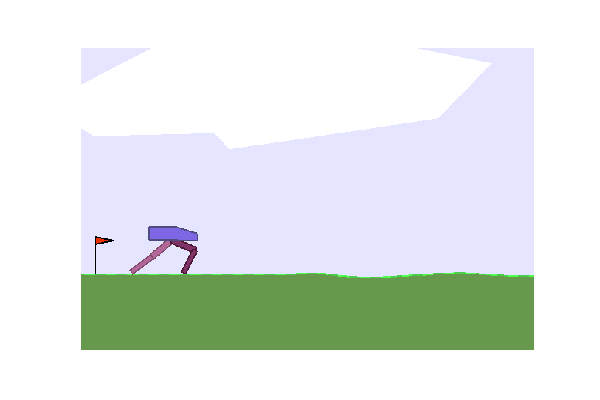
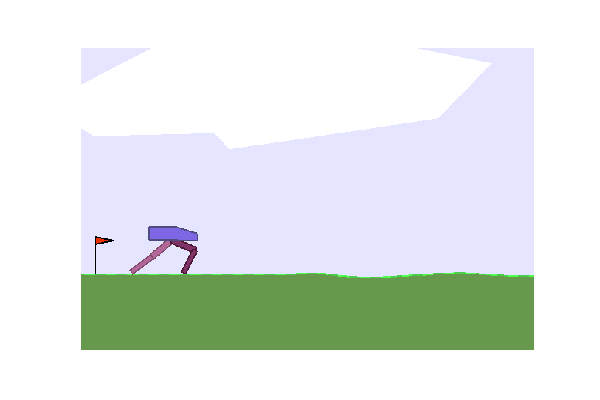
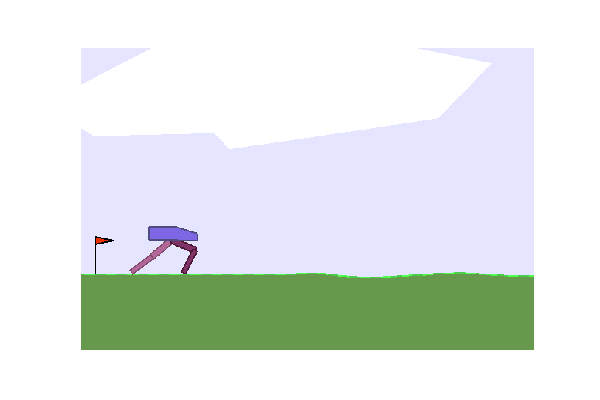
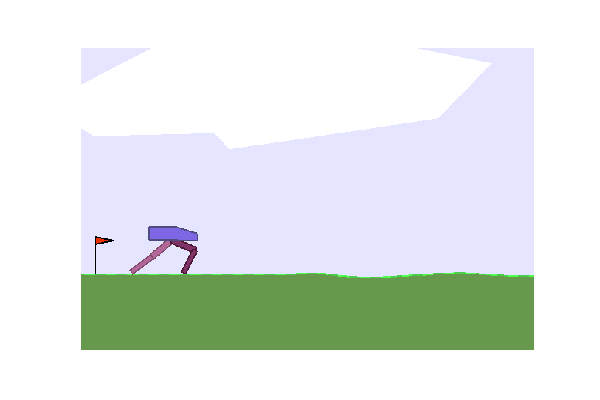
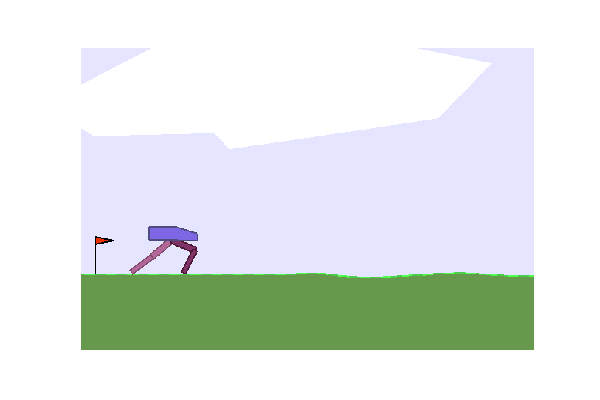
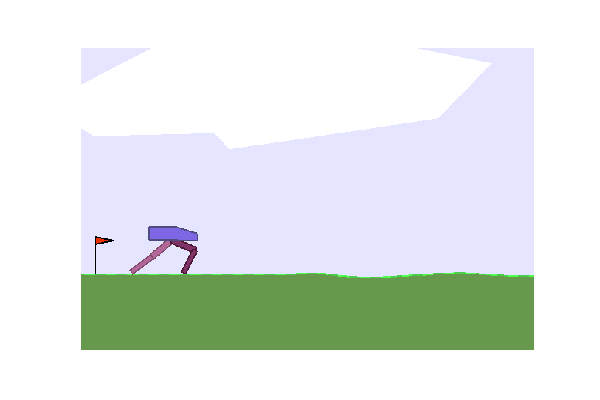
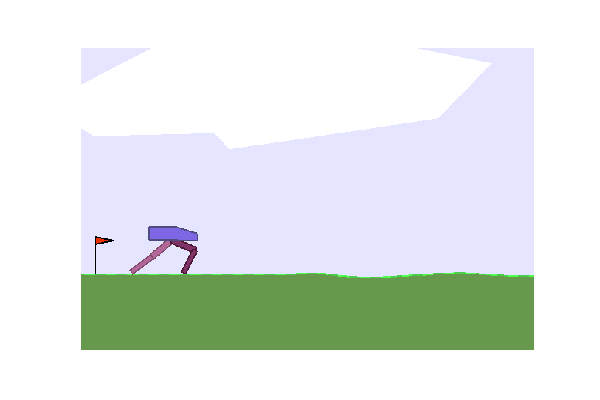
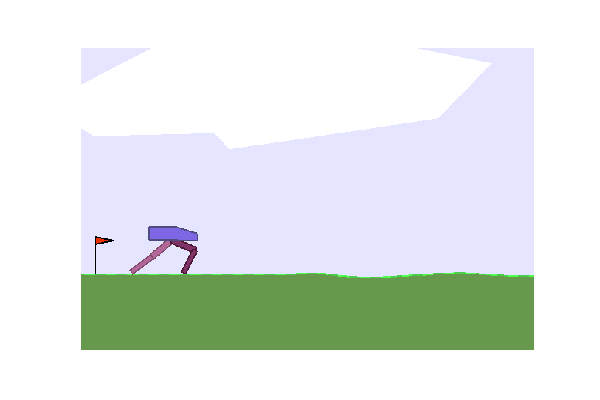
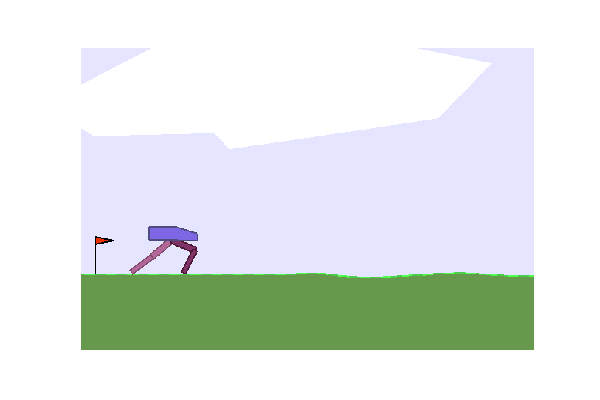
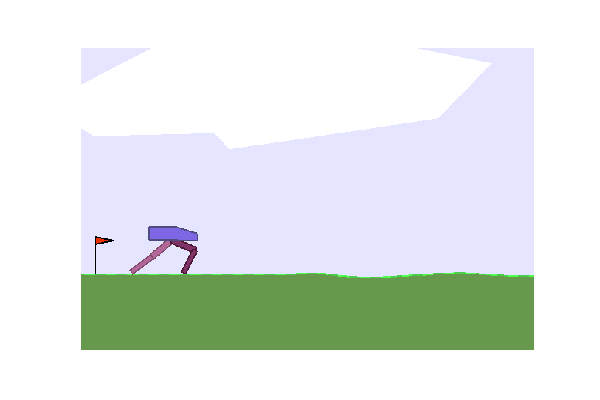
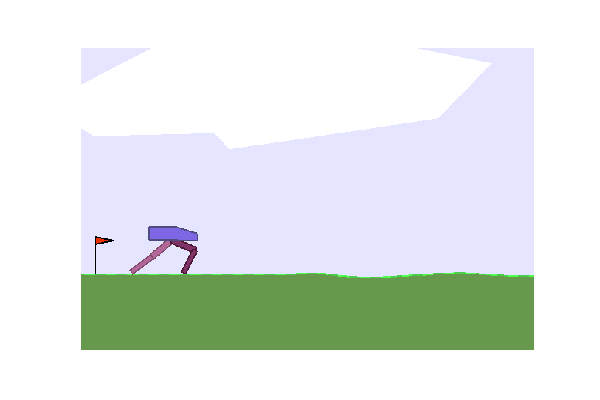
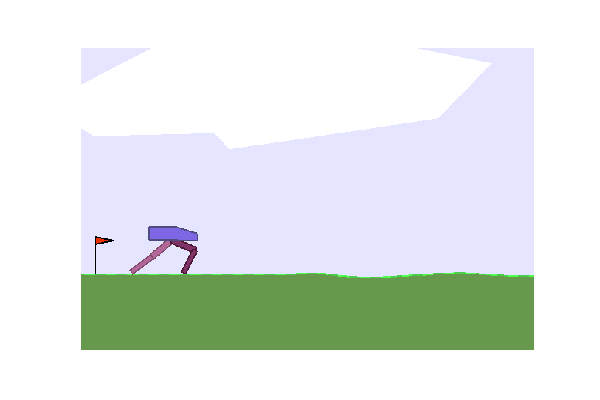
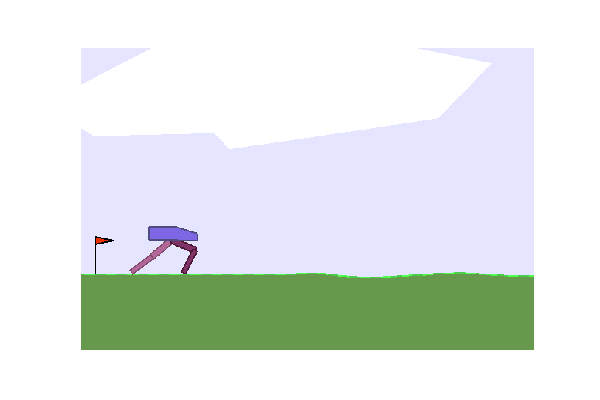
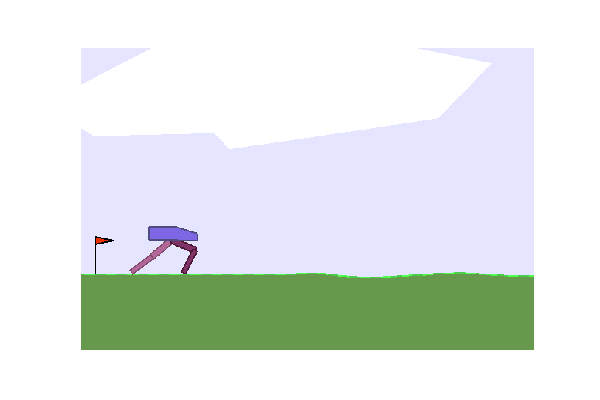
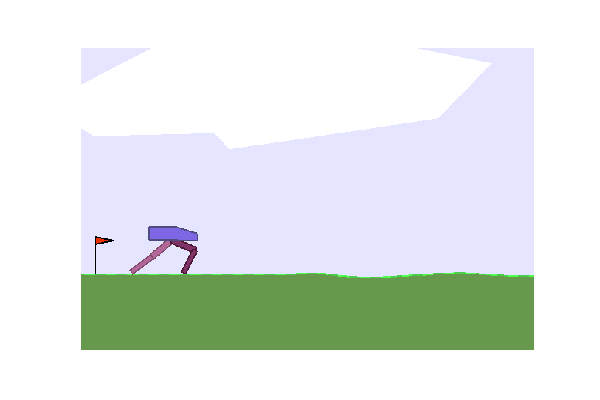
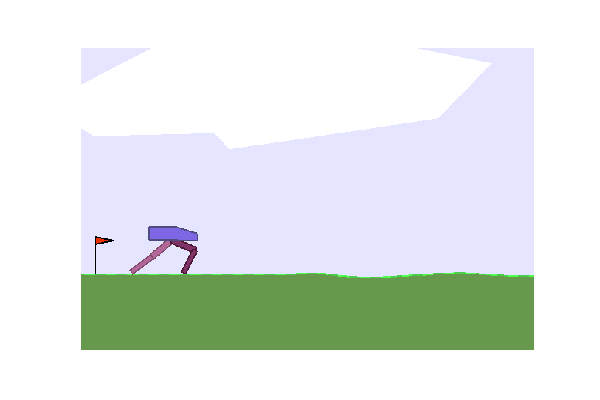
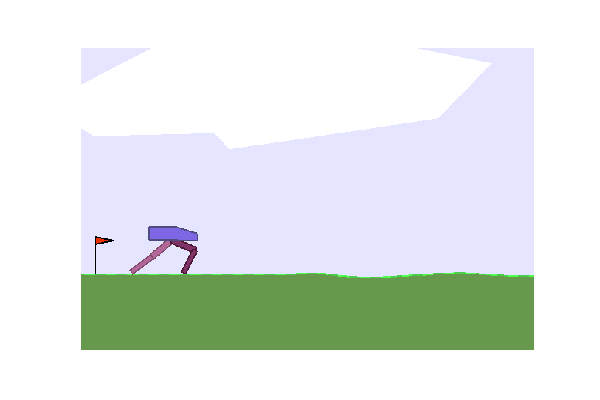
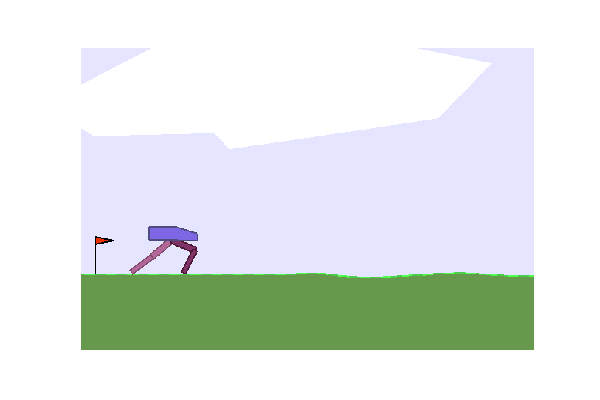
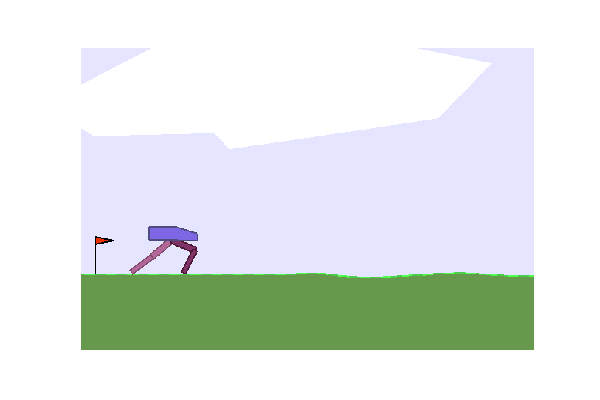
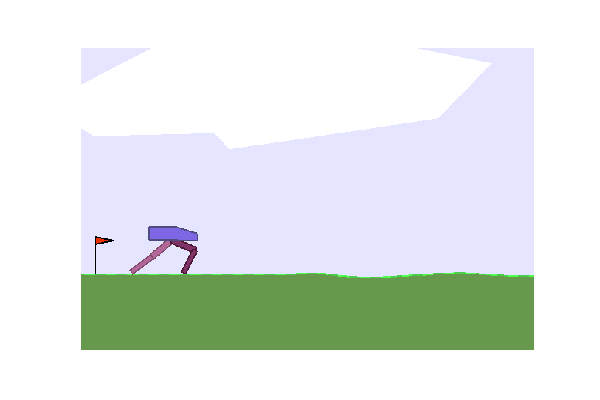
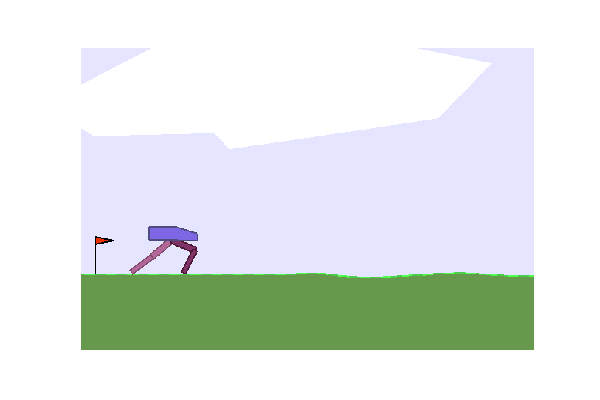
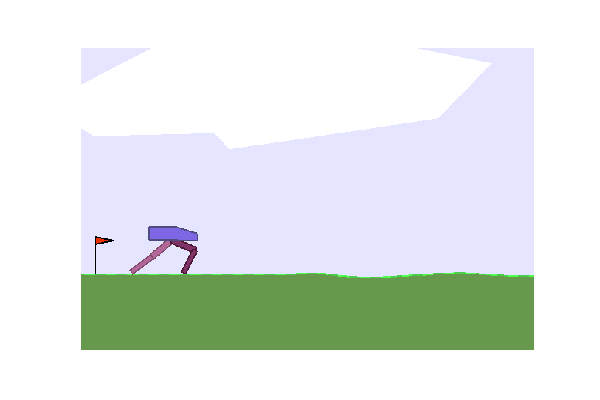
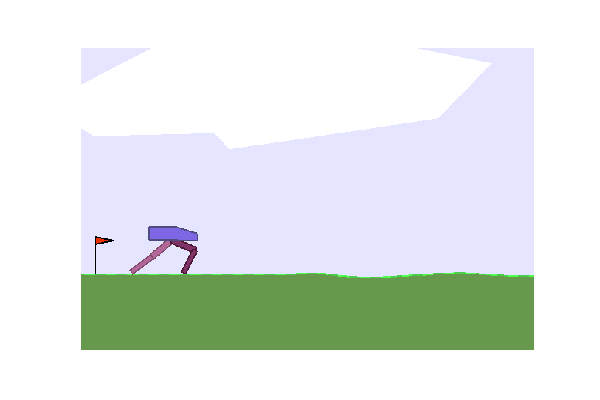
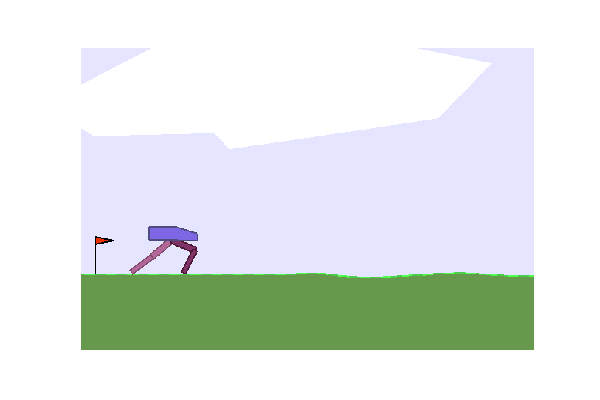
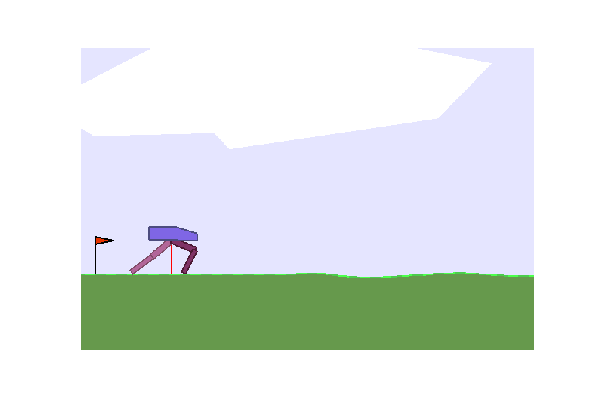
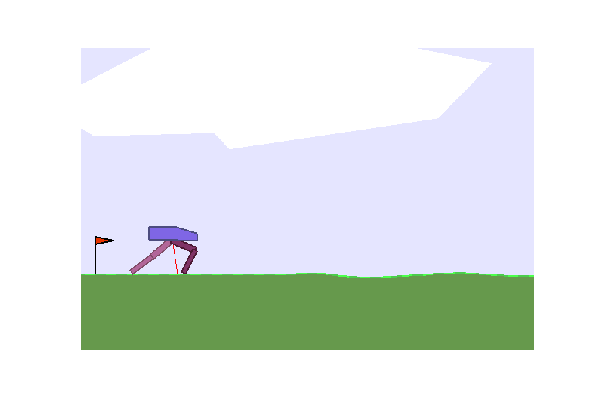
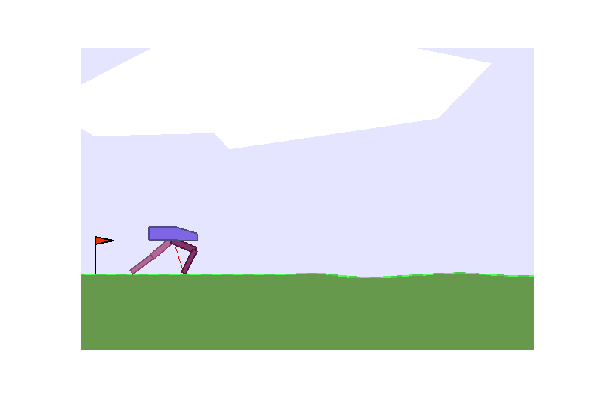
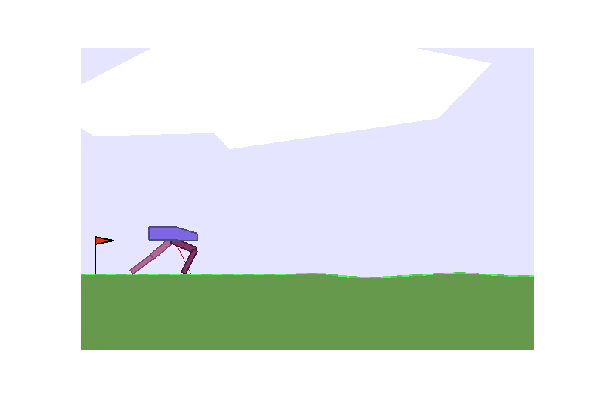
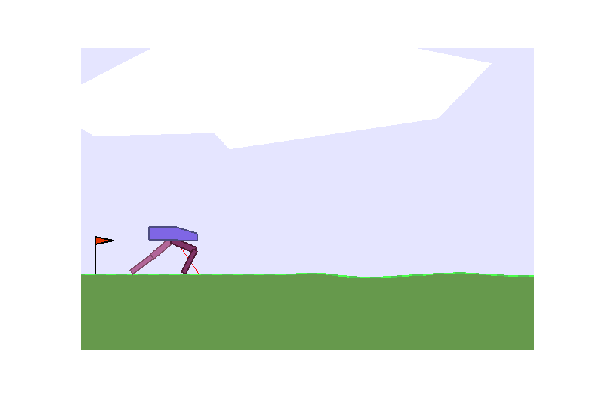
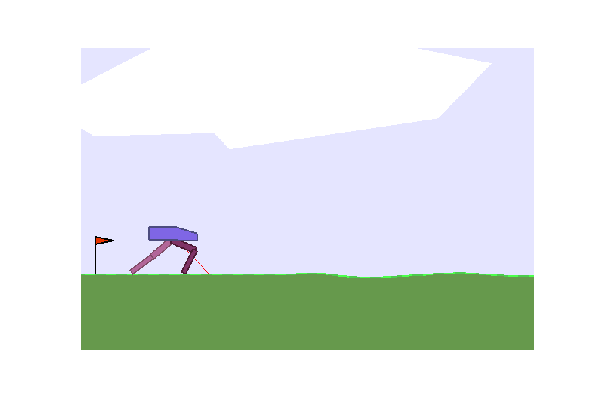
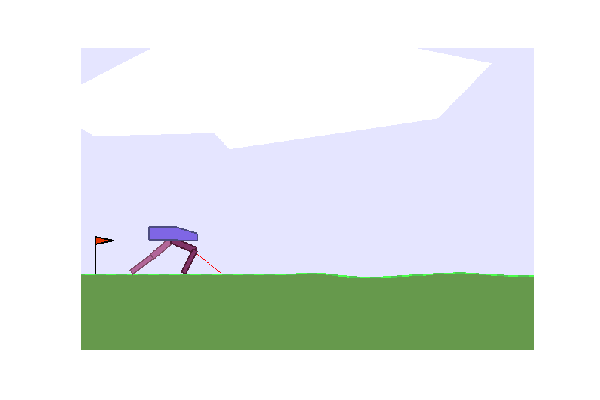
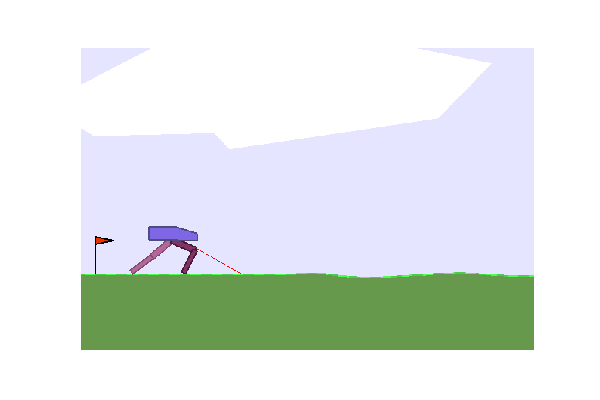
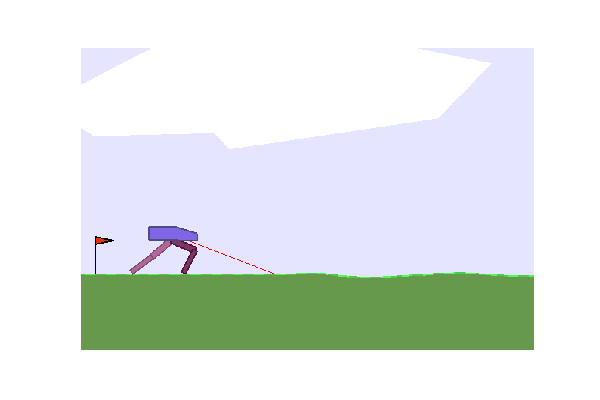
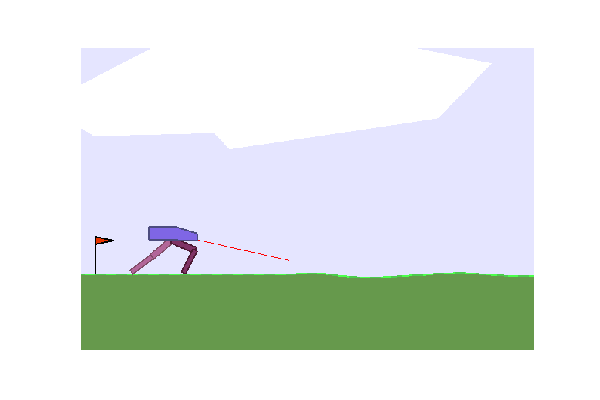
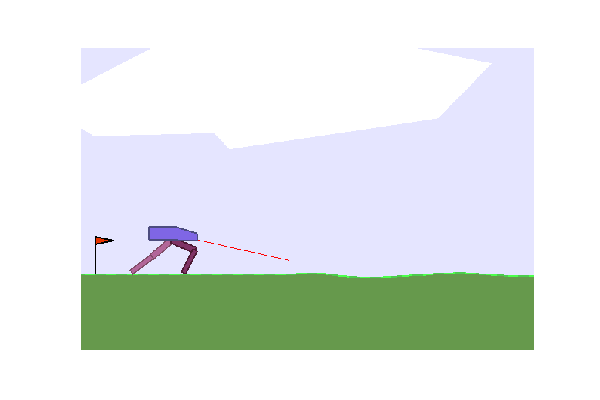
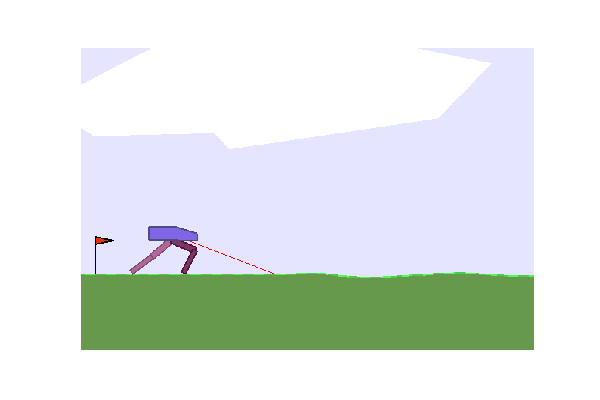
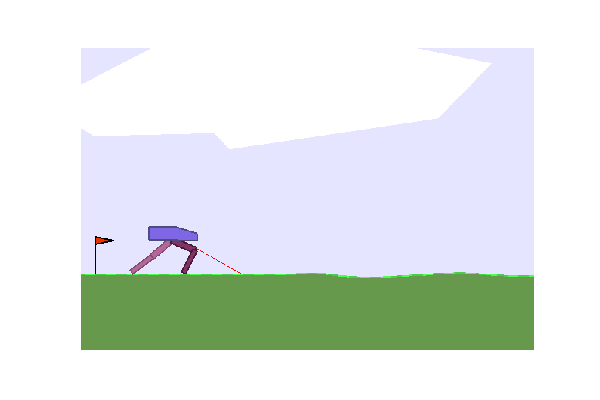
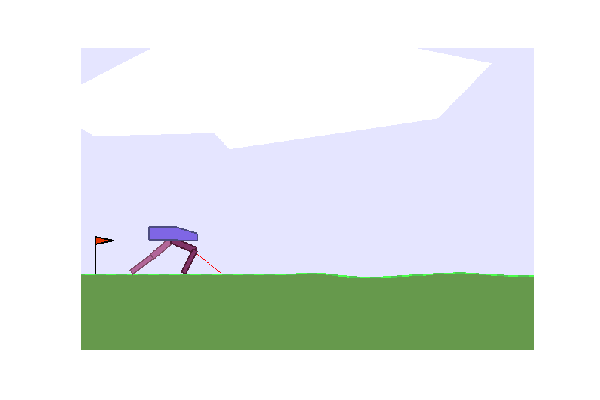
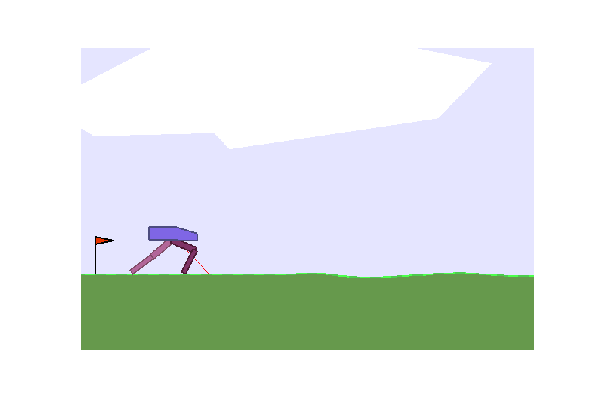
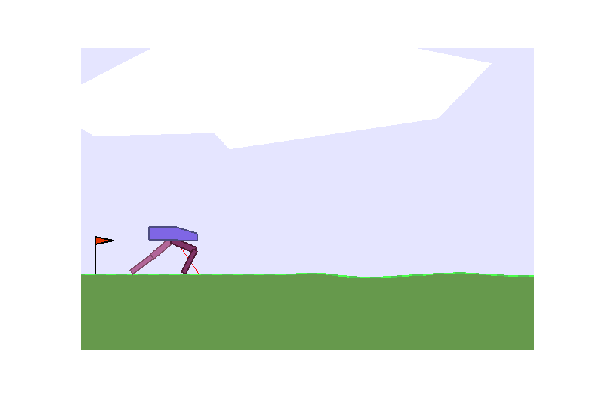
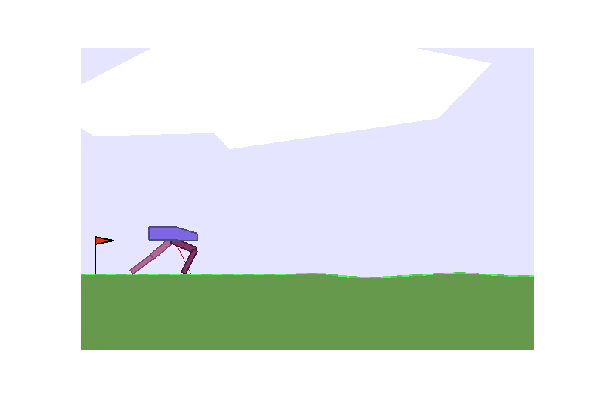
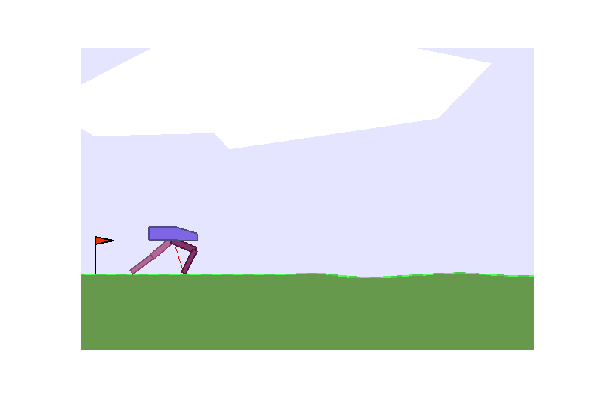
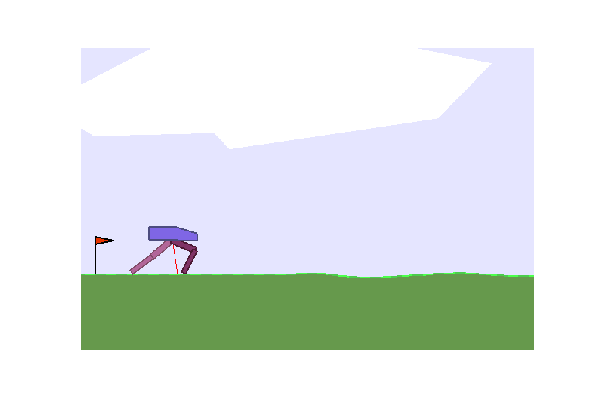
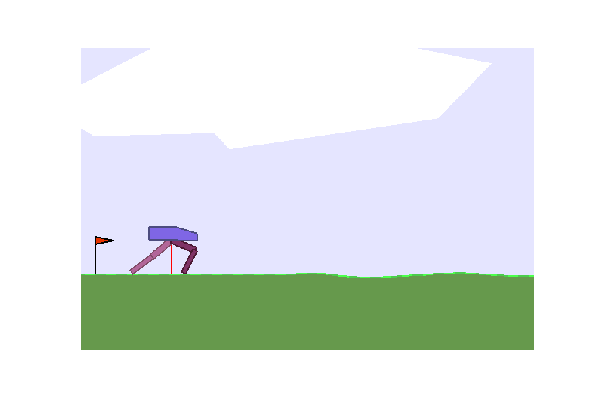
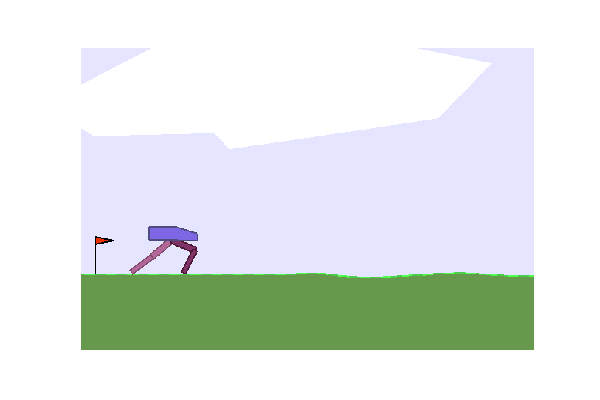
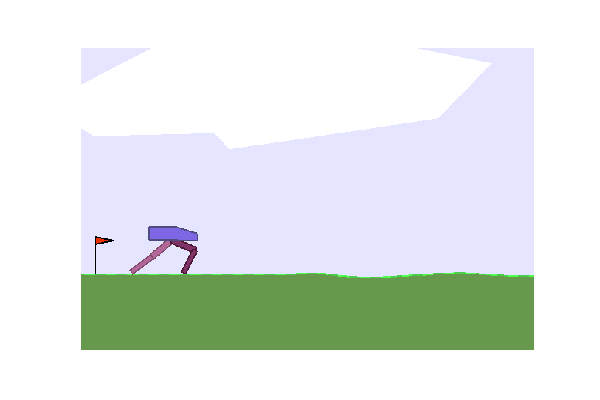
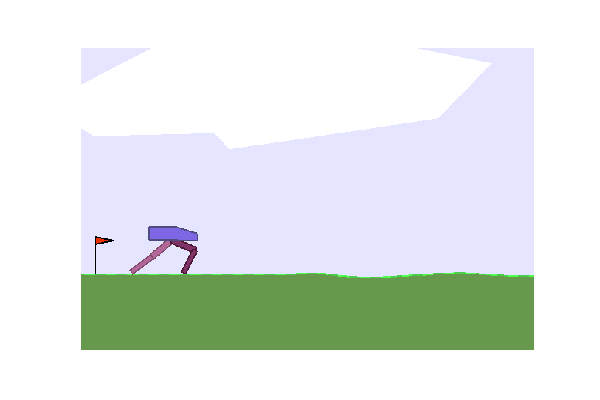
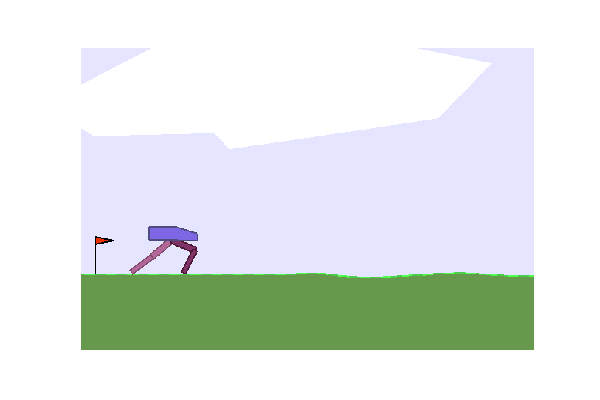
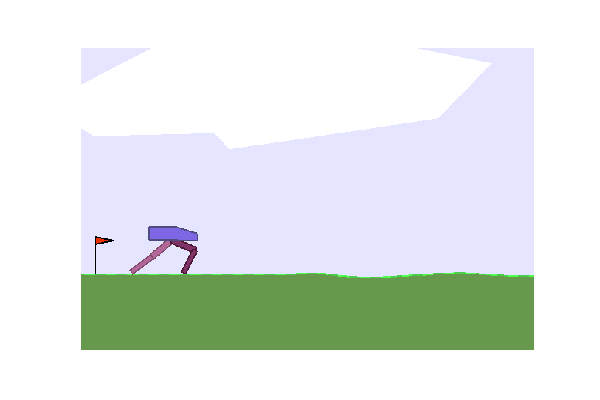
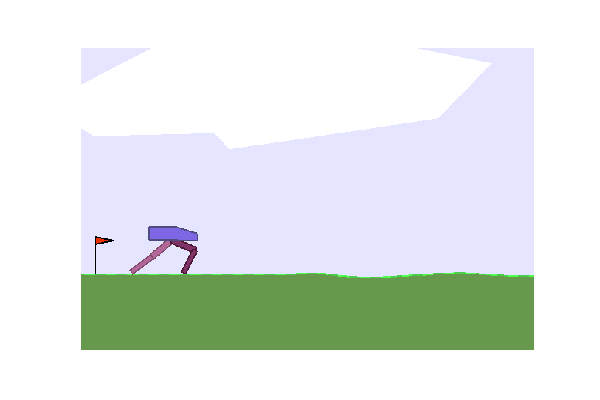
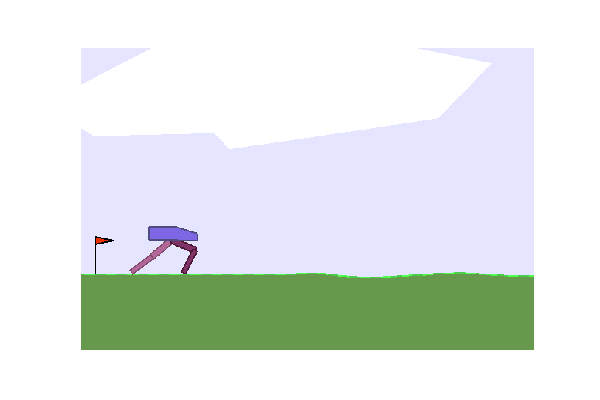
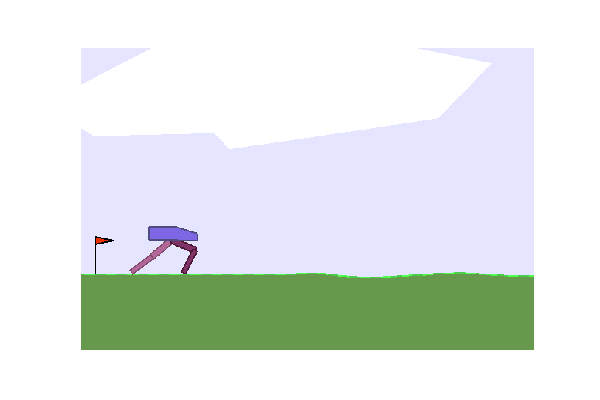
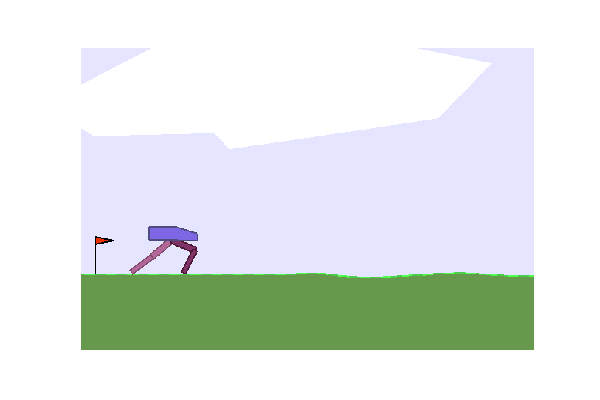
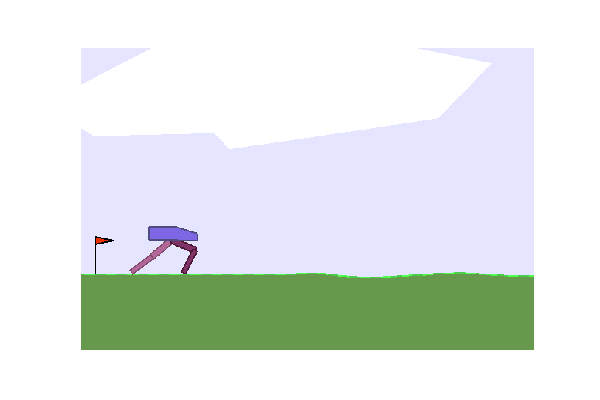
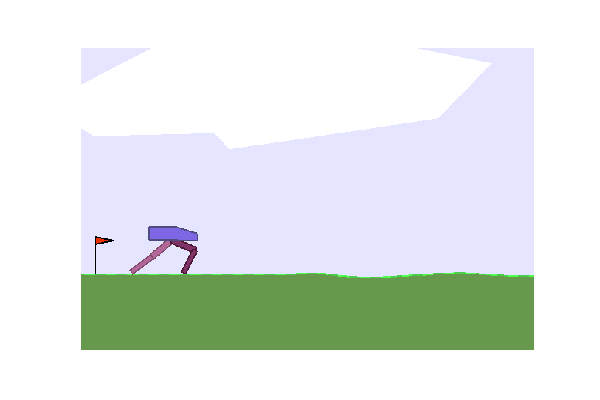
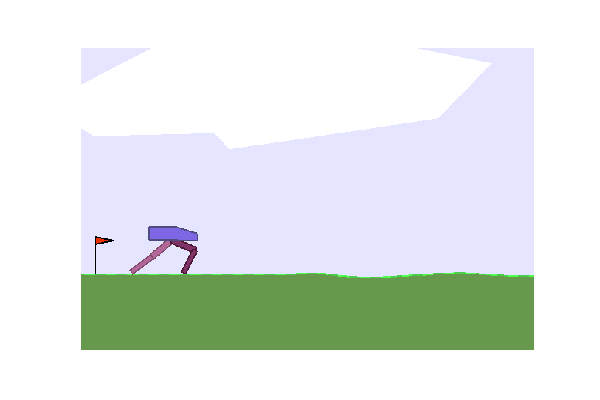
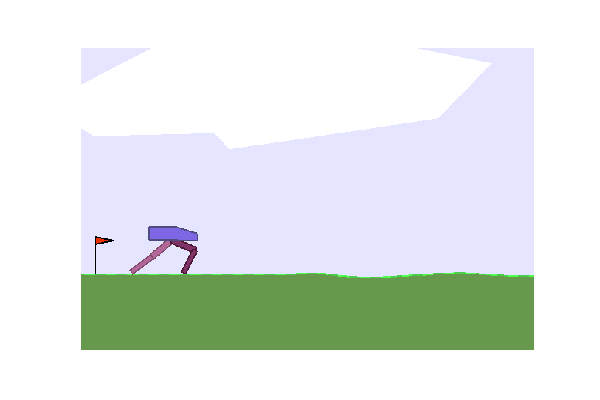
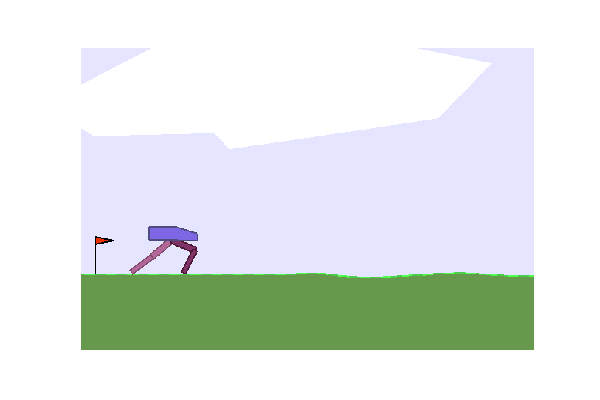
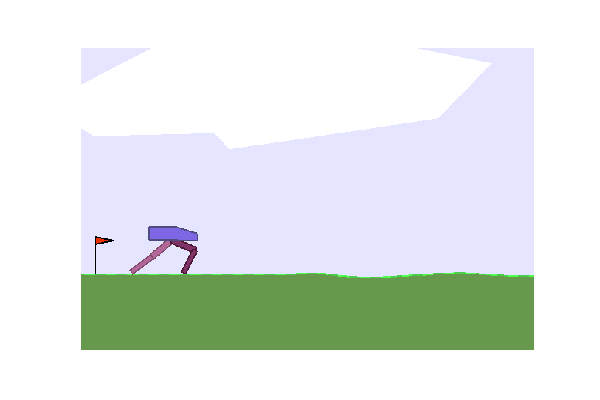
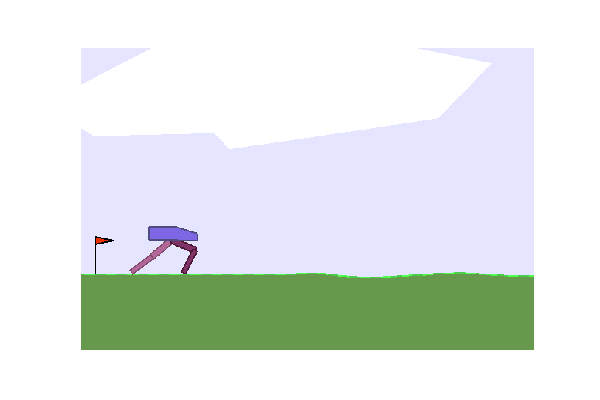
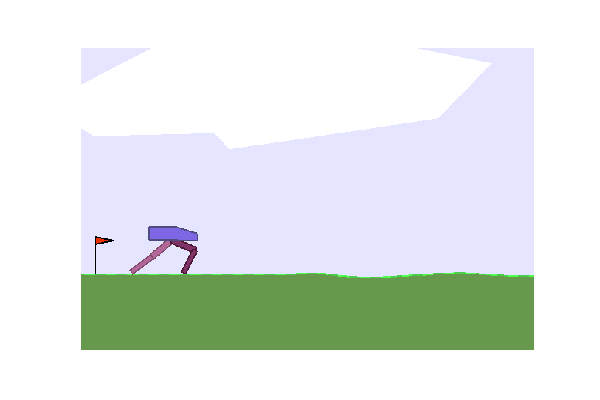
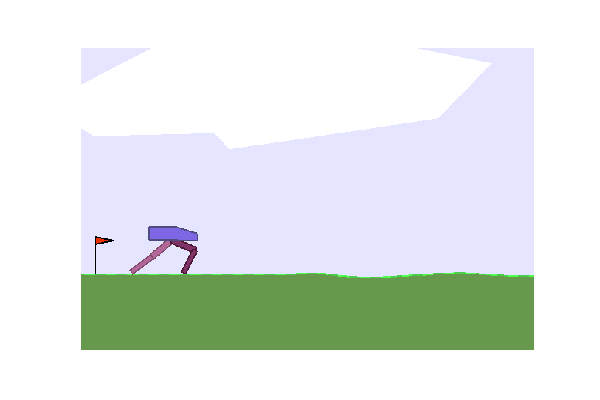
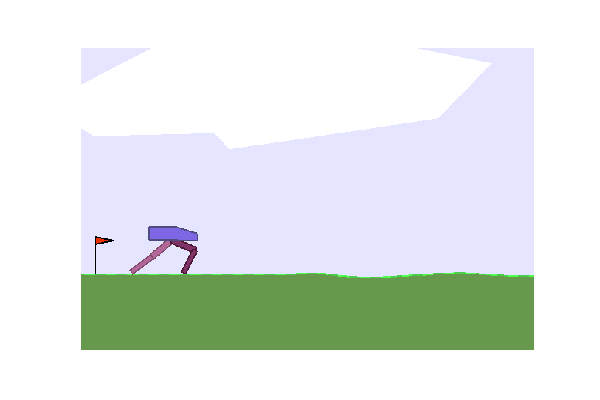
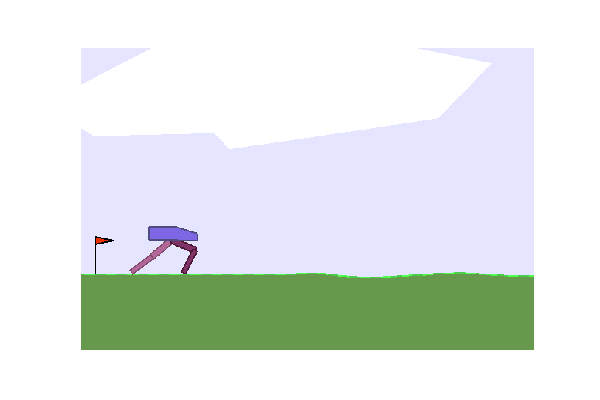
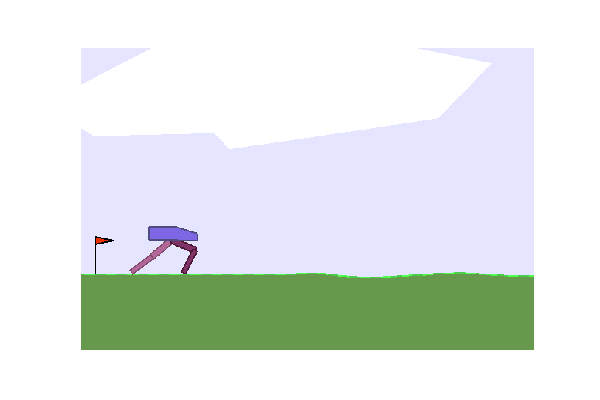
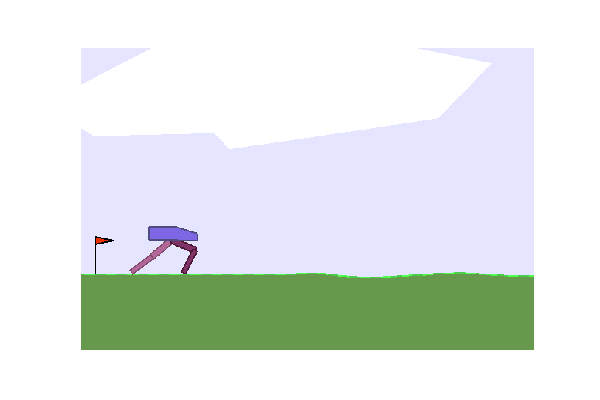
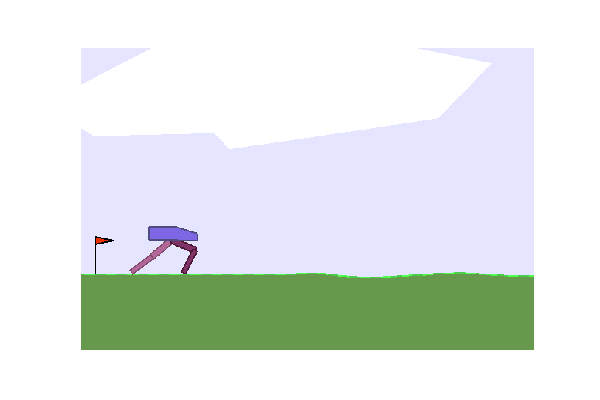
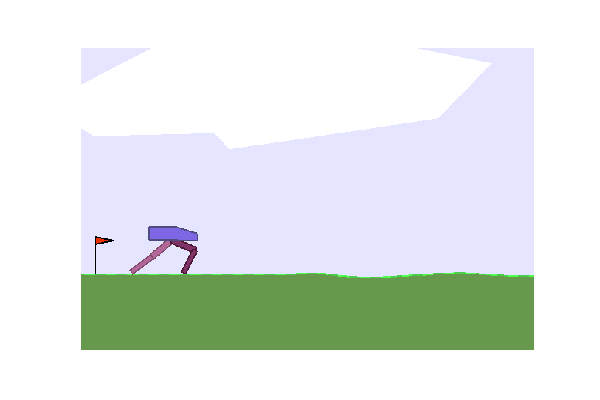
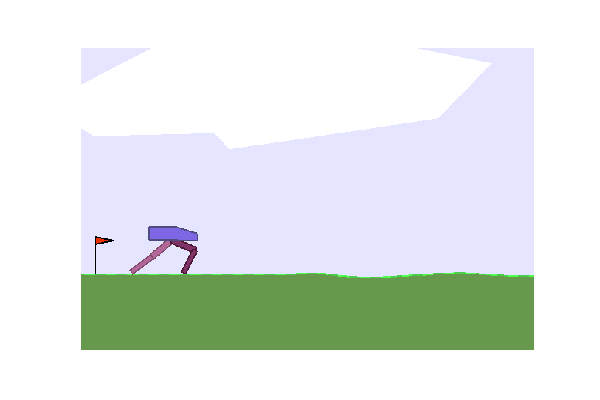
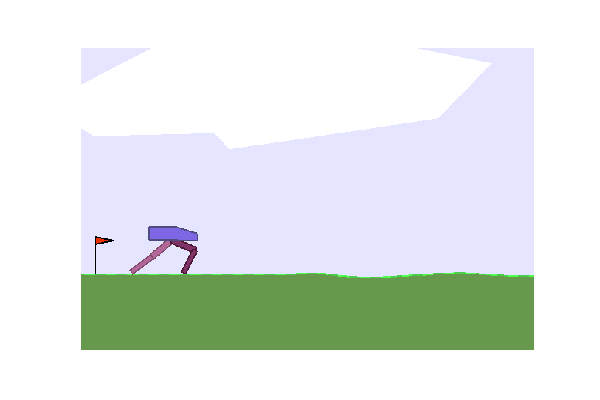
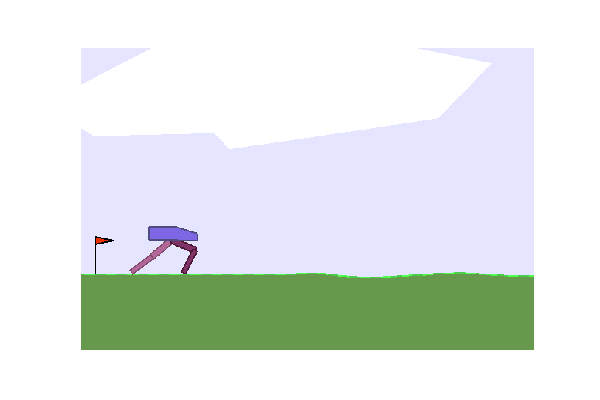
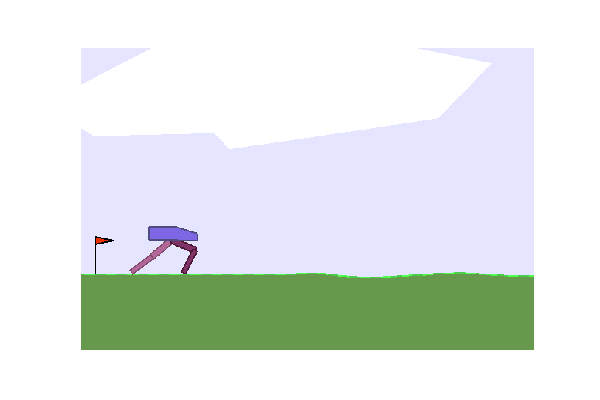
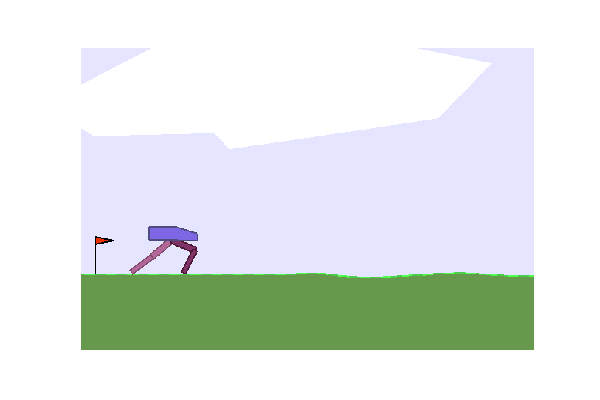
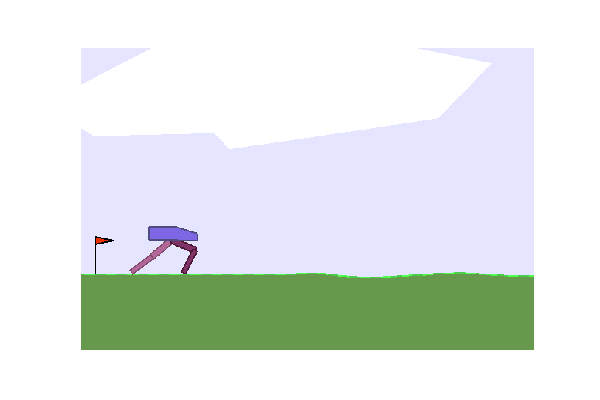
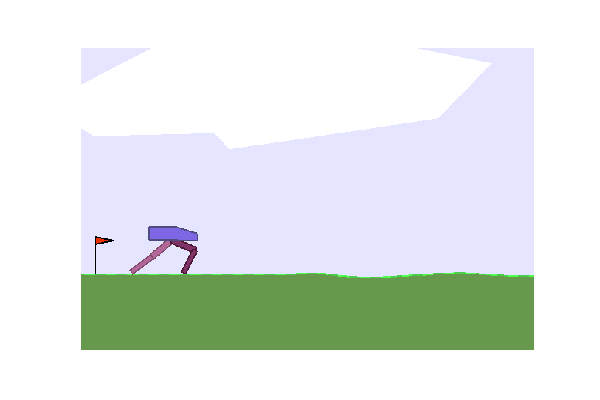
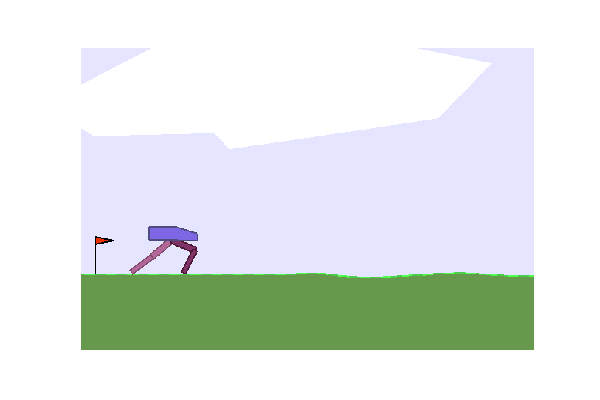
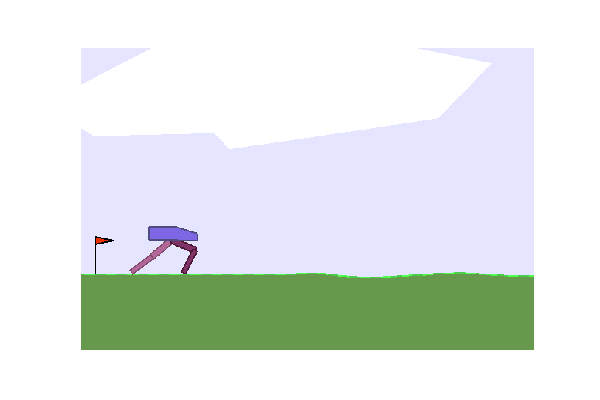
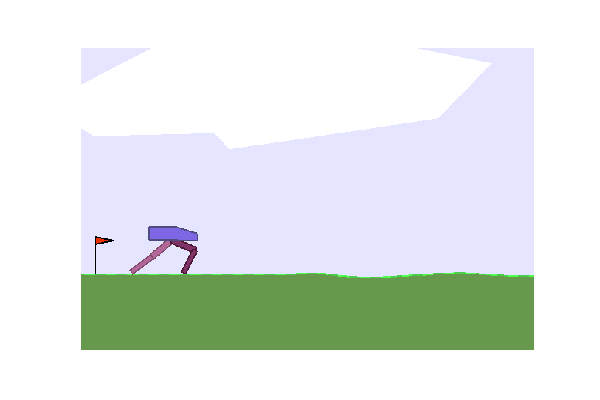
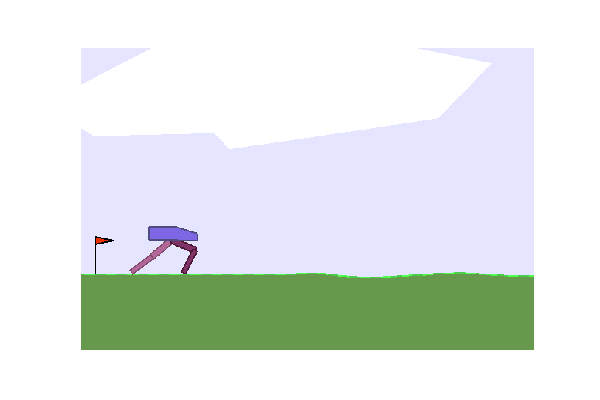
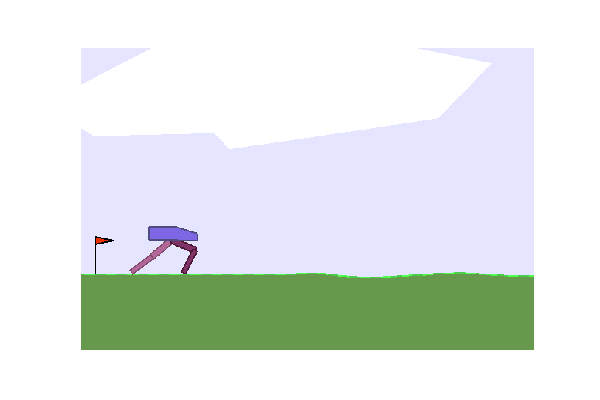
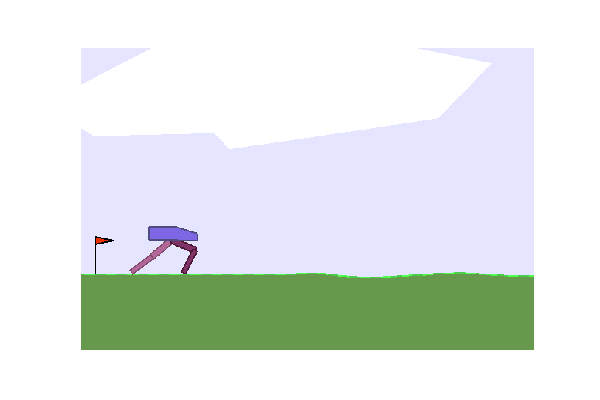
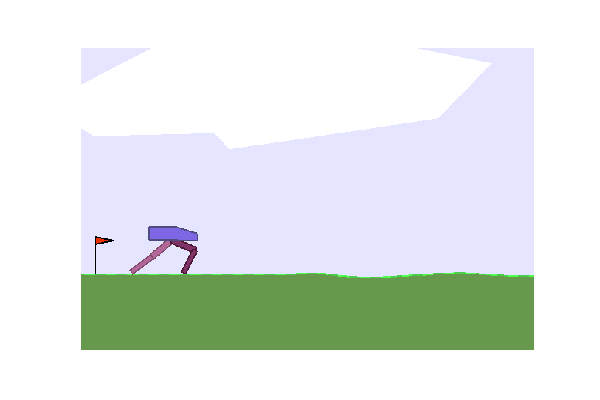
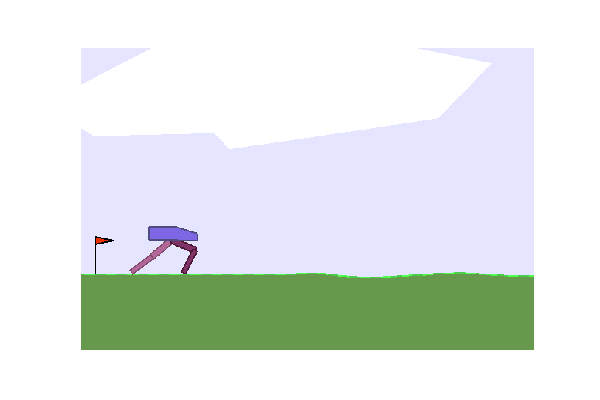
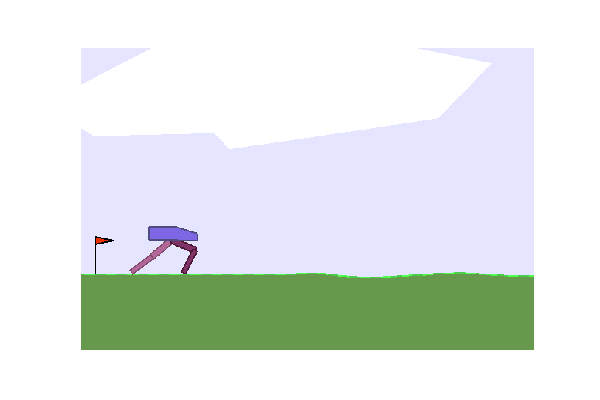
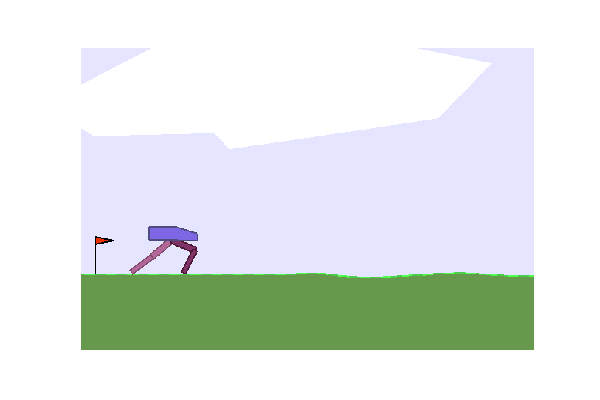
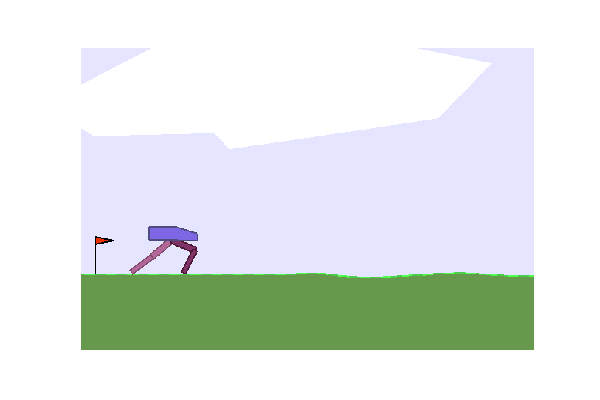
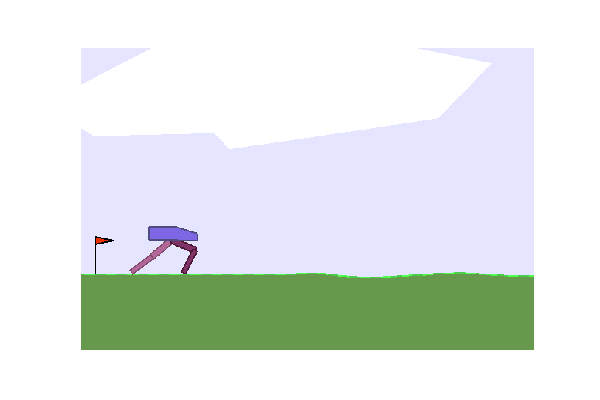
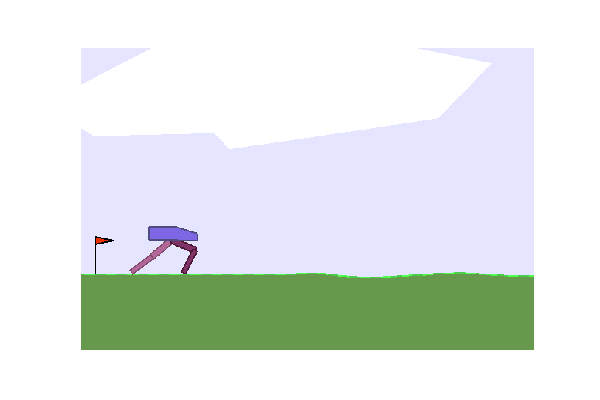
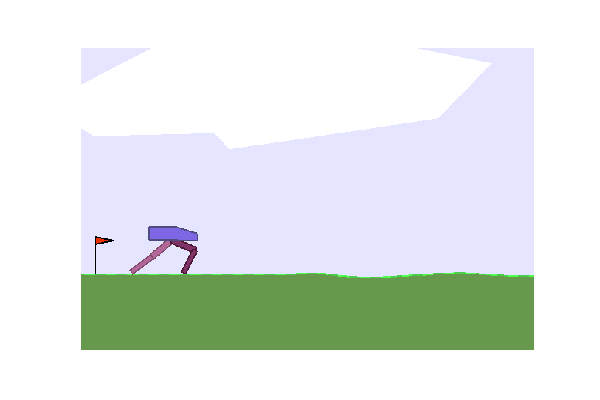
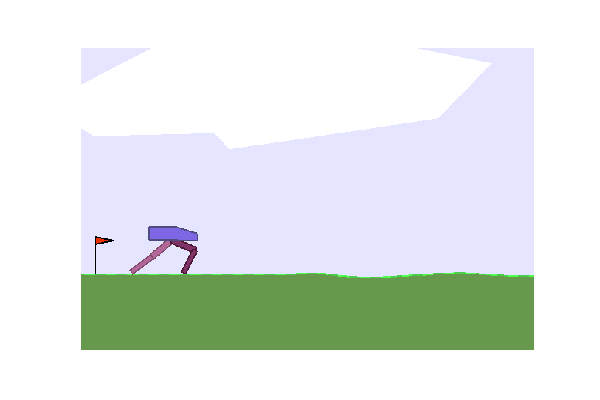
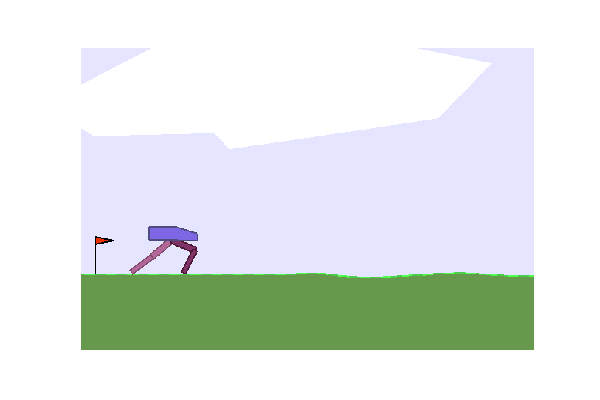
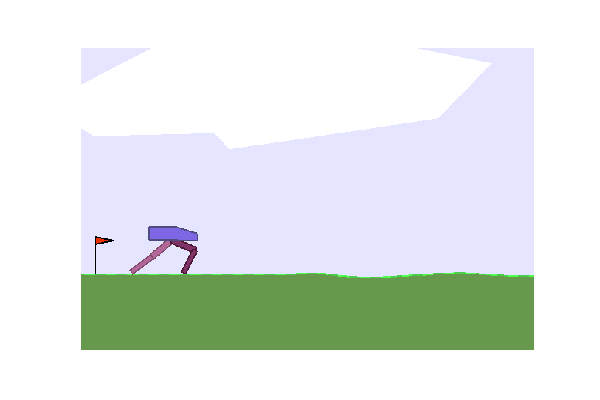
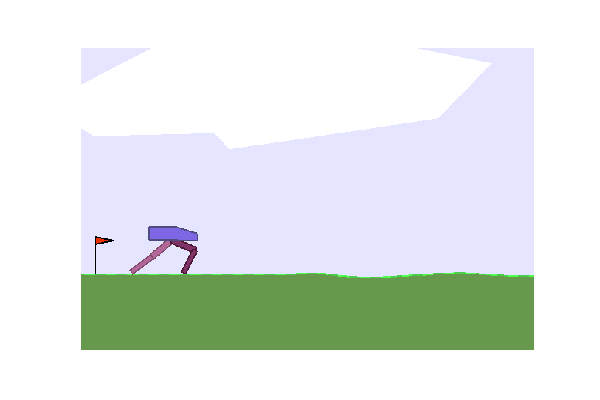
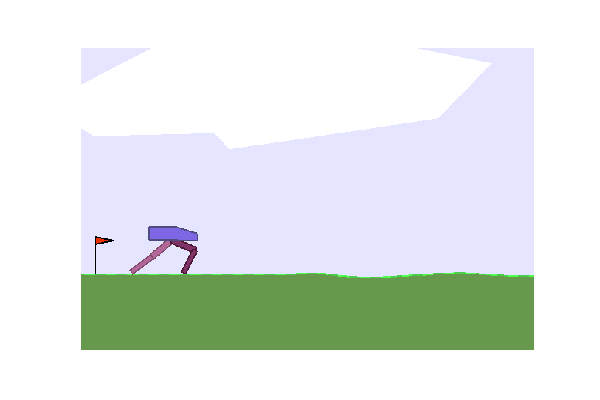
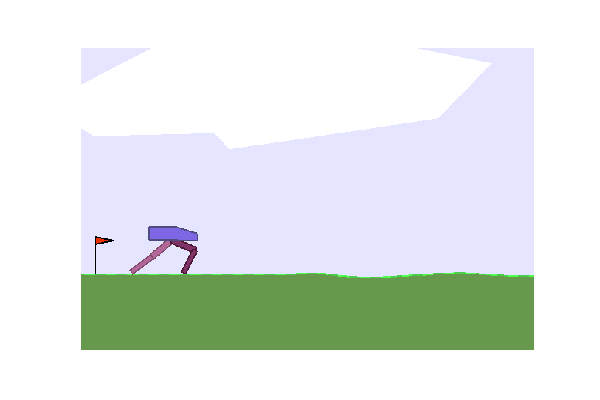
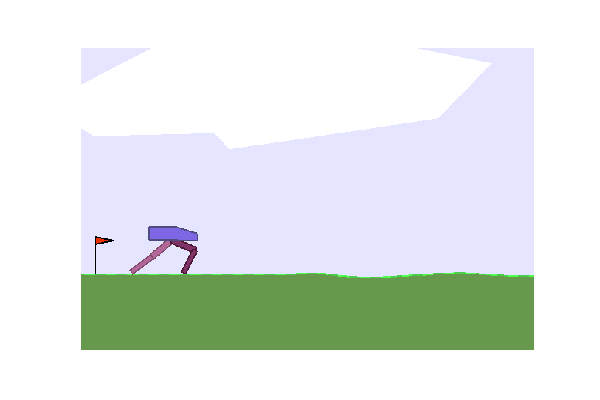
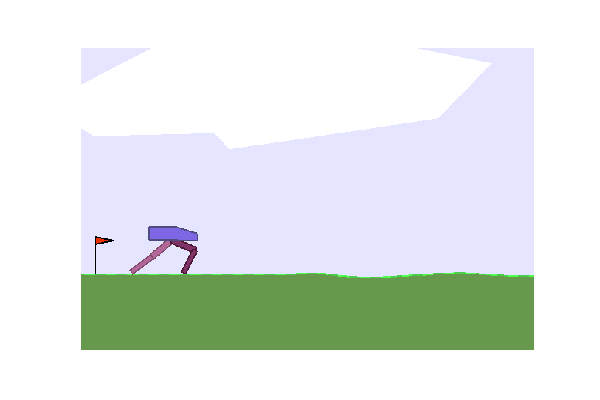
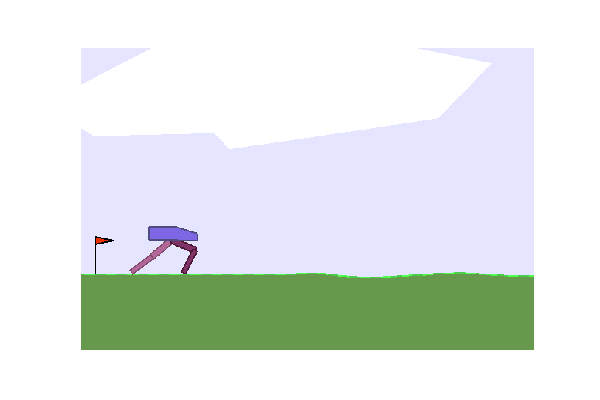
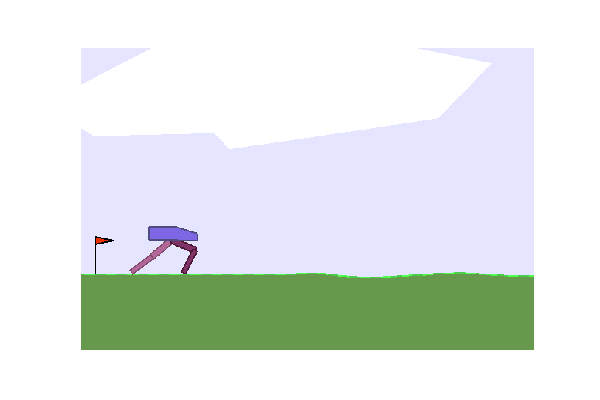
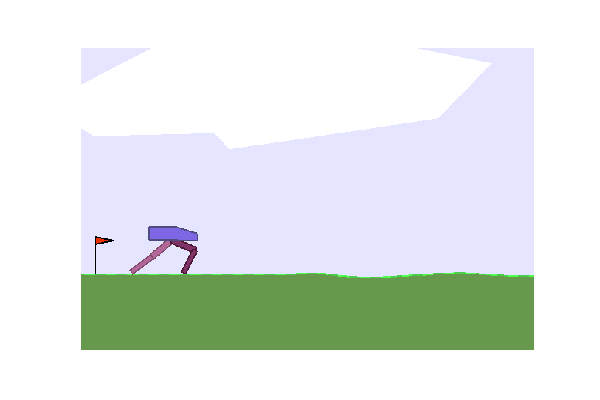
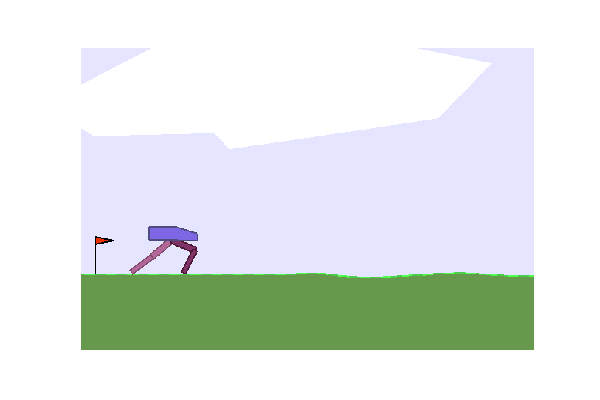
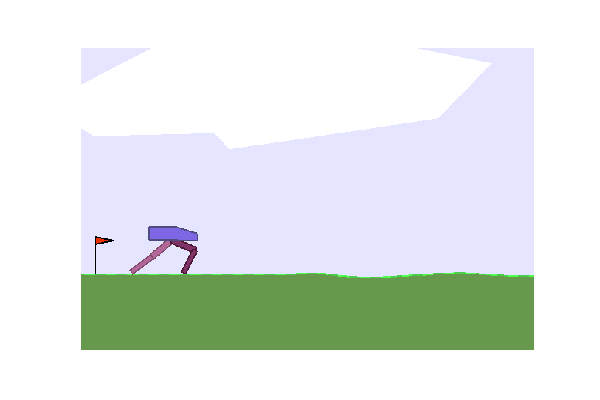
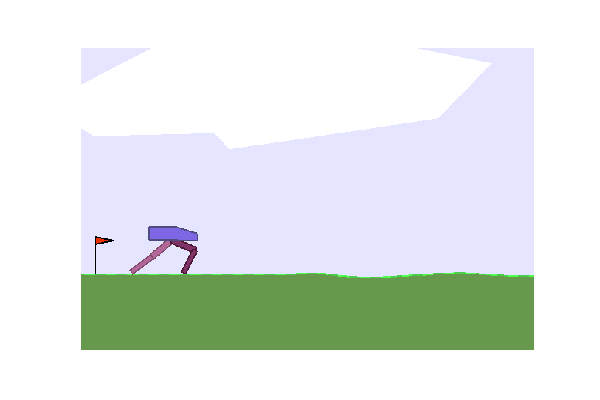
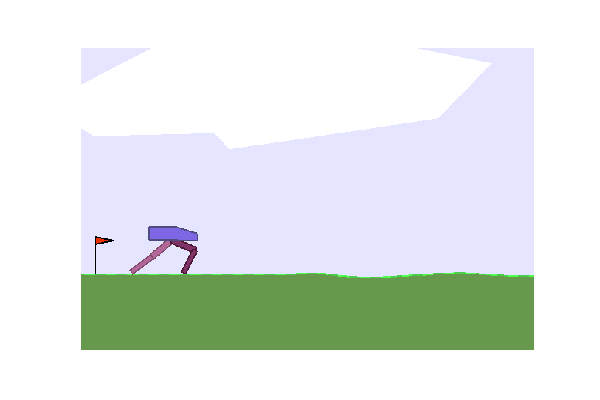
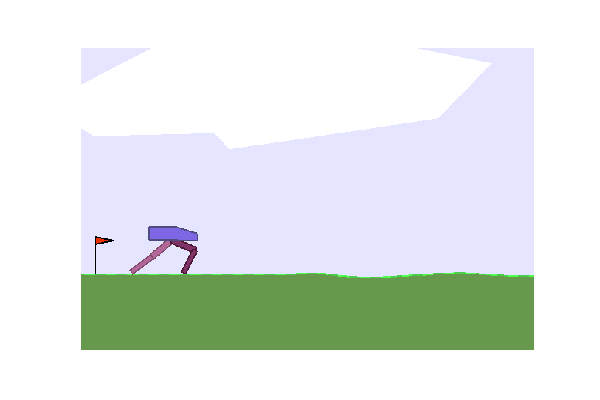
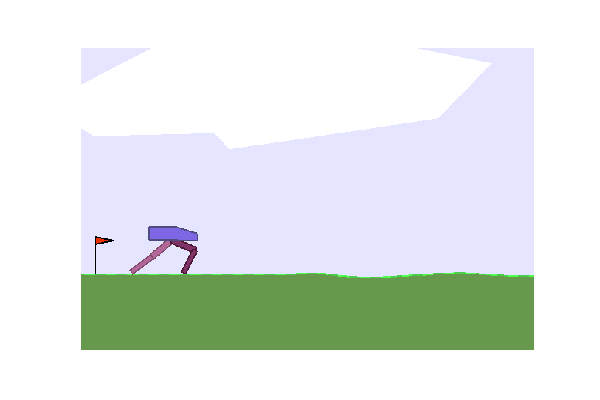
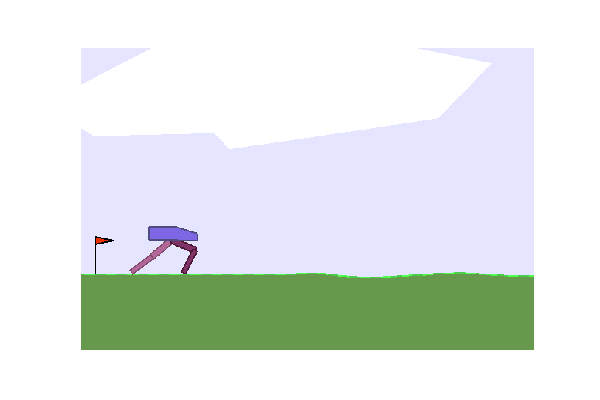
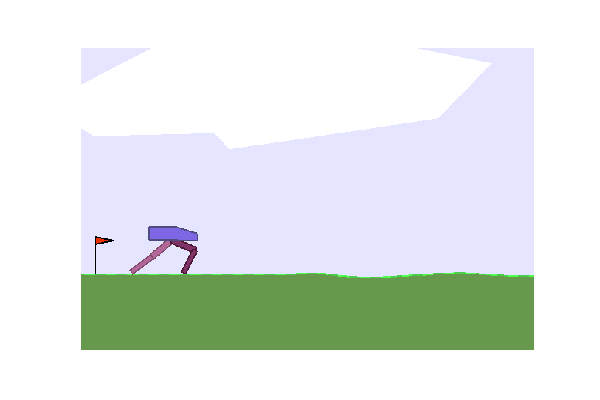
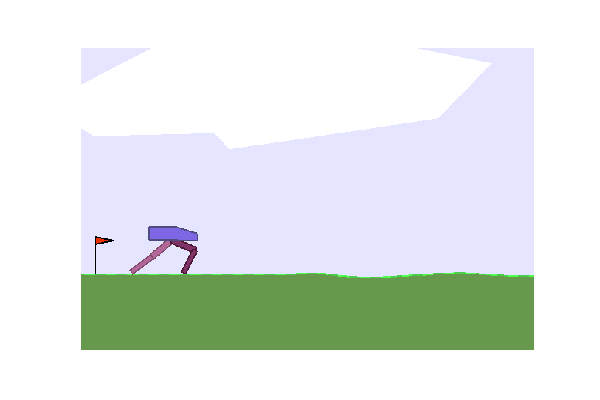
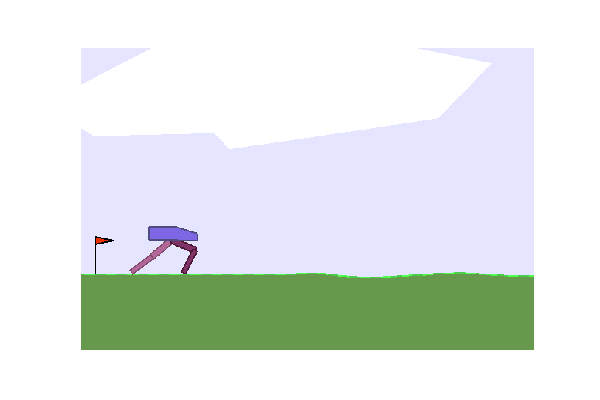
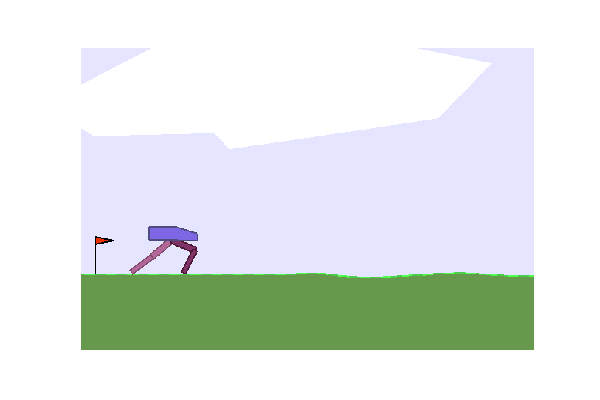
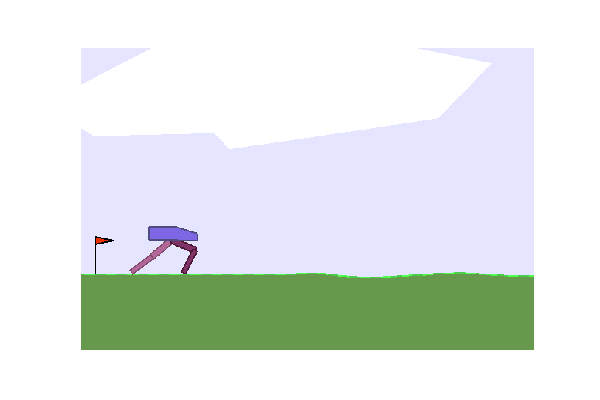
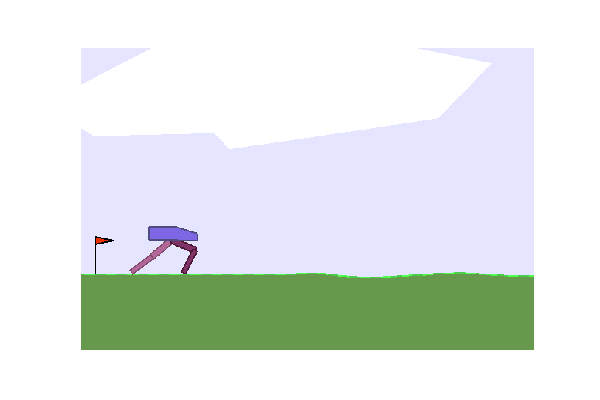
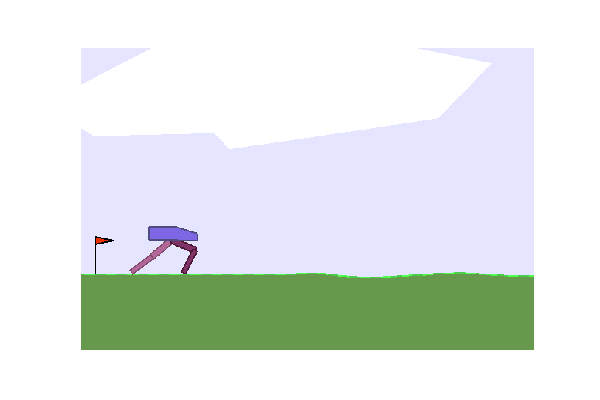
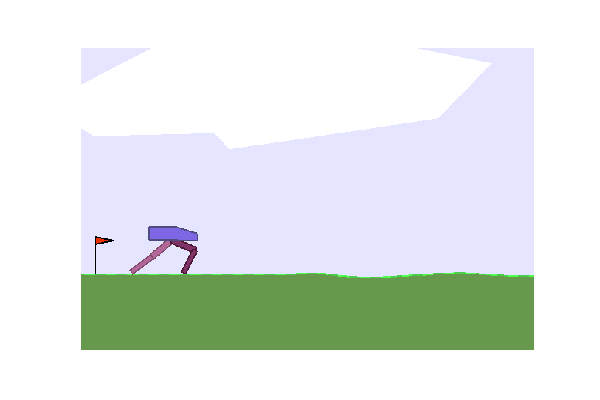
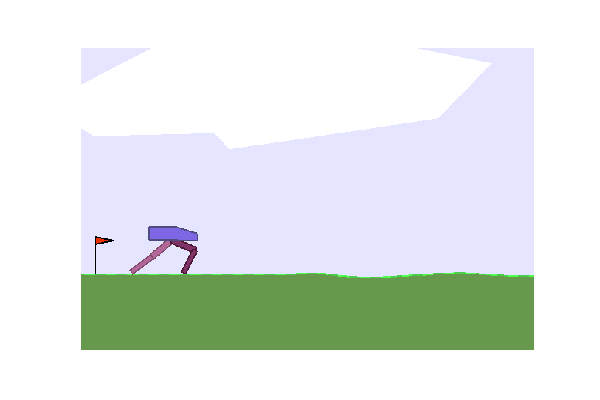
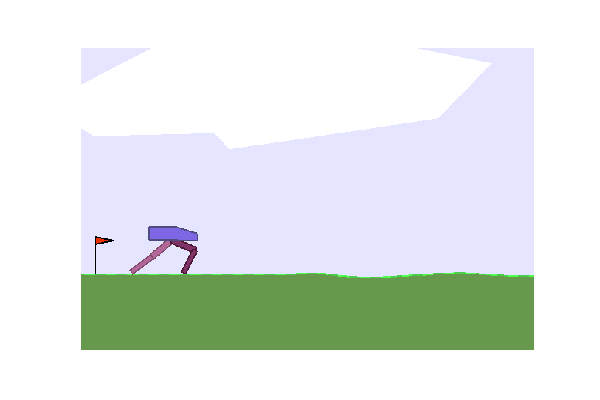
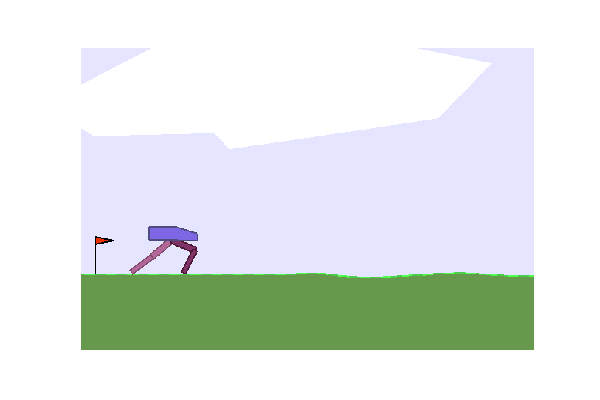
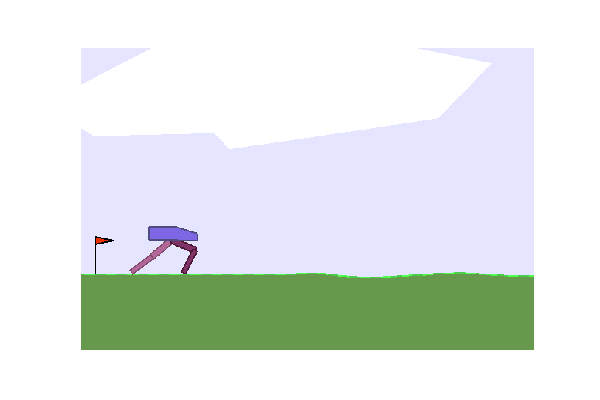
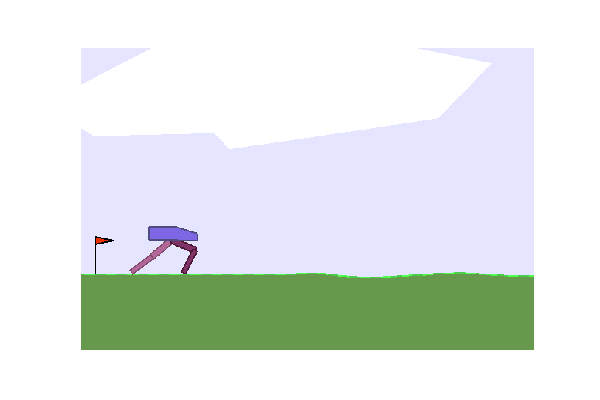
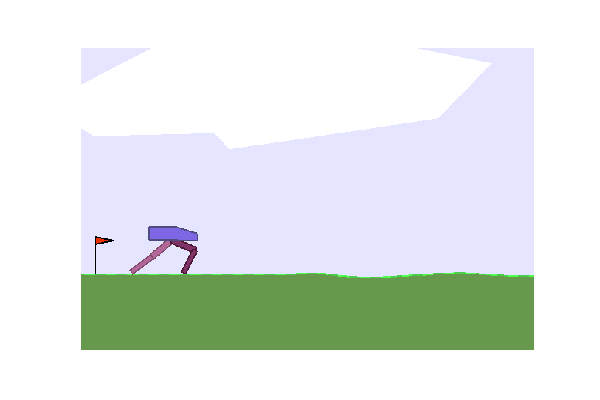
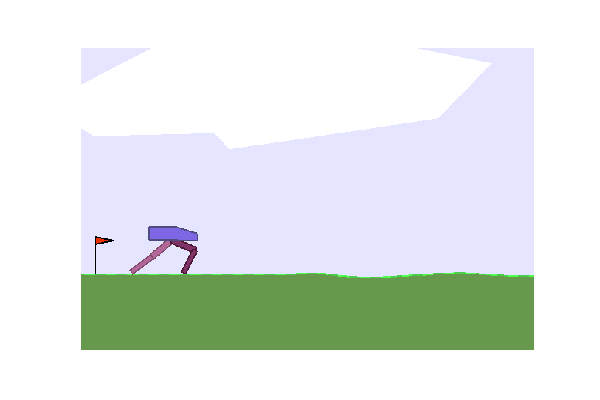
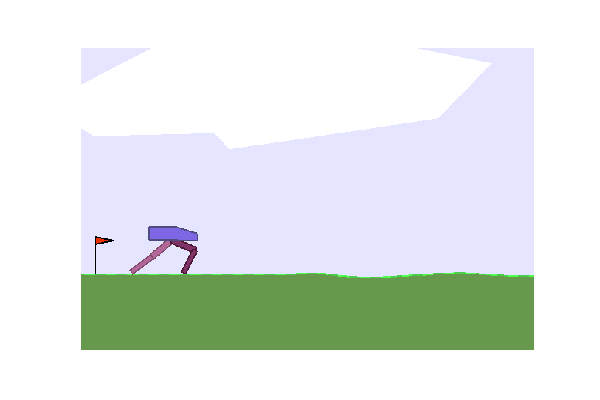
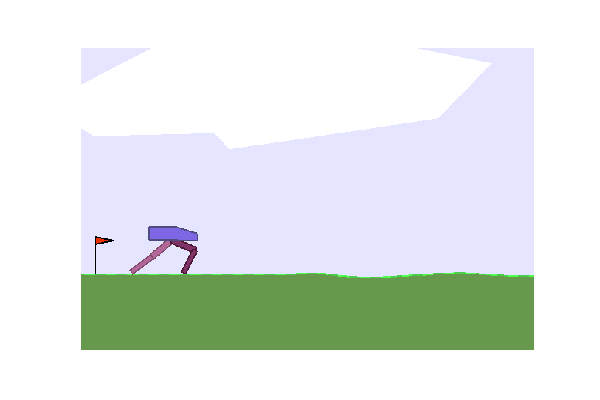
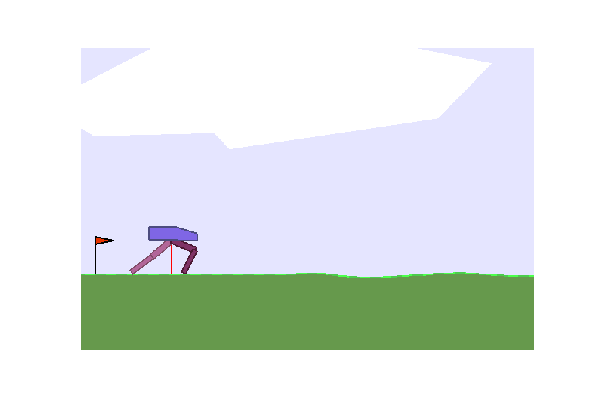
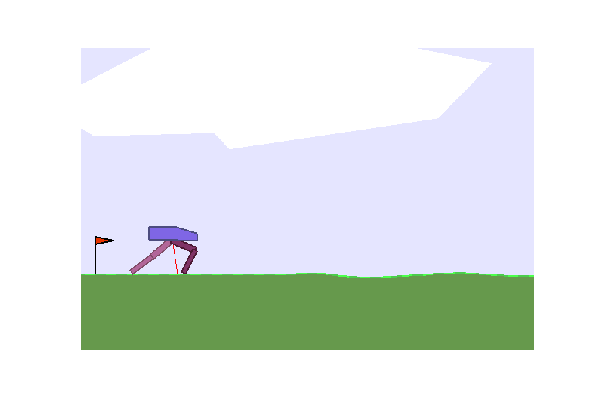
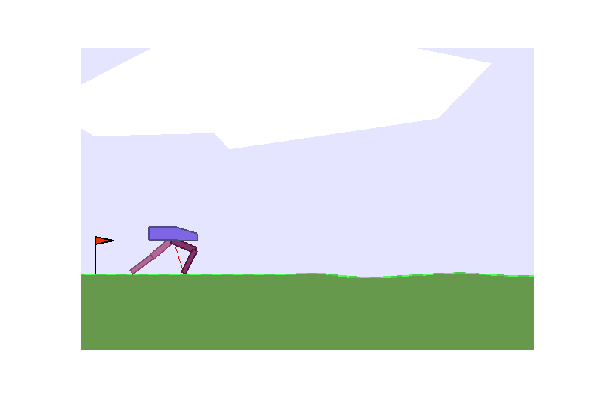
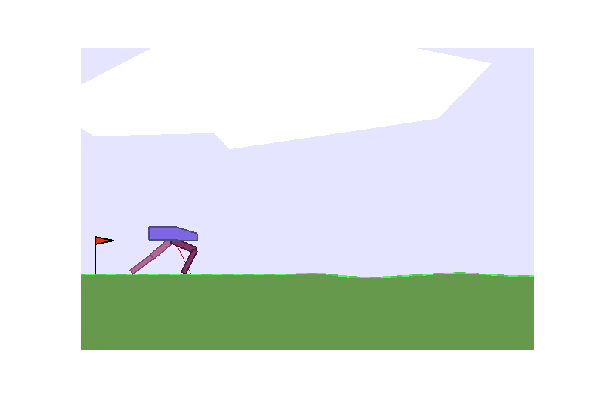
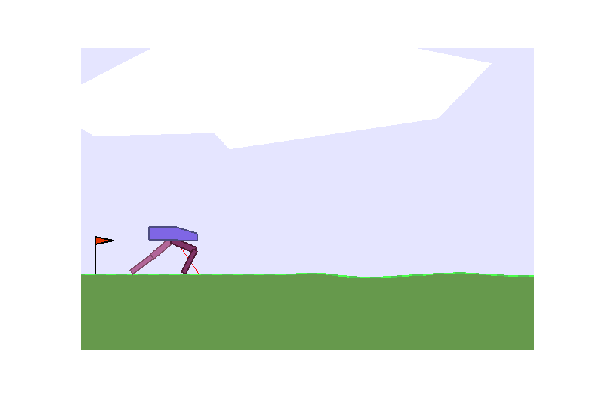
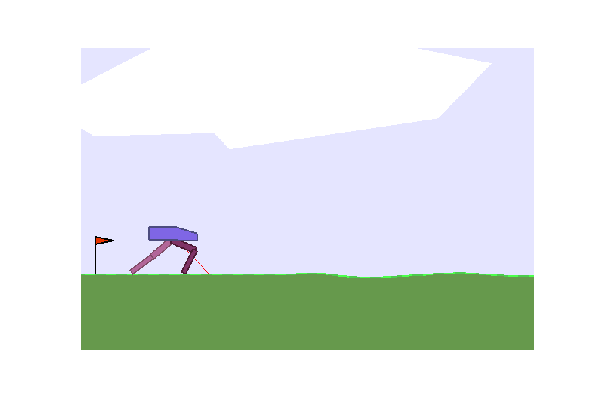
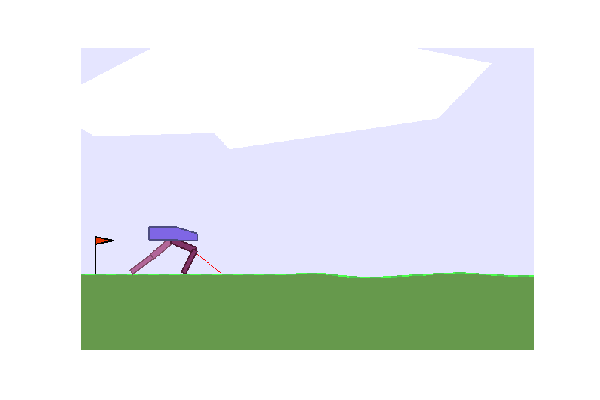
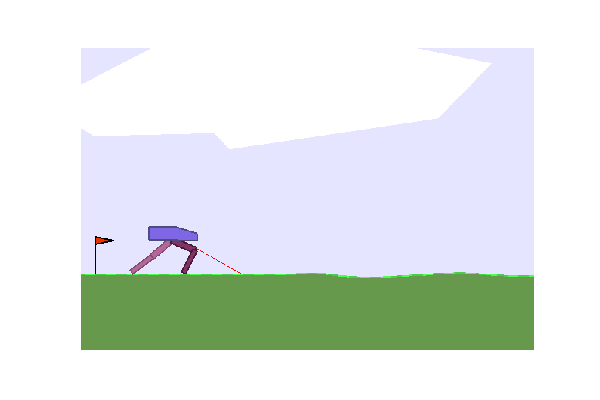
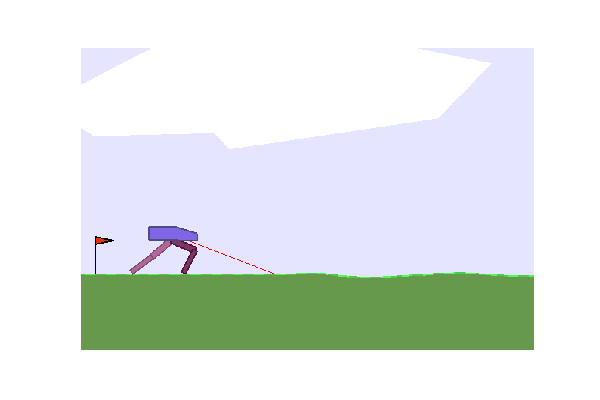
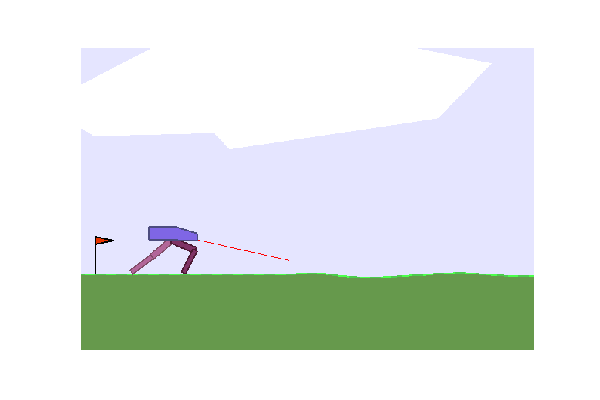
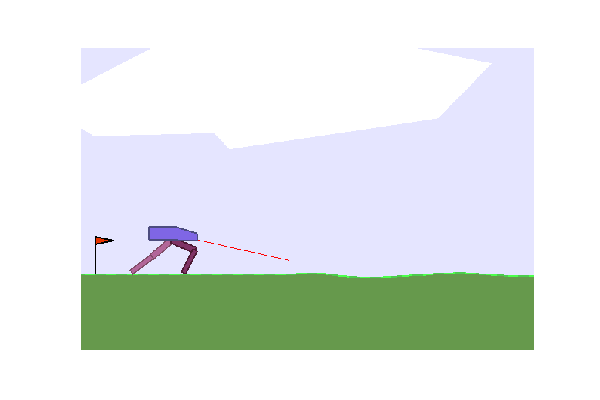
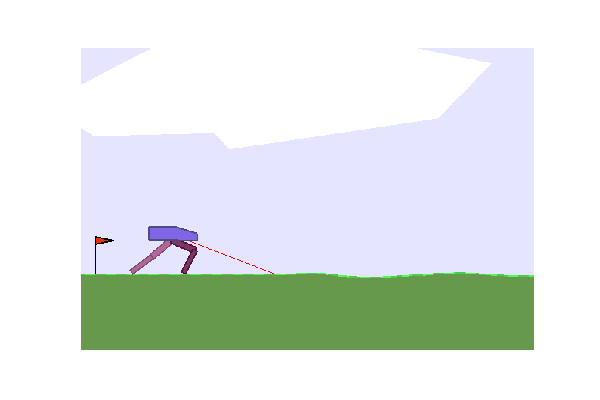
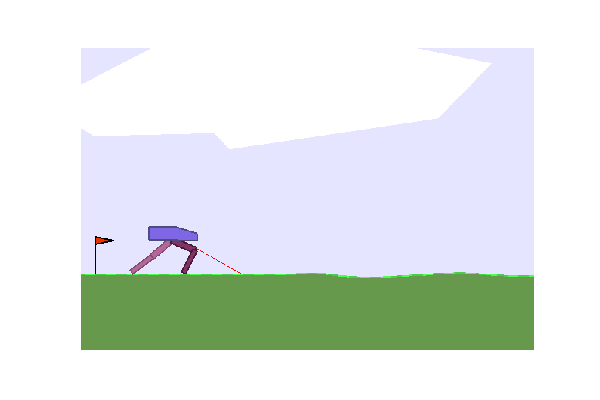
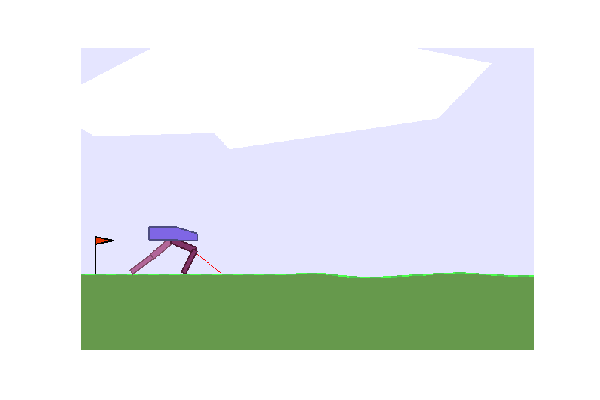
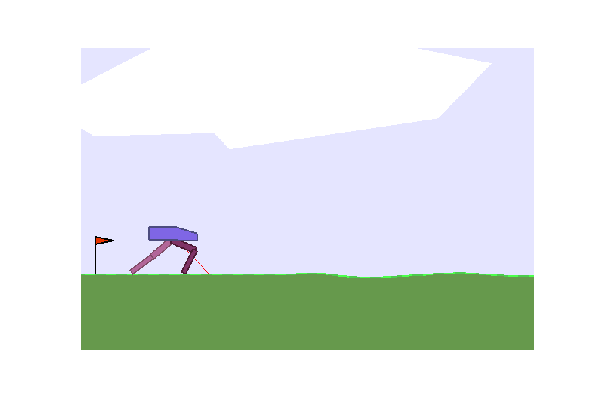
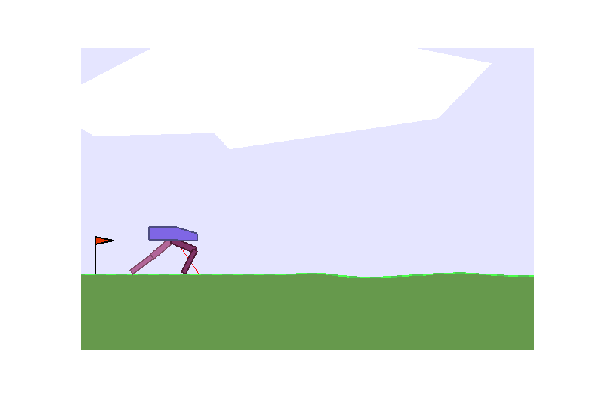
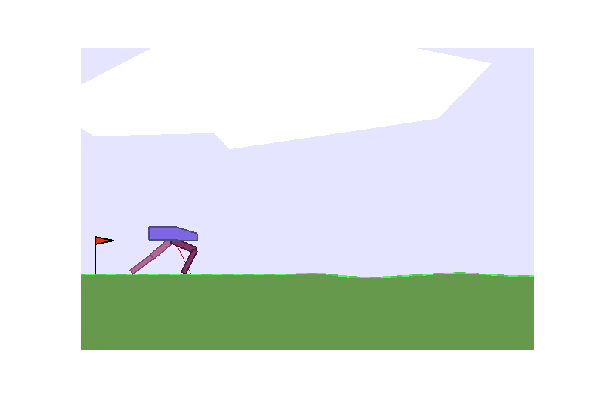
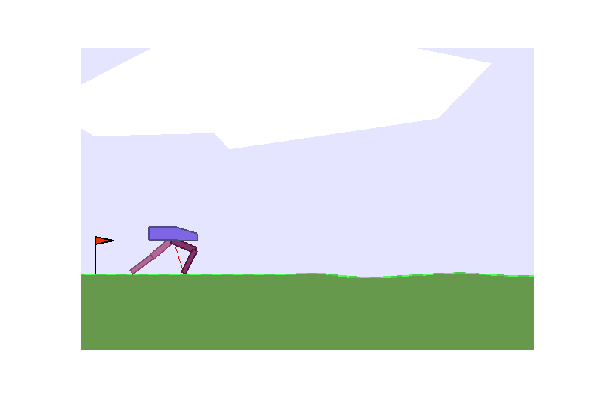
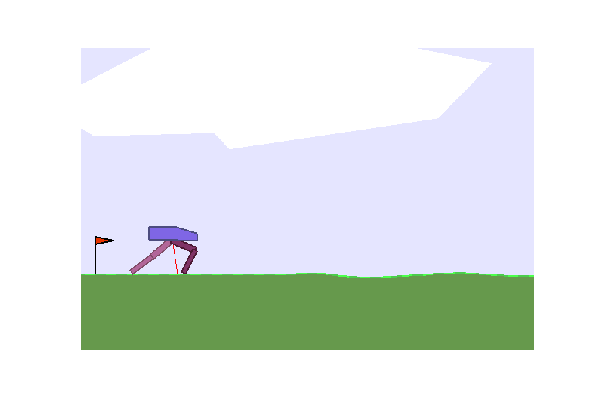
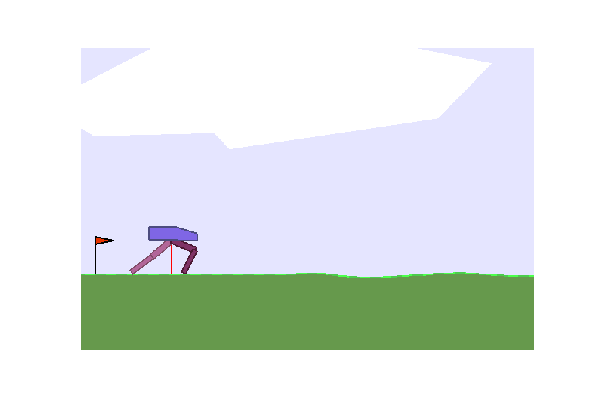
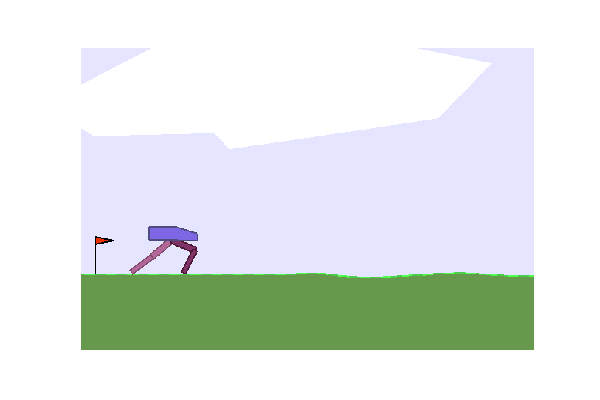
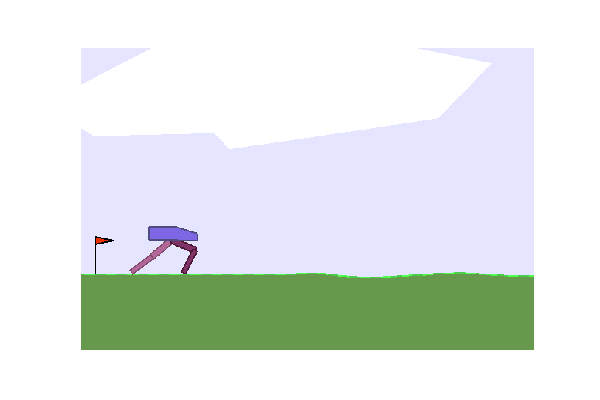
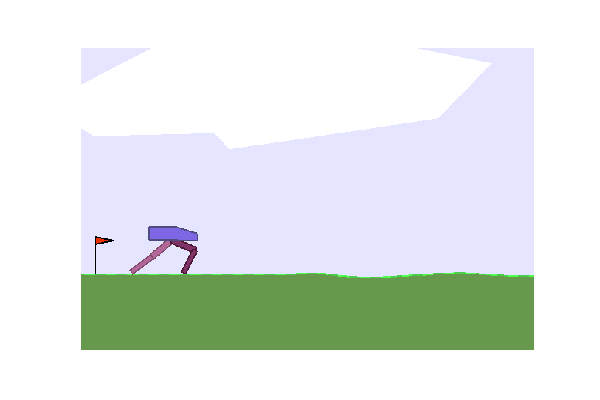
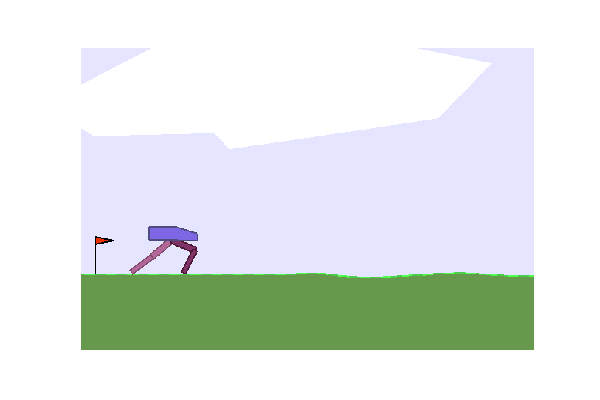
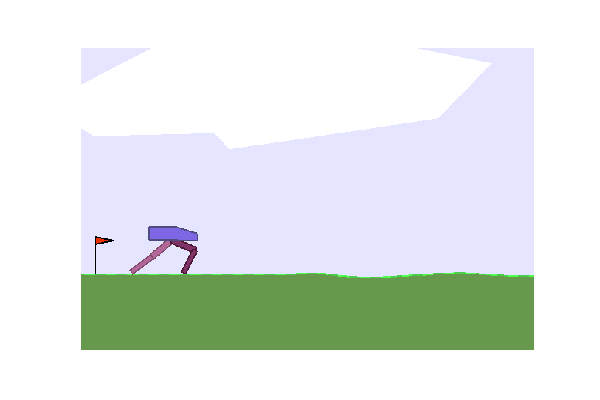
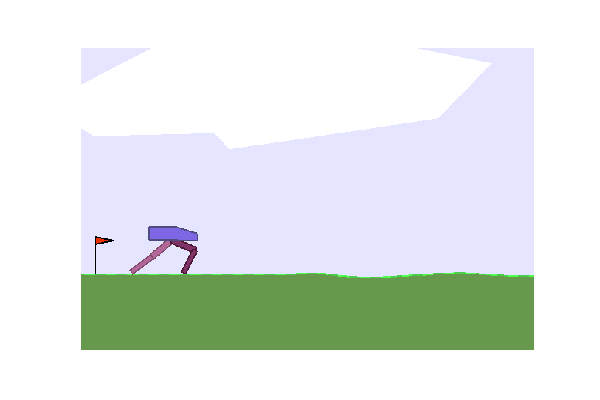
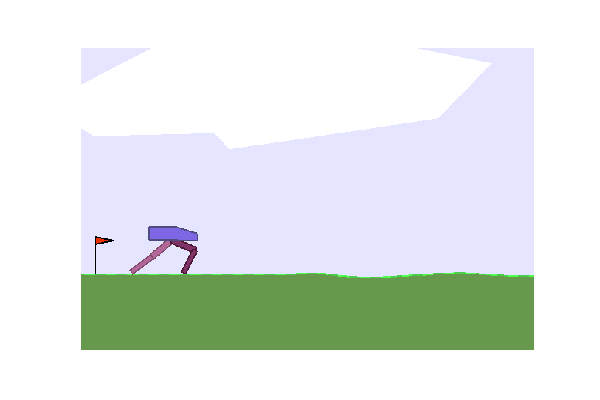
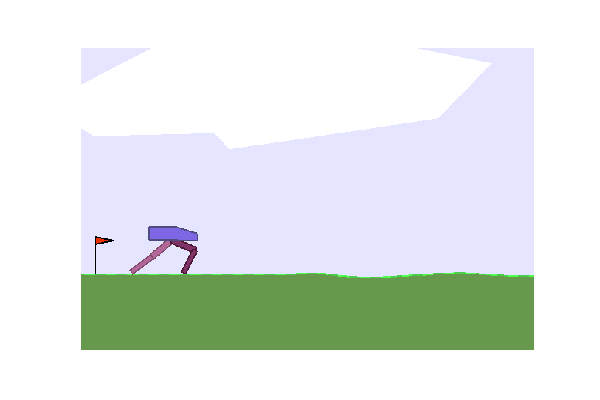
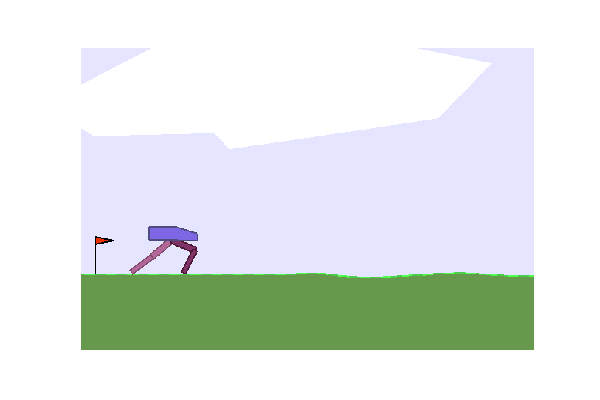
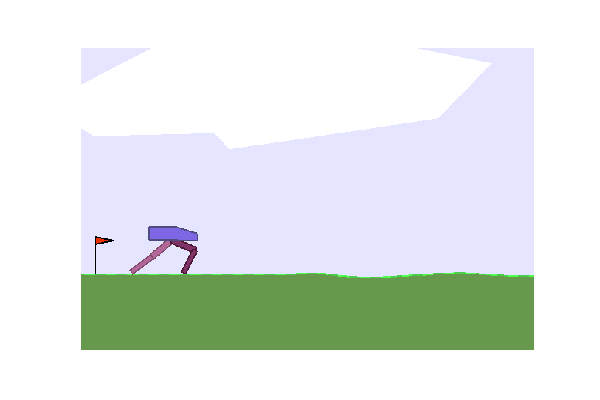
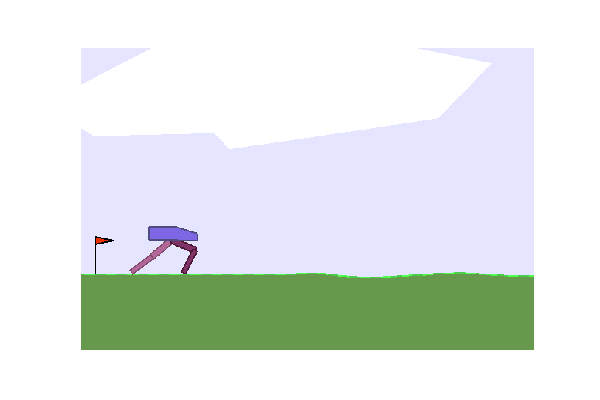
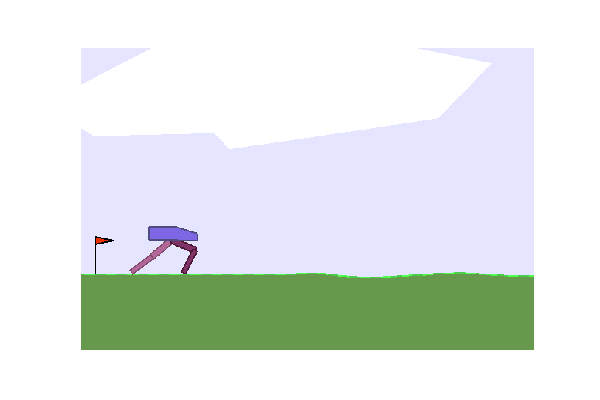
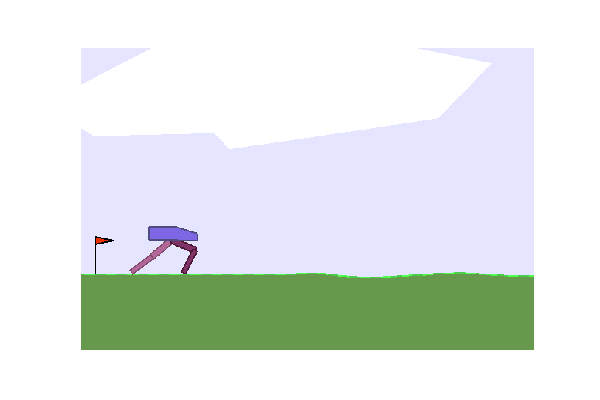
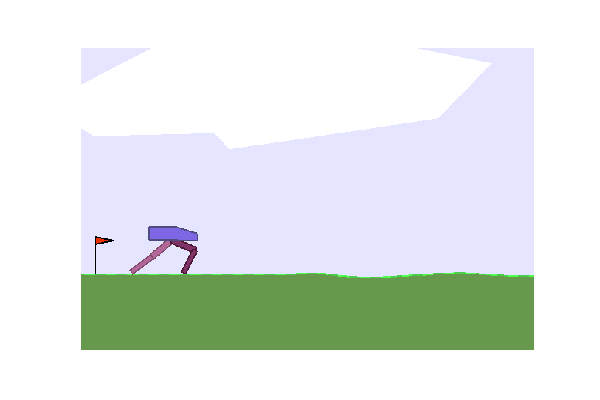
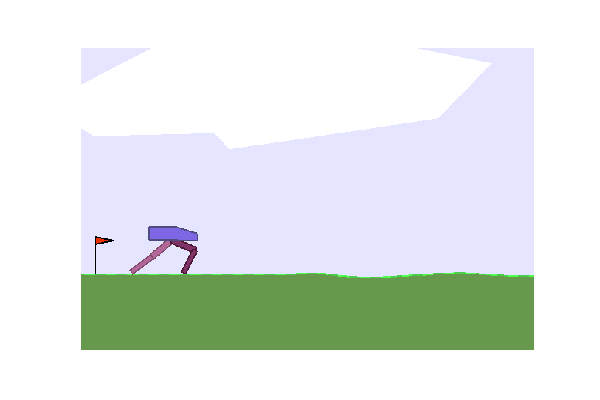
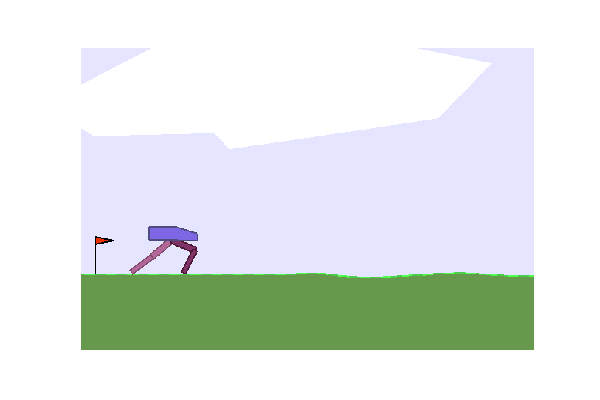
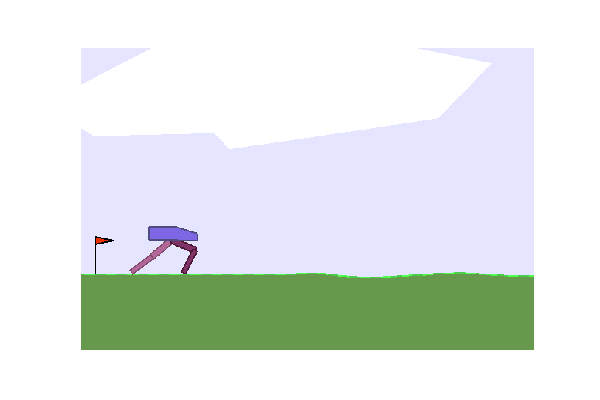
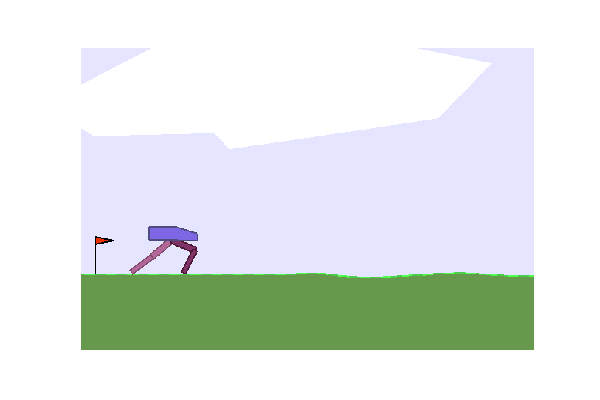
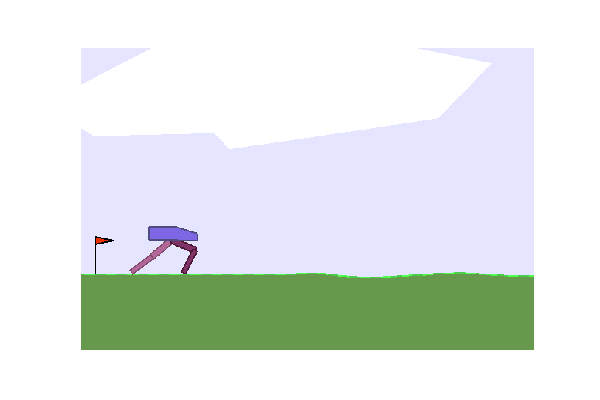
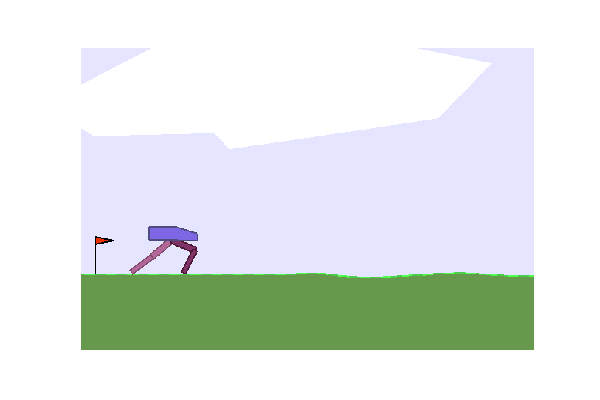
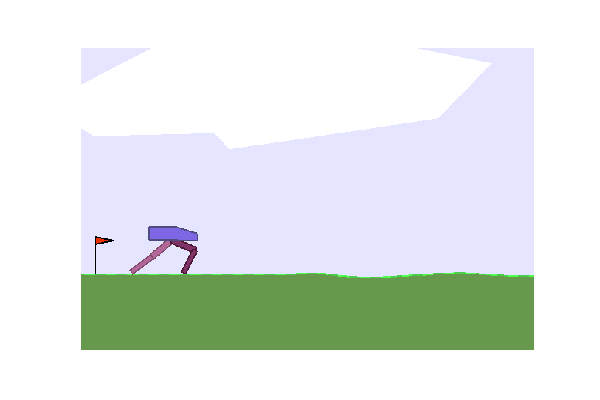
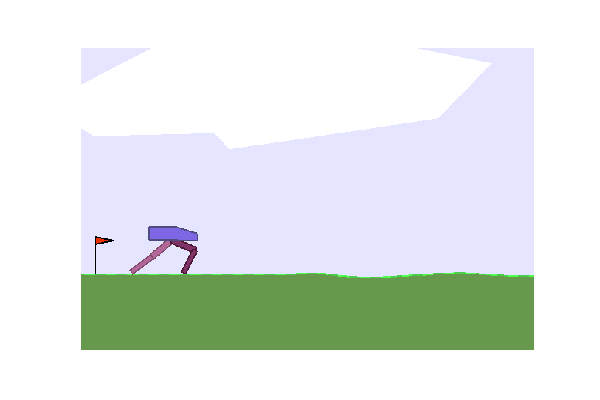
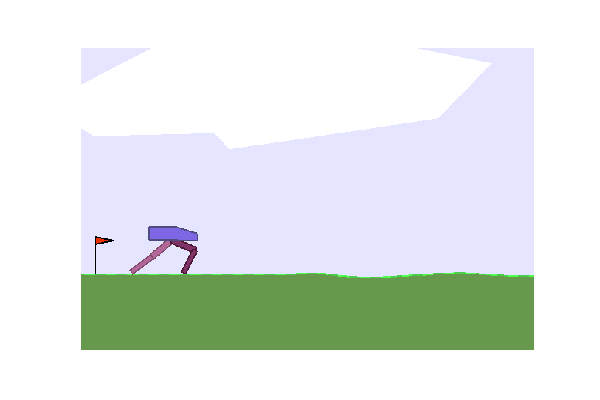
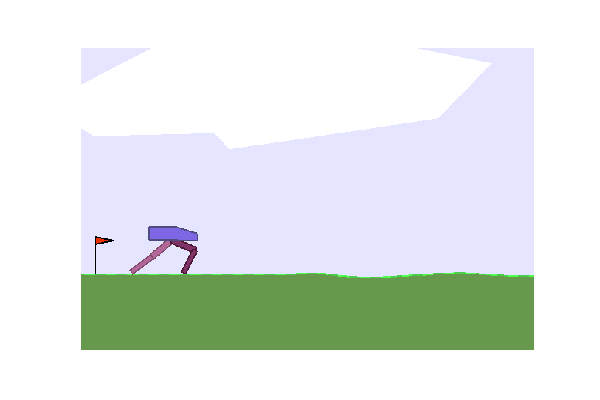
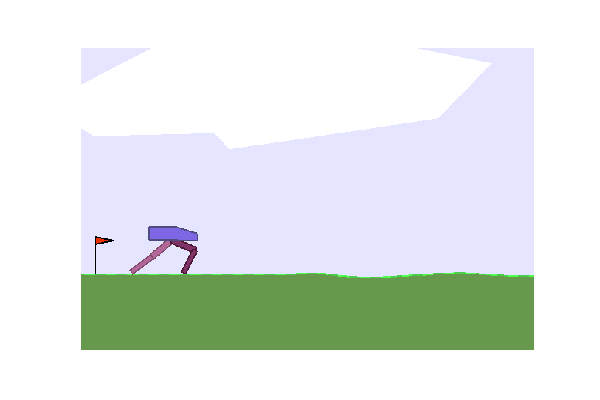
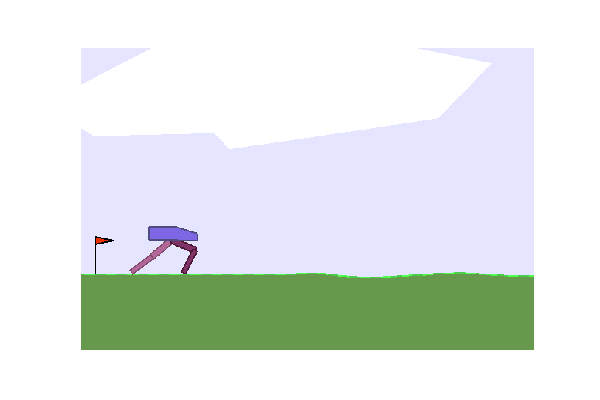
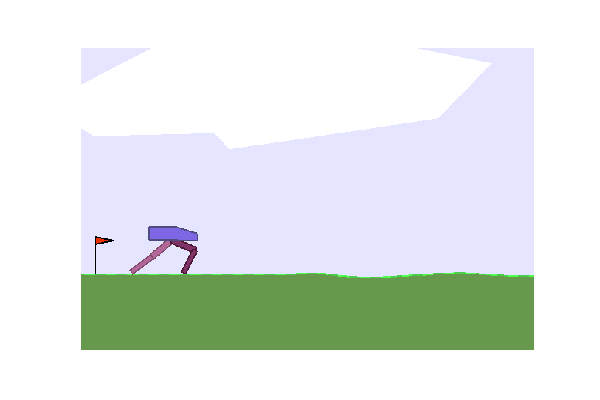
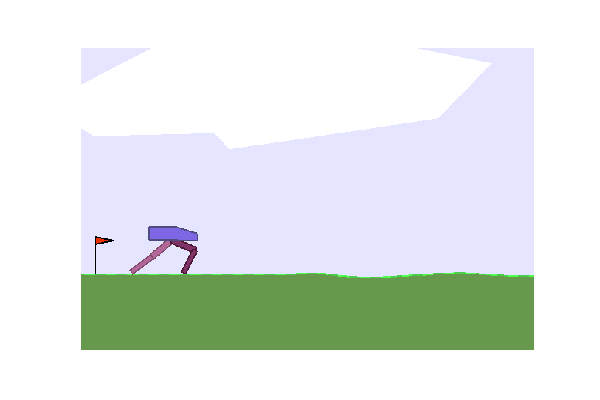
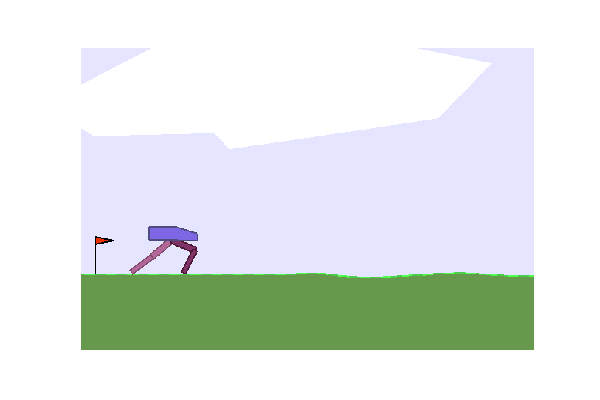
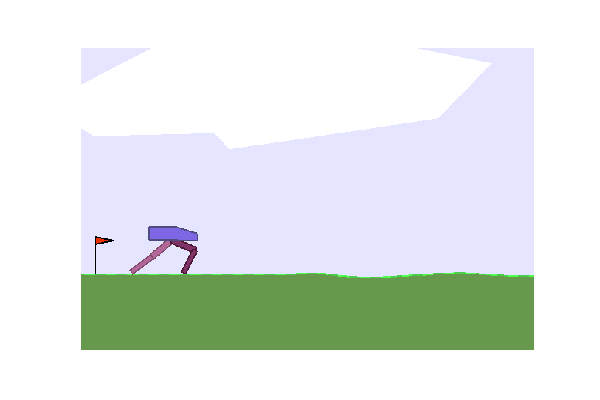
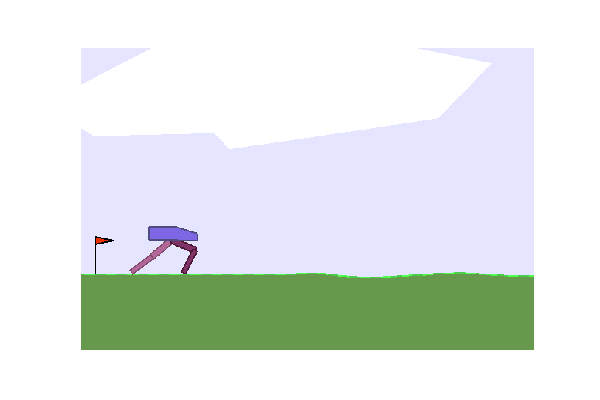
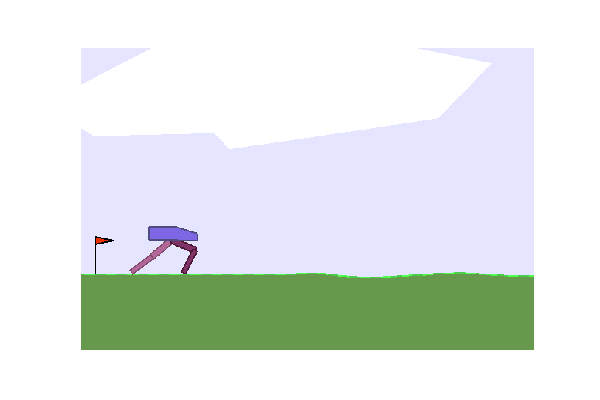
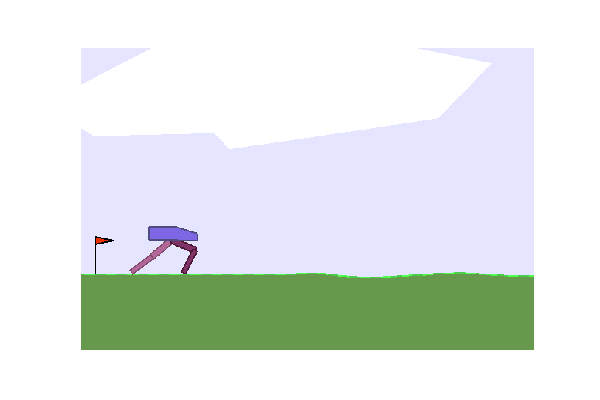
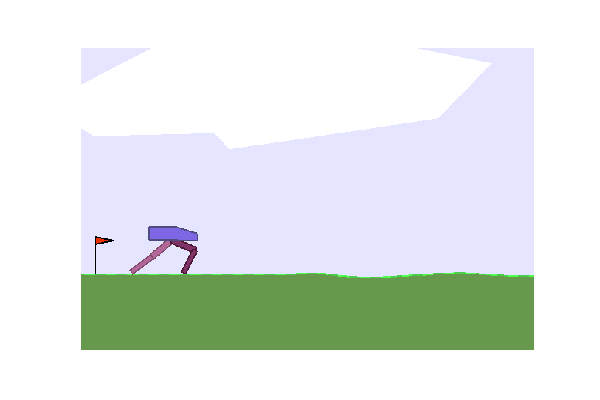
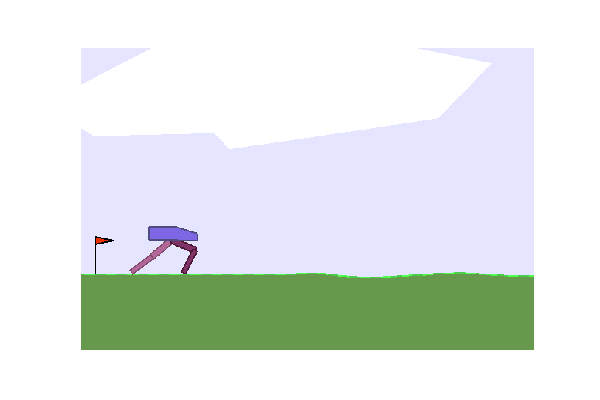
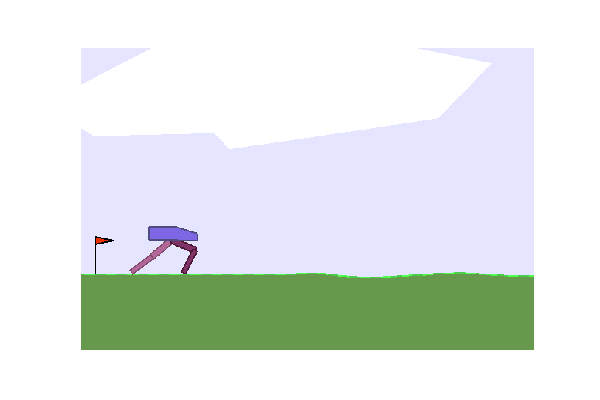
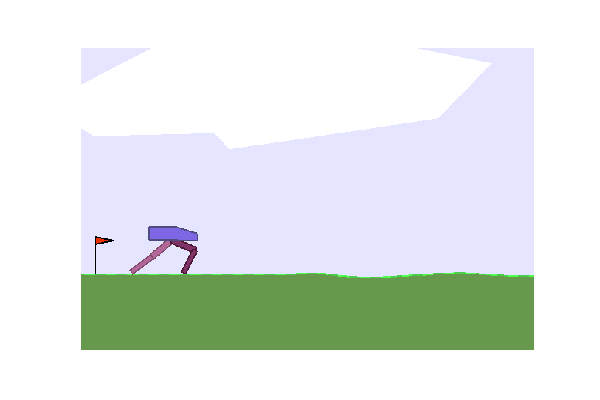
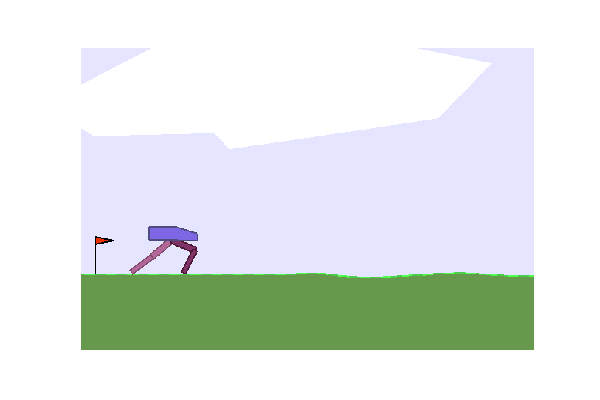
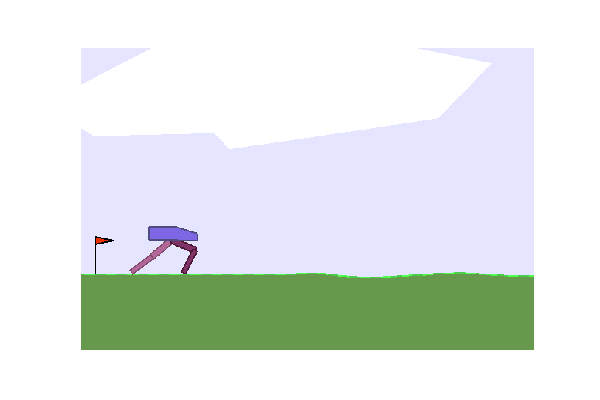
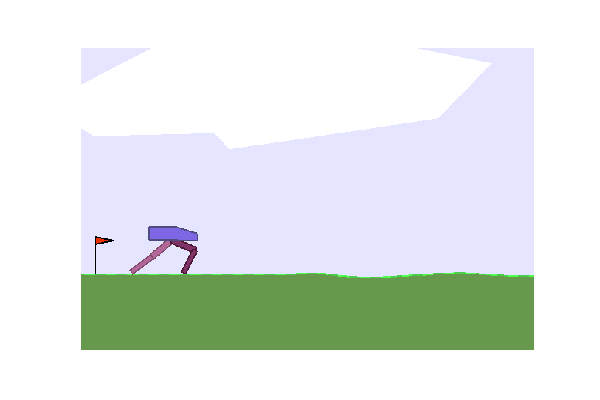
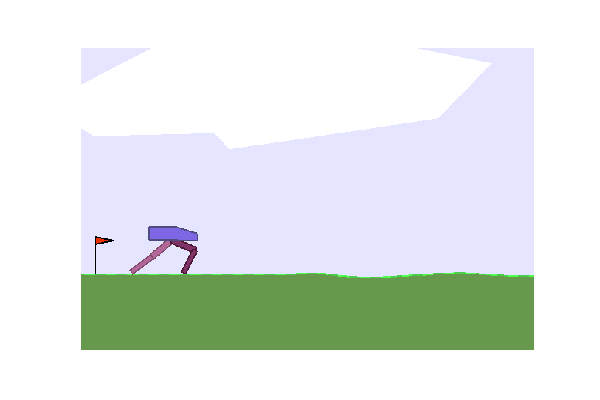
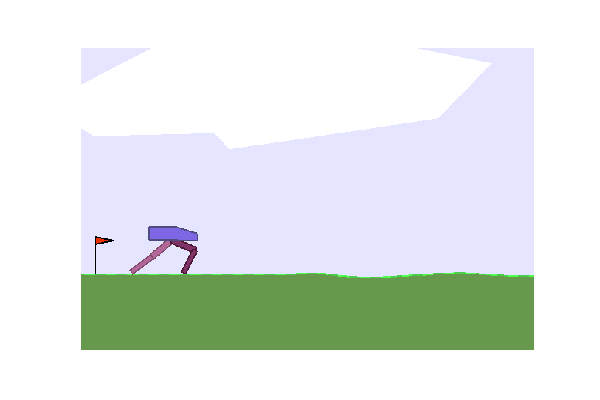
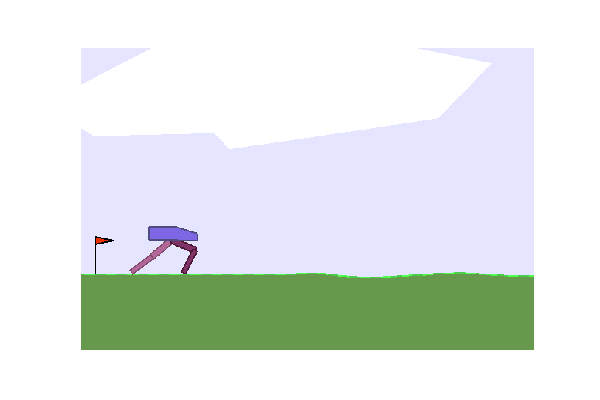
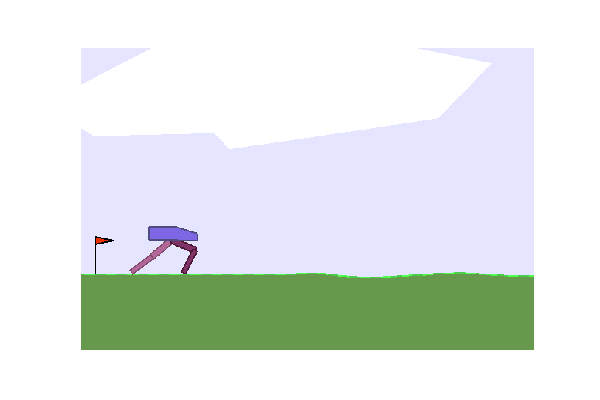
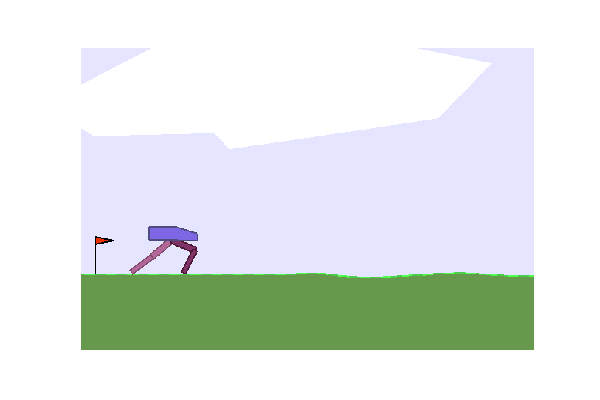
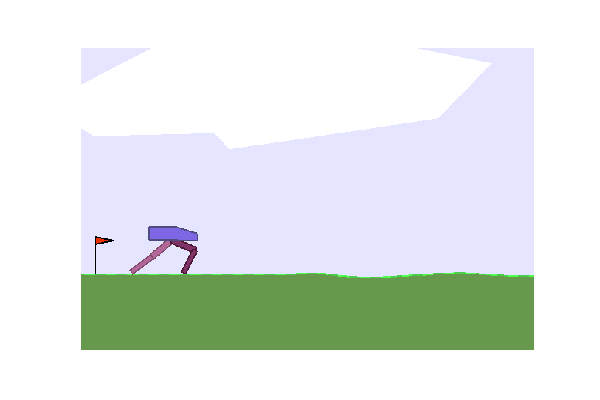
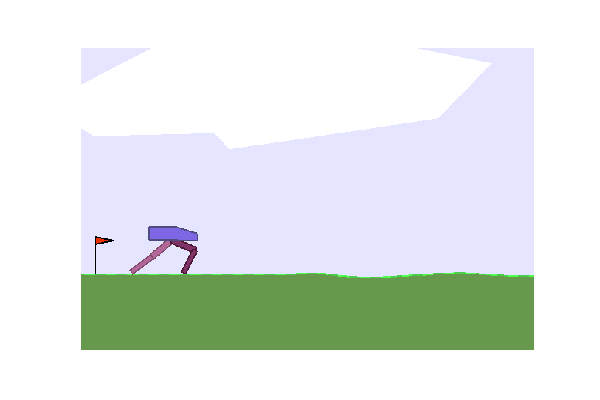
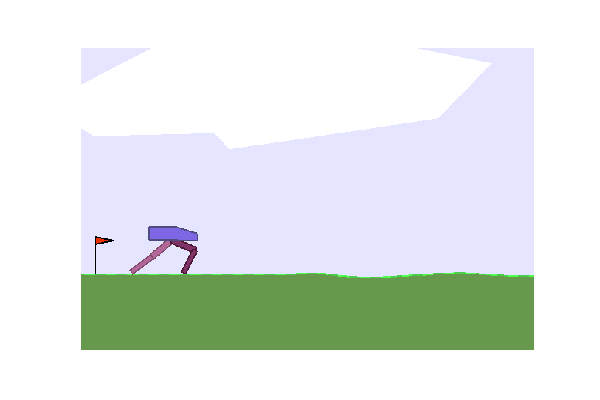
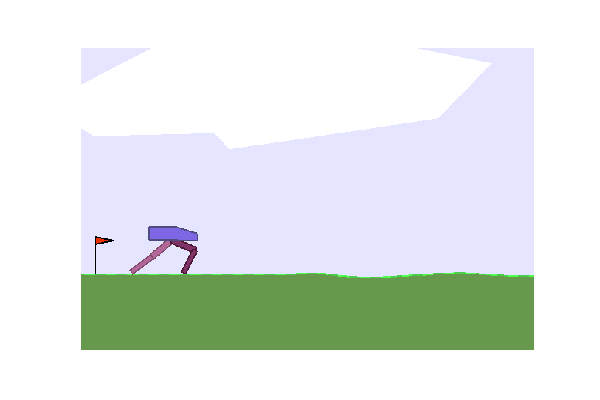
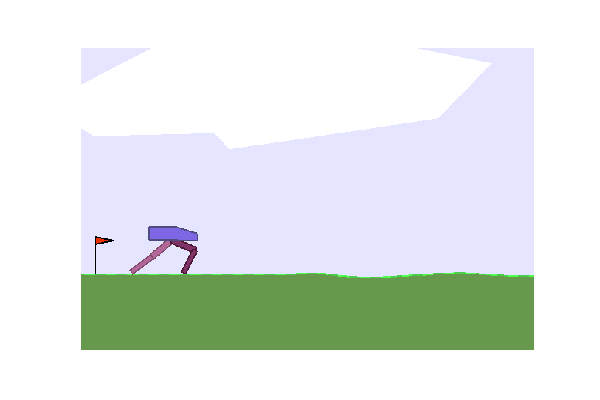
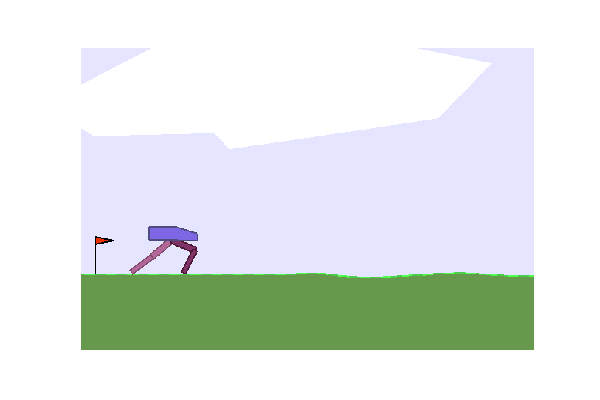
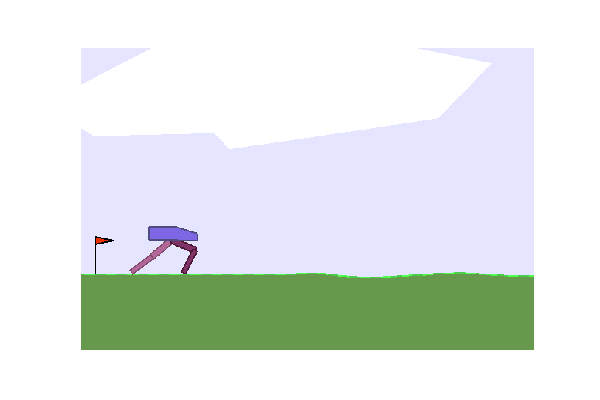
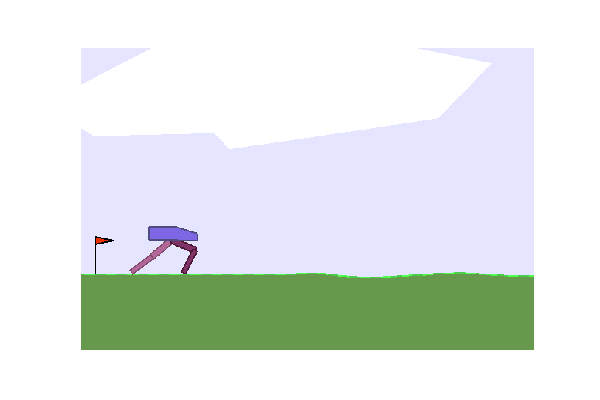
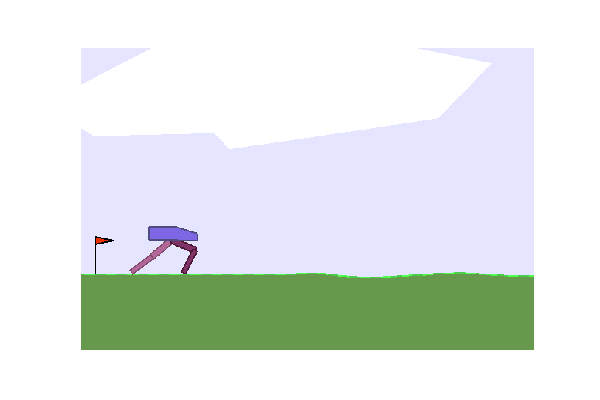
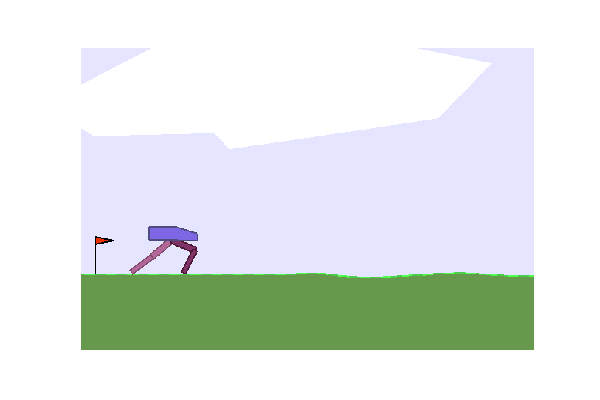
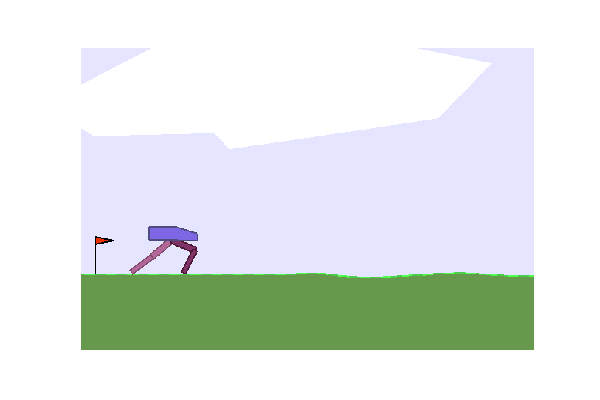
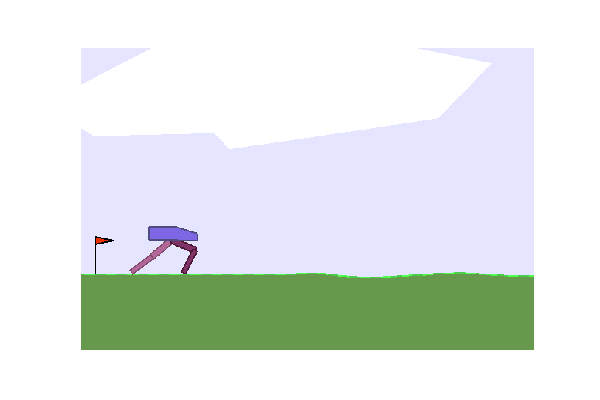
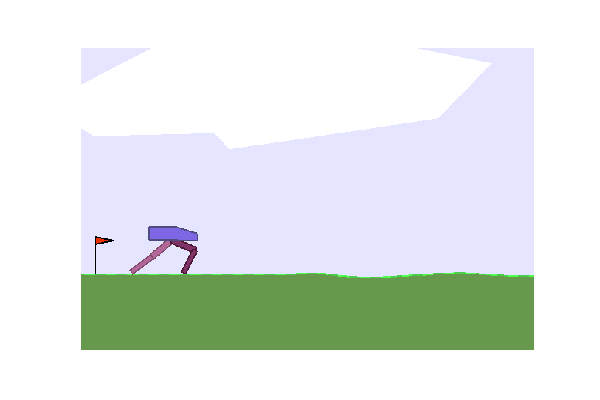
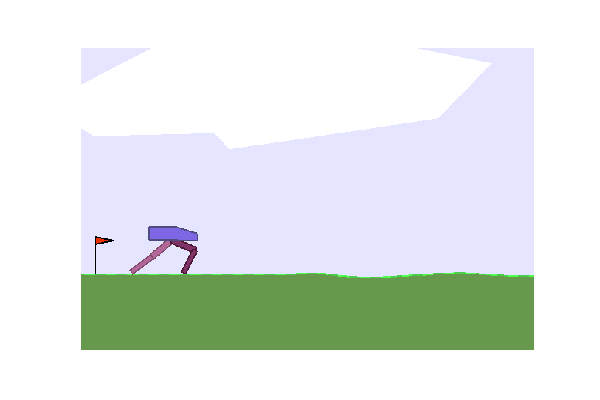
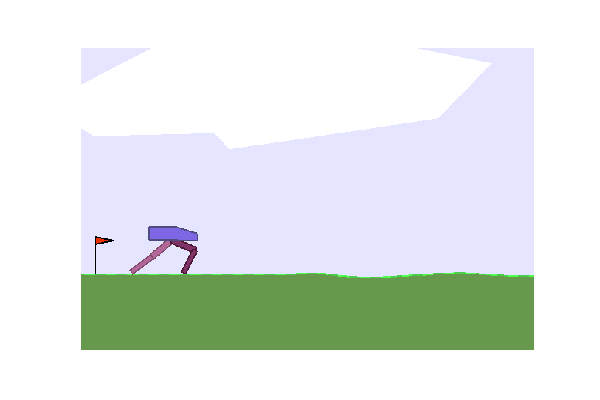
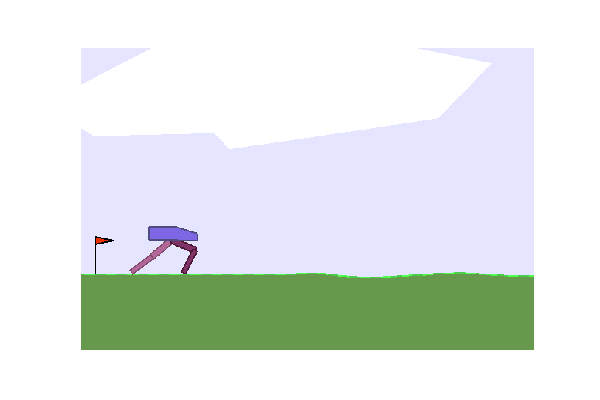
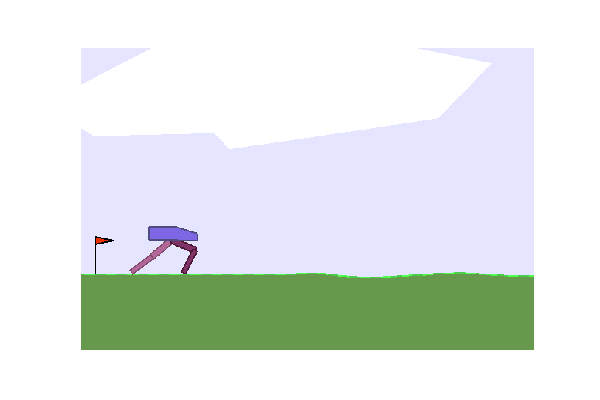
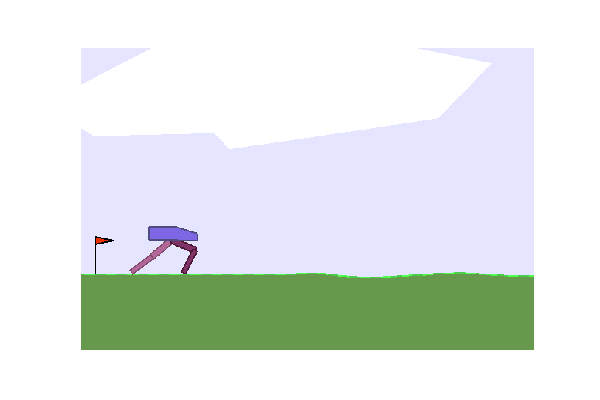
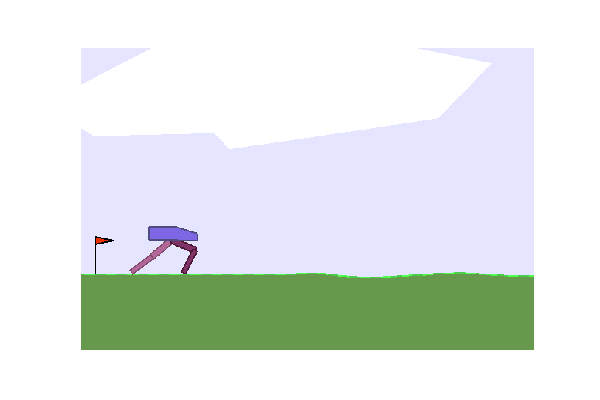
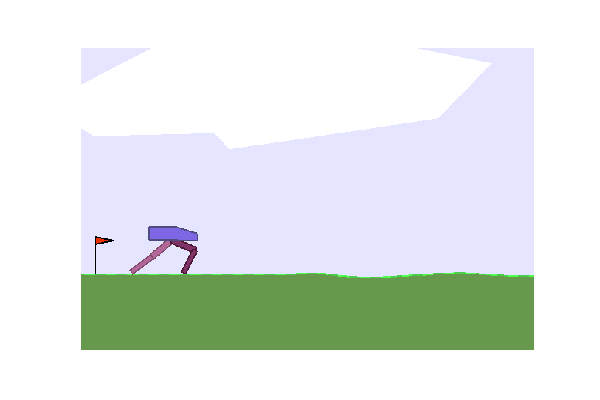
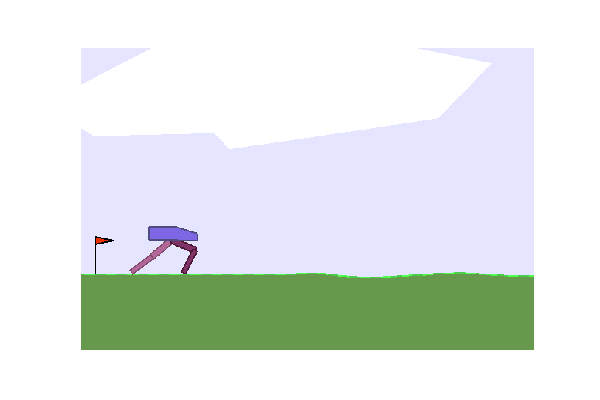
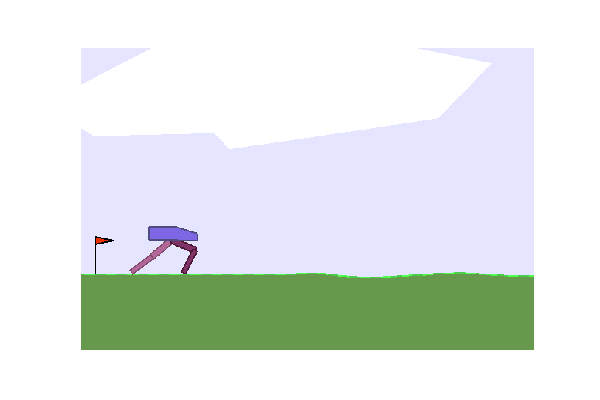
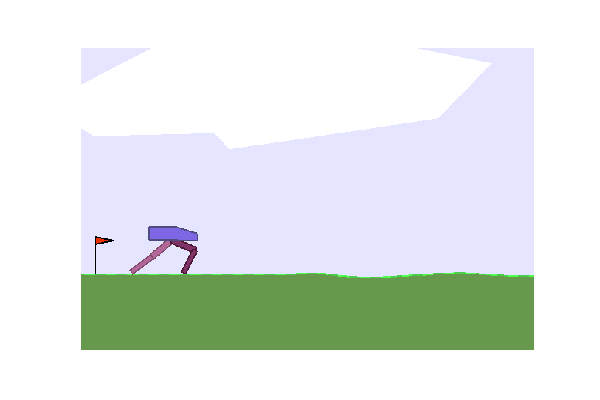
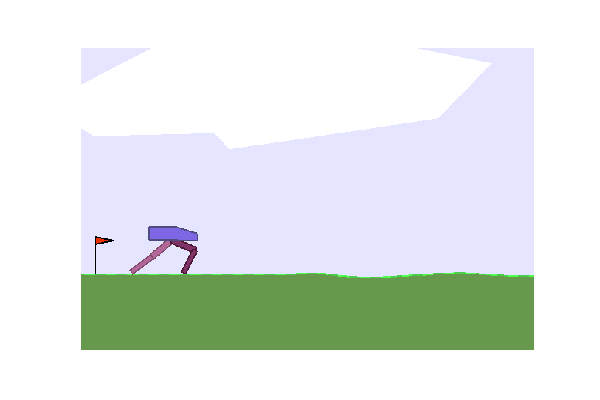
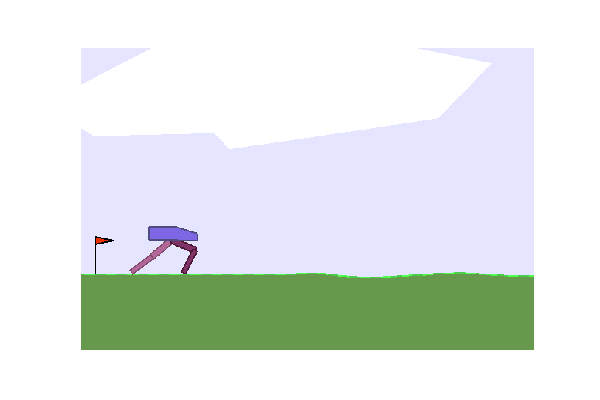
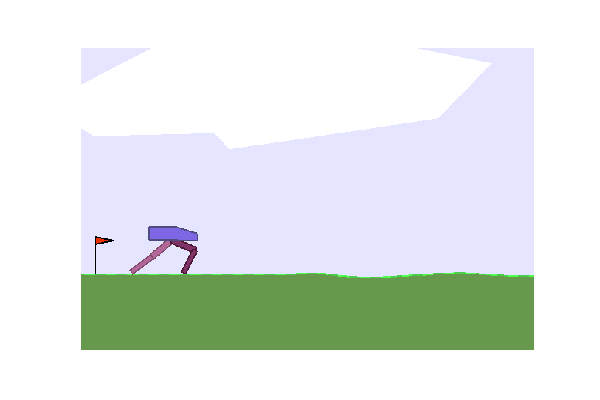
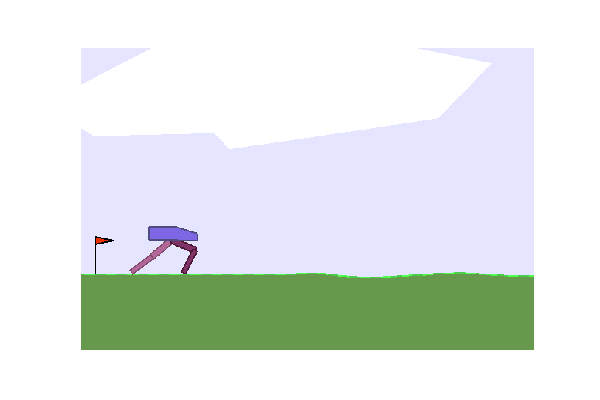
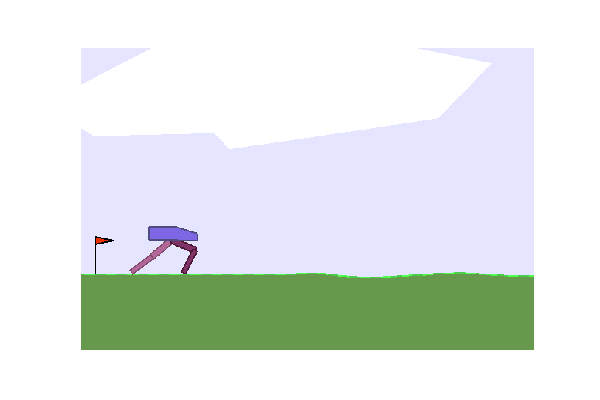
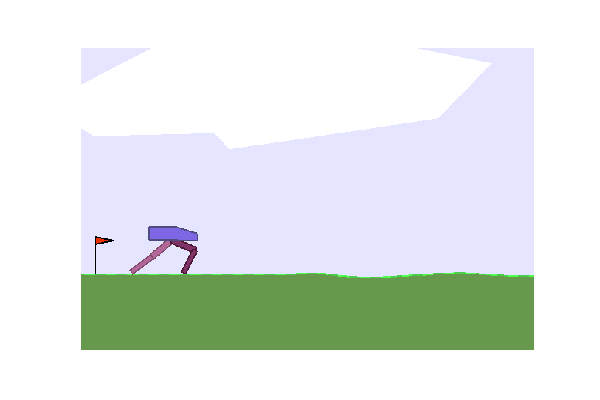
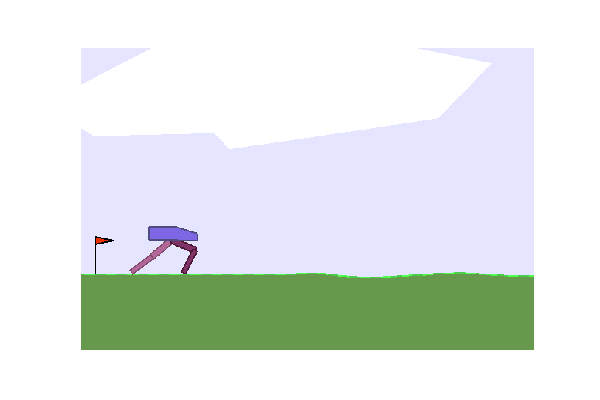
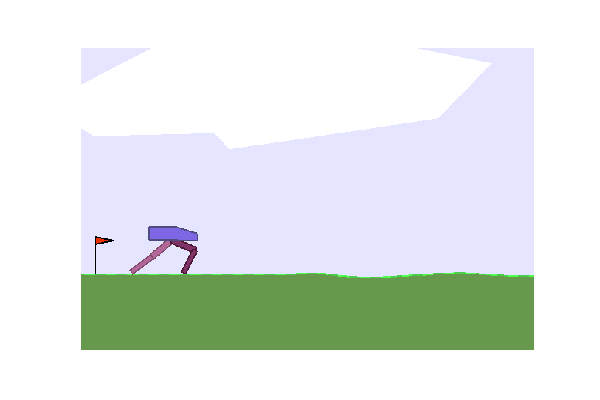
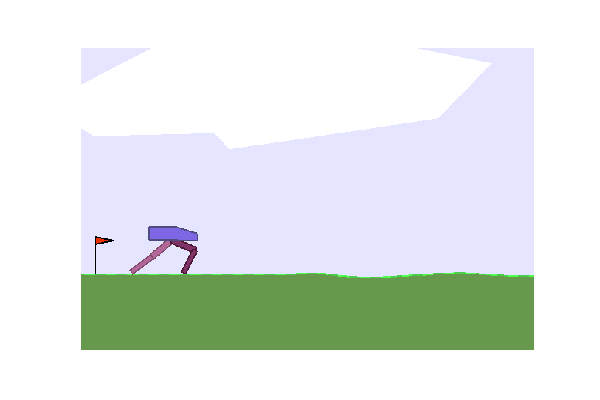
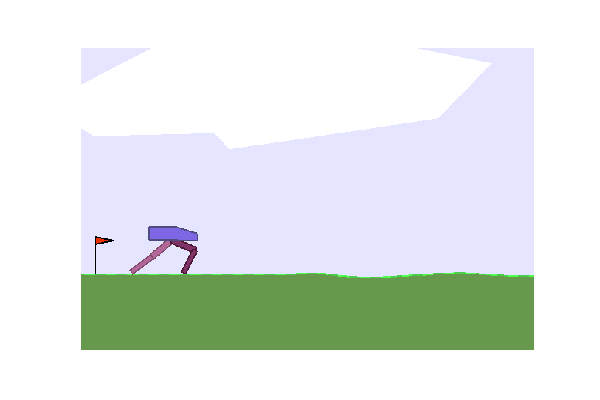
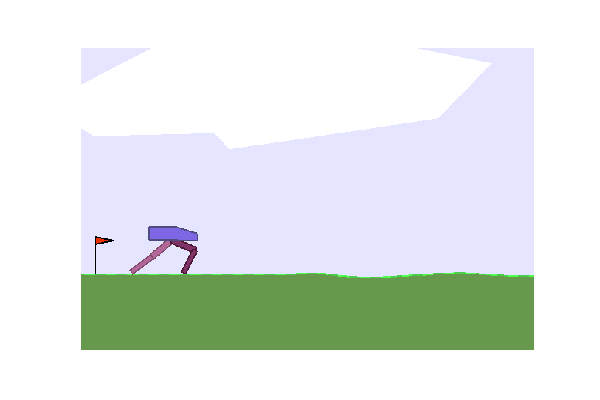
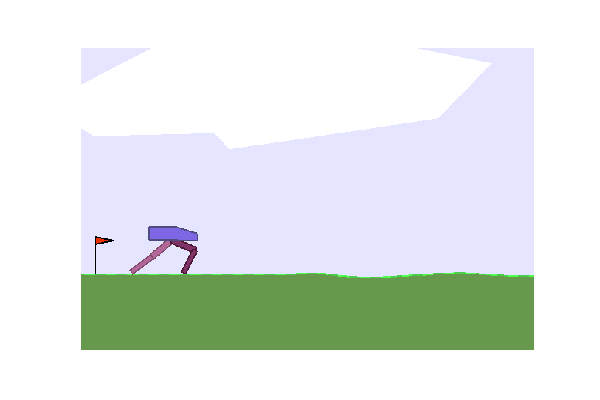
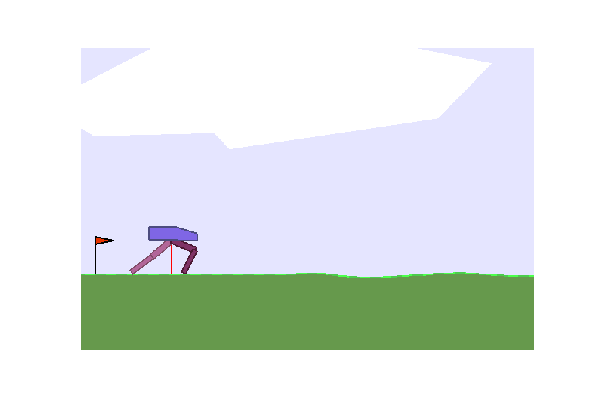
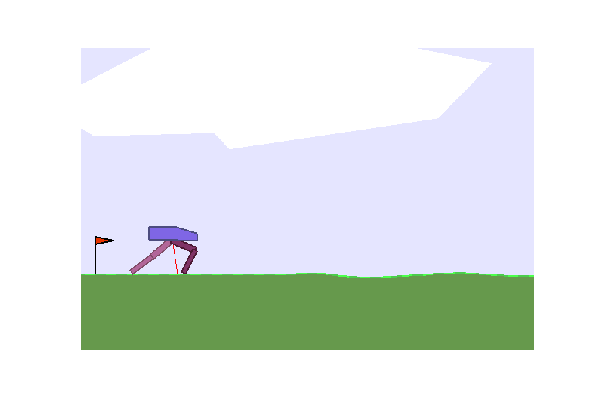
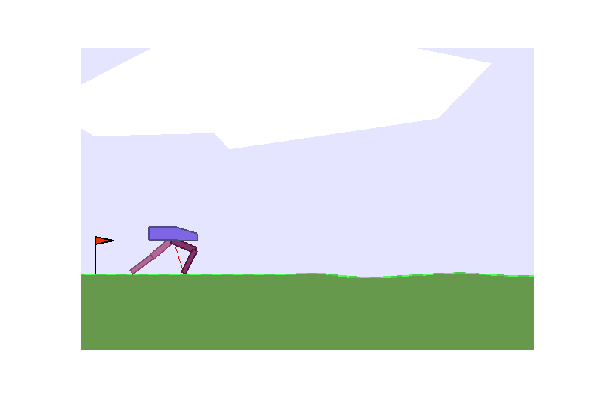
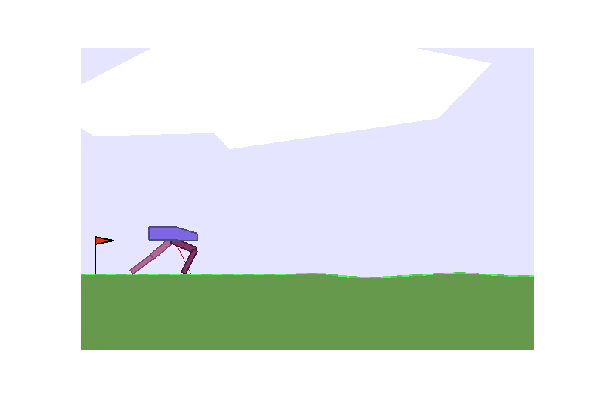
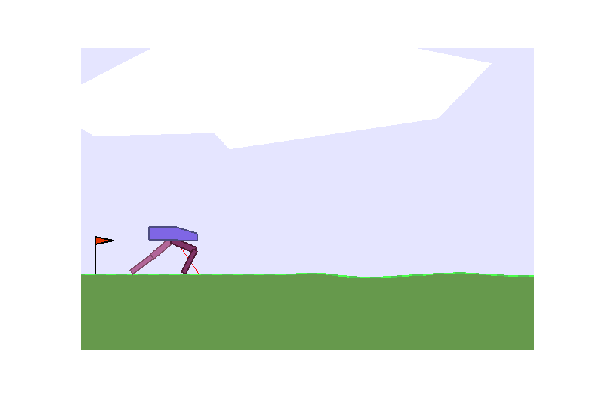
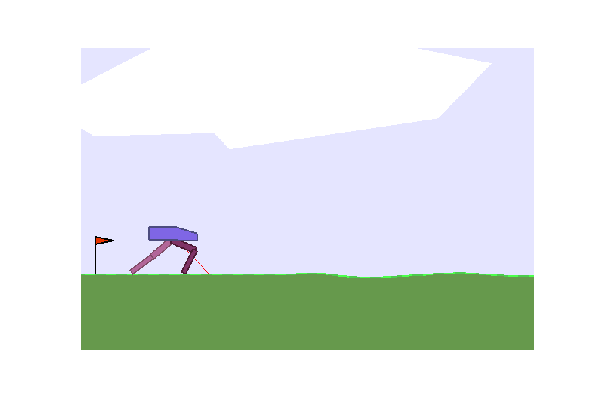
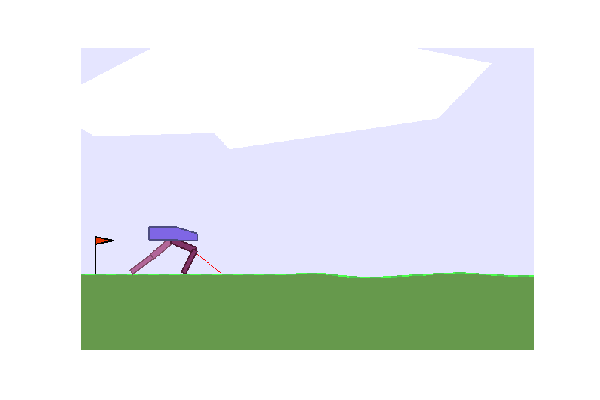
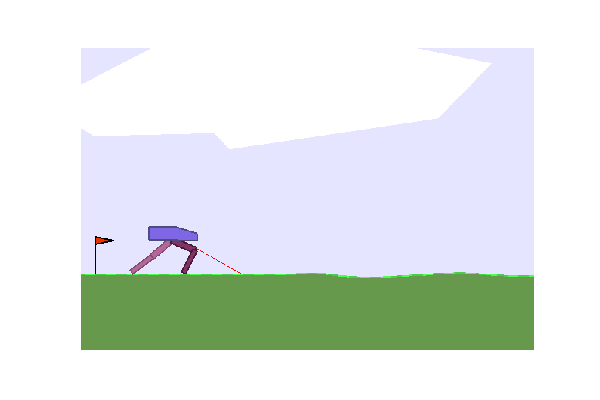
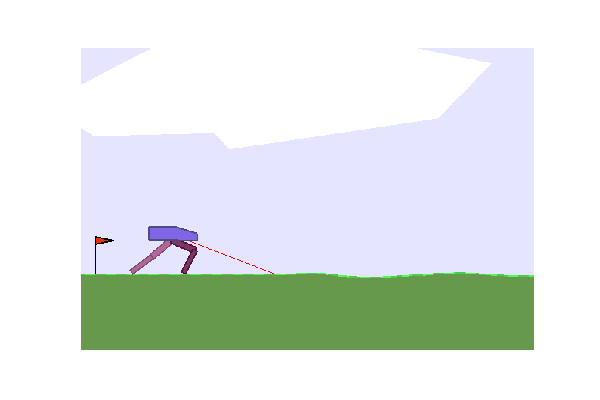
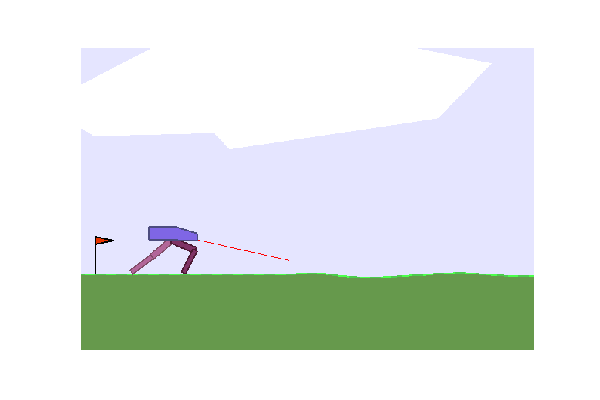
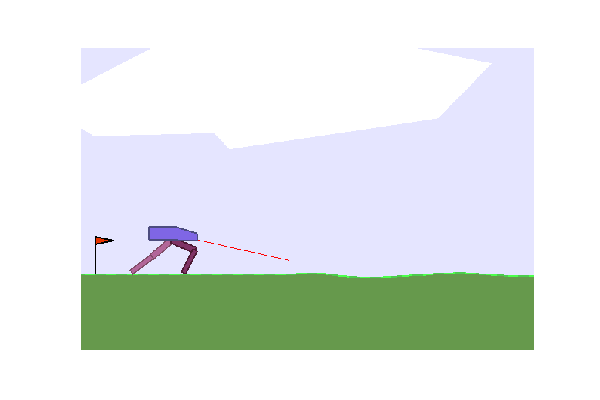
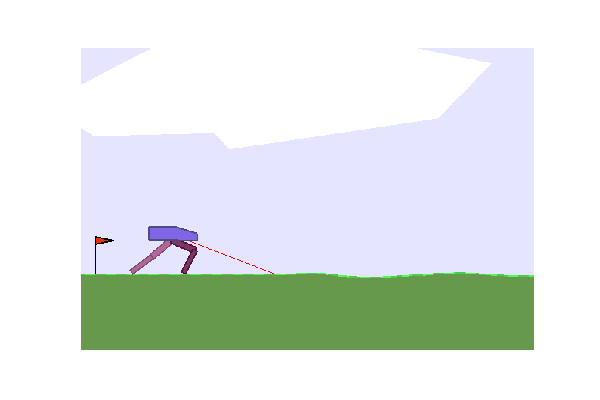
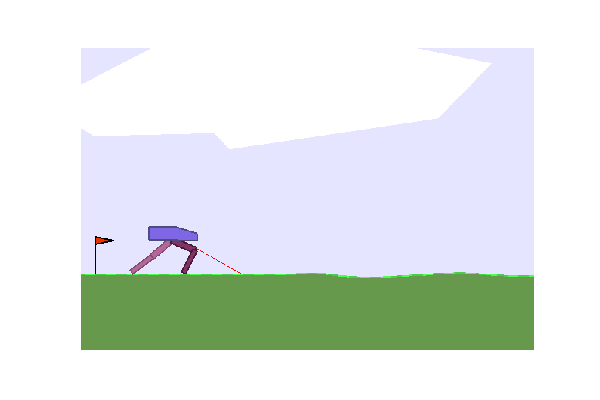
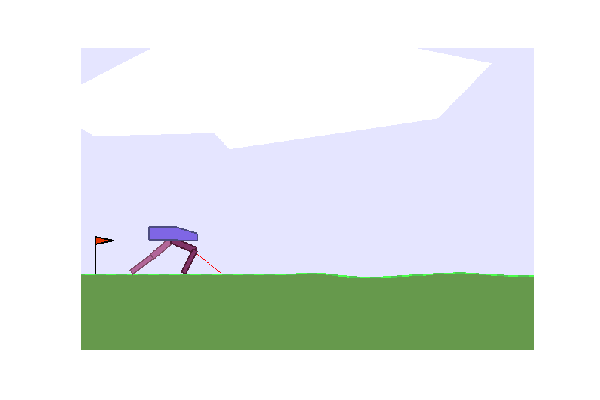
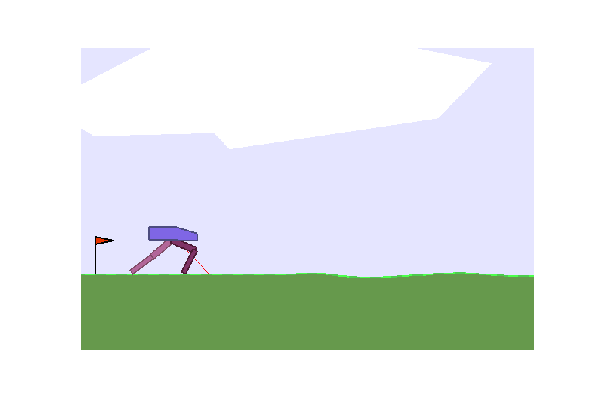
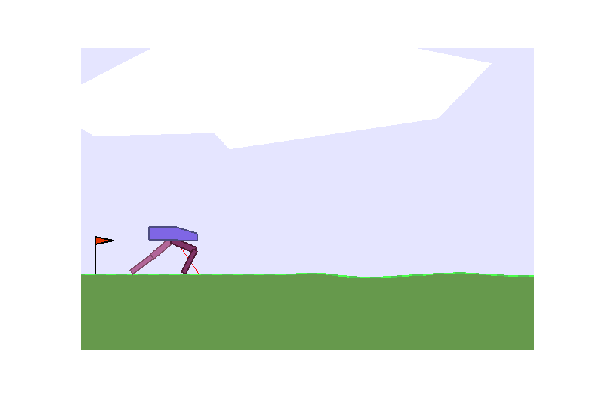
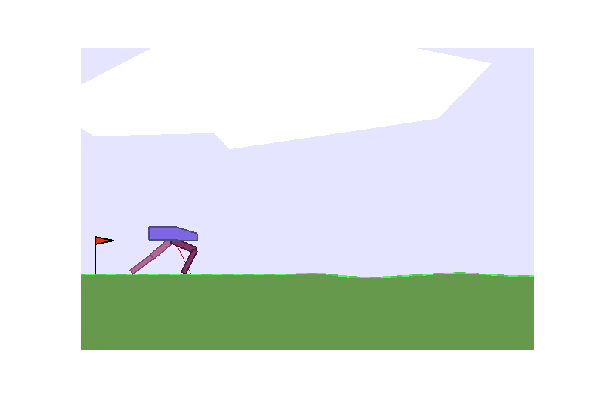
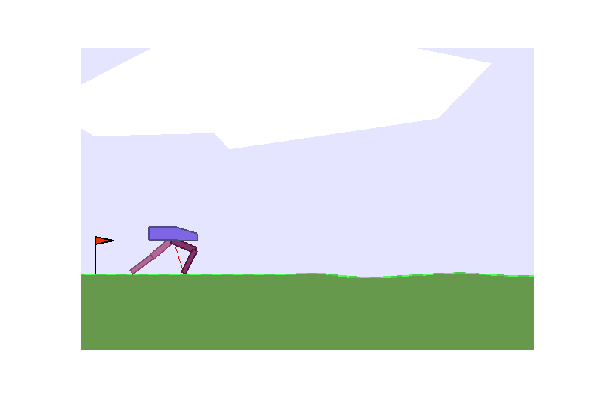
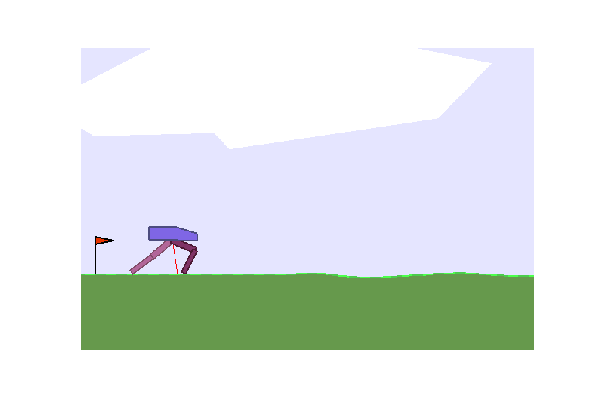
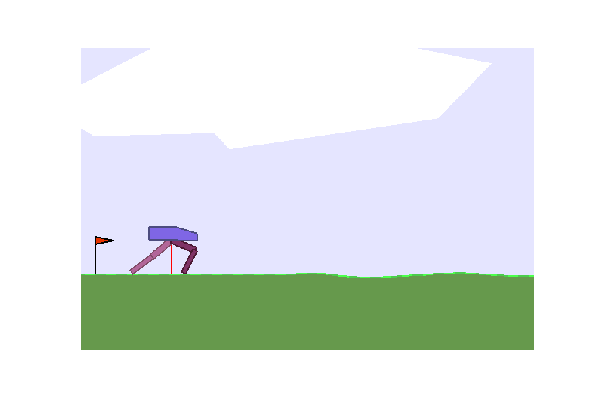
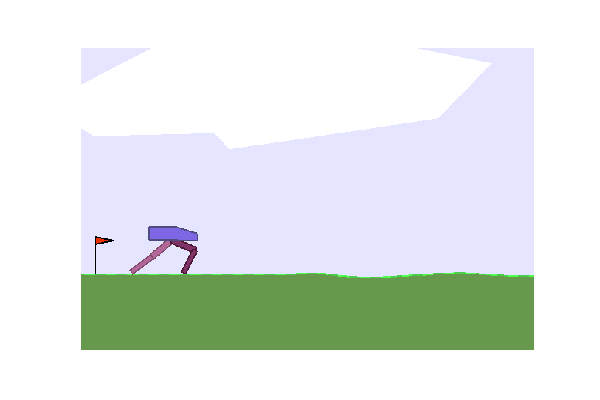
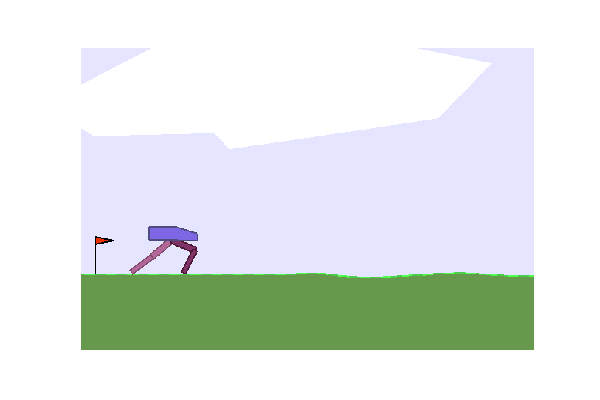
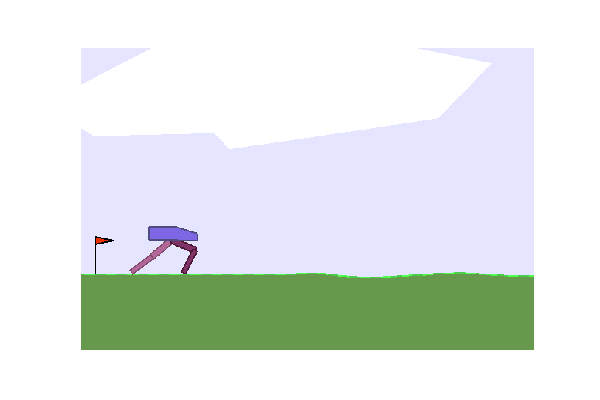
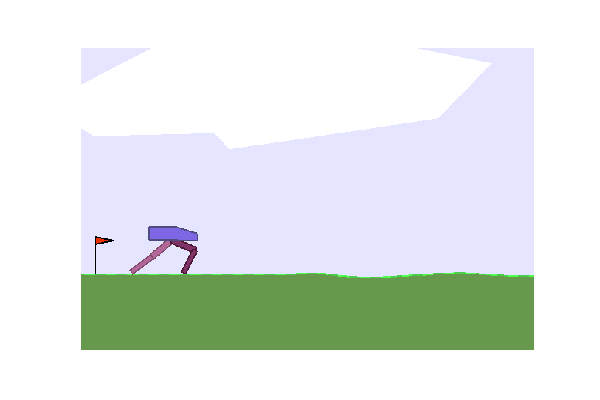
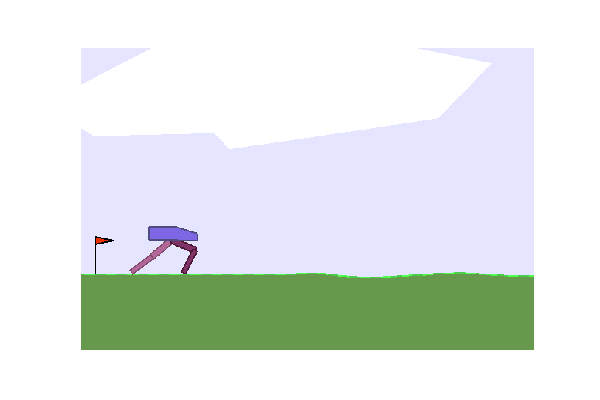
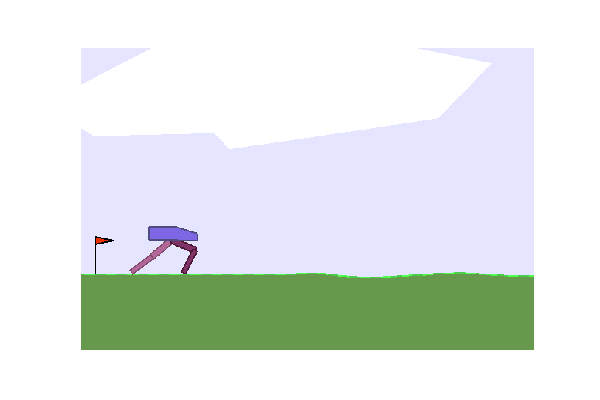
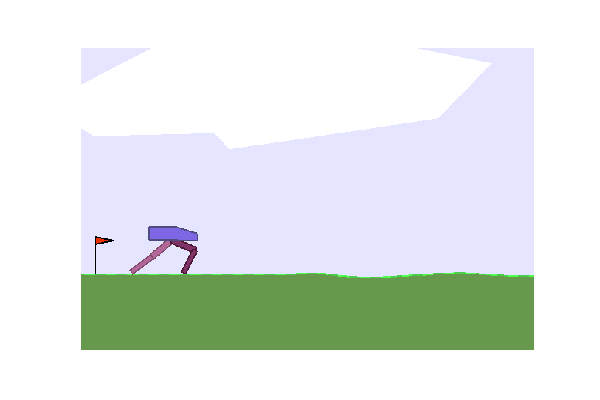
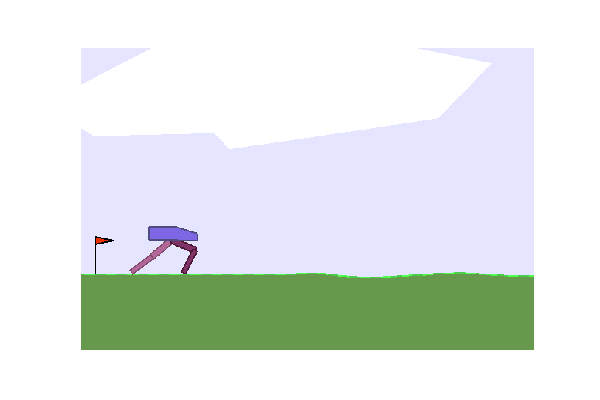
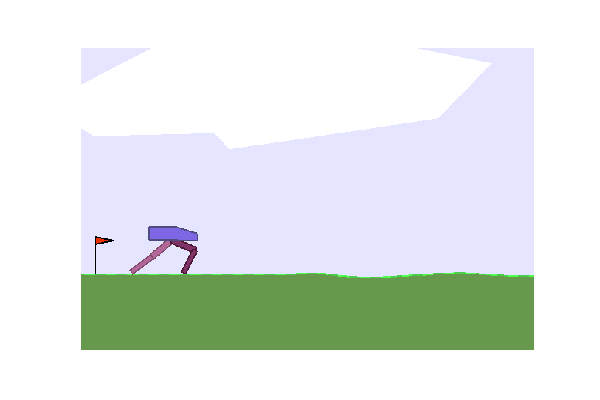
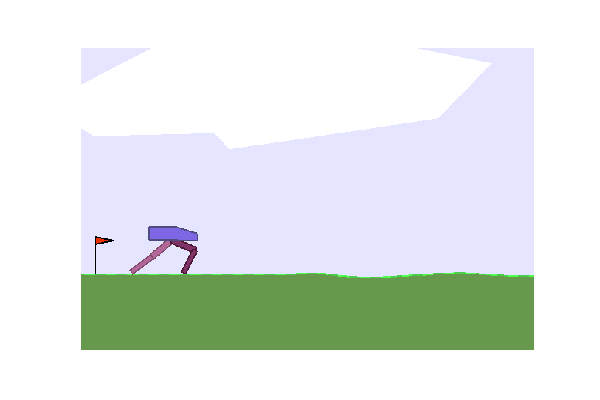
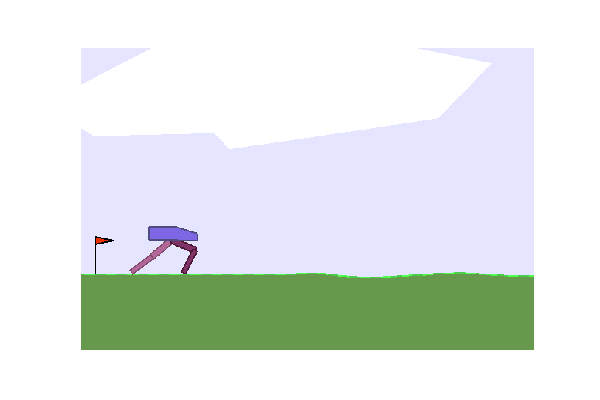
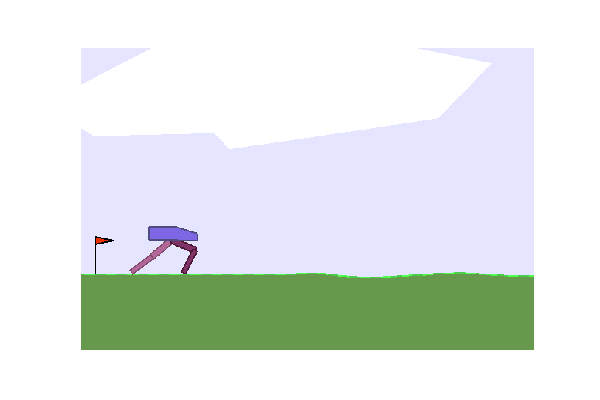
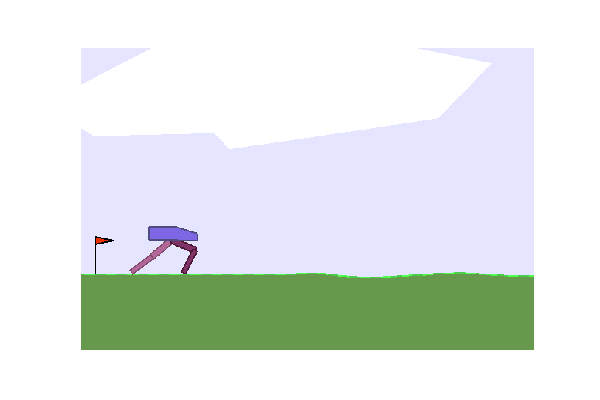
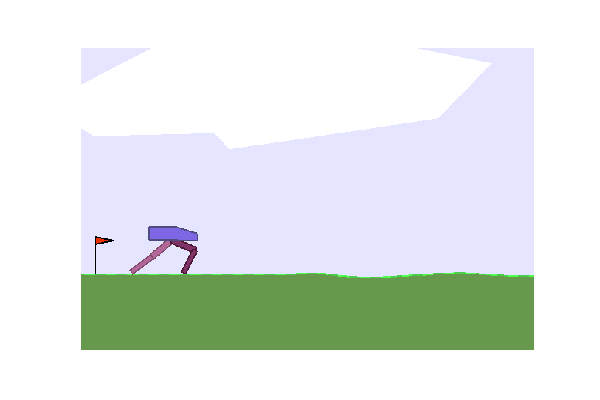
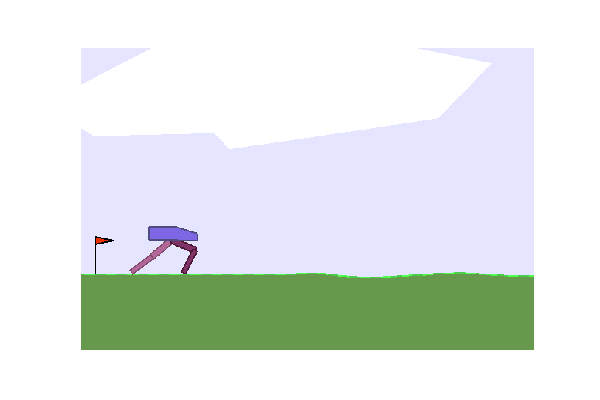
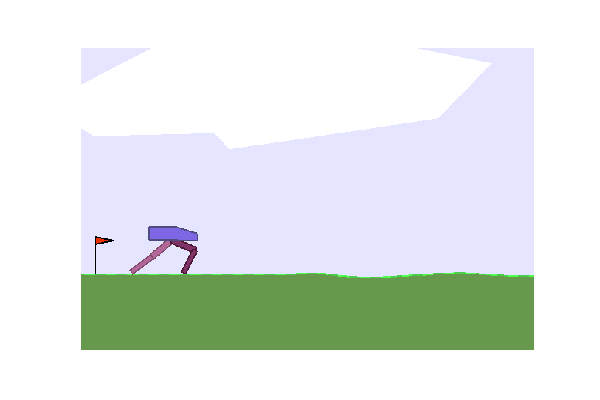
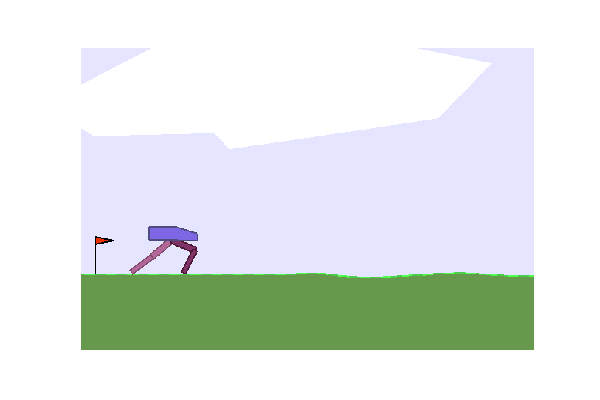
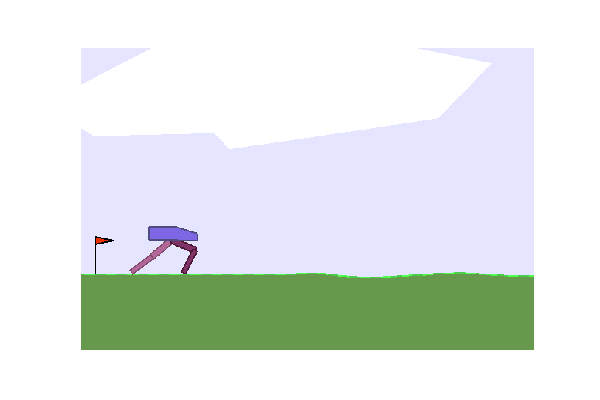
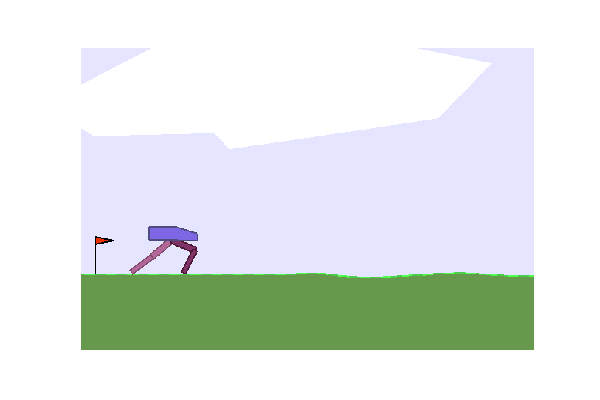
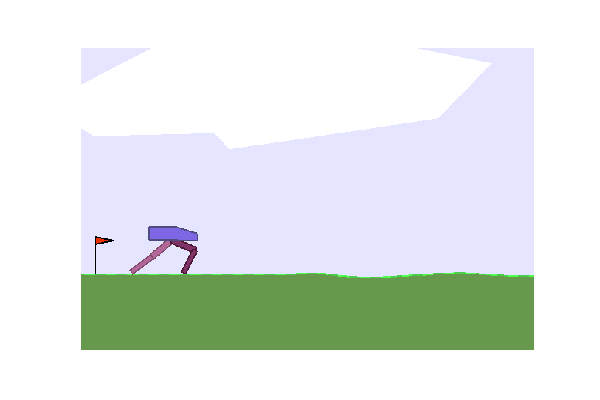
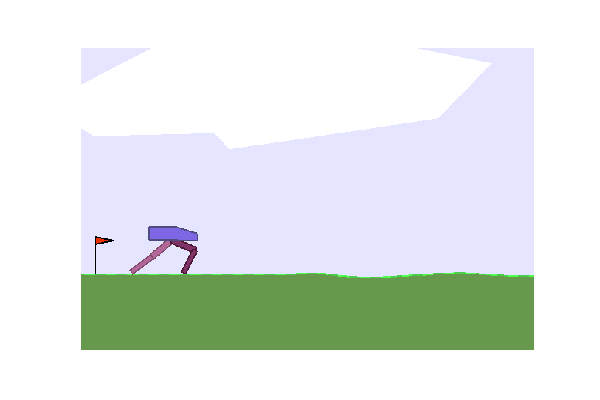
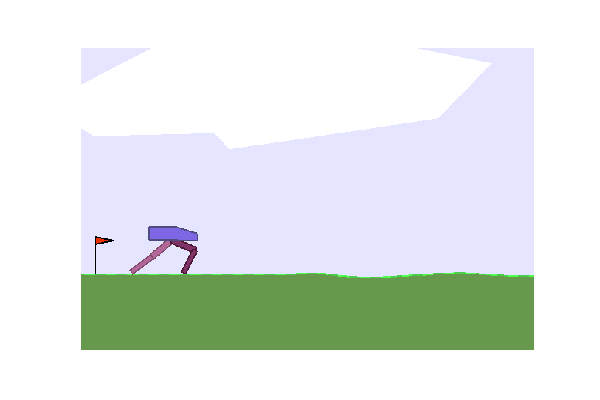
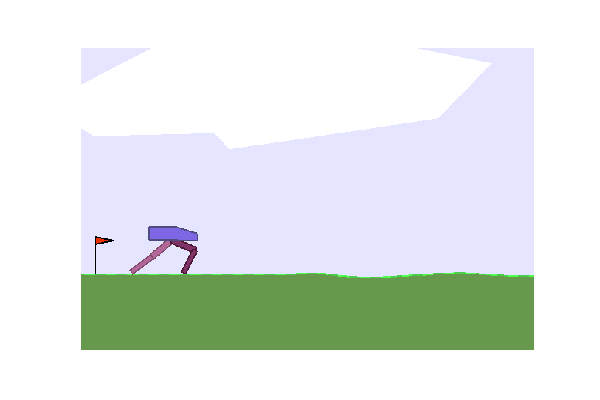
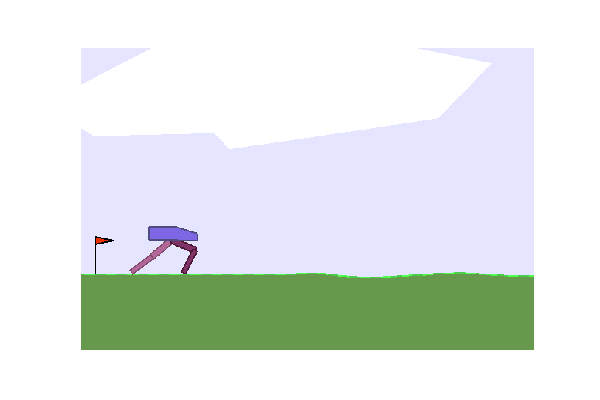
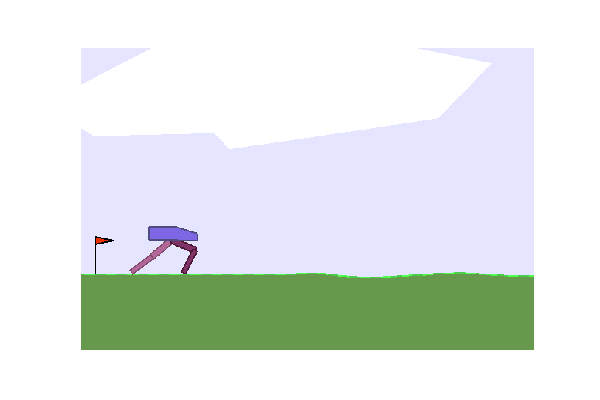
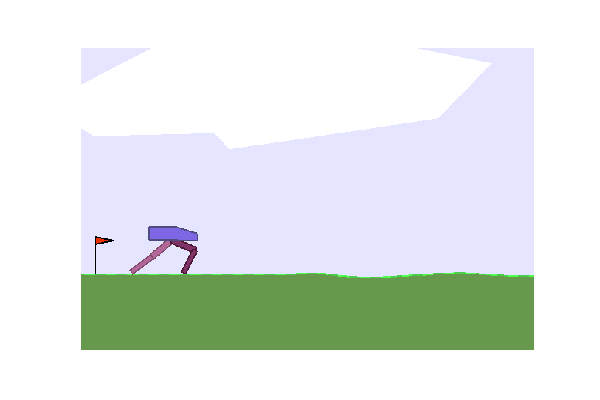
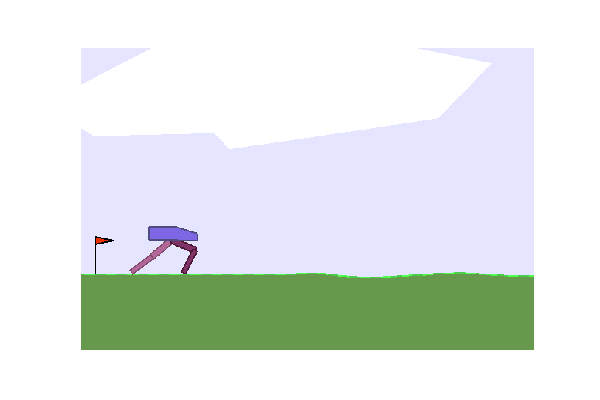
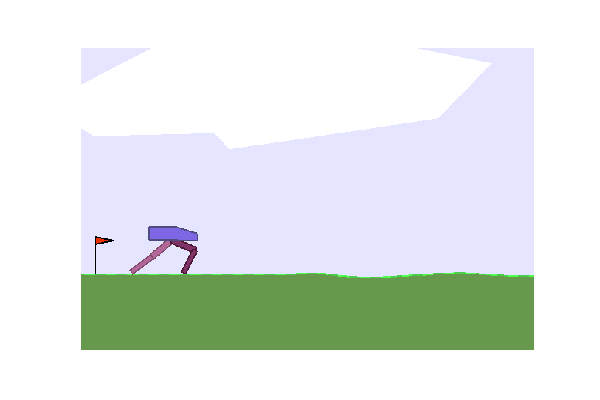
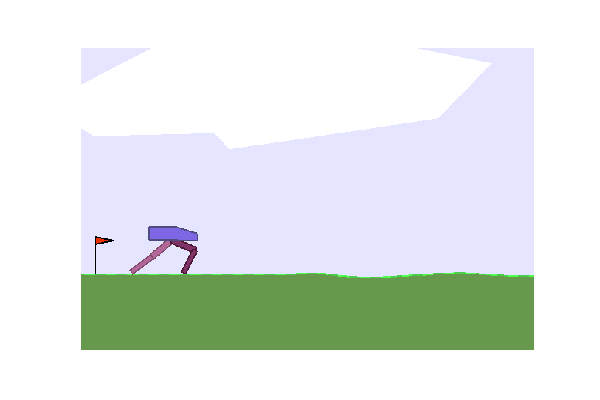
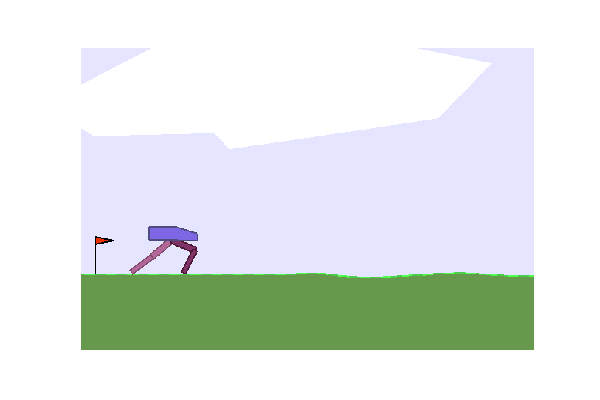
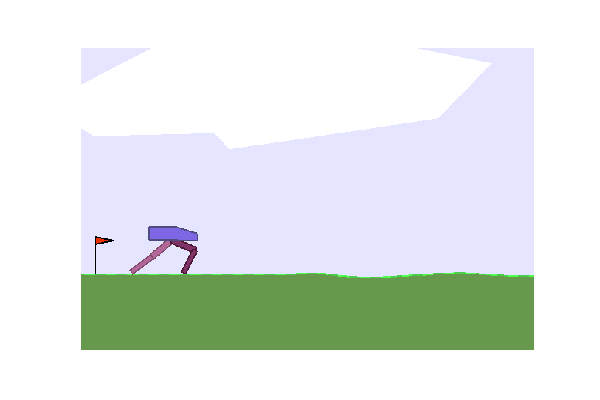
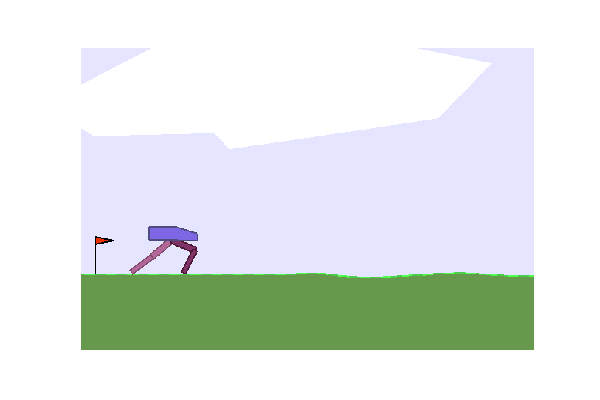
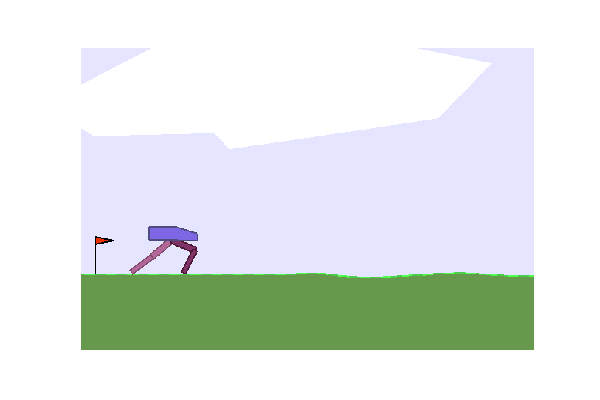
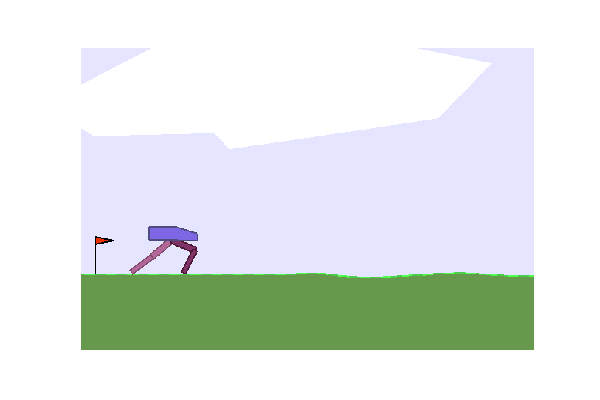
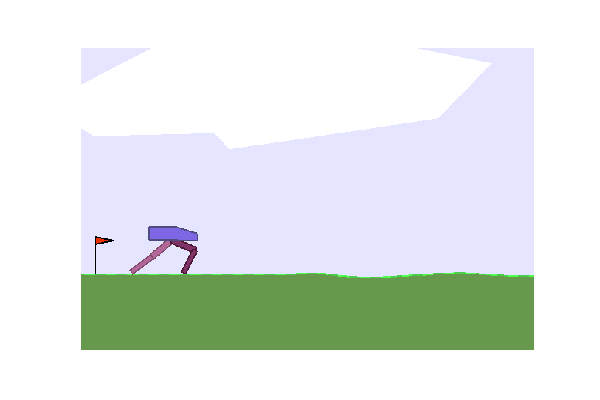
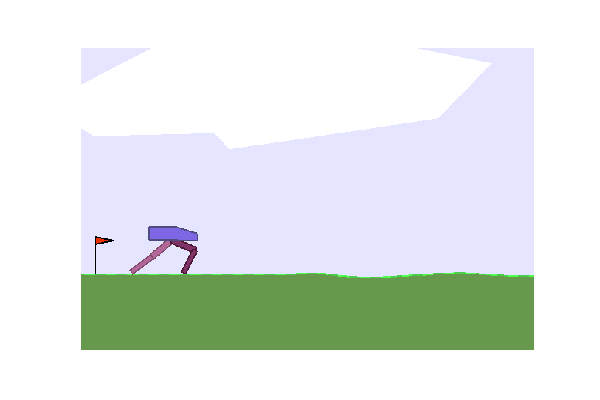
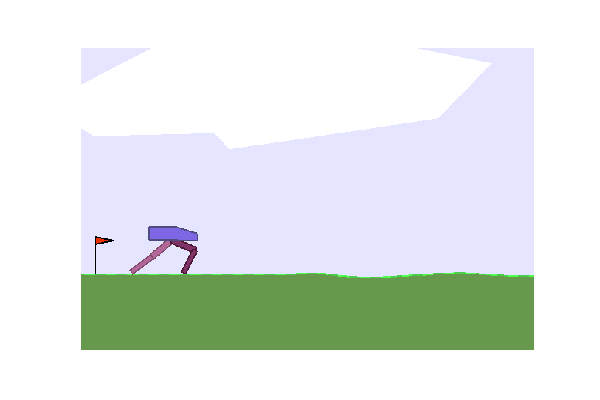
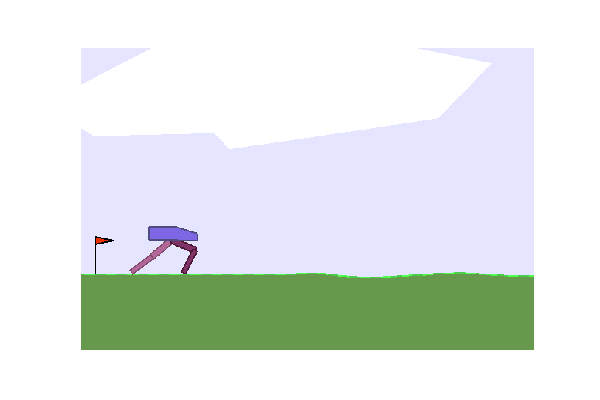
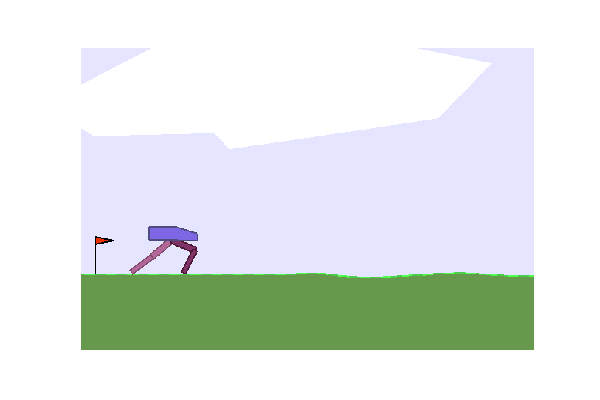
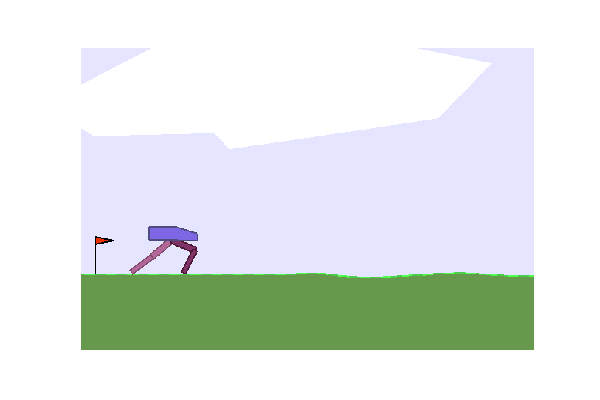
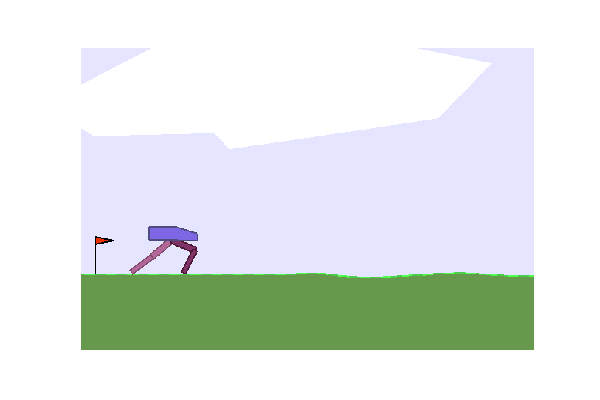
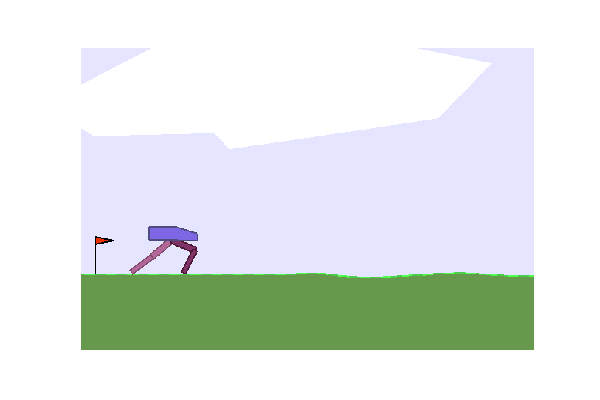
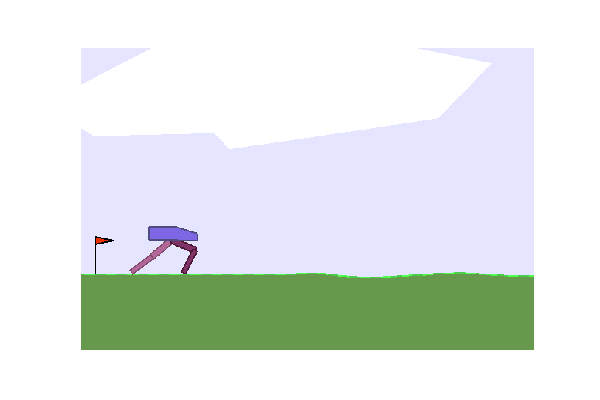
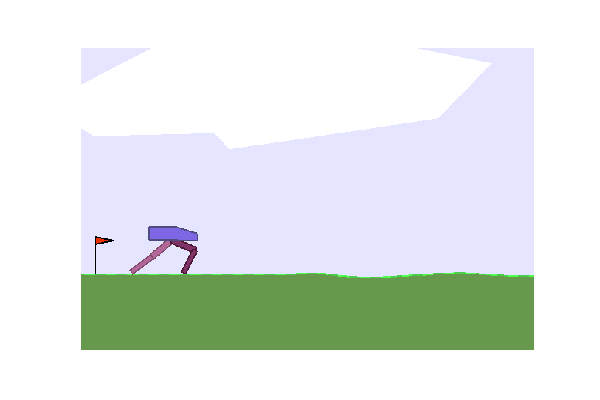
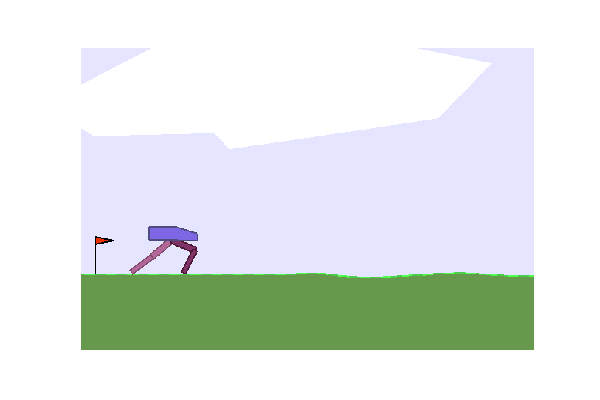
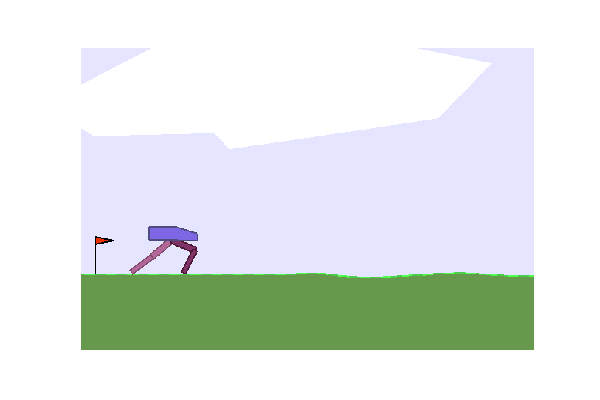
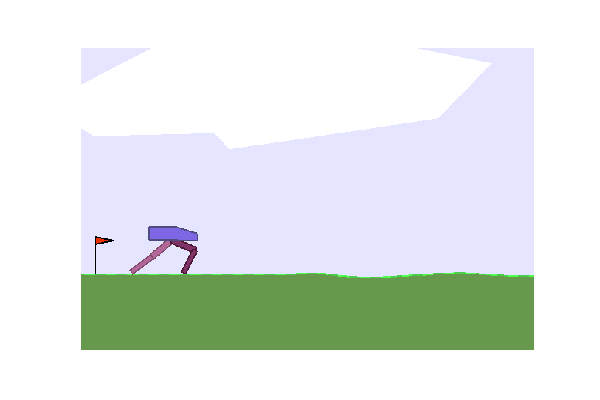
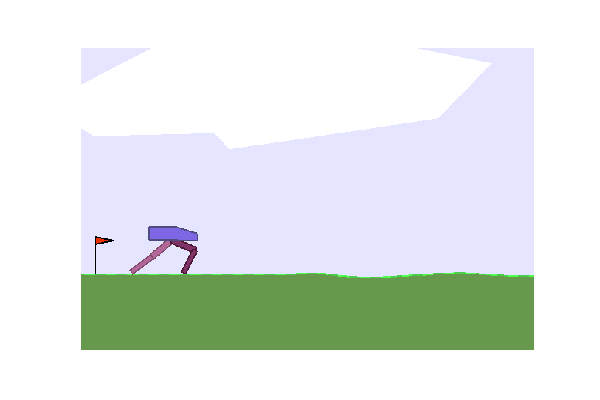
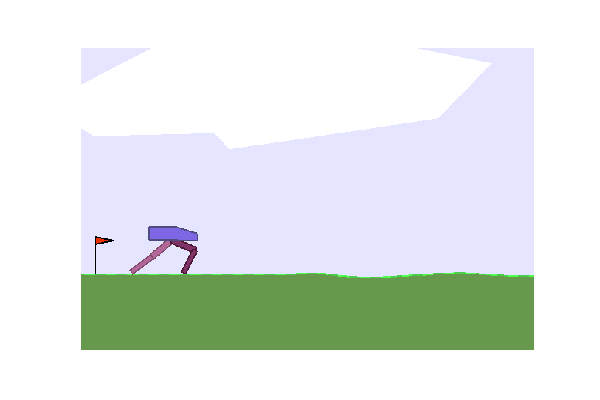
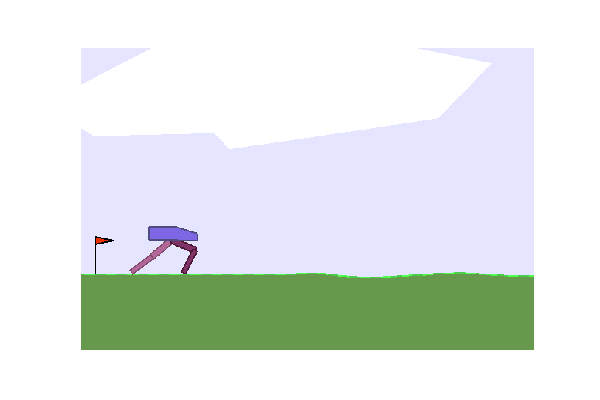
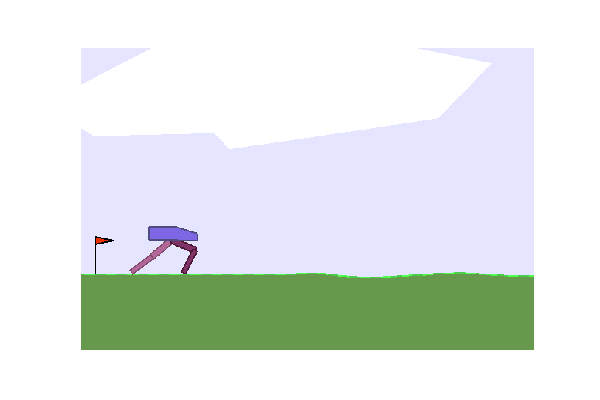
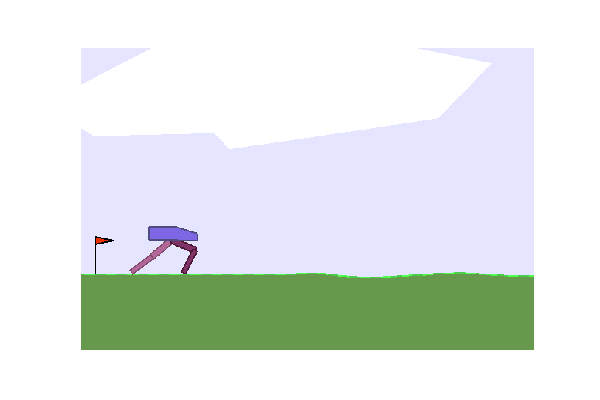
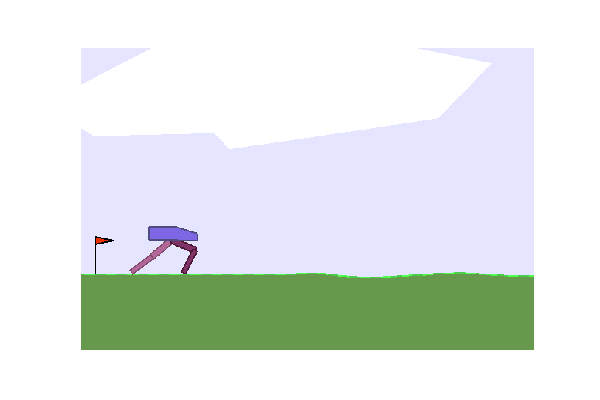
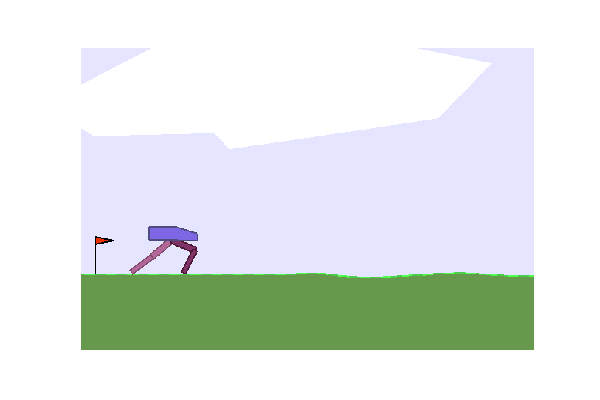
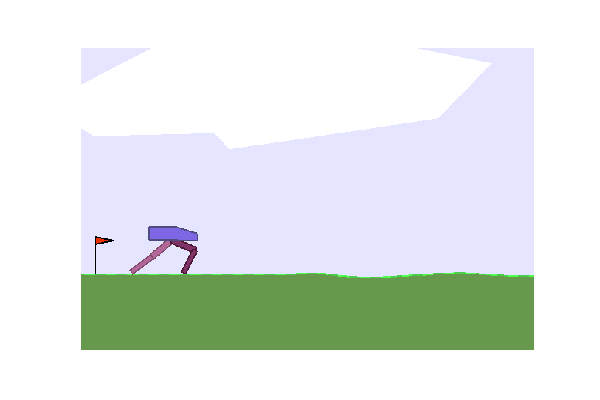
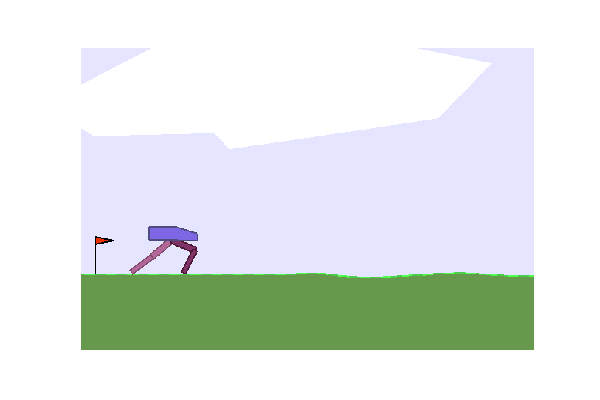
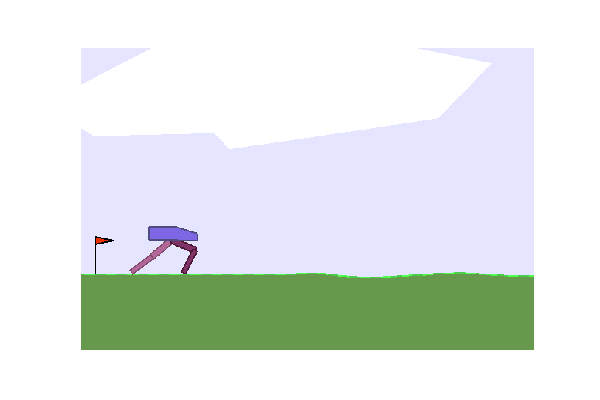
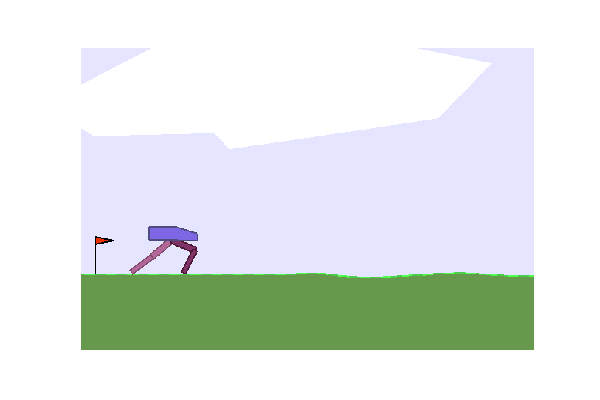
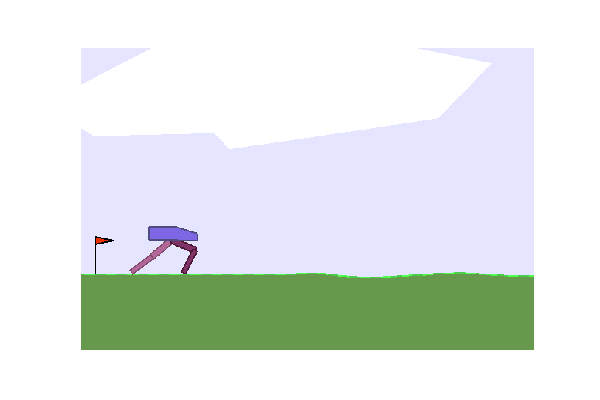
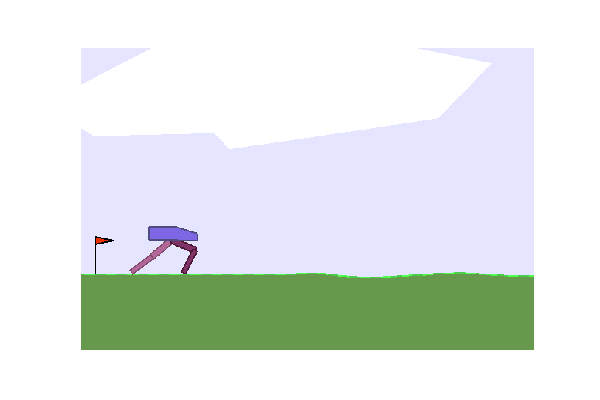
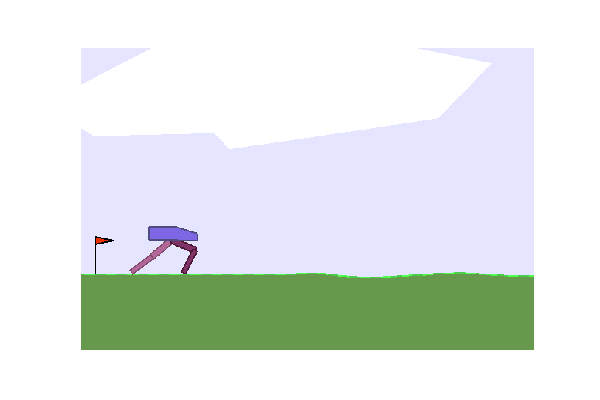
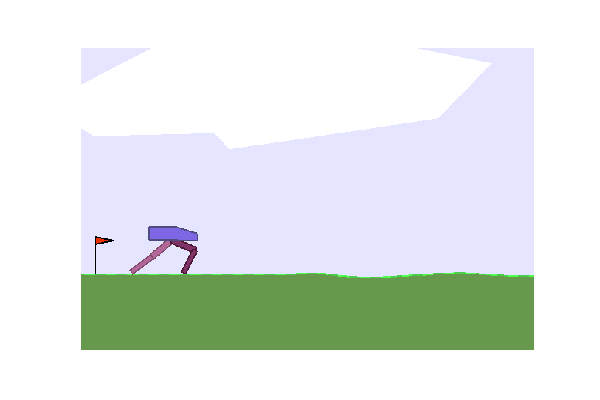
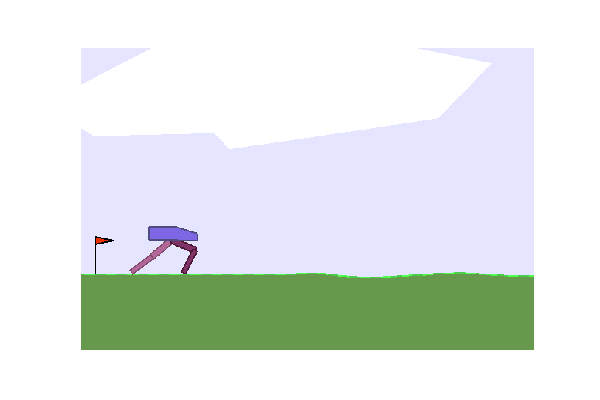
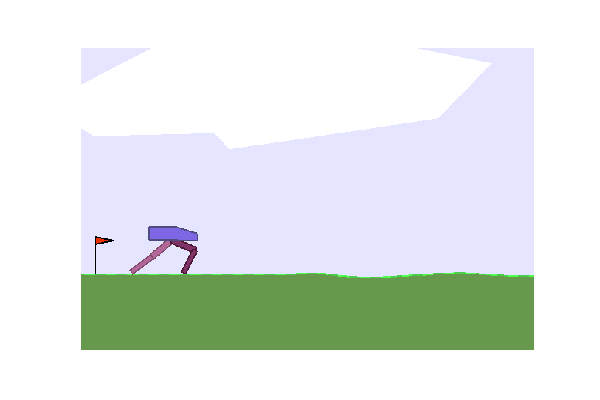
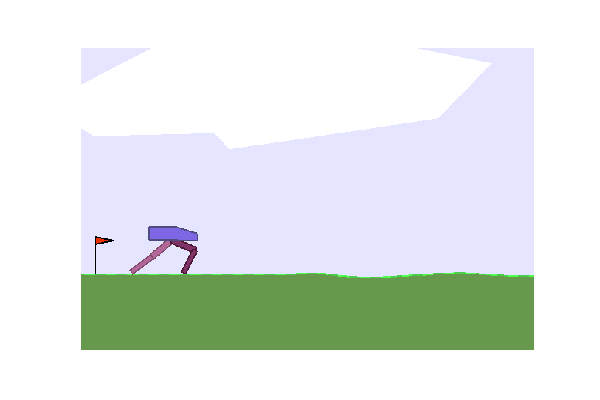
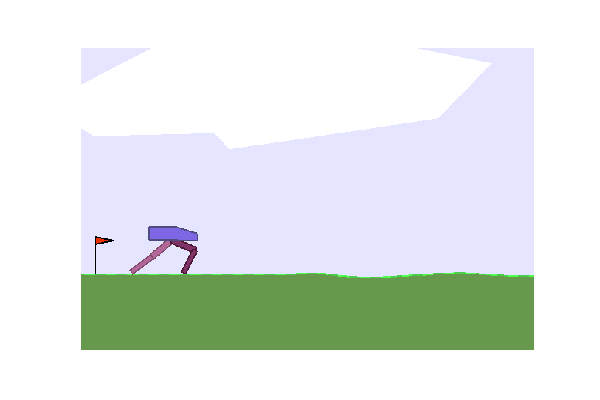
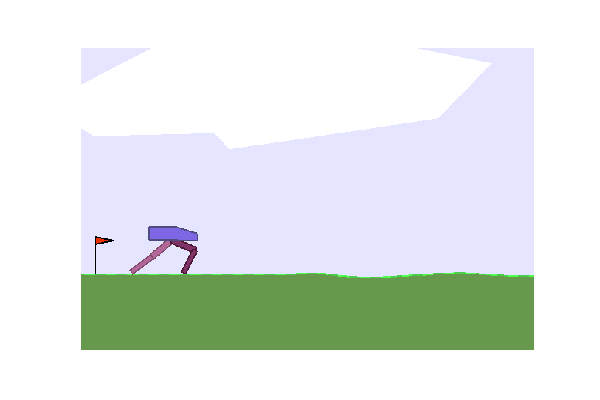
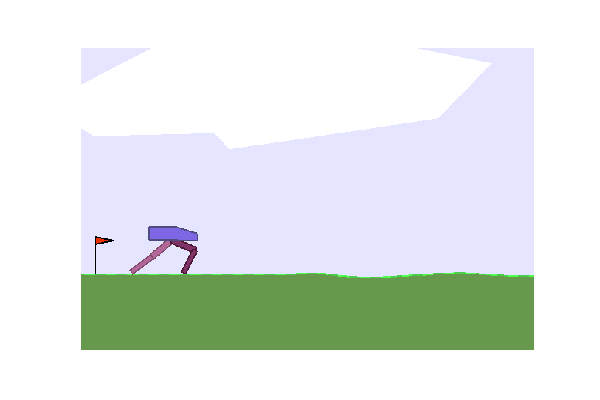
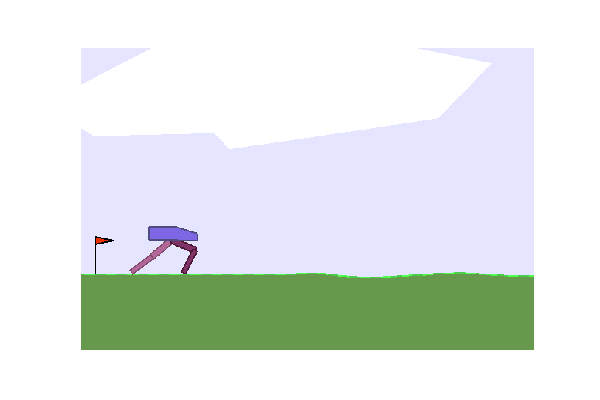
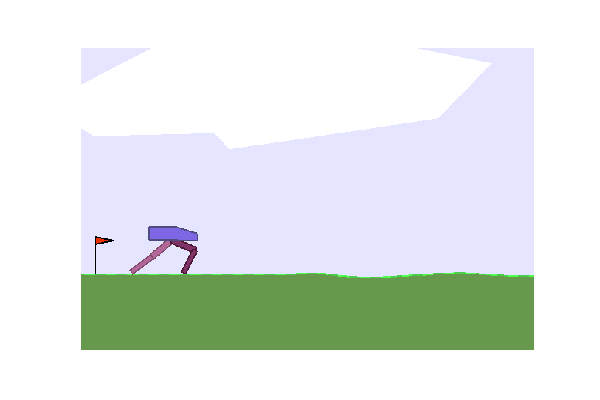
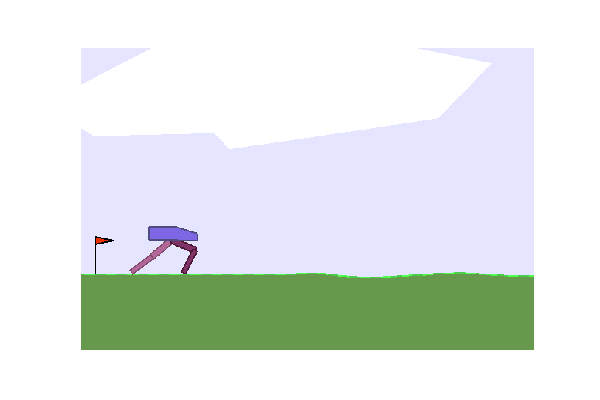
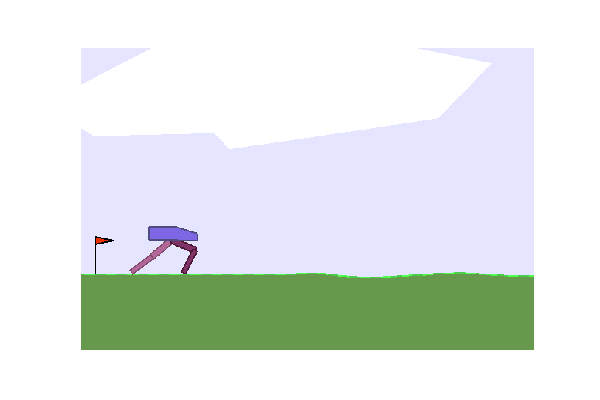
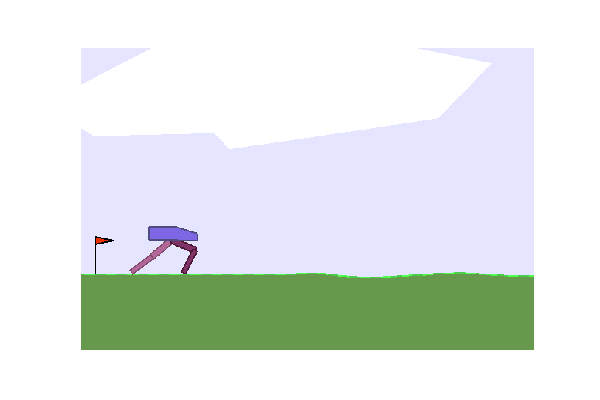
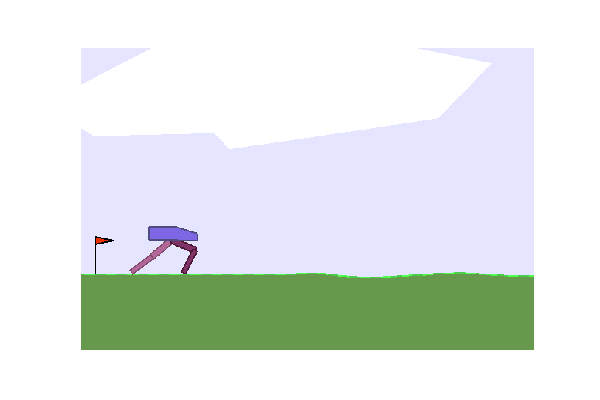
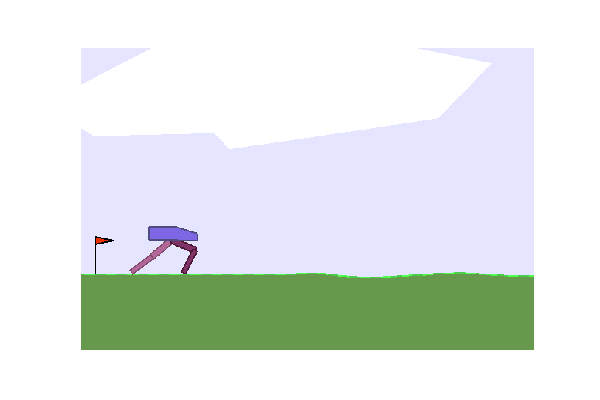
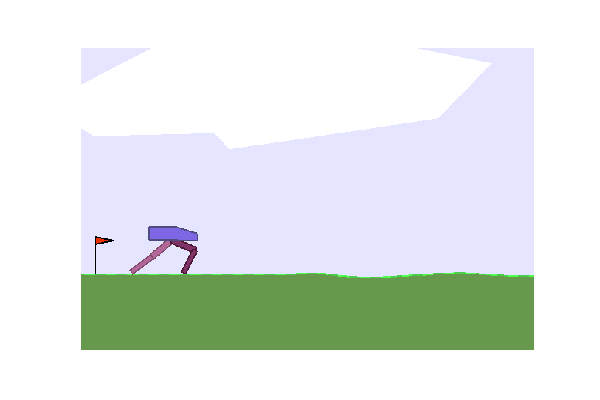
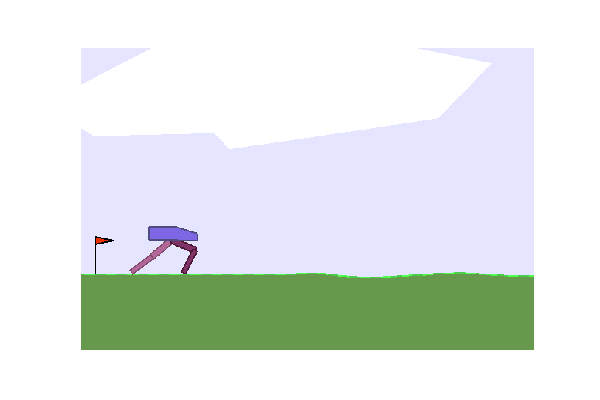
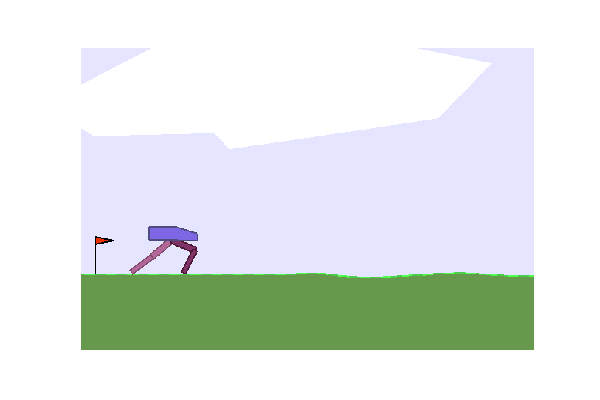
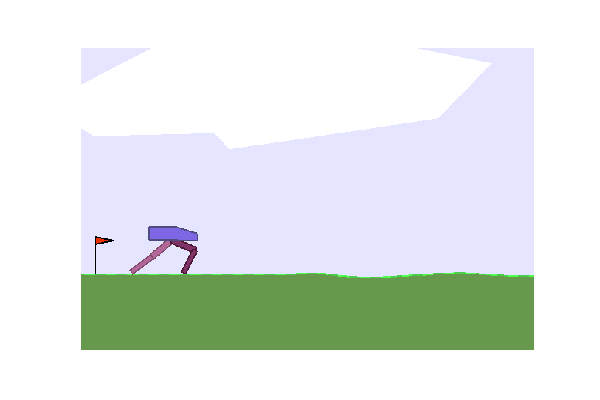
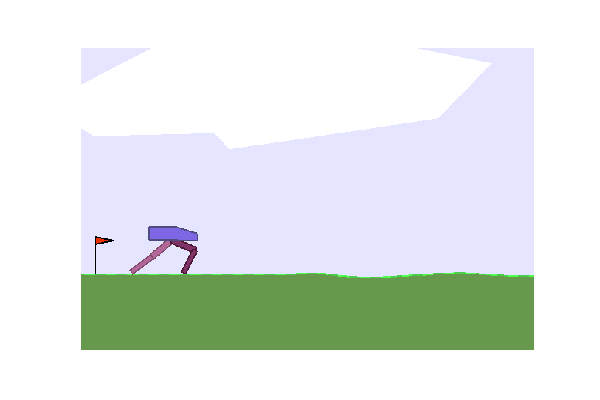
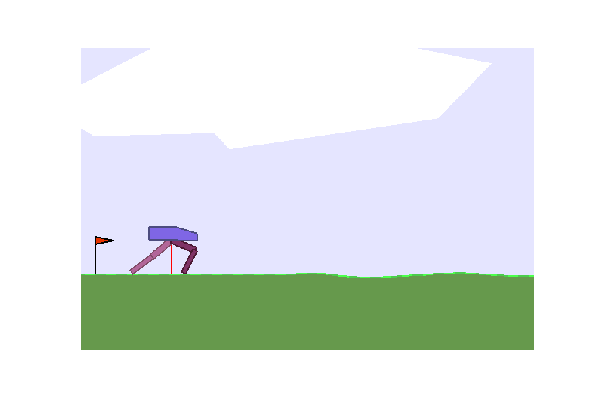
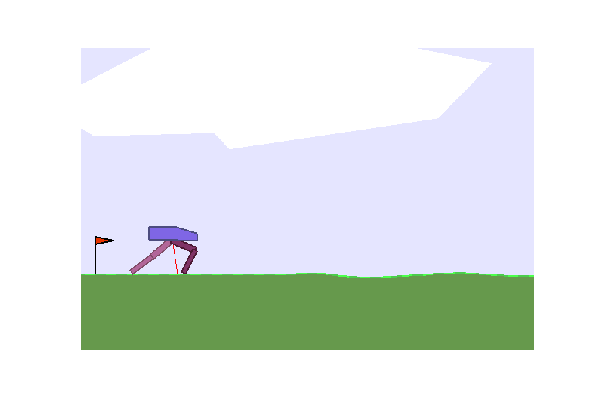
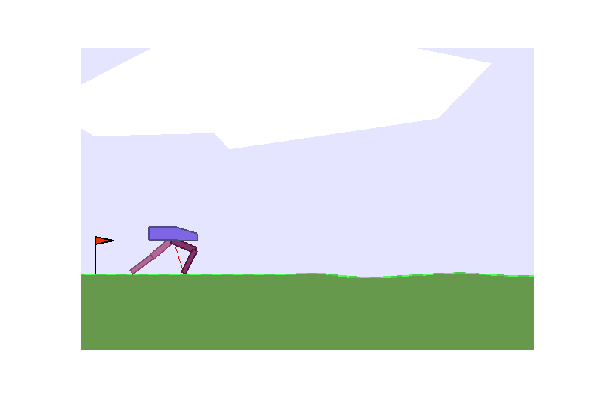
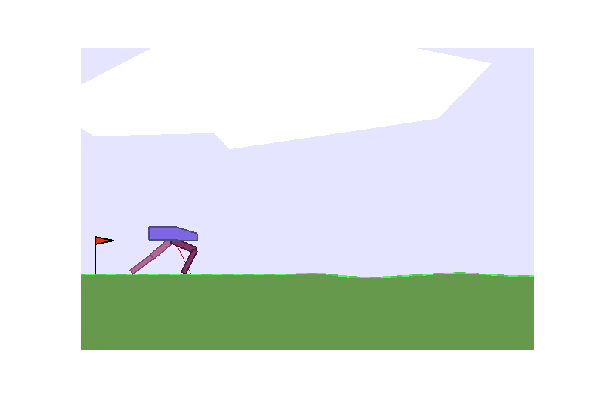
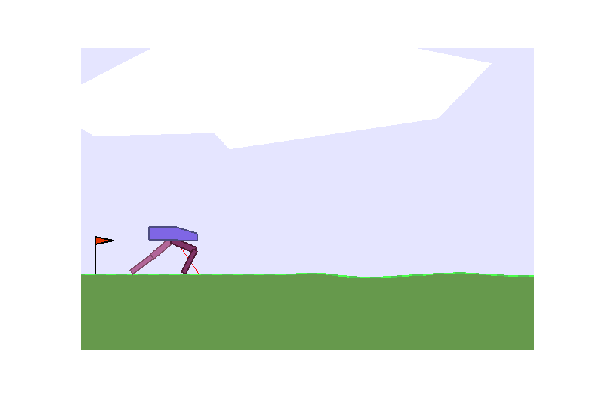
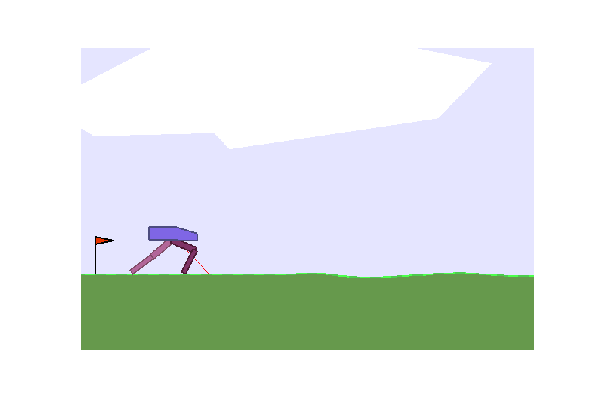
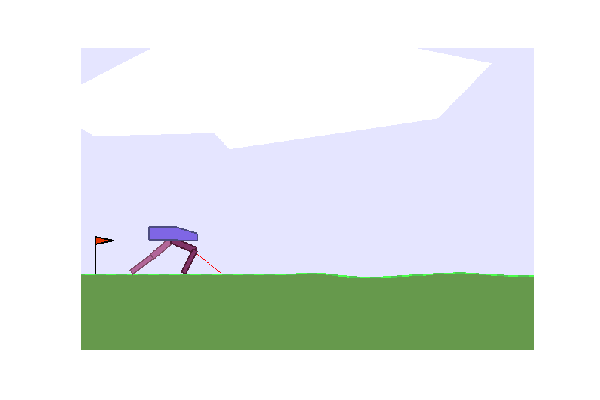
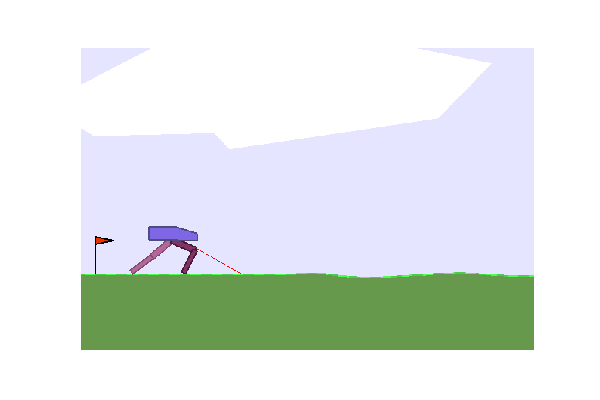
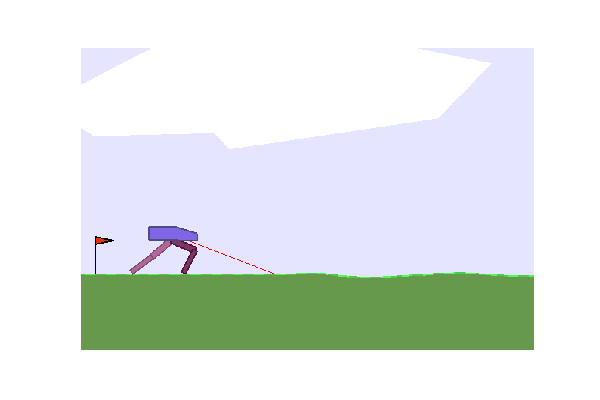
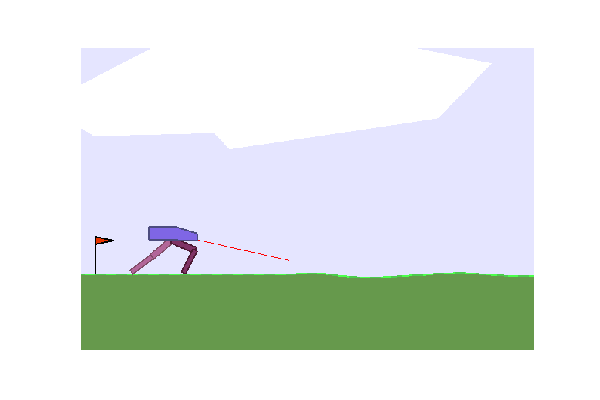
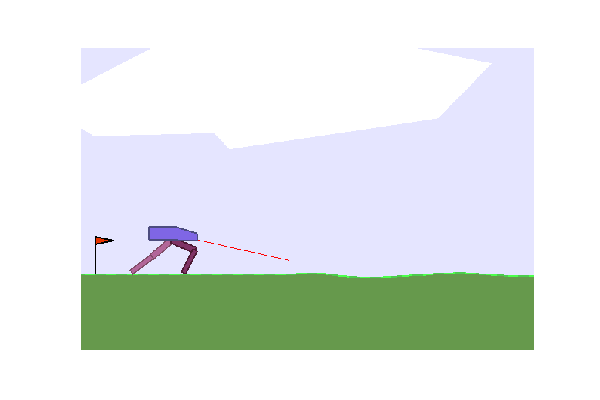
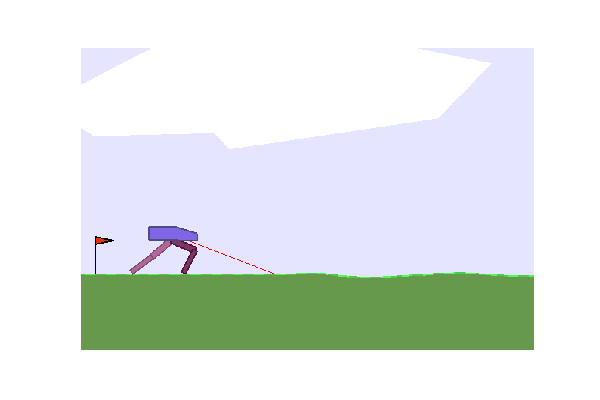
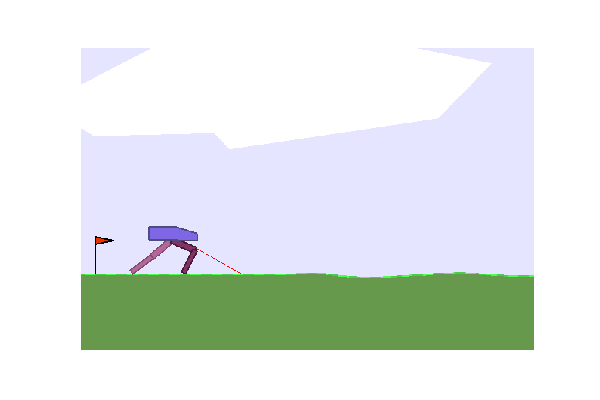
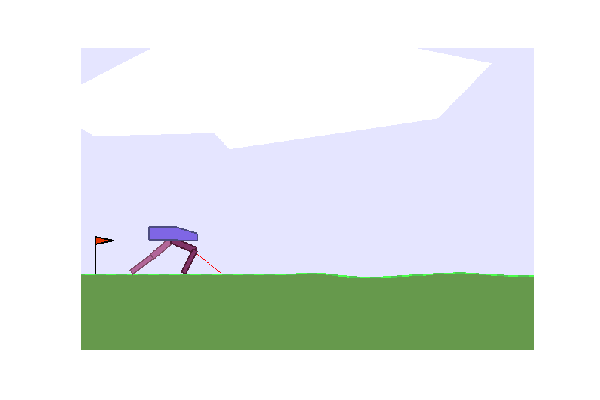
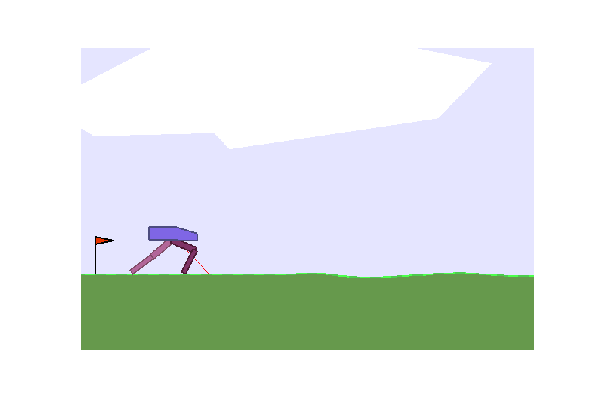
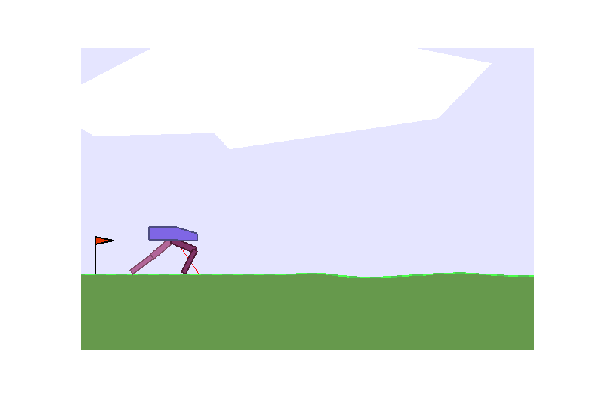
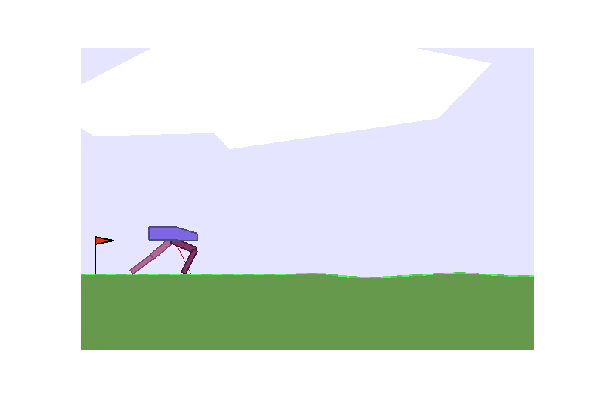
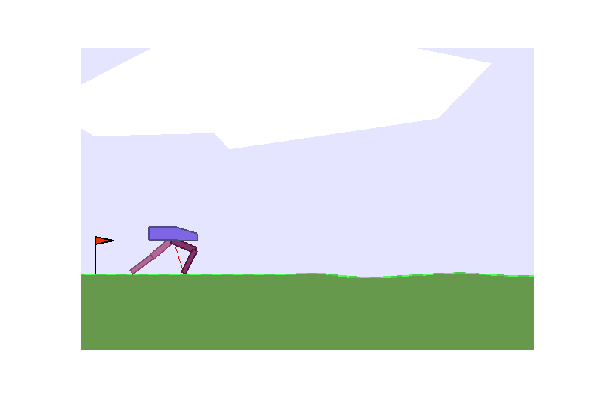
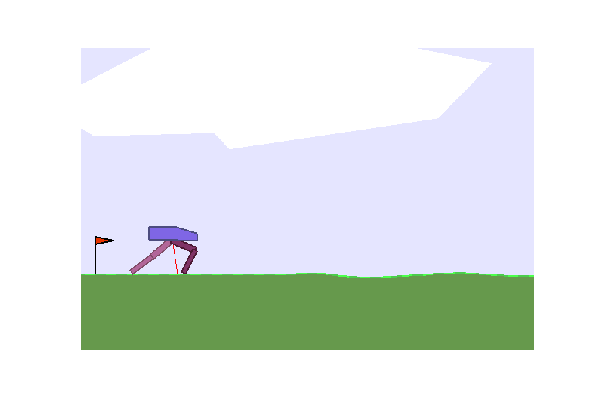
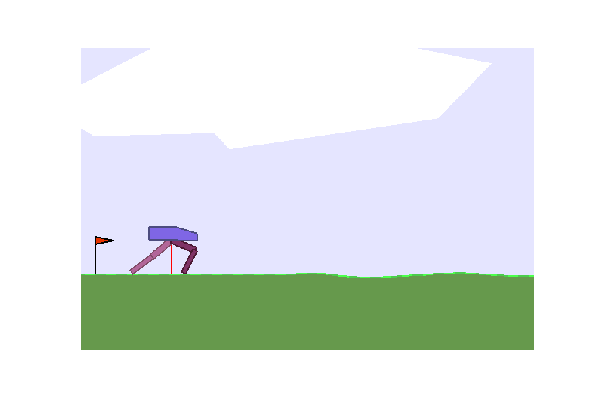
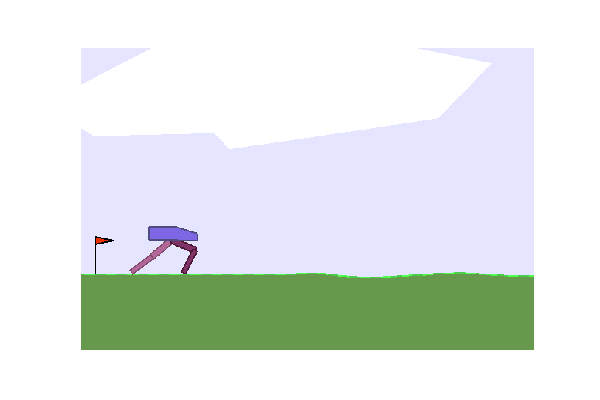
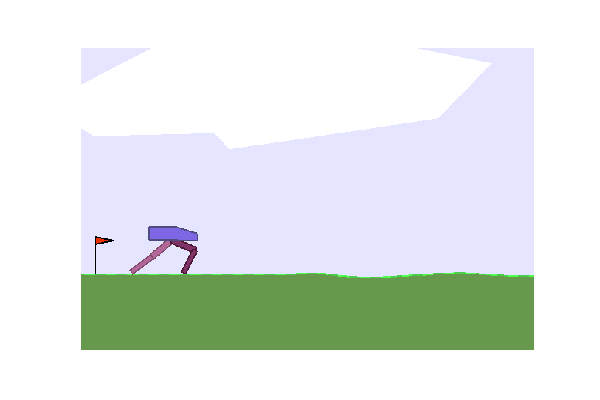
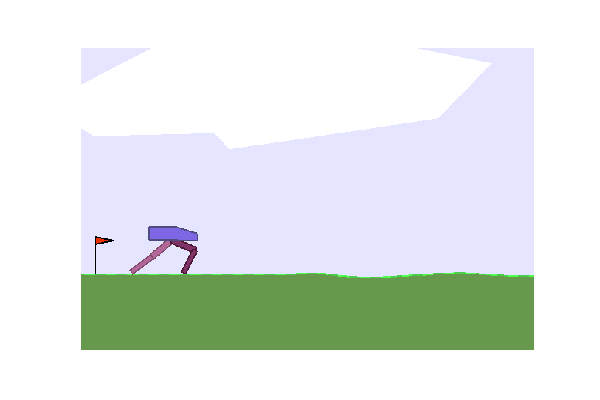
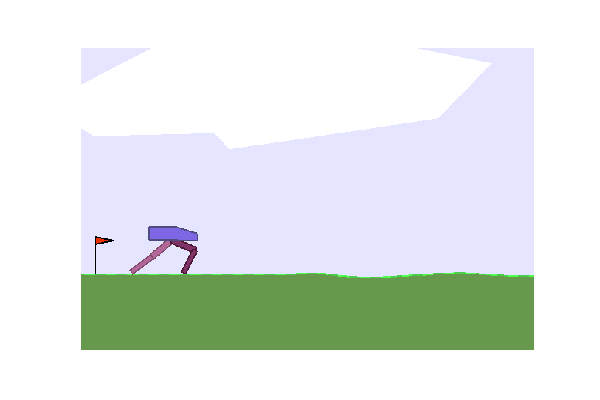
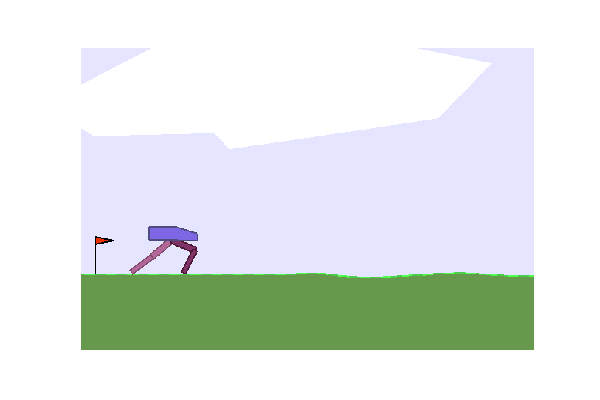
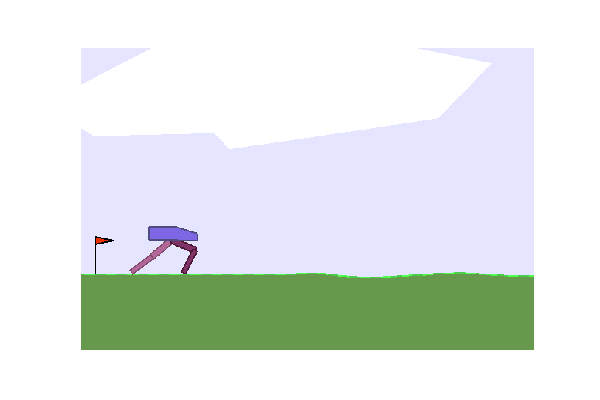
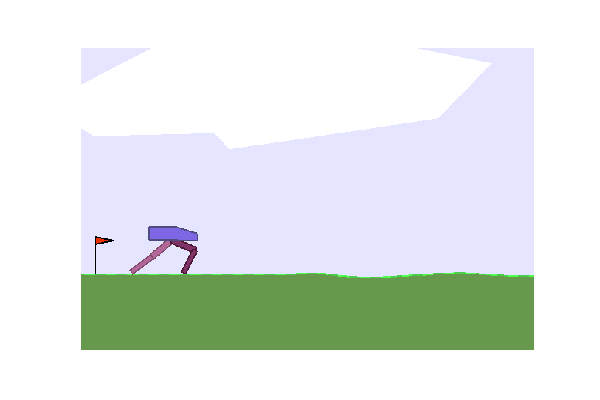
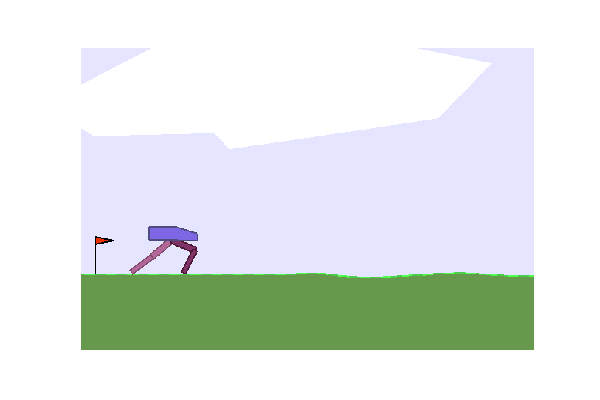
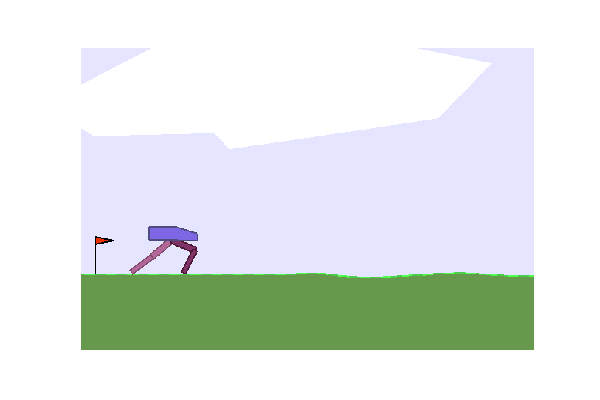
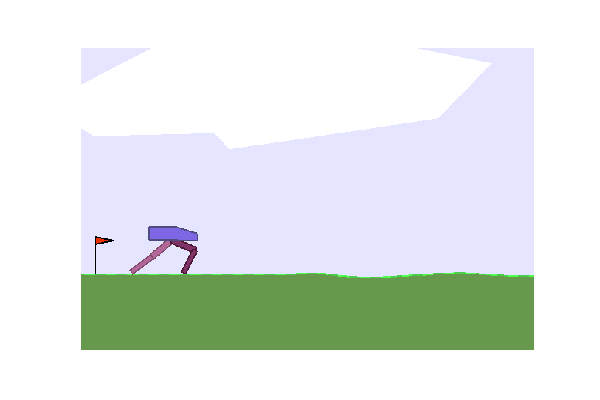
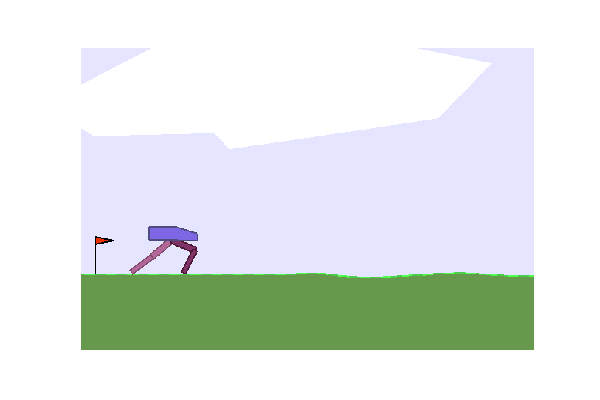
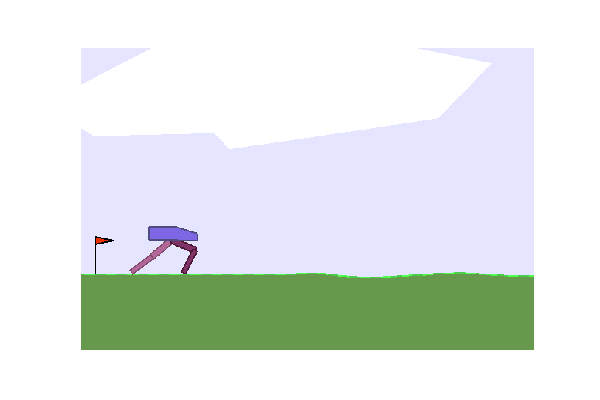
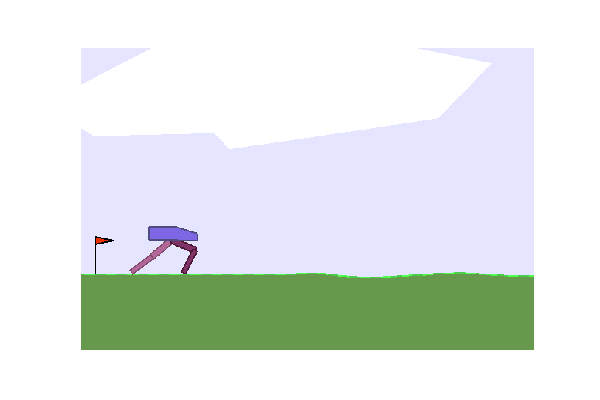
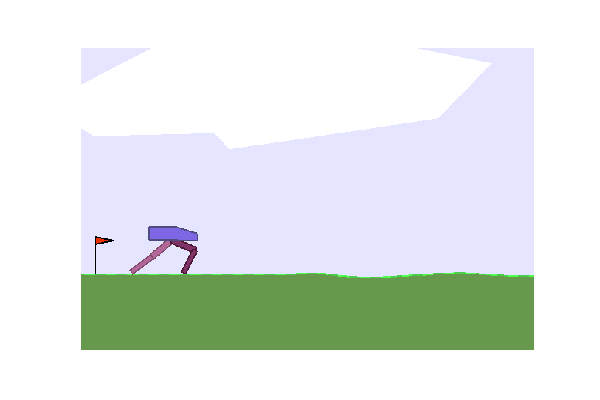
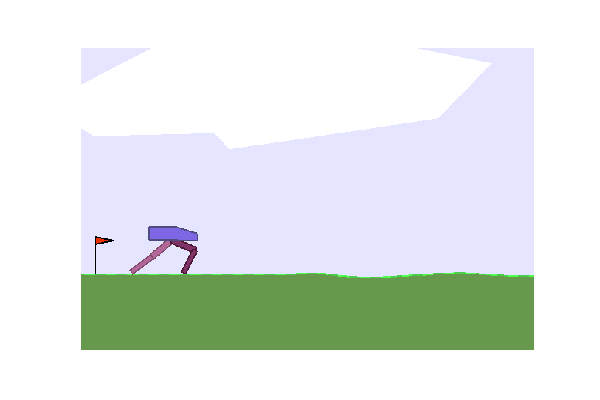
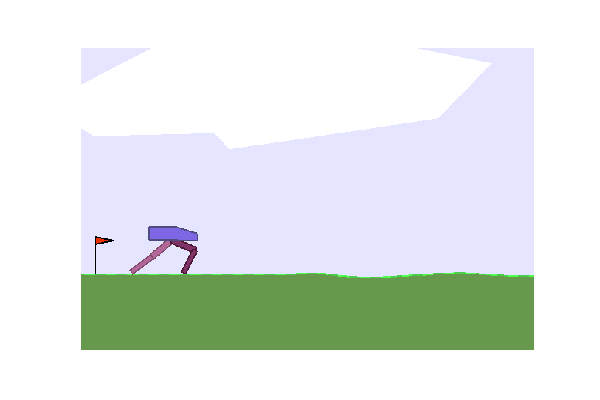
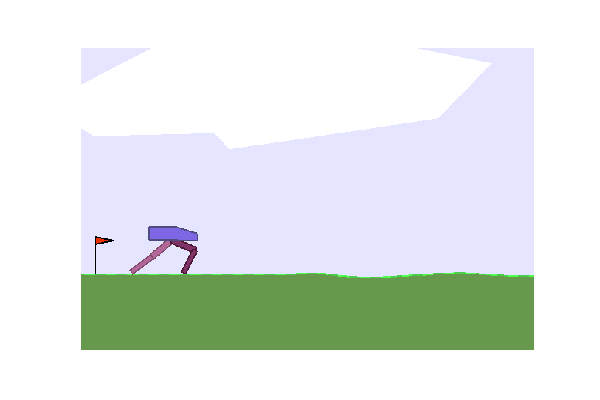
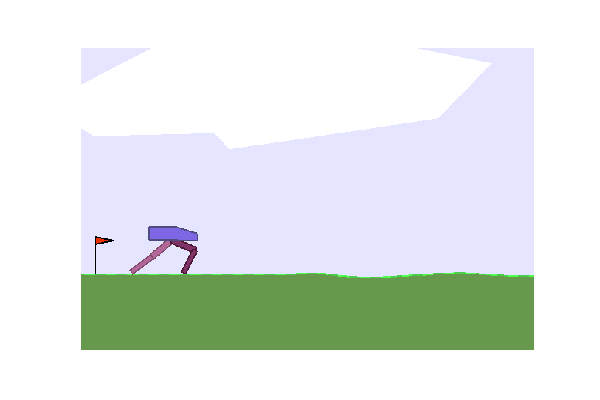
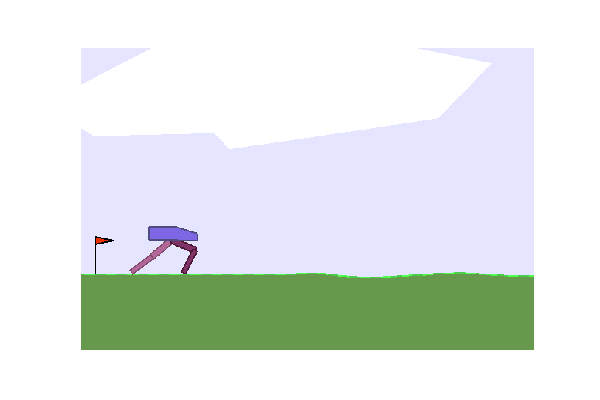
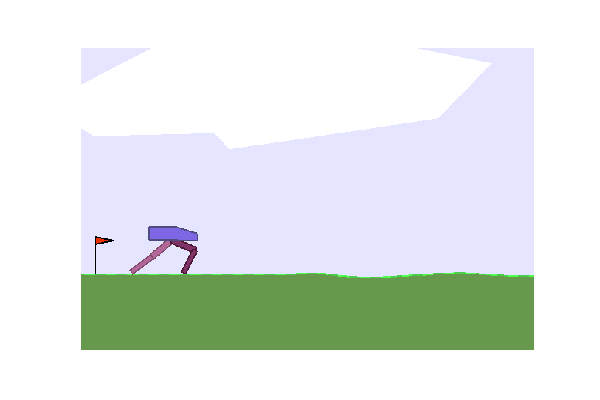
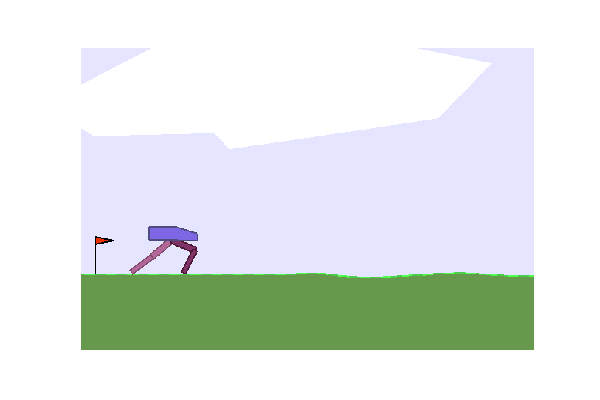
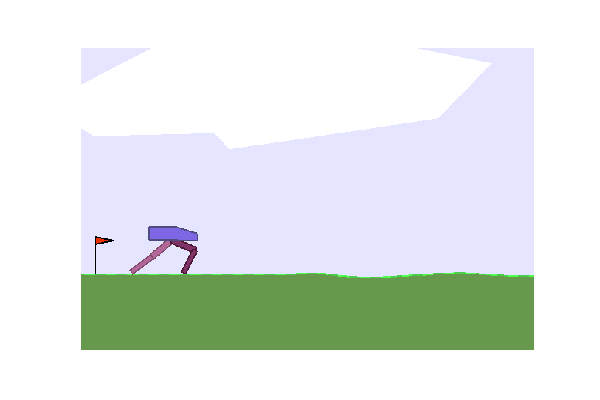
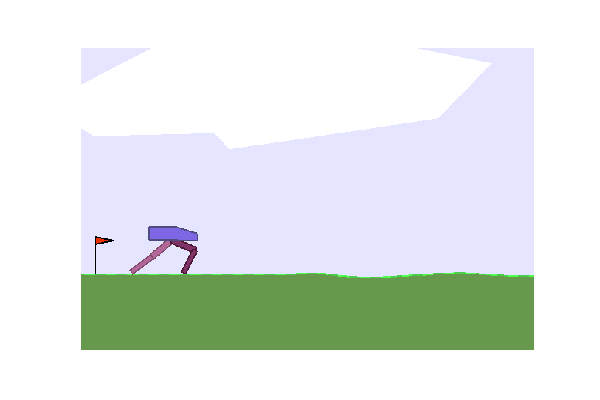
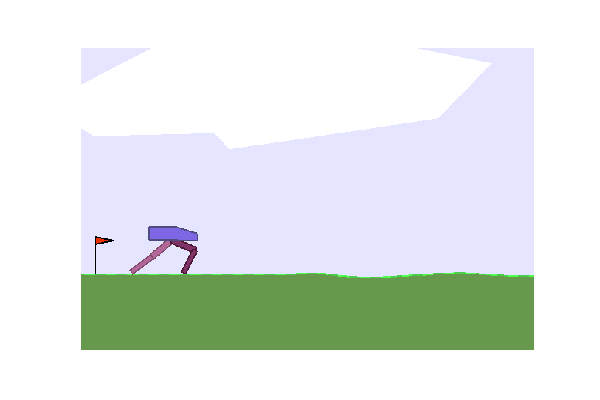
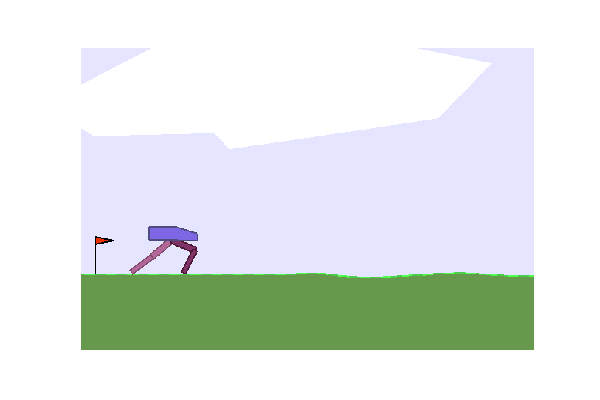
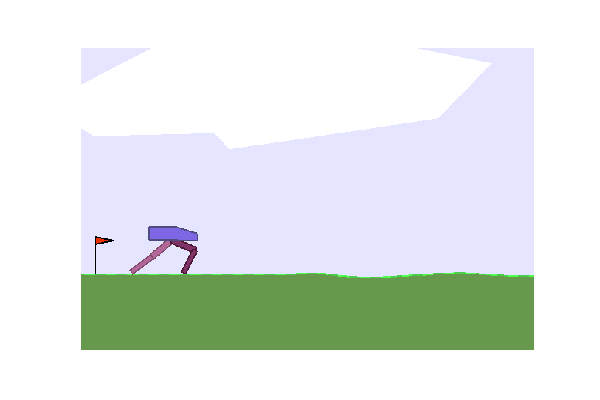
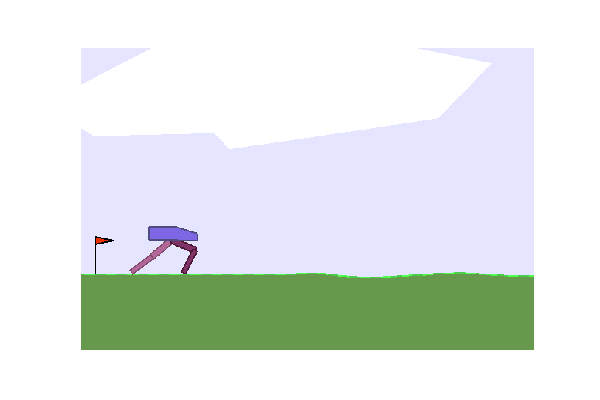
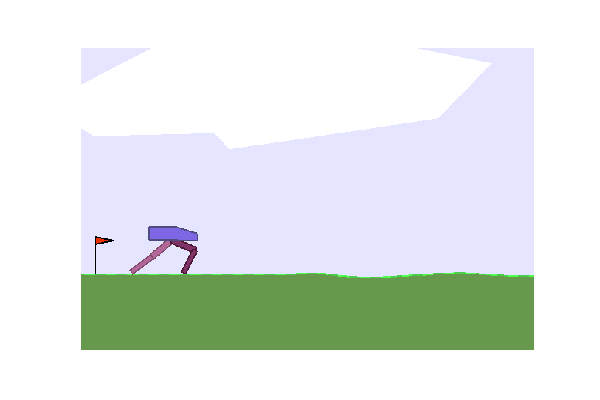
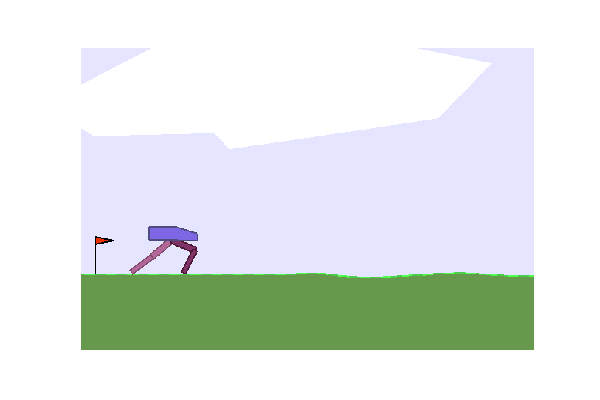
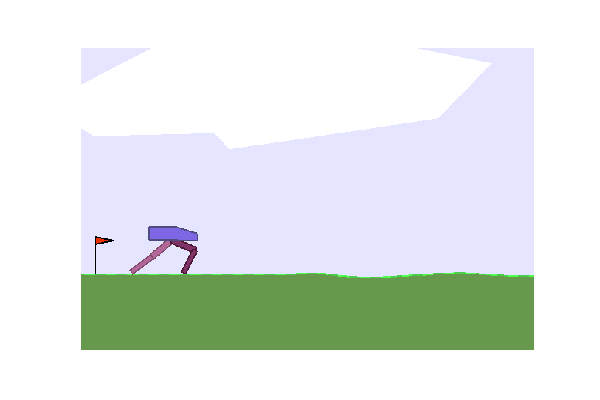
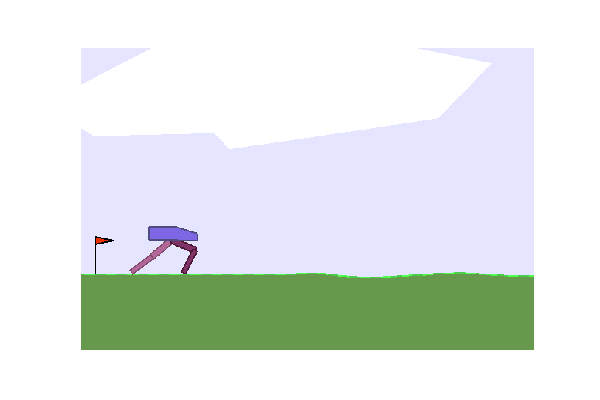
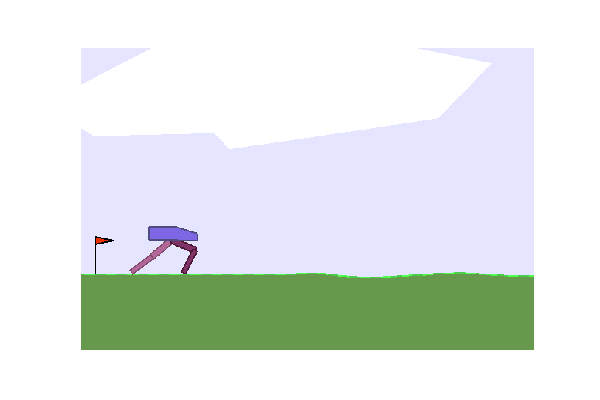
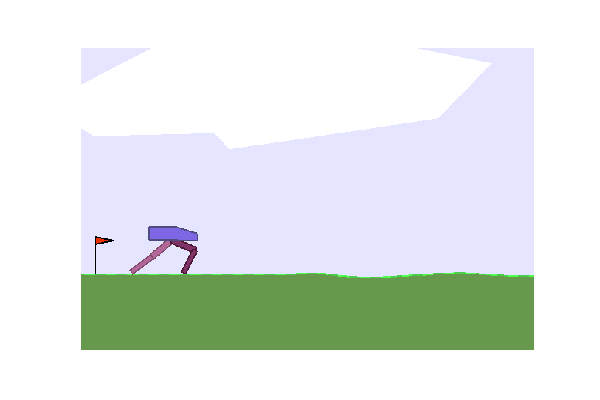
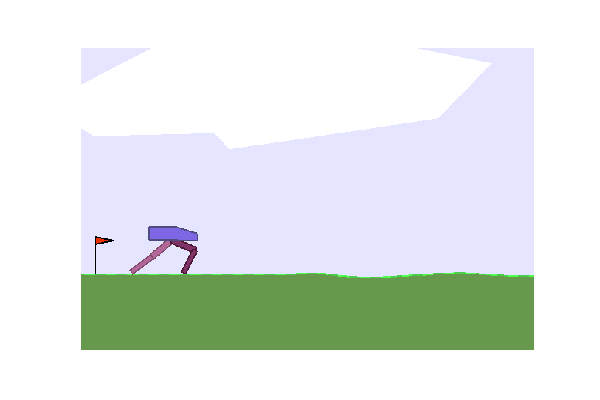
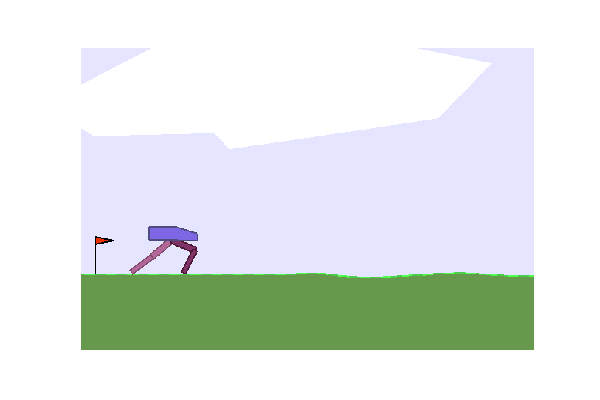
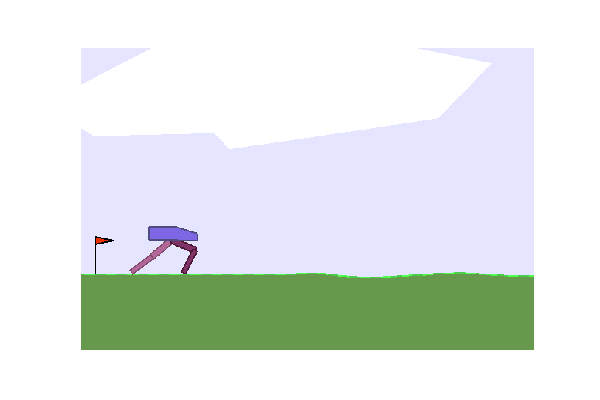
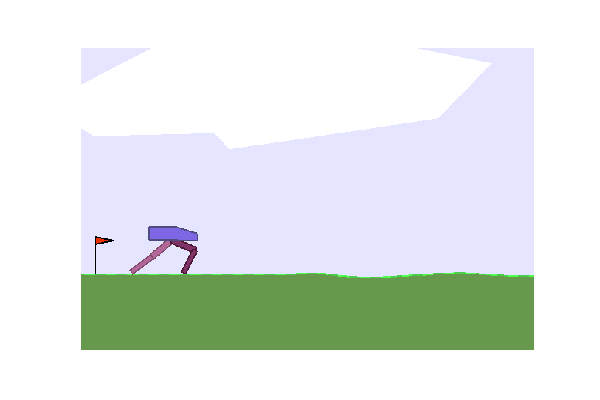
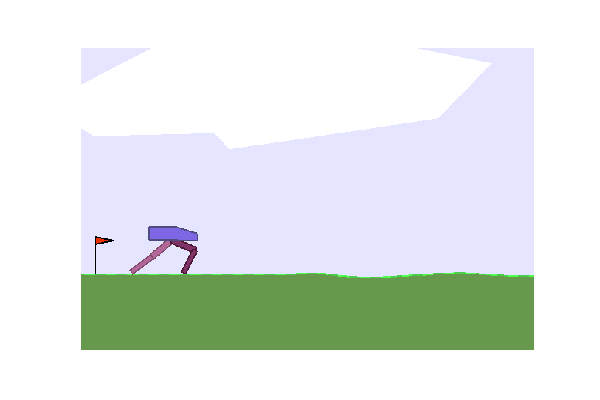
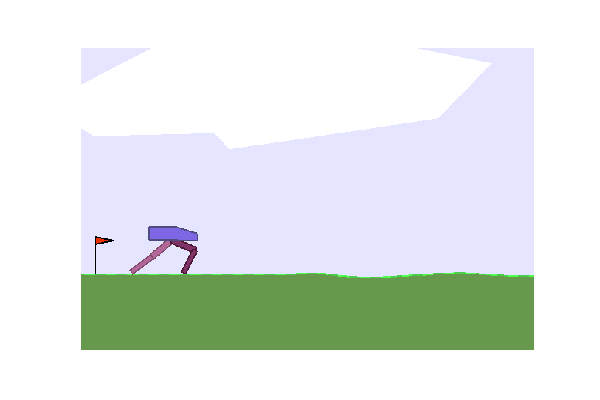
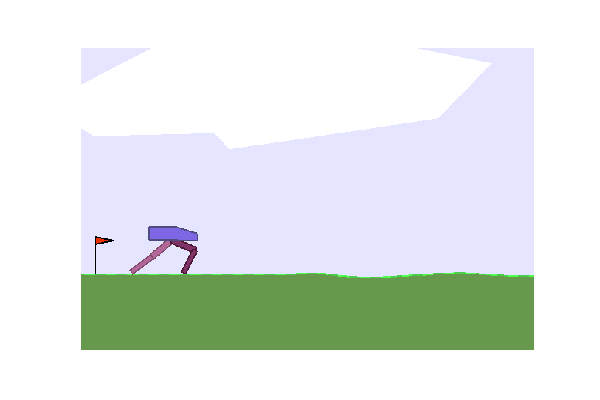
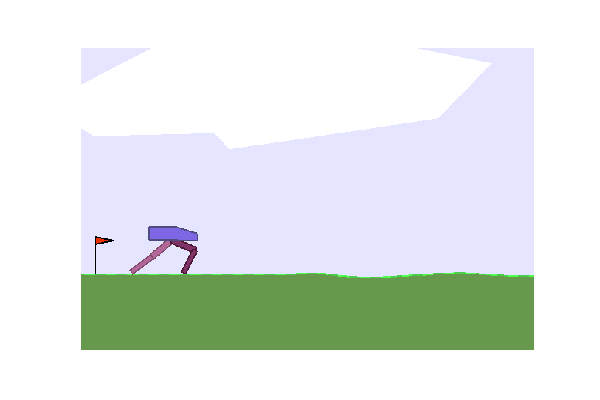
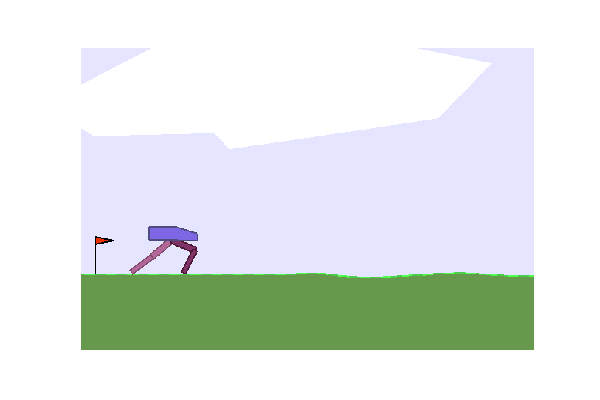
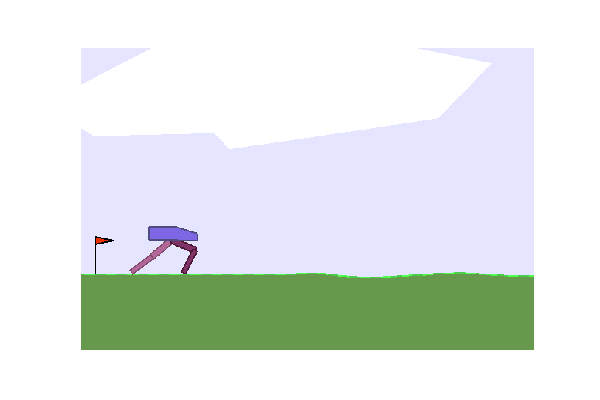
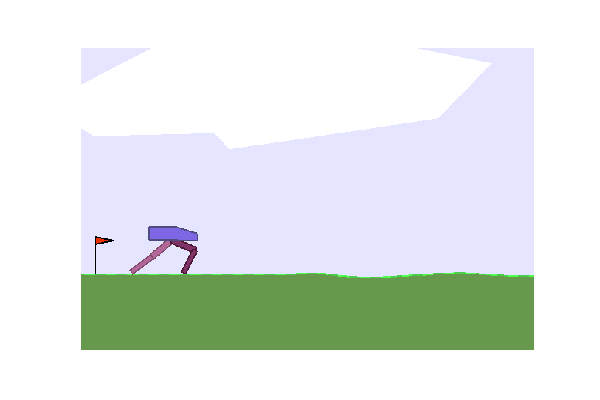
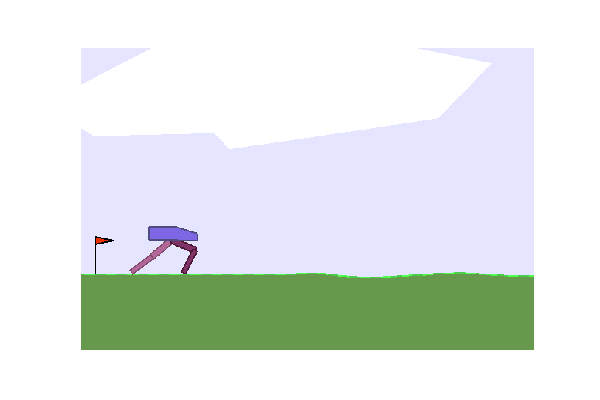
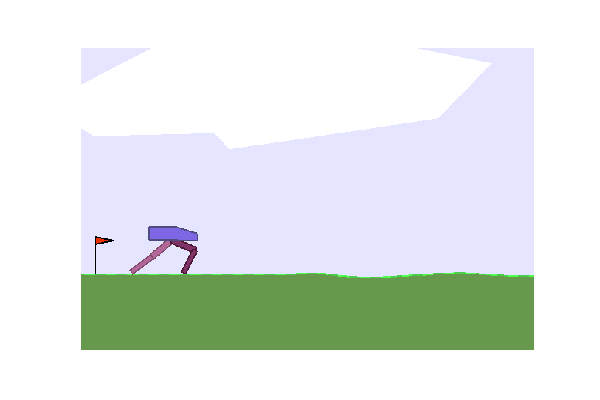
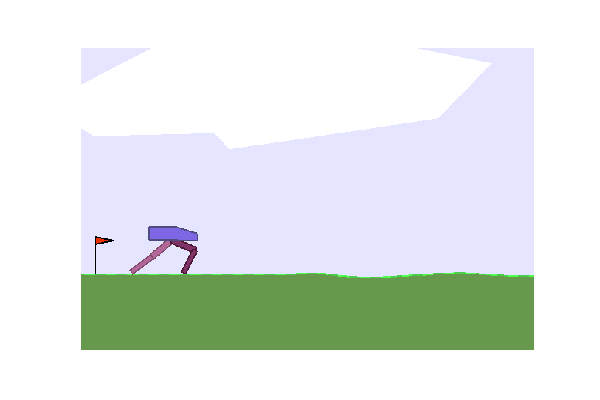
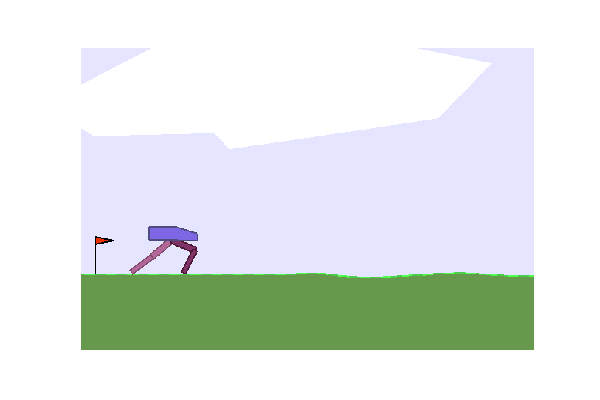
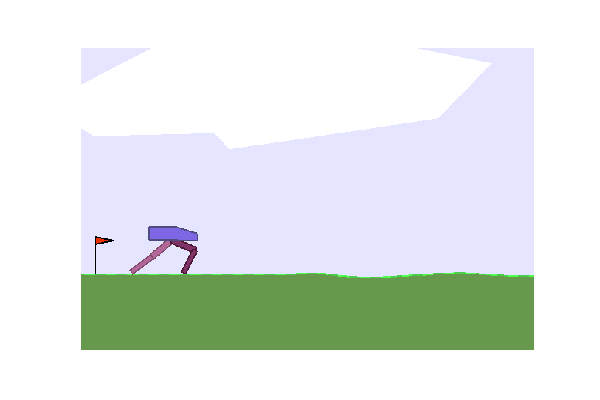
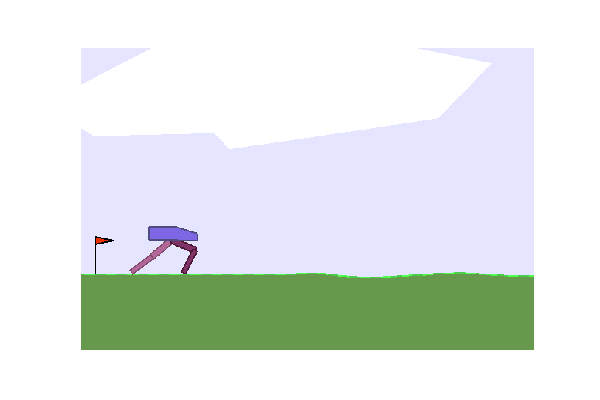
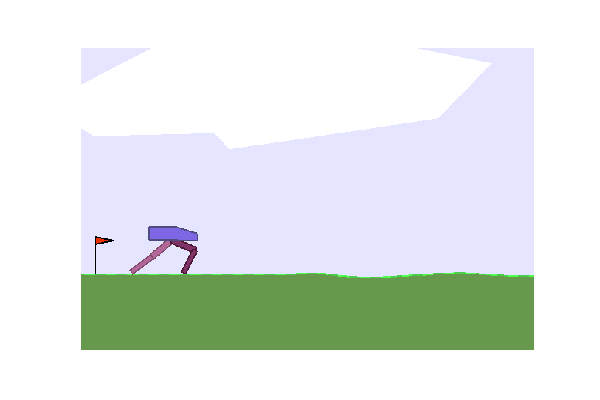
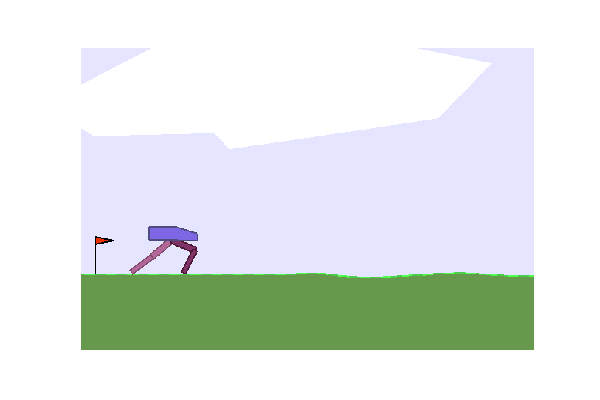
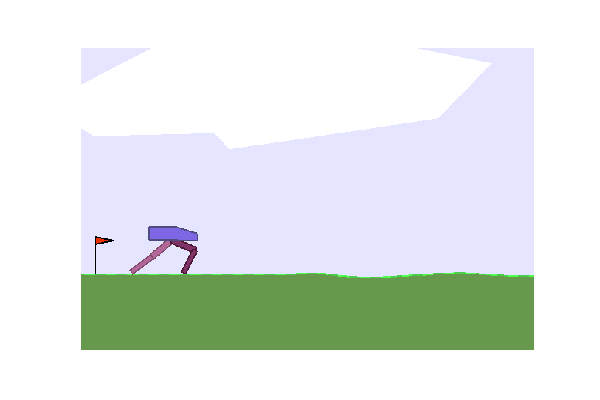
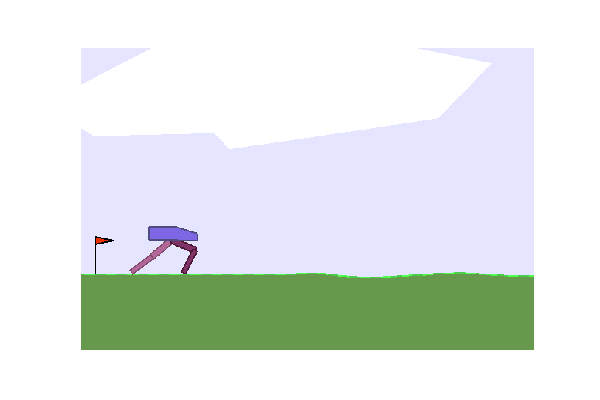
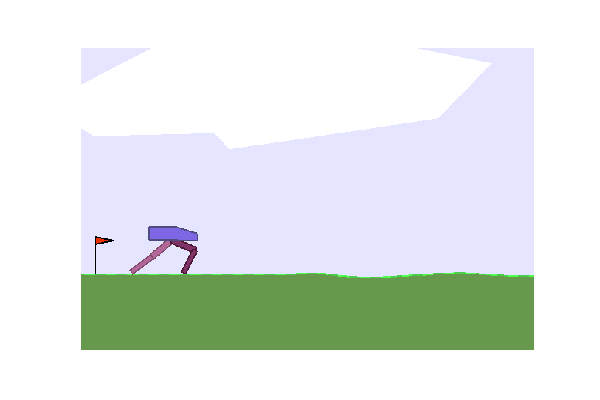
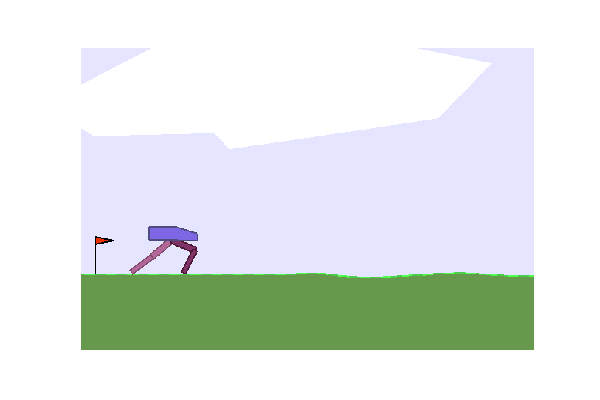
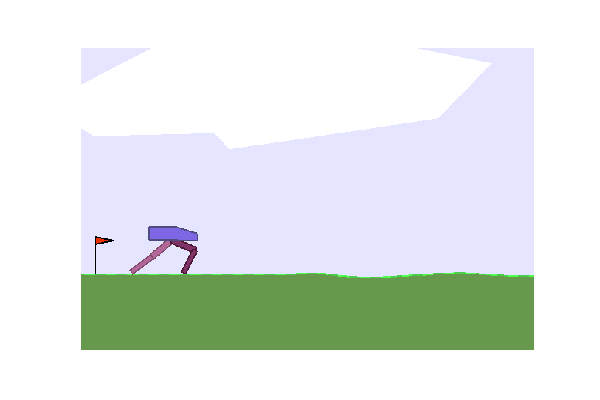
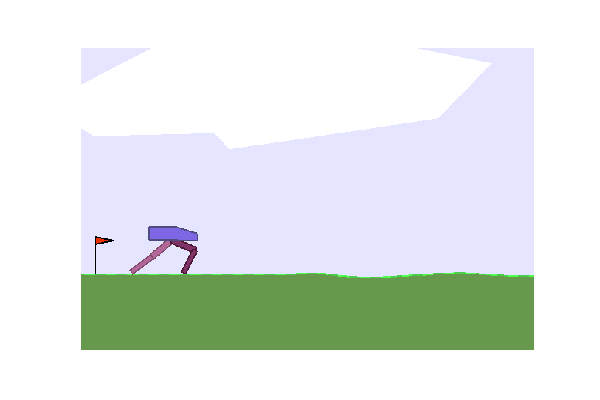
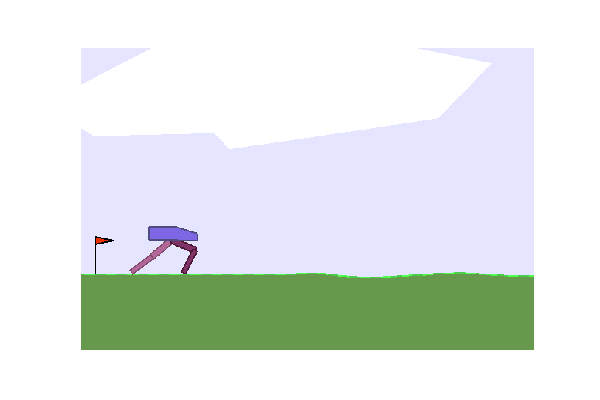
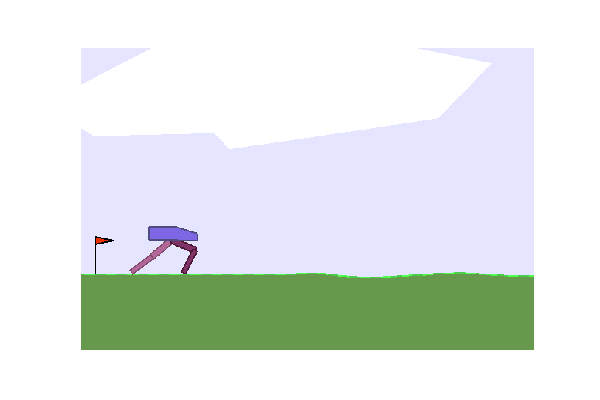
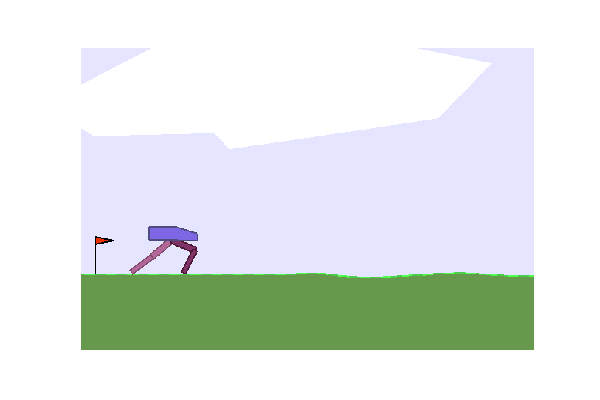
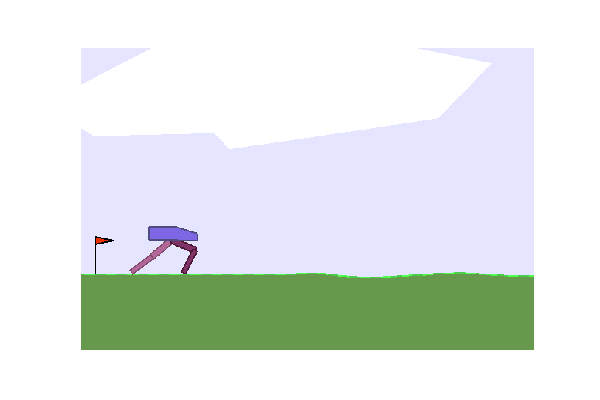
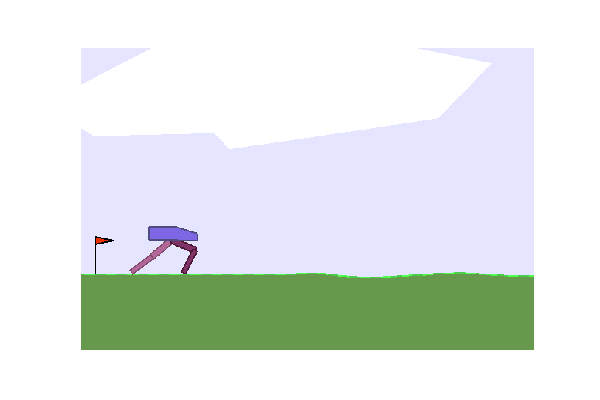
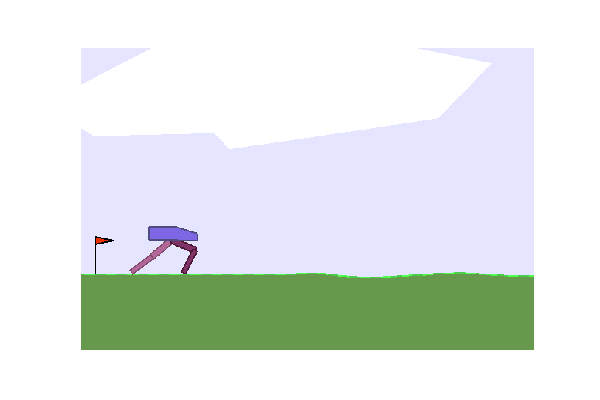
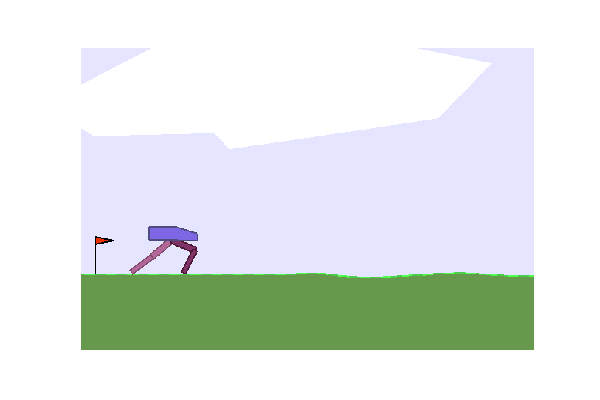
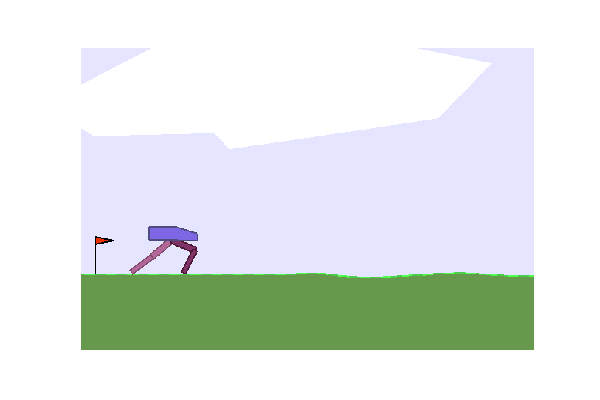
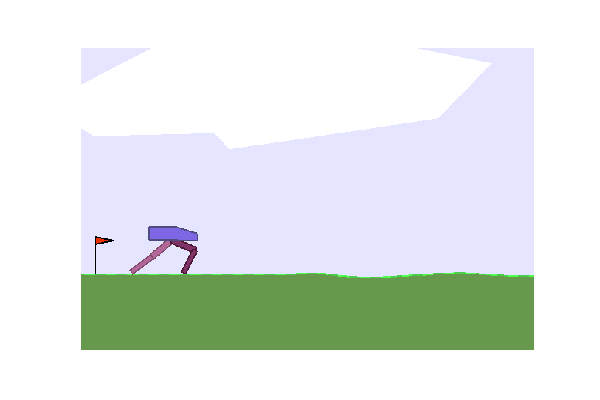
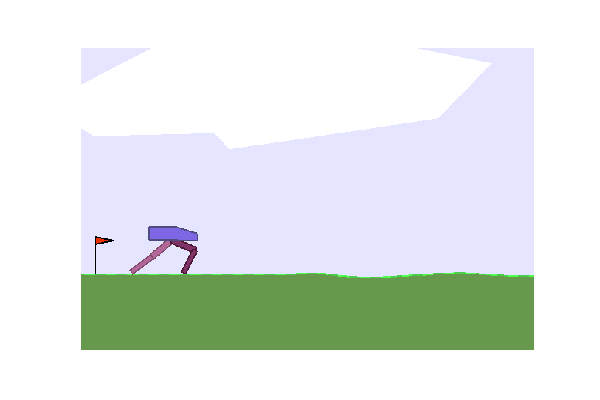
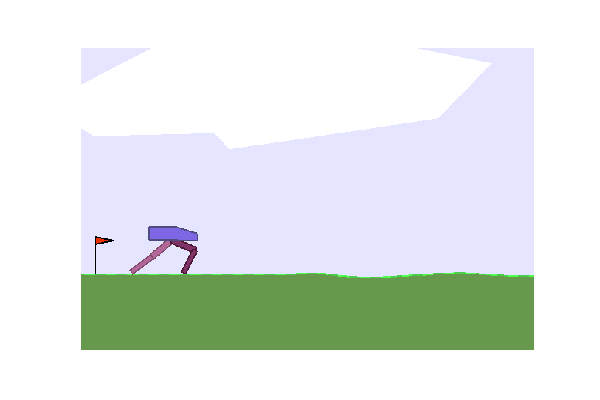
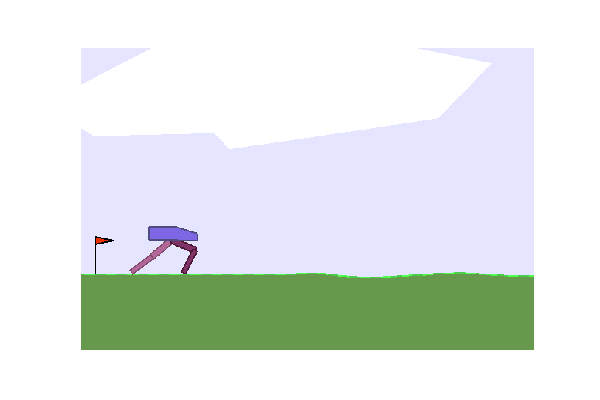
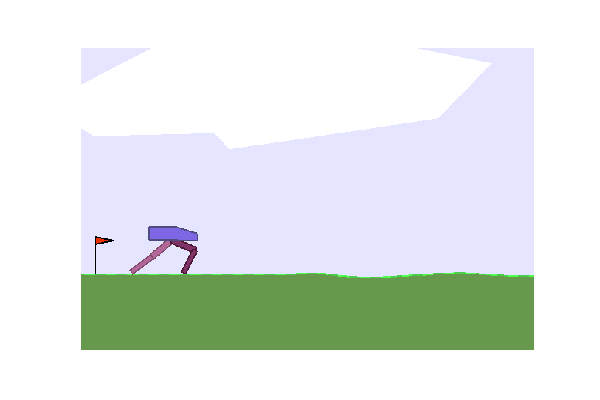
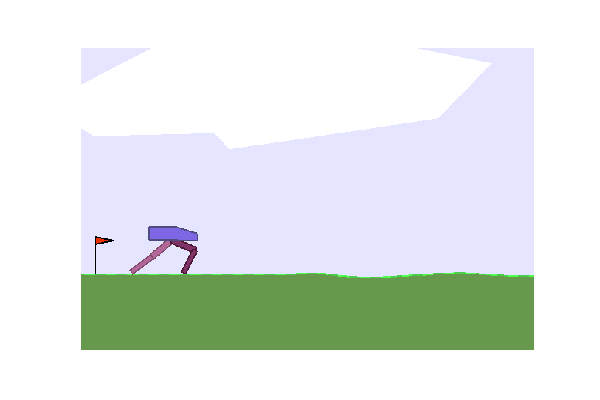
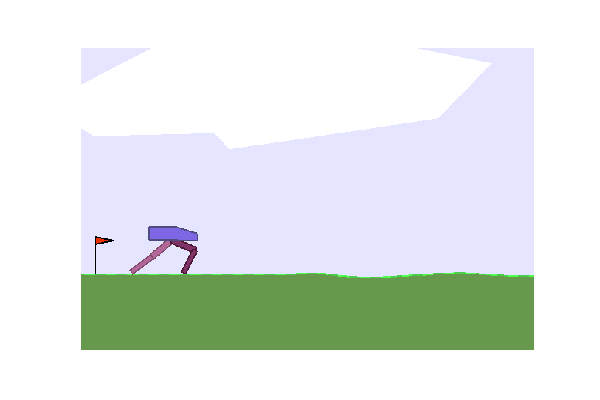
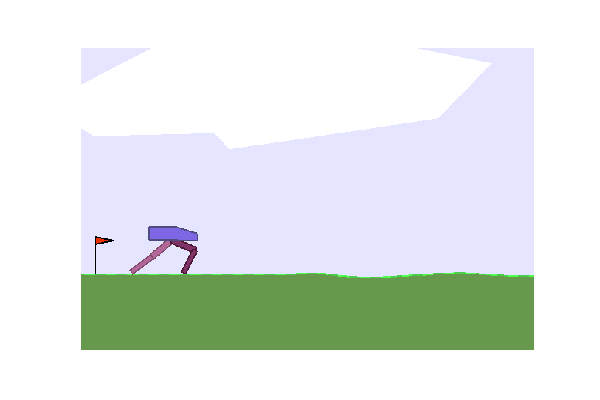
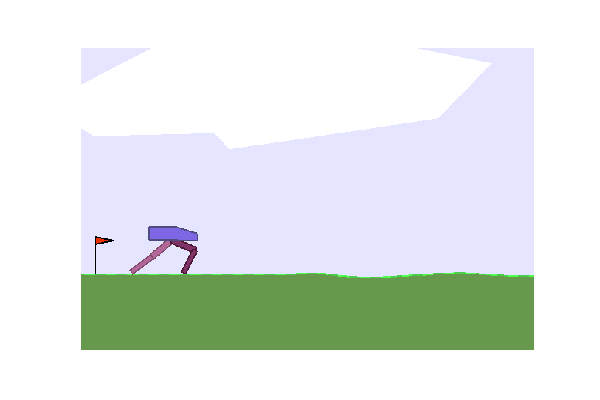
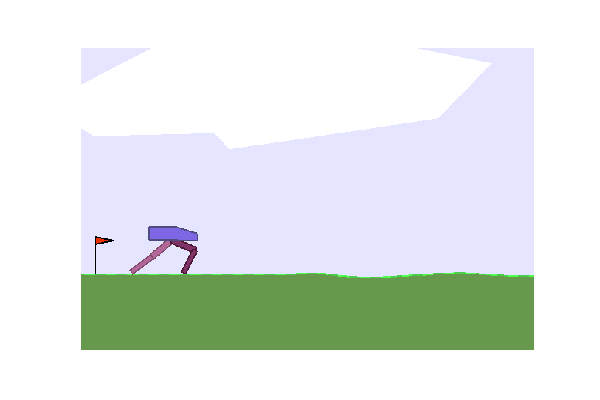
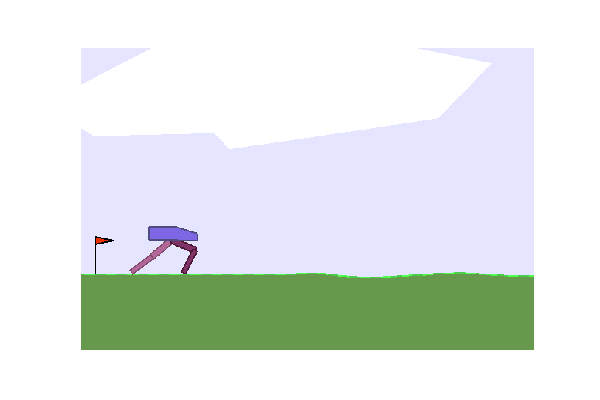
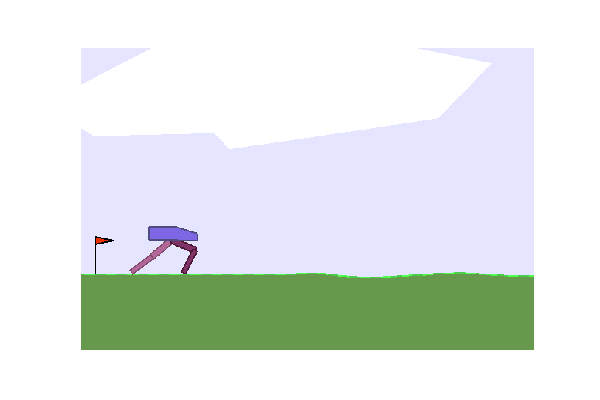
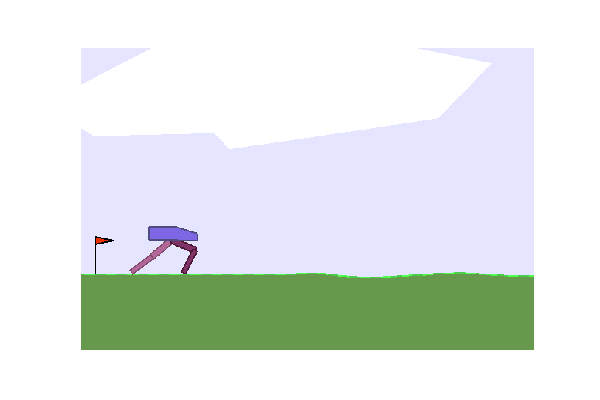
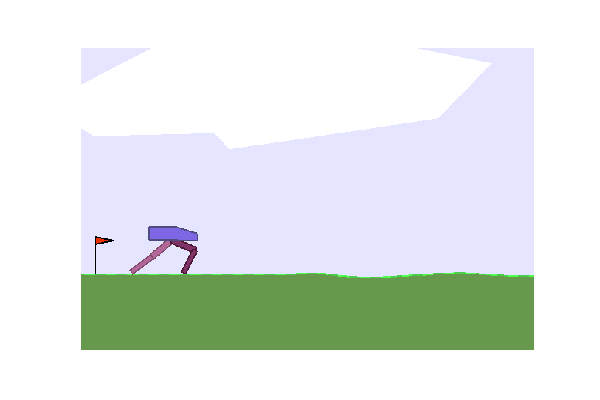
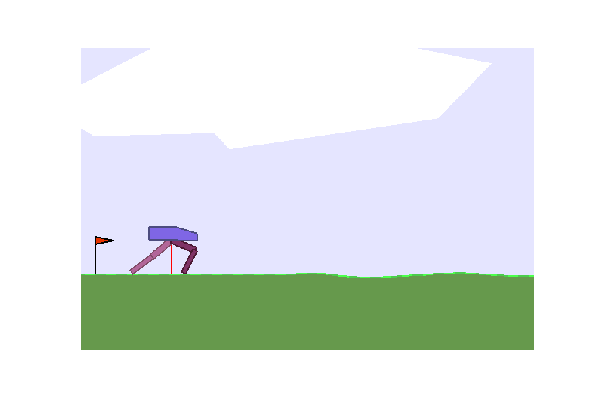
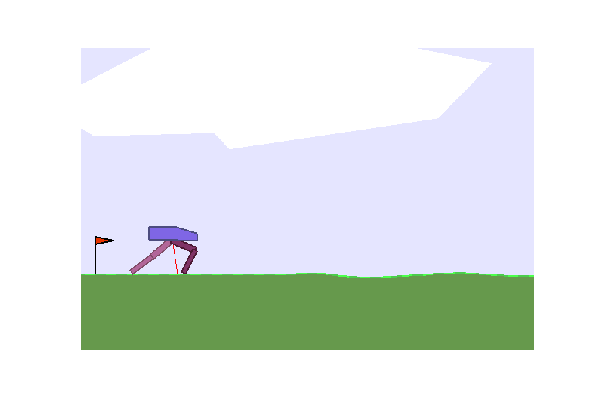
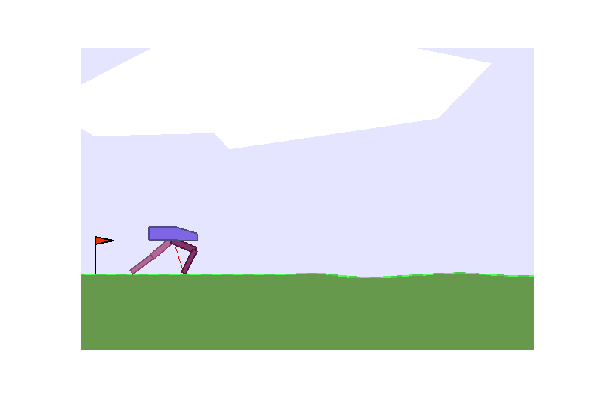
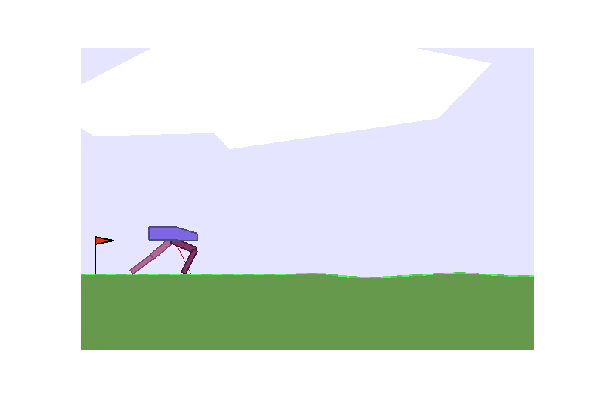
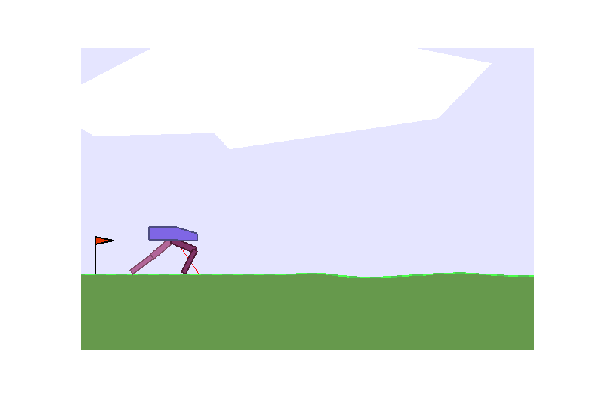
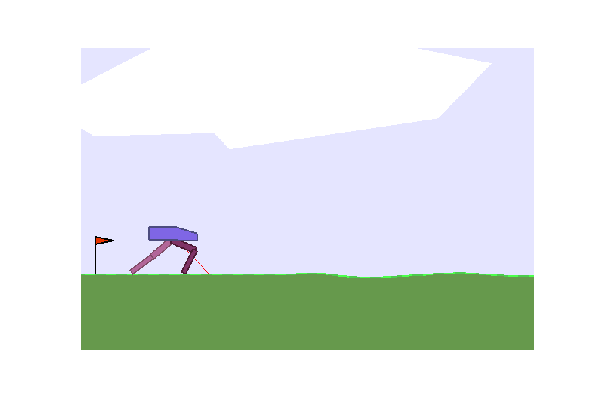
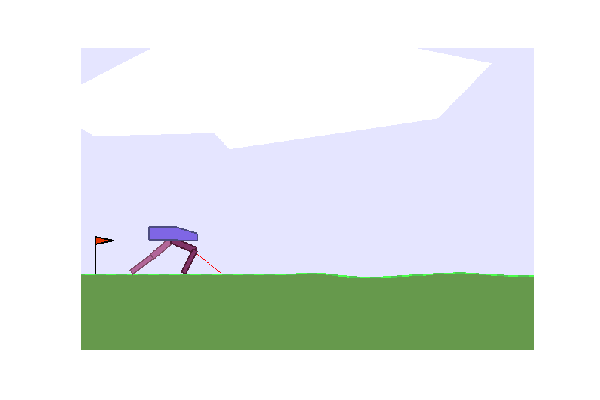
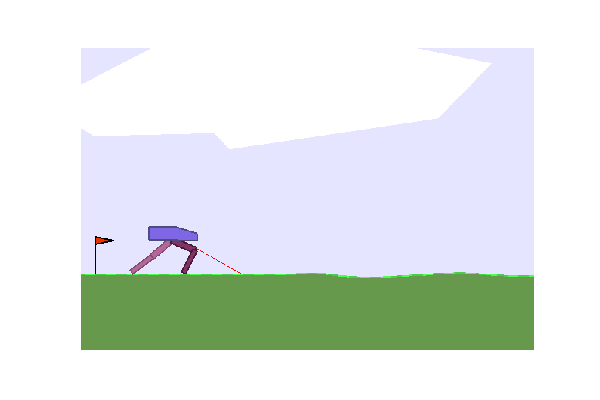
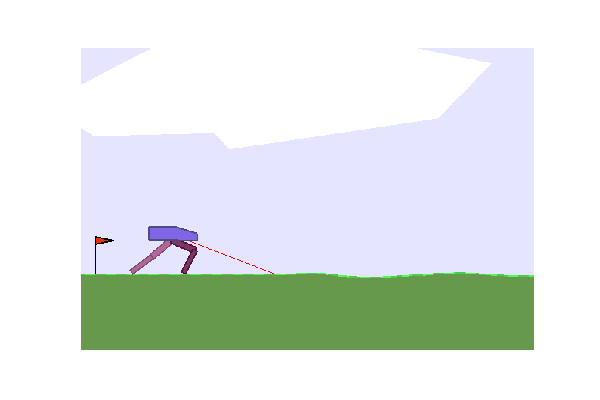
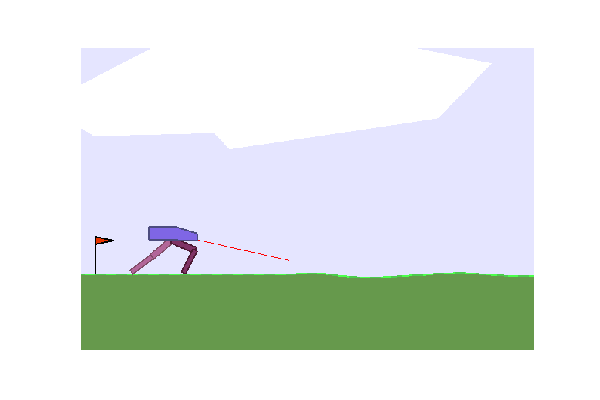
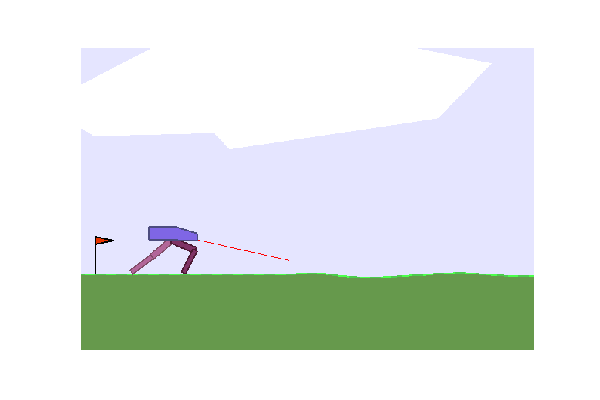
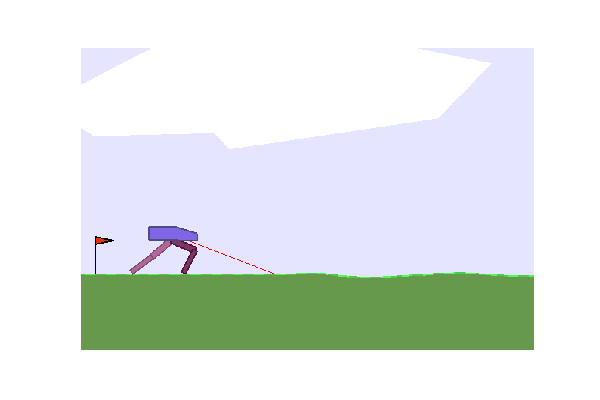
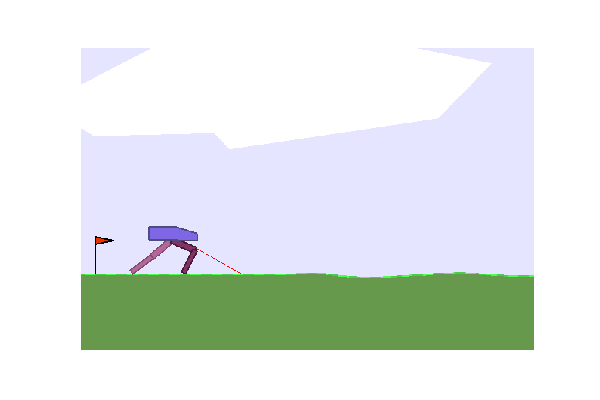
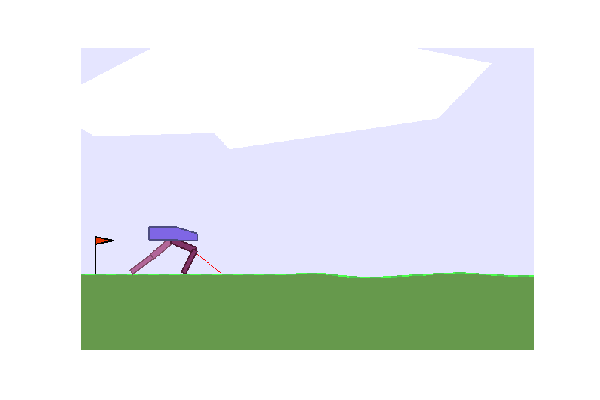
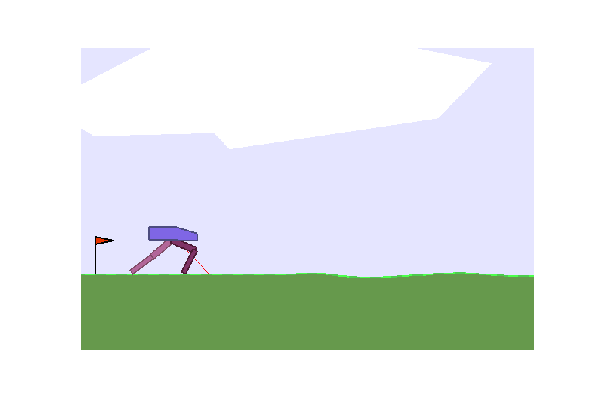
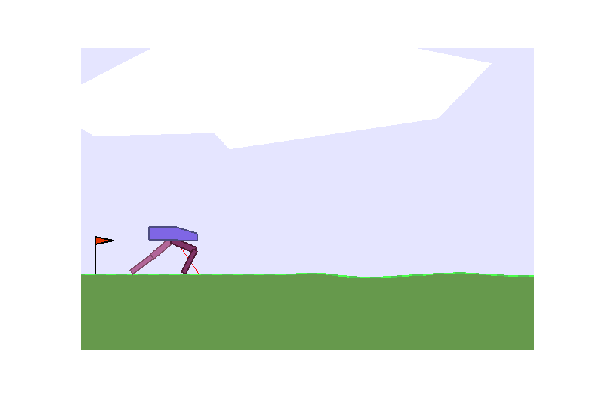
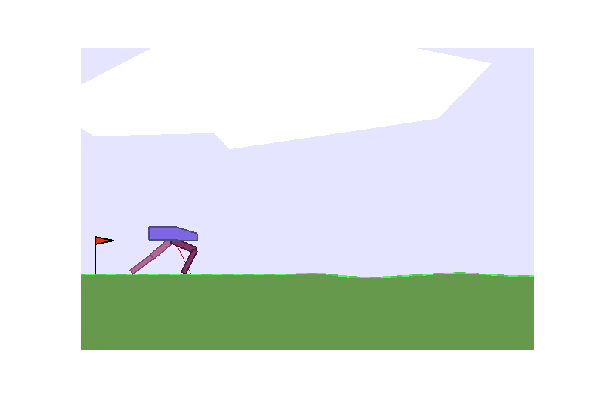
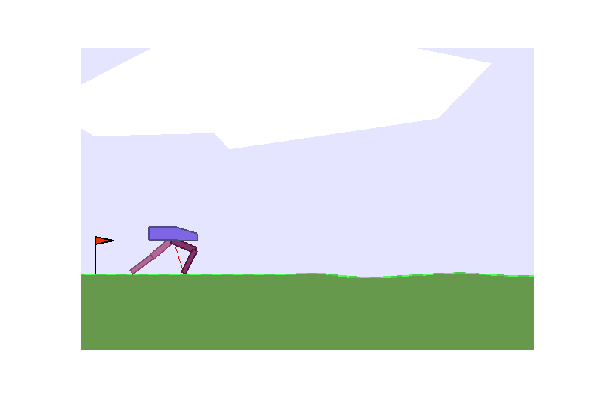
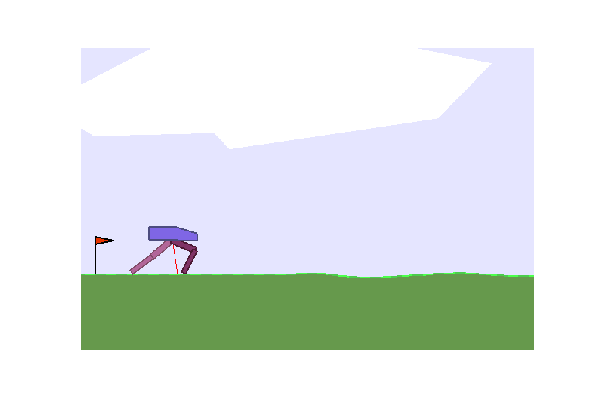
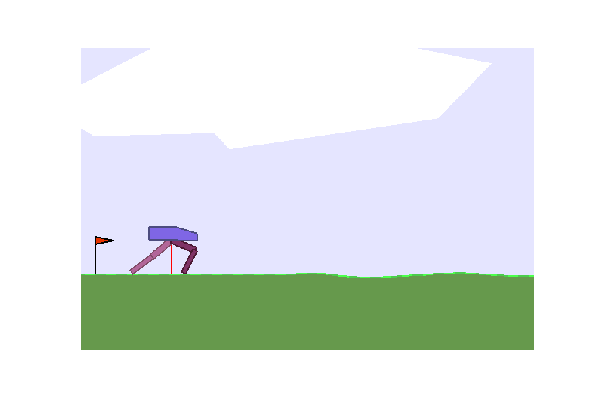
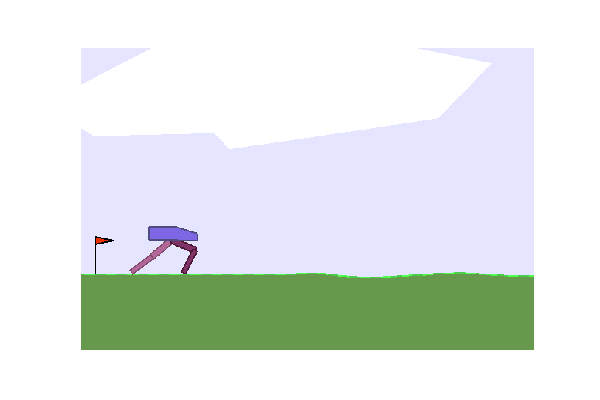
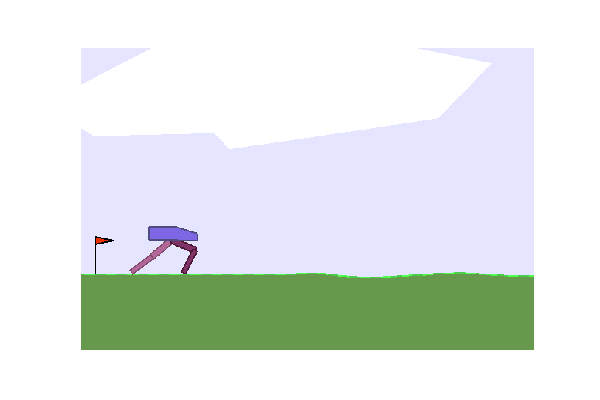
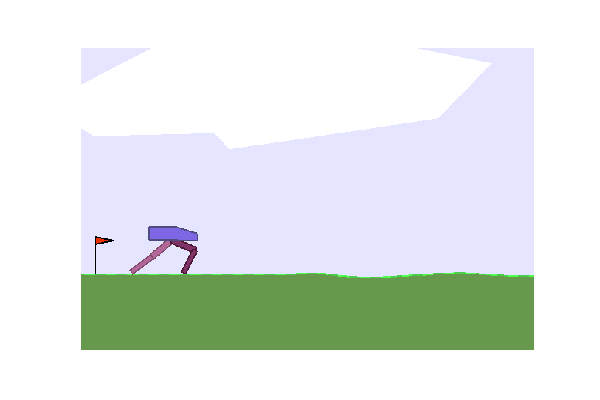
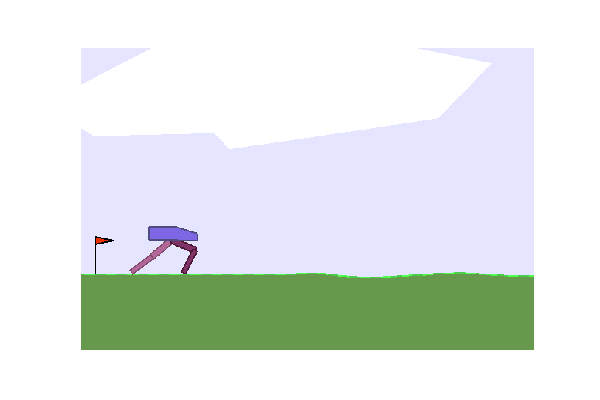
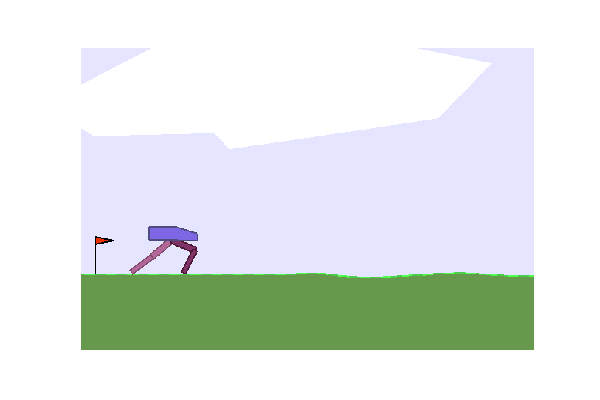
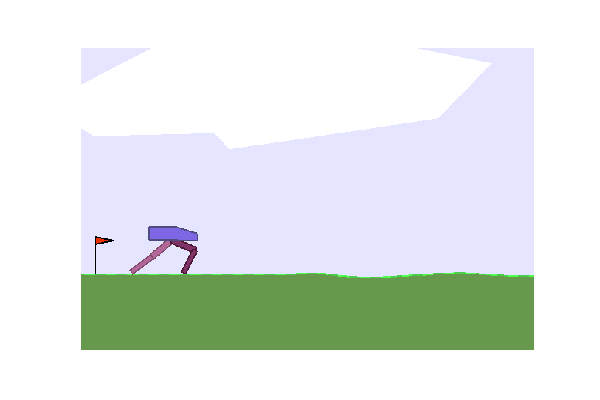
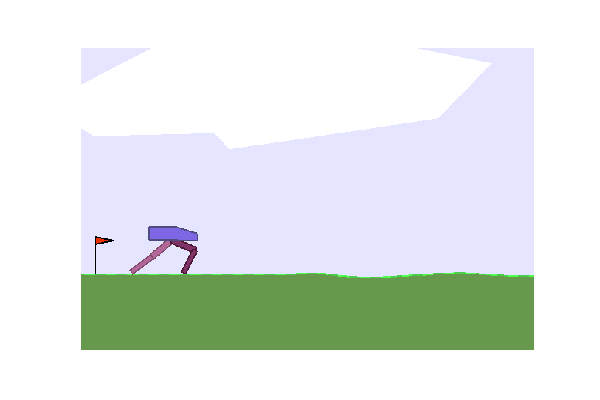
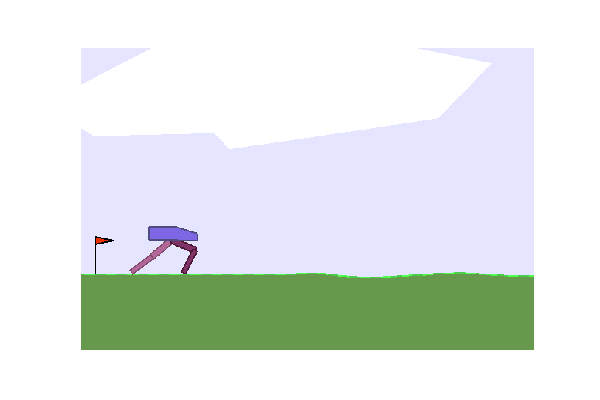
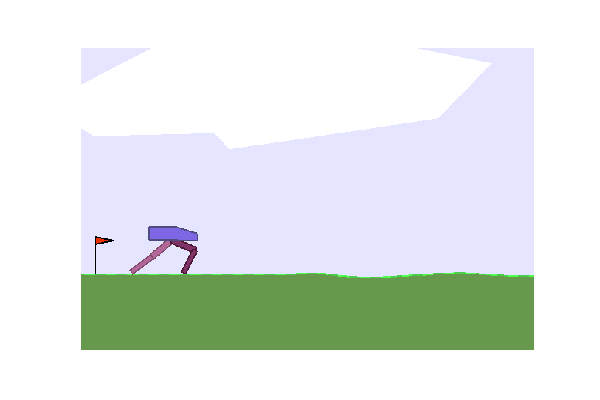
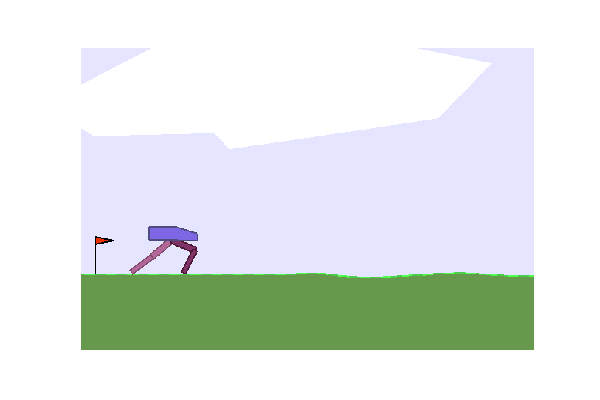
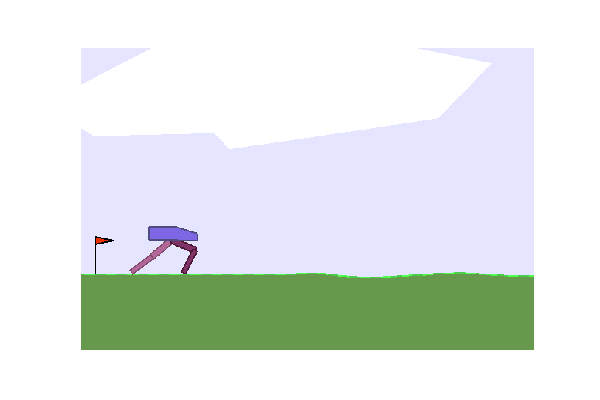
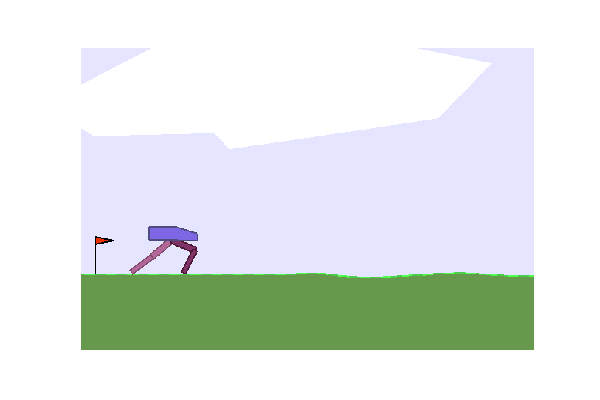
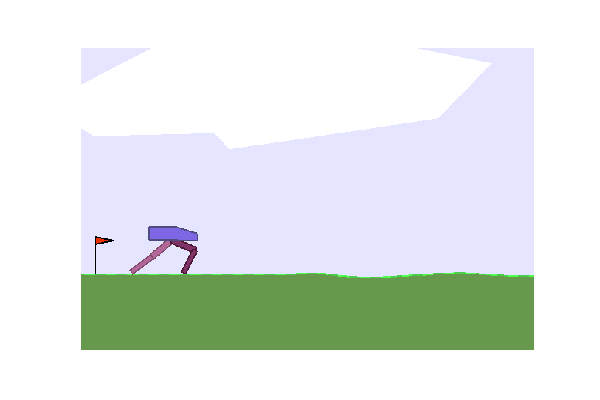
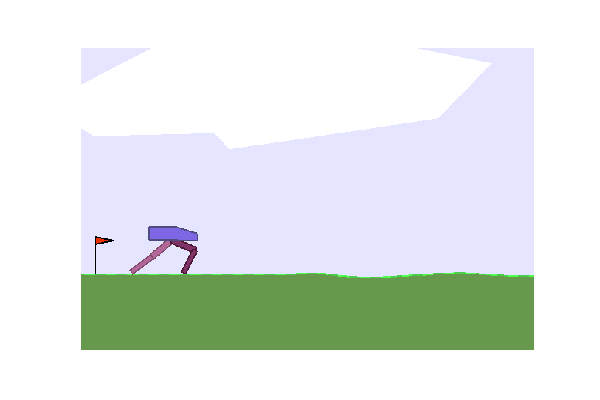
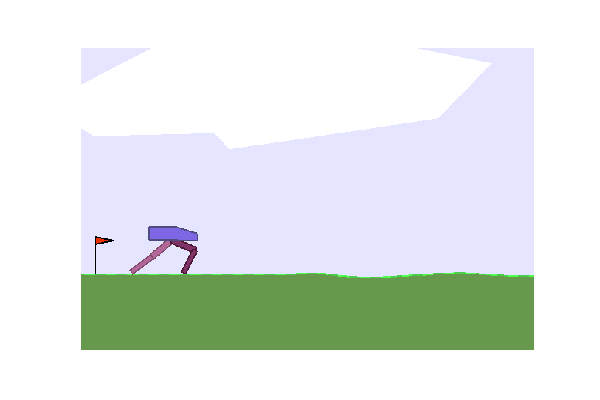
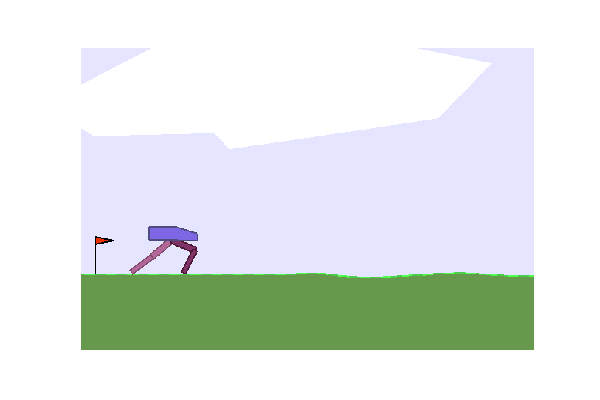
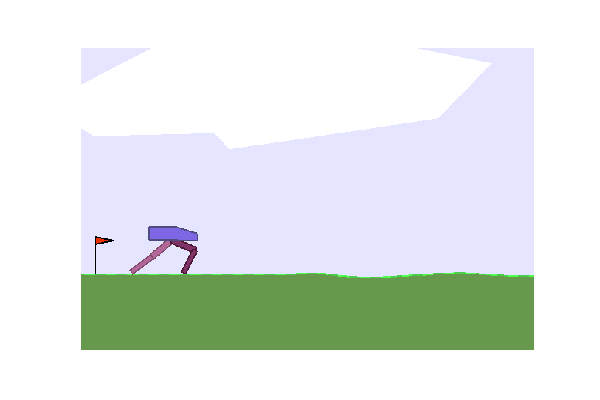
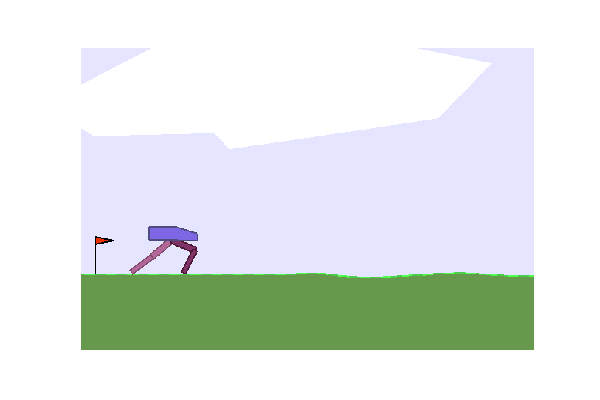
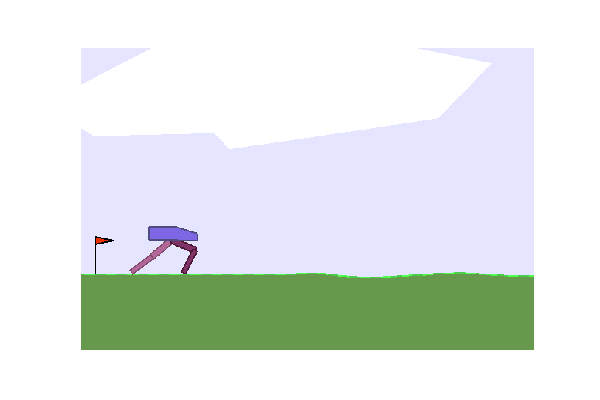
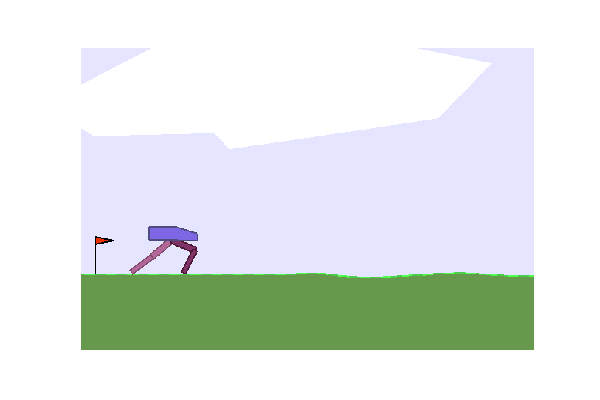
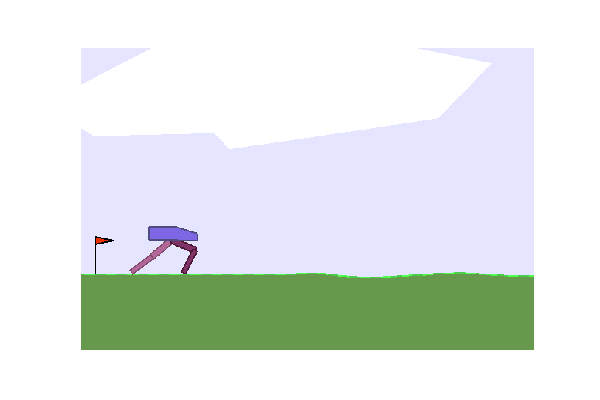
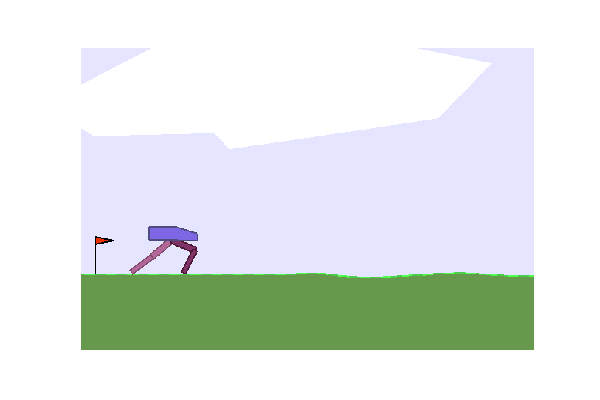
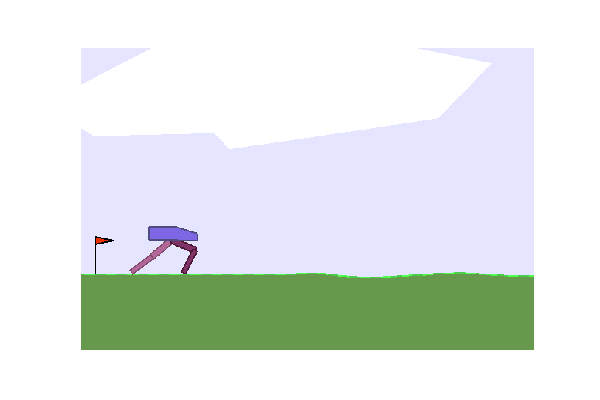
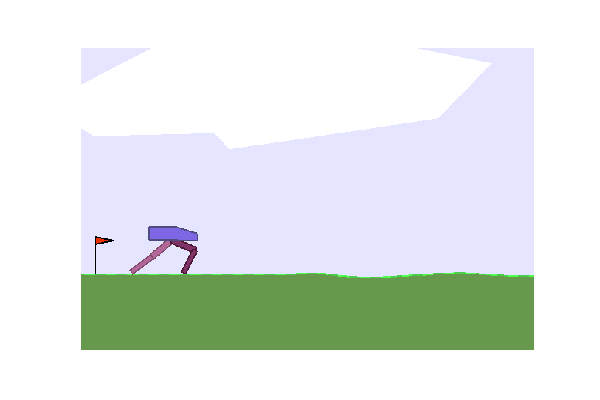
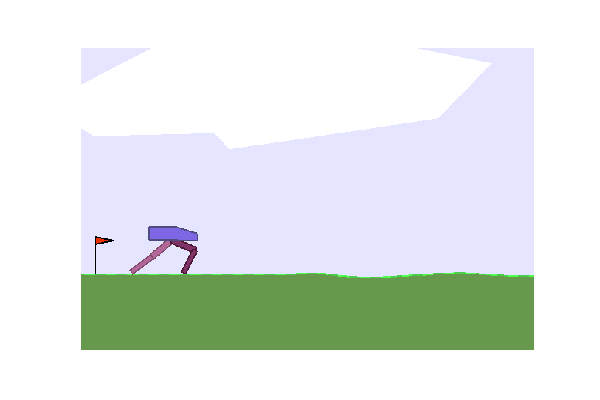
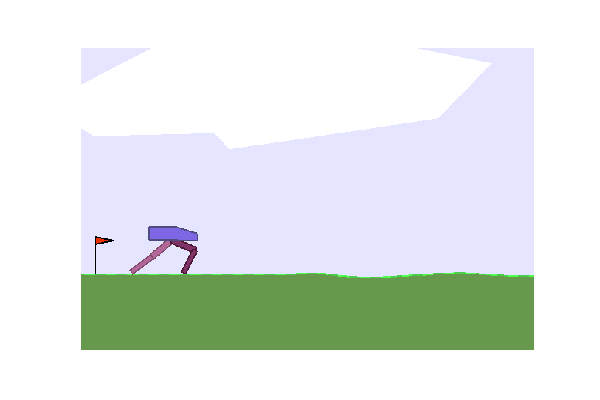
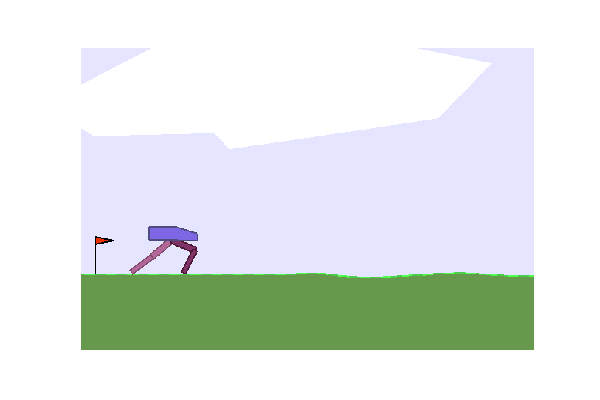
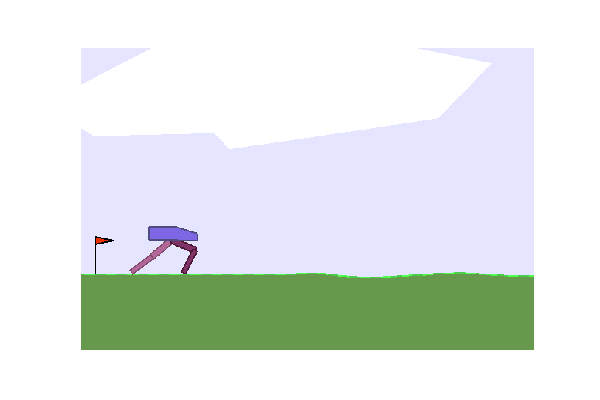
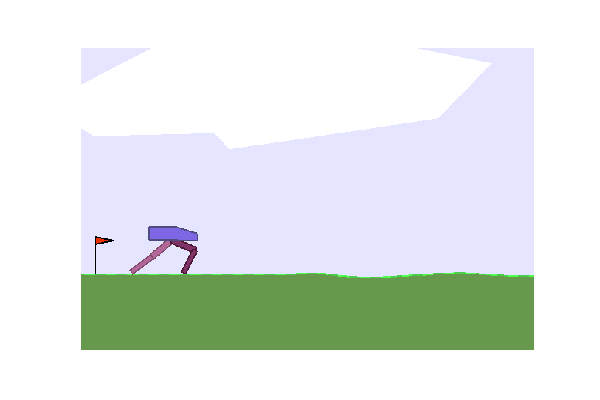
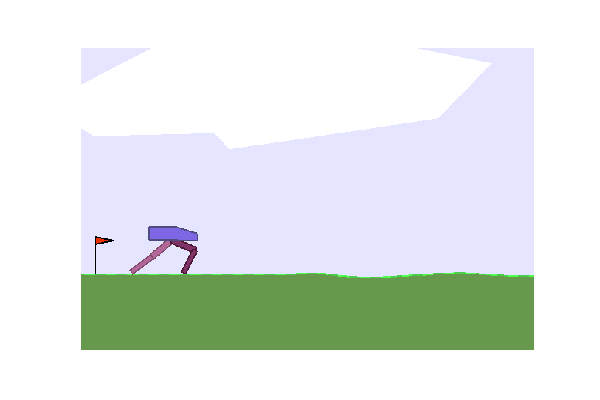
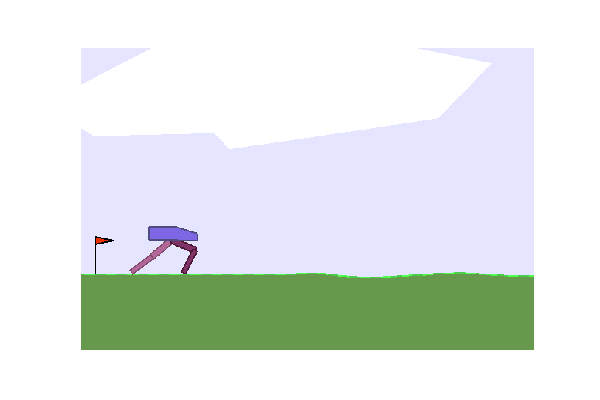
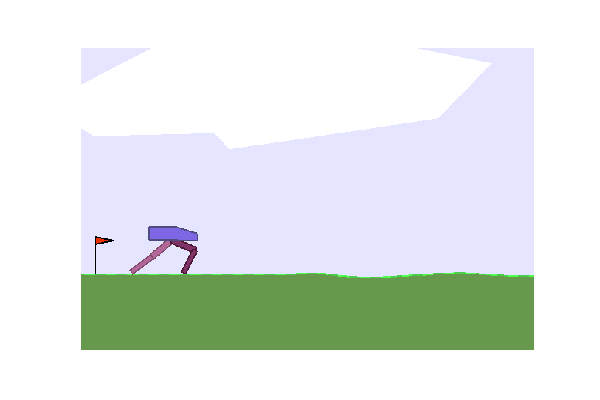
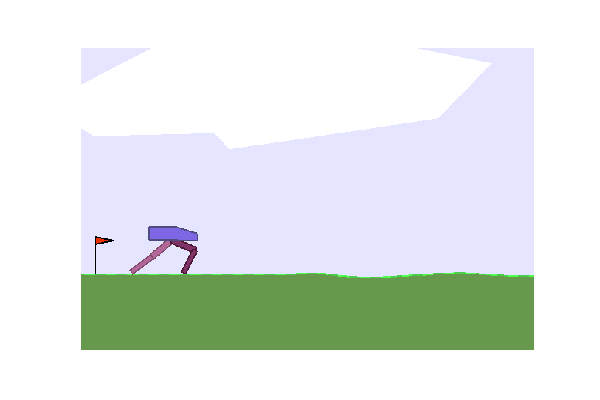
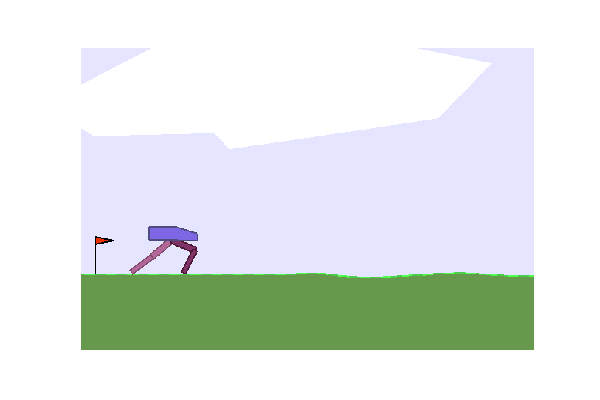
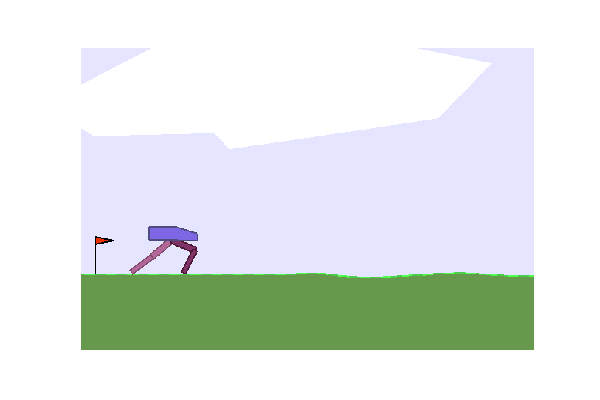
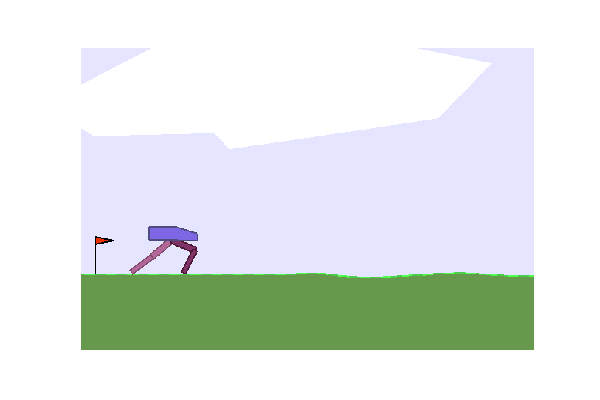
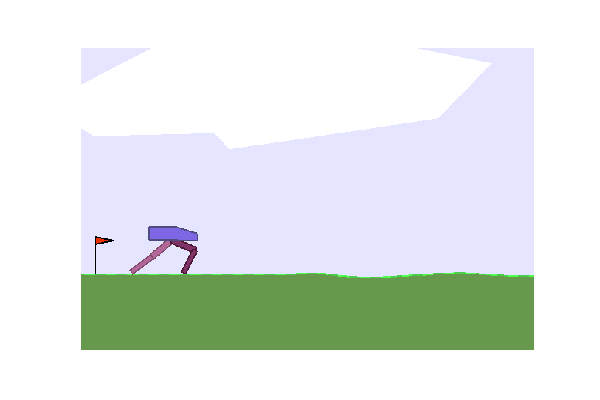
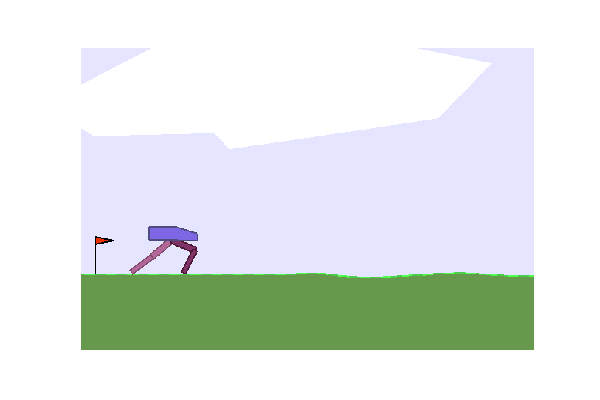
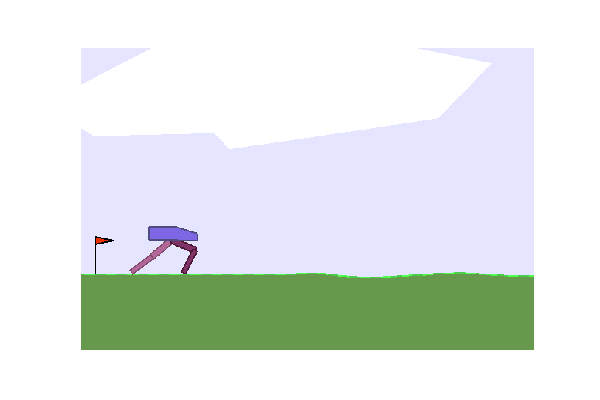
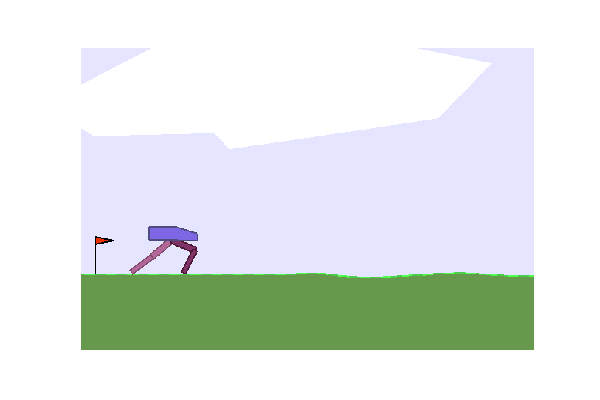
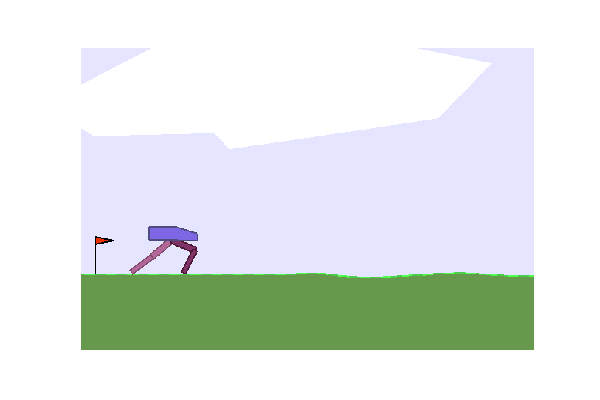
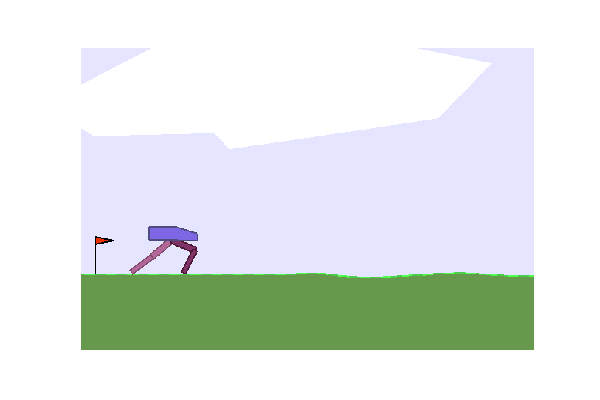
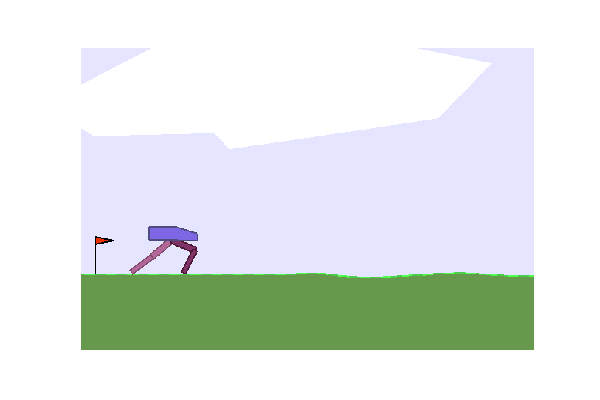
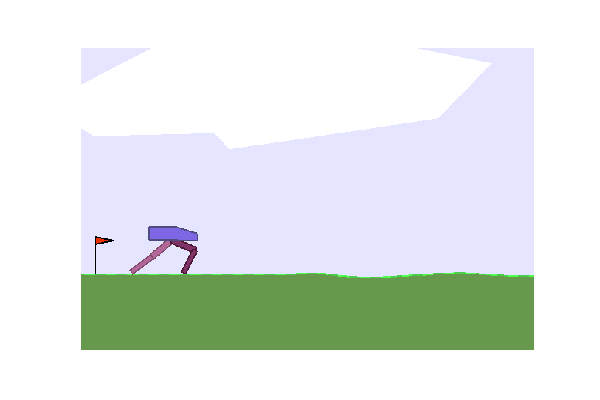
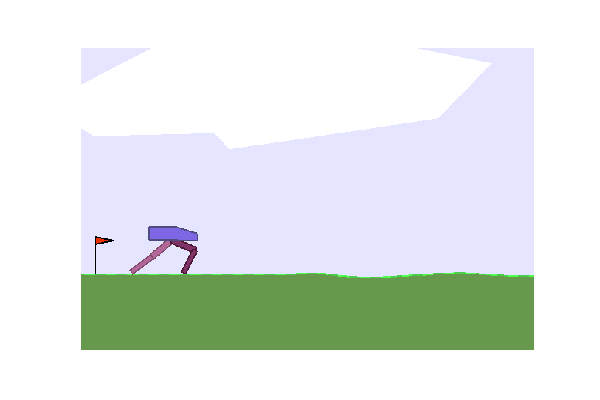
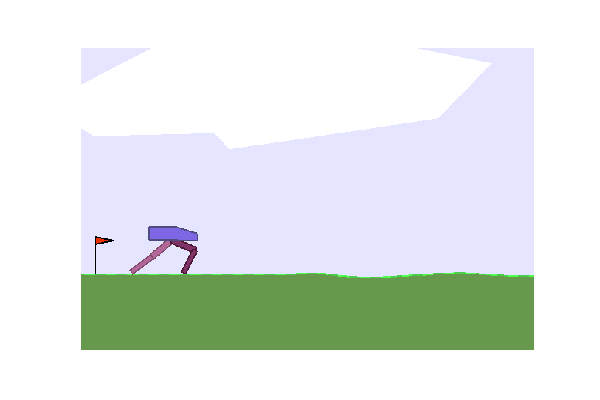
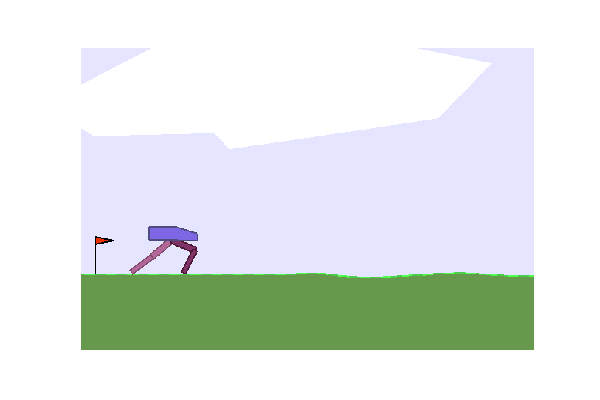
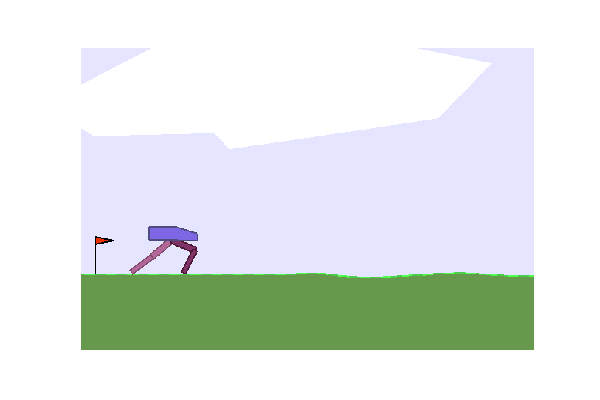
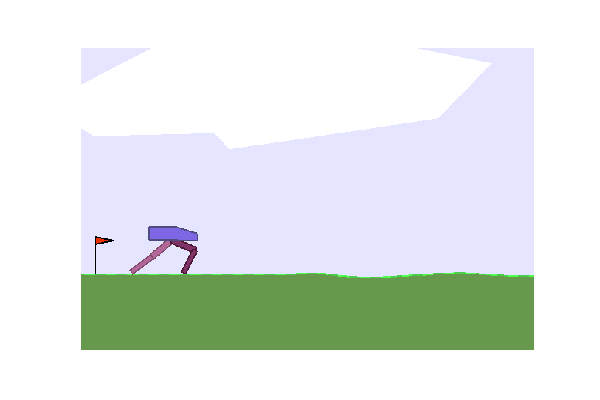
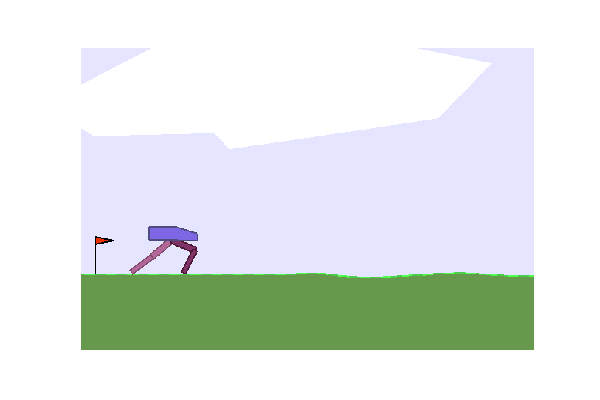
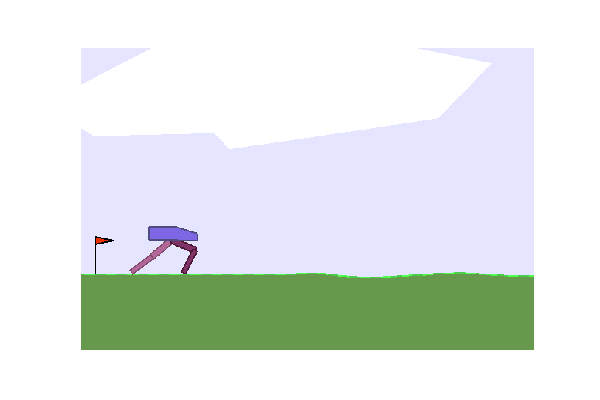
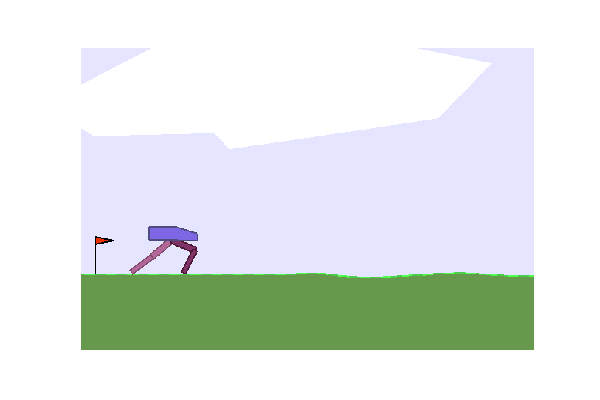
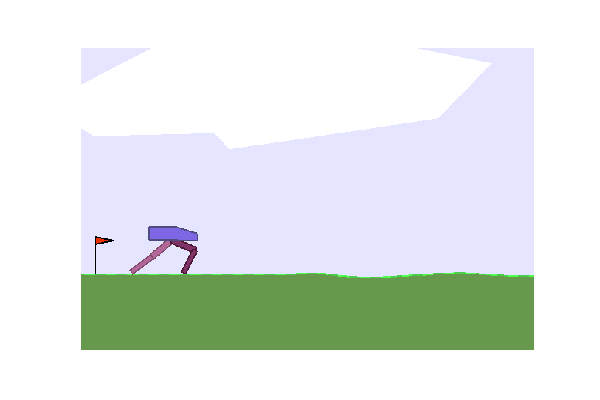
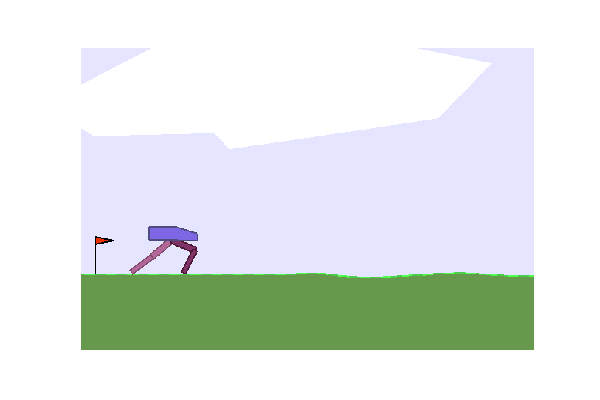
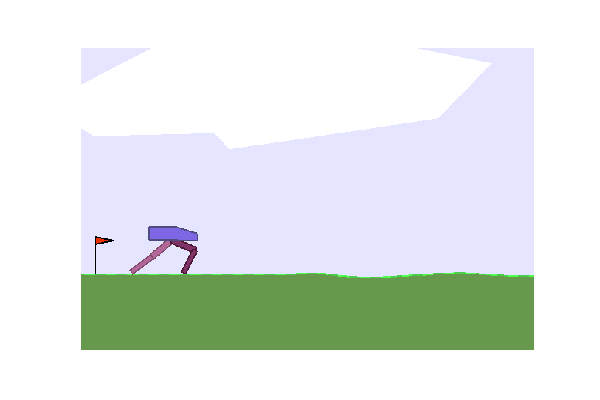
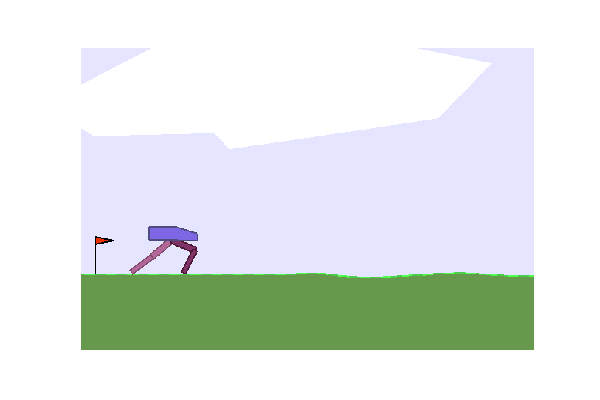
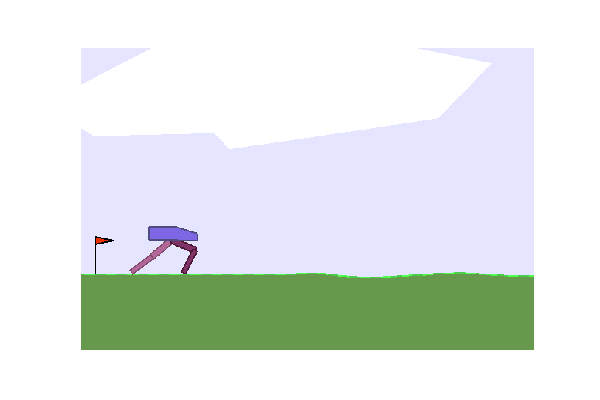
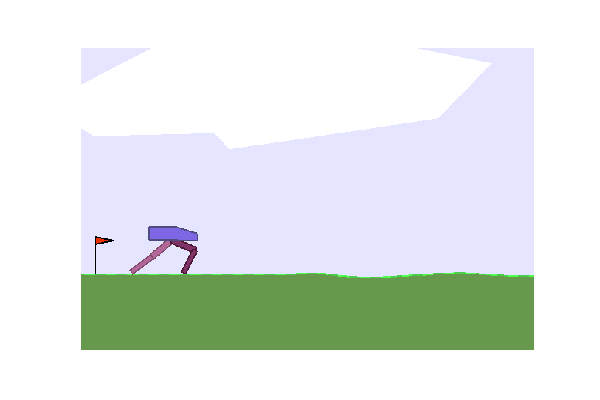
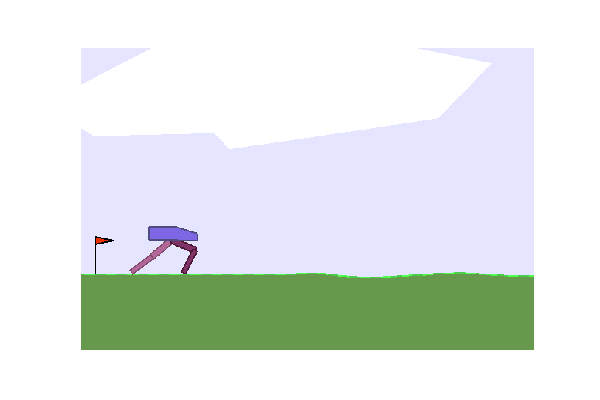
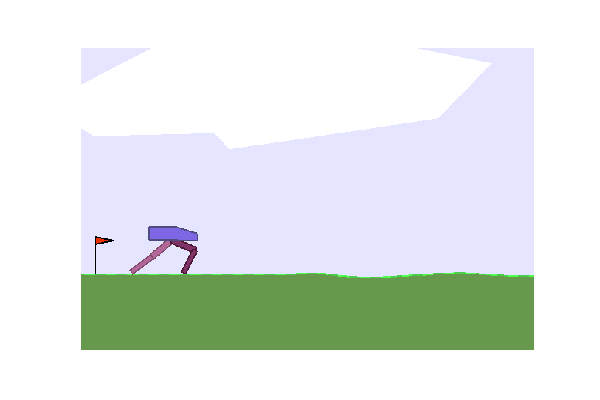
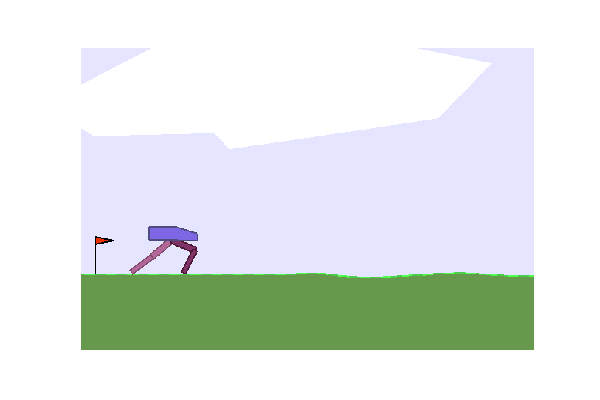
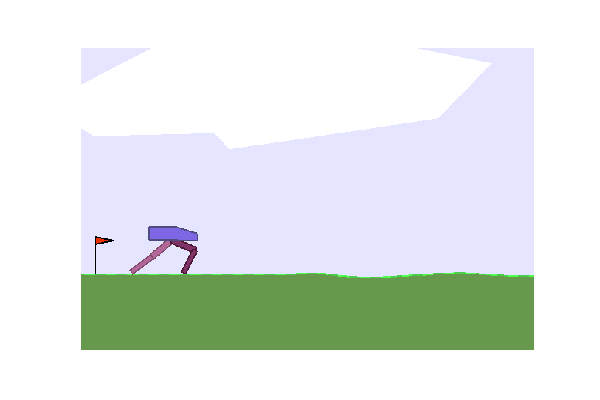
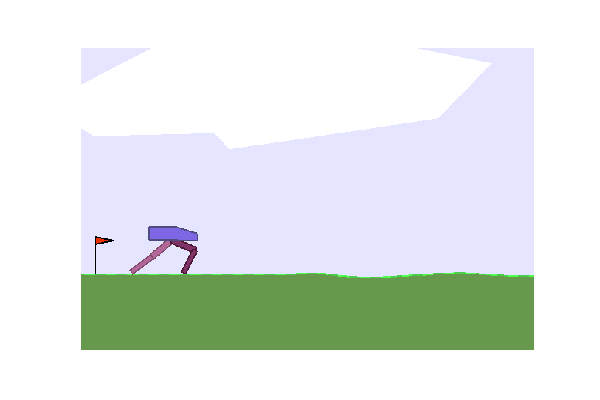
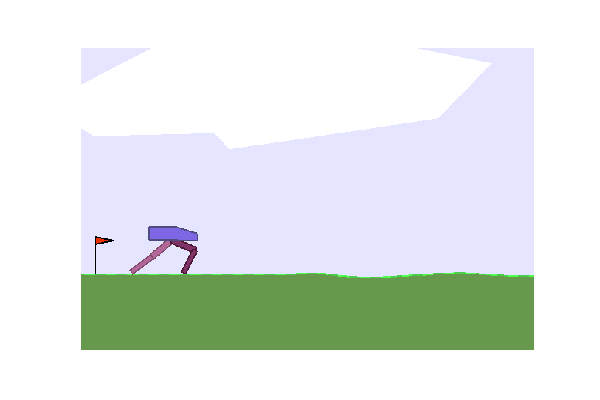
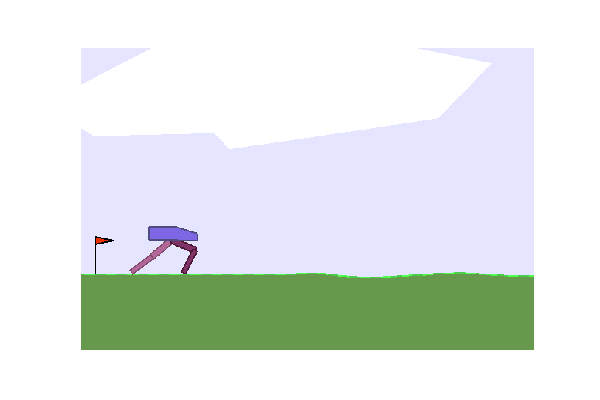
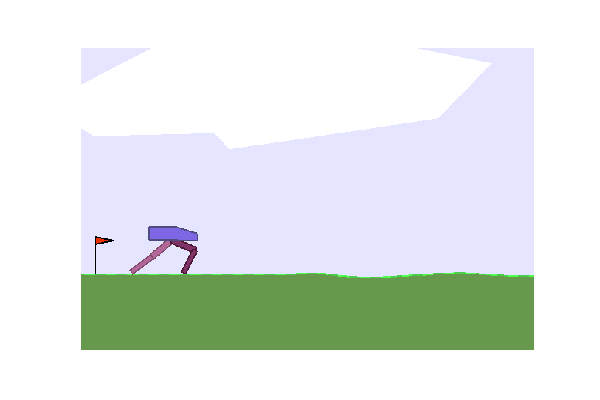
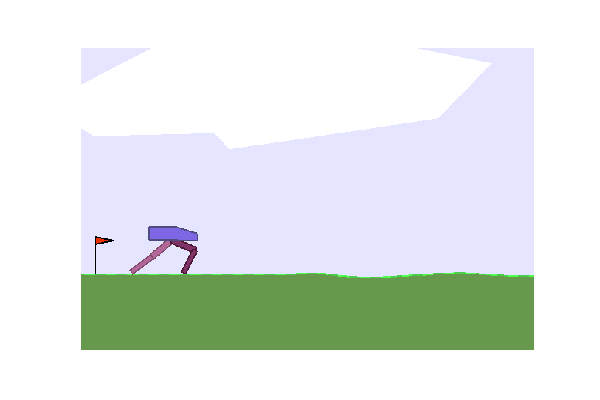
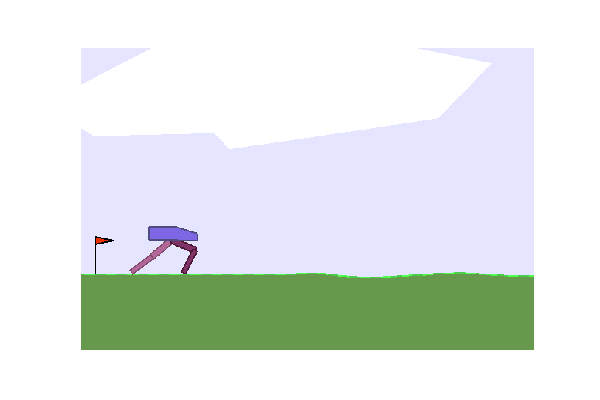
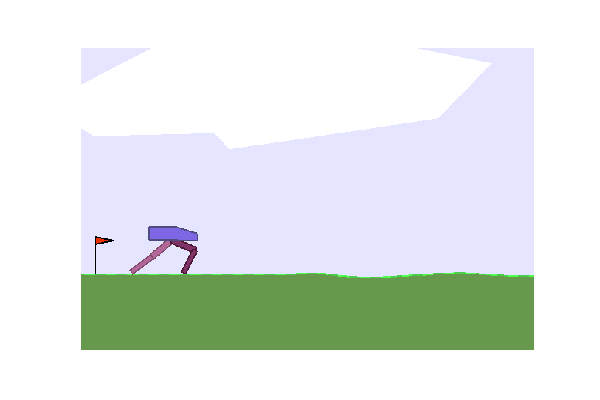
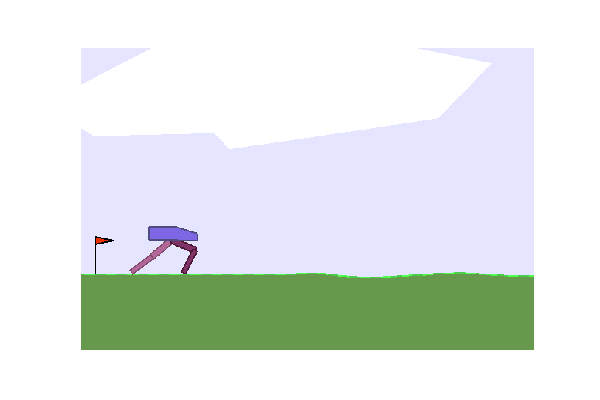
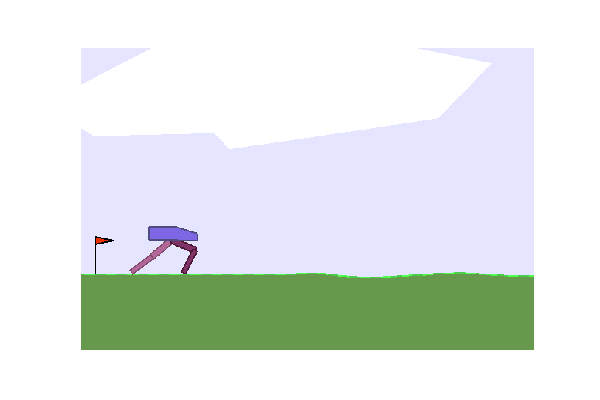
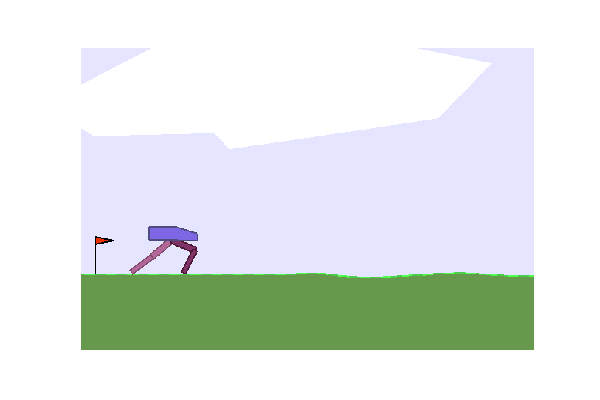
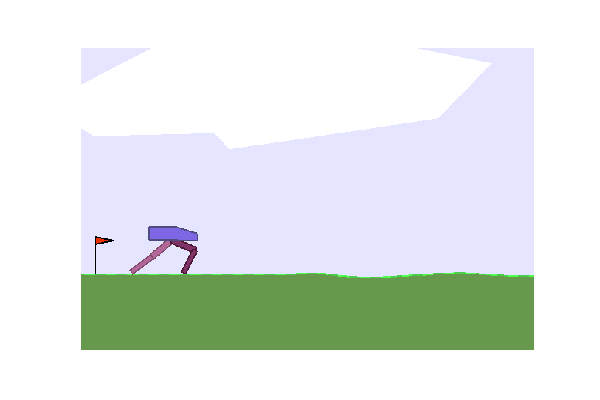
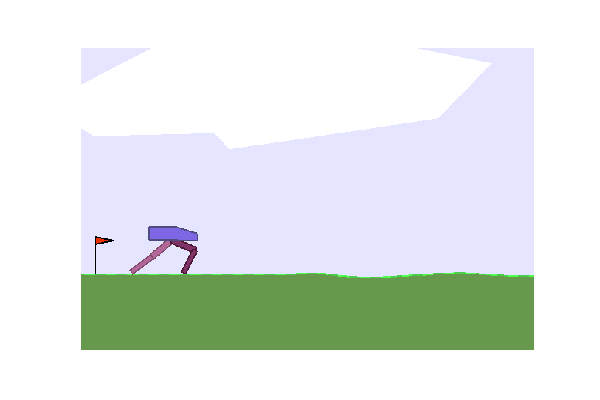
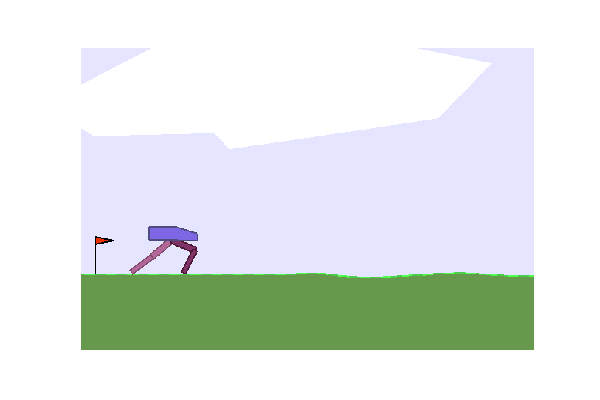
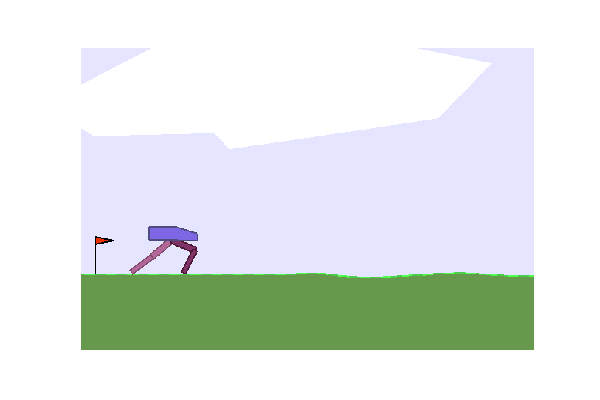
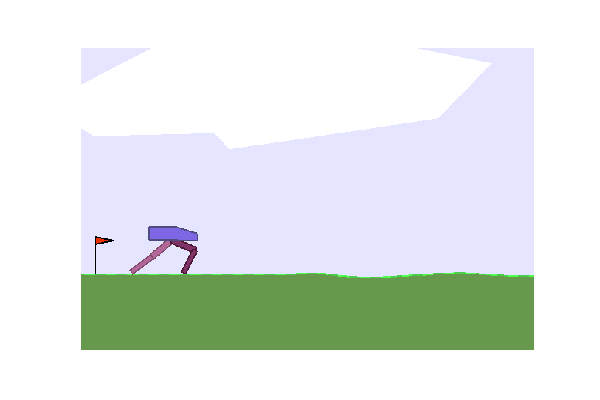
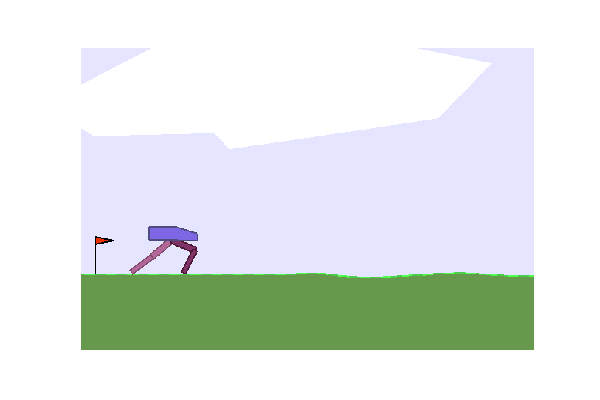
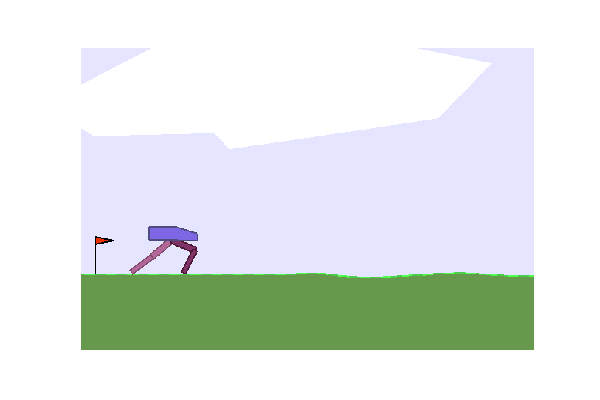
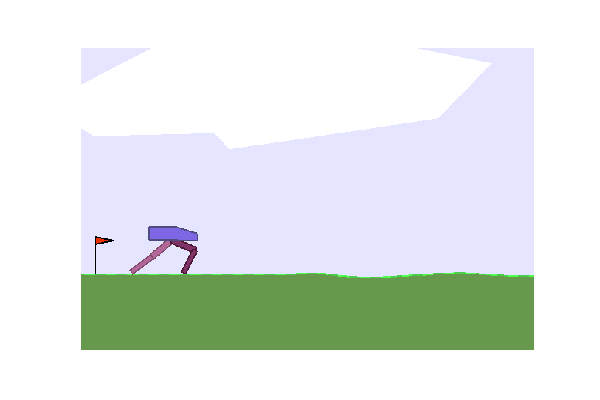
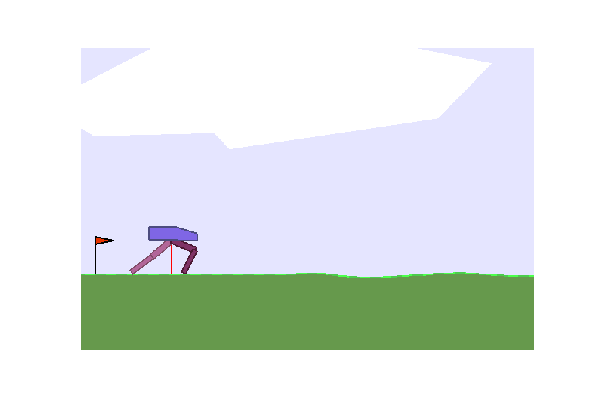
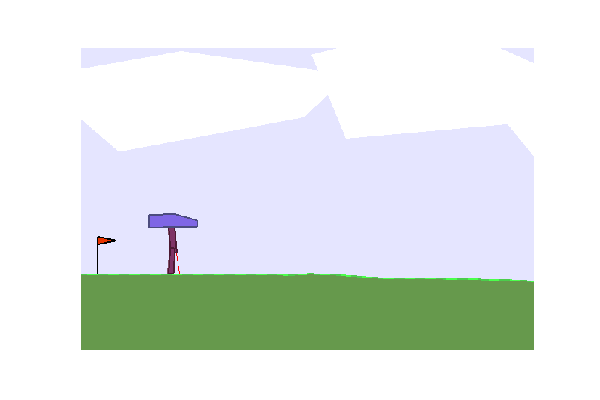

-31.799244

In [12]:
agent.play(record=True)

In [ ]:
frames = agent.record["frames"]
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
#display(display_animation(anim, default_mode='loop'))

In [ ]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('lol.mp4', writer=writer)